In [1]:
import os
import random
import re
import math
import time
import pickle
import functools
random.seed(a=42)
from itertools import cycle
from IPython.display import display, HTML

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, roc_curve, auc, f1_score, confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.utils import class_weight
from sklearn.feature_selection import SelectKBest, f_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MyDrive


In [3]:
DRIVE_DIRECTORY = "/content/drive/MyDrive"

OUTPUT_DIR = DRIVE_DIRECTORY + "/renal_carcinoma/_output"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

GENES_DIR = OUTPUT_DIR + "/anova"
if not os.path.exists(GENES_DIR):
    os.makedirs(GENES_DIR)

MODEL_DIR = OUTPUT_DIR + "/models"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

training_file = 'training_set.csv'
test_file = 'test_set.csv'

training_labels = 'training_labels.csv'
test_labels = 'test_labels.csv'

In [4]:
train_data = pd.read_csv(training_file, index_col=0)
test_data = pd.read_csv(test_file, index_col=0)

train_labels = pd.read_csv(training_labels, index_col=0)
test_labels = pd.read_csv(test_labels, index_col=0)

In [5]:
train_data.head()

ENSG00000000003.15  ENSG00000000005.6  ENSG00000000419.13  \
TCGA-SX-A71S-01A               48.3953             0.0000             84.1344   
TCGA-BQ-7051-01A               72.3775             0.1354             90.8544   
TCGA-B2-5635-01A.1             28.8629             0.2152             67.0498   
TCGA-BP-4967-01A               51.9280             0.1329             69.3944   
TCGA-B8-5552-01B               34.3976             1.3407             78.6941   

                    ENSG00000000938.13  ENSG00000000971.16  \
TCGA-SX-A71S-01A                9.7777             42.1879   
TCGA-BQ-7051-01A                2.2342              8.1109   
TCGA-B2-5635-01A.1             34.4290             46.0427   
TCGA-BP-4967-01A                7.4124              9.8914   
TCGA-B8-5552-01B               29.6986             94.5079   

                    ENSG00000001036.14  ENSG00000001084.13  ENSG00000001561.7  \
TCGA-SX-A71S-01A              101.1447             29.2480            36.3200   
TCGA-BQ-7051-01A              106.9732             73.7317            31.1117   
TCGA-B2-5635-01A.1             59.8095              9.6487            44.9480   
TCGA-BP-4967-01A               52.0490             10.8936            29.6939   
TCGA-B8-5552-01B               68.8465             19.1207            47.0522   

                    ENSG00000001617.12  ENSG00000001626.16  ...  \
TCGA-SX-A71S-01A              117.8496              0.4795  ...   
TCGA-BQ-7051-01A                7.9526              0.0523  ...   
TCGA-B2-5635-01A.1            126.4023              0.3450  ...   
TCGA-BP-4967-01A               79.0725              0.6906  ...   
TCGA-B8-5552-01B              174.6127              0.3800  ...   

                    ENSG00000287627.1  ENSG00000287649.1  ENSG00000287733.1  \
TCGA-SX-A71S-01A               0.1251             0.0000            11.0668   
TCGA-BQ-7051-01A               0.0661             0.0243            15.8320   
TCGA-B2-5635-01A.1             0.0000             8.8593            48.4421   
TCGA-BP-4967-01A               0.1297             9.1269            16.7283   
TCGA-B8-5552-01B               1.0903             5.0031             9.1114   

                    ENSG00000287770.1  ENSG00000287837.1  ENSG00000288003.1  \
TCGA-SX-A71S-01A               0.0000             4.8663             0.0000   
TCGA-BQ-7051-01A               0.0000             1.4569             0.0000   
TCGA-B2-5635-01A.1             0.0000             3.0638            19.9184   
TCGA-BP-4967-01A               0.0000             1.8081            35.6296   
TCGA-B8-5552-01B               6.1868             3.3421            10.6716   

                    ENSG00000288057.1  ENSG00000288066.1  ENSG00000288162.1  \
TCGA-SX-A71S-01A                0.000            45.8299             0.1325   
TCGA-BQ-7051-01A                0.014            21.5157             0.0700   
TCGA-B2-5635-01A.1              0.000            34.7520             2.1879   
TCGA-BP-4967-01A                0.000            12.1059             1.1222   
TCGA-B8-5552-01B                0.000            29.7941            12.6020   

                    ENSG00000288545.1  
TCGA-SX-A71S-01A               0.1035  
TCGA-BQ-7051-01A               0.0000  
TCGA-B2-5635-01A.1             0.0869  
TCGA-BP-4967-01A               0.1610  
TCGA-B8-5552-01B               0.2461  

[5 rows x 8540 columns]

In [6]:
genes = train_data.columns

In [7]:
genes

Index(['ENSG00000000003.15', 'ENSG00000000005.6', 'ENSG00000000419.13',
       'ENSG00000000938.13', 'ENSG00000000971.16', 'ENSG00000001036.14',
       'ENSG00000001084.13', 'ENSG00000001561.7', 'ENSG00000001617.12',
       'ENSG00000001626.16',
       ...
       'ENSG00000287627.1', 'ENSG00000287649.1', 'ENSG00000287733.1',
       'ENSG00000287770.1', 'ENSG00000287837.1', 'ENSG00000288003.1',
       'ENSG00000288057.1', 'ENSG00000288066.1', 'ENSG00000288162.1',
       'ENSG00000288545.1'],
      dtype='object', length=8540)

In [8]:
train_labels.head()

project_id
871  Kidney Renal Papillary Cell Carcinoma
741  Kidney Renal Papillary Cell Carcinoma
232      Kidney Renal Clear Cell Carcinoma
389      Kidney Renal Clear Cell Carcinoma
119      Kidney Renal Clear Cell Carcinoma

In [9]:
test_labels.head()

project_id
332      Kidney Renal Clear Cell Carcinoma
639  Kidney Renal Papillary Cell Carcinoma
327      Kidney Renal Clear Cell Carcinoma
848  Kidney Renal Papillary Cell Carcinoma
40                      Kidney Chromophobe

In [10]:
train_labels['project_id'].value_counts()

Kidney Renal Clear Cell Carcinoma        427
Kidney Renal Papillary Cell Carcinoma    237
Kidney Chromophobe                        53
Name: project_id, dtype: int64

In [11]:
test_labels['project_id'].value_counts()

Kidney Renal Clear Cell Carcinoma        114
Kidney Renal Papillary Cell Carcinoma     53
Kidney Chromophobe                        13
Name: project_id, dtype: int64

In [12]:
le = LabelEncoder()
train_labels = le.fit_transform(train_labels['project_id'])
test_labels = le.transform(test_labels['project_id'])

In [13]:
le.classes_

array(['Kidney Chromophobe', 'Kidney Renal Clear Cell Carcinoma',
       'Kidney Renal Papillary Cell Carcinoma'], dtype=object)

In [14]:
train_labels

array([2, 2, 1, 1, 1, 1, 1, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2,
       1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1,
       1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 0, 1, 2, 2, 1, 1, 2, 1, 2, 0,
       2, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 0,
       1, 0, 0, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2,
       0, 0, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 2,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 2, 1,
       1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1,

In [15]:
test_labels

array([1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1,
       1, 1, 2, 1, 0, 2, 0, 2, 2, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 2, 2,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 0, 2, 2, 1, 2, 1,
       1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       0, 1, 0, 1])

In [16]:
label_mapping = {i: l for i, l in enumerate(le.classes_)}
label_mapping

{0: 'Kidney Chromophobe',
 1: 'Kidney Renal Clear Cell Carcinoma',
 2: 'Kidney Renal Papillary Cell Carcinoma'}

In [17]:
for key, value in label_mapping.items():
    if value == 'Kidney Chromophobe':
        label_mapping[key] = 'KICH'
    elif value == 'Kidney Renal Clear Cell Carcinoma':
        label_mapping[key] = 'KIRC'
    elif value == 'Kidney Renal Papillary Cell Carcinoma':
        label_mapping[key] = 'KIRP'
    else:
        pass

In [18]:
label_mapping

{0: 'KICH', 1: 'KIRC', 2: 'KIRP'}

In [19]:
random_state = 42

In [20]:
metrics = ["Accuracy", "Precision", "Recall", "Specificity", "F1", "AUC"]

In [21]:
def plot_roc_curve(y_test, y_pred, model_name):

    n_classes = len(np.unique(y_test))
    y_test = label_binarize(y_test, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(7,5))
    #plt.figure(dpi=200)
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
      label="Micro",
      color="deeppink", linestyle=":", linewidth=4,)

    plt.plot(fpr["macro"], tpr["macro"],
      label="Macro",
      color="navy", linestyle=":", linewidth=4,)

    colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])
    for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
          label="{0}".format(label_mapping[i]),)

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate", weight='bold')
    plt.ylabel("True Positive Rate", weight='bold')
    plt.title(f"{model_name} ROC Curve", weight='bold')
    plt.legend()
    plt.savefig(GENES_DIR + f'/{model_name}_rocauc.png', facecolor='w', dpi=200, bbox_inches='tight')

In [22]:
def evaluate(model, model_name, test_data, test_labels):
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(test_data)
    cnf_matrix = confusion_matrix(y_test, predictions)

    num_classes = len(cnf_matrix)
    accuracy, precision, recall, specificity, f1_score = [], [], [], [], []

    for i in range(num_classes):
        true_positives = cnf_matrix[i, i]
        false_negatives = sum(cnf_matrix[i, :]) - true_positives
        false_positives = sum(cnf_matrix[:, i]) - true_positives
        true_negatives = sum(sum(cnf_matrix)) - false_positives - false_negatives - true_positives

        acc = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
        prec = (true_positives) / (true_positives + false_positives)
        rec = (true_positives) / (true_positives + false_negatives)
        spec = (true_negatives) / (true_negatives + false_positives)
        f1 = 2 * (prec * rec) / (prec + rec)

        accuracy.append(acc*100)
        precision.append(prec*100)
        recall.append(rec*100)
        specificity.append(spec*100)
        f1_score.append(f1*100)

    total_accuracy = np.mean(accuracy)
    total_precision = np.mean(precision)
    total_recall = np.mean(recall)
    total_specificity = np.mean(specificity)
    total_f1 = np.mean(f1_score)
    roc_auc = roc_auc_score(test_labels, probabilities, multi_class='ovr')*100

    print('- Results:')
    print(f"Accuracy: {total_accuracy:.2f}%")
    print(f"Precision: {total_precision:.2f}%")
    print(f"Recall: {total_recall:.2f}%")
    print(f"Specificity: {total_specificity:.2f}%")
    print(f"F1: {total_f1:.2f}%")
    print(f"AUC: {roc_auc:.2f}%")

    d = []
    for class_num in range(num_classes):
        d.append(
            {
                'Accuracy': f'{accuracy[class_num]:.2f}',
                'Precision': f'{precision[class_num]:.2f}',
                'Recall':  f'{recall[class_num]:.2f}',
                'Specificity': f'{specificity[class_num]:.2f}',
                'F1': f'{f1_score[class_num]:.2f}',
            }
        )

    per_class_metric = pd.DataFrame(d, index=label_mapping.values())
    per_class_metric = per_class_metric.T
    print("\n- Results per class:")
    display(per_class_metric)


    cnf_matrix = cnf_matrix.astype('float')/cnf_matrix.sum(axis=1)[:, np.newaxis]
    #cnf_matrix *= 100

    ax= plt.subplot()
    sns.heatmap(cnf_matrix, annot=True, cmap='Greens', annot_kws={"weight": "bold", "size": 12},
                fmt='.1%', ax=ax)

    ax.xaxis.set_ticklabels([label_mapping[0], label_mapping[1], label_mapping[2]], weight='bold')
    ax.yaxis.set_ticklabels([label_mapping[0], label_mapping[1], label_mapping[2]], weight='bold')
    plt.savefig(GENES_DIR + f'/{model_name}_confmatrix.png', facecolor='w', dpi=200, bbox_inches='tight')


    plot_roc_curve(y_test=test_labels, y_pred=probabilities, model_name=model_name)


    results = pd.DataFrame(
        [f"{total_accuracy:.2f}", f"{total_precision:.2f}", f"{total_recall:.2f}",
         f"{total_specificity:.2f}", f"{total_f1:.2f}", f"{roc_auc:.2f}"],
        index = metrics,
        columns = [model_name]
    )

    return results

In [23]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)

In [24]:
search_metrics = {
    "Accuracy": "accuracy",
    "Balanced accuracy": "balanced_accuracy",
    "Precision": "precision",
    "Recall": "recall",
    "AUC": roc_auc_scorer
}

In [25]:
def get_scores(model, metrics):
    scores = dict()
    for metric in metrics.keys():
        best_index = np.nonzero(model.cv_results_["rank_test_%s" % metric] == 1)[0][0]
        best_score = model.cv_results_["mean_test_%s" % metric][best_index]
        scores[metric] = f"{best_score:.4f}"
        print(f"{metric}: {best_score:.4f}")
    return scores

In [26]:
cv = KFold(n_splits=10, shuffle=True, random_state=random_state)

In [27]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(train_labels),
    y=train_labels
)

class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights)

{0: 4.509433962264151, 1: 0.5597189695550351, 2: 1.0084388185654007}


In [28]:
feature_selector = SelectKBest(score_func=f_classif)

In [29]:
X_train = train_data
X_test = test_data

y_train = train_labels
y_test = test_labels

In [30]:
print(X_train.shape)
print(X_test.shape)

(717, 8540)
(180, 8540)


In [31]:
pip install scikeras

In [32]:
from scikeras.wrappers import KerasClassifier

In [33]:
def get_clf(meta, hidden_layer_1, hidden_layer_2, dropout_rate_1, dropout_rate_2):
    n_features_in_ = meta["n_features_in_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    #Add a dense layer with x neurons
    model.add(Dense(units = hidden_layer_1, activation=keras.layers.LeakyReLU(alpha=0.001)))
    model.add(Dropout(dropout_rate_1))
    #Add a dense layer with y neurons
    model.add(Dense(units = hidden_layer_2, activation=keras.layers.LeakyReLU(alpha=0.001)))
    model.add(Dropout(dropout_rate_2))
    #Softmax as last layer with three outputs
    model.add(Dense(units = 3, activation='softmax'))

    return model

In [34]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=15,
    restore_best_weights=True,
    verbose=1
)

In [35]:
clf = KerasClassifier(
    model=get_clf,
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    optimizer="adam",
    optimizer__learning_rate=0.005,
    batch_size=16,
    epochs=100,
    fit__validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights,
    random_state=random_state,
    hidden_layer_1=64,
    hidden_layer_2=32,
    dropout_rate_1=0.4,
    dropout_rate_2=0.4
)

In [36]:
pipe = Pipeline(steps=[("scaler", StandardScaler()), ("selector", feature_selector), ("clf", clf)])

In [37]:
space = dict()
space['selector__k'] = [150, 200, 250, 300]
space['clf__model__hidden_layer_1'] = [64, 128, 256]
space['clf__model__hidden_layer_2'] = [32, 64, 128]
#space['clf__model__dropout_rate_1'] = [0.3, 0.4, 0.5]
#space['clf__model__dropout_rate_2'] = [0.3, 0.4, 0.5]

In [38]:
search = GridSearchCV(
    pipe, space, scoring=search_metrics, refit="AUC",
    cv=10
)

search.fit(X_train, y_train)

Epoch 1/100
 1/33 [..............................] - ETA: 37s - loss: 0.7946 - accuracy: 0.4375

33/33 [==============================] - 1s 8ms/step - loss: 0.8318 - accuracy: 0.8779 - val_loss: 0.2954 - val_accuracy: 0.9225
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0410 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.3277 - accuracy: 0.9264 - val_loss: 0.2679 - val_accuracy: 0.9225
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.1139 - accuracy: 0.8750

33/33 [==============================] - 0s 2ms/step - loss: 0.2417 - accuracy: 0.9438 - val_loss: 0.1744 - val_accuracy: 0.9302
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.1064 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1690 - accuracy: 0.9341 - val_loss: 0.1974 - val_accuracy: 0.9225
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.0309 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1790 - accuracy: 0.9419 - val_loss: 0.1858 - val_accuracy: 0.9302
Epoch 6/100
 1/33 [..............................] - ETA: 0s - loss: 0.1739 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2014 - accuracy: 0.9419 - val_loss: 0.1741 - val_accuracy: 0.9380
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.0671 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1360 - accuracy: 0.9516 - val_loss: 0.1979 - val_accuracy: 0.9225
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.0272 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1302 - accuracy: 0.9612 - val_loss: 0.2259 - val_accuracy: 0.9225
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1714 - accuracy: 0.9535 - val_loss: 0.1912 - val_accuracy: 0.9302
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 0.1616 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1874 - accuracy: 0.9612 - val_loss: 0.2897 - val_accuracy: 0.9225
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1334 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.1396 - accuracy: 0.9574 - val_loss: 0.2378 - val_accuracy: 0.9147
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0974 - accuracy: 0.9653    

33/33 [==============================] - 0s 3ms/step - loss: 0.1052 - accuracy: 0.9612 - val_loss: 0.2003 - val_accuracy: 0.9302
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 0.0183 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1545 - accuracy: 0.9612 - val_loss: 0.2131 - val_accuracy: 0.9225
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0403 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1221 - accuracy: 0.9671 - val_loss: 0.2352 - val_accuracy: 0.9225
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.3024 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.0873 - accuracy: 0.9632 - val_loss: 0.2212 - val_accuracy: 0.9225
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.0483 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.0826 - accuracy: 0.9632 - val_loss: 0.2597 - val_accuracy: 0.9225
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.1105 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0849 - accuracy: 0.9748 - val_loss: 0.3929 - val_accuracy: 0.9225
Epoch 18/100
 1/33 [..............................] - ETA: 0s - loss: 0.0096 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0971 - accuracy: 0.9709 - val_loss: 0.3869 - val_accuracy: 0.9225
Epoch 19/100
 1/33 [..............................] - ETA: 0s - loss: 0.3470 - accuracy: 0.8750

33/33 [==============================] - 0s 2ms/step - loss: 0.0741 - accuracy: 0.9729 - val_loss: 0.2560 - val_accuracy: 0.9225
Epoch 20/100
 1/33 [..............................] - ETA: 0s - loss: 0.0406 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0727 - accuracy: 0.9709 - val_loss: 0.2998 - val_accuracy: 0.9225
Epoch 21/100
 1/33 [..............................] - ETA: 0s - loss: 0.0424 - accuracy: 1.0000

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 2ms/step - loss: 0.0571 - accuracy: 0.9767 - val_loss: 0.4188 - val_accuracy: 0.9225
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 3.7786 - accuracy: 0.3750

33/33 [==============================] - 1s 7ms/step - loss: 0.5912 - accuracy: 0.8624 - val_loss: 0.2299 - val_accuracy: 0.9147
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0166 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.2565 - accuracy: 0.9302 - val_loss: 0.1609 - val_accuracy: 0.9147
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.0433 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2057 - accuracy: 0.9477 - val_loss: 0.1630 - val_accuracy: 0.9225
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.0288 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1401 - accuracy: 0.9496 - val_loss: 0.1732 - val_accuracy: 0.9302
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.0095 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1458 - accuracy: 0.9535 - val_loss: 0.1894 - val_accuracy: 0.9225
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1594 - accuracy: 0.9440

33/33 [==============================] - 0s 3ms/step - loss: 0.1492 - accuracy: 0.9457 - val_loss: 0.1743 - val_accuracy: 0.9225
Epoch 7/100
20/33 [=================>............] - ETA: 0s - loss: 0.0871 - accuracy: 0.9656

33/33 [==============================] - 0s 4ms/step - loss: 0.1691 - accuracy: 0.9554 - val_loss: 0.2273 - val_accuracy: 0.9147
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1059 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.1195 - accuracy: 0.9516 - val_loss: 0.1951 - val_accuracy: 0.9147
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0917 - accuracy: 0.9630

33/33 [==============================] - 0s 3ms/step - loss: 0.0965 - accuracy: 0.9632 - val_loss: 0.2119 - val_accuracy: 0.9147
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1587 - accuracy: 0.9543    

33/33 [==============================] - 0s 4ms/step - loss: 0.1433 - accuracy: 0.9574 - val_loss: 0.1879 - val_accuracy: 0.9225
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0890 - accuracy: 0.9745

33/33 [==============================] - 0s 5ms/step - loss: 0.0904 - accuracy: 0.9709 - val_loss: 0.1814 - val_accuracy: 0.9380
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1807 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1665 - accuracy: 0.9671 - val_loss: 0.2894 - val_accuracy: 0.9225
Epoch 13/100
20/33 [=================>............] - ETA: 0s - loss: 0.0984 - accuracy: 0.9625

33/33 [==============================] - 0s 6ms/step - loss: 0.1273 - accuracy: 0.9516 - val_loss: 0.2023 - val_accuracy: 0.9302
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1017 - accuracy: 0.9708

33/33 [==============================] - 0s 8ms/step - loss: 0.1058 - accuracy: 0.9632 - val_loss: 0.1816 - val_accuracy: 0.9225
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0802 - accuracy: 0.9732

33/33 [==============================] - 0s 6ms/step - loss: 0.0774 - accuracy: 0.9671 - val_loss: 0.1943 - val_accuracy: 0.9225
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0869 - accuracy: 0.9710

33/33 [==============================] - 0s 6ms/step - loss: 0.0848 - accuracy: 0.9671 - val_loss: 0.2251 - val_accuracy: 0.9302
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.9709

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 10ms/step - loss: 0.0612 - accuracy: 0.9709 - val_loss: 0.2188 - val_accuracy: 0.9302
Epoch 17: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 1.0115 - accuracy: 0.8594 

33/33 [==============================] - 1s 10ms/step - loss: 0.8421 - accuracy: 0.8740 - val_loss: 0.2167 - val_accuracy: 0.9302
Epoch 2/100
17/33 [==============>...............] - ETA: 0s - loss: 0.5622 - accuracy: 0.9191

33/33 [==============================] - 0s 4ms/step - loss: 0.4265 - accuracy: 0.9147 - val_loss: 0.2842 - val_accuracy: 0.9070
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3464 - accuracy: 0.9347

33/33 [==============================] - 0s 5ms/step - loss: 0.3292 - accuracy: 0.9341 - val_loss: 0.1572 - val_accuracy: 0.9302
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2936 - accuracy: 0.9231

33/33 [==============================] - 0s 6ms/step - loss: 0.2649 - accuracy: 0.9283 - val_loss: 0.1724 - val_accuracy: 0.9302
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2205 - accuracy: 0.9460

33/33 [==============================] - 0s 4ms/step - loss: 0.2703 - accuracy: 0.9380 - val_loss: 0.2796 - val_accuracy: 0.9225
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.2491 - accuracy: 0.9399

33/33 [==============================] - 0s 5ms/step - loss: 0.2491 - accuracy: 0.9399 - val_loss: 0.1761 - val_accuracy: 0.9147
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3443 - accuracy: 0.9375

33/33 [==============================] - 0s 8ms/step - loss: 0.3351 - accuracy: 0.9380 - val_loss: 0.2553 - val_accuracy: 0.9225
Epoch 8/100
15/33 [============>.................] - ETA: 0s - loss: 0.1679 - accuracy: 0.9542

33/33 [==============================] - 0s 5ms/step - loss: 0.2374 - accuracy: 0.9438 - val_loss: 0.2268 - val_accuracy: 0.9147
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1798 - accuracy: 0.9440

33/33 [==============================] - 0s 4ms/step - loss: 0.1696 - accuracy: 0.9457 - val_loss: 0.2437 - val_accuracy: 0.9225
Epoch 10/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2054 - accuracy: 0.9429

33/33 [==============================] - 0s 6ms/step - loss: 0.1651 - accuracy: 0.9535 - val_loss: 0.2445 - val_accuracy: 0.9225
Epoch 11/100
20/33 [=================>............] - ETA: 0s - loss: 0.1178 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1689 - accuracy: 0.9535 - val_loss: 0.2977 - val_accuracy: 0.9225
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1587 - accuracy: 0.9323

33/33 [==============================] - 0s 4ms/step - loss: 0.1368 - accuracy: 0.9419 - val_loss: 0.3223 - val_accuracy: 0.9225
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1332 - accuracy: 0.9509

33/33 [==============================] - 0s 4ms/step - loss: 0.1402 - accuracy: 0.9516 - val_loss: 0.3036 - val_accuracy: 0.9225
Epoch 14/100
11/33 [=========>....................] - ETA: 0s - loss: 0.0901 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.1240 - accuracy: 0.9574 - val_loss: 0.3177 - val_accuracy: 0.9147
Epoch 15/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1453 - accuracy: 0.9412

33/33 [==============================] - 0s 5ms/step - loss: 0.1312 - accuracy: 0.9457 - val_loss: 0.3549 - val_accuracy: 0.9147
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0982 - accuracy: 0.9556

33/33 [==============================] - 0s 5ms/step - loss: 0.0987 - accuracy: 0.9554 - val_loss: 0.3116 - val_accuracy: 0.9225
Epoch 17/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1204 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.1081 - accuracy: 0.9593 - val_loss: 0.2973 - val_accuracy: 0.9225
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1291 - accuracy: 0.9612

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.1209 - accuracy: 0.9632 - val_loss: 0.2619 - val_accuracy: 0.9225
Epoch 18: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5188 - accuracy: 0.8879

33/33 [==============================] - 2s 23ms/step - loss: 0.4792 - accuracy: 0.8953 - val_loss: 0.2032 - val_accuracy: 0.9147
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4383 - accuracy: 0.9167

33/33 [==============================] - 0s 4ms/step - loss: 0.3867 - accuracy: 0.9244 - val_loss: 0.2444 - val_accuracy: 0.9147
Epoch 3/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2763 - accuracy: 0.9444

33/33 [==============================] - 0s 4ms/step - loss: 0.3910 - accuracy: 0.9380 - val_loss: 0.1731 - val_accuracy: 0.9225
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3542 - accuracy: 0.9325

33/33 [==============================] - 0s 5ms/step - loss: 0.2977 - accuracy: 0.9438 - val_loss: 0.1929 - val_accuracy: 0.9147
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1456 - accuracy: 0.9517

33/33 [==============================] - 0s 5ms/step - loss: 0.1800 - accuracy: 0.9419 - val_loss: 0.1911 - val_accuracy: 0.9225
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1796 - accuracy: 0.9476

33/33 [==============================] - 0s 8ms/step - loss: 0.1780 - accuracy: 0.9457 - val_loss: 0.2273 - val_accuracy: 0.9302
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2508 - accuracy: 0.9531

33/33 [==============================] - 0s 7ms/step - loss: 0.2318 - accuracy: 0.9554 - val_loss: 0.2049 - val_accuracy: 0.9147
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.9516

33/33 [==============================] - 0s 10ms/step - loss: 0.1710 - accuracy: 0.9516 - val_loss: 0.1977 - val_accuracy: 0.9225
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1443 - accuracy: 0.9521

33/33 [==============================] - 0s 8ms/step - loss: 0.1420 - accuracy: 0.9516 - val_loss: 0.1887 - val_accuracy: 0.9070
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1412 - accuracy: 0.9516

33/33 [==============================] - 0s 10ms/step - loss: 0.1418 - accuracy: 0.9516 - val_loss: 0.2361 - val_accuracy: 0.9225
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.0956 - accuracy: 0.9671

33/33 [==============================] - 0s 7ms/step - loss: 0.0956 - accuracy: 0.9671 - val_loss: 0.2764 - val_accuracy: 0.9147
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1271 - accuracy: 0.9583

33/33 [==============================] - 0s 9ms/step - loss: 0.1259 - accuracy: 0.9593 - val_loss: 0.2720 - val_accuracy: 0.9225
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1163 - accuracy: 0.9563

33/33 [==============================] - 0s 9ms/step - loss: 0.1143 - accuracy: 0.9574 - val_loss: 0.2975 - val_accuracy: 0.9147
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2309 - accuracy: 0.9653

33/33 [==============================] - 0s 10ms/step - loss: 0.2155 - accuracy: 0.9651 - val_loss: 0.2068 - val_accuracy: 0.9147
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1473 - accuracy: 0.9505

33/33 [==============================] - 0s 7ms/step - loss: 0.1258 - accuracy: 0.9554 - val_loss: 0.2645 - val_accuracy: 0.9302
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0729 - accuracy: 0.9700

33/33 [==============================] - 0s 8ms/step - loss: 0.0706 - accuracy: 0.9690 - val_loss: 0.2631 - val_accuracy: 0.9225
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0985 - accuracy: 0.9625

33/33 [==============================] - 0s 6ms/step - loss: 0.0953 - accuracy: 0.9632 - val_loss: 0.2580 - val_accuracy: 0.9225
Epoch 18/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0757 - accuracy: 0.9706

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.0894 - accuracy: 0.9612 - val_loss: 0.2781 - val_accuracy: 0.9302
Epoch 18: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6349 - accuracy: 0.8730

33/33 [==============================] - 2s 16ms/step - loss: 0.6166 - accuracy: 0.8760 - val_loss: 0.2070 - val_accuracy: 0.9225
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4534 - accuracy: 0.9239

33/33 [==============================] - 0s 4ms/step - loss: 0.3691 - accuracy: 0.9283 - val_loss: 0.2733 - val_accuracy: 0.9147
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2654 - accuracy: 0.9327

33/33 [==============================] - 0s 6ms/step - loss: 0.2908 - accuracy: 0.9341 - val_loss: 0.1876 - val_accuracy: 0.9225
Epoch 4/100
13/33 [==========>...................] - ETA: 0s - loss: 0.1182 - accuracy: 0.9471

33/33 [==============================] - 0s 5ms/step - loss: 0.1590 - accuracy: 0.9399 - val_loss: 0.1740 - val_accuracy: 0.9302
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1662 - accuracy: 0.9456

33/33 [==============================] - 0s 3ms/step - loss: 0.1606 - accuracy: 0.9477 - val_loss: 0.1706 - val_accuracy: 0.9302
Epoch 6/100
 1/33 [..............................] - ETA: 0s - loss: 0.0981 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1965 - accuracy: 0.9496 - val_loss: 0.2004 - val_accuracy: 0.9225
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.0963 - accuracy: 0.8750

33/33 [==============================] - 0s 2ms/step - loss: 0.2096 - accuracy: 0.9535 - val_loss: 0.2579 - val_accuracy: 0.9225
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.0162 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1672 - accuracy: 0.9593 - val_loss: 0.2490 - val_accuracy: 0.9302
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.1547 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1312 - accuracy: 0.9554 - val_loss: 0.2602 - val_accuracy: 0.9225
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 0.0253 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1200 - accuracy: 0.9516 - val_loss: 0.2398 - val_accuracy: 0.9225
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0510 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1197 - accuracy: 0.9632 - val_loss: 0.2637 - val_accuracy: 0.9225
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.0361 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1170 - accuracy: 0.9651 - val_loss: 0.2764 - val_accuracy: 0.9225
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1000 - accuracy: 0.9690 - val_loss: 0.3059 - val_accuracy: 0.9225
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0201 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1290 - accuracy: 0.9729 - val_loss: 0.2832 - val_accuracy: 0.9225
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.3797 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1334 - accuracy: 0.9612 - val_loss: 0.4386 - val_accuracy: 0.9225
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.1323 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.0982 - accuracy: 0.9574 - val_loss: 0.4070 - val_accuracy: 0.9225
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.0229 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0666 - accuracy: 0.9709 - val_loss: 0.3734 - val_accuracy: 0.9225
Epoch 18/100
 1/33 [..............................] - ETA: 0s - loss: 0.0286 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0943 - accuracy: 0.9632 - val_loss: 0.3804 - val_accuracy: 0.9225
Epoch 19/100
 1/33 [..............................] - ETA: 0s - loss: 0.1273 - accuracy: 0.8750

33/33 [==============================] - 0s 2ms/step - loss: 0.0755 - accuracy: 0.9709 - val_loss: 0.3318 - val_accuracy: 0.9225
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.0690 - accuracy: 0.9805

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 3ms/step - loss: 0.0686 - accuracy: 0.9806 - val_loss: 0.4492 - val_accuracy: 0.9225
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 17s - loss: 1.3207 - accuracy: 0.3125

33/33 [==============================] - 1s 7ms/step - loss: 0.6082 - accuracy: 0.8624 - val_loss: 0.2538 - val_accuracy: 0.9225
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0115 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.2993 - accuracy: 0.9341 - val_loss: 0.2374 - val_accuracy: 0.9225
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.2033 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2669 - accuracy: 0.9399 - val_loss: 0.2149 - val_accuracy: 0.9225
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.4137 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1831 - accuracy: 0.9360 - val_loss: 0.2638 - val_accuracy: 0.9225
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.0155 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1847 - accuracy: 0.9496 - val_loss: 0.2446 - val_accuracy: 0.9147
Epoch 6/100
 1/33 [..............................] - ETA: 0s - loss: 0.0740 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1854 - accuracy: 0.9380 - val_loss: 0.2143 - val_accuracy: 0.9380
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.0522 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2129 - accuracy: 0.9457 - val_loss: 0.2755 - val_accuracy: 0.9225
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.4937 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1874 - accuracy: 0.9535 - val_loss: 0.2488 - val_accuracy: 0.9225
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.1151 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1994 - accuracy: 0.9419 - val_loss: 0.3251 - val_accuracy: 0.9225
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 0.0623 - accuracy: 0.8750

33/33 [==============================] - 0s 3ms/step - loss: 0.1337 - accuracy: 0.9457 - val_loss: 0.3134 - val_accuracy: 0.9225
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0712 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1505 - accuracy: 0.9593 - val_loss: 0.3123 - val_accuracy: 0.9225
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.0493 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1011 - accuracy: 0.9593 - val_loss: 0.3447 - val_accuracy: 0.9225
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 6.6371e-04 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0980 - accuracy: 0.9496 - val_loss: 0.3616 - val_accuracy: 0.9225
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1411 - accuracy: 0.9593 - val_loss: 0.5581 - val_accuracy: 0.9380
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.1479 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1505 - accuracy: 0.9690 - val_loss: 0.6245 - val_accuracy: 0.9302
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.0744 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1396 - accuracy: 0.9612 - val_loss: 0.5220 - val_accuracy: 0.9225
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.1552 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1012 - accuracy: 0.9632 - val_loss: 0.4847 - val_accuracy: 0.9225
Epoch 18/100
 1/33 [..............................] - ETA: 0s - loss: 0.0191 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1216 - accuracy: 0.9651 - val_loss: 0.3878 - val_accuracy: 0.9225
Epoch 19/100
 1/33 [..............................] - ETA: 0s - loss: 0.1310 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.0948 - accuracy: 0.9651 - val_loss: 0.3655 - val_accuracy: 0.9225
Epoch 20/100
 1/33 [..............................] - ETA: 0s - loss: 0.0388 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.0974 - accuracy: 0.9612 - val_loss: 0.4393 - val_accuracy: 0.9225
Epoch 21/100
 1/33 [..............................] - ETA: 0s - loss: 0.0461 - accuracy: 1.0000

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 3ms/step - loss: 0.1033 - accuracy: 0.9651 - val_loss: 0.4777 - val_accuracy: 0.9225
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 0.8010 - accuracy: 0.5000

33/33 [==============================] - 1s 8ms/step - loss: 0.6514 - accuracy: 0.8643 - val_loss: 0.2378 - val_accuracy: 0.9225
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2638 - accuracy: 0.9208

33/33 [==============================] - 0s 3ms/step - loss: 0.2479 - accuracy: 0.9244 - val_loss: 0.1640 - val_accuracy: 0.9225
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2207 - accuracy: 0.9396

33/33 [==============================] - 0s 3ms/step - loss: 0.2452 - accuracy: 0.9360 - val_loss: 0.1835 - val_accuracy: 0.9147
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.7070 - accuracy: 0.8125

33/33 [==============================] - 0s 3ms/step - loss: 0.3256 - accuracy: 0.9225 - val_loss: 0.2005 - val_accuracy: 0.9302
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.1254 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2888 - accuracy: 0.9302 - val_loss: 0.2785 - val_accuracy: 0.9070
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2610 - accuracy: 0.9315

33/33 [==============================] - 0s 3ms/step - loss: 0.2537 - accuracy: 0.9322 - val_loss: 0.1861 - val_accuracy: 0.9225
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1336 - accuracy: 0.9475

33/33 [==============================] - 0s 3ms/step - loss: 0.1394 - accuracy: 0.9438 - val_loss: 0.1828 - val_accuracy: 0.9225
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9453

33/33 [==============================] - 0s 3ms/step - loss: 0.1520 - accuracy: 0.9457 - val_loss: 0.1984 - val_accuracy: 0.9225
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.1694 - accuracy: 0.9590

33/33 [==============================] - 0s 3ms/step - loss: 0.1681 - accuracy: 0.9593 - val_loss: 0.2384 - val_accuracy: 0.9380
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1732 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1623 - accuracy: 0.9516 - val_loss: 0.2653 - val_accuracy: 0.9225
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.1677 - accuracy: 0.9492

33/33 [==============================] - 0s 3ms/step - loss: 0.1674 - accuracy: 0.9496 - val_loss: 0.2188 - val_accuracy: 0.9302
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0718 - accuracy: 0.9738

33/33 [==============================] - 0s 3ms/step - loss: 0.0726 - accuracy: 0.9729 - val_loss: 0.2701 - val_accuracy: 0.9380
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0895 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.0986 - accuracy: 0.9671 - val_loss: 0.2505 - val_accuracy: 0.9380
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0615 - accuracy: 0.9792

33/33 [==============================] - 0s 3ms/step - loss: 0.0665 - accuracy: 0.9767 - val_loss: 0.2705 - val_accuracy: 0.9380
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0954 - accuracy: 0.9665

33/33 [==============================] - 0s 4ms/step - loss: 0.1078 - accuracy: 0.9612 - val_loss: 0.3657 - val_accuracy: 0.9380
Epoch 16/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2021 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 0.1629 - accuracy: 0.9516 - val_loss: 0.3258 - val_accuracy: 0.9225
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0959 - accuracy: 0.9606

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 4ms/step - loss: 0.0872 - accuracy: 0.9632 - val_loss: 0.3580 - val_accuracy: 0.9225
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 17s - loss: 0.7079 - accuracy: 0.4375

33/33 [==============================] - 1s 6ms/step - loss: 0.6858 - accuracy: 0.8585 - val_loss: 0.3775 - val_accuracy: 0.9154
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0568 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.2546 - accuracy: 0.9264 - val_loss: 0.2611 - val_accuracy: 0.9154
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2818 - accuracy: 0.9438

33/33 [==============================] - 0s 3ms/step - loss: 0.2942 - accuracy: 0.9419 - val_loss: 0.2693 - val_accuracy: 0.9231
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.4471 - accuracy: 0.8750

33/33 [==============================] - 0s 3ms/step - loss: 0.3096 - accuracy: 0.9438 - val_loss: 0.2716 - val_accuracy: 0.9231
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.0178 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2417 - accuracy: 0.9399 - val_loss: 0.3424 - val_accuracy: 0.9154
Epoch 6/100
 1/33 [..............................] - ETA: 0s - loss: 0.1586 - accuracy: 0.8125

33/33 [==============================] - 0s 2ms/step - loss: 0.2696 - accuracy: 0.9419 - val_loss: 0.3522 - val_accuracy: 0.9154
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.0400 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2084 - accuracy: 0.9535 - val_loss: 0.2822 - val_accuracy: 0.9231
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.2020 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1279 - accuracy: 0.9612 - val_loss: 0.2564 - val_accuracy: 0.9385
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.0683 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1325 - accuracy: 0.9574 - val_loss: 0.2857 - val_accuracy: 0.9385
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 0.0348 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1780 - accuracy: 0.9554 - val_loss: 0.3242 - val_accuracy: 0.9231
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0344 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2004 - accuracy: 0.9516 - val_loss: 0.2723 - val_accuracy: 0.9231
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.0586 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1246 - accuracy: 0.9612 - val_loss: 0.2842 - val_accuracy: 0.9231
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1038 - accuracy: 0.9574 - val_loss: 0.2862 - val_accuracy: 0.9385
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1004 - accuracy: 0.9612 - val_loss: 0.2730 - val_accuracy: 0.9385
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.1145 - accuracy: 0.9707

33/33 [==============================] - 0s 3ms/step - loss: 0.1137 - accuracy: 0.9709 - val_loss: 0.3339 - val_accuracy: 0.9231
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.1305 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1078 - accuracy: 0.9632 - val_loss: 0.3248 - val_accuracy: 0.9231
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.1316 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1736 - accuracy: 0.9554 - val_loss: 0.3149 - val_accuracy: 0.9231
Epoch 18/100
 1/33 [..............................] - ETA: 0s - loss: 0.0751 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.0911 - accuracy: 0.9690 - val_loss: 0.3235 - val_accuracy: 0.9231
Epoch 19/100
 1/33 [..............................] - ETA: 0s - loss: 0.0283 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0916 - accuracy: 0.9632 - val_loss: 0.3600 - val_accuracy: 0.9231
Epoch 20/100
 1/33 [..............................] - ETA: 0s - loss: 0.0171 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0763 - accuracy: 0.9767 - val_loss: 0.3622 - val_accuracy: 0.9231
Epoch 21/100
 1/33 [..............................] - ETA: 0s - loss: 0.0644 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1007 - accuracy: 0.9709 - val_loss: 0.3800 - val_accuracy: 0.9385
Epoch 22/100
 1/33 [..............................] - ETA: 0s - loss: 0.0976 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.0565 - accuracy: 0.9787 - val_loss: 0.4297 - val_accuracy: 0.9231
Epoch 23/100
 1/33 [..............................] - ETA: 0s - loss: 4.6412e-04 - accuracy: 1.0000

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 2ms/step - loss: 0.0971 - accuracy: 0.9729 - val_loss: 0.3924 - val_accuracy: 0.9385
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 0.7489 - accuracy: 0.5625

33/33 [==============================] - 1s 7ms/step - loss: 0.6927 - accuracy: 0.8702 - val_loss: 0.4485 - val_accuracy: 0.9154
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0212 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2432 - accuracy: 0.9302 - val_loss: 0.3995 - val_accuracy: 0.9231
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.0617 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2813 - accuracy: 0.9399 - val_loss: 0.4459 - val_accuracy: 0.9231
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.6022 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2411 - accuracy: 0.9477 - val_loss: 0.3604 - val_accuracy: 0.9231
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.0356 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1323 - accuracy: 0.9574 - val_loss: 0.3281 - val_accuracy: 0.9308
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1704 - accuracy: 0.9525

33/33 [==============================] - 0s 3ms/step - loss: 0.1473 - accuracy: 0.9535 - val_loss: 0.3201 - val_accuracy: 0.9231
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.1398 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1966 - accuracy: 0.9496 - val_loss: 0.3951 - val_accuracy: 0.9231
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.9516

33/33 [==============================] - 0s 3ms/step - loss: 0.2187 - accuracy: 0.9516 - val_loss: 0.3366 - val_accuracy: 0.9308
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1142 - accuracy: 0.9632 - val_loss: 0.3727 - val_accuracy: 0.9308
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0826 - accuracy: 0.9709 - val_loss: 0.4442 - val_accuracy: 0.9231
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0097 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1489 - accuracy: 0.9612 - val_loss: 0.4342 - val_accuracy: 0.9308
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0801 - accuracy: 0.9671 - val_loss: 0.4691 - val_accuracy: 0.9231
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 0.0095 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1289 - accuracy: 0.9632 - val_loss: 0.4946 - val_accuracy: 0.9231
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0648 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1089 - accuracy: 0.9612 - val_loss: 0.5005 - val_accuracy: 0.9231
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.0180 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0816 - accuracy: 0.9671 - val_loss: 0.4884 - val_accuracy: 0.9154
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.0710 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.0865 - accuracy: 0.9671 - val_loss: 0.4671 - val_accuracy: 0.9231
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.1616 - accuracy: 0.9629

33/33 [==============================] - 0s 3ms/step - loss: 0.1605 - accuracy: 0.9632 - val_loss: 0.4944 - val_accuracy: 0.9231
Epoch 18/100
 1/33 [..............................] - ETA: 0s - loss: 0.0082 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1268 - accuracy: 0.9671 - val_loss: 0.4659 - val_accuracy: 0.9154
Epoch 19/100
 1/33 [..............................] - ETA: 0s - loss: 0.0141 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1023 - accuracy: 0.9632 - val_loss: 0.5072 - val_accuracy: 0.9231
Epoch 20/100
 1/33 [..............................] - ETA: 0s - loss: 0.0274 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1047 - accuracy: 0.9651 - val_loss: 0.4095 - val_accuracy: 0.9231
Epoch 21/100
 1/33 [..............................] - ETA: 0s - loss: 0.0319 - accuracy: 1.0000

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 3ms/step - loss: 0.0825 - accuracy: 0.9574 - val_loss: 0.3636 - val_accuracy: 0.9231
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 17s - loss: 0.6199 - accuracy: 0.3750

33/33 [==============================] - 1s 7ms/step - loss: 0.6632 - accuracy: 0.8682 - val_loss: 0.3641 - val_accuracy: 0.9154
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2979 - accuracy: 0.9264 - val_loss: 0.3569 - val_accuracy: 0.9154
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.0459 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.4577 - accuracy: 0.9399 - val_loss: 0.4930 - val_accuracy: 0.9154
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.8381 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.2955 - accuracy: 0.9360 - val_loss: 0.4397 - val_accuracy: 0.9231
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.0947 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.3089 - accuracy: 0.9399 - val_loss: 0.3862 - val_accuracy: 0.9231
Epoch 6/100
 1/33 [..............................] - ETA: 0s - loss: 0.0826 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.2407 - accuracy: 0.9457 - val_loss: 0.3795 - val_accuracy: 0.9231
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.1878 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.2778 - accuracy: 0.9283 - val_loss: 0.4456 - val_accuracy: 0.9154
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.0877 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1504 - accuracy: 0.9516 - val_loss: 0.4905 - val_accuracy: 0.9154
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.0239 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1422 - accuracy: 0.9574 - val_loss: 0.4265 - val_accuracy: 0.9231
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 0.0352 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.0996 - accuracy: 0.9593 - val_loss: 0.5418 - val_accuracy: 0.9154
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0389 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1422 - accuracy: 0.9612 - val_loss: 0.6771 - val_accuracy: 0.9154
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.0426 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1405 - accuracy: 0.9554 - val_loss: 0.5649 - val_accuracy: 0.9154
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9477

33/33 [==============================] - 0s 3ms/step - loss: 0.1161 - accuracy: 0.9477 - val_loss: 0.6708 - val_accuracy: 0.9154
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0476 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.0967 - accuracy: 0.9612 - val_loss: 0.7371 - val_accuracy: 0.9154
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.0276 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0891 - accuracy: 0.9651 - val_loss: 0.7066 - val_accuracy: 0.9231
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0802 - accuracy: 0.9604

33/33 [==============================] - 0s 3ms/step - loss: 0.0821 - accuracy: 0.9612 - val_loss: 0.6198 - val_accuracy: 0.9154
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0873 - accuracy: 0.9583

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 4ms/step - loss: 0.0848 - accuracy: 0.9574 - val_loss: 0.6258 - val_accuracy: 0.9154
Epoch 17: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
22/33 [===================>..........] - ETA: 0s - loss: 0.9939 - accuracy: 0.8324 

33/33 [==============================] - 1s 10ms/step - loss: 0.7776 - accuracy: 0.8566 - val_loss: 0.2014 - val_accuracy: 0.9070
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0223 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.3472 - accuracy: 0.9128 - val_loss: 0.1988 - val_accuracy: 0.9070
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2402 - accuracy: 0.9415

33/33 [==============================] - 0s 3ms/step - loss: 0.2437 - accuracy: 0.9419 - val_loss: 0.2024 - val_accuracy: 0.9070
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.9283

33/33 [==============================] - 0s 3ms/step - loss: 0.2062 - accuracy: 0.9283 - val_loss: 0.1718 - val_accuracy: 0.9302
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.0274 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1673 - accuracy: 0.9380 - val_loss: 0.1531 - val_accuracy: 0.9457
Epoch 6/100
 1/33 [..............................] - ETA: 0s - loss: 0.1562 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1984 - accuracy: 0.9399 - val_loss: 0.1628 - val_accuracy: 0.9147
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.1070 - accuracy: 0.8750

33/33 [==============================] - 0s 3ms/step - loss: 0.1417 - accuracy: 0.9516 - val_loss: 0.1676 - val_accuracy: 0.9302
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.1688 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1570 - accuracy: 0.9516 - val_loss: 0.1574 - val_accuracy: 0.9302
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1719 - accuracy: 0.9496 - val_loss: 0.1965 - val_accuracy: 0.9147
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 0.0281 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1743 - accuracy: 0.9651 - val_loss: 0.2028 - val_accuracy: 0.9302
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0275 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2227 - accuracy: 0.9477 - val_loss: 0.1958 - val_accuracy: 0.9225
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1369 - accuracy: 0.9516 - val_loss: 0.1810 - val_accuracy: 0.9070
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 0.0442 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2253 - accuracy: 0.9632 - val_loss: 0.2897 - val_accuracy: 0.9070
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0850 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1432 - accuracy: 0.9612 - val_loss: 0.1914 - val_accuracy: 0.8992
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.4499 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1460 - accuracy: 0.9477 - val_loss: 0.2201 - val_accuracy: 0.9070
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.0123 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0946 - accuracy: 0.9593 - val_loss: 0.2829 - val_accuracy: 0.9070
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.2014 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1085 - accuracy: 0.9593 - val_loss: 0.2700 - val_accuracy: 0.9070
Epoch 18/100
 1/33 [..............................] - ETA: 0s - loss: 0.0111 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1152 - accuracy: 0.9651 - val_loss: 0.2709 - val_accuracy: 0.9070
Epoch 19/100
 1/33 [..............................] - ETA: 0s - loss: 0.3236 - accuracy: 0.8750

33/33 [==============================] - 0s 3ms/step - loss: 0.0882 - accuracy: 0.9748 - val_loss: 0.3049 - val_accuracy: 0.8992
Epoch 20/100
 1/33 [..............................] - ETA: 0s - loss: 0.0218 - accuracy: 1.0000

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 3ms/step - loss: 0.1045 - accuracy: 0.9787 - val_loss: 0.3527 - val_accuracy: 0.8992
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 17s - loss: 3.5280 - accuracy: 0.4375

33/33 [==============================] - 1s 7ms/step - loss: 0.5862 - accuracy: 0.8663 - val_loss: 0.3107 - val_accuracy: 0.9147
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0230 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.3222 - accuracy: 0.9167 - val_loss: 0.3275 - val_accuracy: 0.8992
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.0788 - accuracy: 0.8750

33/33 [==============================] - 0s 2ms/step - loss: 0.2668 - accuracy: 0.9341 - val_loss: 0.2617 - val_accuracy: 0.9147
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.0295 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.2239 - accuracy: 0.9496 - val_loss: 0.1793 - val_accuracy: 0.9225
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.0487 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2206 - accuracy: 0.9496 - val_loss: 0.2127 - val_accuracy: 0.8992
Epoch 6/100
 1/33 [..............................] - ETA: 0s - loss: 0.4410 - accuracy: 0.8750

33/33 [==============================] - 0s 2ms/step - loss: 0.1678 - accuracy: 0.9399 - val_loss: 0.1747 - val_accuracy: 0.9380
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.0265 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1965 - accuracy: 0.9438 - val_loss: 0.2203 - val_accuracy: 0.8992
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 0.9516

33/33 [==============================] - 0s 3ms/step - loss: 0.1505 - accuracy: 0.9516 - val_loss: 0.2639 - val_accuracy: 0.9225
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1790 - accuracy: 0.9593 - val_loss: 0.1944 - val_accuracy: 0.8992
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 8.4473e-04 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1360 - accuracy: 0.9574 - val_loss: 0.1928 - val_accuracy: 0.9147
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0050 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0957 - accuracy: 0.9612 - val_loss: 0.1710 - val_accuracy: 0.9225
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.1172 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0980 - accuracy: 0.9574 - val_loss: 0.1719 - val_accuracy: 0.9147
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 0.0119 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0744 - accuracy: 0.9748 - val_loss: 0.1781 - val_accuracy: 0.9225
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0532 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0701 - accuracy: 0.9767 - val_loss: 0.1603 - val_accuracy: 0.9225
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.1200 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.0789 - accuracy: 0.9690 - val_loss: 0.1795 - val_accuracy: 0.9147
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.0089 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0685 - accuracy: 0.9671 - val_loss: 0.1701 - val_accuracy: 0.9302
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.0336 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.9632 - val_loss: 0.1730 - val_accuracy: 0.9302
Epoch 18/100
 1/33 [..............................] - ETA: 0s - loss: 0.0107 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0693 - accuracy: 0.9729 - val_loss: 0.1948 - val_accuracy: 0.9147
Epoch 19/100
 1/33 [..............................] - ETA: 0s - loss: 0.1542 - accuracy: 0.8750

33/33 [==============================] - 0s 3ms/step - loss: 0.0786 - accuracy: 0.9671 - val_loss: 0.1371 - val_accuracy: 0.9302
Epoch 20/100
 1/33 [..............................] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0689 - accuracy: 0.9748 - val_loss: 0.1949 - val_accuracy: 0.9225
Epoch 21/100
 1/33 [..............................] - ETA: 0s - loss: 0.0979 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0796 - accuracy: 0.9787 - val_loss: 0.2458 - val_accuracy: 0.9147
Epoch 22/100
 1/33 [..............................] - ETA: 0s - loss: 0.0498 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0947 - accuracy: 0.9748 - val_loss: 0.2044 - val_accuracy: 0.9147
Epoch 23/100
 1/33 [..............................] - ETA: 0s - loss: 1.7402e-05 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0476 - accuracy: 0.9767 - val_loss: 0.1924 - val_accuracy: 0.9225
Epoch 24/100
 1/33 [..............................] - ETA: 0s - loss: 4.6013e-04 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0675 - accuracy: 0.9748 - val_loss: 0.3015 - val_accuracy: 0.9147
Epoch 25/100
 1/33 [..............................] - ETA: 0s - loss: 0.4026 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.0805 - accuracy: 0.9651 - val_loss: 0.2195 - val_accuracy: 0.9225
Epoch 26/100
 1/33 [..............................] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0527 - accuracy: 0.9709 - val_loss: 0.1699 - val_accuracy: 0.9225
Epoch 27/100
 1/33 [..............................] - ETA: 0s - loss: 0.0815 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.0535 - accuracy: 0.9787 - val_loss: 0.1428 - val_accuracy: 0.9302
Epoch 28/100
 1/33 [..............................] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0403 - accuracy: 0.9787 - val_loss: 0.1526 - val_accuracy: 0.9225
Epoch 29/100
 1/33 [..............................] - ETA: 0s - loss: 0.0236 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0499 - accuracy: 0.9767 - val_loss: 0.1710 - val_accuracy: 0.9225
Epoch 30/100
 1/33 [..............................] - ETA: 0s - loss: 0.0125 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0575 - accuracy: 0.9767 - val_loss: 0.1282 - val_accuracy: 0.9302
Epoch 31/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0515 - accuracy: 0.9718    

33/33 [==============================] - 0s 3ms/step - loss: 0.0496 - accuracy: 0.9729 - val_loss: 0.1785 - val_accuracy: 0.9225
Epoch 32/100
 1/33 [..............................] - ETA: 0s - loss: 0.0100 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0511 - accuracy: 0.9729 - val_loss: 0.1517 - val_accuracy: 0.9380
Epoch 33/100
 1/33 [..............................] - ETA: 0s - loss: 3.5110e-04 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0620 - accuracy: 0.9709 - val_loss: 0.2295 - val_accuracy: 0.9302
Epoch 34/100
 1/33 [..............................] - ETA: 0s - loss: 0.3402 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.0979 - accuracy: 0.9651 - val_loss: 0.2049 - val_accuracy: 0.9225
Epoch 35/100
 1/33 [..............................] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1191 - accuracy: 0.9671 - val_loss: 0.1756 - val_accuracy: 0.9147
Epoch 36/100
 1/33 [..............................] - ETA: 0s - loss: 1.7696e-04 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0540 - accuracy: 0.9632 - val_loss: 0.1934 - val_accuracy: 0.9225
Epoch 37/100
 1/33 [..............................] - ETA: 0s - loss: 0.0366 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0368 - accuracy: 0.9806 - val_loss: 0.1626 - val_accuracy: 0.9302
Epoch 38/100
32/33 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9805

33/33 [==============================] - 0s 3ms/step - loss: 0.0618 - accuracy: 0.9806 - val_loss: 0.1940 - val_accuracy: 0.9302
Epoch 39/100
 1/33 [..............................] - ETA: 0s - loss: 2.7828e-04 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0314 - accuracy: 0.9826 - val_loss: 0.2406 - val_accuracy: 0.9302
Epoch 40/100
 1/33 [..............................] - ETA: 0s - loss: 2.1864e-06 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 0.9903 - val_loss: 0.1985 - val_accuracy: 0.9225
Epoch 41/100
 1/33 [..............................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0413 - accuracy: 0.9826 - val_loss: 0.2012 - val_accuracy: 0.9225
Epoch 42/100
 1/33 [..............................] - ETA: 0s - loss: 8.5577e-04 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0238 - accuracy: 0.9826 - val_loss: 0.1973 - val_accuracy: 0.9225
Epoch 43/100
 1/33 [..............................] - ETA: 0s - loss: 2.2148e-04 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0281 - accuracy: 0.9845 - val_loss: 0.1987 - val_accuracy: 0.9302
Epoch 44/100
 1/33 [..............................] - ETA: 0s - loss: 2.2607e-04 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0627 - accuracy: 0.9806 - val_loss: 0.2084 - val_accuracy: 0.9302
Epoch 45/100
 1/33 [..............................] - ETA: 0s - loss: 0.0152 - accuracy: 1.0000

Restoring model weights from the end of the best epoch: 30.
33/33 [==============================] - 0s 3ms/step - loss: 0.0286 - accuracy: 0.9767 - val_loss: 0.3203 - val_accuracy: 0.9302
Epoch 45: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 17s - loss: 1.6142 - accuracy: 0.3750

33/33 [==============================] - 1s 7ms/step - loss: 0.9202 - accuracy: 0.8450 - val_loss: 0.3268 - val_accuracy: 0.9147
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 0.3544 - accuracy: 0.9258

33/33 [==============================] - 0s 3ms/step - loss: 0.3517 - accuracy: 0.9264 - val_loss: 0.2091 - val_accuracy: 0.9225
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.2488 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.3287 - accuracy: 0.9244 - val_loss: 0.1984 - val_accuracy: 0.9225
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.2459 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2319 - accuracy: 0.9399 - val_loss: 0.1904 - val_accuracy: 0.9225
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.2874 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2120 - accuracy: 0.9438 - val_loss: 0.1935 - val_accuracy: 0.9070
Epoch 6/100
 1/33 [..............................] - ETA: 0s - loss: 0.0583 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1657 - accuracy: 0.9380 - val_loss: 0.2156 - val_accuracy: 0.9147
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 0.2059 - accuracy: 0.9457

33/33 [==============================] - 0s 3ms/step - loss: 0.2059 - accuracy: 0.9457 - val_loss: 0.2154 - val_accuracy: 0.9147
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1634 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.1559 - accuracy: 0.9477 - val_loss: 0.2673 - val_accuracy: 0.9147
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.0733 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1132 - accuracy: 0.9593 - val_loss: 0.3049 - val_accuracy: 0.9147
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 0.0448 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1115 - accuracy: 0.9535 - val_loss: 0.3005 - val_accuracy: 0.9225
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0748 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1116 - accuracy: 0.9574 - val_loss: 0.2263 - val_accuracy: 0.9147
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.1462 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1313 - accuracy: 0.9438 - val_loss: 0.2582 - val_accuracy: 0.9147
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 0.0980 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1145 - accuracy: 0.9593 - val_loss: 0.3161 - val_accuracy: 0.9147
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0617 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1490 - accuracy: 0.9516 - val_loss: 0.2606 - val_accuracy: 0.9147
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.1566 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1704 - accuracy: 0.9419 - val_loss: 0.3081 - val_accuracy: 0.9147
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.1270 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.0924 - accuracy: 0.9554 - val_loss: 0.3311 - val_accuracy: 0.9147
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.0863 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.0863 - accuracy: 0.9612 - val_loss: 0.3714 - val_accuracy: 0.9302
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1493 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.2303 - accuracy: 0.9496 - val_loss: 0.3124 - val_accuracy: 0.9070
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2118 - accuracy: 0.9556

Restoring model weights from the end of the best epoch: 4.
33/33 [==============================] - 0s 4ms/step - loss: 0.2055 - accuracy: 0.9554 - val_loss: 0.6328 - val_accuracy: 0.9147
Epoch 19: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 19s - loss: 2.0818 - accuracy: 0.1875

33/33 [==============================] - 1s 7ms/step - loss: 0.8872 - accuracy: 0.8256 - val_loss: 0.2550 - val_accuracy: 0.9147
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.3130 - accuracy: 0.9264 - val_loss: 0.2210 - val_accuracy: 0.9147
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.0574 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.3364 - accuracy: 0.9225 - val_loss: 0.1976 - val_accuracy: 0.9225
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.2973 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.2329 - accuracy: 0.9360 - val_loss: 0.2351 - val_accuracy: 0.9070
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.3224 - accuracy: 0.8750

33/33 [==============================] - 0s 2ms/step - loss: 0.1997 - accuracy: 0.9322 - val_loss: 0.1977 - val_accuracy: 0.9147
Epoch 6/100
 1/33 [..............................] - ETA: 0s - loss: 0.1124 - accuracy: 0.8750

33/33 [==============================] - 0s 2ms/step - loss: 0.2479 - accuracy: 0.9477 - val_loss: 0.2485 - val_accuracy: 0.9302
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.1947 - accuracy: 0.8125

33/33 [==============================] - 0s 2ms/step - loss: 0.2291 - accuracy: 0.9438 - val_loss: 0.2988 - val_accuracy: 0.9302
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.0849 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1668 - accuracy: 0.9554 - val_loss: 0.3025 - val_accuracy: 0.9147
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.0658 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1536 - accuracy: 0.9535 - val_loss: 0.2636 - val_accuracy: 0.9070
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 0.0655 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1628 - accuracy: 0.9535 - val_loss: 0.2330 - val_accuracy: 0.9225
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0981 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1563 - accuracy: 0.9457 - val_loss: 0.2676 - val_accuracy: 0.9225
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1369 - accuracy: 0.9617

33/33 [==============================] - 0s 3ms/step - loss: 0.1330 - accuracy: 0.9612 - val_loss: 0.3208 - val_accuracy: 0.9147
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1025 - accuracy: 0.9671 - val_loss: 0.2953 - val_accuracy: 0.9147
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0381 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9690 - val_loss: 0.3102 - val_accuracy: 0.9225
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.2911 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1053 - accuracy: 0.9671 - val_loss: 0.3390 - val_accuracy: 0.9225
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0792 - accuracy: 0.9729

33/33 [==============================] - 0s 3ms/step - loss: 0.0757 - accuracy: 0.9729 - val_loss: 0.3238 - val_accuracy: 0.9225
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.0303 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0698 - accuracy: 0.9748 - val_loss: 0.3778 - val_accuracy: 0.9225
Epoch 18/100
 1/33 [..............................] - ETA: 0s - loss: 0.0333 - accuracy: 1.0000

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 3ms/step - loss: 0.0643 - accuracy: 0.9729 - val_loss: 0.3572 - val_accuracy: 0.9302
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 17s - loss: 2.7743 - accuracy: 0.3750

33/33 [==============================] - 1s 7ms/step - loss: 0.6195 - accuracy: 0.8721 - val_loss: 0.2371 - val_accuracy: 0.9070
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0194 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.4221 - accuracy: 0.9167 - val_loss: 0.2705 - val_accuracy: 0.9147
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4021 - accuracy: 0.9333

33/33 [==============================] - 0s 3ms/step - loss: 0.4073 - accuracy: 0.9341 - val_loss: 0.1998 - val_accuracy: 0.9070
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.6386 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1839 - accuracy: 0.9360 - val_loss: 0.1992 - val_accuracy: 0.9070
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.0729 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1731 - accuracy: 0.9457 - val_loss: 0.1890 - val_accuracy: 0.9225
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.1904 - accuracy: 0.9419

33/33 [==============================] - 0s 3ms/step - loss: 0.1904 - accuracy: 0.9419 - val_loss: 0.1672 - val_accuracy: 0.9070
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 0.1886 - accuracy: 0.9492

33/33 [==============================] - 0s 3ms/step - loss: 0.1909 - accuracy: 0.9477 - val_loss: 0.1837 - val_accuracy: 0.9147
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1642 - accuracy: 0.9476

33/33 [==============================] - 0s 3ms/step - loss: 0.1591 - accuracy: 0.9477 - val_loss: 0.2022 - val_accuracy: 0.9070
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.1440 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2059 - accuracy: 0.9457 - val_loss: 0.1803 - val_accuracy: 0.9147
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1164 - accuracy: 0.9569

33/33 [==============================] - 0s 3ms/step - loss: 0.1118 - accuracy: 0.9593 - val_loss: 0.2080 - val_accuracy: 0.9225
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0609 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1509 - accuracy: 0.9554 - val_loss: 0.2137 - val_accuracy: 0.9147
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.2025 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1215 - accuracy: 0.9593 - val_loss: 0.1870 - val_accuracy: 0.9225
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0908 - accuracy: 0.9593 - val_loss: 0.2396 - val_accuracy: 0.9225
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0857 - accuracy: 0.9708

33/33 [==============================] - 0s 3ms/step - loss: 0.0915 - accuracy: 0.9651 - val_loss: 0.2656 - val_accuracy: 0.9225
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.0797 - accuracy: 0.9707

33/33 [==============================] - 0s 3ms/step - loss: 0.0812 - accuracy: 0.9690 - val_loss: 0.3155 - val_accuracy: 0.9147
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.0847 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.0832 - accuracy: 0.9709 - val_loss: 0.2204 - val_accuracy: 0.9302
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.2569 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1022 - accuracy: 0.9671 - val_loss: 0.2683 - val_accuracy: 0.9225
Epoch 18/100
 1/33 [..............................] - ETA: 0s - loss: 0.0619 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.0886 - accuracy: 0.9748 - val_loss: 0.2707 - val_accuracy: 0.9225
Epoch 19/100
 1/33 [..............................] - ETA: 0s - loss: 0.3055 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.0899 - accuracy: 0.9671 - val_loss: 0.2371 - val_accuracy: 0.9147
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.0632 - accuracy: 0.9707

33/33 [==============================] - 0s 3ms/step - loss: 0.0633 - accuracy: 0.9709 - val_loss: 0.2719 - val_accuracy: 0.9147
Epoch 21/100
 1/33 [..............................] - ETA: 0s - loss: 0.1647 - accuracy: 0.9375

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 3ms/step - loss: 0.1308 - accuracy: 0.9612 - val_loss: 0.3079 - val_accuracy: 0.9147
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 17s - loss: 0.9755 - accuracy: 0.4375

33/33 [==============================] - 1s 7ms/step - loss: 0.6078 - accuracy: 0.8643 - val_loss: 0.2215 - val_accuracy: 0.9147
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0645 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.3617 - accuracy: 0.9167 - val_loss: 0.2099 - val_accuracy: 0.9225
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.3900 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.3565 - accuracy: 0.9341 - val_loss: 0.2509 - val_accuracy: 0.9147
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3904 - accuracy: 0.9246

33/33 [==============================] - 0s 3ms/step - loss: 0.3613 - accuracy: 0.9264 - val_loss: 0.2194 - val_accuracy: 0.9147
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 1.2750 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.2842 - accuracy: 0.9477 - val_loss: 0.2385 - val_accuracy: 0.9147
Epoch 6/100
 1/33 [..............................] - ETA: 0s - loss: 0.0743 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.3948 - accuracy: 0.9477 - val_loss: 0.2201 - val_accuracy: 0.9225
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.2063 - accuracy: 0.8750

33/33 [==============================] - 0s 2ms/step - loss: 0.2946 - accuracy: 0.9341 - val_loss: 0.2146 - val_accuracy: 0.9225
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.3213 - accuracy: 0.8750

33/33 [==============================] - 0s 2ms/step - loss: 0.2277 - accuracy: 0.9399 - val_loss: 0.2349 - val_accuracy: 0.9225
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.1854 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1704 - accuracy: 0.9438 - val_loss: 0.2241 - val_accuracy: 0.9225
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 0.1080 - accuracy: 0.9632

33/33 [==============================] - 0s 3ms/step - loss: 0.1080 - accuracy: 0.9632 - val_loss: 0.2950 - val_accuracy: 0.9225
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0541 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1409 - accuracy: 0.9612 - val_loss: 0.3109 - val_accuracy: 0.9225
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.0275 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1616 - accuracy: 0.9399 - val_loss: 0.2624 - val_accuracy: 0.9225
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.1379 - accuracy: 0.9477    

33/33 [==============================] - 0s 3ms/step - loss: 0.1379 - accuracy: 0.9477 - val_loss: 0.2842 - val_accuracy: 0.9225
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1794 - accuracy: 0.9516 - val_loss: 0.2598 - val_accuracy: 0.9225
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.1293 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1208 - accuracy: 0.9632 - val_loss: 0.3214 - val_accuracy: 0.9225
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.0736 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1158 - accuracy: 0.9651 - val_loss: 0.2952 - val_accuracy: 0.9225
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.1315 - accuracy: 0.9375

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 3ms/step - loss: 0.0975 - accuracy: 0.9651 - val_loss: 0.2831 - val_accuracy: 0.9302
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 17s - loss: 0.7735 - accuracy: 0.4375

33/33 [==============================] - 1s 7ms/step - loss: 0.7225 - accuracy: 0.8643 - val_loss: 0.2471 - val_accuracy: 0.9225
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4830 - accuracy: 0.9073

33/33 [==============================] - 0s 3ms/step - loss: 0.4459 - accuracy: 0.9109 - val_loss: 0.2782 - val_accuracy: 0.9147
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.1278 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.3092 - accuracy: 0.9264 - val_loss: 0.1947 - val_accuracy: 0.9147
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.5366 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1928 - accuracy: 0.9322 - val_loss: 0.2193 - val_accuracy: 0.9147
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.0468 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1878 - accuracy: 0.9360 - val_loss: 0.2780 - val_accuracy: 0.9225
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1863 - accuracy: 0.9516

33/33 [==============================] - 0s 4ms/step - loss: 0.1982 - accuracy: 0.9496 - val_loss: 0.2118 - val_accuracy: 0.9225
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1959 - accuracy: 0.9250

33/33 [==============================] - 0s 4ms/step - loss: 0.2280 - accuracy: 0.9264 - val_loss: 0.2037 - val_accuracy: 0.9225
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1546 - accuracy: 0.9450

33/33 [==============================] - 0s 4ms/step - loss: 0.1470 - accuracy: 0.9457 - val_loss: 0.2035 - val_accuracy: 0.9147
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.1328 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.1319 - accuracy: 0.9535 - val_loss: 0.2156 - val_accuracy: 0.9302
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1535 - accuracy: 0.9453

33/33 [==============================] - 0s 4ms/step - loss: 0.1295 - accuracy: 0.9516 - val_loss: 0.2717 - val_accuracy: 0.9147
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1537 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.1622 - accuracy: 0.9496 - val_loss: 0.4132 - val_accuracy: 0.9147
Epoch 12/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1425 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.1118 - accuracy: 0.9574 - val_loss: 0.3064 - val_accuracy: 0.9147
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0849 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.0968 - accuracy: 0.9535 - val_loss: 0.2738 - val_accuracy: 0.9147
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0846 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.0870 - accuracy: 0.9612 - val_loss: 0.3114 - val_accuracy: 0.9225
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1426 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.1427 - accuracy: 0.9651 - val_loss: 0.3431 - val_accuracy: 0.9302
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.4598 - accuracy: 0.8125

33/33 [==============================] - 0s 3ms/step - loss: 0.1213 - accuracy: 0.9496 - val_loss: 0.3495 - val_accuracy: 0.9147
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1403 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.1162 - accuracy: 0.9671 - val_loss: 0.3712 - val_accuracy: 0.9302
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1030 - accuracy: 0.9537

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.0944 - accuracy: 0.9554 - val_loss: 0.2968 - val_accuracy: 0.9147
Epoch 18: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 17s - loss: 0.6049 - accuracy: 0.6875

33/33 [==============================] - 1s 7ms/step - loss: 0.6710 - accuracy: 0.8702 - val_loss: 0.3546 - val_accuracy: 0.9154
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0225 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.4259 - accuracy: 0.9186 - val_loss: 0.2742 - val_accuracy: 0.9077
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.1993 - accuracy: 0.8750

33/33 [==============================] - 0s 2ms/step - loss: 0.2777 - accuracy: 0.9322 - val_loss: 0.2784 - val_accuracy: 0.9154
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.9451 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.3420 - accuracy: 0.9516 - val_loss: 0.4389 - val_accuracy: 0.9154
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.0142 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.3202 - accuracy: 0.9380 - val_loss: 0.1720 - val_accuracy: 0.9308
Epoch 6/100
 1/33 [..............................] - ETA: 0s - loss: 0.1325 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.3577 - accuracy: 0.9360 - val_loss: 0.3468 - val_accuracy: 0.9154
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.1511 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.2971 - accuracy: 0.9496 - val_loss: 0.3096 - val_accuracy: 0.9077
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.0889 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1838 - accuracy: 0.9516 - val_loss: 0.2501 - val_accuracy: 0.9154
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.1012 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1652 - accuracy: 0.9612 - val_loss: 0.2195 - val_accuracy: 0.9154
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 0.0187 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0977 - accuracy: 0.9593 - val_loss: 0.2619 - val_accuracy: 0.9231
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.9593

33/33 [==============================] - 0s 3ms/step - loss: 0.2028 - accuracy: 0.9593 - val_loss: 0.2883 - val_accuracy: 0.9231
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.0067 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1200 - accuracy: 0.9632 - val_loss: 0.2559 - val_accuracy: 0.9231
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2304 - accuracy: 0.9457 - val_loss: 0.3166 - val_accuracy: 0.9077
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9574    

33/33 [==============================] - 0s 3ms/step - loss: 0.1853 - accuracy: 0.9574 - val_loss: 0.4375 - val_accuracy: 0.9154
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.0512 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1457 - accuracy: 0.9612 - val_loss: 0.4751 - val_accuracy: 0.9154
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.1715 - accuracy: 0.8750

33/33 [==============================] - 0s 3ms/step - loss: 0.1359 - accuracy: 0.9593 - val_loss: 0.3514 - val_accuracy: 0.9308
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.4085 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1085 - accuracy: 0.9651 - val_loss: 0.4274 - val_accuracy: 0.9154
Epoch 18/100
 1/33 [..............................] - ETA: 0s - loss: 0.0520 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.0914 - accuracy: 0.9671 - val_loss: 0.3893 - val_accuracy: 0.9231
Epoch 19/100
 1/33 [..............................] - ETA: 0s - loss: 7.4180e-04 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1002 - accuracy: 0.9787 - val_loss: 0.3951 - val_accuracy: 0.9231
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0726 - accuracy: 0.9810

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 3ms/step - loss: 0.0667 - accuracy: 0.9826 - val_loss: 0.3912 - val_accuracy: 0.9231
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 0.8264 - accuracy: 0.5000

33/33 [==============================] - 1s 7ms/step - loss: 0.5989 - accuracy: 0.8682 - val_loss: 0.5173 - val_accuracy: 0.9000
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0445 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2735 - accuracy: 0.9244 - val_loss: 0.3654 - val_accuracy: 0.9077
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.1148 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.2323 - accuracy: 0.9457 - val_loss: 0.3849 - val_accuracy: 0.9154
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.3704 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2544 - accuracy: 0.9399 - val_loss: 0.3990 - val_accuracy: 0.9077
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.0413 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1426 - accuracy: 0.9496 - val_loss: 0.4673 - val_accuracy: 0.9077
Epoch 6/100
 1/33 [..............................] - ETA: 0s - loss: 0.1583 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.2876 - accuracy: 0.9477 - val_loss: 0.4139 - val_accuracy: 0.9077
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.0899 - accuracy: 0.8750

33/33 [==============================] - 0s 3ms/step - loss: 0.3396 - accuracy: 0.9380 - val_loss: 0.4071 - val_accuracy: 0.9000
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1274 - accuracy: 0.9536

33/33 [==============================] - 0s 3ms/step - loss: 0.1296 - accuracy: 0.9554 - val_loss: 0.4346 - val_accuracy: 0.9000
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1102 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.0975 - accuracy: 0.9632 - val_loss: 0.5243 - val_accuracy: 0.9154
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 0.0060 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1487 - accuracy: 0.9574 - val_loss: 0.4741 - val_accuracy: 0.9154
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0365 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1413 - accuracy: 0.9554 - val_loss: 0.4626 - val_accuracy: 0.9077
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.0305 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1365 - accuracy: 0.9516 - val_loss: 0.4613 - val_accuracy: 0.9154
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 0.0049 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1155 - accuracy: 0.9574 - val_loss: 0.4554 - val_accuracy: 0.9154
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1164 - accuracy: 0.9612 - val_loss: 0.5127 - val_accuracy: 0.9154
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.1048 - accuracy: 0.9629

33/33 [==============================] - 0s 3ms/step - loss: 0.1071 - accuracy: 0.9632 - val_loss: 0.5179 - val_accuracy: 0.9308
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.1615 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1089 - accuracy: 0.9612 - val_loss: 0.5529 - val_accuracy: 0.9231
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.1900 - accuracy: 0.9375

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 3ms/step - loss: 0.1425 - accuracy: 0.9574 - val_loss: 0.5790 - val_accuracy: 0.9231
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 0.9777 - accuracy: 0.4375

33/33 [==============================] - 1s 7ms/step - loss: 0.6950 - accuracy: 0.8527 - val_loss: 0.4441 - val_accuracy: 0.9154
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0109 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.3557 - accuracy: 0.9186 - val_loss: 0.5158 - val_accuracy: 0.9077
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.5990 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.2511 - accuracy: 0.9438 - val_loss: 0.5438 - val_accuracy: 0.9154
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 0.2370 - accuracy: 0.9380

33/33 [==============================] - 0s 3ms/step - loss: 0.2370 - accuracy: 0.9380 - val_loss: 0.5135 - val_accuracy: 0.9077
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.0474 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.2065 - accuracy: 0.9457 - val_loss: 0.5133 - val_accuracy: 0.9077
Epoch 6/100
 1/33 [..............................] - ETA: 0s - loss: 0.1097 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.2474 - accuracy: 0.9574 - val_loss: 0.5065 - val_accuracy: 0.9077
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.1781 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1745 - accuracy: 0.9457 - val_loss: 0.5331 - val_accuracy: 0.9154
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.0867 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1215 - accuracy: 0.9612 - val_loss: 0.5882 - val_accuracy: 0.9154
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.0512 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1196 - accuracy: 0.9632 - val_loss: 0.6000 - val_accuracy: 0.9154
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 0.0075 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1061 - accuracy: 0.9651 - val_loss: 0.6776 - val_accuracy: 0.9231
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0525 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1295 - accuracy: 0.9612 - val_loss: 0.6773 - val_accuracy: 0.9231
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.0551 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1156 - accuracy: 0.9632 - val_loss: 0.9028 - val_accuracy: 0.9231
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1251 - accuracy: 0.9643    

33/33 [==============================] - 0s 3ms/step - loss: 0.1197 - accuracy: 0.9632 - val_loss: 0.7953 - val_accuracy: 0.9231
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.1096 - accuracy: 0.9632

33/33 [==============================] - 0s 3ms/step - loss: 0.1096 - accuracy: 0.9632 - val_loss: 1.3059 - val_accuracy: 0.9231
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.0166 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1500 - accuracy: 0.9554 - val_loss: 0.8048 - val_accuracy: 0.9231
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.0116 - accuracy: 1.0000

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 2ms/step - loss: 0.0867 - accuracy: 0.9651 - val_loss: 0.8173 - val_accuracy: 0.9231
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.8767 - accuracy: 0.8690 

33/33 [==============================] - 1s 10ms/step - loss: 0.8433 - accuracy: 0.8740 - val_loss: 0.2148 - val_accuracy: 0.9147
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5242 - accuracy: 0.9062

33/33 [==============================] - 0s 4ms/step - loss: 0.5001 - accuracy: 0.9070 - val_loss: 0.2063 - val_accuracy: 0.9147
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4594 - accuracy: 0.9225

33/33 [==============================] - 0s 4ms/step - loss: 0.4406 - accuracy: 0.9186 - val_loss: 0.2117 - val_accuracy: 0.9070
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2342 - accuracy: 0.9318

33/33 [==============================] - 0s 6ms/step - loss: 0.1882 - accuracy: 0.9457 - val_loss: 0.2661 - val_accuracy: 0.9147
Epoch 5/100
20/33 [=================>............] - ETA: 0s - loss: 0.1157 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1799 - accuracy: 0.9380 - val_loss: 0.2058 - val_accuracy: 0.9225
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2311 - accuracy: 0.9321

33/33 [==============================] - 0s 4ms/step - loss: 0.1904 - accuracy: 0.9399 - val_loss: 0.1953 - val_accuracy: 0.9225
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.1760 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1422 - accuracy: 0.9516 - val_loss: 0.2921 - val_accuracy: 0.9225
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1483 - accuracy: 0.9491

33/33 [==============================] - 0s 3ms/step - loss: 0.1323 - accuracy: 0.9516 - val_loss: 0.2721 - val_accuracy: 0.9225
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.2179 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2025 - accuracy: 0.9457 - val_loss: 0.2245 - val_accuracy: 0.9225
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 0.1851 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1580 - accuracy: 0.9535 - val_loss: 0.2314 - val_accuracy: 0.9225
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1150 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1181 - accuracy: 0.9554 - val_loss: 0.2417 - val_accuracy: 0.9225
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2148 - accuracy: 0.9514

33/33 [==============================] - 0s 3ms/step - loss: 0.1975 - accuracy: 0.9535 - val_loss: 0.2749 - val_accuracy: 0.9225
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 0.0490 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1928 - accuracy: 0.9535 - val_loss: 0.3407 - val_accuracy: 0.9225
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0993 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1363 - accuracy: 0.9574 - val_loss: 0.2060 - val_accuracy: 0.9302
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1540 - accuracy: 0.9557

33/33 [==============================] - 0s 3ms/step - loss: 0.1426 - accuracy: 0.9574 - val_loss: 0.1880 - val_accuracy: 0.9302
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0893 - accuracy: 0.9637

33/33 [==============================] - 0s 3ms/step - loss: 0.0920 - accuracy: 0.9632 - val_loss: 0.3186 - val_accuracy: 0.9302
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.2051 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1997 - accuracy: 0.9651 - val_loss: 0.4139 - val_accuracy: 0.9147
Epoch 18/100
 1/33 [..............................] - ETA: 0s - loss: 0.0072 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1211 - accuracy: 0.9612 - val_loss: 0.4822 - val_accuracy: 0.9147
Epoch 19/100
 1/33 [..............................] - ETA: 0s - loss: 0.9036 - accuracy: 0.8125

33/33 [==============================] - 0s 2ms/step - loss: 0.1101 - accuracy: 0.9690 - val_loss: 0.4285 - val_accuracy: 0.9302
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.1217 - accuracy: 0.9632

33/33 [==============================] - 0s 3ms/step - loss: 0.1217 - accuracy: 0.9632 - val_loss: 0.4371 - val_accuracy: 0.9302
Epoch 21/100
32/33 [============================>.] - ETA: 0s - loss: 0.1051 - accuracy: 0.9609

33/33 [==============================] - 0s 3ms/step - loss: 0.1043 - accuracy: 0.9612 - val_loss: 0.3826 - val_accuracy: 0.9380
Epoch 22/100
 1/33 [..............................] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0743 - accuracy: 0.9767 - val_loss: 0.5355 - val_accuracy: 0.9302
Epoch 23/100
 1/33 [..............................] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0917 - accuracy: 0.9651 - val_loss: 0.9265 - val_accuracy: 0.9225
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.0799 - accuracy: 0.9748

33/33 [==============================] - 0s 3ms/step - loss: 0.0799 - accuracy: 0.9748 - val_loss: 0.8522 - val_accuracy: 0.9302
Epoch 25/100
 1/33 [..............................] - ETA: 0s - loss: 0.2666 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.0590 - accuracy: 0.9748 - val_loss: 0.9578 - val_accuracy: 0.9380
Epoch 26/100
 1/33 [..............................] - ETA: 0s - loss: 0.1259 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0594 - accuracy: 0.9709 - val_loss: 0.9706 - val_accuracy: 0.9380
Epoch 27/100
 1/33 [..............................] - ETA: 0s - loss: 0.0925 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.0712 - accuracy: 0.9748 - val_loss: 0.8092 - val_accuracy: 0.9380
Epoch 28/100
 1/33 [..............................] - ETA: 0s - loss: 2.6689e-04 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0650 - accuracy: 0.9806 - val_loss: 0.8088 - val_accuracy: 0.9380
Epoch 29/100
 1/33 [..............................] - ETA: 0s - loss: 0.0296 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0822 - accuracy: 0.9748 - val_loss: 0.8783 - val_accuracy: 0.9380
Epoch 30/100
 1/33 [..............................] - ETA: 0s - loss: 4.4639e-04 - accuracy: 1.0000

Restoring model weights from the end of the best epoch: 15.
33/33 [==============================] - 0s 3ms/step - loss: 0.0684 - accuracy: 0.9671 - val_loss: 0.5850 - val_accuracy: 0.9457
Epoch 30: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 30s - loss: 2.5605 - accuracy: 0.5625

33/33 [==============================] - 1s 7ms/step - loss: 0.8655 - accuracy: 0.8779 - val_loss: 0.2373 - val_accuracy: 0.9070
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0793 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.3405 - accuracy: 0.9225 - val_loss: 0.2891 - val_accuracy: 0.9070
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.1012 - accuracy: 0.8750

33/33 [==============================] - 0s 3ms/step - loss: 0.2426 - accuracy: 0.9380 - val_loss: 0.1989 - val_accuracy: 0.8992
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.0703 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.2325 - accuracy: 0.9283 - val_loss: 0.2766 - val_accuracy: 0.9070
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.0361 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1751 - accuracy: 0.9380 - val_loss: 0.2036 - val_accuracy: 0.9147
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2538 - accuracy: 0.9353

33/33 [==============================] - 0s 3ms/step - loss: 0.2331 - accuracy: 0.9399 - val_loss: 0.1659 - val_accuracy: 0.9380
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.1226 - accuracy: 0.8750

33/33 [==============================] - 0s 3ms/step - loss: 0.1497 - accuracy: 0.9574 - val_loss: 0.1546 - val_accuracy: 0.9302
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1519 - accuracy: 0.9477 - val_loss: 0.1604 - val_accuracy: 0.9225
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.0074 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1050 - accuracy: 0.9632 - val_loss: 0.1435 - val_accuracy: 0.9147
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 0.0091 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1126 - accuracy: 0.9612 - val_loss: 0.1606 - val_accuracy: 0.9302
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.1261 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.1261 - accuracy: 0.9554 - val_loss: 0.2033 - val_accuracy: 0.9302
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.0180 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1129 - accuracy: 0.9632 - val_loss: 0.1942 - val_accuracy: 0.9302
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 0.0147 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1325 - accuracy: 0.9535 - val_loss: 0.1948 - val_accuracy: 0.9302
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0794 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0811 - accuracy: 0.9709 - val_loss: 0.2292 - val_accuracy: 0.9302
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.2911 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1344 - accuracy: 0.9554 - val_loss: 0.1807 - val_accuracy: 0.9380
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.0157 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1498 - accuracy: 0.9671 - val_loss: 0.3440 - val_accuracy: 0.9147
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.0092 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1016 - accuracy: 0.9554 - val_loss: 0.1852 - val_accuracy: 0.9225
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0820 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0788 - accuracy: 0.9690 - val_loss: 0.1964 - val_accuracy: 0.9070
Epoch 19/100
 1/33 [..............................] - ETA: 0s - loss: 0.1561 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.0763 - accuracy: 0.9709 - val_loss: 0.1765 - val_accuracy: 0.9380
Epoch 20/100
 1/33 [..............................] - ETA: 0s - loss: 0.0188 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0920 - accuracy: 0.9612 - val_loss: 0.3370 - val_accuracy: 0.9070
Epoch 21/100
 1/33 [..............................] - ETA: 0s - loss: 0.1625 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2247 - accuracy: 0.9651 - val_loss: 0.1676 - val_accuracy: 0.9302
Epoch 22/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1155 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1217 - accuracy: 0.9690 - val_loss: 0.1570 - val_accuracy: 0.9457
Epoch 23/100
 1/33 [..............................] - ETA: 0s - loss: 2.3914e-04 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1446 - accuracy: 0.9632 - val_loss: 0.1473 - val_accuracy: 0.9457
Epoch 24/100
 1/33 [..............................] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 3ms/step - loss: 0.0864 - accuracy: 0.9690 - val_loss: 0.1995 - val_accuracy: 0.9302
Epoch 24: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 1.1919 - accuracy: 0.3125

33/33 [==============================] - 1s 7ms/step - loss: 0.8973 - accuracy: 0.8585 - val_loss: 0.2727 - val_accuracy: 0.9147
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3141 - accuracy: 0.9312

33/33 [==============================] - 0s 3ms/step - loss: 0.3094 - accuracy: 0.9283 - val_loss: 0.2589 - val_accuracy: 0.9070
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.0767 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.3841 - accuracy: 0.9302 - val_loss: 0.2523 - val_accuracy: 0.9070
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3096 - accuracy: 0.9267

33/33 [==============================] - 0s 3ms/step - loss: 0.2867 - accuracy: 0.9302 - val_loss: 0.2853 - val_accuracy: 0.8992
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.1534 - accuracy: 0.9453

33/33 [==============================] - 0s 3ms/step - loss: 0.1522 - accuracy: 0.9457 - val_loss: 0.2546 - val_accuracy: 0.9070
Epoch 6/100
 1/33 [..............................] - ETA: 0s - loss: 0.0449 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1986 - accuracy: 0.9477 - val_loss: 0.2107 - val_accuracy: 0.8992
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2206 - accuracy: 0.9456

33/33 [==============================] - 0s 3ms/step - loss: 0.2162 - accuracy: 0.9457 - val_loss: 0.2198 - val_accuracy: 0.9070
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.0731 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1650 - accuracy: 0.9438 - val_loss: 0.2107 - val_accuracy: 0.9070
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.0206 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1714 - accuracy: 0.9554 - val_loss: 0.2407 - val_accuracy: 0.9070
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1324 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1324 - accuracy: 0.9574 - val_loss: 0.2367 - val_accuracy: 0.9147
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0283 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1522 - accuracy: 0.9593 - val_loss: 0.2801 - val_accuracy: 0.9070
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1930 - accuracy: 0.9495

33/33 [==============================] - 0s 8ms/step - loss: 0.1719 - accuracy: 0.9516 - val_loss: 0.2204 - val_accuracy: 0.8992
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.1250 - accuracy: 0.9554

33/33 [==============================] - 0s 10ms/step - loss: 0.1250 - accuracy: 0.9554 - val_loss: 0.2238 - val_accuracy: 0.9070
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0722 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1535 - accuracy: 0.9438 - val_loss: 0.2369 - val_accuracy: 0.9070
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.3261 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1182 - accuracy: 0.9574 - val_loss: 0.3104 - val_accuracy: 0.9070
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.1184 - accuracy: 0.9516

33/33 [==============================] - 0s 3ms/step - loss: 0.1184 - accuracy: 0.9516 - val_loss: 0.2356 - val_accuracy: 0.9070
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 0.9593

33/33 [==============================] - 0s 3ms/step - loss: 0.0830 - accuracy: 0.9593 - val_loss: 0.3499 - val_accuracy: 0.9147
Epoch 18/100
 1/33 [..............................] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1160 - accuracy: 0.9516 - val_loss: 0.5198 - val_accuracy: 0.9070
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1075 - accuracy: 0.9547

33/33 [==============================] - 0s 6ms/step - loss: 0.0971 - accuracy: 0.9593 - val_loss: 0.5013 - val_accuracy: 0.9147
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0542 - accuracy: 0.9698

33/33 [==============================] - 0s 11ms/step - loss: 0.0552 - accuracy: 0.9671 - val_loss: 0.4316 - val_accuracy: 0.9070
Epoch 21/100
13/33 [==========>...................] - ETA: 0s - loss: 0.0915 - accuracy: 0.9519

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 5ms/step - loss: 0.0948 - accuracy: 0.9651 - val_loss: 0.5017 - val_accuracy: 0.9147
Epoch 21: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.8837 

33/33 [==============================] - 1s 7ms/step - loss: 0.6692 - accuracy: 0.8837 - val_loss: 0.3214 - val_accuracy: 0.8992
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.2087 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.4040 - accuracy: 0.9264 - val_loss: 0.3486 - val_accuracy: 0.9070
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.0690 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.5154 - accuracy: 0.9264 - val_loss: 0.2385 - val_accuracy: 0.9070
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 0.3465 - accuracy: 0.9205

33/33 [==============================] - 0s 3ms/step - loss: 0.3465 - accuracy: 0.9205 - val_loss: 0.4261 - val_accuracy: 0.9070
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.1864 - accuracy: 0.8750

33/33 [==============================] - 0s 3ms/step - loss: 0.2054 - accuracy: 0.9380 - val_loss: 0.2488 - val_accuracy: 0.9147
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 0.1891 - accuracy: 0.9492

33/33 [==============================] - 0s 3ms/step - loss: 0.1880 - accuracy: 0.9496 - val_loss: 0.2573 - val_accuracy: 0.9070
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2230 - accuracy: 0.9556

33/33 [==============================] - 0s 3ms/step - loss: 0.2205 - accuracy: 0.9554 - val_loss: 0.2864 - val_accuracy: 0.9070
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.0577 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1413 - accuracy: 0.9496 - val_loss: 0.2867 - val_accuracy: 0.9070
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.1508 - accuracy: 0.9574

33/33 [==============================] - 0s 3ms/step - loss: 0.1508 - accuracy: 0.9574 - val_loss: 0.2414 - val_accuracy: 0.9070
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 0.0403 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1698 - accuracy: 0.9554 - val_loss: 0.2213 - val_accuracy: 0.9147
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0148 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.2259 - accuracy: 0.9457 - val_loss: 0.2721 - val_accuracy: 0.9147
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2395 - accuracy: 0.9415

33/33 [==============================] - 0s 3ms/step - loss: 0.2465 - accuracy: 0.9399 - val_loss: 0.2435 - val_accuracy: 0.9147
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1465 - accuracy: 0.9477 - val_loss: 0.3428 - val_accuracy: 0.9225
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0300 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1194 - accuracy: 0.9632 - val_loss: 0.3280 - val_accuracy: 0.9225
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.5230 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1151 - accuracy: 0.9574 - val_loss: 0.3714 - val_accuracy: 0.9380
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.1245 - accuracy: 0.9629

33/33 [==============================] - 0s 3ms/step - loss: 0.1245 - accuracy: 0.9632 - val_loss: 0.3419 - val_accuracy: 0.9225
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.0226 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1157 - accuracy: 0.9612 - val_loss: 0.3720 - val_accuracy: 0.9225
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1041 - accuracy: 0.9606

33/33 [==============================] - 0s 3ms/step - loss: 0.1028 - accuracy: 0.9632 - val_loss: 0.3385 - val_accuracy: 0.9070
Epoch 19/100
 1/33 [..............................] - ETA: 0s - loss: 0.2683 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1053 - accuracy: 0.9574 - val_loss: 0.3583 - val_accuracy: 0.9302
Epoch 20/100
 1/33 [..............................] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0824 - accuracy: 0.9690 - val_loss: 0.5036 - val_accuracy: 0.9302
Epoch 21/100
 1/33 [..............................] - ETA: 0s - loss: 0.0487 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0815 - accuracy: 0.9690 - val_loss: 0.4511 - val_accuracy: 0.9380
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 0.0730 - accuracy: 0.9785

33/33 [==============================] - 0s 3ms/step - loss: 0.0724 - accuracy: 0.9787 - val_loss: 0.4904 - val_accuracy: 0.9302
Epoch 23/100
 1/33 [..............................] - ETA: 0s - loss: 0.0251 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0661 - accuracy: 0.9709 - val_loss: 0.4585 - val_accuracy: 0.9225
Epoch 24/100
 1/33 [..............................] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0595 - accuracy: 0.9748 - val_loss: 0.4937 - val_accuracy: 0.9225
Epoch 25/100
 1/33 [..............................] - ETA: 0s - loss: 0.4172 - accuracy: 0.8750

Restoring model weights from the end of the best epoch: 10.
33/33 [==============================] - 0s 3ms/step - loss: 0.0658 - accuracy: 0.9671 - val_loss: 0.5383 - val_accuracy: 0.9225
Epoch 25: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 3.2394 - accuracy: 0.8125

33/33 [==============================] - 1s 7ms/step - loss: 0.7703 - accuracy: 0.8837 - val_loss: 0.2925 - val_accuracy: 0.9225
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0189 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.4635 - accuracy: 0.9244 - val_loss: 0.2512 - val_accuracy: 0.9225
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.2243 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.3410 - accuracy: 0.9360 - val_loss: 0.1786 - val_accuracy: 0.9070
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.4216 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.2606 - accuracy: 0.9380 - val_loss: 0.1564 - val_accuracy: 0.9302
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.1005 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1465 - accuracy: 0.9496 - val_loss: 0.1589 - val_accuracy: 0.9302
Epoch 6/100
 1/33 [..............................] - ETA: 0s - loss: 0.0594 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.2845 - accuracy: 0.9477 - val_loss: 0.1729 - val_accuracy: 0.9225
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.1120 - accuracy: 0.8750

33/33 [==============================] - 0s 3ms/step - loss: 0.2319 - accuracy: 0.9380 - val_loss: 0.1592 - val_accuracy: 0.9225
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.1407 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1723 - accuracy: 0.9554 - val_loss: 0.2231 - val_accuracy: 0.9225
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.9477

33/33 [==============================] - 0s 3ms/step - loss: 0.1969 - accuracy: 0.9477 - val_loss: 0.3842 - val_accuracy: 0.9225
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 0.1188 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1512 - accuracy: 0.9632 - val_loss: 0.3737 - val_accuracy: 0.9225
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1935 - accuracy: 0.9542

33/33 [==============================] - 0s 3ms/step - loss: 0.1829 - accuracy: 0.9554 - val_loss: 0.3478 - val_accuracy: 0.9302
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1260 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.1221 - accuracy: 0.9671 - val_loss: 0.3464 - val_accuracy: 0.9225
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1171 - accuracy: 0.9554 - val_loss: 0.3851 - val_accuracy: 0.9225
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1267 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.1277 - accuracy: 0.9612 - val_loss: 0.4575 - val_accuracy: 0.9225
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.1104 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1201 - accuracy: 0.9632 - val_loss: 0.3760 - val_accuracy: 0.9302
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.1014 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.0947 - accuracy: 0.9729 - val_loss: 0.3658 - val_accuracy: 0.9225
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.0867 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0700 - accuracy: 0.9709 - val_loss: 0.3581 - val_accuracy: 0.9225
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1019 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.0972 - accuracy: 0.9690 - val_loss: 0.3831 - val_accuracy: 0.9380
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0913 - accuracy: 0.9657

Restoring model weights from the end of the best epoch: 4.
33/33 [==============================] - 0s 3ms/step - loss: 0.0878 - accuracy: 0.9671 - val_loss: 0.3198 - val_accuracy: 0.9457
Epoch 19: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7796 - accuracy: 0.8790 

33/33 [==============================] - 1s 10ms/step - loss: 0.7605 - accuracy: 0.8798 - val_loss: 0.2761 - val_accuracy: 0.9225
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3899 - accuracy: 0.9049

33/33 [==============================] - 0s 4ms/step - loss: 0.3183 - accuracy: 0.9205 - val_loss: 0.2663 - val_accuracy: 0.9147
Epoch 3/100
20/33 [=================>............] - ETA: 0s - loss: 0.2875 - accuracy: 0.9406

33/33 [==============================] - 0s 4ms/step - loss: 0.4110 - accuracy: 0.9360 - val_loss: 0.1897 - val_accuracy: 0.9302
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2657 - accuracy: 0.9241

33/33 [==============================] - 0s 4ms/step - loss: 0.2675 - accuracy: 0.9264 - val_loss: 0.2746 - val_accuracy: 0.9302
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2375 - accuracy: 0.9418

33/33 [==============================] - 0s 4ms/step - loss: 0.2410 - accuracy: 0.9419 - val_loss: 0.2021 - val_accuracy: 0.9147
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2260 - accuracy: 0.9352

33/33 [==============================] - 0s 4ms/step - loss: 0.2176 - accuracy: 0.9380 - val_loss: 0.1842 - val_accuracy: 0.9302
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1746 - accuracy: 0.9330

33/33 [==============================] - 0s 4ms/step - loss: 0.1903 - accuracy: 0.9360 - val_loss: 0.2347 - val_accuracy: 0.9225
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1824 - accuracy: 0.9519

33/33 [==============================] - 0s 3ms/step - loss: 0.1610 - accuracy: 0.9554 - val_loss: 0.2758 - val_accuracy: 0.9380
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2231 - accuracy: 0.9417

33/33 [==============================] - 0s 4ms/step - loss: 0.2138 - accuracy: 0.9438 - val_loss: 0.2613 - val_accuracy: 0.9225
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1460 - accuracy: 0.9487

33/33 [==============================] - 0s 3ms/step - loss: 0.1365 - accuracy: 0.9516 - val_loss: 0.2284 - val_accuracy: 0.9302
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1090 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.1424 - accuracy: 0.9457 - val_loss: 0.2657 - val_accuracy: 0.9380
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1502 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.1359 - accuracy: 0.9535 - val_loss: 0.3275 - val_accuracy: 0.9225
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0998 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.1165 - accuracy: 0.9516 - val_loss: 0.5289 - val_accuracy: 0.9302
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1592 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.1633 - accuracy: 0.9574 - val_loss: 0.3730 - val_accuracy: 0.9225
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1183 - accuracy: 0.9569

33/33 [==============================] - 0s 4ms/step - loss: 0.1106 - accuracy: 0.9593 - val_loss: 0.3806 - val_accuracy: 0.9225
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0861 - accuracy: 0.9583

33/33 [==============================] - 0s 6ms/step - loss: 0.0915 - accuracy: 0.9554 - val_loss: 0.4257 - val_accuracy: 0.9225
Epoch 17/100
19/33 [================>.............] - ETA: 0s - loss: 0.0877 - accuracy: 0.9737

33/33 [==============================] - 0s 4ms/step - loss: 0.1191 - accuracy: 0.9632 - val_loss: 0.4626 - val_accuracy: 0.9225
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1342 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.1358 - accuracy: 0.9554 - val_loss: 0.5020 - val_accuracy: 0.9225
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1295 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.1194 - accuracy: 0.9574 - val_loss: 0.4228 - val_accuracy: 0.9225
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0906 - accuracy: 0.9606

33/33 [==============================] - 0s 3ms/step - loss: 0.0798 - accuracy: 0.9651 - val_loss: 0.5288 - val_accuracy: 0.9225
Epoch 21/100
 1/33 [..............................] - ETA: 0s - loss: 0.0322 - accuracy: 1.0000

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 3ms/step - loss: 0.0737 - accuracy: 0.9690 - val_loss: 0.5507 - val_accuracy: 0.9302
Epoch 21: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 17s - loss: 0.7310 - accuracy: 0.5625

33/33 [==============================] - 1s 7ms/step - loss: 0.6117 - accuracy: 0.8798 - val_loss: 0.3674 - val_accuracy: 0.9070
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0294 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.3011 - accuracy: 0.9225 - val_loss: 0.2161 - val_accuracy: 0.9070
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.5847 - accuracy: 0.8750

33/33 [==============================] - 0s 3ms/step - loss: 0.3260 - accuracy: 0.9283 - val_loss: 0.3277 - val_accuracy: 0.8992
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2496 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.3551 - accuracy: 0.9302 - val_loss: 0.3747 - val_accuracy: 0.8992
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.0485 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1848 - accuracy: 0.9341 - val_loss: 0.3745 - val_accuracy: 0.8992
Epoch 6/100
 1/33 [..............................] - ETA: 0s - loss: 0.0586 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.3358 - accuracy: 0.9322 - val_loss: 0.2856 - val_accuracy: 0.9225
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1780 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1891 - accuracy: 0.9380 - val_loss: 0.3048 - val_accuracy: 0.9147
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.0911 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1470 - accuracy: 0.9380 - val_loss: 0.4092 - val_accuracy: 0.9147
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.0459 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1543 - accuracy: 0.9457 - val_loss: 0.3966 - val_accuracy: 0.9225
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2234 - accuracy: 0.9417

33/33 [==============================] - 0s 3ms/step - loss: 0.2186 - accuracy: 0.9419 - val_loss: 0.3354 - val_accuracy: 0.9070
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0909 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.2363 - accuracy: 0.9399 - val_loss: 0.3181 - val_accuracy: 0.9147
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 2.3778 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.2174 - accuracy: 0.9516 - val_loss: 0.3702 - val_accuracy: 0.9225
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.1759 - accuracy: 0.9473

33/33 [==============================] - 0s 3ms/step - loss: 0.1747 - accuracy: 0.9477 - val_loss: 0.3711 - val_accuracy: 0.9147
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0643 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1246 - accuracy: 0.9535 - val_loss: 0.4451 - val_accuracy: 0.9070
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.2027 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1421 - accuracy: 0.9554 - val_loss: 0.5092 - val_accuracy: 0.9070
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.0971 - accuracy: 0.9629

33/33 [==============================] - 0s 3ms/step - loss: 0.0963 - accuracy: 0.9632 - val_loss: 0.5486 - val_accuracy: 0.9147
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.3424 - accuracy: 0.9375

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 3ms/step - loss: 0.0798 - accuracy: 0.9612 - val_loss: 0.5041 - val_accuracy: 0.9070
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 0.7373 - accuracy: 0.7500

33/33 [==============================] - 1s 7ms/step - loss: 0.8518 - accuracy: 0.8973 - val_loss: 0.3451 - val_accuracy: 0.9154
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 0.3107 - accuracy: 0.9180

33/33 [==============================] - 0s 3ms/step - loss: 0.3084 - accuracy: 0.9186 - val_loss: 0.2567 - val_accuracy: 0.9154
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.1114 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2766 - accuracy: 0.9341 - val_loss: 0.2905 - val_accuracy: 0.9154
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2858 - accuracy: 0.9397

33/33 [==============================] - 0s 3ms/step - loss: 0.2688 - accuracy: 0.9380 - val_loss: 0.2808 - val_accuracy: 0.9000
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.2229 - accuracy: 0.9453

33/33 [==============================] - 0s 3ms/step - loss: 0.2218 - accuracy: 0.9457 - val_loss: 0.2004 - val_accuracy: 0.9154
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2786 - accuracy: 0.9479

33/33 [==============================] - 0s 3ms/step - loss: 0.2714 - accuracy: 0.9457 - val_loss: 0.1958 - val_accuracy: 0.9154
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 0.2923 - accuracy: 0.9355

33/33 [==============================] - 0s 3ms/step - loss: 0.2901 - accuracy: 0.9360 - val_loss: 0.1957 - val_accuracy: 0.9231
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.1026 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1375 - accuracy: 0.9593 - val_loss: 0.1945 - val_accuracy: 0.9231
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1517 - accuracy: 0.9536

33/33 [==============================] - 0s 3ms/step - loss: 0.1507 - accuracy: 0.9535 - val_loss: 0.2006 - val_accuracy: 0.9231
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1321 - accuracy: 0.9556

33/33 [==============================] - 0s 3ms/step - loss: 0.1308 - accuracy: 0.9554 - val_loss: 0.2040 - val_accuracy: 0.9231
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0397 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1472 - accuracy: 0.9554 - val_loss: 0.2022 - val_accuracy: 0.9077
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1614 - accuracy: 0.9657

33/33 [==============================] - 0s 3ms/step - loss: 0.1666 - accuracy: 0.9632 - val_loss: 0.2141 - val_accuracy: 0.9231
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 9.3773e-04 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0992 - accuracy: 0.9709 - val_loss: 0.2344 - val_accuracy: 0.9231
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1037 - accuracy: 0.9671 - val_loss: 0.2989 - val_accuracy: 0.9231
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1512 - accuracy: 0.9617

33/33 [==============================] - 0s 3ms/step - loss: 0.1534 - accuracy: 0.9593 - val_loss: 0.3904 - val_accuracy: 0.9154
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.2039 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1079 - accuracy: 0.9671 - val_loss: 0.4034 - val_accuracy: 0.9231
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.1049 - accuracy: 0.9629

33/33 [==============================] - 0s 3ms/step - loss: 0.1041 - accuracy: 0.9632 - val_loss: 0.3664 - val_accuracy: 0.9231
Epoch 18/100
 1/33 [..............................] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0834 - accuracy: 0.9709 - val_loss: 0.3490 - val_accuracy: 0.9231
Epoch 19/100
 1/33 [..............................] - ETA: 0s - loss: 0.0140 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0926 - accuracy: 0.9651 - val_loss: 0.3193 - val_accuracy: 0.9231
Epoch 20/100
 1/33 [..............................] - ETA: 0s - loss: 0.0266 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0809 - accuracy: 0.9729 - val_loss: 0.3429 - val_accuracy: 0.9231
Epoch 21/100
 1/33 [..............................] - ETA: 0s - loss: 0.0962 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0717 - accuracy: 0.9806 - val_loss: 0.4179 - val_accuracy: 0.9231
Epoch 22/100
 1/33 [..............................] - ETA: 0s - loss: 0.2296 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.0899 - accuracy: 0.9748 - val_loss: 0.5271 - val_accuracy: 0.9231
Epoch 23/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0727 - accuracy: 0.9778

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 3ms/step - loss: 0.0730 - accuracy: 0.9767 - val_loss: 0.3757 - val_accuracy: 0.9385
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.7984 - accuracy: 0.8798 

33/33 [==============================] - 1s 7ms/step - loss: 0.7984 - accuracy: 0.8798 - val_loss: 0.6075 - val_accuracy: 0.9000
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5846 - accuracy: 0.9259

33/33 [==============================] - 0s 3ms/step - loss: 0.5127 - accuracy: 0.9283 - val_loss: 0.5084 - val_accuracy: 0.9077
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.2321 - accuracy: 0.8750

33/33 [==============================] - 0s 2ms/step - loss: 0.2983 - accuracy: 0.9419 - val_loss: 0.5739 - val_accuracy: 0.9077
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.4547 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1709 - accuracy: 0.9477 - val_loss: 0.5901 - val_accuracy: 0.9154
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2541 - accuracy: 0.9398

33/33 [==============================] - 0s 3ms/step - loss: 0.2468 - accuracy: 0.9419 - val_loss: 0.5144 - val_accuracy: 0.9154
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 0.2322 - accuracy: 0.9512

33/33 [==============================] - 0s 3ms/step - loss: 0.2307 - accuracy: 0.9516 - val_loss: 0.5101 - val_accuracy: 0.9154
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 0.2688 - accuracy: 0.9395

33/33 [==============================] - 0s 3ms/step - loss: 0.2667 - accuracy: 0.9399 - val_loss: 0.5914 - val_accuracy: 0.9154
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1787 - accuracy: 0.9536

33/33 [==============================] - 0s 3ms/step - loss: 0.1759 - accuracy: 0.9535 - val_loss: 0.6219 - val_accuracy: 0.9154
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.1596 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1629 - accuracy: 0.9554 - val_loss: 0.5865 - val_accuracy: 0.9077
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0870 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.0873 - accuracy: 0.9612 - val_loss: 0.6013 - val_accuracy: 0.9154
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1929 - accuracy: 0.9514

33/33 [==============================] - 0s 3ms/step - loss: 0.1763 - accuracy: 0.9496 - val_loss: 0.5279 - val_accuracy: 0.9154
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0696 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0860 - accuracy: 0.9690 - val_loss: 0.6358 - val_accuracy: 0.9154
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1058 - accuracy: 0.9632 - val_loss: 0.6489 - val_accuracy: 0.9231
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0377 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1335 - accuracy: 0.9671 - val_loss: 0.8213 - val_accuracy: 0.9154
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.0197 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0881 - accuracy: 0.9690 - val_loss: 0.8993 - val_accuracy: 0.9154
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9767

33/33 [==============================] - 0s 3ms/step - loss: 0.0515 - accuracy: 0.9767 - val_loss: 0.7881 - val_accuracy: 0.9231
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.0749 - accuracy: 0.9766

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 3ms/step - loss: 0.0743 - accuracy: 0.9767 - val_loss: 0.8603 - val_accuracy: 0.9231
Epoch 17: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.8156 - accuracy: 0.8774 

33/33 [==============================] - 1s 9ms/step - loss: 0.7910 - accuracy: 0.8837 - val_loss: 0.5551 - val_accuracy: 0.9231
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4716 - accuracy: 0.9239

33/33 [==============================] - 0s 4ms/step - loss: 0.4018 - accuracy: 0.9283 - val_loss: 0.4323 - val_accuracy: 0.9231
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2103 - accuracy: 0.9444

33/33 [==============================] - 0s 4ms/step - loss: 0.2287 - accuracy: 0.9419 - val_loss: 0.3793 - val_accuracy: 0.9308
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2078 - accuracy: 0.9461

33/33 [==============================] - 0s 4ms/step - loss: 0.2236 - accuracy: 0.9438 - val_loss: 0.3963 - val_accuracy: 0.9077
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1991 - accuracy: 0.9396

33/33 [==============================] - 0s 4ms/step - loss: 0.1923 - accuracy: 0.9399 - val_loss: 0.4138 - val_accuracy: 0.9154
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1828 - accuracy: 0.9514

33/33 [==============================] - 0s 5ms/step - loss: 0.1661 - accuracy: 0.9516 - val_loss: 0.4467 - val_accuracy: 0.9154
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1630 - accuracy: 0.9471

33/33 [==============================] - 0s 4ms/step - loss: 0.1967 - accuracy: 0.9516 - val_loss: 0.4388 - val_accuracy: 0.9077
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1376 - accuracy: 0.9647

33/33 [==============================] - 0s 5ms/step - loss: 0.1349 - accuracy: 0.9593 - val_loss: 0.4658 - val_accuracy: 0.9154
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1373 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.1220 - accuracy: 0.9632 - val_loss: 0.5688 - val_accuracy: 0.9077
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1274 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1172 - accuracy: 0.9612 - val_loss: 0.6547 - val_accuracy: 0.9154
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0458 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1346 - accuracy: 0.9574 - val_loss: 0.7614 - val_accuracy: 0.9154
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.0595 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1145 - accuracy: 0.9593 - val_loss: 1.0312 - val_accuracy: 0.9231
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 7.7313e-05 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1397 - accuracy: 0.9632 - val_loss: 0.9952 - val_accuracy: 0.9154
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9574

33/33 [==============================] - 0s 3ms/step - loss: 0.1750 - accuracy: 0.9574 - val_loss: 1.1148 - val_accuracy: 0.9154
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.0601 - accuracy: 0.9766

33/33 [==============================] - 0s 3ms/step - loss: 0.0611 - accuracy: 0.9767 - val_loss: 1.0822 - val_accuracy: 0.9231
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0615 - accuracy: 0.9792

33/33 [==============================] - 0s 3ms/step - loss: 0.0648 - accuracy: 0.9767 - val_loss: 1.1527 - val_accuracy: 0.9231
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1265 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.1238 - accuracy: 0.9671 - val_loss: 1.0651 - val_accuracy: 0.9154
Epoch 18/100
 1/33 [..............................] - ETA: 0s - loss: 0.0144 - accuracy: 1.0000

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 3ms/step - loss: 0.0991 - accuracy: 0.9709 - val_loss: 1.0142 - val_accuracy: 0.9077
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 1.2091 - accuracy: 0.3125

33/33 [==============================] - 1s 7ms/step - loss: 0.7109 - accuracy: 0.8605 - val_loss: 0.2902 - val_accuracy: 0.9147
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0532 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.6778 - accuracy: 0.9186 - val_loss: 0.2404 - val_accuracy: 0.9302
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.2722 - accuracy: 0.9341

33/33 [==============================] - 0s 3ms/step - loss: 0.2722 - accuracy: 0.9341 - val_loss: 0.2108 - val_accuracy: 0.9147
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.0321 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1776 - accuracy: 0.9341 - val_loss: 0.2028 - val_accuracy: 0.9225
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 0.2191 - accuracy: 0.9341

33/33 [==============================] - 0s 3ms/step - loss: 0.2191 - accuracy: 0.9341 - val_loss: 0.2159 - val_accuracy: 0.9225
Epoch 6/100
 1/33 [..............................] - ETA: 0s - loss: 0.0889 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1629 - accuracy: 0.9399 - val_loss: 0.1761 - val_accuracy: 0.9225
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.1261 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1749 - accuracy: 0.9516 - val_loss: 0.2321 - val_accuracy: 0.9225
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.0261 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1733 - accuracy: 0.9574 - val_loss: 0.2263 - val_accuracy: 0.9302
Epoch 9/100
 1/33 [..............................] - ETA: 0s - loss: 0.0380 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1495 - accuracy: 0.9535 - val_loss: 0.2277 - val_accuracy: 0.9302
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1824 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.1782 - accuracy: 0.9535 - val_loss: 0.2514 - val_accuracy: 0.9302
Epoch 11/100
 1/33 [..............................] - ETA: 0s - loss: 0.0123 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1357 - accuracy: 0.9612 - val_loss: 0.2521 - val_accuracy: 0.9070
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.0368 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1368 - accuracy: 0.9554 - val_loss: 0.3036 - val_accuracy: 0.9380
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.3337 - accuracy: 0.9668

33/33 [==============================] - 0s 3ms/step - loss: 0.3421 - accuracy: 0.9651 - val_loss: 0.3016 - val_accuracy: 0.9380
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2974 - accuracy: 0.9542

33/33 [==============================] - 0s 3ms/step - loss: 0.2965 - accuracy: 0.9496 - val_loss: 0.1784 - val_accuracy: 0.9380
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.1766 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1309 - accuracy: 0.9496 - val_loss: 0.1927 - val_accuracy: 0.9147
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.0375 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1132 - accuracy: 0.9593 - val_loss: 0.2114 - val_accuracy: 0.9380
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.0974 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1098 - accuracy: 0.9632 - val_loss: 0.2935 - val_accuracy: 0.9302
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.9671

33/33 [==============================] - 0s 3ms/step - loss: 0.1366 - accuracy: 0.9671 - val_loss: 0.3468 - val_accuracy: 0.9302
Epoch 19/100
 1/33 [..............................] - ETA: 0s - loss: 0.6287 - accuracy: 0.8125

33/33 [==============================] - 0s 2ms/step - loss: 0.1683 - accuracy: 0.9593 - val_loss: 0.3018 - val_accuracy: 0.9302
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.0925 - accuracy: 0.9785

33/33 [==============================] - 0s 3ms/step - loss: 0.0919 - accuracy: 0.9787 - val_loss: 0.3596 - val_accuracy: 0.9302
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0986 - accuracy: 0.9698

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.0955 - accuracy: 0.9709 - val_loss: 0.3687 - val_accuracy: 0.9302
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 0.7561 - accuracy: 0.8583 

33/33 [==============================] - 1s 7ms/step - loss: 0.7105 - accuracy: 0.8643 - val_loss: 0.3318 - val_accuracy: 0.9225
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0209 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.4038 - accuracy: 0.9109 - val_loss: 0.3638 - val_accuracy: 0.9225
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.0760 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.3732 - accuracy: 0.9225 - val_loss: 0.3068 - val_accuracy: 0.9147
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.0119 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.2505 - accuracy: 0.9283 - val_loss: 0.2536 - val_accuracy: 0.9070
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.0319 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.2058 - accuracy: 0.9438 - val_loss: 0.2263 - val_accuracy: 0.9225
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2239 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2169 - accuracy: 0.9380 - val_loss: 0.2306 - val_accuracy: 0.9070
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 0.1990 - accuracy: 0.9453

33/33 [==============================] - 0s 3ms/step - loss: 0.2181 - accuracy: 0.9438 - val_loss: 0.1792 - val_accuracy: 0.9302
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.9477

33/33 [==============================] - 0s 3ms/step - loss: 0.1410 - accuracy: 0.9477 - val_loss: 0.1833 - val_accuracy: 0.9225
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1021 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.0941 - accuracy: 0.9632 - val_loss: 0.1855 - val_accuracy: 0.9147
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 0.0156 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1362 - accuracy: 0.9554 - val_loss: 0.2049 - val_accuracy: 0.9147
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1008 - accuracy: 0.9576

33/33 [==============================] - 0s 3ms/step - loss: 0.0989 - accuracy: 0.9574 - val_loss: 0.1646 - val_accuracy: 0.9147
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1422 - accuracy: 0.9496

33/33 [==============================] - 0s 3ms/step - loss: 0.1370 - accuracy: 0.9516 - val_loss: 0.1675 - val_accuracy: 0.9147
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 0.0444 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0980 - accuracy: 0.9554 - val_loss: 0.1845 - val_accuracy: 0.9147
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2135 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1976 - accuracy: 0.9632 - val_loss: 0.1995 - val_accuracy: 0.9147
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.1257 - accuracy: 0.9570

33/33 [==============================] - 0s 3ms/step - loss: 0.1255 - accuracy: 0.9554 - val_loss: 0.1797 - val_accuracy: 0.9070
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.0117 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0740 - accuracy: 0.9612 - val_loss: 0.2086 - val_accuracy: 0.9147
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1011 - accuracy: 0.9609

33/33 [==============================] - 0s 3ms/step - loss: 0.0905 - accuracy: 0.9651 - val_loss: 0.1880 - val_accuracy: 0.9225
Epoch 18/100
 1/33 [..............................] - ETA: 0s - loss: 0.0425 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1416 - accuracy: 0.9690 - val_loss: 0.1884 - val_accuracy: 0.9225
Epoch 19/100
 1/33 [..............................] - ETA: 0s - loss: 0.1877 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.0906 - accuracy: 0.9651 - val_loss: 0.1886 - val_accuracy: 0.9225
Epoch 20/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0698 - accuracy: 0.9784

33/33 [==============================] - 0s 3ms/step - loss: 0.0649 - accuracy: 0.9787 - val_loss: 0.1889 - val_accuracy: 0.9225
Epoch 21/100
 1/33 [..............................] - ETA: 0s - loss: 0.0174 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0799 - accuracy: 0.9709 - val_loss: 0.1783 - val_accuracy: 0.9225
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0489 - accuracy: 0.9732

33/33 [==============================] - 0s 3ms/step - loss: 0.0589 - accuracy: 0.9690 - val_loss: 0.1942 - val_accuracy: 0.9147
Epoch 23/100
 1/33 [..............................] - ETA: 0s - loss: 0.7932 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1007 - accuracy: 0.9593 - val_loss: 0.1706 - val_accuracy: 0.9147
Epoch 24/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0750 - accuracy: 0.9634    

33/33 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.9651 - val_loss: 0.2095 - val_accuracy: 0.9225
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.0685 - accuracy: 0.9668

33/33 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.9651 - val_loss: 0.1745 - val_accuracy: 0.9302
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9709

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 0s 3ms/step - loss: 0.0673 - accuracy: 0.9709 - val_loss: 0.1970 - val_accuracy: 0.9147
Epoch 26: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 1.0023 - accuracy: 0.8359 

33/33 [==============================] - 1s 8ms/step - loss: 0.8225 - accuracy: 0.8547 - val_loss: 0.3741 - val_accuracy: 0.9147
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 0.7165 - accuracy: 0.9160

33/33 [==============================] - 0s 3ms/step - loss: 0.7110 - accuracy: 0.9167 - val_loss: 0.3458 - val_accuracy: 0.8992
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.4475 - accuracy: 0.9244

33/33 [==============================] - 0s 3ms/step - loss: 0.4475 - accuracy: 0.9244 - val_loss: 0.2576 - val_accuracy: 0.9147
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.1806 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.4140 - accuracy: 0.9225 - val_loss: 0.2798 - val_accuracy: 0.9147
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 0.2335 - accuracy: 0.9341

33/33 [==============================] - 0s 3ms/step - loss: 0.2335 - accuracy: 0.9341 - val_loss: 0.2908 - val_accuracy: 0.9147
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2776 - accuracy: 0.9353

33/33 [==============================] - 0s 4ms/step - loss: 0.2566 - accuracy: 0.9360 - val_loss: 0.3155 - val_accuracy: 0.9070
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.2068 - accuracy: 0.7500

33/33 [==============================] - 0s 3ms/step - loss: 0.1753 - accuracy: 0.9399 - val_loss: 0.3211 - val_accuracy: 0.9225
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.1476 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1740 - accuracy: 0.9496 - val_loss: 0.3151 - val_accuracy: 0.9225
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1243 - accuracy: 0.9542

33/33 [==============================] - 0s 3ms/step - loss: 0.1193 - accuracy: 0.9554 - val_loss: 0.2809 - val_accuracy: 0.9070
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1435 - accuracy: 0.9476

33/33 [==============================] - 0s 3ms/step - loss: 0.1409 - accuracy: 0.9477 - val_loss: 0.2673 - val_accuracy: 0.9225
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1480 - accuracy: 0.9569

33/33 [==============================] - 0s 4ms/step - loss: 0.1418 - accuracy: 0.9535 - val_loss: 0.3729 - val_accuracy: 0.9225
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.1163 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1027 - accuracy: 0.9593 - val_loss: 0.3852 - val_accuracy: 0.9225
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.9496

33/33 [==============================] - 0s 3ms/step - loss: 0.1130 - accuracy: 0.9496 - val_loss: 0.3505 - val_accuracy: 0.9225
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 0.1895 - accuracy: 0.9492

33/33 [==============================] - 0s 3ms/step - loss: 0.1885 - accuracy: 0.9496 - val_loss: 0.3340 - val_accuracy: 0.9225
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.1487 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.1479 - accuracy: 0.9535 - val_loss: 0.5561 - val_accuracy: 0.9147
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1358 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.1267 - accuracy: 0.9593 - val_loss: 0.4555 - val_accuracy: 0.9225
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.0311 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0983 - accuracy: 0.9593 - val_loss: 0.4364 - val_accuracy: 0.9225
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1096 - accuracy: 0.9598

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 3ms/step - loss: 0.1072 - accuracy: 0.9574 - val_loss: 0.4154 - val_accuracy: 0.9147
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.5940 - accuracy: 0.8566 

33/33 [==============================] - 1s 8ms/step - loss: 0.5940 - accuracy: 0.8566 - val_loss: 0.2977 - val_accuracy: 0.9147
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3951 - accuracy: 0.9234

33/33 [==============================] - 0s 3ms/step - loss: 0.3943 - accuracy: 0.9244 - val_loss: 0.2608 - val_accuracy: 0.9147
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3730 - accuracy: 0.9267

33/33 [==============================] - 0s 3ms/step - loss: 0.4926 - accuracy: 0.9186 - val_loss: 0.2239 - val_accuracy: 0.9070
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2193 - accuracy: 0.9286

33/33 [==============================] - 0s 4ms/step - loss: 0.2585 - accuracy: 0.9205 - val_loss: 0.2617 - val_accuracy: 0.9070
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 0.1795 - accuracy: 0.9264

33/33 [==============================] - 0s 4ms/step - loss: 0.1795 - accuracy: 0.9264 - val_loss: 0.2507 - val_accuracy: 0.9147
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.1926 - accuracy: 0.9457

33/33 [==============================] - 0s 3ms/step - loss: 0.1926 - accuracy: 0.9457 - val_loss: 0.2702 - val_accuracy: 0.9147
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2481 - accuracy: 0.9516

33/33 [==============================] - 0s 3ms/step - loss: 0.2412 - accuracy: 0.9516 - val_loss: 0.2237 - val_accuracy: 0.9147
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1875 - accuracy: 0.9398

33/33 [==============================] - 0s 3ms/step - loss: 0.1915 - accuracy: 0.9380 - val_loss: 0.2246 - val_accuracy: 0.9147
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1535 - accuracy: 0.9400

33/33 [==============================] - 0s 3ms/step - loss: 0.1317 - accuracy: 0.9457 - val_loss: 0.2851 - val_accuracy: 0.9070
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1240 - accuracy: 0.9617

33/33 [==============================] - 0s 3ms/step - loss: 0.1214 - accuracy: 0.9612 - val_loss: 0.2171 - val_accuracy: 0.9225
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.2017 - accuracy: 0.9554 - val_loss: 0.2363 - val_accuracy: 0.9147
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.1192 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1192 - accuracy: 0.9612 - val_loss: 0.2296 - val_accuracy: 0.9225
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.0784 - accuracy: 0.9632

33/33 [==============================] - 0s 3ms/step - loss: 0.0784 - accuracy: 0.9632 - val_loss: 0.3062 - val_accuracy: 0.9225
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1174 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.1167 - accuracy: 0.9690 - val_loss: 0.3706 - val_accuracy: 0.9147
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1177 - accuracy: 0.9602

33/33 [==============================] - 0s 3ms/step - loss: 0.0950 - accuracy: 0.9690 - val_loss: 0.3810 - val_accuracy: 0.9225
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0896 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0879 - accuracy: 0.9729 - val_loss: 0.3829 - val_accuracy: 0.9302
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.0904 - accuracy: 0.9729

33/33 [==============================] - 0s 3ms/step - loss: 0.0904 - accuracy: 0.9729 - val_loss: 0.4274 - val_accuracy: 0.9225
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0989 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1066 - accuracy: 0.9690 - val_loss: 0.3338 - val_accuracy: 0.9302
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9748

33/33 [==============================] - 0s 3ms/step - loss: 0.0879 - accuracy: 0.9748 - val_loss: 0.3069 - val_accuracy: 0.9380
Epoch 20/100
 1/33 [..............................] - ETA: 0s - loss: 0.0668 - accuracy: 0.9375

33/33 [==============================] - 0s 2ms/step - loss: 0.1239 - accuracy: 0.9729 - val_loss: 0.2894 - val_accuracy: 0.9225
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0939 - accuracy: 0.9653

33/33 [==============================] - 0s 3ms/step - loss: 0.0829 - accuracy: 0.9690 - val_loss: 0.2790 - val_accuracy: 0.9380
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0784 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.0753 - accuracy: 0.9709 - val_loss: 0.3519 - val_accuracy: 0.9302
Epoch 23/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2391 - accuracy: 0.9744

33/33 [==============================] - 0s 3ms/step - loss: 0.2149 - accuracy: 0.9690 - val_loss: 0.6572 - val_accuracy: 0.9147
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.1640 - accuracy: 0.9590

33/33 [==============================] - 0s 3ms/step - loss: 0.1628 - accuracy: 0.9593 - val_loss: 0.6347 - val_accuracy: 0.9147
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.1823 - accuracy: 0.9590

Restoring model weights from the end of the best epoch: 10.
33/33 [==============================] - 0s 4ms/step - loss: 0.1809 - accuracy: 0.9593 - val_loss: 0.4773 - val_accuracy: 0.9147
Epoch 25: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 2.2250 - accuracy: 0.4375

33/33 [==============================] - 1s 7ms/step - loss: 0.6319 - accuracy: 0.8663 - val_loss: 0.3595 - val_accuracy: 0.9225
Epoch 2/100
 1/33 [..............................] - ETA: 0s - loss: 0.0268 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.5285 - accuracy: 0.9147 - val_loss: 0.2915 - val_accuracy: 0.9225
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.0561 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.4143 - accuracy: 0.9264 - val_loss: 0.2973 - val_accuracy: 0.9147
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3388 - accuracy: 0.9234

33/33 [==============================] - 0s 3ms/step - loss: 0.3269 - accuracy: 0.9264 - val_loss: 0.2922 - val_accuracy: 0.9147
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.0750 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2550 - accuracy: 0.9399 - val_loss: 0.2414 - val_accuracy: 0.9225
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 0.2988 - accuracy: 0.9434

33/33 [==============================] - 0s 3ms/step - loss: 0.2967 - accuracy: 0.9438 - val_loss: 0.2053 - val_accuracy: 0.9147
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.1132 - accuracy: 0.8750

33/33 [==============================] - 0s 3ms/step - loss: 0.2371 - accuracy: 0.9360 - val_loss: 0.2040 - val_accuracy: 0.9070
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2211 - accuracy: 0.9333

33/33 [==============================] - 0s 3ms/step - loss: 0.2079 - accuracy: 0.9360 - val_loss: 0.2026 - val_accuracy: 0.9147
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1425 - accuracy: 0.9495

33/33 [==============================] - 0s 3ms/step - loss: 0.1274 - accuracy: 0.9535 - val_loss: 0.2633 - val_accuracy: 0.9225
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1568 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.1586 - accuracy: 0.9593 - val_loss: 0.2503 - val_accuracy: 0.9225
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2213 - accuracy: 0.9468

33/33 [==============================] - 0s 3ms/step - loss: 0.2057 - accuracy: 0.9496 - val_loss: 0.2440 - val_accuracy: 0.9225
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.0358 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1350 - accuracy: 0.9554 - val_loss: 0.2819 - val_accuracy: 0.9225
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 6.2990e-04 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0982 - accuracy: 0.9612 - val_loss: 0.3017 - val_accuracy: 0.9225
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1023 - accuracy: 0.9663

33/33 [==============================] - 0s 3ms/step - loss: 0.0926 - accuracy: 0.9651 - val_loss: 0.2969 - val_accuracy: 0.9302
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.1840 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1079 - accuracy: 0.9709 - val_loss: 0.2753 - val_accuracy: 0.9225
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.1646 - accuracy: 0.8750

33/33 [==============================] - 0s 3ms/step - loss: 0.0807 - accuracy: 0.9671 - val_loss: 0.2895 - val_accuracy: 0.9225
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.4321 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0792 - accuracy: 0.9612 - val_loss: 0.3178 - val_accuracy: 0.9302
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1179 - accuracy: 0.9604

33/33 [==============================] - 0s 3ms/step - loss: 0.1099 - accuracy: 0.9632 - val_loss: 0.3203 - val_accuracy: 0.9225
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1418 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.1331 - accuracy: 0.9651 - val_loss: 0.3417 - val_accuracy: 0.9302
Epoch 20/100
 1/33 [..............................] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.0996 - accuracy: 0.9632 - val_loss: 0.3372 - val_accuracy: 0.9225
Epoch 21/100
 1/33 [..............................] - ETA: 0s - loss: 0.1370 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1780 - accuracy: 0.9651 - val_loss: 0.3780 - val_accuracy: 0.9225
Epoch 22/100
 1/33 [..............................] - ETA: 0s - loss: 0.0528 - accuracy: 1.0000

33/33 [==============================] - 0s 2ms/step - loss: 0.1422 - accuracy: 0.9535 - val_loss: 0.4193 - val_accuracy: 0.9225
Epoch 23/100
 1/33 [..............................] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 3ms/step - loss: 0.0883 - accuracy: 0.9612 - val_loss: 0.3963 - val_accuracy: 0.9225
Epoch 23: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.7457 - accuracy: 0.8450 

33/33 [==============================] - 1s 11ms/step - loss: 0.6978 - accuracy: 0.8585 - val_loss: 0.2483 - val_accuracy: 0.9225
Epoch 2/100
15/33 [============>.................] - ETA: 0s - loss: 0.3670 - accuracy: 0.8958

33/33 [==============================] - 0s 5ms/step - loss: 0.3262 - accuracy: 0.9070 - val_loss: 0.2864 - val_accuracy: 0.9225
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3514 - accuracy: 0.9327

33/33 [==============================] - 0s 4ms/step - loss: 0.3520 - accuracy: 0.9264 - val_loss: 0.2022 - val_accuracy: 0.9147
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2660 - accuracy: 0.9290

33/33 [==============================] - 0s 4ms/step - loss: 0.2593 - accuracy: 0.9244 - val_loss: 0.2581 - val_accuracy: 0.9302
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2194 - accuracy: 0.9335

33/33 [==============================] - 0s 3ms/step - loss: 0.2120 - accuracy: 0.9360 - val_loss: 0.2504 - val_accuracy: 0.9225
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1717 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2097 - accuracy: 0.9360 - val_loss: 0.2560 - val_accuracy: 0.9147
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.2106 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1626 - accuracy: 0.9496 - val_loss: 0.2520 - val_accuracy: 0.9225
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1838 - accuracy: 0.9415

33/33 [==============================] - 0s 4ms/step - loss: 0.1800 - accuracy: 0.9419 - val_loss: 0.2983 - val_accuracy: 0.9147
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.1585 - accuracy: 0.9516

33/33 [==============================] - 0s 3ms/step - loss: 0.1585 - accuracy: 0.9516 - val_loss: 0.2545 - val_accuracy: 0.9225
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1528 - accuracy: 0.9395

33/33 [==============================] - 0s 3ms/step - loss: 0.1482 - accuracy: 0.9419 - val_loss: 0.4302 - val_accuracy: 0.9147
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.1445 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.1445 - accuracy: 0.9554 - val_loss: 0.4101 - val_accuracy: 0.9225
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1103 - accuracy: 0.9597

33/33 [==============================] - 0s 3ms/step - loss: 0.1109 - accuracy: 0.9554 - val_loss: 0.4530 - val_accuracy: 0.9302
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0914 - accuracy: 0.9592    

33/33 [==============================] - 0s 4ms/step - loss: 0.1021 - accuracy: 0.9612 - val_loss: 0.6084 - val_accuracy: 0.9302
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1058 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1113 - accuracy: 0.9593 - val_loss: 0.7499 - val_accuracy: 0.9225
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1468 - accuracy: 0.9460

33/33 [==============================] - 0s 3ms/step - loss: 0.1381 - accuracy: 0.9457 - val_loss: 0.7196 - val_accuracy: 0.9380
Epoch 16/100
 1/33 [..............................] - ETA: 0s - loss: 0.2285 - accuracy: 0.8750

33/33 [==============================] - 0s 3ms/step - loss: 0.0941 - accuracy: 0.9612 - val_loss: 0.7473 - val_accuracy: 0.9225
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.1045 - accuracy: 0.9593

33/33 [==============================] - 0s 3ms/step - loss: 0.1045 - accuracy: 0.9593 - val_loss: 0.7793 - val_accuracy: 0.9225
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0942 - accuracy: 0.9531

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 3ms/step - loss: 0.1036 - accuracy: 0.9535 - val_loss: 0.8002 - val_accuracy: 0.9225
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 32s - loss: 0.7565 - accuracy: 0.5625

33/33 [==============================] - 1s 7ms/step - loss: 0.7036 - accuracy: 0.8566 - val_loss: 0.2620 - val_accuracy: 0.9147
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3643 - accuracy: 0.9036

33/33 [==============================] - 0s 3ms/step - loss: 0.3858 - accuracy: 0.9128 - val_loss: 0.2101 - val_accuracy: 0.9147
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3242 - accuracy: 0.9231

33/33 [==============================] - 0s 3ms/step - loss: 0.3755 - accuracy: 0.9205 - val_loss: 0.2440 - val_accuracy: 0.9147
Epoch 4/100
 1/33 [..............................] - ETA: 0s - loss: 0.3736 - accuracy: 0.8750

33/33 [==============================] - 0s 3ms/step - loss: 0.3759 - accuracy: 0.9283 - val_loss: 0.3868 - val_accuracy: 0.9225
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.2977 - accuracy: 0.9238

33/33 [==============================] - 0s 3ms/step - loss: 0.2954 - accuracy: 0.9244 - val_loss: 0.3920 - val_accuracy: 0.9070
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3236 - accuracy: 0.9234

33/33 [==============================] - 0s 3ms/step - loss: 0.3187 - accuracy: 0.9244 - val_loss: 0.2569 - val_accuracy: 0.9147
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2545 - accuracy: 0.9458

33/33 [==============================] - 0s 3ms/step - loss: 0.2406 - accuracy: 0.9477 - val_loss: 0.3134 - val_accuracy: 0.9225
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9477

33/33 [==============================] - 0s 3ms/step - loss: 0.1732 - accuracy: 0.9477 - val_loss: 0.3420 - val_accuracy: 0.9225
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1767 - accuracy: 0.9435

33/33 [==============================] - 0s 3ms/step - loss: 0.1757 - accuracy: 0.9438 - val_loss: 0.3603 - val_accuracy: 0.9225
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.1358 - accuracy: 0.9554 - val_loss: 0.3007 - val_accuracy: 0.9225
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.1663 - accuracy: 0.9492

33/33 [==============================] - 0s 4ms/step - loss: 0.1695 - accuracy: 0.9496 - val_loss: 0.4326 - val_accuracy: 0.9225
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1100 - accuracy: 0.9567

33/33 [==============================] - 0s 3ms/step - loss: 0.1101 - accuracy: 0.9574 - val_loss: 0.4023 - val_accuracy: 0.9225
Epoch 13/100
 1/33 [..............................] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1970 - accuracy: 0.9593 - val_loss: 0.4112 - val_accuracy: 0.9225
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1224 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.1269 - accuracy: 0.9554 - val_loss: 0.3899 - val_accuracy: 0.9225
Epoch 15/100
 1/33 [..............................] - ETA: 0s - loss: 0.2073 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1169 - accuracy: 0.9593 - val_loss: 0.4916 - val_accuracy: 0.9225
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1086 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.1050 - accuracy: 0.9593 - val_loss: 0.3243 - val_accuracy: 0.9225
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0828 - accuracy: 0.9677

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 3ms/step - loss: 0.0820 - accuracy: 0.9671 - val_loss: 0.3728 - val_accuracy: 0.9225
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.7969 - accuracy: 0.8779 

33/33 [==============================] - 1s 7ms/step - loss: 0.7969 - accuracy: 0.8779 - val_loss: 0.4072 - val_accuracy: 0.9154
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4682 - accuracy: 0.9095

33/33 [==============================] - 0s 3ms/step - loss: 0.4358 - accuracy: 0.9128 - val_loss: 0.2240 - val_accuracy: 0.9308
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.1107 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2435 - accuracy: 0.9477 - val_loss: 0.2199 - val_accuracy: 0.9231
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 0.1777 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1765 - accuracy: 0.9380 - val_loss: 0.2170 - val_accuracy: 0.9154
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.7157 - accuracy: 0.8125

33/33 [==============================] - 0s 3ms/step - loss: 0.2207 - accuracy: 0.9360 - val_loss: 0.2197 - val_accuracy: 0.9308
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3803 - accuracy: 0.9315

33/33 [==============================] - 0s 3ms/step - loss: 0.3719 - accuracy: 0.9302 - val_loss: 0.3929 - val_accuracy: 0.9154
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2329 - accuracy: 0.9415

33/33 [==============================] - 0s 3ms/step - loss: 0.2274 - accuracy: 0.9419 - val_loss: 0.3443 - val_accuracy: 0.9154
Epoch 8/100
 1/33 [..............................] - ETA: 0s - loss: 0.1297 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.3359 - accuracy: 0.9477 - val_loss: 0.2795 - val_accuracy: 0.9231
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2219 - accuracy: 0.9458

33/33 [==============================] - 0s 3ms/step - loss: 0.2101 - accuracy: 0.9477 - val_loss: 0.1973 - val_accuracy: 0.9231
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.1338 - accuracy: 0.9551

33/33 [==============================] - 0s 3ms/step - loss: 0.1328 - accuracy: 0.9554 - val_loss: 0.2497 - val_accuracy: 0.9154
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1492 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.1473 - accuracy: 0.9574 - val_loss: 0.3169 - val_accuracy: 0.9385
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2708 - accuracy: 0.9536

33/33 [==============================] - 0s 3ms/step - loss: 0.2687 - accuracy: 0.9496 - val_loss: 0.4024 - val_accuracy: 0.9231
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1244 - accuracy: 0.9563    

33/33 [==============================] - 0s 3ms/step - loss: 0.1256 - accuracy: 0.9574 - val_loss: 0.2773 - val_accuracy: 0.9231
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0126 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1152 - accuracy: 0.9690 - val_loss: 0.3535 - val_accuracy: 0.9231
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.1083 - accuracy: 0.9648

33/33 [==============================] - 0s 3ms/step - loss: 0.1077 - accuracy: 0.9651 - val_loss: 0.3429 - val_accuracy: 0.9231
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.0902 - accuracy: 0.9570

33/33 [==============================] - 0s 3ms/step - loss: 0.0895 - accuracy: 0.9574 - val_loss: 0.2815 - val_accuracy: 0.9308
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0759 - accuracy: 0.9720

33/33 [==============================] - 0s 3ms/step - loss: 0.0759 - accuracy: 0.9690 - val_loss: 0.3158 - val_accuracy: 0.9231
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.1023 - accuracy: 0.9609

33/33 [==============================] - 0s 3ms/step - loss: 0.1015 - accuracy: 0.9612 - val_loss: 0.3116 - val_accuracy: 0.9154
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0748 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.0759 - accuracy: 0.9709 - val_loss: 0.3194 - val_accuracy: 0.9231
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0811 - accuracy: 0.9674

33/33 [==============================] - 0s 3ms/step - loss: 0.0634 - accuracy: 0.9748 - val_loss: 0.4504 - val_accuracy: 0.9231
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0936 - accuracy: 0.9663

33/33 [==============================] - 0s 3ms/step - loss: 0.0801 - accuracy: 0.9729 - val_loss: 0.4919 - val_accuracy: 0.9231
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0748 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.0774 - accuracy: 0.9709 - val_loss: 0.5088 - val_accuracy: 0.9231
Epoch 23/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0687 - accuracy: 0.9741

33/33 [==============================] - 0s 3ms/step - loss: 0.0721 - accuracy: 0.9709 - val_loss: 0.4120 - val_accuracy: 0.9231
Epoch 24/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0572 - accuracy: 0.9738

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 4ms/step - loss: 0.0559 - accuracy: 0.9748 - val_loss: 0.4457 - val_accuracy: 0.9231
Epoch 24: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 0.6699 - accuracy: 0.3750

33/33 [==============================] - 1s 7ms/step - loss: 0.5119 - accuracy: 0.8857 - val_loss: 0.6088 - val_accuracy: 0.9077
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2271 - accuracy: 0.9417

33/33 [==============================] - 0s 3ms/step - loss: 0.2245 - accuracy: 0.9399 - val_loss: 0.5156 - val_accuracy: 0.9077
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2770 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2913 - accuracy: 0.9322 - val_loss: 0.5124 - val_accuracy: 0.9077
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4171 - accuracy: 0.9418

33/33 [==============================] - 0s 3ms/step - loss: 0.4372 - accuracy: 0.9419 - val_loss: 0.4970 - val_accuracy: 0.9154
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 0.3455 - accuracy: 0.9380

33/33 [==============================] - 0s 3ms/step - loss: 0.3455 - accuracy: 0.9380 - val_loss: 0.5215 - val_accuracy: 0.9154
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3361 - accuracy: 0.9297

33/33 [==============================] - 0s 4ms/step - loss: 0.2656 - accuracy: 0.9360 - val_loss: 0.4272 - val_accuracy: 0.9154
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2465 - accuracy: 0.9543

33/33 [==============================] - 0s 3ms/step - loss: 0.3119 - accuracy: 0.9554 - val_loss: 0.5393 - val_accuracy: 0.9077
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.4030 - accuracy: 0.9395

33/33 [==============================] - 0s 3ms/step - loss: 0.3999 - accuracy: 0.9399 - val_loss: 0.4843 - val_accuracy: 0.9154
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1954 - accuracy: 0.9496

33/33 [==============================] - 0s 3ms/step - loss: 0.1940 - accuracy: 0.9457 - val_loss: 0.6327 - val_accuracy: 0.9231
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1508 - accuracy: 0.9536

33/33 [==============================] - 0s 3ms/step - loss: 0.1488 - accuracy: 0.9554 - val_loss: 0.5695 - val_accuracy: 0.9231
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.1372 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1372 - accuracy: 0.9612 - val_loss: 0.5520 - val_accuracy: 0.9231
Epoch 12/100
 1/33 [..............................] - ETA: 0s - loss: 0.0380 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.1635 - accuracy: 0.9612 - val_loss: 0.6619 - val_accuracy: 0.9231
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.1047 - accuracy: 0.9551

33/33 [==============================] - 0s 3ms/step - loss: 0.1039 - accuracy: 0.9554 - val_loss: 0.7252 - val_accuracy: 0.9231
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1061 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.1042 - accuracy: 0.9632 - val_loss: 0.8242 - val_accuracy: 0.9231
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1585 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.1356 - accuracy: 0.9612 - val_loss: 0.8876 - val_accuracy: 0.9154
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0838 - accuracy: 0.9643

33/33 [==============================] - 0s 3ms/step - loss: 0.0834 - accuracy: 0.9632 - val_loss: 0.9580 - val_accuracy: 0.9231
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0824 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.0863 - accuracy: 0.9632 - val_loss: 1.0073 - val_accuracy: 0.9154
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1240 - accuracy: 0.9655    

33/33 [==============================] - 0s 3ms/step - loss: 0.1123 - accuracy: 0.9690 - val_loss: 1.0298 - val_accuracy: 0.9077
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1172 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1094 - accuracy: 0.9651 - val_loss: 0.9030 - val_accuracy: 0.9231
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0729 - accuracy: 0.9745

33/33 [==============================] - 0s 3ms/step - loss: 0.0658 - accuracy: 0.9748 - val_loss: 0.8977 - val_accuracy: 0.9231
Epoch 21/100
 1/33 [..............................] - ETA: 0s - loss: 0.0710 - accuracy: 1.0000

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 3ms/step - loss: 0.0767 - accuracy: 0.9690 - val_loss: 1.1051 - val_accuracy: 0.9231
Epoch 21: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 0.6090 - accuracy: 0.8809 

33/33 [==============================] - 1s 8ms/step - loss: 0.6131 - accuracy: 0.8798 - val_loss: 0.6559 - val_accuracy: 0.9154
Epoch 2/100
19/33 [================>.............] - ETA: 0s - loss: 0.4623 - accuracy: 0.9178

33/33 [==============================] - 0s 4ms/step - loss: 0.4738 - accuracy: 0.9225 - val_loss: 0.5210 - val_accuracy: 0.9154
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4422 - accuracy: 0.9476

33/33 [==============================] - 0s 3ms/step - loss: 0.4699 - accuracy: 0.9438 - val_loss: 0.5440 - val_accuracy: 0.9231
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3037 - accuracy: 0.9355

33/33 [==============================] - 0s 3ms/step - loss: 0.3157 - accuracy: 0.9341 - val_loss: 0.6107 - val_accuracy: 0.9231
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.2639 - accuracy: 0.9473

33/33 [==============================] - 0s 4ms/step - loss: 0.2621 - accuracy: 0.9477 - val_loss: 0.5512 - val_accuracy: 0.9154
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3237 - accuracy: 0.9438

33/33 [==============================] - 0s 3ms/step - loss: 0.3210 - accuracy: 0.9457 - val_loss: 0.5657 - val_accuracy: 0.9231
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3274 - accuracy: 0.9483

33/33 [==============================] - 0s 3ms/step - loss: 0.3056 - accuracy: 0.9496 - val_loss: 0.5718 - val_accuracy: 0.9231
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1867 - accuracy: 0.9504

33/33 [==============================] - 0s 3ms/step - loss: 0.1748 - accuracy: 0.9535 - val_loss: 0.5278 - val_accuracy: 0.9231
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2024 - accuracy: 0.9429

33/33 [==============================] - 0s 3ms/step - loss: 0.1656 - accuracy: 0.9496 - val_loss: 0.6020 - val_accuracy: 0.9077
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1078 - accuracy: 0.9556

33/33 [==============================] - 0s 3ms/step - loss: 0.1069 - accuracy: 0.9554 - val_loss: 0.6994 - val_accuracy: 0.9077
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1547 - accuracy: 0.9521

33/33 [==============================] - 0s 4ms/step - loss: 0.1625 - accuracy: 0.9516 - val_loss: 0.6579 - val_accuracy: 0.9077
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0953 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1302 - accuracy: 0.9593 - val_loss: 0.8636 - val_accuracy: 0.9231
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1304 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1248 - accuracy: 0.9593 - val_loss: 0.7789 - val_accuracy: 0.9154
Epoch 14/100
 1/33 [..............................] - ETA: 0s - loss: 0.0922 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1056 - accuracy: 0.9651 - val_loss: 0.8582 - val_accuracy: 0.9308
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.1322 - accuracy: 0.9651

33/33 [==============================] - 0s 3ms/step - loss: 0.1322 - accuracy: 0.9651 - val_loss: 0.9798 - val_accuracy: 0.9154
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.1088 - accuracy: 0.9651

33/33 [==============================] - 0s 3ms/step - loss: 0.1088 - accuracy: 0.9651 - val_loss: 1.0475 - val_accuracy: 0.9154
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0842 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 4ms/step - loss: 0.0792 - accuracy: 0.9709 - val_loss: 1.1424 - val_accuracy: 0.9231
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 1.7206 - accuracy: 0.0000e+00

33/33 [==============================] - 1s 7ms/step - loss: 0.6874 - accuracy: 0.8721 - val_loss: 0.3407 - val_accuracy: 0.9225
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.3522 - accuracy: 0.9244

33/33 [==============================] - 0s 3ms/step - loss: 0.3522 - accuracy: 0.9244 - val_loss: 0.6751 - val_accuracy: 0.9225
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 0.6041 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.5995 - accuracy: 0.9380 - val_loss: 0.3591 - val_accuracy: 0.9225
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2757 - accuracy: 0.9415

33/33 [==============================] - 0s 3ms/step - loss: 0.2788 - accuracy: 0.9419 - val_loss: 0.2674 - val_accuracy: 0.9225
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.1555 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.2333 - accuracy: 0.9477 - val_loss: 0.2000 - val_accuracy: 0.9380
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2344 - accuracy: 0.9483

33/33 [==============================] - 0s 3ms/step - loss: 0.2264 - accuracy: 0.9496 - val_loss: 0.1937 - val_accuracy: 0.9302
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2099 - accuracy: 0.9547

33/33 [==============================] - 0s 3ms/step - loss: 0.2496 - accuracy: 0.9477 - val_loss: 0.2019 - val_accuracy: 0.9302
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3612 - accuracy: 0.9464

33/33 [==============================] - 0s 3ms/step - loss: 0.3230 - accuracy: 0.9457 - val_loss: 0.2299 - val_accuracy: 0.9302
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.2656 - accuracy: 0.9457

33/33 [==============================] - 0s 3ms/step - loss: 0.2656 - accuracy: 0.9457 - val_loss: 0.2146 - val_accuracy: 0.9302
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1447 - accuracy: 0.9536

33/33 [==============================] - 0s 3ms/step - loss: 0.1451 - accuracy: 0.9554 - val_loss: 0.1758 - val_accuracy: 0.9380
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.9570

33/33 [==============================] - 0s 3ms/step - loss: 0.2497 - accuracy: 0.9574 - val_loss: 0.3023 - val_accuracy: 0.9225
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1700 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.1769 - accuracy: 0.9554 - val_loss: 0.2203 - val_accuracy: 0.9302
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0987 - accuracy: 0.9720

33/33 [==============================] - 0s 3ms/step - loss: 0.1051 - accuracy: 0.9671 - val_loss: 0.2653 - val_accuracy: 0.9380
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1470 - accuracy: 0.9741

33/33 [==============================] - 0s 3ms/step - loss: 0.1371 - accuracy: 0.9729 - val_loss: 0.2667 - val_accuracy: 0.9302
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1241 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1051 - accuracy: 0.9651 - val_loss: 0.2640 - val_accuracy: 0.9380
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0636 - accuracy: 0.9801

33/33 [==============================] - 0s 5ms/step - loss: 0.0868 - accuracy: 0.9690 - val_loss: 0.3060 - val_accuracy: 0.9380
Epoch 17/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0762 - accuracy: 0.9716

33/33 [==============================] - 0s 4ms/step - loss: 0.0732 - accuracy: 0.9767 - val_loss: 0.3188 - val_accuracy: 0.9302
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0650 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.0594 - accuracy: 0.9767 - val_loss: 0.3841 - val_accuracy: 0.9302
Epoch 19/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0657 - accuracy: 0.9762

33/33 [==============================] - 0s 4ms/step - loss: 0.0619 - accuracy: 0.9767 - val_loss: 0.3771 - val_accuracy: 0.9380
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0764 - accuracy: 0.9738

33/33 [==============================] - 0s 4ms/step - loss: 0.0776 - accuracy: 0.9729 - val_loss: 0.3765 - val_accuracy: 0.9225
Epoch 21/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0657 - accuracy: 0.9775    

33/33 [==============================] - 0s 6ms/step - loss: 0.0638 - accuracy: 0.9767 - val_loss: 0.4053 - val_accuracy: 0.9302
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0501 - accuracy: 0.9738

33/33 [==============================] - 0s 5ms/step - loss: 0.0482 - accuracy: 0.9748 - val_loss: 0.3958 - val_accuracy: 0.9380
Epoch 23/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0576 - accuracy: 0.9778

33/33 [==============================] - 0s 4ms/step - loss: 0.0577 - accuracy: 0.9767 - val_loss: 0.5196 - val_accuracy: 0.9302
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.0410 - accuracy: 0.9766    

33/33 [==============================] - 0s 4ms/step - loss: 0.0408 - accuracy: 0.9767 - val_loss: 0.5439 - val_accuracy: 0.9380
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0389 - accuracy: 0.9879

Restoring model weights from the end of the best epoch: 10.
33/33 [==============================] - 0s 4ms/step - loss: 0.0374 - accuracy: 0.9884 - val_loss: 0.5859 - val_accuracy: 0.9302
Epoch 25: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 22s - loss: 2.3148 - accuracy: 0.2500

33/33 [==============================] - 1s 7ms/step - loss: 0.5927 - accuracy: 0.8818 - val_loss: 0.1438 - val_accuracy: 0.9380
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3988 - accuracy: 0.9355

33/33 [==============================] - 0s 3ms/step - loss: 0.4076 - accuracy: 0.9322 - val_loss: 0.3835 - val_accuracy: 0.9070
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2982 - accuracy: 0.9415

33/33 [==============================] - 0s 3ms/step - loss: 0.2956 - accuracy: 0.9399 - val_loss: 0.1888 - val_accuracy: 0.9225
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 0.1814 - accuracy: 0.9570

33/33 [==============================] - 0s 3ms/step - loss: 0.1808 - accuracy: 0.9574 - val_loss: 0.2721 - val_accuracy: 0.9147
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 0.1845 - accuracy: 0.9516

33/33 [==============================] - 0s 3ms/step - loss: 0.1845 - accuracy: 0.9516 - val_loss: 0.2213 - val_accuracy: 0.9225
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1840 - accuracy: 0.9612 - val_loss: 0.1551 - val_accuracy: 0.9302
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 0.2506 - accuracy: 0.9570

33/33 [==============================] - 0s 3ms/step - loss: 0.2651 - accuracy: 0.9554 - val_loss: 0.3251 - val_accuracy: 0.9070
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1199 - accuracy: 0.9575

33/33 [==============================] - 0s 3ms/step - loss: 0.1273 - accuracy: 0.9477 - val_loss: 0.2012 - val_accuracy: 0.9302
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1490 - accuracy: 0.9487

33/33 [==============================] - 0s 3ms/step - loss: 0.1367 - accuracy: 0.9535 - val_loss: 0.2124 - val_accuracy: 0.9225
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1036 - accuracy: 0.9556    

33/33 [==============================] - 0s 3ms/step - loss: 0.1044 - accuracy: 0.9574 - val_loss: 0.1851 - val_accuracy: 0.9225
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0629 - accuracy: 0.9769

33/33 [==============================] - 0s 4ms/step - loss: 0.0705 - accuracy: 0.9709 - val_loss: 0.1842 - val_accuracy: 0.9225
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1104 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.1027 - accuracy: 0.9554 - val_loss: 0.1910 - val_accuracy: 0.9302
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0857 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.0963 - accuracy: 0.9612 - val_loss: 0.2025 - val_accuracy: 0.9302
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9632

33/33 [==============================] - 0s 3ms/step - loss: 0.1011 - accuracy: 0.9632 - val_loss: 0.1968 - val_accuracy: 0.9225
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0997 - accuracy: 0.9576

33/33 [==============================] - 0s 3ms/step - loss: 0.0917 - accuracy: 0.9593 - val_loss: 0.1769 - val_accuracy: 0.9380
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.9671

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 3ms/step - loss: 0.1138 - accuracy: 0.9671 - val_loss: 0.2049 - val_accuracy: 0.9225
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 1.3969 - accuracy: 0.3125

33/33 [==============================] - 1s 7ms/step - loss: 0.7007 - accuracy: 0.8740 - val_loss: 0.2526 - val_accuracy: 0.9225
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2827 - accuracy: 0.9353

33/33 [==============================] - 0s 4ms/step - loss: 0.2855 - accuracy: 0.9360 - val_loss: 0.1985 - val_accuracy: 0.9225
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.3072 - accuracy: 0.9322

33/33 [==============================] - 0s 3ms/step - loss: 0.3072 - accuracy: 0.9322 - val_loss: 0.1694 - val_accuracy: 0.9302
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3039 - accuracy: 0.9417

33/33 [==============================] - 0s 3ms/step - loss: 0.5388 - accuracy: 0.9360 - val_loss: 0.3102 - val_accuracy: 0.9070
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.6675 - accuracy: 0.9395

33/33 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.9399 - val_loss: 0.9481 - val_accuracy: 0.9147
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6670 - accuracy: 0.9435

33/33 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.9438 - val_loss: 0.6268 - val_accuracy: 0.9070
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.0866 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.8360 - accuracy: 0.9496 - val_loss: 0.6942 - val_accuracy: 0.9225
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5154 - accuracy: 0.9504

33/33 [==============================] - 0s 3ms/step - loss: 0.4686 - accuracy: 0.9516 - val_loss: 0.3771 - val_accuracy: 0.9225
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4830 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.4120 - accuracy: 0.9438 - val_loss: 0.3674 - val_accuracy: 0.9070
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2622 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.2585 - accuracy: 0.9496 - val_loss: 0.2357 - val_accuracy: 0.9070
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9574

33/33 [==============================] - 0s 3ms/step - loss: 0.1732 - accuracy: 0.9574 - val_loss: 0.2201 - val_accuracy: 0.9147
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3596 - accuracy: 0.9521

33/33 [==============================] - 0s 3ms/step - loss: 0.3381 - accuracy: 0.9535 - val_loss: 0.2427 - val_accuracy: 0.9147
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1674 - accuracy: 0.9563

33/33 [==============================] - 0s 3ms/step - loss: 0.1655 - accuracy: 0.9574 - val_loss: 0.2026 - val_accuracy: 0.9302
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.9767

33/33 [==============================] - 0s 3ms/step - loss: 0.1575 - accuracy: 0.9767 - val_loss: 0.2009 - val_accuracy: 0.9302
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1500 - accuracy: 0.9461

33/33 [==============================] - 0s 3ms/step - loss: 0.1369 - accuracy: 0.9516 - val_loss: 0.1596 - val_accuracy: 0.9380
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9671

33/33 [==============================] - 0s 3ms/step - loss: 0.1040 - accuracy: 0.9671 - val_loss: 0.1619 - val_accuracy: 0.9380
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1234 - accuracy: 0.9710

33/33 [==============================] - 0s 3ms/step - loss: 0.1125 - accuracy: 0.9748 - val_loss: 0.2110 - val_accuracy: 0.9380
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1045 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0979 - accuracy: 0.9767 - val_loss: 0.2180 - val_accuracy: 0.9380
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1009 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0946 - accuracy: 0.9709 - val_loss: 0.2656 - val_accuracy: 0.9147
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.0994 - accuracy: 0.9707

33/33 [==============================] - 0s 3ms/step - loss: 0.0992 - accuracy: 0.9709 - val_loss: 0.2936 - val_accuracy: 0.9225
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9690

33/33 [==============================] - 0s 3ms/step - loss: 0.1072 - accuracy: 0.9690 - val_loss: 0.3305 - val_accuracy: 0.9225
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 0.0846 - accuracy: 0.9707

33/33 [==============================] - 0s 3ms/step - loss: 0.0841 - accuracy: 0.9709 - val_loss: 0.4552 - val_accuracy: 0.9225
Epoch 23/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0722 - accuracy: 0.9732

33/33 [==============================] - 0s 3ms/step - loss: 0.0777 - accuracy: 0.9729 - val_loss: 0.3246 - val_accuracy: 0.9225
Epoch 24/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0574 - accuracy: 0.9792

33/33 [==============================] - 0s 3ms/step - loss: 0.0714 - accuracy: 0.9748 - val_loss: 0.3226 - val_accuracy: 0.9302
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.0649 - accuracy: 0.9746

33/33 [==============================] - 0s 3ms/step - loss: 0.0644 - accuracy: 0.9748 - val_loss: 0.3450 - val_accuracy: 0.9302
Epoch 26/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0871 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.0770 - accuracy: 0.9709 - val_loss: 0.2702 - val_accuracy: 0.9302
Epoch 27/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0598 - accuracy: 0.9777

33/33 [==============================] - 0s 4ms/step - loss: 0.0568 - accuracy: 0.9748 - val_loss: 0.3011 - val_accuracy: 0.9380
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9748

33/33 [==============================] - 0s 3ms/step - loss: 0.0601 - accuracy: 0.9748 - val_loss: 0.3439 - val_accuracy: 0.9380
Epoch 29/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0712 - accuracy: 0.9778

33/33 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.9767 - val_loss: 0.4581 - val_accuracy: 0.9380
Epoch 30/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0979 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 15.
33/33 [==============================] - 0s 3ms/step - loss: 0.0966 - accuracy: 0.9671 - val_loss: 0.3884 - val_accuracy: 0.9225
Epoch 30: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 1.0824 - accuracy: 0.1875

33/33 [==============================] - 1s 7ms/step - loss: 0.4059 - accuracy: 0.8953 - val_loss: 0.2469 - val_accuracy: 0.9225
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3348 - accuracy: 0.9353

33/33 [==============================] - 0s 3ms/step - loss: 0.3144 - accuracy: 0.9380 - val_loss: 0.4522 - val_accuracy: 0.9147
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5718 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.5676 - accuracy: 0.9380 - val_loss: 0.2399 - val_accuracy: 0.9225
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2590 - accuracy: 0.9440

33/33 [==============================] - 0s 3ms/step - loss: 0.2373 - accuracy: 0.9477 - val_loss: 0.1801 - val_accuracy: 0.9302
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3076 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.3036 - accuracy: 0.9380 - val_loss: 0.1873 - val_accuracy: 0.9225
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.2480 - accuracy: 0.9496

33/33 [==============================] - 0s 3ms/step - loss: 0.2480 - accuracy: 0.9496 - val_loss: 0.2655 - val_accuracy: 0.9147
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3258 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.3363 - accuracy: 0.9574 - val_loss: 0.3513 - val_accuracy: 0.9147
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.2397 - accuracy: 0.9477

33/33 [==============================] - 0s 3ms/step - loss: 0.2397 - accuracy: 0.9477 - val_loss: 0.2315 - val_accuracy: 0.9225
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1499 - accuracy: 0.9556

33/33 [==============================] - 0s 3ms/step - loss: 0.1495 - accuracy: 0.9574 - val_loss: 0.1994 - val_accuracy: 0.9302
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1266 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.1302 - accuracy: 0.9632 - val_loss: 0.1964 - val_accuracy: 0.9302
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.9690

33/33 [==============================] - 0s 3ms/step - loss: 0.1138 - accuracy: 0.9690 - val_loss: 0.2237 - val_accuracy: 0.9302
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1022 - accuracy: 0.9659

33/33 [==============================] - 0s 3ms/step - loss: 0.1070 - accuracy: 0.9671 - val_loss: 0.1819 - val_accuracy: 0.9225
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0946 - accuracy: 0.9657

33/33 [==============================] - 0s 3ms/step - loss: 0.0931 - accuracy: 0.9651 - val_loss: 0.3509 - val_accuracy: 0.9302
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1070 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.0949 - accuracy: 0.9709 - val_loss: 0.3326 - val_accuracy: 0.9302
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9709

33/33 [==============================] - 0s 3ms/step - loss: 0.0877 - accuracy: 0.9709 - val_loss: 0.2925 - val_accuracy: 0.9302
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1721 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1625 - accuracy: 0.9690 - val_loss: 0.2685 - val_accuracy: 0.9302
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.1148 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1140 - accuracy: 0.9690 - val_loss: 0.2901 - val_accuracy: 0.9302
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.1252 - accuracy: 0.9707

33/33 [==============================] - 0s 3ms/step - loss: 0.1242 - accuracy: 0.9709 - val_loss: 0.3081 - val_accuracy: 0.9302
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0689 - accuracy: 0.9732

Restoring model weights from the end of the best epoch: 4.
33/33 [==============================] - 0s 4ms/step - loss: 0.0604 - accuracy: 0.9767 - val_loss: 0.3592 - val_accuracy: 0.9302
Epoch 19: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
21/33 [==================>...........] - ETA: 0s - loss: 0.5550 - accuracy: 0.8601 

33/33 [==============================] - 1s 11ms/step - loss: 0.4633 - accuracy: 0.8837 - val_loss: 0.1702 - val_accuracy: 0.9380
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3078 - accuracy: 0.9355

33/33 [==============================] - 0s 4ms/step - loss: 0.3059 - accuracy: 0.9360 - val_loss: 0.2989 - val_accuracy: 0.9302
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3911 - accuracy: 0.9335

33/33 [==============================] - 0s 4ms/step - loss: 0.4078 - accuracy: 0.9283 - val_loss: 0.1481 - val_accuracy: 0.9302
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 0.2952 - accuracy: 0.9395

33/33 [==============================] - 0s 3ms/step - loss: 0.2930 - accuracy: 0.9399 - val_loss: 0.2554 - val_accuracy: 0.9225
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.1463 - accuracy: 0.9512

33/33 [==============================] - 0s 3ms/step - loss: 0.1452 - accuracy: 0.9516 - val_loss: 0.2747 - val_accuracy: 0.9225
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1473 - accuracy: 0.9456

33/33 [==============================] - 0s 4ms/step - loss: 0.1439 - accuracy: 0.9457 - val_loss: 0.3689 - val_accuracy: 0.9225
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1481 - accuracy: 0.9604

33/33 [==============================] - 0s 3ms/step - loss: 0.1474 - accuracy: 0.9612 - val_loss: 0.3332 - val_accuracy: 0.9302
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.1386 - accuracy: 0.9590

33/33 [==============================] - 0s 3ms/step - loss: 0.1375 - accuracy: 0.9593 - val_loss: 0.3183 - val_accuracy: 0.9225
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.1010 - accuracy: 0.9570

33/33 [==============================] - 0s 3ms/step - loss: 0.1005 - accuracy: 0.9574 - val_loss: 0.3307 - val_accuracy: 0.9147
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1434 - accuracy: 0.9496

33/33 [==============================] - 0s 3ms/step - loss: 0.1396 - accuracy: 0.9516 - val_loss: 0.3189 - val_accuracy: 0.9225
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.1481 - accuracy: 0.9629

33/33 [==============================] - 0s 3ms/step - loss: 0.1470 - accuracy: 0.9632 - val_loss: 0.3205 - val_accuracy: 0.9225
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1296 - accuracy: 0.9538

33/33 [==============================] - 0s 3ms/step - loss: 0.1017 - accuracy: 0.9612 - val_loss: 0.3214 - val_accuracy: 0.9225
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0805 - accuracy: 0.9643    

33/33 [==============================] - 0s 3ms/step - loss: 0.0944 - accuracy: 0.9593 - val_loss: 0.2772 - val_accuracy: 0.9302
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0928 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.0906 - accuracy: 0.9690 - val_loss: 0.2653 - val_accuracy: 0.9302
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1186 - accuracy: 0.9576

33/33 [==============================] - 0s 3ms/step - loss: 0.1127 - accuracy: 0.9593 - val_loss: 0.2936 - val_accuracy: 0.9225
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0758 - accuracy: 0.9716

33/33 [==============================] - 0s 4ms/step - loss: 0.0664 - accuracy: 0.9729 - val_loss: 0.3354 - val_accuracy: 0.9225
Epoch 17/100
 1/33 [..............................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0564 - accuracy: 0.9767 - val_loss: 0.3908 - val_accuracy: 0.9225
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1033 - accuracy: 0.9729

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.0966 - accuracy: 0.9748 - val_loss: 0.3496 - val_accuracy: 0.9225
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 1.2306 - accuracy: 0.2500

33/33 [==============================] - 1s 7ms/step - loss: 0.6775 - accuracy: 0.8663 - val_loss: 0.2538 - val_accuracy: 0.9225
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4088 - accuracy: 0.9263

33/33 [==============================] - 0s 3ms/step - loss: 0.3850 - accuracy: 0.9302 - val_loss: 0.3116 - val_accuracy: 0.9225
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 0.2740 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2871 - accuracy: 0.9360 - val_loss: 0.1998 - val_accuracy: 0.9302
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4548 - accuracy: 0.9325

33/33 [==============================] - 0s 3ms/step - loss: 0.4012 - accuracy: 0.9380 - val_loss: 0.3929 - val_accuracy: 0.9225
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.2301 - accuracy: 0.9414

33/33 [==============================] - 0s 3ms/step - loss: 0.2286 - accuracy: 0.9419 - val_loss: 0.3134 - val_accuracy: 0.9147
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1678 - accuracy: 0.9435

33/33 [==============================] - 0s 3ms/step - loss: 0.1632 - accuracy: 0.9457 - val_loss: 0.2804 - val_accuracy: 0.9302
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9512

33/33 [==============================] - 0s 3ms/step - loss: 0.1824 - accuracy: 0.9496 - val_loss: 0.3711 - val_accuracy: 0.9302
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.1349 - accuracy: 0.9512

33/33 [==============================] - 0s 3ms/step - loss: 0.1339 - accuracy: 0.9516 - val_loss: 0.3501 - val_accuracy: 0.9302
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.1252 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.1249 - accuracy: 0.9535 - val_loss: 0.3583 - val_accuracy: 0.9380
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.9632

33/33 [==============================] - 0s 3ms/step - loss: 0.0914 - accuracy: 0.9632 - val_loss: 0.3754 - val_accuracy: 0.9380
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0955 - accuracy: 0.9637

33/33 [==============================] - 0s 3ms/step - loss: 0.0943 - accuracy: 0.9632 - val_loss: 0.4118 - val_accuracy: 0.9380
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0831 - accuracy: 0.9634

33/33 [==============================] - 0s 4ms/step - loss: 0.0791 - accuracy: 0.9632 - val_loss: 0.4447 - val_accuracy: 0.9380
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0996 - accuracy: 0.9714

33/33 [==============================] - 0s 3ms/step - loss: 0.1033 - accuracy: 0.9671 - val_loss: 0.4494 - val_accuracy: 0.9380
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.9651

33/33 [==============================] - 0s 3ms/step - loss: 0.0802 - accuracy: 0.9651 - val_loss: 0.5673 - val_accuracy: 0.9302
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1044 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.0996 - accuracy: 0.9690 - val_loss: 0.4489 - val_accuracy: 0.9302
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0819 - accuracy: 0.9722

33/33 [==============================] - 0s 3ms/step - loss: 0.0773 - accuracy: 0.9729 - val_loss: 0.4440 - val_accuracy: 0.9380
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0854 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0801 - accuracy: 0.9709 - val_loss: 0.4293 - val_accuracy: 0.9302
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1137 - accuracy: 0.9583

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 3ms/step - loss: 0.1065 - accuracy: 0.9612 - val_loss: 0.3956 - val_accuracy: 0.9380
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 1.0095 - accuracy: 0.3125

33/33 [==============================] - 1s 7ms/step - loss: 0.6459 - accuracy: 0.8605 - val_loss: 0.3245 - val_accuracy: 0.9147
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3989 - accuracy: 0.9236

33/33 [==============================] - 0s 4ms/step - loss: 0.3708 - accuracy: 0.9244 - val_loss: 0.2772 - val_accuracy: 0.9147
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 0.4166 - accuracy: 0.9238

33/33 [==============================] - 0s 3ms/step - loss: 0.4318 - accuracy: 0.9225 - val_loss: 0.2647 - val_accuracy: 0.9225
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1782 - accuracy: 0.9526

33/33 [==============================] - 0s 3ms/step - loss: 0.2226 - accuracy: 0.9516 - val_loss: 0.2178 - val_accuracy: 0.9225
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.2165 - accuracy: 0.9434

33/33 [==============================] - 0s 3ms/step - loss: 0.2149 - accuracy: 0.9438 - val_loss: 0.2192 - val_accuracy: 0.9302
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2548 - accuracy: 0.9421

33/33 [==============================] - 0s 3ms/step - loss: 0.2195 - accuracy: 0.9477 - val_loss: 0.2541 - val_accuracy: 0.9380
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1275 - accuracy: 0.9476

33/33 [==============================] - 0s 3ms/step - loss: 0.1241 - accuracy: 0.9477 - val_loss: 0.2532 - val_accuracy: 0.9225
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1254 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.1305 - accuracy: 0.9593 - val_loss: 0.2650 - val_accuracy: 0.9302
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.0948 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0964 - accuracy: 0.9671 - val_loss: 0.2753 - val_accuracy: 0.9380
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0894 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.0887 - accuracy: 0.9651 - val_loss: 0.3278 - val_accuracy: 0.9225
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1775 - accuracy: 0.9604

33/33 [==============================] - 0s 3ms/step - loss: 0.1701 - accuracy: 0.9574 - val_loss: 0.3494 - val_accuracy: 0.9225
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1136 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.1159 - accuracy: 0.9632 - val_loss: 0.3280 - val_accuracy: 0.9225
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9593

33/33 [==============================] - 0s 3ms/step - loss: 0.1293 - accuracy: 0.9593 - val_loss: 0.3884 - val_accuracy: 0.9225
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0873 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0948 - accuracy: 0.9651 - val_loss: 0.4710 - val_accuracy: 0.9380
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2317 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.2225 - accuracy: 0.9477 - val_loss: 0.3419 - val_accuracy: 0.9225
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0853 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.0811 - accuracy: 0.9651 - val_loss: 0.3808 - val_accuracy: 0.9302
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0758 - accuracy: 0.9729

33/33 [==============================] - 0s 3ms/step - loss: 0.0725 - accuracy: 0.9729 - val_loss: 0.3981 - val_accuracy: 0.9302
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0693 - accuracy: 0.9698

33/33 [==============================] - 0s 4ms/step - loss: 0.0628 - accuracy: 0.9729 - val_loss: 0.3803 - val_accuracy: 0.9302
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0588 - accuracy: 0.9750

Restoring model weights from the end of the best epoch: 4.
33/33 [==============================] - 0s 3ms/step - loss: 0.0581 - accuracy: 0.9767 - val_loss: 0.4349 - val_accuracy: 0.9380
Epoch 19: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
20/33 [=================>............] - ETA: 0s - loss: 0.4743 - accuracy: 0.8469 

33/33 [==============================] - 1s 10ms/step - loss: 0.6241 - accuracy: 0.8721 - val_loss: 0.2424 - val_accuracy: 0.9077
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3872 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3594 - accuracy: 0.9360 - val_loss: 0.3739 - val_accuracy: 0.9077
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4270 - accuracy: 0.9303

33/33 [==============================] - 0s 5ms/step - loss: 0.6123 - accuracy: 0.9264 - val_loss: 0.2813 - val_accuracy: 0.9231
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.9457

33/33 [==============================] - 0s 3ms/step - loss: 0.1871 - accuracy: 0.9457 - val_loss: 0.3557 - val_accuracy: 0.9231
Epoch 5/100
 1/33 [..............................] - ETA: 0s - loss: 0.0815 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.3110 - accuracy: 0.9419 - val_loss: 0.2997 - val_accuracy: 0.9231
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2712 - accuracy: 0.9457

33/33 [==============================] - 0s 4ms/step - loss: 0.2203 - accuracy: 0.9477 - val_loss: 0.2034 - val_accuracy: 0.9308
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1315 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.1428 - accuracy: 0.9516 - val_loss: 0.3649 - val_accuracy: 0.9154
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1150 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.1341 - accuracy: 0.9593 - val_loss: 0.3202 - val_accuracy: 0.9462
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1338 - accuracy: 0.9569

33/33 [==============================] - 0s 3ms/step - loss: 0.1255 - accuracy: 0.9574 - val_loss: 0.4045 - val_accuracy: 0.9231
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1003 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.1031 - accuracy: 0.9593 - val_loss: 0.3969 - val_accuracy: 0.9231
Epoch 11/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1043 - accuracy: 0.9631

33/33 [==============================] - 0s 5ms/step - loss: 0.1153 - accuracy: 0.9593 - val_loss: 0.3937 - val_accuracy: 0.9154
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0849 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.0869 - accuracy: 0.9651 - val_loss: 0.3731 - val_accuracy: 0.9231
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1723 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1635 - accuracy: 0.9690 - val_loss: 0.3456 - val_accuracy: 0.9385
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0970 - accuracy: 0.9784    

33/33 [==============================] - 0s 4ms/step - loss: 0.0981 - accuracy: 0.9767 - val_loss: 0.3824 - val_accuracy: 0.9385
Epoch 15/100
19/33 [================>.............] - ETA: 0s - loss: 0.0471 - accuracy: 0.9803

33/33 [==============================] - 0s 4ms/step - loss: 0.0637 - accuracy: 0.9787 - val_loss: 0.3904 - val_accuracy: 0.9462
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0874 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.0835 - accuracy: 0.9767 - val_loss: 0.3638 - val_accuracy: 0.9462
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0888 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.0856 - accuracy: 0.9690 - val_loss: 0.3645 - val_accuracy: 0.9385
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.9746

33/33 [==============================] - 0s 3ms/step - loss: 0.0592 - accuracy: 0.9748 - val_loss: 0.3581 - val_accuracy: 0.9385
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0733 - accuracy: 0.9769

33/33 [==============================] - 0s 4ms/step - loss: 0.0740 - accuracy: 0.9729 - val_loss: 0.3383 - val_accuracy: 0.9385
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.0859 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0852 - accuracy: 0.9690 - val_loss: 0.3223 - val_accuracy: 0.9385
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0690 - accuracy: 0.9732

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.0687 - accuracy: 0.9748 - val_loss: 0.3640 - val_accuracy: 0.9385
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 17s - loss: 1.0817 - accuracy: 0.3125

33/33 [==============================] - 1s 7ms/step - loss: 0.5711 - accuracy: 0.8837 - val_loss: 0.5893 - val_accuracy: 0.9077
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3052 - accuracy: 0.9286    

33/33 [==============================] - 0s 4ms/step - loss: 0.2885 - accuracy: 0.9341 - val_loss: 0.4996 - val_accuracy: 0.9154
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2989 - accuracy: 0.9435

33/33 [==============================] - 0s 3ms/step - loss: 0.3140 - accuracy: 0.9399 - val_loss: 0.4351 - val_accuracy: 0.9231
Epoch 4/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3632 - accuracy: 0.9484

33/33 [==============================] - 0s 4ms/step - loss: 0.2973 - accuracy: 0.9438 - val_loss: 0.4296 - val_accuracy: 0.9231
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.2327 - accuracy: 0.9395

33/33 [==============================] - 0s 3ms/step - loss: 0.2310 - accuracy: 0.9399 - val_loss: 0.3947 - val_accuracy: 0.9231
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2095 - accuracy: 0.9516

33/33 [==============================] - 0s 3ms/step - loss: 0.2030 - accuracy: 0.9535 - val_loss: 0.3810 - val_accuracy: 0.9231
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1379 - accuracy: 0.9505

33/33 [==============================] - 0s 3ms/step - loss: 0.1418 - accuracy: 0.9516 - val_loss: 0.3868 - val_accuracy: 0.9231
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.1653 - accuracy: 0.9609

33/33 [==============================] - 0s 3ms/step - loss: 0.1640 - accuracy: 0.9612 - val_loss: 0.3502 - val_accuracy: 0.9154
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1513 - accuracy: 0.9617

33/33 [==============================] - 0s 3ms/step - loss: 0.1490 - accuracy: 0.9593 - val_loss: 0.3576 - val_accuracy: 0.9077
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1049 - accuracy: 0.9637

33/33 [==============================] - 0s 3ms/step - loss: 0.1020 - accuracy: 0.9651 - val_loss: 0.3859 - val_accuracy: 0.9154
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.0982 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0974 - accuracy: 0.9690 - val_loss: 0.4100 - val_accuracy: 0.9231
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0722 - accuracy: 0.9720

33/33 [==============================] - 0s 4ms/step - loss: 0.0873 - accuracy: 0.9632 - val_loss: 0.4234 - val_accuracy: 0.9000
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0772 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.0831 - accuracy: 0.9671 - val_loss: 0.4627 - val_accuracy: 0.9231
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1255 - accuracy: 0.9677    

33/33 [==============================] - 0s 3ms/step - loss: 0.1226 - accuracy: 0.9690 - val_loss: 0.4766 - val_accuracy: 0.9231
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1237 - accuracy: 0.9729

33/33 [==============================] - 0s 4ms/step - loss: 0.1166 - accuracy: 0.9729 - val_loss: 0.4263 - val_accuracy: 0.9154
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0944 - accuracy: 0.9657

33/33 [==============================] - 0s 3ms/step - loss: 0.0941 - accuracy: 0.9671 - val_loss: 0.4007 - val_accuracy: 0.9154
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0843 - accuracy: 0.9758

33/33 [==============================] - 0s 3ms/step - loss: 0.0812 - accuracy: 0.9767 - val_loss: 0.4576 - val_accuracy: 0.9231
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.0691 - accuracy: 0.9748

33/33 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.9748 - val_loss: 0.4688 - val_accuracy: 0.9154
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0644 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0712 - accuracy: 0.9729 - val_loss: 0.4641 - val_accuracy: 0.9154
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0835 - accuracy: 0.9738

33/33 [==============================] - 0s 3ms/step - loss: 0.0805 - accuracy: 0.9748 - val_loss: 0.4185 - val_accuracy: 0.9154
Epoch 21/100
32/33 [============================>.] - ETA: 0s - loss: 0.2461 - accuracy: 0.9609

33/33 [==============================] - 0s 3ms/step - loss: 0.2442 - accuracy: 0.9612 - val_loss: 0.6601 - val_accuracy: 0.9154
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 0.1281 - accuracy: 0.9707

33/33 [==============================] - 0s 3ms/step - loss: 0.1271 - accuracy: 0.9709 - val_loss: 0.5609 - val_accuracy: 0.9231
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9727

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 3ms/step - loss: 0.0894 - accuracy: 0.9729 - val_loss: 0.4952 - val_accuracy: 0.9231
Epoch 23: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 17s - loss: 0.8707 - accuracy: 0.2500

33/33 [==============================] - 1s 7ms/step - loss: 0.5845 - accuracy: 0.8721 - val_loss: 0.6007 - val_accuracy: 0.9154
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2496 - accuracy: 0.9306    

33/33 [==============================] - 0s 4ms/step - loss: 0.2357 - accuracy: 0.9341 - val_loss: 0.5417 - val_accuracy: 0.9154
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4643 - accuracy: 0.9398

33/33 [==============================] - 0s 3ms/step - loss: 0.4453 - accuracy: 0.9399 - val_loss: 0.6672 - val_accuracy: 0.9231
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.9492

33/33 [==============================] - 0s 3ms/step - loss: 0.3382 - accuracy: 0.9496 - val_loss: 0.5452 - val_accuracy: 0.9154
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3004 - accuracy: 0.9395

33/33 [==============================] - 0s 3ms/step - loss: 0.2891 - accuracy: 0.9419 - val_loss: 0.4070 - val_accuracy: 0.9231
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2950 - accuracy: 0.9415

33/33 [==============================] - 0s 3ms/step - loss: 0.2851 - accuracy: 0.9438 - val_loss: 0.4411 - val_accuracy: 0.9231
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2358 - accuracy: 0.9456

33/33 [==============================] - 0s 3ms/step - loss: 0.2279 - accuracy: 0.9477 - val_loss: 0.4837 - val_accuracy: 0.9231
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.2649 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.2628 - accuracy: 0.9535 - val_loss: 0.5013 - val_accuracy: 0.9077
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.1567 - accuracy: 0.9590

33/33 [==============================] - 0s 3ms/step - loss: 0.1566 - accuracy: 0.9593 - val_loss: 0.4398 - val_accuracy: 0.9154
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.1446 - accuracy: 0.9609

33/33 [==============================] - 0s 3ms/step - loss: 0.1435 - accuracy: 0.9612 - val_loss: 0.4317 - val_accuracy: 0.9154
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1301 - accuracy: 0.9597

33/33 [==============================] - 0s 3ms/step - loss: 0.1304 - accuracy: 0.9574 - val_loss: 0.4530 - val_accuracy: 0.9154
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0854 - accuracy: 0.9665

33/33 [==============================] - 0s 4ms/step - loss: 0.0969 - accuracy: 0.9632 - val_loss: 0.6525 - val_accuracy: 0.9154
Epoch 13/100
20/33 [=================>............] - ETA: 0s - loss: 0.1355 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1146 - accuracy: 0.9612 - val_loss: 0.8548 - val_accuracy: 0.9154
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0824 - accuracy: 0.9769

33/33 [==============================] - 0s 3ms/step - loss: 0.0854 - accuracy: 0.9767 - val_loss: 0.8268 - val_accuracy: 0.9154
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0799 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.0746 - accuracy: 0.9651 - val_loss: 0.8265 - val_accuracy: 0.9077
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.0856 - accuracy: 0.9707

33/33 [==============================] - 0s 3ms/step - loss: 0.0849 - accuracy: 0.9709 - val_loss: 0.7910 - val_accuracy: 0.9154
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0712 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.0718 - accuracy: 0.9671 - val_loss: 0.8529 - val_accuracy: 0.9154
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.0559 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0554 - accuracy: 0.9690 - val_loss: 0.8712 - val_accuracy: 0.9077
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 0.0589 - accuracy: 0.9727

33/33 [==============================] - 0s 3ms/step - loss: 0.0584 - accuracy: 0.9729 - val_loss: 0.9600 - val_accuracy: 0.9154
Epoch 20/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0784 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 4ms/step - loss: 0.0668 - accuracy: 0.9729 - val_loss: 0.9968 - val_accuracy: 0.9077
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 17s - loss: 1.7608 - accuracy: 0.2500

33/33 [==============================] - 1s 7ms/step - loss: 0.9776 - accuracy: 0.8721 - val_loss: 0.3181 - val_accuracy: 0.9225
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4644 - accuracy: 0.9303

33/33 [==============================] - 0s 4ms/step - loss: 0.4255 - accuracy: 0.9283 - val_loss: 0.2051 - val_accuracy: 0.9147
Epoch 3/100
 1/33 [..............................] - ETA: 0s - loss: 0.2789 - accuracy: 0.8750

33/33 [==============================] - 0s 3ms/step - loss: 0.3147 - accuracy: 0.9225 - val_loss: 0.2471 - val_accuracy: 0.9225
Epoch 4/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3162 - accuracy: 0.9271

33/33 [==============================] - 0s 4ms/step - loss: 0.3176 - accuracy: 0.9322 - val_loss: 0.1904 - val_accuracy: 0.9225
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.2702 - accuracy: 0.9414

33/33 [==============================] - 0s 3ms/step - loss: 0.2681 - accuracy: 0.9419 - val_loss: 0.1711 - val_accuracy: 0.9380
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4211 - accuracy: 0.9308

33/33 [==============================] - 0s 3ms/step - loss: 0.3910 - accuracy: 0.9360 - val_loss: 0.2256 - val_accuracy: 0.9225
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1947 - accuracy: 0.9556

33/33 [==============================] - 0s 3ms/step - loss: 0.1971 - accuracy: 0.9554 - val_loss: 0.2146 - val_accuracy: 0.9302
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4425 - accuracy: 0.9447

33/33 [==============================] - 0s 4ms/step - loss: 0.3736 - accuracy: 0.9477 - val_loss: 0.1776 - val_accuracy: 0.9225
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1717 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.1809 - accuracy: 0.9554 - val_loss: 0.2490 - val_accuracy: 0.9225
Epoch 10/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1053 - accuracy: 0.9549

33/33 [==============================] - 0s 4ms/step - loss: 0.1232 - accuracy: 0.9516 - val_loss: 0.2222 - val_accuracy: 0.9225
Epoch 11/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1036 - accuracy: 0.9688

33/33 [==============================] - 0s 6ms/step - loss: 0.1369 - accuracy: 0.9632 - val_loss: 0.2281 - val_accuracy: 0.9380
Epoch 12/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1173 - accuracy: 0.9757

33/33 [==============================] - 0s 5ms/step - loss: 0.0951 - accuracy: 0.9787 - val_loss: 0.2296 - val_accuracy: 0.9380
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1385 - accuracy: 0.9725

33/33 [==============================] - 0s 4ms/step - loss: 0.1365 - accuracy: 0.9671 - val_loss: 0.2957 - val_accuracy: 0.9225
Epoch 14/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1032 - accuracy: 0.9716

33/33 [==============================] - 0s 4ms/step - loss: 0.1124 - accuracy: 0.9671 - val_loss: 0.2538 - val_accuracy: 0.9380
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1017 - accuracy: 0.9637

33/33 [==============================] - 0s 4ms/step - loss: 0.0989 - accuracy: 0.9651 - val_loss: 0.3376 - val_accuracy: 0.9302
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0612 - accuracy: 0.9844

33/33 [==============================] - 0s 5ms/step - loss: 0.0674 - accuracy: 0.9787 - val_loss: 0.3461 - val_accuracy: 0.9302
Epoch 17/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1293 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.1015 - accuracy: 0.9709 - val_loss: 0.4130 - val_accuracy: 0.9225
Epoch 18/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0718 - accuracy: 0.9773

33/33 [==============================] - 0s 4ms/step - loss: 0.0919 - accuracy: 0.9729 - val_loss: 0.4270 - val_accuracy: 0.9302
Epoch 19/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1280 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.1109 - accuracy: 0.9729 - val_loss: 0.3720 - val_accuracy: 0.9147
Epoch 20/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0996 - accuracy: 0.9635

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 4ms/step - loss: 0.0757 - accuracy: 0.9729 - val_loss: 0.3714 - val_accuracy: 0.9302
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 2.6421 - accuracy: 0.1250

33/33 [==============================] - 1s 7ms/step - loss: 0.7198 - accuracy: 0.8721 - val_loss: 0.3873 - val_accuracy: 0.9070
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3197 - accuracy: 0.9354

33/33 [==============================] - 0s 4ms/step - loss: 0.3386 - accuracy: 0.9322 - val_loss: 0.2729 - val_accuracy: 0.9070
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 0.1772 - accuracy: 0.9453

33/33 [==============================] - 0s 3ms/step - loss: 0.1758 - accuracy: 0.9457 - val_loss: 0.1886 - val_accuracy: 0.9147
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1809 - accuracy: 0.9476

33/33 [==============================] - 0s 3ms/step - loss: 0.1746 - accuracy: 0.9496 - val_loss: 0.2065 - val_accuracy: 0.9070
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2441 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.2338 - accuracy: 0.9516 - val_loss: 0.2162 - val_accuracy: 0.9070
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1138 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1805 - accuracy: 0.9593 - val_loss: 0.1903 - val_accuracy: 0.9147
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1132 - accuracy: 0.9542

33/33 [==============================] - 0s 3ms/step - loss: 0.1454 - accuracy: 0.9535 - val_loss: 0.1775 - val_accuracy: 0.9457
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1880 - accuracy: 0.9536

33/33 [==============================] - 0s 3ms/step - loss: 0.1808 - accuracy: 0.9554 - val_loss: 0.2929 - val_accuracy: 0.9225
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1550 - accuracy: 0.9468

33/33 [==============================] - 0s 3ms/step - loss: 0.1452 - accuracy: 0.9496 - val_loss: 0.1812 - val_accuracy: 0.9147
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1651 - accuracy: 0.9526

33/33 [==============================] - 0s 4ms/step - loss: 0.1607 - accuracy: 0.9516 - val_loss: 0.2251 - val_accuracy: 0.9225
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1567 - accuracy: 0.9698

33/33 [==============================] - 0s 4ms/step - loss: 0.1522 - accuracy: 0.9690 - val_loss: 0.1393 - val_accuracy: 0.9457
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1988 - accuracy: 0.9521

33/33 [==============================] - 0s 3ms/step - loss: 0.1888 - accuracy: 0.9535 - val_loss: 0.1724 - val_accuracy: 0.9147
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0884 - accuracy: 0.9617

33/33 [==============================] - 0s 3ms/step - loss: 0.0917 - accuracy: 0.9593 - val_loss: 0.1857 - val_accuracy: 0.9380
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1087 - accuracy: 0.9630

33/33 [==============================] - 0s 3ms/step - loss: 0.0988 - accuracy: 0.9632 - val_loss: 0.1642 - val_accuracy: 0.9302
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1094 - accuracy: 0.9542

33/33 [==============================] - 0s 3ms/step - loss: 0.1032 - accuracy: 0.9554 - val_loss: 0.1416 - val_accuracy: 0.9457
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.0734 - accuracy: 0.9746

33/33 [==============================] - 0s 3ms/step - loss: 0.0728 - accuracy: 0.9748 - val_loss: 0.1659 - val_accuracy: 0.9225
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0571 - accuracy: 0.9708

33/33 [==============================] - 0s 3ms/step - loss: 0.0587 - accuracy: 0.9709 - val_loss: 0.1580 - val_accuracy: 0.9380
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0613 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0598 - accuracy: 0.9690 - val_loss: 0.1738 - val_accuracy: 0.9302
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 0.0383 - accuracy: 0.9824

33/33 [==============================] - 0s 3ms/step - loss: 0.0380 - accuracy: 0.9826 - val_loss: 0.2217 - val_accuracy: 0.9225
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9787

33/33 [==============================] - 0s 3ms/step - loss: 0.0623 - accuracy: 0.9787 - val_loss: 0.2748 - val_accuracy: 0.9147
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1114 - accuracy: 0.9718

33/33 [==============================] - 0s 3ms/step - loss: 0.1071 - accuracy: 0.9729 - val_loss: 0.2147 - val_accuracy: 0.9147
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0851 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.0819 - accuracy: 0.9690 - val_loss: 0.2130 - val_accuracy: 0.9147
Epoch 23/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0544 - accuracy: 0.9729    

33/33 [==============================] - 0s 3ms/step - loss: 0.0573 - accuracy: 0.9729 - val_loss: 0.2736 - val_accuracy: 0.9147
Epoch 24/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0701 - accuracy: 0.9815

33/33 [==============================] - 0s 3ms/step - loss: 0.0808 - accuracy: 0.9767 - val_loss: 0.1588 - val_accuracy: 0.9302
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.1565 - accuracy: 0.9648

33/33 [==============================] - 0s 3ms/step - loss: 0.1559 - accuracy: 0.9651 - val_loss: 0.1720 - val_accuracy: 0.8992
Epoch 26/100
32/33 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9766

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 0s 3ms/step - loss: 0.0522 - accuracy: 0.9767 - val_loss: 0.1917 - val_accuracy: 0.9302
Epoch 26: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 1.7516 - accuracy: 0.0625

33/33 [==============================] - 1s 7ms/step - loss: 0.9232 - accuracy: 0.8605 - val_loss: 0.1644 - val_accuracy: 0.9302
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5663 - accuracy: 0.9246

33/33 [==============================] - 0s 3ms/step - loss: 0.5543 - accuracy: 0.9244 - val_loss: 0.4377 - val_accuracy: 0.9147
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4775 - accuracy: 0.9267

33/33 [==============================] - 0s 3ms/step - loss: 0.4776 - accuracy: 0.9225 - val_loss: 0.1660 - val_accuracy: 0.9225
Epoch 4/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2818 - accuracy: 0.9457

33/33 [==============================] - 0s 3ms/step - loss: 0.2552 - accuracy: 0.9419 - val_loss: 0.1951 - val_accuracy: 0.9225
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2721 - accuracy: 0.9423

33/33 [==============================] - 0s 4ms/step - loss: 0.3027 - accuracy: 0.9380 - val_loss: 0.3575 - val_accuracy: 0.9225
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3098 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.3395 - accuracy: 0.9457 - val_loss: 0.3261 - val_accuracy: 0.9147
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2542 - accuracy: 0.9479

33/33 [==============================] - 0s 3ms/step - loss: 0.2503 - accuracy: 0.9496 - val_loss: 0.3378 - val_accuracy: 0.9147
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2089 - accuracy: 0.9556

33/33 [==============================] - 0s 3ms/step - loss: 0.2041 - accuracy: 0.9535 - val_loss: 0.1898 - val_accuracy: 0.9225
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.9457

33/33 [==============================] - 0s 3ms/step - loss: 0.1227 - accuracy: 0.9457 - val_loss: 0.2057 - val_accuracy: 0.9147
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1476 - accuracy: 0.9556

33/33 [==============================] - 0s 3ms/step - loss: 0.1437 - accuracy: 0.9554 - val_loss: 0.1992 - val_accuracy: 0.9225
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0967 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.1065 - accuracy: 0.9554 - val_loss: 0.2091 - val_accuracy: 0.9147
Epoch 12/100
20/33 [=================>............] - ETA: 0s - loss: 0.1478 - accuracy: 0.9531

33/33 [==============================] - 0s 6ms/step - loss: 0.1216 - accuracy: 0.9651 - val_loss: 0.2188 - val_accuracy: 0.9147
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1758 - accuracy: 0.9524

33/33 [==============================] - 0s 5ms/step - loss: 0.1583 - accuracy: 0.9574 - val_loss: 0.3288 - val_accuracy: 0.9225
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1088 - accuracy: 0.9637

33/33 [==============================] - 0s 4ms/step - loss: 0.1065 - accuracy: 0.9632 - val_loss: 0.3502 - val_accuracy: 0.9225
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.1102 - accuracy: 0.9593

33/33 [==============================] - 0s 3ms/step - loss: 0.1102 - accuracy: 0.9593 - val_loss: 0.3649 - val_accuracy: 0.9225
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1022 - accuracy: 0.9631

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.0937 - accuracy: 0.9632 - val_loss: 0.3436 - val_accuracy: 0.9225
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
15/33 [============>.................] - ETA: 0s - loss: 0.8277 - accuracy: 0.8417 

33/33 [==============================] - 1s 9ms/step - loss: 0.7072 - accuracy: 0.8857 - val_loss: 0.2737 - val_accuracy: 0.9147
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 0.4540 - accuracy: 0.9316

33/33 [==============================] - 0s 3ms/step - loss: 0.4505 - accuracy: 0.9322 - val_loss: 0.2768 - val_accuracy: 0.9225
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3616 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.3782 - accuracy: 0.9341 - val_loss: 0.1995 - val_accuracy: 0.9225
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 0.2149 - accuracy: 0.9434

33/33 [==============================] - 0s 3ms/step - loss: 0.2595 - accuracy: 0.9419 - val_loss: 0.2239 - val_accuracy: 0.9225
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.9453

33/33 [==============================] - 0s 3ms/step - loss: 0.2497 - accuracy: 0.9457 - val_loss: 0.2666 - val_accuracy: 0.9380
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1973 - accuracy: 0.9521

33/33 [==============================] - 0s 3ms/step - loss: 0.1948 - accuracy: 0.9516 - val_loss: 0.3117 - val_accuracy: 0.9147
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2294 - accuracy: 0.9476

33/33 [==============================] - 0s 3ms/step - loss: 0.2313 - accuracy: 0.9477 - val_loss: 0.3633 - val_accuracy: 0.9380
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2008 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.2006 - accuracy: 0.9516 - val_loss: 0.3491 - val_accuracy: 0.9380
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1143 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.1030 - accuracy: 0.9612 - val_loss: 0.3220 - val_accuracy: 0.9302
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1067 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.1135 - accuracy: 0.9574 - val_loss: 0.3266 - val_accuracy: 0.9302
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1148 - accuracy: 0.9617

33/33 [==============================] - 0s 3ms/step - loss: 0.1143 - accuracy: 0.9574 - val_loss: 0.3837 - val_accuracy: 0.9302
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1073 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.0917 - accuracy: 0.9748 - val_loss: 0.4084 - val_accuracy: 0.9302
Epoch 13/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1339 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1292 - accuracy: 0.9651 - val_loss: 0.4764 - val_accuracy: 0.9147
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0690 - accuracy: 0.9708

33/33 [==============================] - 0s 3ms/step - loss: 0.0768 - accuracy: 0.9632 - val_loss: 0.4305 - val_accuracy: 0.9302
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0895 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0813 - accuracy: 0.9729 - val_loss: 0.4474 - val_accuracy: 0.9380
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.0726 - accuracy: 0.9746

33/33 [==============================] - 0s 4ms/step - loss: 0.0720 - accuracy: 0.9748 - val_loss: 0.4757 - val_accuracy: 0.9380
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0729 - accuracy: 0.9758

33/33 [==============================] - 0s 3ms/step - loss: 0.0707 - accuracy: 0.9767 - val_loss: 0.4138 - val_accuracy: 0.9302
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0987 - accuracy: 0.9625

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.0921 - accuracy: 0.9651 - val_loss: 0.4085 - val_accuracy: 0.9302
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6490 - accuracy: 0.8831 

33/33 [==============================] - 1s 8ms/step - loss: 0.6284 - accuracy: 0.8857 - val_loss: 0.2637 - val_accuracy: 0.9225
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3220 - accuracy: 0.9292

33/33 [==============================] - 0s 4ms/step - loss: 0.3157 - accuracy: 0.9322 - val_loss: 0.4778 - val_accuracy: 0.9225
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4464 - accuracy: 0.9354

33/33 [==============================] - 0s 4ms/step - loss: 0.4313 - accuracy: 0.9341 - val_loss: 0.2828 - val_accuracy: 0.9225
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2946 - accuracy: 0.9332

33/33 [==============================] - 0s 4ms/step - loss: 0.2907 - accuracy: 0.9360 - val_loss: 0.2806 - val_accuracy: 0.9147
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1567 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1664 - accuracy: 0.9535 - val_loss: 0.3133 - val_accuracy: 0.9147
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1160 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1092 - accuracy: 0.9612 - val_loss: 0.3196 - val_accuracy: 0.9380
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1122 - accuracy: 0.9550

33/33 [==============================] - 0s 3ms/step - loss: 0.1377 - accuracy: 0.9516 - val_loss: 0.3812 - val_accuracy: 0.9302
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.1156 - accuracy: 0.9648

33/33 [==============================] - 0s 3ms/step - loss: 0.1147 - accuracy: 0.9651 - val_loss: 0.3807 - val_accuracy: 0.9302
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0908 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.0878 - accuracy: 0.9612 - val_loss: 0.3957 - val_accuracy: 0.9225
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0764 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0784 - accuracy: 0.9671 - val_loss: 0.4529 - val_accuracy: 0.9225
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1933 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1812 - accuracy: 0.9612 - val_loss: 0.4392 - val_accuracy: 0.9225
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1125 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.1107 - accuracy: 0.9709 - val_loss: 0.4274 - val_accuracy: 0.9147
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0790 - accuracy: 0.9760

33/33 [==============================] - 0s 4ms/step - loss: 0.0811 - accuracy: 0.9709 - val_loss: 0.4099 - val_accuracy: 0.9302
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0985 - accuracy: 0.9718

33/33 [==============================] - 0s 3ms/step - loss: 0.1009 - accuracy: 0.9690 - val_loss: 0.4292 - val_accuracy: 0.9225
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1639 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.1506 - accuracy: 0.9709 - val_loss: 0.4291 - val_accuracy: 0.9147
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0868 - accuracy: 0.9655

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.0815 - accuracy: 0.9671 - val_loss: 0.3482 - val_accuracy: 0.9302
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 0.4950 - accuracy: 0.8848 

33/33 [==============================] - 1s 8ms/step - loss: 0.4946 - accuracy: 0.8837 - val_loss: 0.2231 - val_accuracy: 0.9225
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3821 - accuracy: 0.9292

33/33 [==============================] - 0s 3ms/step - loss: 0.3618 - accuracy: 0.9322 - val_loss: 0.3315 - val_accuracy: 0.9302
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4919 - accuracy: 0.9397

33/33 [==============================] - 0s 3ms/step - loss: 0.6149 - accuracy: 0.9341 - val_loss: 0.2450 - val_accuracy: 0.9302
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2847 - accuracy: 0.9444

33/33 [==============================] - 0s 4ms/step - loss: 0.2666 - accuracy: 0.9477 - val_loss: 0.2937 - val_accuracy: 0.9225
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2653 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.2717 - accuracy: 0.9516 - val_loss: 0.3017 - val_accuracy: 0.9225
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1951 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.2003 - accuracy: 0.9554 - val_loss: 0.2696 - val_accuracy: 0.9380
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2755 - accuracy: 0.9456

33/33 [==============================] - 0s 3ms/step - loss: 0.2763 - accuracy: 0.9438 - val_loss: 0.3323 - val_accuracy: 0.9380
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2032 - accuracy: 0.9435

33/33 [==============================] - 0s 3ms/step - loss: 0.2046 - accuracy: 0.9457 - val_loss: 0.3636 - val_accuracy: 0.9302
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.1437 - accuracy: 0.9453

33/33 [==============================] - 0s 3ms/step - loss: 0.1427 - accuracy: 0.9457 - val_loss: 0.3991 - val_accuracy: 0.9225
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2463 - accuracy: 0.9543

33/33 [==============================] - 0s 4ms/step - loss: 0.2088 - accuracy: 0.9574 - val_loss: 0.3771 - val_accuracy: 0.9225
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1136 - accuracy: 0.9597

33/33 [==============================] - 0s 3ms/step - loss: 0.1141 - accuracy: 0.9593 - val_loss: 0.4134 - val_accuracy: 0.9225
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1221 - accuracy: 0.9604

33/33 [==============================] - 0s 3ms/step - loss: 0.1238 - accuracy: 0.9574 - val_loss: 0.4005 - val_accuracy: 0.9225
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1084 - accuracy: 0.9635

33/33 [==============================] - 0s 3ms/step - loss: 0.1146 - accuracy: 0.9574 - val_loss: 0.4173 - val_accuracy: 0.9380
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0824 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.0835 - accuracy: 0.9671 - val_loss: 0.4811 - val_accuracy: 0.9380
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.0905 - accuracy: 0.9707

33/33 [==============================] - 0s 3ms/step - loss: 0.0929 - accuracy: 0.9709 - val_loss: 0.4859 - val_accuracy: 0.9380
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1989 - accuracy: 0.9602

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.1824 - accuracy: 0.9593 - val_loss: 0.4505 - val_accuracy: 0.9302
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
18/33 [===============>..............] - ETA: 0s - loss: 0.7064 - accuracy: 0.8542 

33/33 [==============================] - 1s 11ms/step - loss: 0.6041 - accuracy: 0.8837 - val_loss: 0.2234 - val_accuracy: 0.9147
Epoch 2/100
17/33 [==============>...............] - ETA: 0s - loss: 0.4418 - accuracy: 0.9228

33/33 [==============================] - 0s 5ms/step - loss: 0.3403 - accuracy: 0.9302 - val_loss: 0.3827 - val_accuracy: 0.9225
Epoch 3/100
19/33 [================>.............] - ETA: 0s - loss: 0.3487 - accuracy: 0.9211

33/33 [==============================] - 0s 4ms/step - loss: 0.5800 - accuracy: 0.9205 - val_loss: 0.2181 - val_accuracy: 0.9147
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1924 - accuracy: 0.9447

33/33 [==============================] - 0s 3ms/step - loss: 0.2059 - accuracy: 0.9457 - val_loss: 0.2715 - val_accuracy: 0.9147
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2665 - accuracy: 0.9417

33/33 [==============================] - 0s 3ms/step - loss: 0.2785 - accuracy: 0.9360 - val_loss: 0.2259 - val_accuracy: 0.9070
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1963 - accuracy: 0.9417

33/33 [==============================] - 0s 3ms/step - loss: 0.1868 - accuracy: 0.9438 - val_loss: 0.2441 - val_accuracy: 0.9147
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1612 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.1433 - accuracy: 0.9554 - val_loss: 0.2468 - val_accuracy: 0.9380
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1408 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.1320 - accuracy: 0.9593 - val_loss: 0.2077 - val_accuracy: 0.9302
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1300 - accuracy: 0.9621

33/33 [==============================] - 0s 3ms/step - loss: 0.1181 - accuracy: 0.9651 - val_loss: 0.3312 - val_accuracy: 0.9070
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1542 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.1498 - accuracy: 0.9632 - val_loss: 0.2835 - val_accuracy: 0.9225
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1330 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.1302 - accuracy: 0.9612 - val_loss: 0.3791 - val_accuracy: 0.9225
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1073 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.1008 - accuracy: 0.9671 - val_loss: 0.3172 - val_accuracy: 0.9225
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.1245 - accuracy: 0.9590

33/33 [==============================] - 0s 3ms/step - loss: 0.1235 - accuracy: 0.9593 - val_loss: 0.3668 - val_accuracy: 0.9302
Epoch 14/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0849 - accuracy: 0.9714

33/33 [==============================] - 0s 3ms/step - loss: 0.0834 - accuracy: 0.9671 - val_loss: 0.4278 - val_accuracy: 0.9380
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1252 - accuracy: 0.9657

33/33 [==============================] - 0s 3ms/step - loss: 0.1273 - accuracy: 0.9632 - val_loss: 0.3933 - val_accuracy: 0.9225
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0727 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0705 - accuracy: 0.9690 - val_loss: 0.3580 - val_accuracy: 0.9302
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0762 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.0657 - accuracy: 0.9709 - val_loss: 0.4441 - val_accuracy: 0.9380
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0963 - accuracy: 0.9720

33/33 [==============================] - 0s 4ms/step - loss: 0.0877 - accuracy: 0.9748 - val_loss: 0.4341 - val_accuracy: 0.9302
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0497 - accuracy: 0.9799

33/33 [==============================] - 0s 5ms/step - loss: 0.0471 - accuracy: 0.9806 - val_loss: 0.4618 - val_accuracy: 0.9302
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0449 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.0408 - accuracy: 0.9806 - val_loss: 0.4551 - val_accuracy: 0.9302
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0756 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.0681 - accuracy: 0.9709 - val_loss: 0.4736 - val_accuracy: 0.9302
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0597 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.0560 - accuracy: 0.9671 - val_loss: 0.4733 - val_accuracy: 0.9302
Epoch 23/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0387 - accuracy: 0.9806

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 3ms/step - loss: 0.0459 - accuracy: 0.9787 - val_loss: 0.4732 - val_accuracy: 0.9302
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 1.2009 - accuracy: 0.0625

33/33 [==============================] - 1s 8ms/step - loss: 0.5913 - accuracy: 0.8605 - val_loss: 0.3344 - val_accuracy: 0.9077
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2211 - accuracy: 0.9263

33/33 [==============================] - 0s 3ms/step - loss: 0.2476 - accuracy: 0.9302 - val_loss: 0.2691 - val_accuracy: 0.9154
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3949 - accuracy: 0.9399

33/33 [==============================] - 0s 3ms/step - loss: 0.3670 - accuracy: 0.9419 - val_loss: 0.3532 - val_accuracy: 0.9077
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4508 - accuracy: 0.9354

33/33 [==============================] - 0s 3ms/step - loss: 0.4300 - accuracy: 0.9360 - val_loss: 0.3527 - val_accuracy: 0.9077
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1769 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 0.2055 - accuracy: 0.9438 - val_loss: 0.3798 - val_accuracy: 0.9077
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1491 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1550 - accuracy: 0.9593 - val_loss: 0.2597 - val_accuracy: 0.9077
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1446 - accuracy: 0.9569

33/33 [==============================] - 0s 3ms/step - loss: 0.1368 - accuracy: 0.9593 - val_loss: 0.4136 - val_accuracy: 0.9154
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1141 - accuracy: 0.9729

33/33 [==============================] - 0s 3ms/step - loss: 0.1273 - accuracy: 0.9671 - val_loss: 0.3762 - val_accuracy: 0.9077
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1183 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1027 - accuracy: 0.9671 - val_loss: 0.3231 - val_accuracy: 0.9154
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0941 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0937 - accuracy: 0.9767 - val_loss: 0.3458 - val_accuracy: 0.9154
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0630 - accuracy: 0.9777

33/33 [==============================] - 0s 3ms/step - loss: 0.0629 - accuracy: 0.9767 - val_loss: 0.3421 - val_accuracy: 0.9154
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0567 - accuracy: 0.9720

33/33 [==============================] - 0s 3ms/step - loss: 0.0682 - accuracy: 0.9709 - val_loss: 0.3163 - val_accuracy: 0.9385
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1236 - accuracy: 0.9758    

33/33 [==============================] - 0s 3ms/step - loss: 0.1198 - accuracy: 0.9767 - val_loss: 0.2351 - val_accuracy: 0.9308
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1257 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1309 - accuracy: 0.9671 - val_loss: 0.4397 - val_accuracy: 0.9077
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1477 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.1435 - accuracy: 0.9671 - val_loss: 0.3770 - val_accuracy: 0.9231
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0893 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.0855 - accuracy: 0.9671 - val_loss: 0.3674 - val_accuracy: 0.9231
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0702 - accuracy: 0.9738

33/33 [==============================] - 0s 3ms/step - loss: 0.0677 - accuracy: 0.9748 - val_loss: 0.4847 - val_accuracy: 0.9154
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1822 - accuracy: 0.9708

33/33 [==============================] - 0s 3ms/step - loss: 0.1739 - accuracy: 0.9690 - val_loss: 0.5422 - val_accuracy: 0.9154
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0972 - accuracy: 0.9667    

33/33 [==============================] - 0s 3ms/step - loss: 0.0935 - accuracy: 0.9651 - val_loss: 0.6663 - val_accuracy: 0.9077
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2083 - accuracy: 0.9722

33/33 [==============================] - 0s 3ms/step - loss: 0.1828 - accuracy: 0.9748 - val_loss: 0.4638 - val_accuracy: 0.9154
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1065 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.0879 - accuracy: 0.9787 - val_loss: 0.4052 - val_accuracy: 0.9308
Epoch 22/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0567 - accuracy: 0.9745

33/33 [==============================] - 0s 3ms/step - loss: 0.0656 - accuracy: 0.9729 - val_loss: 0.4085 - val_accuracy: 0.9308
Epoch 23/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0742 - accuracy: 0.9812

33/33 [==============================] - 0s 3ms/step - loss: 0.0717 - accuracy: 0.9826 - val_loss: 0.4140 - val_accuracy: 0.9154
Epoch 24/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0378 - accuracy: 0.9775    

33/33 [==============================] - 0s 3ms/step - loss: 0.0497 - accuracy: 0.9767 - val_loss: 0.3904 - val_accuracy: 0.9308
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0625 - accuracy: 0.9798

33/33 [==============================] - 0s 3ms/step - loss: 0.0607 - accuracy: 0.9806 - val_loss: 0.4458 - val_accuracy: 0.9154
Epoch 26/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0599 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0560 - accuracy: 0.9767 - val_loss: 0.4446 - val_accuracy: 0.9308
Epoch 27/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0308 - accuracy: 0.9917

33/33 [==============================] - 0s 3ms/step - loss: 0.0385 - accuracy: 0.9903 - val_loss: 0.4667 - val_accuracy: 0.9308
Epoch 28/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0349 - accuracy: 0.9919    

Restoring model weights from the end of the best epoch: 13.
33/33 [==============================] - 0s 3ms/step - loss: 0.0506 - accuracy: 0.9903 - val_loss: 0.5603 - val_accuracy: 0.9308
Epoch 28: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6762 - accuracy: 0.8687 

33/33 [==============================] - 1s 8ms/step - loss: 0.6408 - accuracy: 0.8721 - val_loss: 0.5006 - val_accuracy: 0.9000
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2550 - accuracy: 0.9417    

33/33 [==============================] - 0s 4ms/step - loss: 0.2414 - accuracy: 0.9438 - val_loss: 0.6281 - val_accuracy: 0.9077
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2371 - accuracy: 0.9421

33/33 [==============================] - 0s 3ms/step - loss: 0.3019 - accuracy: 0.9341 - val_loss: 0.5179 - val_accuracy: 0.9077
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2991 - accuracy: 0.9491

33/33 [==============================] - 0s 3ms/step - loss: 0.2662 - accuracy: 0.9516 - val_loss: 0.4139 - val_accuracy: 0.9154
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1747 - accuracy: 0.9504

33/33 [==============================] - 0s 3ms/step - loss: 0.1735 - accuracy: 0.9496 - val_loss: 0.4039 - val_accuracy: 0.9077
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1250 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.1264 - accuracy: 0.9535 - val_loss: 0.4513 - val_accuracy: 0.9231
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2200 - accuracy: 0.9491

33/33 [==============================] - 0s 4ms/step - loss: 0.2429 - accuracy: 0.9516 - val_loss: 0.4467 - val_accuracy: 0.9077
Epoch 8/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1485 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1408 - accuracy: 0.9535 - val_loss: 0.4530 - val_accuracy: 0.9154
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1608 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1302 - accuracy: 0.9612 - val_loss: 0.4994 - val_accuracy: 0.9154
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1054 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.1089 - accuracy: 0.9612 - val_loss: 0.5402 - val_accuracy: 0.9077
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1042 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.0996 - accuracy: 0.9651 - val_loss: 0.6458 - val_accuracy: 0.9000
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2632 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.2814 - accuracy: 0.9535 - val_loss: 0.7543 - val_accuracy: 0.9154
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0936 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.0975 - accuracy: 0.9632 - val_loss: 0.6671 - val_accuracy: 0.9077
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1390 - accuracy: 0.9604

33/33 [==============================] - 0s 4ms/step - loss: 0.1430 - accuracy: 0.9593 - val_loss: 0.6993 - val_accuracy: 0.9077
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0727 - accuracy: 0.9655

33/33 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.9690 - val_loss: 0.7382 - val_accuracy: 0.9154
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.0920 - accuracy: 0.9629

33/33 [==============================] - 0s 3ms/step - loss: 0.0913 - accuracy: 0.9632 - val_loss: 0.6844 - val_accuracy: 0.9231
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0642 - accuracy: 0.9777

33/33 [==============================] - 0s 4ms/step - loss: 0.0605 - accuracy: 0.9787 - val_loss: 0.6621 - val_accuracy: 0.9077
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1213 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.1168 - accuracy: 0.9690 - val_loss: 0.5591 - val_accuracy: 0.9154
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0549 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.0542 - accuracy: 0.9671 - val_loss: 0.5754 - val_accuracy: 0.9154
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0547 - accuracy: 0.9708

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 4ms/step - loss: 0.0515 - accuracy: 0.9729 - val_loss: 0.6459 - val_accuracy: 0.9154
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5602 - accuracy: 0.8710 

33/33 [==============================] - 1s 8ms/step - loss: 0.5551 - accuracy: 0.8702 - val_loss: 0.6583 - val_accuracy: 0.9231
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2687 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.2493 - accuracy: 0.9360 - val_loss: 0.6357 - val_accuracy: 0.9231
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4375 - accuracy: 0.9397

33/33 [==============================] - 0s 4ms/step - loss: 0.4873 - accuracy: 0.9360 - val_loss: 0.6694 - val_accuracy: 0.9231
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2192 - accuracy: 0.9483

33/33 [==============================] - 0s 4ms/step - loss: 0.2076 - accuracy: 0.9477 - val_loss: 0.5649 - val_accuracy: 0.9154
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1406 - accuracy: 0.9483

33/33 [==============================] - 0s 3ms/step - loss: 0.1341 - accuracy: 0.9496 - val_loss: 0.6119 - val_accuracy: 0.9231
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1075 - accuracy: 0.9617

33/33 [==============================] - 0s 3ms/step - loss: 0.1045 - accuracy: 0.9632 - val_loss: 0.6621 - val_accuracy: 0.9154
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1481 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1391 - accuracy: 0.9612 - val_loss: 0.7243 - val_accuracy: 0.9077
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.1083 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1075 - accuracy: 0.9690 - val_loss: 0.6587 - val_accuracy: 0.9231
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0879 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.0808 - accuracy: 0.9671 - val_loss: 0.7052 - val_accuracy: 0.9231
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1063 - accuracy: 0.9637

33/33 [==============================] - 0s 4ms/step - loss: 0.1028 - accuracy: 0.9651 - val_loss: 0.7818 - val_accuracy: 0.9154
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1016 - accuracy: 0.9621

33/33 [==============================] - 0s 3ms/step - loss: 0.1041 - accuracy: 0.9612 - val_loss: 0.9279 - val_accuracy: 0.9154
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0614 - accuracy: 0.9808

33/33 [==============================] - 0s 4ms/step - loss: 0.0792 - accuracy: 0.9729 - val_loss: 0.9653 - val_accuracy: 0.9077
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0666 - accuracy: 0.9771

33/33 [==============================] - 0s 3ms/step - loss: 0.0683 - accuracy: 0.9767 - val_loss: 1.0387 - val_accuracy: 0.9077
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0928 - accuracy: 0.9718

33/33 [==============================] - 0s 3ms/step - loss: 0.0898 - accuracy: 0.9729 - val_loss: 1.0584 - val_accuracy: 0.9077
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0688 - accuracy: 0.9708

33/33 [==============================] - 0s 3ms/step - loss: 0.0648 - accuracy: 0.9729 - val_loss: 1.0917 - val_accuracy: 0.9077
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0669 - accuracy: 0.9771

33/33 [==============================] - 0s 3ms/step - loss: 0.1745 - accuracy: 0.9767 - val_loss: 1.0414 - val_accuracy: 0.9154
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0660 - accuracy: 0.9806

33/33 [==============================] - 0s 3ms/step - loss: 0.0649 - accuracy: 0.9806 - val_loss: 0.9656 - val_accuracy: 0.9154
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1432 - accuracy: 0.9665

33/33 [==============================] - 0s 4ms/step - loss: 0.1360 - accuracy: 0.9671 - val_loss: 0.9319 - val_accuracy: 0.9154
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0793 - accuracy: 0.9677    

Restoring model weights from the end of the best epoch: 4.
33/33 [==============================] - 0s 3ms/step - loss: 0.0764 - accuracy: 0.9690 - val_loss: 0.9963 - val_accuracy: 0.9154
Epoch 19: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 1.1202 - accuracy: 0.3125

33/33 [==============================] - 1s 7ms/step - loss: 0.5886 - accuracy: 0.8740 - val_loss: 0.2983 - val_accuracy: 0.9147
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2326 - accuracy: 0.9458

33/33 [==============================] - 0s 3ms/step - loss: 0.2439 - accuracy: 0.9457 - val_loss: 0.3148 - val_accuracy: 0.9070
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4562 - accuracy: 0.9329

33/33 [==============================] - 0s 3ms/step - loss: 0.4236 - accuracy: 0.9302 - val_loss: 0.2797 - val_accuracy: 0.9070
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3330 - accuracy: 0.9353

33/33 [==============================] - 0s 3ms/step - loss: 0.3054 - accuracy: 0.9380 - val_loss: 0.2668 - val_accuracy: 0.9070
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2219 - accuracy: 0.9418

33/33 [==============================] - 0s 3ms/step - loss: 0.2260 - accuracy: 0.9419 - val_loss: 0.2760 - val_accuracy: 0.9147
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1742 - accuracy: 0.9415

33/33 [==============================] - 0s 3ms/step - loss: 0.1736 - accuracy: 0.9438 - val_loss: 0.2622 - val_accuracy: 0.9147
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1214 - accuracy: 0.9521

33/33 [==============================] - 0s 4ms/step - loss: 0.1275 - accuracy: 0.9516 - val_loss: 0.4593 - val_accuracy: 0.9070
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2134 - accuracy: 0.9435

33/33 [==============================] - 0s 3ms/step - loss: 0.2078 - accuracy: 0.9457 - val_loss: 0.4529 - val_accuracy: 0.9147
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1254 - accuracy: 0.9699

33/33 [==============================] - 0s 3ms/step - loss: 0.1126 - accuracy: 0.9748 - val_loss: 0.4704 - val_accuracy: 0.9147
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1706 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.1775 - accuracy: 0.9457 - val_loss: 0.5236 - val_accuracy: 0.9225
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0858 - accuracy: 0.9653

33/33 [==============================] - 0s 3ms/step - loss: 0.0921 - accuracy: 0.9651 - val_loss: 0.7280 - val_accuracy: 0.9225
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0851 - accuracy: 0.9777

33/33 [==============================] - 0s 4ms/step - loss: 0.0851 - accuracy: 0.9787 - val_loss: 0.4598 - val_accuracy: 0.9225
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0808 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.0969 - accuracy: 0.9612 - val_loss: 0.4303 - val_accuracy: 0.9302
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1654 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.1480 - accuracy: 0.9651 - val_loss: 0.3917 - val_accuracy: 0.9225
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0940 - accuracy: 0.9637

33/33 [==============================] - 0s 3ms/step - loss: 0.0922 - accuracy: 0.9632 - val_loss: 0.3724 - val_accuracy: 0.9302
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0668 - accuracy: 0.9769

33/33 [==============================] - 0s 4ms/step - loss: 0.0761 - accuracy: 0.9709 - val_loss: 0.3664 - val_accuracy: 0.9302
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0787 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.0683 - accuracy: 0.9767 - val_loss: 0.3266 - val_accuracy: 0.9302
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1053 - accuracy: 0.9708

33/33 [==============================] - 0s 3ms/step - loss: 0.0983 - accuracy: 0.9729 - val_loss: 0.4474 - val_accuracy: 0.9302
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0697 - accuracy: 0.9777

33/33 [==============================] - 0s 4ms/step - loss: 0.0610 - accuracy: 0.9806 - val_loss: 0.4324 - val_accuracy: 0.9302
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0539 - accuracy: 0.9798

33/33 [==============================] - 0s 3ms/step - loss: 0.0535 - accuracy: 0.9787 - val_loss: 0.4854 - val_accuracy: 0.9302
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0599 - accuracy: 0.9760

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.0760 - accuracy: 0.9787 - val_loss: 0.4525 - val_accuracy: 0.9302
Epoch 21: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.9832 - accuracy: 0.8464 

33/33 [==============================] - 1s 11ms/step - loss: 0.8098 - accuracy: 0.8682 - val_loss: 0.3872 - val_accuracy: 0.9147
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2971 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3054 - accuracy: 0.9341 - val_loss: 0.2605 - val_accuracy: 0.9147
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2470 - accuracy: 0.9297

33/33 [==============================] - 0s 4ms/step - loss: 0.2266 - accuracy: 0.9360 - val_loss: 0.2334 - val_accuracy: 0.9147
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2322 - accuracy: 0.9333

33/33 [==============================] - 0s 5ms/step - loss: 0.2186 - accuracy: 0.9360 - val_loss: 0.1632 - val_accuracy: 0.9380
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2393 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.2248 - accuracy: 0.9399 - val_loss: 0.2501 - val_accuracy: 0.8992
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1456 - accuracy: 0.9447

33/33 [==============================] - 0s 4ms/step - loss: 0.1525 - accuracy: 0.9399 - val_loss: 0.1636 - val_accuracy: 0.9070
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1140 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1156 - accuracy: 0.9574 - val_loss: 0.1746 - val_accuracy: 0.9147
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2298 - accuracy: 0.9458

33/33 [==============================] - 0s 4ms/step - loss: 0.2163 - accuracy: 0.9477 - val_loss: 0.1661 - val_accuracy: 0.9147
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1004 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.1078 - accuracy: 0.9593 - val_loss: 0.1569 - val_accuracy: 0.9225
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1361 - accuracy: 0.9425

33/33 [==============================] - 0s 4ms/step - loss: 0.1606 - accuracy: 0.9477 - val_loss: 0.1921 - val_accuracy: 0.9147
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1749 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1654 - accuracy: 0.9574 - val_loss: 0.2376 - val_accuracy: 0.9302
Epoch 12/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1955 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.1646 - accuracy: 0.9632 - val_loss: 0.2395 - val_accuracy: 0.9147
Epoch 13/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2764 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.2452 - accuracy: 0.9535 - val_loss: 0.3559 - val_accuracy: 0.8992
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2327 - accuracy: 0.9634

33/33 [==============================] - 0s 4ms/step - loss: 0.2282 - accuracy: 0.9612 - val_loss: 0.1856 - val_accuracy: 0.9380
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1300 - accuracy: 0.9471

33/33 [==============================] - 0s 3ms/step - loss: 0.1194 - accuracy: 0.9516 - val_loss: 0.2285 - val_accuracy: 0.9225
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.0656 - accuracy: 0.9629    

33/33 [==============================] - 0s 3ms/step - loss: 0.0651 - accuracy: 0.9632 - val_loss: 0.2483 - val_accuracy: 0.9302
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0877 - accuracy: 0.9556

33/33 [==============================] - 0s 3ms/step - loss: 0.0861 - accuracy: 0.9574 - val_loss: 0.2313 - val_accuracy: 0.9302
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0996 - accuracy: 0.9569

33/33 [==============================] - 0s 4ms/step - loss: 0.0931 - accuracy: 0.9574 - val_loss: 0.1956 - val_accuracy: 0.9147
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0763 - accuracy: 0.9495

33/33 [==============================] - 0s 3ms/step - loss: 0.0650 - accuracy: 0.9554 - val_loss: 0.2148 - val_accuracy: 0.9147
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1247 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.1166 - accuracy: 0.9651 - val_loss: 0.1865 - val_accuracy: 0.9225
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1138 - accuracy: 0.9598

33/33 [==============================] - 0s 3ms/step - loss: 0.0996 - accuracy: 0.9651 - val_loss: 0.1815 - val_accuracy: 0.9225
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0821 - accuracy: 0.9665    

33/33 [==============================] - 0s 4ms/step - loss: 0.0872 - accuracy: 0.9671 - val_loss: 0.1761 - val_accuracy: 0.9225
Epoch 23/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0607 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.0600 - accuracy: 0.9612 - val_loss: 0.1734 - val_accuracy: 0.9380
Epoch 24/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0550 - accuracy: 0.9698

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 3ms/step - loss: 0.0593 - accuracy: 0.9690 - val_loss: 0.2083 - val_accuracy: 0.9457
Epoch 24: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 1.5528 - accuracy: 0.0000e+00

33/33 [==============================] - 1s 7ms/step - loss: 0.8810 - accuracy: 0.8624 - val_loss: 0.3359 - val_accuracy: 0.9147
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5532 - accuracy: 0.9332

33/33 [==============================] - 0s 4ms/step - loss: 0.5349 - accuracy: 0.9322 - val_loss: 0.3857 - val_accuracy: 0.9147
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.7377 - accuracy: 0.9271

33/33 [==============================] - 0s 3ms/step - loss: 0.7332 - accuracy: 0.9244 - val_loss: 0.2611 - val_accuracy: 0.9070
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 0.3270 - accuracy: 0.9395

33/33 [==============================] - 0s 3ms/step - loss: 0.3247 - accuracy: 0.9399 - val_loss: 0.2783 - val_accuracy: 0.9070
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.1969 - accuracy: 0.9336

33/33 [==============================] - 0s 3ms/step - loss: 0.1954 - accuracy: 0.9341 - val_loss: 0.2723 - val_accuracy: 0.9302
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3005 - accuracy: 0.9438

33/33 [==============================] - 0s 3ms/step - loss: 0.2954 - accuracy: 0.9399 - val_loss: 0.3113 - val_accuracy: 0.8915
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 0.3842 - accuracy: 0.9453

33/33 [==============================] - 0s 3ms/step - loss: 0.4001 - accuracy: 0.9438 - val_loss: 0.2387 - val_accuracy: 0.9147
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2192 - accuracy: 0.9442

33/33 [==============================] - 0s 4ms/step - loss: 0.2016 - accuracy: 0.9457 - val_loss: 0.3438 - val_accuracy: 0.9225
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1933 - accuracy: 0.9491

33/33 [==============================] - 0s 4ms/step - loss: 0.1714 - accuracy: 0.9554 - val_loss: 0.3920 - val_accuracy: 0.9225
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1426 - accuracy: 0.9542

33/33 [==============================] - 0s 4ms/step - loss: 0.1382 - accuracy: 0.9554 - val_loss: 0.3878 - val_accuracy: 0.9225
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1156 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.1146 - accuracy: 0.9632 - val_loss: 0.3816 - val_accuracy: 0.9147
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1471 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.1359 - accuracy: 0.9554 - val_loss: 0.3818 - val_accuracy: 0.9147
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.1117 - accuracy: 0.9590

33/33 [==============================] - 0s 3ms/step - loss: 0.1113 - accuracy: 0.9593 - val_loss: 0.4030 - val_accuracy: 0.9302
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1379 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.1248 - accuracy: 0.9574 - val_loss: 0.3935 - val_accuracy: 0.9302
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1192 - accuracy: 0.9450

33/33 [==============================] - 0s 3ms/step - loss: 0.0967 - accuracy: 0.9535 - val_loss: 0.4423 - val_accuracy: 0.9302
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0966 - accuracy: 0.9597

33/33 [==============================] - 0s 3ms/step - loss: 0.0932 - accuracy: 0.9612 - val_loss: 0.4500 - val_accuracy: 0.9147
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0752 - accuracy: 0.9708

33/33 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.9729 - val_loss: 0.4513 - val_accuracy: 0.9380
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1407 - accuracy: 0.9538

33/33 [==============================] - 0s 3ms/step - loss: 0.1436 - accuracy: 0.9477 - val_loss: 0.4068 - val_accuracy: 0.9225
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 0.1044 - accuracy: 0.9551

33/33 [==============================] - 0s 3ms/step - loss: 0.1037 - accuracy: 0.9554 - val_loss: 0.4014 - val_accuracy: 0.9147
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1229 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.1196 - accuracy: 0.9671 - val_loss: 0.3917 - val_accuracy: 0.9147
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1067 - accuracy: 0.9556

33/33 [==============================] - 0s 3ms/step - loss: 0.1033 - accuracy: 0.9574 - val_loss: 0.4225 - val_accuracy: 0.9225
Epoch 22/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0960 - accuracy: 0.9612

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 4ms/step - loss: 0.0897 - accuracy: 0.9632 - val_loss: 0.4366 - val_accuracy: 0.9225
Epoch 22: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 24s - loss: 1.2497 - accuracy: 0.3750

33/33 [==============================] - 1s 7ms/step - loss: 0.7523 - accuracy: 0.8779 - val_loss: 0.1914 - val_accuracy: 0.9302
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5915 - accuracy: 0.9167

33/33 [==============================] - 0s 3ms/step - loss: 0.5207 - accuracy: 0.9244 - val_loss: 0.4192 - val_accuracy: 0.9070
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4206 - accuracy: 0.9274

33/33 [==============================] - 0s 3ms/step - loss: 0.4508 - accuracy: 0.9244 - val_loss: 0.3560 - val_accuracy: 0.9147
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3269 - accuracy: 0.9468

33/33 [==============================] - 0s 3ms/step - loss: 0.3061 - accuracy: 0.9496 - val_loss: 0.2764 - val_accuracy: 0.9225
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1663 - accuracy: 0.9560

33/33 [==============================] - 0s 3ms/step - loss: 0.1775 - accuracy: 0.9477 - val_loss: 0.2755 - val_accuracy: 0.9147
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1519 - accuracy: 0.9542

33/33 [==============================] - 0s 3ms/step - loss: 0.1592 - accuracy: 0.9535 - val_loss: 0.2269 - val_accuracy: 0.9302
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 0.1748 - accuracy: 0.9492

33/33 [==============================] - 0s 3ms/step - loss: 0.1826 - accuracy: 0.9477 - val_loss: 0.2750 - val_accuracy: 0.9225
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1080 - accuracy: 0.9604

33/33 [==============================] - 0s 3ms/step - loss: 0.1047 - accuracy: 0.9612 - val_loss: 0.2502 - val_accuracy: 0.9225
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1447 - accuracy: 0.9597

33/33 [==============================] - 0s 3ms/step - loss: 0.1450 - accuracy: 0.9593 - val_loss: 0.2627 - val_accuracy: 0.9302
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1276 - accuracy: 0.9483

33/33 [==============================] - 0s 3ms/step - loss: 0.1292 - accuracy: 0.9496 - val_loss: 0.2508 - val_accuracy: 0.9302
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0958 - accuracy: 0.9615

33/33 [==============================] - 0s 3ms/step - loss: 0.1026 - accuracy: 0.9632 - val_loss: 0.2857 - val_accuracy: 0.9380
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1421 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.1434 - accuracy: 0.9651 - val_loss: 0.2732 - val_accuracy: 0.9225
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1201 - accuracy: 0.9657

33/33 [==============================] - 0s 3ms/step - loss: 0.1172 - accuracy: 0.9671 - val_loss: 0.2897 - val_accuracy: 0.9380
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1151 - accuracy: 0.9625    

33/33 [==============================] - 0s 4ms/step - loss: 0.1153 - accuracy: 0.9612 - val_loss: 0.3644 - val_accuracy: 0.9302
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1837 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.1580 - accuracy: 0.9632 - val_loss: 0.2599 - val_accuracy: 0.9225
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0824 - accuracy: 0.9699

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 3ms/step - loss: 0.0765 - accuracy: 0.9690 - val_loss: 0.2729 - val_accuracy: 0.9225
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 0.7403 - accuracy: 0.8556 

33/33 [==============================] - 1s 8ms/step - loss: 0.7040 - accuracy: 0.8624 - val_loss: 0.2613 - val_accuracy: 0.9225
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5445 - accuracy: 0.9144

33/33 [==============================] - 0s 3ms/step - loss: 0.5353 - accuracy: 0.9167 - val_loss: 0.4596 - val_accuracy: 0.9147
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5256 - accuracy: 0.9327

33/33 [==============================] - 0s 4ms/step - loss: 0.4948 - accuracy: 0.9302 - val_loss: 0.3001 - val_accuracy: 0.9302
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1574 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 0.2015 - accuracy: 0.9496 - val_loss: 0.2025 - val_accuracy: 0.9302
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3349 - accuracy: 0.9440

33/33 [==============================] - 0s 4ms/step - loss: 0.3231 - accuracy: 0.9399 - val_loss: 0.2271 - val_accuracy: 0.9302
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2405 - accuracy: 0.9526

33/33 [==============================] - 0s 3ms/step - loss: 0.2374 - accuracy: 0.9554 - val_loss: 0.2119 - val_accuracy: 0.9225
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1938 - accuracy: 0.9542

33/33 [==============================] - 0s 3ms/step - loss: 0.1846 - accuracy: 0.9554 - val_loss: 0.2588 - val_accuracy: 0.9302
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1536 - accuracy: 0.9560

33/33 [==============================] - 0s 3ms/step - loss: 0.1554 - accuracy: 0.9535 - val_loss: 0.2579 - val_accuracy: 0.9225
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1802 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.1680 - accuracy: 0.9496 - val_loss: 0.2835 - val_accuracy: 0.9225
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1562 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1557 - accuracy: 0.9574 - val_loss: 0.2713 - val_accuracy: 0.9225
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1240 - accuracy: 0.9665

33/33 [==============================] - 0s 4ms/step - loss: 0.1195 - accuracy: 0.9632 - val_loss: 0.3869 - val_accuracy: 0.9147
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1560 - accuracy: 0.9657

33/33 [==============================] - 0s 3ms/step - loss: 0.1574 - accuracy: 0.9632 - val_loss: 0.2483 - val_accuracy: 0.9225
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1310 - accuracy: 0.9547

33/33 [==============================] - 0s 3ms/step - loss: 0.1343 - accuracy: 0.9516 - val_loss: 0.2288 - val_accuracy: 0.9070
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1259 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.1146 - accuracy: 0.9690 - val_loss: 0.2475 - val_accuracy: 0.9147
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.1084 - accuracy: 0.9746

33/33 [==============================] - 0s 3ms/step - loss: 0.1076 - accuracy: 0.9748 - val_loss: 0.2250 - val_accuracy: 0.9380
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1048 - accuracy: 0.9732

33/33 [==============================] - 0s 3ms/step - loss: 0.0967 - accuracy: 0.9748 - val_loss: 0.2669 - val_accuracy: 0.9225
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1680 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.1344 - accuracy: 0.9690 - val_loss: 0.2453 - val_accuracy: 0.9225
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0739 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.0710 - accuracy: 0.9690 - val_loss: 0.2054 - val_accuracy: 0.9457
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0709 - accuracy: 0.9698

Restoring model weights from the end of the best epoch: 4.
33/33 [==============================] - 0s 4ms/step - loss: 0.0684 - accuracy: 0.9709 - val_loss: 0.2513 - val_accuracy: 0.9302
Epoch 19: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 17s - loss: 0.9972 - accuracy: 0.2500

33/33 [==============================] - 1s 7ms/step - loss: 0.8288 - accuracy: 0.8585 - val_loss: 0.3702 - val_accuracy: 0.9225
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.6331 - accuracy: 0.9225

33/33 [==============================] - 0s 4ms/step - loss: 0.5238 - accuracy: 0.9225 - val_loss: 0.3001 - val_accuracy: 0.9225
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4450 - accuracy: 0.9351

33/33 [==============================] - 0s 4ms/step - loss: 0.5048 - accuracy: 0.9283 - val_loss: 0.3452 - val_accuracy: 0.9225
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3049 - accuracy: 0.9397

33/33 [==============================] - 0s 3ms/step - loss: 0.2902 - accuracy: 0.9419 - val_loss: 0.2906 - val_accuracy: 0.9147
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2136 - accuracy: 0.9504

33/33 [==============================] - 0s 4ms/step - loss: 0.2121 - accuracy: 0.9477 - val_loss: 0.2621 - val_accuracy: 0.9225
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0907 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.0957 - accuracy: 0.9593 - val_loss: 0.2704 - val_accuracy: 0.9225
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2003 - accuracy: 0.9483

33/33 [==============================] - 0s 3ms/step - loss: 0.1922 - accuracy: 0.9477 - val_loss: 0.2608 - val_accuracy: 0.9225
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1882 - accuracy: 0.9476

33/33 [==============================] - 0s 3ms/step - loss: 0.1850 - accuracy: 0.9477 - val_loss: 0.2678 - val_accuracy: 0.9225
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1268 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.1209 - accuracy: 0.9612 - val_loss: 0.3269 - val_accuracy: 0.9225
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1097 - accuracy: 0.9483

33/33 [==============================] - 0s 3ms/step - loss: 0.1137 - accuracy: 0.9457 - val_loss: 0.3063 - val_accuracy: 0.9147
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1719 - accuracy: 0.9509

33/33 [==============================] - 0s 3ms/step - loss: 0.1637 - accuracy: 0.9457 - val_loss: 0.4384 - val_accuracy: 0.9225
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0856 - accuracy: 0.9718

33/33 [==============================] - 0s 3ms/step - loss: 0.0878 - accuracy: 0.9690 - val_loss: 0.4744 - val_accuracy: 0.9225
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1035 - accuracy: 0.9591    

33/33 [==============================] - 0s 4ms/step - loss: 0.1054 - accuracy: 0.9574 - val_loss: 0.4454 - val_accuracy: 0.9302
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1195 - accuracy: 0.9708    

33/33 [==============================] - 0s 3ms/step - loss: 0.1235 - accuracy: 0.9671 - val_loss: 0.4362 - val_accuracy: 0.9302
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1265 - accuracy: 0.9604

33/33 [==============================] - 0s 3ms/step - loss: 0.1391 - accuracy: 0.9612 - val_loss: 0.3557 - val_accuracy: 0.9147
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.1180 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1171 - accuracy: 0.9690 - val_loss: 0.6281 - val_accuracy: 0.9147
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3620 - accuracy: 0.9542

33/33 [==============================] - 0s 3ms/step - loss: 0.3494 - accuracy: 0.9535 - val_loss: 0.4904 - val_accuracy: 0.9225
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1498 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.1375 - accuracy: 0.9690 - val_loss: 0.4435 - val_accuracy: 0.9225
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1162 - accuracy: 0.9604

33/33 [==============================] - 0s 4ms/step - loss: 0.1128 - accuracy: 0.9612 - val_loss: 0.4634 - val_accuracy: 0.9225
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1042 - accuracy: 0.9643

33/33 [==============================] - 0s 3ms/step - loss: 0.0956 - accuracy: 0.9671 - val_loss: 0.4230 - val_accuracy: 0.9225
Epoch 21/100
32/33 [============================>.] - ETA: 0s - loss: 0.0711 - accuracy: 0.9727

33/33 [==============================] - 0s 3ms/step - loss: 0.0705 - accuracy: 0.9729 - val_loss: 0.4299 - val_accuracy: 0.9380
Epoch 22/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0735 - accuracy: 0.9722

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 4ms/step - loss: 0.0788 - accuracy: 0.9709 - val_loss: 0.4865 - val_accuracy: 0.9380
Epoch 22: early stopping
5/5 [==============================] - 0s 1ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 17s - loss: 0.8626 - accuracy: 0.3750

33/33 [==============================] - 1s 7ms/step - loss: 0.6617 - accuracy: 0.8934 - val_loss: 0.2771 - val_accuracy: 0.9147
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4295 - accuracy: 0.9234

33/33 [==============================] - 0s 3ms/step - loss: 0.4212 - accuracy: 0.9244 - val_loss: 0.4674 - val_accuracy: 0.9225
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4018 - accuracy: 0.9321

33/33 [==============================] - 0s 3ms/step - loss: 0.4870 - accuracy: 0.9283 - val_loss: 0.5655 - val_accuracy: 0.9070
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 0.8214 - accuracy: 0.9335

33/33 [==============================] - 0s 3ms/step - loss: 0.8046 - accuracy: 0.9341 - val_loss: 0.4589 - val_accuracy: 0.9147
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2482 - accuracy: 0.9397

33/33 [==============================] - 0s 4ms/step - loss: 0.2556 - accuracy: 0.9380 - val_loss: 0.3656 - val_accuracy: 0.9070
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1865 - accuracy: 0.9310

33/33 [==============================] - 0s 3ms/step - loss: 0.1789 - accuracy: 0.9360 - val_loss: 0.5166 - val_accuracy: 0.9147
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2916 - accuracy: 0.9456

33/33 [==============================] - 0s 3ms/step - loss: 0.2849 - accuracy: 0.9457 - val_loss: 0.5121 - val_accuracy: 0.9147
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1340 - accuracy: 0.9415

33/33 [==============================] - 0s 3ms/step - loss: 0.1293 - accuracy: 0.9438 - val_loss: 0.4427 - val_accuracy: 0.9225
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1181 - accuracy: 0.9543

33/33 [==============================] - 0s 3ms/step - loss: 0.1000 - accuracy: 0.9632 - val_loss: 0.4507 - val_accuracy: 0.9147
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.0941 - accuracy: 0.9668

33/33 [==============================] - 0s 3ms/step - loss: 0.0934 - accuracy: 0.9671 - val_loss: 0.4708 - val_accuracy: 0.9302
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0643 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.0664 - accuracy: 0.9612 - val_loss: 0.5282 - val_accuracy: 0.9535
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1401 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1377 - accuracy: 0.9612 - val_loss: 0.4893 - val_accuracy: 0.9225
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1063 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.1139 - accuracy: 0.9612 - val_loss: 0.6199 - val_accuracy: 0.9380
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1178 - accuracy: 0.9569

33/33 [==============================] - 0s 3ms/step - loss: 0.1186 - accuracy: 0.9574 - val_loss: 0.5880 - val_accuracy: 0.9147
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0899 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1087 - accuracy: 0.9632 - val_loss: 0.6411 - val_accuracy: 0.9302
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0989 - accuracy: 0.9634

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 3ms/step - loss: 0.0904 - accuracy: 0.9671 - val_loss: 0.6624 - val_accuracy: 0.9302
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 1.3137 - accuracy: 0.2500

33/33 [==============================] - 1s 7ms/step - loss: 0.8839 - accuracy: 0.8818 - val_loss: 0.4096 - val_accuracy: 0.9231
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1714 - accuracy: 0.9420

33/33 [==============================] - 0s 3ms/step - loss: 0.1661 - accuracy: 0.9438 - val_loss: 0.2944 - val_accuracy: 0.9154
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3593 - accuracy: 0.9521

33/33 [==============================] - 0s 3ms/step - loss: 0.3948 - accuracy: 0.9496 - val_loss: 0.5076 - val_accuracy: 0.9231
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3172 - accuracy: 0.9479

33/33 [==============================] - 0s 3ms/step - loss: 0.3098 - accuracy: 0.9457 - val_loss: 0.3804 - val_accuracy: 0.9077
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2047 - accuracy: 0.9468

33/33 [==============================] - 0s 4ms/step - loss: 0.2059 - accuracy: 0.9477 - val_loss: 0.3039 - val_accuracy: 0.9308
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1956 - accuracy: 0.9491

33/33 [==============================] - 0s 4ms/step - loss: 0.1821 - accuracy: 0.9516 - val_loss: 0.4393 - val_accuracy: 0.9000
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1123 - accuracy: 0.9598

33/33 [==============================] - 0s 4ms/step - loss: 0.1359 - accuracy: 0.9574 - val_loss: 0.4116 - val_accuracy: 0.9385
Epoch 8/100
15/33 [============>.................] - ETA: 0s - loss: 0.0942 - accuracy: 0.9708

33/33 [==============================] - 0s 4ms/step - loss: 0.1872 - accuracy: 0.9574 - val_loss: 0.4375 - val_accuracy: 0.9231
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1519 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.1413 - accuracy: 0.9651 - val_loss: 0.3898 - val_accuracy: 0.9385
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0960 - accuracy: 0.9722

33/33 [==============================] - 0s 3ms/step - loss: 0.0989 - accuracy: 0.9709 - val_loss: 0.3741 - val_accuracy: 0.9231
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0550 - accuracy: 0.9677

33/33 [==============================] - 0s 4ms/step - loss: 0.0581 - accuracy: 0.9651 - val_loss: 0.3698 - val_accuracy: 0.9308
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0605 - accuracy: 0.9729

33/33 [==============================] - 0s 3ms/step - loss: 0.0702 - accuracy: 0.9690 - val_loss: 0.3388 - val_accuracy: 0.9231
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1073 - accuracy: 0.9783    

33/33 [==============================] - 0s 4ms/step - loss: 0.0959 - accuracy: 0.9767 - val_loss: 0.3807 - val_accuracy: 0.9308
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1049 - accuracy: 0.9738    

33/33 [==============================] - 0s 4ms/step - loss: 0.1010 - accuracy: 0.9748 - val_loss: 0.4672 - val_accuracy: 0.9308
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0912 - accuracy: 0.9777

33/33 [==============================] - 0s 3ms/step - loss: 0.0941 - accuracy: 0.9787 - val_loss: 0.4310 - val_accuracy: 0.9308
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1022 - accuracy: 0.9710

33/33 [==============================] - 0s 4ms/step - loss: 0.1045 - accuracy: 0.9709 - val_loss: 0.4504 - val_accuracy: 0.9231
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1744 - accuracy: 0.9625

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 4ms/step - loss: 0.1538 - accuracy: 0.9593 - val_loss: 0.4234 - val_accuracy: 0.9077
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 0.9763 - accuracy: 0.3125

33/33 [==============================] - 1s 7ms/step - loss: 0.6274 - accuracy: 0.8857 - val_loss: 0.7712 - val_accuracy: 0.9000
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4100 - accuracy: 0.9353

33/33 [==============================] - 0s 3ms/step - loss: 0.4005 - accuracy: 0.9341 - val_loss: 0.9596 - val_accuracy: 0.9000
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4103 - accuracy: 0.9476

33/33 [==============================] - 0s 3ms/step - loss: 0.4272 - accuracy: 0.9438 - val_loss: 0.6204 - val_accuracy: 0.9154
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.9516

33/33 [==============================] - 0s 3ms/step - loss: 0.2646 - accuracy: 0.9516 - val_loss: 0.5895 - val_accuracy: 0.9154
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.1608 - accuracy: 0.9590

33/33 [==============================] - 0s 3ms/step - loss: 0.1596 - accuracy: 0.9593 - val_loss: 0.5265 - val_accuracy: 0.9154
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2034 - accuracy: 0.9504

33/33 [==============================] - 0s 3ms/step - loss: 0.1916 - accuracy: 0.9535 - val_loss: 0.5296 - val_accuracy: 0.9154
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1350 - accuracy: 0.9487

33/33 [==============================] - 0s 3ms/step - loss: 0.1644 - accuracy: 0.9496 - val_loss: 0.4673 - val_accuracy: 0.9308
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.0899 - accuracy: 0.9609

33/33 [==============================] - 0s 3ms/step - loss: 0.0892 - accuracy: 0.9612 - val_loss: 0.5014 - val_accuracy: 0.9308
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1115 - accuracy: 0.9556

33/33 [==============================] - 0s 3ms/step - loss: 0.1092 - accuracy: 0.9554 - val_loss: 0.5307 - val_accuracy: 0.9308
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1036 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.0981 - accuracy: 0.9612 - val_loss: 0.5750 - val_accuracy: 0.9231
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1160 - accuracy: 0.9637

33/33 [==============================] - 0s 3ms/step - loss: 0.1198 - accuracy: 0.9612 - val_loss: 0.5103 - val_accuracy: 0.9231
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0656 - accuracy: 0.9720

33/33 [==============================] - 0s 3ms/step - loss: 0.0763 - accuracy: 0.9632 - val_loss: 0.5216 - val_accuracy: 0.9231
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.0838 - accuracy: 0.9668

33/33 [==============================] - 0s 3ms/step - loss: 0.0839 - accuracy: 0.9671 - val_loss: 0.6600 - val_accuracy: 0.9154
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0988 - accuracy: 0.9615

33/33 [==============================] - 0s 3ms/step - loss: 0.0914 - accuracy: 0.9651 - val_loss: 0.7451 - val_accuracy: 0.9077
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0524 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.0767 - accuracy: 0.9709 - val_loss: 0.7600 - val_accuracy: 0.9231
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0778 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.0844 - accuracy: 0.9632 - val_loss: 0.7539 - val_accuracy: 0.9308
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1190 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1042 - accuracy: 0.9709 - val_loss: 0.8698 - val_accuracy: 0.9231
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0955 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.0880 - accuracy: 0.9554 - val_loss: 0.8457 - val_accuracy: 0.9154
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0803 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.0781 - accuracy: 0.9651 - val_loss: 0.9606 - val_accuracy: 0.9154
Epoch 20/100
 1/33 [..............................] - ETA: 0s - loss: 0.1068 - accuracy: 0.8750

33/33 [==============================] - 0s 4ms/step - loss: 0.0651 - accuracy: 0.9690 - val_loss: 0.9081 - val_accuracy: 0.9231
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0620 - accuracy: 0.9732

33/33 [==============================] - 0s 4ms/step - loss: 0.0593 - accuracy: 0.9709 - val_loss: 1.0070 - val_accuracy: 0.9308
Epoch 22/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0604 - accuracy: 0.9720

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 4ms/step - loss: 0.0569 - accuracy: 0.9748 - val_loss: 1.0564 - val_accuracy: 0.9231
Epoch 22: early stopping
5/5 [==============================] - 0s 1ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.4958 - accuracy: 0.9050 

33/33 [==============================] - 1s 8ms/step - loss: 0.4958 - accuracy: 0.9050 - val_loss: 0.6441 - val_accuracy: 0.9231
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3589 - accuracy: 0.9421    

33/33 [==============================] - 0s 3ms/step - loss: 0.3424 - accuracy: 0.9457 - val_loss: 0.7780 - val_accuracy: 0.9231
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5216 - accuracy: 0.9464

33/33 [==============================] - 0s 3ms/step - loss: 0.5790 - accuracy: 0.9419 - val_loss: 0.7106 - val_accuracy: 0.9231
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2187 - accuracy: 0.9438

33/33 [==============================] - 0s 3ms/step - loss: 0.2177 - accuracy: 0.9438 - val_loss: 0.7424 - val_accuracy: 0.9154
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2135 - accuracy: 0.9496

33/33 [==============================] - 0s 3ms/step - loss: 0.2059 - accuracy: 0.9516 - val_loss: 0.6699 - val_accuracy: 0.9231
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 0.1820 - accuracy: 0.9492

33/33 [==============================] - 0s 3ms/step - loss: 0.1807 - accuracy: 0.9496 - val_loss: 0.6083 - val_accuracy: 0.9231
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0841 - accuracy: 0.9699

33/33 [==============================] - 0s 4ms/step - loss: 0.1415 - accuracy: 0.9651 - val_loss: 0.7436 - val_accuracy: 0.9308
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2868 - accuracy: 0.9536

33/33 [==============================] - 0s 3ms/step - loss: 0.2769 - accuracy: 0.9535 - val_loss: 0.6483 - val_accuracy: 0.9154
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.2522 - accuracy: 0.9414

33/33 [==============================] - 0s 3ms/step - loss: 0.2505 - accuracy: 0.9419 - val_loss: 0.7281 - val_accuracy: 0.9154
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1835 - accuracy: 0.9458

33/33 [==============================] - 0s 3ms/step - loss: 0.1756 - accuracy: 0.9496 - val_loss: 0.6476 - val_accuracy: 0.9231
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1406 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1352 - accuracy: 0.9612 - val_loss: 0.6278 - val_accuracy: 0.9231
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1166 - accuracy: 0.9718

33/33 [==============================] - 0s 3ms/step - loss: 0.1285 - accuracy: 0.9709 - val_loss: 0.6188 - val_accuracy: 0.9231
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1328 - accuracy: 0.9621

33/33 [==============================] - 0s 3ms/step - loss: 0.1311 - accuracy: 0.9593 - val_loss: 0.7963 - val_accuracy: 0.9154
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1138 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.1101 - accuracy: 0.9690 - val_loss: 0.9873 - val_accuracy: 0.9308
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0731 - accuracy: 0.9741

33/33 [==============================] - 0s 3ms/step - loss: 0.0680 - accuracy: 0.9748 - val_loss: 0.9490 - val_accuracy: 0.9154
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0662 - accuracy: 0.9792

33/33 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.9767 - val_loss: 0.9366 - val_accuracy: 0.9308
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0709 - accuracy: 0.9775

33/33 [==============================] - 0s 3ms/step - loss: 0.0683 - accuracy: 0.9826 - val_loss: 1.0967 - val_accuracy: 0.9154
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.0522 - accuracy: 0.9785

33/33 [==============================] - 0s 3ms/step - loss: 0.0518 - accuracy: 0.9787 - val_loss: 1.0867 - val_accuracy: 0.9308
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0653 - accuracy: 0.9740

33/33 [==============================] - 0s 3ms/step - loss: 0.0555 - accuracy: 0.9748 - val_loss: 1.7027 - val_accuracy: 0.9077
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0798 - accuracy: 0.9754    

33/33 [==============================] - 0s 4ms/step - loss: 0.0724 - accuracy: 0.9767 - val_loss: 1.0793 - val_accuracy: 0.9231
Epoch 21/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0532 - accuracy: 0.9702

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 5ms/step - loss: 0.0772 - accuracy: 0.9748 - val_loss: 1.2941 - val_accuracy: 0.9308
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.8036 - accuracy: 0.8704 

33/33 [==============================] - 1s 8ms/step - loss: 0.7869 - accuracy: 0.8779 - val_loss: 0.3251 - val_accuracy: 0.9147
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5287 - accuracy: 0.9282

33/33 [==============================] - 0s 3ms/step - loss: 0.5035 - accuracy: 0.9283 - val_loss: 0.3958 - val_accuracy: 0.9147
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2751 - accuracy: 0.9310

33/33 [==============================] - 0s 3ms/step - loss: 0.3137 - accuracy: 0.9302 - val_loss: 0.1703 - val_accuracy: 0.9380
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2243 - accuracy: 0.9435    

33/33 [==============================] - 0s 3ms/step - loss: 0.2177 - accuracy: 0.9438 - val_loss: 0.3751 - val_accuracy: 0.9225
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2671 - accuracy: 0.9263

33/33 [==============================] - 0s 3ms/step - loss: 0.2570 - accuracy: 0.9302 - val_loss: 0.2716 - val_accuracy: 0.9225
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2001 - accuracy: 0.9353

33/33 [==============================] - 0s 3ms/step - loss: 0.1924 - accuracy: 0.9360 - val_loss: 0.3083 - val_accuracy: 0.9225
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1007 - accuracy: 0.9606

33/33 [==============================] - 0s 4ms/step - loss: 0.1071 - accuracy: 0.9574 - val_loss: 0.2909 - val_accuracy: 0.9225
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1661 - accuracy: 0.9617

33/33 [==============================] - 0s 3ms/step - loss: 0.1645 - accuracy: 0.9612 - val_loss: 0.3080 - val_accuracy: 0.9225
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3152 - accuracy: 0.9516

33/33 [==============================] - 0s 3ms/step - loss: 0.3087 - accuracy: 0.9516 - val_loss: 0.2437 - val_accuracy: 0.9070
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1614 - accuracy: 0.9395

33/33 [==============================] - 0s 3ms/step - loss: 0.1624 - accuracy: 0.9399 - val_loss: 0.2971 - val_accuracy: 0.9380
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.1171 - accuracy: 0.9629

33/33 [==============================] - 0s 3ms/step - loss: 0.1163 - accuracy: 0.9632 - val_loss: 0.4686 - val_accuracy: 0.9302
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1049 - accuracy: 0.9621

33/33 [==============================] - 0s 3ms/step - loss: 0.0974 - accuracy: 0.9651 - val_loss: 0.3873 - val_accuracy: 0.9225
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0903 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.2233 - accuracy: 0.9574 - val_loss: 0.4068 - val_accuracy: 0.9302
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2984 - accuracy: 0.9526

33/33 [==============================] - 0s 3ms/step - loss: 0.3117 - accuracy: 0.9516 - val_loss: 0.5222 - val_accuracy: 0.9225
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1696 - accuracy: 0.9547

33/33 [==============================] - 0s 4ms/step - loss: 0.1557 - accuracy: 0.9574 - val_loss: 0.4699 - val_accuracy: 0.9225
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1105 - accuracy: 0.9732

33/33 [==============================] - 0s 5ms/step - loss: 0.1114 - accuracy: 0.9632 - val_loss: 0.4613 - val_accuracy: 0.9380
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1672 - accuracy: 0.9698

33/33 [==============================] - 0s 4ms/step - loss: 0.1652 - accuracy: 0.9709 - val_loss: 0.4440 - val_accuracy: 0.9225
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.0800 - accuracy: 0.9746

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 3ms/step - loss: 0.0794 - accuracy: 0.9748 - val_loss: 0.4283 - val_accuracy: 0.9302
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
18/33 [===============>..............] - ETA: 0s - loss: 0.7831 - accuracy: 0.8438 

33/33 [==============================] - 1s 11ms/step - loss: 0.6582 - accuracy: 0.8702 - val_loss: 0.2470 - val_accuracy: 0.9070
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6440 - accuracy: 0.9190

33/33 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.9147 - val_loss: 0.8010 - val_accuracy: 0.8915
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5067 - accuracy: 0.9259

33/33 [==============================] - 0s 3ms/step - loss: 0.5732 - accuracy: 0.9302 - val_loss: 0.4561 - val_accuracy: 0.8915
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4214 - accuracy: 0.9397

33/33 [==============================] - 0s 3ms/step - loss: 0.4126 - accuracy: 0.9419 - val_loss: 0.3644 - val_accuracy: 0.9147
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3448 - accuracy: 0.9563

33/33 [==============================] - 0s 3ms/step - loss: 0.3329 - accuracy: 0.9574 - val_loss: 0.2522 - val_accuracy: 0.9225
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3484 - accuracy: 0.9509

33/33 [==============================] - 0s 4ms/step - loss: 0.3271 - accuracy: 0.9516 - val_loss: 0.4710 - val_accuracy: 0.8915
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2455 - accuracy: 0.9556

33/33 [==============================] - 0s 3ms/step - loss: 0.2543 - accuracy: 0.9535 - val_loss: 0.4168 - val_accuracy: 0.9147
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1890 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.1865 - accuracy: 0.9593 - val_loss: 0.1707 - val_accuracy: 0.9457
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1578 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.1629 - accuracy: 0.9651 - val_loss: 0.2266 - val_accuracy: 0.9225
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1628 - accuracy: 0.9577    

33/33 [==============================] - 0s 3ms/step - loss: 0.1574 - accuracy: 0.9593 - val_loss: 0.2232 - val_accuracy: 0.9302
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0779 - accuracy: 0.9653

33/33 [==============================] - 0s 3ms/step - loss: 0.0827 - accuracy: 0.9651 - val_loss: 0.2741 - val_accuracy: 0.9225
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1375 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.1302 - accuracy: 0.9651 - val_loss: 0.2180 - val_accuracy: 0.9225
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0810 - accuracy: 0.9708

33/33 [==============================] - 0s 3ms/step - loss: 0.0879 - accuracy: 0.9690 - val_loss: 0.2053 - val_accuracy: 0.9302
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1096 - accuracy: 0.9708

33/33 [==============================] - 0s 3ms/step - loss: 0.1064 - accuracy: 0.9690 - val_loss: 0.2054 - val_accuracy: 0.9380
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0749 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0702 - accuracy: 0.9709 - val_loss: 0.2123 - val_accuracy: 0.9380
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0398 - accuracy: 0.9777

33/33 [==============================] - 0s 3ms/step - loss: 0.0466 - accuracy: 0.9787 - val_loss: 0.2217 - val_accuracy: 0.9380
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0598 - accuracy: 0.9745

33/33 [==============================] - 0s 4ms/step - loss: 0.0522 - accuracy: 0.9787 - val_loss: 0.2132 - val_accuracy: 0.9380
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0578 - accuracy: 0.9688    

33/33 [==============================] - 0s 3ms/step - loss: 0.0551 - accuracy: 0.9690 - val_loss: 0.2710 - val_accuracy: 0.9302
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0559 - accuracy: 0.9778

33/33 [==============================] - 0s 3ms/step - loss: 0.0538 - accuracy: 0.9787 - val_loss: 0.2181 - val_accuracy: 0.9147
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0570 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0548 - accuracy: 0.9767 - val_loss: 0.2114 - val_accuracy: 0.9380
Epoch 21/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0636 - accuracy: 0.9800    

33/33 [==============================] - 0s 3ms/step - loss: 0.0529 - accuracy: 0.9806 - val_loss: 0.2412 - val_accuracy: 0.9380
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0520 - accuracy: 0.9798

33/33 [==============================] - 0s 3ms/step - loss: 0.0561 - accuracy: 0.9787 - val_loss: 0.2788 - val_accuracy: 0.9225
Epoch 23/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0474 - accuracy: 0.9792

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 3ms/step - loss: 0.0445 - accuracy: 0.9806 - val_loss: 0.3205 - val_accuracy: 0.9225
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.8022 - accuracy: 0.8818 

33/33 [==============================] - 1s 8ms/step - loss: 0.8022 - accuracy: 0.8818 - val_loss: 0.4589 - val_accuracy: 0.9070
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5025 - accuracy: 0.9193

33/33 [==============================] - 0s 4ms/step - loss: 0.4642 - accuracy: 0.9244 - val_loss: 0.4471 - val_accuracy: 0.9147
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6774 - accuracy: 0.9261

33/33 [==============================] - 0s 4ms/step - loss: 0.5686 - accuracy: 0.9264 - val_loss: 0.2676 - val_accuracy: 0.9225
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3511 - accuracy: 0.9353

33/33 [==============================] - 0s 3ms/step - loss: 0.3423 - accuracy: 0.9380 - val_loss: 0.5197 - val_accuracy: 0.9302
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3534 - accuracy: 0.9395

33/33 [==============================] - 0s 3ms/step - loss: 0.3401 - accuracy: 0.9419 - val_loss: 0.4832 - val_accuracy: 0.9147
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2530 - accuracy: 0.9438

33/33 [==============================] - 0s 3ms/step - loss: 0.2449 - accuracy: 0.9457 - val_loss: 0.4523 - val_accuracy: 0.9302
Epoch 7/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2109 - accuracy: 0.9402

33/33 [==============================] - 0s 3ms/step - loss: 0.3154 - accuracy: 0.9438 - val_loss: 0.4781 - val_accuracy: 0.9380
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1808 - accuracy: 0.9542

33/33 [==============================] - 0s 3ms/step - loss: 0.2228 - accuracy: 0.9535 - val_loss: 0.4407 - val_accuracy: 0.9302
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2359 - accuracy: 0.9491

33/33 [==============================] - 0s 3ms/step - loss: 0.2055 - accuracy: 0.9554 - val_loss: 0.5278 - val_accuracy: 0.9302
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2993 - accuracy: 0.9435

33/33 [==============================] - 0s 3ms/step - loss: 0.2963 - accuracy: 0.9438 - val_loss: 0.3080 - val_accuracy: 0.9147
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.1781 - accuracy: 0.9473

33/33 [==============================] - 0s 3ms/step - loss: 0.1784 - accuracy: 0.9457 - val_loss: 0.3952 - val_accuracy: 0.9147
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.1083 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1083 - accuracy: 0.9612 - val_loss: 0.5516 - val_accuracy: 0.9302
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0917 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.0942 - accuracy: 0.9651 - val_loss: 0.4934 - val_accuracy: 0.9302
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0878 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.0845 - accuracy: 0.9671 - val_loss: 0.5191 - val_accuracy: 0.9225
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1243 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1210 - accuracy: 0.9593 - val_loss: 0.5085 - val_accuracy: 0.9070
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0734 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.0708 - accuracy: 0.9709 - val_loss: 0.6016 - val_accuracy: 0.9225
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0863 - accuracy: 0.9598

33/33 [==============================] - 0s 3ms/step - loss: 0.0763 - accuracy: 0.9651 - val_loss: 0.5898 - val_accuracy: 0.9302
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0652 - accuracy: 0.9665

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.0666 - accuracy: 0.9651 - val_loss: 0.5330 - val_accuracy: 0.9225
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
15/33 [============>.................] - ETA: 0s - loss: 0.6508 - accuracy: 0.8083 

33/33 [==============================] - 2s 10ms/step - loss: 0.6886 - accuracy: 0.8682 - val_loss: 0.3029 - val_accuracy: 0.9070
Epoch 2/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4274 - accuracy: 0.9137

33/33 [==============================] - 0s 4ms/step - loss: 0.3466 - accuracy: 0.9322 - val_loss: 0.3266 - val_accuracy: 0.9225
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 0.5320 - accuracy: 0.9286

33/33 [==============================] - 0s 4ms/step - loss: 0.4508 - accuracy: 0.9322 - val_loss: 0.3089 - val_accuracy: 0.9070
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2350 - accuracy: 0.9332

33/33 [==============================] - 0s 4ms/step - loss: 0.2155 - accuracy: 0.9399 - val_loss: 0.3971 - val_accuracy: 0.9147
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1962 - accuracy: 0.9514

33/33 [==============================] - 0s 4ms/step - loss: 0.1946 - accuracy: 0.9477 - val_loss: 0.3784 - val_accuracy: 0.9302
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1334 - accuracy: 0.9547

33/33 [==============================] - 0s 4ms/step - loss: 0.1401 - accuracy: 0.9535 - val_loss: 0.3972 - val_accuracy: 0.9147
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2561 - accuracy: 0.9567

33/33 [==============================] - 0s 5ms/step - loss: 0.3206 - accuracy: 0.9574 - val_loss: 0.4943 - val_accuracy: 0.9147
Epoch 8/100
16/33 [=============>................] - ETA: 0s - loss: 0.1598 - accuracy: 0.9727

33/33 [==============================] - 0s 4ms/step - loss: 0.2044 - accuracy: 0.9496 - val_loss: 0.2956 - val_accuracy: 0.9225
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1796 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.1679 - accuracy: 0.9574 - val_loss: 0.4151 - val_accuracy: 0.9070
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1498 - accuracy: 0.9516

33/33 [==============================] - 0s 3ms/step - loss: 0.1485 - accuracy: 0.9496 - val_loss: 0.3506 - val_accuracy: 0.9147
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0881 - accuracy: 0.9597

33/33 [==============================] - 0s 3ms/step - loss: 0.0910 - accuracy: 0.9554 - val_loss: 0.3557 - val_accuracy: 0.9147
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1502 - accuracy: 0.9495

33/33 [==============================] - 0s 4ms/step - loss: 0.1302 - accuracy: 0.9574 - val_loss: 0.4474 - val_accuracy: 0.9147
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1006 - accuracy: 0.9657    

33/33 [==============================] - 0s 4ms/step - loss: 0.0980 - accuracy: 0.9651 - val_loss: 0.3774 - val_accuracy: 0.9147
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0747 - accuracy: 0.9698    

33/33 [==============================] - 0s 5ms/step - loss: 0.0792 - accuracy: 0.9632 - val_loss: 0.4144 - val_accuracy: 0.9070
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0932 - accuracy: 0.9600

33/33 [==============================] - 0s 5ms/step - loss: 0.0822 - accuracy: 0.9612 - val_loss: 0.4197 - val_accuracy: 0.9147
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1702 - accuracy: 0.9732

33/33 [==============================] - 0s 5ms/step - loss: 0.1816 - accuracy: 0.9671 - val_loss: 0.4174 - val_accuracy: 0.9225
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1346 - accuracy: 0.9700

33/33 [==============================] - 0s 4ms/step - loss: 0.1406 - accuracy: 0.9671 - val_loss: 0.4129 - val_accuracy: 0.9225
Epoch 18/100
20/33 [=================>............] - ETA: 0s - loss: 0.1198 - accuracy: 0.9812

33/33 [==============================] - 0s 4ms/step - loss: 0.1103 - accuracy: 0.9709 - val_loss: 0.4044 - val_accuracy: 0.9225
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0617 - accuracy: 0.9714

33/33 [==============================] - 0s 4ms/step - loss: 0.0560 - accuracy: 0.9709 - val_loss: 0.4227 - val_accuracy: 0.9225
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0581 - accuracy: 0.9732

33/33 [==============================] - 0s 3ms/step - loss: 0.0576 - accuracy: 0.9729 - val_loss: 0.3958 - val_accuracy: 0.9225
Epoch 21/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0689 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.0612 - accuracy: 0.9632 - val_loss: 0.4563 - val_accuracy: 0.9147
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0526 - accuracy: 0.9799

33/33 [==============================] - 0s 3ms/step - loss: 0.0534 - accuracy: 0.9806 - val_loss: 0.4458 - val_accuracy: 0.9147
Epoch 23/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0825 - accuracy: 0.9729

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 4ms/step - loss: 0.0821 - accuracy: 0.9709 - val_loss: 0.3982 - val_accuracy: 0.9225
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5951 - accuracy: 0.8870 

33/33 [==============================] - 1s 8ms/step - loss: 0.5597 - accuracy: 0.8934 - val_loss: 0.1832 - val_accuracy: 0.9225
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4635 - accuracy: 0.9241

33/33 [==============================] - 0s 3ms/step - loss: 0.4517 - accuracy: 0.9244 - val_loss: 0.4228 - val_accuracy: 0.9225
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5144 - accuracy: 0.9400

33/33 [==============================] - 0s 4ms/step - loss: 0.5214 - accuracy: 0.9399 - val_loss: 0.2898 - val_accuracy: 0.9225
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3386 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3127 - accuracy: 0.9360 - val_loss: 0.4240 - val_accuracy: 0.9147
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2090 - accuracy: 0.9514

33/33 [==============================] - 0s 3ms/step - loss: 0.2199 - accuracy: 0.9457 - val_loss: 0.3565 - val_accuracy: 0.9147
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2005 - accuracy: 0.9516

33/33 [==============================] - 0s 3ms/step - loss: 0.1992 - accuracy: 0.9516 - val_loss: 0.3222 - val_accuracy: 0.9225
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2164 - accuracy: 0.9598

33/33 [==============================] - 0s 3ms/step - loss: 0.2568 - accuracy: 0.9574 - val_loss: 0.2915 - val_accuracy: 0.9225
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2008 - accuracy: 0.9600

33/33 [==============================] - 0s 3ms/step - loss: 0.2476 - accuracy: 0.9516 - val_loss: 0.2898 - val_accuracy: 0.9225
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2141 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.2620 - accuracy: 0.9535 - val_loss: 0.2329 - val_accuracy: 0.9147
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1503 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.1523 - accuracy: 0.9593 - val_loss: 0.4135 - val_accuracy: 0.9225
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0939 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.0985 - accuracy: 0.9671 - val_loss: 0.4265 - val_accuracy: 0.9225
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0858 - accuracy: 0.9729

33/33 [==============================] - 0s 3ms/step - loss: 0.0854 - accuracy: 0.9709 - val_loss: 0.3545 - val_accuracy: 0.9302
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1076 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.1122 - accuracy: 0.9612 - val_loss: 0.4082 - val_accuracy: 0.9302
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1031 - accuracy: 0.9657

33/33 [==============================] - 0s 3ms/step - loss: 0.1002 - accuracy: 0.9671 - val_loss: 0.6110 - val_accuracy: 0.9225
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1474 - accuracy: 0.9677

33/33 [==============================] - 0s 4ms/step - loss: 0.1355 - accuracy: 0.9709 - val_loss: 0.5518 - val_accuracy: 0.9302
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0761 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 3ms/step - loss: 0.0806 - accuracy: 0.9671 - val_loss: 0.5627 - val_accuracy: 0.9302
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 0.7217 - accuracy: 0.8668 

33/33 [==============================] - 1s 8ms/step - loss: 0.6612 - accuracy: 0.8837 - val_loss: 0.3254 - val_accuracy: 0.9225
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5671 - accuracy: 0.9229

33/33 [==============================] - 0s 3ms/step - loss: 0.5298 - accuracy: 0.9264 - val_loss: 0.4582 - val_accuracy: 0.9225
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4237 - accuracy: 0.9397

33/33 [==============================] - 0s 4ms/step - loss: 0.5107 - accuracy: 0.9322 - val_loss: 0.3090 - val_accuracy: 0.9147
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3452 - accuracy: 0.9396

33/33 [==============================] - 0s 4ms/step - loss: 0.3306 - accuracy: 0.9380 - val_loss: 0.2982 - val_accuracy: 0.9225
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2454 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.2492 - accuracy: 0.9516 - val_loss: 0.2983 - val_accuracy: 0.9302
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2523 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2511 - accuracy: 0.9360 - val_loss: 0.2177 - val_accuracy: 0.9302
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2435 - accuracy: 0.9421

33/33 [==============================] - 0s 3ms/step - loss: 0.3028 - accuracy: 0.9399 - val_loss: 0.2818 - val_accuracy: 0.9225
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1224 - accuracy: 0.9604

33/33 [==============================] - 0s 4ms/step - loss: 0.1274 - accuracy: 0.9612 - val_loss: 0.3304 - val_accuracy: 0.9380
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1555 - accuracy: 0.9536

33/33 [==============================] - 0s 4ms/step - loss: 0.1512 - accuracy: 0.9535 - val_loss: 0.3235 - val_accuracy: 0.9225
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1268 - accuracy: 0.9468

33/33 [==============================] - 0s 4ms/step - loss: 0.1303 - accuracy: 0.9477 - val_loss: 0.2898 - val_accuracy: 0.9225
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1088 - accuracy: 0.9542

33/33 [==============================] - 0s 3ms/step - loss: 0.1125 - accuracy: 0.9535 - val_loss: 0.3114 - val_accuracy: 0.9225
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0860 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.0864 - accuracy: 0.9612 - val_loss: 0.3651 - val_accuracy: 0.9302
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1817 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.1661 - accuracy: 0.9612 - val_loss: 0.3079 - val_accuracy: 0.9225
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1372 - accuracy: 0.9598

33/33 [==============================] - 0s 3ms/step - loss: 0.1276 - accuracy: 0.9593 - val_loss: 0.4225 - val_accuracy: 0.9225
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1117 - accuracy: 0.9612

33/33 [==============================] - 0s 4ms/step - loss: 0.1142 - accuracy: 0.9612 - val_loss: 0.3615 - val_accuracy: 0.9225
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0781 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0740 - accuracy: 0.9671 - val_loss: 0.3773 - val_accuracy: 0.9225
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1005 - accuracy: 0.9630

33/33 [==============================] - 0s 3ms/step - loss: 0.0990 - accuracy: 0.9612 - val_loss: 0.3700 - val_accuracy: 0.9225
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0952 - accuracy: 0.9576

33/33 [==============================] - 0s 3ms/step - loss: 0.1001 - accuracy: 0.9612 - val_loss: 0.3862 - val_accuracy: 0.9225
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0799 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.0815 - accuracy: 0.9593 - val_loss: 0.3683 - val_accuracy: 0.9147
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0797 - accuracy: 0.9643

33/33 [==============================] - 0s 3ms/step - loss: 0.0760 - accuracy: 0.9651 - val_loss: 0.4039 - val_accuracy: 0.9225
Epoch 21/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0885 - accuracy: 0.9646

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 3ms/step - loss: 0.0847 - accuracy: 0.9651 - val_loss: 0.3898 - val_accuracy: 0.9225
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 18s - loss: 1.0355 - accuracy: 0.1250

33/33 [==============================] - 1s 8ms/step - loss: 0.5335 - accuracy: 0.8663 - val_loss: 0.9036 - val_accuracy: 0.8682
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 1.0262 - accuracy: 0.9236

33/33 [==============================] - 0s 3ms/step - loss: 1.0817 - accuracy: 0.9167 - val_loss: 0.4181 - val_accuracy: 0.9225
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.8472 - accuracy: 0.9181

33/33 [==============================] - 0s 3ms/step - loss: 0.9193 - accuracy: 0.9128 - val_loss: 0.4329 - val_accuracy: 0.9070
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5364 - accuracy: 0.9310

33/33 [==============================] - 0s 3ms/step - loss: 0.5164 - accuracy: 0.9322 - val_loss: 0.4441 - val_accuracy: 0.9070
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4196 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.4301 - accuracy: 0.9302 - val_loss: 0.3487 - val_accuracy: 0.9070
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4341 - accuracy: 0.9196

33/33 [==============================] - 0s 4ms/step - loss: 0.3934 - accuracy: 0.9225 - val_loss: 0.3498 - val_accuracy: 0.9147
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1490 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.1978 - accuracy: 0.9516 - val_loss: 0.4428 - val_accuracy: 0.9070
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1436 - accuracy: 0.9598

33/33 [==============================] - 0s 4ms/step - loss: 0.1969 - accuracy: 0.9477 - val_loss: 0.4084 - val_accuracy: 0.9147
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1235 - accuracy: 0.9517

33/33 [==============================] - 0s 4ms/step - loss: 0.1155 - accuracy: 0.9535 - val_loss: 0.4300 - val_accuracy: 0.9070
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1067 - accuracy: 0.9597

33/33 [==============================] - 0s 4ms/step - loss: 0.1036 - accuracy: 0.9612 - val_loss: 0.3656 - val_accuracy: 0.9225
Epoch 11/100
20/33 [=================>............] - ETA: 0s - loss: 0.0743 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1258 - accuracy: 0.9516 - val_loss: 0.3360 - val_accuracy: 0.9302
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1102 - accuracy: 0.9592    

33/33 [==============================] - 0s 5ms/step - loss: 0.0919 - accuracy: 0.9593 - val_loss: 0.3697 - val_accuracy: 0.9302
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0894 - accuracy: 0.9766    

33/33 [==============================] - 0s 5ms/step - loss: 0.1102 - accuracy: 0.9709 - val_loss: 0.4239 - val_accuracy: 0.9225
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1184 - accuracy: 0.9612

33/33 [==============================] - 0s 4ms/step - loss: 0.1235 - accuracy: 0.9574 - val_loss: 0.5091 - val_accuracy: 0.9147
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.0788 - accuracy: 0.9629

33/33 [==============================] - 0s 4ms/step - loss: 0.0790 - accuracy: 0.9632 - val_loss: 0.5145 - val_accuracy: 0.9225
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0709 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0671 - accuracy: 0.9709 - val_loss: 0.5396 - val_accuracy: 0.9147
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.0734 - accuracy: 0.9648

33/33 [==============================] - 0s 4ms/step - loss: 0.0729 - accuracy: 0.9651 - val_loss: 0.5237 - val_accuracy: 0.9225
Epoch 18/100
 1/33 [..............................] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000

33/33 [==============================] - 0s 3ms/step - loss: 0.0788 - accuracy: 0.9709 - val_loss: 0.4820 - val_accuracy: 0.9225
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 0.0677 - accuracy: 0.9766

33/33 [==============================] - 0s 4ms/step - loss: 0.0672 - accuracy: 0.9767 - val_loss: 0.4813 - val_accuracy: 0.9225
Epoch 20/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0654 - accuracy: 0.9612

33/33 [==============================] - 0s 4ms/step - loss: 0.0616 - accuracy: 0.9632 - val_loss: 0.5297 - val_accuracy: 0.9302
Epoch 21/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0568 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.0452 - accuracy: 0.9729 - val_loss: 0.4993 - val_accuracy: 0.9302
Epoch 22/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0553 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.0518 - accuracy: 0.9729 - val_loss: 0.5003 - val_accuracy: 0.9302
Epoch 23/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0415 - accuracy: 0.9750    

33/33 [==============================] - 0s 4ms/step - loss: 0.0434 - accuracy: 0.9729 - val_loss: 0.5139 - val_accuracy: 0.9302
Epoch 24/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0315 - accuracy: 0.9810

33/33 [==============================] - 0s 5ms/step - loss: 0.0396 - accuracy: 0.9748 - val_loss: 0.5300 - val_accuracy: 0.9302
Epoch 25/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0471 - accuracy: 0.9800

33/33 [==============================] - 0s 4ms/step - loss: 0.0418 - accuracy: 0.9806 - val_loss: 0.5368 - val_accuracy: 0.9225
Epoch 26/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0424 - accuracy: 0.9701

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 0s 5ms/step - loss: 0.0326 - accuracy: 0.9787 - val_loss: 0.5436 - val_accuracy: 0.9225
Epoch 26: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6466 - accuracy: 0.8911 

33/33 [==============================] - 1s 8ms/step - loss: 0.6375 - accuracy: 0.8895 - val_loss: 0.2782 - val_accuracy: 0.9231
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4916 - accuracy: 0.9175

33/33 [==============================] - 0s 4ms/step - loss: 0.4235 - accuracy: 0.9244 - val_loss: 0.2836 - val_accuracy: 0.9077
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2880 - accuracy: 0.9438

33/33 [==============================] - 0s 4ms/step - loss: 0.2839 - accuracy: 0.9438 - val_loss: 0.3562 - val_accuracy: 0.9231
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2282 - accuracy: 0.9396

33/33 [==============================] - 0s 3ms/step - loss: 0.2328 - accuracy: 0.9399 - val_loss: 0.5196 - val_accuracy: 0.9077
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2238 - accuracy: 0.9461

33/33 [==============================] - 0s 3ms/step - loss: 0.2313 - accuracy: 0.9457 - val_loss: 0.5809 - val_accuracy: 0.9308
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2264 - accuracy: 0.9479

33/33 [==============================] - 0s 3ms/step - loss: 0.2051 - accuracy: 0.9457 - val_loss: 0.4472 - val_accuracy: 0.9154
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3383 - accuracy: 0.9516

33/33 [==============================] - 0s 3ms/step - loss: 0.3254 - accuracy: 0.9535 - val_loss: 0.4820 - val_accuracy: 0.9231
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1219 - accuracy: 0.9710

33/33 [==============================] - 0s 3ms/step - loss: 0.1283 - accuracy: 0.9651 - val_loss: 0.4839 - val_accuracy: 0.9308
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.2239 - accuracy: 0.9453

33/33 [==============================] - 0s 3ms/step - loss: 0.2240 - accuracy: 0.9438 - val_loss: 0.3136 - val_accuracy: 0.9231
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1444 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.1451 - accuracy: 0.9535 - val_loss: 0.3359 - val_accuracy: 0.9231
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1154 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.1465 - accuracy: 0.9516 - val_loss: 0.3646 - val_accuracy: 0.9231
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0656 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.0776 - accuracy: 0.9612 - val_loss: 0.3930 - val_accuracy: 0.9308
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0871 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.0947 - accuracy: 0.9593 - val_loss: 0.3163 - val_accuracy: 0.9385
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0832 - accuracy: 0.9738

33/33 [==============================] - 0s 3ms/step - loss: 0.0825 - accuracy: 0.9729 - val_loss: 0.3691 - val_accuracy: 0.9385
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0685 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0684 - accuracy: 0.9690 - val_loss: 0.4257 - val_accuracy: 0.9385
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1016 - accuracy: 0.9718

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.1008 - accuracy: 0.9709 - val_loss: 0.3913 - val_accuracy: 0.9154
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6579 - accuracy: 0.8972 

33/33 [==============================] - 1s 9ms/step - loss: 0.6390 - accuracy: 0.8973 - val_loss: 0.5781 - val_accuracy: 0.9000
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.9434 - accuracy: 0.9303

33/33 [==============================] - 0s 3ms/step - loss: 0.8323 - accuracy: 0.9283 - val_loss: 0.8383 - val_accuracy: 0.9077
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5728 - accuracy: 0.9483

33/33 [==============================] - 0s 3ms/step - loss: 0.6104 - accuracy: 0.9399 - val_loss: 0.6369 - val_accuracy: 0.9154
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3309 - accuracy: 0.9479

33/33 [==============================] - 0s 3ms/step - loss: 0.3185 - accuracy: 0.9457 - val_loss: 0.5496 - val_accuracy: 0.9077
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1956 - accuracy: 0.9569

33/33 [==============================] - 0s 3ms/step - loss: 0.1865 - accuracy: 0.9554 - val_loss: 0.4143 - val_accuracy: 0.9154
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2913 - accuracy: 0.9483

33/33 [==============================] - 0s 5ms/step - loss: 0.2715 - accuracy: 0.9516 - val_loss: 0.4945 - val_accuracy: 0.9154
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2747 - accuracy: 0.9479

33/33 [==============================] - 0s 3ms/step - loss: 0.2559 - accuracy: 0.9516 - val_loss: 0.5321 - val_accuracy: 0.9154
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1557 - accuracy: 0.9563

33/33 [==============================] - 0s 3ms/step - loss: 0.1478 - accuracy: 0.9574 - val_loss: 0.4572 - val_accuracy: 0.9231
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1012 - accuracy: 0.9637

33/33 [==============================] - 0s 3ms/step - loss: 0.0989 - accuracy: 0.9632 - val_loss: 0.5222 - val_accuracy: 0.9231
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.1339 - accuracy: 0.9629

33/33 [==============================] - 0s 3ms/step - loss: 0.1329 - accuracy: 0.9632 - val_loss: 0.6040 - val_accuracy: 0.9231
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0976 - accuracy: 0.9612

33/33 [==============================] - 0s 4ms/step - loss: 0.0939 - accuracy: 0.9632 - val_loss: 0.6043 - val_accuracy: 0.9308
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0740 - accuracy: 0.9754    

33/33 [==============================] - 0s 3ms/step - loss: 0.0804 - accuracy: 0.9709 - val_loss: 0.6886 - val_accuracy: 0.9077
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1309 - accuracy: 0.9643    

33/33 [==============================] - 0s 3ms/step - loss: 0.1242 - accuracy: 0.9651 - val_loss: 0.6696 - val_accuracy: 0.9231
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1085 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.1120 - accuracy: 0.9690 - val_loss: 0.7785 - val_accuracy: 0.9154
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0815 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.0813 - accuracy: 0.9709 - val_loss: 0.8878 - val_accuracy: 0.9308
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0854 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.0846 - accuracy: 0.9671 - val_loss: 0.7969 - val_accuracy: 0.9308
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0582 - accuracy: 0.9741

33/33 [==============================] - 0s 4ms/step - loss: 0.0665 - accuracy: 0.9748 - val_loss: 0.8378 - val_accuracy: 0.9308
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.0615 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0610 - accuracy: 0.9690 - val_loss: 0.7711 - val_accuracy: 0.9385
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0909 - accuracy: 0.9720

33/33 [==============================] - 0s 4ms/step - loss: 0.0856 - accuracy: 0.9729 - val_loss: 0.8604 - val_accuracy: 0.9308
Epoch 20/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0990 - accuracy: 0.9643

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 4ms/step - loss: 0.0718 - accuracy: 0.9709 - val_loss: 0.8041 - val_accuracy: 0.9308
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6698 - accuracy: 0.8667 

33/33 [==============================] - 1s 8ms/step - loss: 0.6362 - accuracy: 0.8702 - val_loss: 0.5027 - val_accuracy: 0.9154
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3837 - accuracy: 0.9375    

33/33 [==============================] - 0s 3ms/step - loss: 0.3581 - accuracy: 0.9380 - val_loss: 0.7301 - val_accuracy: 0.9231
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4549 - accuracy: 0.9398

33/33 [==============================] - 0s 3ms/step - loss: 0.4709 - accuracy: 0.9341 - val_loss: 0.5991 - val_accuracy: 0.9231
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3412 - accuracy: 0.9479

33/33 [==============================] - 0s 3ms/step - loss: 0.3292 - accuracy: 0.9457 - val_loss: 0.6546 - val_accuracy: 0.9308
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1244 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.1648 - accuracy: 0.9574 - val_loss: 0.8834 - val_accuracy: 0.9154
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1905 - accuracy: 0.9461

33/33 [==============================] - 0s 3ms/step - loss: 0.1766 - accuracy: 0.9477 - val_loss: 0.6583 - val_accuracy: 0.9077
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1267 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.1180 - accuracy: 0.9671 - val_loss: 0.8581 - val_accuracy: 0.9154
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1028 - accuracy: 0.9699

33/33 [==============================] - 0s 3ms/step - loss: 0.1056 - accuracy: 0.9690 - val_loss: 0.7922 - val_accuracy: 0.9154
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1178 - accuracy: 0.9569

33/33 [==============================] - 0s 4ms/step - loss: 0.1112 - accuracy: 0.9574 - val_loss: 0.8221 - val_accuracy: 0.9077
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1037 - accuracy: 0.9597

33/33 [==============================] - 0s 3ms/step - loss: 0.1013 - accuracy: 0.9612 - val_loss: 0.9254 - val_accuracy: 0.9154
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.0797 - accuracy: 0.9707

33/33 [==============================] - 0s 3ms/step - loss: 0.0794 - accuracy: 0.9709 - val_loss: 0.9318 - val_accuracy: 0.9231
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0881 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0943 - accuracy: 0.9709 - val_loss: 1.0183 - val_accuracy: 0.9231
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0788 - accuracy: 0.9718    

33/33 [==============================] - 0s 4ms/step - loss: 0.0763 - accuracy: 0.9729 - val_loss: 0.9880 - val_accuracy: 0.9231
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 0.0868 - accuracy: 0.9707

33/33 [==============================] - 0s 3ms/step - loss: 0.0861 - accuracy: 0.9709 - val_loss: 1.0619 - val_accuracy: 0.9231
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0812 - accuracy: 0.9720

33/33 [==============================] - 0s 3ms/step - loss: 0.0801 - accuracy: 0.9748 - val_loss: 1.3605 - val_accuracy: 0.9308
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0542 - accuracy: 0.9646

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 3ms/step - loss: 0.0520 - accuracy: 0.9671 - val_loss: 1.3141 - val_accuracy: 0.9154
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 0.8500 - accuracy: 0.8833 

33/33 [==============================] - 1s 8ms/step - loss: 0.8125 - accuracy: 0.8876 - val_loss: 0.2427 - val_accuracy: 0.9225
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2498 - accuracy: 0.9395

33/33 [==============================] - 0s 3ms/step - loss: 0.2570 - accuracy: 0.9380 - val_loss: 0.2559 - val_accuracy: 0.9225
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2778 - accuracy: 0.9355

33/33 [==============================] - 0s 3ms/step - loss: 0.2742 - accuracy: 0.9341 - val_loss: 0.1813 - val_accuracy: 0.9225
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1413 - accuracy: 0.9397

33/33 [==============================] - 0s 4ms/step - loss: 0.1286 - accuracy: 0.9457 - val_loss: 0.2104 - val_accuracy: 0.9225
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2446 - accuracy: 0.9458

33/33 [==============================] - 0s 3ms/step - loss: 0.2347 - accuracy: 0.9438 - val_loss: 0.1908 - val_accuracy: 0.9225
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2531 - accuracy: 0.9435

33/33 [==============================] - 0s 4ms/step - loss: 0.2451 - accuracy: 0.9457 - val_loss: 0.3008 - val_accuracy: 0.9147
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1960 - accuracy: 0.9563

33/33 [==============================] - 0s 3ms/step - loss: 0.2006 - accuracy: 0.9574 - val_loss: 0.2719 - val_accuracy: 0.9225
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1431 - accuracy: 0.9516

33/33 [==============================] - 0s 3ms/step - loss: 0.1383 - accuracy: 0.9535 - val_loss: 0.5924 - val_accuracy: 0.9147
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.1891 - accuracy: 0.9551

33/33 [==============================] - 0s 3ms/step - loss: 0.1876 - accuracy: 0.9554 - val_loss: 0.3683 - val_accuracy: 0.9147
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1551 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1566 - accuracy: 0.9593 - val_loss: 0.2518 - val_accuracy: 0.9380
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1218 - accuracy: 0.9677

33/33 [==============================] - 0s 4ms/step - loss: 0.1173 - accuracy: 0.9671 - val_loss: 0.2671 - val_accuracy: 0.9302
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 0.0848 - accuracy: 0.9746

33/33 [==============================] - 0s 3ms/step - loss: 0.0841 - accuracy: 0.9748 - val_loss: 0.3122 - val_accuracy: 0.9225
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.0801 - accuracy: 0.9766

33/33 [==============================] - 0s 3ms/step - loss: 0.0854 - accuracy: 0.9729 - val_loss: 0.3909 - val_accuracy: 0.9225
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0746 - accuracy: 0.9738

33/33 [==============================] - 0s 3ms/step - loss: 0.0803 - accuracy: 0.9690 - val_loss: 0.3891 - val_accuracy: 0.9225
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.0819 - accuracy: 0.9707

33/33 [==============================] - 0s 3ms/step - loss: 0.0813 - accuracy: 0.9709 - val_loss: 0.3481 - val_accuracy: 0.9380
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0606 - accuracy: 0.9758

33/33 [==============================] - 0s 3ms/step - loss: 0.0602 - accuracy: 0.9748 - val_loss: 0.3908 - val_accuracy: 0.9225
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0589 - accuracy: 0.9763

33/33 [==============================] - 0s 3ms/step - loss: 0.0536 - accuracy: 0.9787 - val_loss: 0.3145 - val_accuracy: 0.9225
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1189 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.1098 - accuracy: 0.9671 - val_loss: 0.4781 - val_accuracy: 0.9302
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4992 - accuracy: 0.8987 

33/33 [==============================] - 1s 8ms/step - loss: 0.5391 - accuracy: 0.9012 - val_loss: 0.2691 - val_accuracy: 0.9302
Epoch 2/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4015 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.5239 - accuracy: 0.9283 - val_loss: 0.2401 - val_accuracy: 0.9225
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2475 - accuracy: 0.9327

33/33 [==============================] - 0s 3ms/step - loss: 0.2297 - accuracy: 0.9399 - val_loss: 0.1980 - val_accuracy: 0.9225
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3199 - accuracy: 0.9418

33/33 [==============================] - 0s 3ms/step - loss: 0.2888 - accuracy: 0.9477 - val_loss: 0.2601 - val_accuracy: 0.9302
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.9438

33/33 [==============================] - 0s 3ms/step - loss: 0.2305 - accuracy: 0.9438 - val_loss: 0.1258 - val_accuracy: 0.9457
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2558 - accuracy: 0.9504

33/33 [==============================] - 0s 3ms/step - loss: 0.2397 - accuracy: 0.9535 - val_loss: 0.1661 - val_accuracy: 0.9225
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1403 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.1337 - accuracy: 0.9651 - val_loss: 0.2215 - val_accuracy: 0.9225
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1707 - accuracy: 0.9476

33/33 [==============================] - 0s 3ms/step - loss: 0.1642 - accuracy: 0.9496 - val_loss: 0.1870 - val_accuracy: 0.9302
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0915 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1254 - accuracy: 0.9593 - val_loss: 0.2158 - val_accuracy: 0.9302
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1720 - accuracy: 0.9483    

33/33 [==============================] - 0s 3ms/step - loss: 0.1644 - accuracy: 0.9496 - val_loss: 0.3135 - val_accuracy: 0.9225
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1211 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1146 - accuracy: 0.9632 - val_loss: 0.1806 - val_accuracy: 0.9225
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0550 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.0539 - accuracy: 0.9690 - val_loss: 0.1944 - val_accuracy: 0.9225
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0658 - accuracy: 0.9710

33/33 [==============================] - 0s 3ms/step - loss: 0.1051 - accuracy: 0.9632 - val_loss: 0.2273 - val_accuracy: 0.9225
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1166 - accuracy: 0.9718

33/33 [==============================] - 0s 3ms/step - loss: 0.1212 - accuracy: 0.9671 - val_loss: 0.2531 - val_accuracy: 0.9147
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0981 - accuracy: 0.9617

33/33 [==============================] - 0s 3ms/step - loss: 0.0951 - accuracy: 0.9632 - val_loss: 0.1771 - val_accuracy: 0.9302
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0752 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0802 - accuracy: 0.9671 - val_loss: 0.2001 - val_accuracy: 0.9302
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.0974 - accuracy: 0.9668

33/33 [==============================] - 0s 3ms/step - loss: 0.0966 - accuracy: 0.9671 - val_loss: 0.1850 - val_accuracy: 0.9225
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0614 - accuracy: 0.9718

33/33 [==============================] - 0s 4ms/step - loss: 0.0593 - accuracy: 0.9729 - val_loss: 0.1680 - val_accuracy: 0.9302
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0880 - accuracy: 0.9617

33/33 [==============================] - 0s 3ms/step - loss: 0.0875 - accuracy: 0.9612 - val_loss: 0.1918 - val_accuracy: 0.9302
Epoch 20/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0550 - accuracy: 0.9663

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 4ms/step - loss: 0.0528 - accuracy: 0.9671 - val_loss: 0.2020 - val_accuracy: 0.9380
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5725 - accuracy: 0.8925 

33/33 [==============================] - 1s 11ms/step - loss: 0.5782 - accuracy: 0.8973 - val_loss: 0.1551 - val_accuracy: 0.9302
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2340 - accuracy: 0.9306

33/33 [==============================] - 0s 4ms/step - loss: 0.2318 - accuracy: 0.9302 - val_loss: 0.2307 - val_accuracy: 0.9225
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4336 - accuracy: 0.9421

33/33 [==============================] - 0s 4ms/step - loss: 0.4077 - accuracy: 0.9380 - val_loss: 0.1479 - val_accuracy: 0.9302
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2213 - accuracy: 0.9405

33/33 [==============================] - 0s 5ms/step - loss: 0.2190 - accuracy: 0.9457 - val_loss: 0.2883 - val_accuracy: 0.9225
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2517 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.2487 - accuracy: 0.9380 - val_loss: 0.4186 - val_accuracy: 0.9225
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3043 - accuracy: 0.9458

33/33 [==============================] - 0s 4ms/step - loss: 0.2915 - accuracy: 0.9477 - val_loss: 0.2116 - val_accuracy: 0.9070
Epoch 7/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1813 - accuracy: 0.9511

33/33 [==============================] - 0s 4ms/step - loss: 0.1716 - accuracy: 0.9593 - val_loss: 0.2875 - val_accuracy: 0.9147
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1762 - accuracy: 0.9471

33/33 [==============================] - 0s 6ms/step - loss: 0.1690 - accuracy: 0.9516 - val_loss: 0.2768 - val_accuracy: 0.9225
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1522 - accuracy: 0.9531

33/33 [==============================] - 0s 5ms/step - loss: 0.1380 - accuracy: 0.9535 - val_loss: 0.2799 - val_accuracy: 0.8992
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1089 - accuracy: 0.9516

33/33 [==============================] - 0s 3ms/step - loss: 0.1111 - accuracy: 0.9535 - val_loss: 0.3035 - val_accuracy: 0.9225
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1122 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.1129 - accuracy: 0.9554 - val_loss: 0.2584 - val_accuracy: 0.9225
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1157 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.1120 - accuracy: 0.9593 - val_loss: 0.2614 - val_accuracy: 0.9225
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0805 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.0833 - accuracy: 0.9632 - val_loss: 0.2509 - val_accuracy: 0.9225
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0784 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.0827 - accuracy: 0.9651 - val_loss: 0.2745 - val_accuracy: 0.9225
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0898 - accuracy: 0.9657

33/33 [==============================] - 0s 3ms/step - loss: 0.0869 - accuracy: 0.9671 - val_loss: 0.2673 - val_accuracy: 0.9147
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.1177 - accuracy: 0.9648

33/33 [==============================] - 0s 3ms/step - loss: 0.1186 - accuracy: 0.9632 - val_loss: 0.3418 - val_accuracy: 0.8992
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1198 - accuracy: 0.9643    

33/33 [==============================] - 0s 3ms/step - loss: 0.1170 - accuracy: 0.9671 - val_loss: 0.5748 - val_accuracy: 0.9225
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0914 - accuracy: 0.9591

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.0861 - accuracy: 0.9612 - val_loss: 0.5701 - val_accuracy: 0.9302
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6392 - accuracy: 0.8938 

33/33 [==============================] - 1s 8ms/step - loss: 0.6020 - accuracy: 0.8973 - val_loss: 0.1488 - val_accuracy: 0.9302
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2601 - accuracy: 0.9397

33/33 [==============================] - 0s 4ms/step - loss: 0.2626 - accuracy: 0.9399 - val_loss: 0.2481 - val_accuracy: 0.9147
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3771 - accuracy: 0.9509

33/33 [==============================] - 0s 3ms/step - loss: 0.3767 - accuracy: 0.9438 - val_loss: 0.1677 - val_accuracy: 0.9302
Epoch 4/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2844 - accuracy: 0.9401

33/33 [==============================] - 0s 3ms/step - loss: 0.2346 - accuracy: 0.9438 - val_loss: 0.1668 - val_accuracy: 0.9302
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1723 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1642 - accuracy: 0.9593 - val_loss: 0.1805 - val_accuracy: 0.9380
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1754 - accuracy: 0.9521

33/33 [==============================] - 0s 3ms/step - loss: 0.1699 - accuracy: 0.9516 - val_loss: 0.2663 - val_accuracy: 0.9070
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1148 - accuracy: 0.9547

33/33 [==============================] - 0s 3ms/step - loss: 0.1155 - accuracy: 0.9574 - val_loss: 0.1835 - val_accuracy: 0.9225
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1281 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.1681 - accuracy: 0.9554 - val_loss: 0.1879 - val_accuracy: 0.9380
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1020 - accuracy: 0.9615

33/33 [==============================] - 0s 3ms/step - loss: 0.1025 - accuracy: 0.9593 - val_loss: 0.2088 - val_accuracy: 0.9147
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1083 - accuracy: 0.9657

33/33 [==============================] - 0s 3ms/step - loss: 0.1058 - accuracy: 0.9671 - val_loss: 0.1874 - val_accuracy: 0.9302
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.0868 - accuracy: 0.9707

33/33 [==============================] - 0s 3ms/step - loss: 0.0867 - accuracy: 0.9709 - val_loss: 0.2272 - val_accuracy: 0.9302
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 0.0735 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0729 - accuracy: 0.9690 - val_loss: 0.3561 - val_accuracy: 0.9302
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0805 - accuracy: 0.9800

33/33 [==============================] - 0s 4ms/step - loss: 0.0864 - accuracy: 0.9748 - val_loss: 0.2606 - val_accuracy: 0.9147
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0983 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0997 - accuracy: 0.9729 - val_loss: 0.2431 - val_accuracy: 0.9302
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0755 - accuracy: 0.9758

33/33 [==============================] - 0s 3ms/step - loss: 0.0730 - accuracy: 0.9767 - val_loss: 0.2244 - val_accuracy: 0.9225
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1256 - accuracy: 0.9698

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.1257 - accuracy: 0.9690 - val_loss: 0.2886 - val_accuracy: 0.9302
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.5253 - accuracy: 0.9012 

33/33 [==============================] - 1s 8ms/step - loss: 0.5253 - accuracy: 0.9012 - val_loss: 0.1983 - val_accuracy: 0.9302
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3430 - accuracy: 0.9396

33/33 [==============================] - 0s 3ms/step - loss: 0.3247 - accuracy: 0.9419 - val_loss: 0.2218 - val_accuracy: 0.9070
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2186 - accuracy: 0.9395

33/33 [==============================] - 0s 3ms/step - loss: 0.2256 - accuracy: 0.9380 - val_loss: 0.2275 - val_accuracy: 0.9225
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2131 - accuracy: 0.9396

33/33 [==============================] - 0s 3ms/step - loss: 0.2246 - accuracy: 0.9419 - val_loss: 0.2619 - val_accuracy: 0.9147
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1751 - accuracy: 0.9556

33/33 [==============================] - 0s 3ms/step - loss: 0.1696 - accuracy: 0.9574 - val_loss: 0.2628 - val_accuracy: 0.9147
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1720 - accuracy: 0.9447

33/33 [==============================] - 0s 4ms/step - loss: 0.1586 - accuracy: 0.9496 - val_loss: 0.4200 - val_accuracy: 0.9147
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1250 - accuracy: 0.9567

33/33 [==============================] - 0s 3ms/step - loss: 0.1309 - accuracy: 0.9574 - val_loss: 0.3618 - val_accuracy: 0.9302
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1604 - accuracy: 0.9597

33/33 [==============================] - 0s 3ms/step - loss: 0.1544 - accuracy: 0.9612 - val_loss: 0.4021 - val_accuracy: 0.9380
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1015 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0995 - accuracy: 0.9671 - val_loss: 0.3011 - val_accuracy: 0.9147
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1170 - accuracy: 0.9637

33/33 [==============================] - 0s 3ms/step - loss: 0.1143 - accuracy: 0.9651 - val_loss: 0.3204 - val_accuracy: 0.9380
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.0723 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0718 - accuracy: 0.9690 - val_loss: 0.3049 - val_accuracy: 0.9380
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0807 - accuracy: 0.9708    

33/33 [==============================] - 0s 3ms/step - loss: 0.0824 - accuracy: 0.9709 - val_loss: 0.3793 - val_accuracy: 0.9225
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0726 - accuracy: 0.9745    

33/33 [==============================] - 0s 4ms/step - loss: 0.0737 - accuracy: 0.9729 - val_loss: 0.4915 - val_accuracy: 0.9302
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1404 - accuracy: 0.9777

33/33 [==============================] - 0s 4ms/step - loss: 0.1385 - accuracy: 0.9748 - val_loss: 0.4147 - val_accuracy: 0.9302
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0699 - accuracy: 0.9710

33/33 [==============================] - 0s 3ms/step - loss: 0.0655 - accuracy: 0.9729 - val_loss: 0.4842 - val_accuracy: 0.9380
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0556 - accuracy: 0.9810

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.0560 - accuracy: 0.9806 - val_loss: 0.4236 - val_accuracy: 0.9380
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5230 - accuracy: 0.9062 

33/33 [==============================] - 1s 8ms/step - loss: 0.5184 - accuracy: 0.9050 - val_loss: 0.3065 - val_accuracy: 0.9302
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3324 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3032 - accuracy: 0.9438 - val_loss: 0.2290 - val_accuracy: 0.9225
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3021 - accuracy: 0.9398

33/33 [==============================] - 0s 3ms/step - loss: 0.3006 - accuracy: 0.9322 - val_loss: 0.2329 - val_accuracy: 0.9302
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1692 - accuracy: 0.9400

33/33 [==============================] - 0s 4ms/step - loss: 0.1711 - accuracy: 0.9380 - val_loss: 0.3344 - val_accuracy: 0.9380
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1458 - accuracy: 0.9543

33/33 [==============================] - 0s 4ms/step - loss: 0.1570 - accuracy: 0.9535 - val_loss: 0.2543 - val_accuracy: 0.9302
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1741 - accuracy: 0.9483

33/33 [==============================] - 0s 4ms/step - loss: 0.1820 - accuracy: 0.9516 - val_loss: 0.3779 - val_accuracy: 0.9225
Epoch 7/100
19/33 [================>.............] - ETA: 0s - loss: 0.1792 - accuracy: 0.9441

33/33 [==============================] - 0s 5ms/step - loss: 0.2170 - accuracy: 0.9457 - val_loss: 0.3215 - val_accuracy: 0.9302
Epoch 8/100
19/33 [================>.............] - ETA: 0s - loss: 0.2093 - accuracy: 0.9441

33/33 [==============================] - 0s 4ms/step - loss: 0.1580 - accuracy: 0.9516 - val_loss: 0.4121 - val_accuracy: 0.9380
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2333 - accuracy: 0.9397

33/33 [==============================] - 0s 3ms/step - loss: 0.2115 - accuracy: 0.9457 - val_loss: 0.4486 - val_accuracy: 0.9225
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1185 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.1086 - accuracy: 0.9574 - val_loss: 0.4716 - val_accuracy: 0.9225
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0792 - accuracy: 0.9725

33/33 [==============================] - 0s 4ms/step - loss: 0.0967 - accuracy: 0.9671 - val_loss: 0.5055 - val_accuracy: 0.9380
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1097 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.0950 - accuracy: 0.9671 - val_loss: 0.4341 - val_accuracy: 0.9225
Epoch 13/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0854 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.0861 - accuracy: 0.9671 - val_loss: 0.4675 - val_accuracy: 0.9225
Epoch 14/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1142 - accuracy: 0.9524

33/33 [==============================] - 0s 4ms/step - loss: 0.0885 - accuracy: 0.9632 - val_loss: 0.4795 - val_accuracy: 0.9302
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0834 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.0699 - accuracy: 0.9709 - val_loss: 0.4887 - val_accuracy: 0.9302
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0864 - accuracy: 0.9710

33/33 [==============================] - 0s 4ms/step - loss: 0.0803 - accuracy: 0.9690 - val_loss: 0.4306 - val_accuracy: 0.9225
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0619 - accuracy: 0.9663

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 4ms/step - loss: 0.0636 - accuracy: 0.9709 - val_loss: 0.4640 - val_accuracy: 0.9225
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4822 - accuracy: 0.8879 

33/33 [==============================] - 1s 9ms/step - loss: 0.4762 - accuracy: 0.8895 - val_loss: 0.2413 - val_accuracy: 0.9225
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5152 - accuracy: 0.9095

33/33 [==============================] - 0s 3ms/step - loss: 0.4789 - accuracy: 0.9128 - val_loss: 0.4930 - val_accuracy: 0.9147
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.6447 - accuracy: 0.9141

33/33 [==============================] - 0s 3ms/step - loss: 0.5438 - accuracy: 0.9225 - val_loss: 0.3330 - val_accuracy: 0.9225
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4129 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.4097 - accuracy: 0.9380 - val_loss: 0.3663 - val_accuracy: 0.9225
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3924 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.4183 - accuracy: 0.9438 - val_loss: 0.4809 - val_accuracy: 0.9070
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3787 - accuracy: 0.9312

33/33 [==============================] - 0s 3ms/step - loss: 0.3620 - accuracy: 0.9322 - val_loss: 0.4977 - val_accuracy: 0.9225
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1559 - accuracy: 0.9495

33/33 [==============================] - 0s 4ms/step - loss: 0.2660 - accuracy: 0.9496 - val_loss: 0.2853 - val_accuracy: 0.9225
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.3742 - accuracy: 0.9590

33/33 [==============================] - 0s 3ms/step - loss: 0.3713 - accuracy: 0.9593 - val_loss: 0.4183 - val_accuracy: 0.9147
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1797 - accuracy: 0.9464

33/33 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.9477 - val_loss: 0.3758 - val_accuracy: 0.9302
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1430 - accuracy: 0.9536

33/33 [==============================] - 0s 3ms/step - loss: 0.1411 - accuracy: 0.9535 - val_loss: 0.3940 - val_accuracy: 0.9225
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.1061 - accuracy: 0.9570

33/33 [==============================] - 0s 3ms/step - loss: 0.1052 - accuracy: 0.9574 - val_loss: 0.3863 - val_accuracy: 0.9225
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0656 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0661 - accuracy: 0.9671 - val_loss: 0.4179 - val_accuracy: 0.9225
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0850 - accuracy: 0.9657

33/33 [==============================] - 0s 3ms/step - loss: 0.0838 - accuracy: 0.9651 - val_loss: 0.4941 - val_accuracy: 0.9302
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0854 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.0874 - accuracy: 0.9671 - val_loss: 0.4855 - val_accuracy: 0.9225
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0928 - accuracy: 0.9699

33/33 [==============================] - 0s 4ms/step - loss: 0.0873 - accuracy: 0.9709 - val_loss: 0.4523 - val_accuracy: 0.9457
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0998 - accuracy: 0.9698

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 3ms/step - loss: 0.0920 - accuracy: 0.9709 - val_loss: 0.4348 - val_accuracy: 0.9225
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
 1/33 [..............................] - ETA: 17s - loss: 0.7033 - accuracy: 0.4375

33/33 [==============================] - 1s 8ms/step - loss: 0.5217 - accuracy: 0.8934 - val_loss: 0.1542 - val_accuracy: 0.9385
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2504 - accuracy: 0.9444

33/33 [==============================] - 0s 3ms/step - loss: 0.2286 - accuracy: 0.9457 - val_loss: 0.3639 - val_accuracy: 0.9308
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4565 - accuracy: 0.9425

33/33 [==============================] - 0s 3ms/step - loss: 0.4219 - accuracy: 0.9419 - val_loss: 0.2067 - val_accuracy: 0.9462
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2841 - accuracy: 0.9536

33/33 [==============================] - 0s 3ms/step - loss: 0.2762 - accuracy: 0.9516 - val_loss: 0.2633 - val_accuracy: 0.9077
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1848 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.1715 - accuracy: 0.9535 - val_loss: 0.2467 - val_accuracy: 0.9231
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2644 - accuracy: 0.9397

33/33 [==============================] - 0s 3ms/step - loss: 0.2465 - accuracy: 0.9438 - val_loss: 0.3067 - val_accuracy: 0.9154
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1956 - accuracy: 0.9496

33/33 [==============================] - 0s 3ms/step - loss: 0.1881 - accuracy: 0.9516 - val_loss: 0.2591 - val_accuracy: 0.9077
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2069 - accuracy: 0.9569

33/33 [==============================] - 0s 3ms/step - loss: 0.1936 - accuracy: 0.9574 - val_loss: 0.1629 - val_accuracy: 0.9231
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1488 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.1454 - accuracy: 0.9574 - val_loss: 0.2026 - val_accuracy: 0.9231
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.1913 - accuracy: 0.9648

33/33 [==============================] - 0s 3ms/step - loss: 0.1898 - accuracy: 0.9651 - val_loss: 0.2622 - val_accuracy: 0.9231
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1276 - accuracy: 0.9600

33/33 [==============================] - 0s 3ms/step - loss: 0.1447 - accuracy: 0.9535 - val_loss: 0.3087 - val_accuracy: 0.9231
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 0.1290 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1358 - accuracy: 0.9671 - val_loss: 0.3611 - val_accuracy: 0.9231
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1028 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.0993 - accuracy: 0.9651 - val_loss: 0.3236 - val_accuracy: 0.9231
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 0.0861 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0855 - accuracy: 0.9690 - val_loss: 0.3458 - val_accuracy: 0.9231
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0652 - accuracy: 0.9758

33/33 [==============================] - 0s 3ms/step - loss: 0.0635 - accuracy: 0.9767 - val_loss: 0.3509 - val_accuracy: 0.9308
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1135 - accuracy: 0.9708

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.1086 - accuracy: 0.9709 - val_loss: 0.3145 - val_accuracy: 0.9231
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 0.5468 - accuracy: 0.8965 

33/33 [==============================] - 1s 8ms/step - loss: 0.5463 - accuracy: 0.8953 - val_loss: 0.6641 - val_accuracy: 0.9000
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3890 - accuracy: 0.9332

33/33 [==============================] - 0s 4ms/step - loss: 0.3579 - accuracy: 0.9360 - val_loss: 0.4398 - val_accuracy: 0.9000
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3962 - accuracy: 0.9350

33/33 [==============================] - 0s 4ms/step - loss: 0.3650 - accuracy: 0.9341 - val_loss: 0.5206 - val_accuracy: 0.8923
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 0.1482 - accuracy: 0.9492

33/33 [==============================] - 0s 3ms/step - loss: 0.1471 - accuracy: 0.9496 - val_loss: 0.5169 - val_accuracy: 0.9154
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2274 - accuracy: 0.9526

33/33 [==============================] - 0s 4ms/step - loss: 0.2100 - accuracy: 0.9535 - val_loss: 0.4246 - val_accuracy: 0.9231
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 0.1401 - accuracy: 0.9473

33/33 [==============================] - 0s 3ms/step - loss: 0.1403 - accuracy: 0.9457 - val_loss: 0.5035 - val_accuracy: 0.9077
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 0.1226 - accuracy: 0.9477

33/33 [==============================] - 0s 3ms/step - loss: 0.1226 - accuracy: 0.9477 - val_loss: 0.5089 - val_accuracy: 0.9154
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2063 - accuracy: 0.9598

33/33 [==============================] - 0s 3ms/step - loss: 0.2074 - accuracy: 0.9574 - val_loss: 0.4888 - val_accuracy: 0.9077
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1767 - accuracy: 0.9450

33/33 [==============================] - 0s 4ms/step - loss: 0.1439 - accuracy: 0.9516 - val_loss: 0.3867 - val_accuracy: 0.9231
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.1108 - accuracy: 0.9648

33/33 [==============================] - 0s 3ms/step - loss: 0.1100 - accuracy: 0.9651 - val_loss: 0.3966 - val_accuracy: 0.9154
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1015 - accuracy: 0.9634

33/33 [==============================] - 0s 4ms/step - loss: 0.1006 - accuracy: 0.9632 - val_loss: 0.3957 - val_accuracy: 0.9077
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0615 - accuracy: 0.9754

33/33 [==============================] - 0s 3ms/step - loss: 0.0652 - accuracy: 0.9748 - val_loss: 0.4604 - val_accuracy: 0.9077
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.0738 - accuracy: 0.9688    

33/33 [==============================] - 0s 3ms/step - loss: 0.0733 - accuracy: 0.9690 - val_loss: 0.4369 - val_accuracy: 0.9154
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1319 - accuracy: 0.9712

33/33 [==============================] - 0s 3ms/step - loss: 0.1165 - accuracy: 0.9729 - val_loss: 0.4185 - val_accuracy: 0.9154
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0695 - accuracy: 0.9738

33/33 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.9729 - val_loss: 0.5086 - val_accuracy: 0.9231
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0756 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.0745 - accuracy: 0.9690 - val_loss: 0.4313 - val_accuracy: 0.9231
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0476 - accuracy: 0.9763

33/33 [==============================] - 0s 3ms/step - loss: 0.0451 - accuracy: 0.9748 - val_loss: 0.4818 - val_accuracy: 0.9231
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0733 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0695 - accuracy: 0.9767 - val_loss: 0.4416 - val_accuracy: 0.9231
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0469 - accuracy: 0.9821

33/33 [==============================] - 0s 4ms/step - loss: 0.0421 - accuracy: 0.9826 - val_loss: 0.5706 - val_accuracy: 0.9231
Epoch 20/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0855 - accuracy: 0.9677

33/33 [==============================] - 0s 4ms/step - loss: 0.0790 - accuracy: 0.9690 - val_loss: 0.5406 - val_accuracy: 0.9154
Epoch 21/100
32/33 [============================>.] - ETA: 0s - loss: 0.0777 - accuracy: 0.9707

33/33 [==============================] - 0s 4ms/step - loss: 0.0771 - accuracy: 0.9709 - val_loss: 0.4231 - val_accuracy: 0.9154
Epoch 22/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0405 - accuracy: 0.9745

33/33 [==============================] - 0s 4ms/step - loss: 0.0468 - accuracy: 0.9748 - val_loss: 0.4893 - val_accuracy: 0.9308
Epoch 23/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0951 - accuracy: 0.9771    

33/33 [==============================] - 0s 3ms/step - loss: 0.0953 - accuracy: 0.9767 - val_loss: 0.5491 - val_accuracy: 0.9231
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.1840 - accuracy: 0.9609

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 4ms/step - loss: 0.1825 - accuracy: 0.9612 - val_loss: 0.8227 - val_accuracy: 0.9154
Epoch 24: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3710 - accuracy: 0.8958 

33/33 [==============================] - 1s 8ms/step - loss: 0.4724 - accuracy: 0.8992 - val_loss: 0.5637 - val_accuracy: 0.9154
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3586 - accuracy: 0.9353

33/33 [==============================] - 0s 3ms/step - loss: 0.3222 - accuracy: 0.9360 - val_loss: 0.5564 - val_accuracy: 0.9154
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3406 - accuracy: 0.9354

33/33 [==============================] - 0s 3ms/step - loss: 0.3673 - accuracy: 0.9302 - val_loss: 0.5288 - val_accuracy: 0.9154
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 0.2848 - accuracy: 0.9414

33/33 [==============================] - 0s 3ms/step - loss: 0.2827 - accuracy: 0.9419 - val_loss: 0.7267 - val_accuracy: 0.9077
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2076 - accuracy: 0.9458

33/33 [==============================] - 0s 3ms/step - loss: 0.2003 - accuracy: 0.9438 - val_loss: 0.5795 - val_accuracy: 0.9154
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 0.1910 - accuracy: 0.9414

33/33 [==============================] - 0s 3ms/step - loss: 0.1895 - accuracy: 0.9419 - val_loss: 0.5741 - val_accuracy: 0.9154
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0994 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1246 - accuracy: 0.9593 - val_loss: 0.6530 - val_accuracy: 0.9231
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1869 - accuracy: 0.9665

33/33 [==============================] - 0s 4ms/step - loss: 0.1910 - accuracy: 0.9593 - val_loss: 0.6162 - val_accuracy: 0.9154
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1044 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.0964 - accuracy: 0.9709 - val_loss: 0.6713 - val_accuracy: 0.9231
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1103 - accuracy: 0.9677

33/33 [==============================] - 0s 4ms/step - loss: 0.1122 - accuracy: 0.9671 - val_loss: 0.6793 - val_accuracy: 0.9077
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1853 - accuracy: 0.9677

33/33 [==============================] - 0s 4ms/step - loss: 0.1724 - accuracy: 0.9690 - val_loss: 0.8541 - val_accuracy: 0.9077
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1291 - accuracy: 0.9637

33/33 [==============================] - 0s 4ms/step - loss: 0.1463 - accuracy: 0.9612 - val_loss: 0.7397 - val_accuracy: 0.9154
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1394 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.1275 - accuracy: 0.9554 - val_loss: 0.7232 - val_accuracy: 0.9154
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0971 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0990 - accuracy: 0.9748 - val_loss: 0.8027 - val_accuracy: 0.9154
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0777 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.1046 - accuracy: 0.9709 - val_loss: 0.8038 - val_accuracy: 0.9231
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1071 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.1531 - accuracy: 0.9632 - val_loss: 0.6509 - val_accuracy: 0.9154
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1219 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.1102 - accuracy: 0.9709 - val_loss: 0.5651 - val_accuracy: 0.9231
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2185 - accuracy: 0.9554

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.1920 - accuracy: 0.9593 - val_loss: 0.6563 - val_accuracy: 0.9077
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5666 - accuracy: 0.8836 

33/33 [==============================] - 1s 8ms/step - loss: 0.5373 - accuracy: 0.8876 - val_loss: 0.1231 - val_accuracy: 0.9457
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4701 - accuracy: 0.9444

33/33 [==============================] - 0s 3ms/step - loss: 0.4346 - accuracy: 0.9399 - val_loss: 0.3007 - val_accuracy: 0.9225
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4515 - accuracy: 0.9332

33/33 [==============================] - 0s 3ms/step - loss: 0.4252 - accuracy: 0.9360 - val_loss: 0.2667 - val_accuracy: 0.9225
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2837 - accuracy: 0.9236

33/33 [==============================] - 0s 3ms/step - loss: 0.2463 - accuracy: 0.9322 - val_loss: 0.3021 - val_accuracy: 0.9225
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5241 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.5205 - accuracy: 0.9380 - val_loss: 0.3752 - val_accuracy: 0.9225
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2239 - accuracy: 0.9444

33/33 [==============================] - 0s 4ms/step - loss: 0.2100 - accuracy: 0.9496 - val_loss: 0.2243 - val_accuracy: 0.9225
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2080 - accuracy: 0.9556

33/33 [==============================] - 0s 3ms/step - loss: 0.2197 - accuracy: 0.9554 - val_loss: 0.4323 - val_accuracy: 0.9225
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.2325 - accuracy: 0.9551

33/33 [==============================] - 0s 3ms/step - loss: 0.2307 - accuracy: 0.9554 - val_loss: 0.2666 - val_accuracy: 0.9380
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2177 - accuracy: 0.9617    

33/33 [==============================] - 0s 3ms/step - loss: 0.2098 - accuracy: 0.9632 - val_loss: 0.3750 - val_accuracy: 0.9147
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.1991 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.1975 - accuracy: 0.9535 - val_loss: 0.2662 - val_accuracy: 0.9302
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1138 - accuracy: 0.9617    

33/33 [==============================] - 0s 3ms/step - loss: 0.1125 - accuracy: 0.9612 - val_loss: 0.2614 - val_accuracy: 0.9380
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0884 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.0913 - accuracy: 0.9690 - val_loss: 0.3005 - val_accuracy: 0.9380
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.0910 - accuracy: 0.9707

33/33 [==============================] - 0s 3ms/step - loss: 0.1002 - accuracy: 0.9690 - val_loss: 0.4025 - val_accuracy: 0.9380
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0998 - accuracy: 0.9732

33/33 [==============================] - 0s 3ms/step - loss: 0.1005 - accuracy: 0.9690 - val_loss: 0.3964 - val_accuracy: 0.9302
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1081 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1028 - accuracy: 0.9709 - val_loss: 0.4758 - val_accuracy: 0.9380
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0715 - accuracy: 0.9806

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.0746 - accuracy: 0.9748 - val_loss: 0.6058 - val_accuracy: 0.9302
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.6775 - accuracy: 0.8934 

33/33 [==============================] - 1s 8ms/step - loss: 0.6775 - accuracy: 0.8934 - val_loss: 0.1698 - val_accuracy: 0.9380
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4720 - accuracy: 0.9351

33/33 [==============================] - 0s 3ms/step - loss: 0.4719 - accuracy: 0.9302 - val_loss: 0.3753 - val_accuracy: 0.9147
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3141 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.3018 - accuracy: 0.9496 - val_loss: 0.2920 - val_accuracy: 0.9147
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2627 - accuracy: 0.9420    

33/33 [==============================] - 0s 3ms/step - loss: 0.2297 - accuracy: 0.9496 - val_loss: 0.2875 - val_accuracy: 0.9070
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1782 - accuracy: 0.9479

33/33 [==============================] - 0s 3ms/step - loss: 0.1805 - accuracy: 0.9496 - val_loss: 0.2397 - val_accuracy: 0.9147
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 0.1541 - accuracy: 0.9551

33/33 [==============================] - 0s 3ms/step - loss: 0.1879 - accuracy: 0.9535 - val_loss: 0.2843 - val_accuracy: 0.9225
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1475 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1504 - accuracy: 0.9593 - val_loss: 0.1886 - val_accuracy: 0.9225
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1537 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.1435 - accuracy: 0.9574 - val_loss: 0.1935 - val_accuracy: 0.9302
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1276 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.1219 - accuracy: 0.9651 - val_loss: 0.1678 - val_accuracy: 0.9380
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1149 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1163 - accuracy: 0.9554 - val_loss: 0.1523 - val_accuracy: 0.9380
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0893 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.0882 - accuracy: 0.9671 - val_loss: 0.1632 - val_accuracy: 0.9380
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0792 - accuracy: 0.9799

33/33 [==============================] - 0s 4ms/step - loss: 0.0771 - accuracy: 0.9767 - val_loss: 0.1993 - val_accuracy: 0.9302
Epoch 13/100
19/33 [================>.............] - ETA: 0s - loss: 0.0441 - accuracy: 0.9836

33/33 [==============================] - 0s 5ms/step - loss: 0.0762 - accuracy: 0.9767 - val_loss: 0.1824 - val_accuracy: 0.9302
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0683 - accuracy: 0.9798

33/33 [==============================] - 0s 4ms/step - loss: 0.0668 - accuracy: 0.9806 - val_loss: 0.1854 - val_accuracy: 0.9302
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1148 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.1066 - accuracy: 0.9729 - val_loss: 0.1453 - val_accuracy: 0.9380
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1662 - accuracy: 0.9677    

33/33 [==============================] - 0s 4ms/step - loss: 0.1605 - accuracy: 0.9690 - val_loss: 0.1723 - val_accuracy: 0.9225
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1313 - accuracy: 0.9677

33/33 [==============================] - 0s 4ms/step - loss: 0.1204 - accuracy: 0.9690 - val_loss: 0.1652 - val_accuracy: 0.9302
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0633 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.0769 - accuracy: 0.9651 - val_loss: 0.1612 - val_accuracy: 0.9380
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0780 - accuracy: 0.9663

33/33 [==============================] - 0s 4ms/step - loss: 0.0679 - accuracy: 0.9690 - val_loss: 0.1431 - val_accuracy: 0.9302
Epoch 20/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0778 - accuracy: 0.9673

33/33 [==============================] - 0s 5ms/step - loss: 0.0786 - accuracy: 0.9748 - val_loss: 0.1546 - val_accuracy: 0.9302
Epoch 21/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0604 - accuracy: 0.9675

33/33 [==============================] - 0s 4ms/step - loss: 0.0499 - accuracy: 0.9748 - val_loss: 0.1532 - val_accuracy: 0.9302
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0514 - accuracy: 0.9799

33/33 [==============================] - 0s 4ms/step - loss: 0.0834 - accuracy: 0.9767 - val_loss: 0.2045 - val_accuracy: 0.9225
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1378 - accuracy: 0.9699    

33/33 [==============================] - 0s 4ms/step - loss: 0.1249 - accuracy: 0.9709 - val_loss: 0.1616 - val_accuracy: 0.9225
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.0629 - accuracy: 0.9766

33/33 [==============================] - 0s 3ms/step - loss: 0.0624 - accuracy: 0.9767 - val_loss: 0.2127 - val_accuracy: 0.9147
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.0498 - accuracy: 0.9826

33/33 [==============================] - 0s 4ms/step - loss: 0.0498 - accuracy: 0.9826 - val_loss: 0.1873 - val_accuracy: 0.9147
Epoch 26/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0814 - accuracy: 0.9676

33/33 [==============================] - 0s 5ms/step - loss: 0.0743 - accuracy: 0.9729 - val_loss: 0.1732 - val_accuracy: 0.9302
Epoch 27/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0740 - accuracy: 0.9675

33/33 [==============================] - 0s 5ms/step - loss: 0.0648 - accuracy: 0.9690 - val_loss: 0.2202 - val_accuracy: 0.9457
Epoch 28/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2546 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.2071 - accuracy: 0.9690 - val_loss: 0.2378 - val_accuracy: 0.9225
Epoch 29/100
14/33 [===========>..................] - ETA: 0s - loss: 0.0650 - accuracy: 0.9821    

33/33 [==============================] - 0s 5ms/step - loss: 0.0852 - accuracy: 0.9671 - val_loss: 0.2033 - val_accuracy: 0.9225
Epoch 30/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0925 - accuracy: 0.9545

33/33 [==============================] - 0s 5ms/step - loss: 0.0923 - accuracy: 0.9574 - val_loss: 0.1868 - val_accuracy: 0.9225
Epoch 31/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0411 - accuracy: 0.9792    

33/33 [==============================] - 0s 4ms/step - loss: 0.1268 - accuracy: 0.9690 - val_loss: 0.1861 - val_accuracy: 0.9302
Epoch 32/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1697 - accuracy: 0.9511

33/33 [==============================] - 0s 4ms/step - loss: 0.1324 - accuracy: 0.9574 - val_loss: 0.4229 - val_accuracy: 0.9147
Epoch 33/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1878 - accuracy: 0.9617

33/33 [==============================] - 0s 5ms/step - loss: 0.1806 - accuracy: 0.9632 - val_loss: 0.1848 - val_accuracy: 0.9457
Epoch 34/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0939 - accuracy: 0.9602    

Restoring model weights from the end of the best epoch: 19.
33/33 [==============================] - 0s 5ms/step - loss: 0.0781 - accuracy: 0.9651 - val_loss: 0.2492 - val_accuracy: 0.9302
Epoch 34: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.6403 - accuracy: 0.8654 

33/33 [==============================] - 1s 10ms/step - loss: 0.6790 - accuracy: 0.8740 - val_loss: 0.2074 - val_accuracy: 0.9302
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4919 - accuracy: 0.9130

33/33 [==============================] - 0s 4ms/step - loss: 0.3821 - accuracy: 0.9264 - val_loss: 0.2522 - val_accuracy: 0.9147
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2964 - accuracy: 0.9420

33/33 [==============================] - 0s 4ms/step - loss: 0.2847 - accuracy: 0.9399 - val_loss: 0.1672 - val_accuracy: 0.9380
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2413 - accuracy: 0.9395

33/33 [==============================] - 0s 3ms/step - loss: 0.2321 - accuracy: 0.9419 - val_loss: 0.5602 - val_accuracy: 0.9225
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3310 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.3252 - accuracy: 0.9360 - val_loss: 0.4438 - val_accuracy: 0.9147
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 0.3954 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.3932 - accuracy: 0.9380 - val_loss: 0.5347 - val_accuracy: 0.9070
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3691 - accuracy: 0.9483

33/33 [==============================] - 0s 4ms/step - loss: 0.3570 - accuracy: 0.9516 - val_loss: 0.2472 - val_accuracy: 0.9070
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3324 - accuracy: 0.9438

33/33 [==============================] - 0s 4ms/step - loss: 0.3138 - accuracy: 0.9438 - val_loss: 0.3916 - val_accuracy: 0.9225
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2072 - accuracy: 0.9597

33/33 [==============================] - 0s 3ms/step - loss: 0.2150 - accuracy: 0.9593 - val_loss: 0.2118 - val_accuracy: 0.9302
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3139 - accuracy: 0.9556

33/33 [==============================] - 0s 3ms/step - loss: 0.3030 - accuracy: 0.9574 - val_loss: 0.3823 - val_accuracy: 0.9225
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1881 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.1822 - accuracy: 0.9574 - val_loss: 0.3285 - val_accuracy: 0.9147
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.1870 - accuracy: 0.9554 - val_loss: 0.3212 - val_accuracy: 0.9225
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.1125 - accuracy: 0.9590

33/33 [==============================] - 0s 3ms/step - loss: 0.1120 - accuracy: 0.9593 - val_loss: 0.3115 - val_accuracy: 0.9225
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0970 - accuracy: 0.9637

33/33 [==============================] - 0s 3ms/step - loss: 0.0986 - accuracy: 0.9612 - val_loss: 0.3887 - val_accuracy: 0.9147
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0887 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.0864 - accuracy: 0.9690 - val_loss: 0.4648 - val_accuracy: 0.9225
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.0836 - accuracy: 0.9727

33/33 [==============================] - 0s 3ms/step - loss: 0.0830 - accuracy: 0.9729 - val_loss: 0.4199 - val_accuracy: 0.9302
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0978 - accuracy: 0.9718

33/33 [==============================] - 0s 3ms/step - loss: 0.0942 - accuracy: 0.9729 - val_loss: 0.4278 - val_accuracy: 0.9225
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0645 - accuracy: 0.9800

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.0671 - accuracy: 0.9767 - val_loss: 0.5785 - val_accuracy: 0.9147
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 0.8956 - accuracy: 0.8828 

33/33 [==============================] - 1s 8ms/step - loss: 0.8925 - accuracy: 0.8818 - val_loss: 0.3536 - val_accuracy: 0.9147
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4740 - accuracy: 0.9312

33/33 [==============================] - 0s 4ms/step - loss: 0.4648 - accuracy: 0.9302 - val_loss: 0.3871 - val_accuracy: 0.9147
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2941 - accuracy: 0.9484

33/33 [==============================] - 0s 3ms/step - loss: 0.3197 - accuracy: 0.9457 - val_loss: 0.3196 - val_accuracy: 0.9147
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2687 - accuracy: 0.9417

33/33 [==============================] - 0s 3ms/step - loss: 0.2793 - accuracy: 0.9419 - val_loss: 0.1997 - val_accuracy: 0.9225
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3182 - accuracy: 0.9476

33/33 [==============================] - 0s 3ms/step - loss: 0.3070 - accuracy: 0.9477 - val_loss: 0.2123 - val_accuracy: 0.9147
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1742 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1703 - accuracy: 0.9554 - val_loss: 0.3293 - val_accuracy: 0.9070
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1892 - accuracy: 0.9612

33/33 [==============================] - 0s 4ms/step - loss: 0.1788 - accuracy: 0.9632 - val_loss: 0.4444 - val_accuracy: 0.9225
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3448 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.3586 - accuracy: 0.9516 - val_loss: 0.3435 - val_accuracy: 0.9302
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2213 - accuracy: 0.9657

33/33 [==============================] - 0s 3ms/step - loss: 0.2158 - accuracy: 0.9651 - val_loss: 0.3271 - val_accuracy: 0.9302
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1092 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.1147 - accuracy: 0.9612 - val_loss: 0.3071 - val_accuracy: 0.9225
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1487 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1396 - accuracy: 0.9593 - val_loss: 0.3420 - val_accuracy: 0.9147
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0736 - accuracy: 0.9606

33/33 [==============================] - 0s 4ms/step - loss: 0.0694 - accuracy: 0.9632 - val_loss: 0.3817 - val_accuracy: 0.9225
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0815 - accuracy: 0.9738

33/33 [==============================] - 0s 3ms/step - loss: 0.0786 - accuracy: 0.9748 - val_loss: 0.3711 - val_accuracy: 0.9147
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0756 - accuracy: 0.9738    

33/33 [==============================] - 0s 3ms/step - loss: 0.0861 - accuracy: 0.9671 - val_loss: 0.3574 - val_accuracy: 0.9225
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.0662 - accuracy: 0.9727

33/33 [==============================] - 0s 3ms/step - loss: 0.0657 - accuracy: 0.9729 - val_loss: 0.3371 - val_accuracy: 0.9302
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0669 - accuracy: 0.9720

33/33 [==============================] - 0s 3ms/step - loss: 0.0642 - accuracy: 0.9748 - val_loss: 0.3571 - val_accuracy: 0.9302
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0589 - accuracy: 0.9784

33/33 [==============================] - 0s 4ms/step - loss: 0.0583 - accuracy: 0.9767 - val_loss: 0.4415 - val_accuracy: 0.9302
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0497 - accuracy: 0.9718

33/33 [==============================] - 0s 3ms/step - loss: 0.0478 - accuracy: 0.9729 - val_loss: 0.4158 - val_accuracy: 0.9302
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0592 - accuracy: 0.9750

Restoring model weights from the end of the best epoch: 4.
33/33 [==============================] - 0s 4ms/step - loss: 0.0551 - accuracy: 0.9767 - val_loss: 0.4465 - val_accuracy: 0.9302
Epoch 19: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5214 - accuracy: 0.9000 

33/33 [==============================] - 1s 8ms/step - loss: 0.5472 - accuracy: 0.9012 - val_loss: 0.3184 - val_accuracy: 0.9225
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5352 - accuracy: 0.9308

33/33 [==============================] - 0s 4ms/step - loss: 0.5209 - accuracy: 0.9283 - val_loss: 0.4517 - val_accuracy: 0.9225
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7632 - accuracy: 0.9315

33/33 [==============================] - 0s 3ms/step - loss: 0.7370 - accuracy: 0.9302 - val_loss: 0.3504 - val_accuracy: 0.9225
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2621 - accuracy: 0.9353

33/33 [==============================] - 0s 3ms/step - loss: 0.3400 - accuracy: 0.9341 - val_loss: 0.4290 - val_accuracy: 0.9147
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2723 - accuracy: 0.9526

33/33 [==============================] - 0s 5ms/step - loss: 0.2841 - accuracy: 0.9496 - val_loss: 0.2781 - val_accuracy: 0.9225
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2083 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.2061 - accuracy: 0.9554 - val_loss: 0.2829 - val_accuracy: 0.9147
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1748 - accuracy: 0.9375

33/33 [==============================] - 0s 5ms/step - loss: 0.1844 - accuracy: 0.9496 - val_loss: 0.2975 - val_accuracy: 0.9225
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2397 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.2252 - accuracy: 0.9535 - val_loss: 0.2604 - val_accuracy: 0.9225
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1348 - accuracy: 0.9612

33/33 [==============================] - 0s 4ms/step - loss: 0.1260 - accuracy: 0.9593 - val_loss: 0.2447 - val_accuracy: 0.9147
Epoch 10/100
 1/33 [..............................] - ETA: 0s - loss: 0.0172 - accuracy: 1.0000

33/33 [==============================] - 0s 4ms/step - loss: 0.1037 - accuracy: 0.9574 - val_loss: 0.3041 - val_accuracy: 0.9302
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0717 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.0767 - accuracy: 0.9690 - val_loss: 0.4547 - val_accuracy: 0.9147
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0793 - accuracy: 0.9758

33/33 [==============================] - 0s 4ms/step - loss: 0.0774 - accuracy: 0.9767 - val_loss: 0.3495 - val_accuracy: 0.9225
Epoch 13/100
19/33 [================>.............] - ETA: 0s - loss: 0.1078 - accuracy: 0.9671    

33/33 [==============================] - 0s 4ms/step - loss: 0.1086 - accuracy: 0.9632 - val_loss: 0.3586 - val_accuracy: 0.9225
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1103 - accuracy: 0.9621

33/33 [==============================] - 0s 3ms/step - loss: 0.1142 - accuracy: 0.9593 - val_loss: 0.4831 - val_accuracy: 0.9225
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.1218 - accuracy: 0.9648

33/33 [==============================] - 0s 3ms/step - loss: 0.1215 - accuracy: 0.9651 - val_loss: 0.4713 - val_accuracy: 0.9302
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0854 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0887 - accuracy: 0.9651 - val_loss: 0.4338 - val_accuracy: 0.9302
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0713 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.0655 - accuracy: 0.9729 - val_loss: 0.4448 - val_accuracy: 0.9225
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0639 - accuracy: 0.9725

33/33 [==============================] - 0s 4ms/step - loss: 0.0634 - accuracy: 0.9729 - val_loss: 0.4899 - val_accuracy: 0.9380
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0629 - accuracy: 0.9754

33/33 [==============================] - 0s 4ms/step - loss: 0.0556 - accuracy: 0.9787 - val_loss: 0.4439 - val_accuracy: 0.9302
Epoch 20/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0488 - accuracy: 0.9762

33/33 [==============================] - 0s 4ms/step - loss: 0.0450 - accuracy: 0.9787 - val_loss: 0.4888 - val_accuracy: 0.9302
Epoch 21/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0493 - accuracy: 0.9732

33/33 [==============================] - 0s 4ms/step - loss: 0.0390 - accuracy: 0.9806 - val_loss: 0.4718 - val_accuracy: 0.9302
Epoch 22/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0774 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 0.9709 - val_loss: 0.5485 - val_accuracy: 0.9380
Epoch 23/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0515 - accuracy: 0.9792    

33/33 [==============================] - 0s 4ms/step - loss: 0.0668 - accuracy: 0.9748 - val_loss: 0.5064 - val_accuracy: 0.9225
Epoch 24/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0672 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 5ms/step - loss: 0.0743 - accuracy: 0.9671 - val_loss: 0.7428 - val_accuracy: 0.9225
Epoch 24: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 0.8712 - accuracy: 0.8966 

33/33 [==============================] - 2s 8ms/step - loss: 0.8228 - accuracy: 0.8973 - val_loss: 0.3224 - val_accuracy: 0.9225
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5608 - accuracy: 0.9353

33/33 [==============================] - 0s 3ms/step - loss: 0.5152 - accuracy: 0.9360 - val_loss: 0.3610 - val_accuracy: 0.9147
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4261 - accuracy: 0.9438

33/33 [==============================] - 0s 3ms/step - loss: 0.4154 - accuracy: 0.9419 - val_loss: 0.2582 - val_accuracy: 0.9225
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2370 - accuracy: 0.9352

33/33 [==============================] - 0s 3ms/step - loss: 0.2212 - accuracy: 0.9360 - val_loss: 0.2931 - val_accuracy: 0.9225
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1738 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.1697 - accuracy: 0.9671 - val_loss: 0.2174 - val_accuracy: 0.9225
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 0.2350 - accuracy: 0.9492

33/33 [==============================] - 0s 3ms/step - loss: 0.2338 - accuracy: 0.9496 - val_loss: 0.2961 - val_accuracy: 0.9225
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2106 - accuracy: 0.9464

33/33 [==============================] - 0s 3ms/step - loss: 0.2562 - accuracy: 0.9438 - val_loss: 0.2962 - val_accuracy: 0.9225
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2401 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.2440 - accuracy: 0.9516 - val_loss: 0.4413 - val_accuracy: 0.9380
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1855 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.1605 - accuracy: 0.9690 - val_loss: 0.3488 - val_accuracy: 0.9225
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1875 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1687 - accuracy: 0.9651 - val_loss: 0.3894 - val_accuracy: 0.9225
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1120 - accuracy: 0.9718

33/33 [==============================] - 0s 3ms/step - loss: 0.1137 - accuracy: 0.9690 - val_loss: 0.5055 - val_accuracy: 0.9380
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1042 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.0887 - accuracy: 0.9748 - val_loss: 0.4360 - val_accuracy: 0.9380
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0799 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.0783 - accuracy: 0.9651 - val_loss: 0.5067 - val_accuracy: 0.9380
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0883 - accuracy: 0.9722

33/33 [==============================] - 0s 3ms/step - loss: 0.1000 - accuracy: 0.9709 - val_loss: 0.5154 - val_accuracy: 0.9225
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0859 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.0845 - accuracy: 0.9632 - val_loss: 0.5225 - val_accuracy: 0.9380
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1281 - accuracy: 0.9637

33/33 [==============================] - 0s 3ms/step - loss: 0.1265 - accuracy: 0.9632 - val_loss: 0.4202 - val_accuracy: 0.9380
Epoch 17/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0843 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.0735 - accuracy: 0.9729 - val_loss: 0.4897 - val_accuracy: 0.9380
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0765 - accuracy: 0.9667

33/33 [==============================] - 0s 4ms/step - loss: 0.0716 - accuracy: 0.9690 - val_loss: 0.5035 - val_accuracy: 0.9302
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0761 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.0699 - accuracy: 0.9690 - val_loss: 0.4929 - val_accuracy: 0.9225
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0713 - accuracy: 0.9729

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 4ms/step - loss: 0.0672 - accuracy: 0.9748 - val_loss: 0.5572 - val_accuracy: 0.9380
Epoch 20: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6912 - accuracy: 0.8729 

33/33 [==============================] - 1s 8ms/step - loss: 0.6509 - accuracy: 0.8779 - val_loss: 0.3225 - val_accuracy: 0.9225
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4840 - accuracy: 0.9255

33/33 [==============================] - 0s 3ms/step - loss: 0.4109 - accuracy: 0.9264 - val_loss: 0.4443 - val_accuracy: 0.9147
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.6998 - accuracy: 0.9353

33/33 [==============================] - 0s 4ms/step - loss: 1.2123 - accuracy: 0.9264 - val_loss: 0.3201 - val_accuracy: 0.9225
Epoch 4/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4234 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.4248 - accuracy: 0.9438 - val_loss: 0.4209 - val_accuracy: 0.8992
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2802 - accuracy: 0.9438

33/33 [==============================] - 0s 3ms/step - loss: 0.2690 - accuracy: 0.9438 - val_loss: 0.3431 - val_accuracy: 0.9070
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3510 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.4346 - accuracy: 0.9457 - val_loss: 0.3955 - val_accuracy: 0.9225
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2306 - accuracy: 0.9444

33/33 [==============================] - 0s 4ms/step - loss: 0.2710 - accuracy: 0.9477 - val_loss: 0.2959 - val_accuracy: 0.9070
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2035 - accuracy: 0.9521

33/33 [==============================] - 0s 3ms/step - loss: 0.1912 - accuracy: 0.9554 - val_loss: 1.0548 - val_accuracy: 0.8837
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2008 - accuracy: 0.9597

33/33 [==============================] - 0s 4ms/step - loss: 0.1999 - accuracy: 0.9574 - val_loss: 0.3302 - val_accuracy: 0.9225
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1980 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.1655 - accuracy: 0.9632 - val_loss: 0.3142 - val_accuracy: 0.9147
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1287 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.1329 - accuracy: 0.9554 - val_loss: 0.3237 - val_accuracy: 0.9147
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0839 - accuracy: 0.9663

33/33 [==============================] - 0s 3ms/step - loss: 0.0767 - accuracy: 0.9632 - val_loss: 0.4319 - val_accuracy: 0.9302
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0837 - accuracy: 0.9597

33/33 [==============================] - 0s 3ms/step - loss: 0.0806 - accuracy: 0.9612 - val_loss: 0.4340 - val_accuracy: 0.9302
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0815 - accuracy: 0.9792

33/33 [==============================] - 0s 3ms/step - loss: 0.0831 - accuracy: 0.9748 - val_loss: 0.4941 - val_accuracy: 0.9147
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0605 - accuracy: 0.9708

33/33 [==============================] - 0s 3ms/step - loss: 0.0590 - accuracy: 0.9709 - val_loss: 0.4665 - val_accuracy: 0.9225
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0796 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.0750 - accuracy: 0.9671 - val_loss: 0.4066 - val_accuracy: 0.9225
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0917 - accuracy: 0.9771

33/33 [==============================] - 0s 3ms/step - loss: 0.0856 - accuracy: 0.9787 - val_loss: 0.3910 - val_accuracy: 0.9380
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0821 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.0743 - accuracy: 0.9709 - val_loss: 0.3817 - val_accuracy: 0.9225
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0498 - accuracy: 0.9777

33/33 [==============================] - 0s 3ms/step - loss: 0.0454 - accuracy: 0.9787 - val_loss: 0.4583 - val_accuracy: 0.9302
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0435 - accuracy: 0.9758

33/33 [==============================] - 0s 3ms/step - loss: 0.0419 - accuracy: 0.9767 - val_loss: 0.5018 - val_accuracy: 0.9147
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0462 - accuracy: 0.9839

33/33 [==============================] - 0s 3ms/step - loss: 0.0444 - accuracy: 0.9845 - val_loss: 0.5094 - val_accuracy: 0.9070
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 0.0504 - accuracy: 0.9707

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 3ms/step - loss: 0.0500 - accuracy: 0.9709 - val_loss: 0.4649 - val_accuracy: 0.9147
Epoch 22: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7888 - accuracy: 0.8952 

33/33 [==============================] - 1s 8ms/step - loss: 0.7631 - accuracy: 0.8953 - val_loss: 0.2174 - val_accuracy: 0.9154
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2877 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.2742 - accuracy: 0.9380 - val_loss: 0.5347 - val_accuracy: 0.8923
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4796 - accuracy: 0.9397

33/33 [==============================] - 0s 3ms/step - loss: 0.4865 - accuracy: 0.9360 - val_loss: 0.3622 - val_accuracy: 0.9154
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4765 - accuracy: 0.9423

33/33 [==============================] - 0s 4ms/step - loss: 0.4093 - accuracy: 0.9399 - val_loss: 0.4091 - val_accuracy: 0.9000
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1273 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.1624 - accuracy: 0.9496 - val_loss: 0.4494 - val_accuracy: 0.9231
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2581 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.2101 - accuracy: 0.9438 - val_loss: 0.4207 - val_accuracy: 0.9231
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4298 - accuracy: 0.9476

33/33 [==============================] - 0s 3ms/step - loss: 0.4151 - accuracy: 0.9477 - val_loss: 0.3088 - val_accuracy: 0.9154
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2013 - accuracy: 0.9521

33/33 [==============================] - 0s 3ms/step - loss: 0.1909 - accuracy: 0.9554 - val_loss: 0.3270 - val_accuracy: 0.9231
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1250 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.1198 - accuracy: 0.9632 - val_loss: 0.3022 - val_accuracy: 0.9231
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1568 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.1460 - accuracy: 0.9574 - val_loss: 0.4296 - val_accuracy: 0.9077
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1645 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1515 - accuracy: 0.9690 - val_loss: 0.3470 - val_accuracy: 0.9154
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 0.0821 - accuracy: 0.9746

33/33 [==============================] - 0s 3ms/step - loss: 0.0818 - accuracy: 0.9748 - val_loss: 0.3746 - val_accuracy: 0.9154
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0670 - accuracy: 0.9708

33/33 [==============================] - 0s 4ms/step - loss: 0.0732 - accuracy: 0.9709 - val_loss: 0.3778 - val_accuracy: 0.9308
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1112 - accuracy: 0.9754

33/33 [==============================] - 0s 3ms/step - loss: 0.1052 - accuracy: 0.9748 - val_loss: 0.3881 - val_accuracy: 0.9308
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1362 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1069 - accuracy: 0.9729 - val_loss: 0.4021 - val_accuracy: 0.9231
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0863 - accuracy: 0.9771

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.0836 - accuracy: 0.9787 - val_loss: 0.4143 - val_accuracy: 0.9308
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5076 - accuracy: 0.9000 

33/33 [==============================] - 1s 8ms/step - loss: 0.5130 - accuracy: 0.9012 - val_loss: 0.7410 - val_accuracy: 0.9077
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4626 - accuracy: 0.9290    

33/33 [==============================] - 0s 4ms/step - loss: 0.3486 - accuracy: 0.9341 - val_loss: 1.0012 - val_accuracy: 0.9077
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.9946 - accuracy: 0.9468

33/33 [==============================] - 0s 4ms/step - loss: 0.9300 - accuracy: 0.9399 - val_loss: 0.6537 - val_accuracy: 0.9000
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3882 - accuracy: 0.9526

33/33 [==============================] - 0s 4ms/step - loss: 0.3722 - accuracy: 0.9496 - val_loss: 0.6268 - val_accuracy: 0.9077
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3122 - accuracy: 0.9353

33/33 [==============================] - 0s 3ms/step - loss: 0.2803 - accuracy: 0.9399 - val_loss: 0.5640 - val_accuracy: 0.9154
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4245 - accuracy: 0.9438

33/33 [==============================] - 0s 3ms/step - loss: 0.4035 - accuracy: 0.9457 - val_loss: 0.6666 - val_accuracy: 0.9077
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1954 - accuracy: 0.9554

33/33 [==============================] - 0s 5ms/step - loss: 0.2544 - accuracy: 0.9554 - val_loss: 0.5421 - val_accuracy: 0.9077
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1897 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.1854 - accuracy: 0.9496 - val_loss: 0.4791 - val_accuracy: 0.9231
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2296 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.2030 - accuracy: 0.9574 - val_loss: 0.4994 - val_accuracy: 0.9154
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1948 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.1881 - accuracy: 0.9690 - val_loss: 0.6036 - val_accuracy: 0.9154
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2254 - accuracy: 0.9569

33/33 [==============================] - 0s 4ms/step - loss: 0.2228 - accuracy: 0.9554 - val_loss: 0.4558 - val_accuracy: 0.9154
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2159 - accuracy: 0.9769    

33/33 [==============================] - 0s 4ms/step - loss: 0.2164 - accuracy: 0.9690 - val_loss: 0.3444 - val_accuracy: 0.9231
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1650 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1714 - accuracy: 0.9612 - val_loss: 0.4194 - val_accuracy: 0.9231
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1240 - accuracy: 0.9643

33/33 [==============================] - 0s 3ms/step - loss: 0.1192 - accuracy: 0.9671 - val_loss: 1.4817 - val_accuracy: 0.8692
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.6791 - accuracy: 0.9453

33/33 [==============================] - 0s 4ms/step - loss: 0.5984 - accuracy: 0.9496 - val_loss: 0.5080 - val_accuracy: 0.9231
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0915 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.0907 - accuracy: 0.9690 - val_loss: 0.4862 - val_accuracy: 0.9308
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0953 - accuracy: 0.9732

33/33 [==============================] - 0s 3ms/step - loss: 0.0880 - accuracy: 0.9729 - val_loss: 0.4996 - val_accuracy: 0.9077
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0848 - accuracy: 0.9677

33/33 [==============================] - 0s 4ms/step - loss: 0.0835 - accuracy: 0.9671 - val_loss: 0.4360 - val_accuracy: 0.9077
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0583 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.0538 - accuracy: 0.9748 - val_loss: 0.4630 - val_accuracy: 0.9154
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0685 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.0640 - accuracy: 0.9690 - val_loss: 0.4849 - val_accuracy: 0.9308
Epoch 21/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0751 - accuracy: 0.9741

33/33 [==============================] - 0s 3ms/step - loss: 0.0694 - accuracy: 0.9748 - val_loss: 0.5205 - val_accuracy: 0.9154
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0815 - accuracy: 0.9778

33/33 [==============================] - 0s 3ms/step - loss: 0.0797 - accuracy: 0.9787 - val_loss: 0.5622 - val_accuracy: 0.9231
Epoch 23/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0405 - accuracy: 0.9784

33/33 [==============================] - 0s 4ms/step - loss: 0.0398 - accuracy: 0.9787 - val_loss: 0.6324 - val_accuracy: 0.9308
Epoch 24/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0195 - accuracy: 0.9904

33/33 [==============================] - 0s 4ms/step - loss: 0.0280 - accuracy: 0.9864 - val_loss: 0.7213 - val_accuracy: 0.9308
Epoch 25/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0281 - accuracy: 0.9917

33/33 [==============================] - 0s 3ms/step - loss: 0.0305 - accuracy: 0.9884 - val_loss: 0.7514 - val_accuracy: 0.9231
Epoch 26/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0338 - accuracy: 0.9821

33/33 [==============================] - 0s 3ms/step - loss: 0.0300 - accuracy: 0.9845 - val_loss: 0.7811 - val_accuracy: 0.9308
Epoch 27/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0331 - accuracy: 0.9792

Restoring model weights from the end of the best epoch: 12.
33/33 [==============================] - 0s 4ms/step - loss: 0.0324 - accuracy: 0.9806 - val_loss: 0.7206 - val_accuracy: 0.9154
Epoch 27: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
15/33 [============>.................] - ETA: 0s - loss: 0.4739 - accuracy: 0.8750 

33/33 [==============================] - 1s 12ms/step - loss: 0.7721 - accuracy: 0.8973 - val_loss: 0.6860 - val_accuracy: 0.9231
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4126 - accuracy: 0.9266

33/33 [==============================] - 0s 5ms/step - loss: 0.3512 - accuracy: 0.9322 - val_loss: 0.9849 - val_accuracy: 0.9231
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6108 - accuracy: 0.9421

33/33 [==============================] - 0s 3ms/step - loss: 0.6715 - accuracy: 0.9399 - val_loss: 0.7962 - val_accuracy: 0.9154
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2938 - accuracy: 0.9543

33/33 [==============================] - 0s 3ms/step - loss: 0.2671 - accuracy: 0.9496 - val_loss: 0.9614 - val_accuracy: 0.9154
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1433 - accuracy: 0.9567

33/33 [==============================] - 0s 3ms/step - loss: 0.1340 - accuracy: 0.9593 - val_loss: 0.9570 - val_accuracy: 0.9154
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3311 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.3104 - accuracy: 0.9535 - val_loss: 0.8616 - val_accuracy: 0.9154
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3540 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.3403 - accuracy: 0.9593 - val_loss: 1.0218 - val_accuracy: 0.9154
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2648 - accuracy: 0.9547

33/33 [==============================] - 0s 3ms/step - loss: 0.2396 - accuracy: 0.9593 - val_loss: 0.9777 - val_accuracy: 0.9077
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0899 - accuracy: 0.9657

33/33 [==============================] - 0s 3ms/step - loss: 0.0896 - accuracy: 0.9632 - val_loss: 0.9137 - val_accuracy: 0.9154
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1150 - accuracy: 0.9698    

33/33 [==============================] - 0s 3ms/step - loss: 0.1130 - accuracy: 0.9709 - val_loss: 0.9183 - val_accuracy: 0.9154
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1087 - accuracy: 0.9708

33/33 [==============================] - 0s 3ms/step - loss: 0.1030 - accuracy: 0.9709 - val_loss: 1.0451 - val_accuracy: 0.9154
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1057 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.1062 - accuracy: 0.9690 - val_loss: 1.1682 - val_accuracy: 0.9154
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0974 - accuracy: 0.9677    

33/33 [==============================] - 0s 3ms/step - loss: 0.0935 - accuracy: 0.9690 - val_loss: 1.0605 - val_accuracy: 0.9154
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0825 - accuracy: 0.9741

33/33 [==============================] - 0s 3ms/step - loss: 0.0884 - accuracy: 0.9729 - val_loss: 1.2106 - val_accuracy: 0.9154
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0640 - accuracy: 0.9754

33/33 [==============================] - 0s 4ms/step - loss: 0.0632 - accuracy: 0.9748 - val_loss: 1.2366 - val_accuracy: 0.9154
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0574 - accuracy: 0.9792

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.0699 - accuracy: 0.9748 - val_loss: 1.1757 - val_accuracy: 0.9154
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.8197 - accuracy: 0.8634 

33/33 [==============================] - 1s 8ms/step - loss: 0.7389 - accuracy: 0.8740 - val_loss: 0.2346 - val_accuracy: 0.9147
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5153 - accuracy: 0.9267

33/33 [==============================] - 0s 3ms/step - loss: 0.5016 - accuracy: 0.9225 - val_loss: 0.3437 - val_accuracy: 0.9147
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2817 - accuracy: 0.9263

33/33 [==============================] - 0s 4ms/step - loss: 0.2751 - accuracy: 0.9264 - val_loss: 0.2138 - val_accuracy: 0.9302
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2039 - accuracy: 0.9415

33/33 [==============================] - 0s 3ms/step - loss: 0.2017 - accuracy: 0.9419 - val_loss: 0.2974 - val_accuracy: 0.9225
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1821 - accuracy: 0.9514

33/33 [==============================] - 0s 4ms/step - loss: 0.1856 - accuracy: 0.9477 - val_loss: 0.2884 - val_accuracy: 0.9225
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1761 - accuracy: 0.9521

33/33 [==============================] - 0s 3ms/step - loss: 0.1867 - accuracy: 0.9535 - val_loss: 0.2748 - val_accuracy: 0.9380
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1375 - accuracy: 0.9563

33/33 [==============================] - 0s 3ms/step - loss: 0.1418 - accuracy: 0.9574 - val_loss: 0.2524 - val_accuracy: 0.9302
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1201 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.1162 - accuracy: 0.9554 - val_loss: 0.2616 - val_accuracy: 0.9380
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1259 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.1083 - accuracy: 0.9612 - val_loss: 0.3398 - val_accuracy: 0.9380
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1118 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1089 - accuracy: 0.9593 - val_loss: 0.3288 - val_accuracy: 0.9457
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1963 - accuracy: 0.9665    

33/33 [==============================] - 0s 3ms/step - loss: 0.1796 - accuracy: 0.9671 - val_loss: 0.3135 - val_accuracy: 0.9225
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0948 - accuracy: 0.9487

33/33 [==============================] - 0s 4ms/step - loss: 0.0924 - accuracy: 0.9516 - val_loss: 0.3464 - val_accuracy: 0.9302
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9727

33/33 [==============================] - 0s 3ms/step - loss: 0.0658 - accuracy: 0.9709 - val_loss: 0.5118 - val_accuracy: 0.9380
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 0.1093 - accuracy: 0.9668

33/33 [==============================] - 0s 3ms/step - loss: 0.1086 - accuracy: 0.9671 - val_loss: 0.4707 - val_accuracy: 0.9380
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0934 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.0901 - accuracy: 0.9709 - val_loss: 0.5190 - val_accuracy: 0.9225
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1349 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.1318 - accuracy: 0.9690 - val_loss: 0.4186 - val_accuracy: 0.9302
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1206 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1137 - accuracy: 0.9709 - val_loss: 0.3503 - val_accuracy: 0.9302
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1084 - accuracy: 0.9653

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.1094 - accuracy: 0.9612 - val_loss: 0.5271 - val_accuracy: 0.9225
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6623 - accuracy: 0.8796 

33/33 [==============================] - 1s 8ms/step - loss: 0.6086 - accuracy: 0.8837 - val_loss: 0.1709 - val_accuracy: 0.9457
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4655 - accuracy: 0.9286

33/33 [==============================] - 0s 4ms/step - loss: 0.4945 - accuracy: 0.9205 - val_loss: 0.4710 - val_accuracy: 0.8915
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5565 - accuracy: 0.9293

33/33 [==============================] - 0s 3ms/step - loss: 0.5426 - accuracy: 0.9322 - val_loss: 0.5125 - val_accuracy: 0.8992
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3153 - accuracy: 0.9375    

33/33 [==============================] - 0s 4ms/step - loss: 0.2617 - accuracy: 0.9477 - val_loss: 0.2597 - val_accuracy: 0.9147
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1776 - accuracy: 0.9421

33/33 [==============================] - 0s 3ms/step - loss: 0.1792 - accuracy: 0.9457 - val_loss: 0.1878 - val_accuracy: 0.9302
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1443 - accuracy: 0.9537

33/33 [==============================] - 0s 3ms/step - loss: 0.1414 - accuracy: 0.9574 - val_loss: 0.1845 - val_accuracy: 0.9302
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1451 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.1674 - accuracy: 0.9554 - val_loss: 0.1850 - val_accuracy: 0.9302
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3570 - accuracy: 0.9476

33/33 [==============================] - 0s 3ms/step - loss: 0.3433 - accuracy: 0.9496 - val_loss: 0.3024 - val_accuracy: 0.9225
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.1302 - accuracy: 0.9570

33/33 [==============================] - 0s 3ms/step - loss: 0.1292 - accuracy: 0.9574 - val_loss: 0.2246 - val_accuracy: 0.9147
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.1499 - accuracy: 0.9551    

33/33 [==============================] - 0s 3ms/step - loss: 0.1548 - accuracy: 0.9554 - val_loss: 0.1501 - val_accuracy: 0.9302
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1586 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.1588 - accuracy: 0.9554 - val_loss: 0.2209 - val_accuracy: 0.9225
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1264 - accuracy: 0.9542    

33/33 [==============================] - 0s 3ms/step - loss: 0.1191 - accuracy: 0.9554 - val_loss: 0.2559 - val_accuracy: 0.8915
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1127 - accuracy: 0.9617

33/33 [==============================] - 0s 3ms/step - loss: 0.1157 - accuracy: 0.9593 - val_loss: 0.1539 - val_accuracy: 0.9302
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0779 - accuracy: 0.9771

33/33 [==============================] - 0s 3ms/step - loss: 0.0836 - accuracy: 0.9729 - val_loss: 0.1904 - val_accuracy: 0.9225
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0916 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.0890 - accuracy: 0.9593 - val_loss: 0.1419 - val_accuracy: 0.9225
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0666 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.0649 - accuracy: 0.9690 - val_loss: 0.1420 - val_accuracy: 0.9302
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0971 - accuracy: 0.9604

33/33 [==============================] - 0s 3ms/step - loss: 0.0939 - accuracy: 0.9612 - val_loss: 0.2108 - val_accuracy: 0.9147
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0682 - accuracy: 0.9657

33/33 [==============================] - 0s 3ms/step - loss: 0.0656 - accuracy: 0.9671 - val_loss: 0.1933 - val_accuracy: 0.9302
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1015 - accuracy: 0.9657

33/33 [==============================] - 0s 3ms/step - loss: 0.0976 - accuracy: 0.9671 - val_loss: 0.2370 - val_accuracy: 0.9457
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.1108 - accuracy: 0.9629

33/33 [==============================] - 0s 3ms/step - loss: 0.1100 - accuracy: 0.9632 - val_loss: 0.3393 - val_accuracy: 0.9302
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0954 - accuracy: 0.9722    

33/33 [==============================] - 0s 4ms/step - loss: 0.0875 - accuracy: 0.9748 - val_loss: 0.2443 - val_accuracy: 0.9380
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0516 - accuracy: 0.9821

33/33 [==============================] - 0s 3ms/step - loss: 0.0711 - accuracy: 0.9787 - val_loss: 0.1827 - val_accuracy: 0.9380
Epoch 23/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0986 - accuracy: 0.9801

33/33 [==============================] - 0s 4ms/step - loss: 0.0851 - accuracy: 0.9787 - val_loss: 0.2366 - val_accuracy: 0.9225
Epoch 24/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1062 - accuracy: 0.9708    

33/33 [==============================] - 0s 3ms/step - loss: 0.1068 - accuracy: 0.9690 - val_loss: 0.1413 - val_accuracy: 0.9380
Epoch 25/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0443 - accuracy: 0.9784

33/33 [==============================] - 0s 4ms/step - loss: 0.0406 - accuracy: 0.9806 - val_loss: 0.1965 - val_accuracy: 0.9302
Epoch 26/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0794 - accuracy: 0.9650

33/33 [==============================] - 0s 3ms/step - loss: 0.0687 - accuracy: 0.9709 - val_loss: 0.1735 - val_accuracy: 0.9070
Epoch 27/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0517 - accuracy: 0.9745

33/33 [==============================] - 0s 4ms/step - loss: 0.0468 - accuracy: 0.9767 - val_loss: 0.2065 - val_accuracy: 0.9380
Epoch 28/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0408 - accuracy: 0.9825

33/33 [==============================] - 0s 4ms/step - loss: 0.0410 - accuracy: 0.9845 - val_loss: 0.1987 - val_accuracy: 0.9380
Epoch 29/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0300 - accuracy: 0.9821

33/33 [==============================] - 0s 4ms/step - loss: 0.0318 - accuracy: 0.9806 - val_loss: 0.1952 - val_accuracy: 0.9380
Epoch 30/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0243 - accuracy: 0.9861

33/33 [==============================] - 0s 4ms/step - loss: 0.0284 - accuracy: 0.9845 - val_loss: 0.1707 - val_accuracy: 0.9225
Epoch 31/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0203 - accuracy: 0.9856

33/33 [==============================] - 0s 4ms/step - loss: 0.0274 - accuracy: 0.9864 - val_loss: 0.1813 - val_accuracy: 0.9380
Epoch 32/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0333 - accuracy: 0.9851

33/33 [==============================] - 0s 6ms/step - loss: 0.0311 - accuracy: 0.9826 - val_loss: 0.2202 - val_accuracy: 0.9225
Epoch 33/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0674 - accuracy: 0.9716

33/33 [==============================] - 0s 4ms/step - loss: 0.0536 - accuracy: 0.9767 - val_loss: 0.3087 - val_accuracy: 0.9302
Epoch 34/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2359 - accuracy: 0.9755

33/33 [==============================] - 0s 6ms/step - loss: 0.1770 - accuracy: 0.9767 - val_loss: 0.2300 - val_accuracy: 0.9380
Epoch 35/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0651 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0832 - accuracy: 0.9671 - val_loss: 0.2700 - val_accuracy: 0.9302
Epoch 36/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0409 - accuracy: 0.9819

33/33 [==============================] - 0s 3ms/step - loss: 0.0419 - accuracy: 0.9826 - val_loss: 0.2451 - val_accuracy: 0.9302
Epoch 37/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0321 - accuracy: 0.9891

33/33 [==============================] - 0s 4ms/step - loss: 0.0374 - accuracy: 0.9864 - val_loss: 0.3127 - val_accuracy: 0.9225
Epoch 38/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0936 - accuracy: 0.9861

33/33 [==============================] - 0s 4ms/step - loss: 0.1249 - accuracy: 0.9826 - val_loss: 0.3880 - val_accuracy: 0.9070
Epoch 39/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1281 - accuracy: 0.9592    

Restoring model weights from the end of the best epoch: 24.
33/33 [==============================] - 0s 5ms/step - loss: 0.1120 - accuracy: 0.9632 - val_loss: 0.2249 - val_accuracy: 0.9225
Epoch 39: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.7344 - accuracy: 0.8996 

33/33 [==============================] - 1s 10ms/step - loss: 0.7796 - accuracy: 0.8973 - val_loss: 0.2863 - val_accuracy: 0.9302
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4440 - accuracy: 0.9271

33/33 [==============================] - 0s 3ms/step - loss: 0.4435 - accuracy: 0.9244 - val_loss: 0.3093 - val_accuracy: 0.9070
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4320 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3629 - accuracy: 0.9380 - val_loss: 0.1972 - val_accuracy: 0.9070
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3590 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.3523 - accuracy: 0.9380 - val_loss: 0.4861 - val_accuracy: 0.9070
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2257 - accuracy: 0.9496

33/33 [==============================] - 0s 3ms/step - loss: 0.2178 - accuracy: 0.9516 - val_loss: 0.5782 - val_accuracy: 0.9225
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2059 - accuracy: 0.9476

33/33 [==============================] - 0s 3ms/step - loss: 0.2019 - accuracy: 0.9457 - val_loss: 0.5291 - val_accuracy: 0.9070
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1470 - accuracy: 0.9556

33/33 [==============================] - 0s 3ms/step - loss: 0.1463 - accuracy: 0.9554 - val_loss: 0.5663 - val_accuracy: 0.9225
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1905 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.1824 - accuracy: 0.9535 - val_loss: 0.4021 - val_accuracy: 0.9225
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1203 - accuracy: 0.9547

33/33 [==============================] - 0s 3ms/step - loss: 0.1133 - accuracy: 0.9574 - val_loss: 0.3081 - val_accuracy: 0.9225
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1202 - accuracy: 0.9567

33/33 [==============================] - 0s 3ms/step - loss: 0.1077 - accuracy: 0.9612 - val_loss: 0.3487 - val_accuracy: 0.9225
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0970 - accuracy: 0.9617

33/33 [==============================] - 0s 3ms/step - loss: 0.0954 - accuracy: 0.9612 - val_loss: 0.4399 - val_accuracy: 0.9070
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0866 - accuracy: 0.9718

33/33 [==============================] - 0s 3ms/step - loss: 0.0852 - accuracy: 0.9709 - val_loss: 0.6077 - val_accuracy: 0.9225
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0661 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.0749 - accuracy: 0.9671 - val_loss: 0.5196 - val_accuracy: 0.9380
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1020 - accuracy: 0.9617

33/33 [==============================] - 0s 3ms/step - loss: 0.1026 - accuracy: 0.9574 - val_loss: 0.5483 - val_accuracy: 0.9147
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.1131 - accuracy: 0.9609

33/33 [==============================] - 0s 3ms/step - loss: 0.1123 - accuracy: 0.9612 - val_loss: 0.5425 - val_accuracy: 0.9225
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0949 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.0941 - accuracy: 0.9671 - val_loss: 0.4034 - val_accuracy: 0.9302
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0650 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.0587 - accuracy: 0.9690 - val_loss: 0.4512 - val_accuracy: 0.9302
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0622 - accuracy: 0.9699

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.0626 - accuracy: 0.9729 - val_loss: 0.4415 - val_accuracy: 0.9302
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6917 - accuracy: 0.8833 

33/33 [==============================] - 1s 9ms/step - loss: 0.7017 - accuracy: 0.8876 - val_loss: 0.2652 - val_accuracy: 0.8915
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4544 - accuracy: 0.9330

33/33 [==============================] - 0s 3ms/step - loss: 0.4187 - accuracy: 0.9360 - val_loss: 0.3708 - val_accuracy: 0.9225
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3293 - accuracy: 0.9420

33/33 [==============================] - 0s 3ms/step - loss: 0.3983 - accuracy: 0.9380 - val_loss: 0.2229 - val_accuracy: 0.9225
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2156 - accuracy: 0.9332

33/33 [==============================] - 0s 4ms/step - loss: 0.2028 - accuracy: 0.9380 - val_loss: 0.4041 - val_accuracy: 0.9070
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1727 - accuracy: 0.9598

33/33 [==============================] - 0s 3ms/step - loss: 0.1724 - accuracy: 0.9554 - val_loss: 0.2728 - val_accuracy: 0.9302
Epoch 6/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1828 - accuracy: 0.9338

33/33 [==============================] - 0s 4ms/step - loss: 0.1315 - accuracy: 0.9535 - val_loss: 0.3356 - val_accuracy: 0.9225
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2013 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.2139 - accuracy: 0.9651 - val_loss: 0.3585 - val_accuracy: 0.9070
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1421 - accuracy: 0.9504

33/33 [==============================] - 0s 3ms/step - loss: 0.1312 - accuracy: 0.9535 - val_loss: 0.3213 - val_accuracy: 0.9147
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0908 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.0857 - accuracy: 0.9574 - val_loss: 0.3116 - val_accuracy: 0.9225
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1012 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.1012 - accuracy: 0.9651 - val_loss: 0.3312 - val_accuracy: 0.9225
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1105 - accuracy: 0.9556

33/33 [==============================] - 0s 3ms/step - loss: 0.1174 - accuracy: 0.9516 - val_loss: 0.4811 - val_accuracy: 0.9457
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1784 - accuracy: 0.9598

33/33 [==============================] - 0s 3ms/step - loss: 0.1655 - accuracy: 0.9612 - val_loss: 0.4982 - val_accuracy: 0.9225
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0782 - accuracy: 0.9575    

33/33 [==============================] - 0s 4ms/step - loss: 0.0845 - accuracy: 0.9612 - val_loss: 0.5074 - val_accuracy: 0.9302
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1542 - accuracy: 0.9625    

33/33 [==============================] - 0s 3ms/step - loss: 0.1767 - accuracy: 0.9554 - val_loss: 0.9220 - val_accuracy: 0.9147
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3547 - accuracy: 0.9657

33/33 [==============================] - 0s 3ms/step - loss: 0.3422 - accuracy: 0.9671 - val_loss: 0.5526 - val_accuracy: 0.9225
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2899 - accuracy: 0.9699

33/33 [==============================] - 0s 4ms/step - loss: 0.2552 - accuracy: 0.9671 - val_loss: 3.0927 - val_accuracy: 0.8760
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4586 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.4450 - accuracy: 0.9496 - val_loss: 0.6587 - val_accuracy: 0.9225
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1337 - accuracy: 0.9615

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.1240 - accuracy: 0.9612 - val_loss: 0.5414 - val_accuracy: 0.9302
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5573 - accuracy: 0.9005 

33/33 [==============================] - 1s 9ms/step - loss: 0.6099 - accuracy: 0.9012 - val_loss: 0.1877 - val_accuracy: 0.9302
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.6646 - accuracy: 0.9085

33/33 [==============================] - 0s 4ms/step - loss: 0.6094 - accuracy: 0.9128 - val_loss: 0.2728 - val_accuracy: 0.9070
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5026 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.5409 - accuracy: 0.9322 - val_loss: 0.4491 - val_accuracy: 0.9225
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5933 - accuracy: 0.9292

33/33 [==============================] - 0s 3ms/step - loss: 0.5534 - accuracy: 0.9341 - val_loss: 0.5171 - val_accuracy: 0.9302
Epoch 5/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2225 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.3002 - accuracy: 0.9516 - val_loss: 0.4390 - val_accuracy: 0.9302
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3290 - accuracy: 0.9604

33/33 [==============================] - 0s 3ms/step - loss: 0.3525 - accuracy: 0.9574 - val_loss: 0.4303 - val_accuracy: 0.9225
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3256 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.3477 - accuracy: 0.9554 - val_loss: 0.4467 - val_accuracy: 0.9225
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2758 - accuracy: 0.9526

33/33 [==============================] - 0s 4ms/step - loss: 0.2542 - accuracy: 0.9554 - val_loss: 0.2909 - val_accuracy: 0.9225
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1300 - accuracy: 0.9569

33/33 [==============================] - 0s 4ms/step - loss: 0.2122 - accuracy: 0.9554 - val_loss: 0.2448 - val_accuracy: 0.9302
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1196 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.1126 - accuracy: 0.9574 - val_loss: 0.2824 - val_accuracy: 0.9225
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1067 - accuracy: 0.9556

33/33 [==============================] - 0s 3ms/step - loss: 0.1059 - accuracy: 0.9535 - val_loss: 0.3345 - val_accuracy: 0.9302
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1225 - accuracy: 0.9653

33/33 [==============================] - 0s 3ms/step - loss: 0.1091 - accuracy: 0.9671 - val_loss: 0.2978 - val_accuracy: 0.9225
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.1666 - accuracy: 0.9570    

33/33 [==============================] - 0s 3ms/step - loss: 0.1658 - accuracy: 0.9574 - val_loss: 0.2706 - val_accuracy: 0.9225
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1214 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.1044 - accuracy: 0.9767 - val_loss: 0.2871 - val_accuracy: 0.9225
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0885 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.0803 - accuracy: 0.9690 - val_loss: 0.3412 - val_accuracy: 0.9225
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0797 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.0729 - accuracy: 0.9709 - val_loss: 0.3672 - val_accuracy: 0.9302
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
16/33 [=============>................] - ETA: 0s - loss: 0.5777 - accuracy: 0.8398 

33/33 [==============================] - 1s 13ms/step - loss: 0.6440 - accuracy: 0.8798 - val_loss: 0.3038 - val_accuracy: 0.9225
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5929 - accuracy: 0.9167

33/33 [==============================] - 0s 5ms/step - loss: 0.4796 - accuracy: 0.9264 - val_loss: 0.3344 - val_accuracy: 0.9225
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4531 - accuracy: 0.9435

33/33 [==============================] - 0s 4ms/step - loss: 0.4490 - accuracy: 0.9399 - val_loss: 0.3187 - val_accuracy: 0.9302
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2694 - accuracy: 0.9353

33/33 [==============================] - 0s 4ms/step - loss: 0.2544 - accuracy: 0.9360 - val_loss: 0.3888 - val_accuracy: 0.9225
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2049 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.2233 - accuracy: 0.9438 - val_loss: 0.4132 - val_accuracy: 0.9225
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 0.2004 - accuracy: 0.9492

33/33 [==============================] - 0s 3ms/step - loss: 0.2183 - accuracy: 0.9477 - val_loss: 0.3449 - val_accuracy: 0.9302
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1744 - accuracy: 0.9547

33/33 [==============================] - 0s 3ms/step - loss: 0.1721 - accuracy: 0.9554 - val_loss: 0.3259 - val_accuracy: 0.9302
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1242 - accuracy: 0.9639

33/33 [==============================] - 0s 3ms/step - loss: 0.1256 - accuracy: 0.9612 - val_loss: 0.4654 - val_accuracy: 0.9302
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1441 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.1465 - accuracy: 0.9671 - val_loss: 0.3558 - val_accuracy: 0.9380
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1231 - accuracy: 0.9699    

33/33 [==============================] - 0s 3ms/step - loss: 0.1305 - accuracy: 0.9709 - val_loss: 0.3285 - val_accuracy: 0.9225
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1031 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.1020 - accuracy: 0.9671 - val_loss: 0.3236 - val_accuracy: 0.9225
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0928 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.0905 - accuracy: 0.9612 - val_loss: 0.3583 - val_accuracy: 0.9225
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0724 - accuracy: 0.9699    

33/33 [==============================] - 0s 4ms/step - loss: 0.0813 - accuracy: 0.9690 - val_loss: 0.4376 - val_accuracy: 0.9225
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0863 - accuracy: 0.9575

33/33 [==============================] - 0s 3ms/step - loss: 0.0828 - accuracy: 0.9612 - val_loss: 0.5599 - val_accuracy: 0.9302
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1834 - accuracy: 0.9602

33/33 [==============================] - 0s 3ms/step - loss: 0.1425 - accuracy: 0.9671 - val_loss: 0.5196 - val_accuracy: 0.9302
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1104 - accuracy: 0.9625

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.1040 - accuracy: 0.9651 - val_loss: 2.0278 - val_accuracy: 0.8992
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4679 - accuracy: 0.8932 

33/33 [==============================] - 1s 9ms/step - loss: 0.9369 - accuracy: 0.8895 - val_loss: 0.5294 - val_accuracy: 0.9147
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 0.7531 - accuracy: 0.9199

33/33 [==============================] - 0s 3ms/step - loss: 0.7473 - accuracy: 0.9205 - val_loss: 0.3894 - val_accuracy: 0.9147
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6880 - accuracy: 0.9194

33/33 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.9167 - val_loss: 0.4118 - val_accuracy: 0.9147
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3461 - accuracy: 0.9396

33/33 [==============================] - 0s 3ms/step - loss: 0.4293 - accuracy: 0.9399 - val_loss: 0.4468 - val_accuracy: 0.9070
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2033 - accuracy: 0.9496

33/33 [==============================] - 0s 3ms/step - loss: 0.1968 - accuracy: 0.9496 - val_loss: 0.3706 - val_accuracy: 0.9302
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2131 - accuracy: 0.9496

33/33 [==============================] - 0s 3ms/step - loss: 0.2063 - accuracy: 0.9516 - val_loss: 0.2905 - val_accuracy: 0.9147
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2453 - accuracy: 0.9504

33/33 [==============================] - 0s 3ms/step - loss: 0.2309 - accuracy: 0.9496 - val_loss: 0.3841 - val_accuracy: 0.9147
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2019 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.1885 - accuracy: 0.9516 - val_loss: 0.3059 - val_accuracy: 0.9070
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0873 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.0883 - accuracy: 0.9593 - val_loss: 0.3043 - val_accuracy: 0.9225
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0688 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.9748 - val_loss: 0.4131 - val_accuracy: 0.9147
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1144 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.1208 - accuracy: 0.9671 - val_loss: 0.3332 - val_accuracy: 0.9225
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0881 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0856 - accuracy: 0.9729 - val_loss: 0.3312 - val_accuracy: 0.9302
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.0679 - accuracy: 0.9727

33/33 [==============================] - 0s 3ms/step - loss: 0.0679 - accuracy: 0.9729 - val_loss: 0.4004 - val_accuracy: 0.9302
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0430 - accuracy: 0.9859    

33/33 [==============================] - 0s 3ms/step - loss: 0.0418 - accuracy: 0.9864 - val_loss: 0.5738 - val_accuracy: 0.9147
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0926 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.1165 - accuracy: 0.9690 - val_loss: 0.5371 - val_accuracy: 0.9225
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1705 - accuracy: 0.9525

33/33 [==============================] - 0s 3ms/step - loss: 0.1646 - accuracy: 0.9554 - val_loss: 0.5435 - val_accuracy: 0.9302
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1041 - accuracy: 0.9657

33/33 [==============================] - 0s 3ms/step - loss: 0.1002 - accuracy: 0.9671 - val_loss: 0.5128 - val_accuracy: 0.9147
Epoch 18/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1514 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1532 - accuracy: 0.9709 - val_loss: 0.4733 - val_accuracy: 0.9147
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0711 - accuracy: 0.9698

33/33 [==============================] - 0s 4ms/step - loss: 0.0687 - accuracy: 0.9709 - val_loss: 0.4849 - val_accuracy: 0.9225
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0874 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.0738 - accuracy: 0.9690 - val_loss: 0.5312 - val_accuracy: 0.9147
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0483 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.0478 - accuracy: 0.9709 - val_loss: 0.5137 - val_accuracy: 0.9380
Epoch 21: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5315 - accuracy: 0.9125 

33/33 [==============================] - 1s 8ms/step - loss: 0.6465 - accuracy: 0.9147 - val_loss: 0.1745 - val_accuracy: 0.9308
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.6408 - accuracy: 0.9286

33/33 [==============================] - 0s 3ms/step - loss: 0.5850 - accuracy: 0.9322 - val_loss: 0.7721 - val_accuracy: 0.9077
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 1.0566 - accuracy: 0.9397

33/33 [==============================] - 0s 4ms/step - loss: 1.0490 - accuracy: 0.9341 - val_loss: 0.5684 - val_accuracy: 0.9154
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5154 - accuracy: 0.9521

33/33 [==============================] - 0s 3ms/step - loss: 0.5068 - accuracy: 0.9516 - val_loss: 0.5498 - val_accuracy: 0.9154
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4050 - accuracy: 0.9440

33/33 [==============================] - 0s 3ms/step - loss: 0.3719 - accuracy: 0.9457 - val_loss: 0.5070 - val_accuracy: 0.9231
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4630 - accuracy: 0.9399

33/33 [==============================] - 0s 4ms/step - loss: 0.3892 - accuracy: 0.9477 - val_loss: 0.5263 - val_accuracy: 0.9077
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1364 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.2249 - accuracy: 0.9554 - val_loss: 0.4165 - val_accuracy: 0.9385
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2428 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.2512 - accuracy: 0.9574 - val_loss: 0.5304 - val_accuracy: 0.9308
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1465 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1326 - accuracy: 0.9709 - val_loss: 0.4632 - val_accuracy: 0.9231
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2641 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.2219 - accuracy: 0.9535 - val_loss: 0.4077 - val_accuracy: 0.9231
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0875 - accuracy: 0.9708

33/33 [==============================] - 0s 4ms/step - loss: 0.0828 - accuracy: 0.9709 - val_loss: 0.4103 - val_accuracy: 0.9385
Epoch 12/100
19/33 [================>.............] - ETA: 0s - loss: 0.0701 - accuracy: 0.9836

33/33 [==============================] - 0s 5ms/step - loss: 0.0605 - accuracy: 0.9826 - val_loss: 0.4201 - val_accuracy: 0.9308
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1514 - accuracy: 0.9778

33/33 [==============================] - 0s 4ms/step - loss: 0.1461 - accuracy: 0.9787 - val_loss: 0.4052 - val_accuracy: 0.9231
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1571 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.1337 - accuracy: 0.9748 - val_loss: 0.3667 - val_accuracy: 0.9308
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1224 - accuracy: 0.9732

33/33 [==============================] - 0s 3ms/step - loss: 0.1108 - accuracy: 0.9748 - val_loss: 0.4301 - val_accuracy: 0.9154
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0903 - accuracy: 0.9744

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 5ms/step - loss: 0.0870 - accuracy: 0.9709 - val_loss: 0.4909 - val_accuracy: 0.9308
Epoch 16: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
16/33 [=============>................] - ETA: 0s - loss: 0.5778 - accuracy: 0.8984 

33/33 [==============================] - 1s 13ms/step - loss: 0.5835 - accuracy: 0.9089 - val_loss: 0.6963 - val_accuracy: 0.8846
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.6046 - accuracy: 0.9289

33/33 [==============================] - 0s 3ms/step - loss: 0.5489 - accuracy: 0.9322 - val_loss: 0.7668 - val_accuracy: 0.9077
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4652 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.5514 - accuracy: 0.9438 - val_loss: 1.0138 - val_accuracy: 0.9000
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.7407 - accuracy: 0.9458

33/33 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.9457 - val_loss: 0.9435 - val_accuracy: 0.9154
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.4419 - accuracy: 0.9551

33/33 [==============================] - 0s 3ms/step - loss: 0.4387 - accuracy: 0.9554 - val_loss: 0.7011 - val_accuracy: 0.9154
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 0.3058 - accuracy: 0.9570

33/33 [==============================] - 0s 3ms/step - loss: 0.3035 - accuracy: 0.9574 - val_loss: 0.6437 - val_accuracy: 0.9231
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1660 - accuracy: 0.9547

33/33 [==============================] - 0s 3ms/step - loss: 0.1585 - accuracy: 0.9574 - val_loss: 0.4473 - val_accuracy: 0.9231
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1350 - accuracy: 0.9745

33/33 [==============================] - 0s 3ms/step - loss: 0.1293 - accuracy: 0.9690 - val_loss: 0.5110 - val_accuracy: 0.9154
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1563 - accuracy: 0.9653

33/33 [==============================] - 0s 3ms/step - loss: 0.1367 - accuracy: 0.9651 - val_loss: 0.7071 - val_accuracy: 0.9231
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.2010 - accuracy: 0.9629    

33/33 [==============================] - 0s 3ms/step - loss: 0.1994 - accuracy: 0.9632 - val_loss: 0.5907 - val_accuracy: 0.9231
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1575 - accuracy: 0.9646

33/33 [==============================] - 0s 4ms/step - loss: 0.1607 - accuracy: 0.9632 - val_loss: 0.6566 - val_accuracy: 0.9231
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1185 - accuracy: 0.9700

33/33 [==============================] - 0s 4ms/step - loss: 0.1139 - accuracy: 0.9729 - val_loss: 0.6185 - val_accuracy: 0.9154
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.1090 - accuracy: 0.9668    

33/33 [==============================] - 0s 3ms/step - loss: 0.1081 - accuracy: 0.9671 - val_loss: 0.5887 - val_accuracy: 0.9231
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0954 - accuracy: 0.9754

33/33 [==============================] - 0s 4ms/step - loss: 0.0928 - accuracy: 0.9767 - val_loss: 0.7917 - val_accuracy: 0.9154
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0603 - accuracy: 0.9778    

33/33 [==============================] - 0s 3ms/step - loss: 0.0607 - accuracy: 0.9767 - val_loss: 0.9396 - val_accuracy: 0.9154
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.0426 - accuracy: 0.9785

33/33 [==============================] - 0s 4ms/step - loss: 0.0423 - accuracy: 0.9787 - val_loss: 0.9100 - val_accuracy: 0.9231
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0454 - accuracy: 0.9812

33/33 [==============================] - 0s 3ms/step - loss: 0.0423 - accuracy: 0.9826 - val_loss: 0.9066 - val_accuracy: 0.9231
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0561 - accuracy: 0.9771

33/33 [==============================] - 0s 3ms/step - loss: 0.0527 - accuracy: 0.9787 - val_loss: 0.8543 - val_accuracy: 0.9308
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0398 - accuracy: 0.9828

33/33 [==============================] - 0s 3ms/step - loss: 0.0436 - accuracy: 0.9826 - val_loss: 1.0486 - val_accuracy: 0.9231
Epoch 20/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0797 - accuracy: 0.9720

33/33 [==============================] - 0s 3ms/step - loss: 0.0738 - accuracy: 0.9729 - val_loss: 1.0002 - val_accuracy: 0.9231
Epoch 21/100
32/33 [============================>.] - ETA: 0s - loss: 0.0527 - accuracy: 0.9824

33/33 [==============================] - 0s 3ms/step - loss: 0.0523 - accuracy: 0.9826 - val_loss: 0.9479 - val_accuracy: 0.9231
Epoch 22/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0312 - accuracy: 0.9892

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 4ms/step - loss: 0.0413 - accuracy: 0.9884 - val_loss: 0.9444 - val_accuracy: 0.9231
Epoch 22: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2591 - accuracy: 0.9091 

33/33 [==============================] - 1s 8ms/step - loss: 0.9953 - accuracy: 0.9050 - val_loss: 0.9257 - val_accuracy: 0.9154
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.8073 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.7505 - accuracy: 0.9341 - val_loss: 0.9678 - val_accuracy: 0.9154
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6516 - accuracy: 0.9417

33/33 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.9399 - val_loss: 0.9142 - val_accuracy: 0.9154
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5092 - accuracy: 0.9417

33/33 [==============================] - 0s 3ms/step - loss: 0.4983 - accuracy: 0.9419 - val_loss: 1.3543 - val_accuracy: 0.9154
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2581 - accuracy: 0.9496

33/33 [==============================] - 0s 3ms/step - loss: 0.2485 - accuracy: 0.9516 - val_loss: 1.2696 - val_accuracy: 0.9154
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3769 - accuracy: 0.9435

33/33 [==============================] - 0s 3ms/step - loss: 0.3645 - accuracy: 0.9457 - val_loss: 1.0348 - val_accuracy: 0.9231
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5707 - accuracy: 0.9458

33/33 [==============================] - 0s 3ms/step - loss: 0.5324 - accuracy: 0.9477 - val_loss: 1.0070 - val_accuracy: 0.9154
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2668 - accuracy: 0.9597

33/33 [==============================] - 0s 3ms/step - loss: 0.3437 - accuracy: 0.9574 - val_loss: 0.8607 - val_accuracy: 0.9154
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1953 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1833 - accuracy: 0.9574 - val_loss: 0.8590 - val_accuracy: 0.9231
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1763 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.1672 - accuracy: 0.9671 - val_loss: 0.9992 - val_accuracy: 0.9077
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0870 - accuracy: 0.9758

33/33 [==============================] - 0s 3ms/step - loss: 0.0941 - accuracy: 0.9729 - val_loss: 0.9396 - val_accuracy: 0.9231
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0498 - accuracy: 0.9766    

33/33 [==============================] - 0s 4ms/step - loss: 0.0630 - accuracy: 0.9729 - val_loss: 0.9566 - val_accuracy: 0.9154
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0817 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0828 - accuracy: 0.9748 - val_loss: 1.0052 - val_accuracy: 0.9154
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0661 - accuracy: 0.9758

33/33 [==============================] - 0s 3ms/step - loss: 0.0636 - accuracy: 0.9767 - val_loss: 1.2166 - val_accuracy: 0.9077
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0513 - accuracy: 0.9763

33/33 [==============================] - 0s 3ms/step - loss: 0.1290 - accuracy: 0.9748 - val_loss: 1.2597 - val_accuracy: 0.9231
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0880 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.0830 - accuracy: 0.9767 - val_loss: 1.2104 - val_accuracy: 0.9154
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0670 - accuracy: 0.9777

33/33 [==============================] - 0s 4ms/step - loss: 0.0602 - accuracy: 0.9787 - val_loss: 1.3742 - val_accuracy: 0.9154
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0675 - accuracy: 0.9760

33/33 [==============================] - 0s 4ms/step - loss: 0.0653 - accuracy: 0.9787 - val_loss: 1.3706 - val_accuracy: 0.9077
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0516 - accuracy: 0.9710

33/33 [==============================] - 0s 3ms/step - loss: 0.0481 - accuracy: 0.9729 - val_loss: 1.5585 - val_accuracy: 0.9154
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0601 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0608 - accuracy: 0.9767 - val_loss: 1.5643 - val_accuracy: 0.9154
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0467 - accuracy: 0.9754

33/33 [==============================] - 0s 3ms/step - loss: 0.0416 - accuracy: 0.9787 - val_loss: 1.6124 - val_accuracy: 0.9231
Epoch 22/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0455 - accuracy: 0.9784

33/33 [==============================] - 0s 4ms/step - loss: 0.0414 - accuracy: 0.9806 - val_loss: 1.6179 - val_accuracy: 0.9308
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0278 - accuracy: 0.9838

33/33 [==============================] - 0s 3ms/step - loss: 0.0332 - accuracy: 0.9806 - val_loss: 1.4795 - val_accuracy: 0.9308
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.0486 - accuracy: 0.9766

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 4ms/step - loss: 0.0483 - accuracy: 0.9767 - val_loss: 1.6881 - val_accuracy: 0.9154
Epoch 24: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.6828 - accuracy: 0.8650 

33/33 [==============================] - 1s 8ms/step - loss: 0.6148 - accuracy: 0.8779 - val_loss: 0.2237 - val_accuracy: 0.9225
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 0.3369 - accuracy: 0.9355

33/33 [==============================] - 0s 3ms/step - loss: 0.3343 - accuracy: 0.9360 - val_loss: 0.4280 - val_accuracy: 0.9302
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3620 - accuracy: 0.9354

33/33 [==============================] - 0s 3ms/step - loss: 0.3461 - accuracy: 0.9341 - val_loss: 0.3516 - val_accuracy: 0.9225
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1937 - accuracy: 0.9458

33/33 [==============================] - 0s 3ms/step - loss: 0.1803 - accuracy: 0.9496 - val_loss: 0.3623 - val_accuracy: 0.9147
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2777 - accuracy: 0.9418

33/33 [==============================] - 0s 3ms/step - loss: 0.2581 - accuracy: 0.9419 - val_loss: 1.7076 - val_accuracy: 0.8605
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5408 - accuracy: 0.9286

33/33 [==============================] - 0s 3ms/step - loss: 0.4787 - accuracy: 0.9322 - val_loss: 0.2583 - val_accuracy: 0.9302
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1529 - accuracy: 0.9604

33/33 [==============================] - 0s 3ms/step - loss: 0.1786 - accuracy: 0.9612 - val_loss: 0.5418 - val_accuracy: 0.9147
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1876 - accuracy: 0.9657

33/33 [==============================] - 0s 3ms/step - loss: 0.1826 - accuracy: 0.9651 - val_loss: 1.1338 - val_accuracy: 0.9225
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4367 - accuracy: 0.9597

33/33 [==============================] - 0s 3ms/step - loss: 0.4201 - accuracy: 0.9612 - val_loss: 0.3221 - val_accuracy: 0.9302
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1057 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.1620 - accuracy: 0.9574 - val_loss: 0.3966 - val_accuracy: 0.9225
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1655 - accuracy: 0.9598

33/33 [==============================] - 0s 4ms/step - loss: 0.1692 - accuracy: 0.9593 - val_loss: 0.3129 - val_accuracy: 0.9380
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1362 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.1478 - accuracy: 0.9554 - val_loss: 0.3163 - val_accuracy: 0.9380
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1280 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.1572 - accuracy: 0.9574 - val_loss: 0.3613 - val_accuracy: 0.9380
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1190 - accuracy: 0.9516

33/33 [==============================] - 0s 3ms/step - loss: 0.1198 - accuracy: 0.9496 - val_loss: 0.3193 - val_accuracy: 0.9302
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0705 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.0709 - accuracy: 0.9651 - val_loss: 0.3902 - val_accuracy: 0.9380
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0928 - accuracy: 0.9643

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.0951 - accuracy: 0.9612 - val_loss: 0.3609 - val_accuracy: 0.9380
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.6655 - accuracy: 0.8700 

33/33 [==============================] - 1s 11ms/step - loss: 0.5602 - accuracy: 0.8876 - val_loss: 0.2223 - val_accuracy: 0.9070
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3284 - accuracy: 0.9332

33/33 [==============================] - 0s 3ms/step - loss: 0.3332 - accuracy: 0.9264 - val_loss: 0.2807 - val_accuracy: 0.9070
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2753 - accuracy: 0.9418

33/33 [==============================] - 0s 4ms/step - loss: 0.2758 - accuracy: 0.9438 - val_loss: 0.1613 - val_accuracy: 0.9225
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4192 - accuracy: 0.9279

33/33 [==============================] - 0s 4ms/step - loss: 0.3634 - accuracy: 0.9360 - val_loss: 0.1658 - val_accuracy: 0.9147
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2145 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.1734 - accuracy: 0.9419 - val_loss: 0.1583 - val_accuracy: 0.9302
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1510 - accuracy: 0.9521

33/33 [==============================] - 0s 3ms/step - loss: 0.1463 - accuracy: 0.9496 - val_loss: 0.1609 - val_accuracy: 0.9302
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1121 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1306 - accuracy: 0.9593 - val_loss: 0.3105 - val_accuracy: 0.9147
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2242 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.2081 - accuracy: 0.9554 - val_loss: 0.1608 - val_accuracy: 0.9302
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2009 - accuracy: 0.9597

33/33 [==============================] - 0s 3ms/step - loss: 0.1942 - accuracy: 0.9612 - val_loss: 0.2788 - val_accuracy: 0.9147
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1203 - accuracy: 0.9643    

33/33 [==============================] - 0s 3ms/step - loss: 0.1140 - accuracy: 0.9612 - val_loss: 0.1192 - val_accuracy: 0.9380
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1325 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.1253 - accuracy: 0.9690 - val_loss: 0.1258 - val_accuracy: 0.9380
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0880 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.0846 - accuracy: 0.9690 - val_loss: 0.1725 - val_accuracy: 0.9225
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0841 - accuracy: 0.9714

33/33 [==============================] - 0s 4ms/step - loss: 0.0907 - accuracy: 0.9690 - val_loss: 0.1436 - val_accuracy: 0.9225
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0782 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0744 - accuracy: 0.9690 - val_loss: 0.1465 - val_accuracy: 0.9302
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9629

33/33 [==============================] - 0s 3ms/step - loss: 0.0887 - accuracy: 0.9632 - val_loss: 0.1585 - val_accuracy: 0.9147
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0564 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0533 - accuracy: 0.9709 - val_loss: 0.1360 - val_accuracy: 0.9302
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0775 - accuracy: 0.9621

33/33 [==============================] - 0s 3ms/step - loss: 0.0770 - accuracy: 0.9632 - val_loss: 0.2218 - val_accuracy: 0.9225
Epoch 18/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0402 - accuracy: 0.9801

33/33 [==============================] - 0s 4ms/step - loss: 0.0475 - accuracy: 0.9729 - val_loss: 0.1731 - val_accuracy: 0.9380
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0541 - accuracy: 0.9655

33/33 [==============================] - 0s 4ms/step - loss: 0.0487 - accuracy: 0.9690 - val_loss: 0.1735 - val_accuracy: 0.9380
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1356 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.1351 - accuracy: 0.9574 - val_loss: 0.2591 - val_accuracy: 0.9302
Epoch 21/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1526 - accuracy: 0.9547

33/33 [==============================] - 0s 4ms/step - loss: 0.1379 - accuracy: 0.9593 - val_loss: 0.2074 - val_accuracy: 0.9147
Epoch 22/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0739 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.0868 - accuracy: 0.9632 - val_loss: 0.1595 - val_accuracy: 0.9457
Epoch 23/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0546 - accuracy: 0.9812

33/33 [==============================] - 0s 5ms/step - loss: 0.0542 - accuracy: 0.9806 - val_loss: 0.1345 - val_accuracy: 0.9380
Epoch 24/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0817 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.0780 - accuracy: 0.9767 - val_loss: 0.4679 - val_accuracy: 0.9147
Epoch 25/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2334 - accuracy: 0.9634

Restoring model weights from the end of the best epoch: 10.
33/33 [==============================] - 0s 4ms/step - loss: 0.2129 - accuracy: 0.9651 - val_loss: 0.3154 - val_accuracy: 0.9302
Epoch 25: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.7744 - accuracy: 0.8817 

33/33 [==============================] - 1s 10ms/step - loss: 0.8289 - accuracy: 0.8837 - val_loss: 0.1960 - val_accuracy: 0.9070
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5036 - accuracy: 0.9397

33/33 [==============================] - 0s 3ms/step - loss: 0.5362 - accuracy: 0.9380 - val_loss: 0.3061 - val_accuracy: 0.9070
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4019 - accuracy: 0.9397

33/33 [==============================] - 0s 3ms/step - loss: 0.3895 - accuracy: 0.9360 - val_loss: 0.2346 - val_accuracy: 0.9147
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2215 - accuracy: 0.9475

33/33 [==============================] - 0s 4ms/step - loss: 0.2013 - accuracy: 0.9477 - val_loss: 0.4425 - val_accuracy: 0.9225
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2672 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.2654 - accuracy: 0.9496 - val_loss: 0.6024 - val_accuracy: 0.9147
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2659 - accuracy: 0.9567

33/33 [==============================] - 0s 3ms/step - loss: 0.2593 - accuracy: 0.9554 - val_loss: 0.4842 - val_accuracy: 0.9147
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3185 - accuracy: 0.9487

33/33 [==============================] - 0s 3ms/step - loss: 0.3607 - accuracy: 0.9516 - val_loss: 0.4522 - val_accuracy: 0.8992
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2667 - accuracy: 0.9417

33/33 [==============================] - 0s 3ms/step - loss: 0.2527 - accuracy: 0.9438 - val_loss: 0.5443 - val_accuracy: 0.9302
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1432 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.1284 - accuracy: 0.9535 - val_loss: 0.4517 - val_accuracy: 0.9380
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0710 - accuracy: 0.9732

33/33 [==============================] - 0s 4ms/step - loss: 0.0823 - accuracy: 0.9729 - val_loss: 0.4799 - val_accuracy: 0.9380
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.1122 - accuracy: 0.9570

33/33 [==============================] - 0s 4ms/step - loss: 0.1114 - accuracy: 0.9574 - val_loss: 0.4282 - val_accuracy: 0.9302
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1341 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1087 - accuracy: 0.9632 - val_loss: 0.4495 - val_accuracy: 0.9302
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0895 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.0788 - accuracy: 0.9651 - val_loss: 0.4080 - val_accuracy: 0.9380
Epoch 14/100
19/33 [================>.............] - ETA: 0s - loss: 0.0882 - accuracy: 0.9638

33/33 [==============================] - 0s 4ms/step - loss: 0.0935 - accuracy: 0.9671 - val_loss: 0.4774 - val_accuracy: 0.9225
Epoch 15/100
20/33 [=================>............] - ETA: 0s - loss: 0.1431 - accuracy: 0.9469

33/33 [==============================] - 0s 6ms/step - loss: 0.1686 - accuracy: 0.9535 - val_loss: 0.4719 - val_accuracy: 0.9302
Epoch 16/100
20/33 [=================>............] - ETA: 0s - loss: 0.0777 - accuracy: 0.9812

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 5ms/step - loss: 0.0952 - accuracy: 0.9690 - val_loss: 0.5139 - val_accuracy: 0.9302
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6924 - accuracy: 0.8972

33/33 [==============================] - 1s 13ms/step - loss: 0.7160 - accuracy: 0.8973 - val_loss: 0.2870 - val_accuracy: 0.9302
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4812 - accuracy: 0.9224

33/33 [==============================] - 0s 3ms/step - loss: 0.4518 - accuracy: 0.9244 - val_loss: 0.4648 - val_accuracy: 0.9147
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6180 - accuracy: 0.9229

33/33 [==============================] - 0s 3ms/step - loss: 0.5813 - accuracy: 0.9264 - val_loss: 0.2783 - val_accuracy: 0.9225
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3226 - accuracy: 0.9250

33/33 [==============================] - 0s 4ms/step - loss: 0.2980 - accuracy: 0.9225 - val_loss: 0.2968 - val_accuracy: 0.9225
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1229 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1393 - accuracy: 0.9574 - val_loss: 0.2655 - val_accuracy: 0.9225
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1466 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.1434 - accuracy: 0.9671 - val_loss: 0.3398 - val_accuracy: 0.9147
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1286 - accuracy: 0.9598

33/33 [==============================] - 0s 4ms/step - loss: 0.1528 - accuracy: 0.9612 - val_loss: 0.2885 - val_accuracy: 0.9302
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2910 - accuracy: 0.9538

33/33 [==============================] - 0s 4ms/step - loss: 0.2532 - accuracy: 0.9516 - val_loss: 0.3187 - val_accuracy: 0.9380
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1287 - accuracy: 0.9569

33/33 [==============================] - 0s 3ms/step - loss: 0.1193 - accuracy: 0.9593 - val_loss: 0.3668 - val_accuracy: 0.9225
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1263 - accuracy: 0.9560

33/33 [==============================] - 0s 3ms/step - loss: 0.1332 - accuracy: 0.9554 - val_loss: 0.2707 - val_accuracy: 0.9302
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1544 - accuracy: 0.9521

33/33 [==============================] - 0s 3ms/step - loss: 0.1488 - accuracy: 0.9516 - val_loss: 0.4768 - val_accuracy: 0.9225
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1118 - accuracy: 0.9637    

33/33 [==============================] - 0s 3ms/step - loss: 0.1090 - accuracy: 0.9632 - val_loss: 0.3089 - val_accuracy: 0.9225
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0860 - accuracy: 0.9663

33/33 [==============================] - 0s 4ms/step - loss: 0.0862 - accuracy: 0.9651 - val_loss: 0.2374 - val_accuracy: 0.9225
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1134 - accuracy: 0.9769    

33/33 [==============================] - 0s 3ms/step - loss: 0.1053 - accuracy: 0.9748 - val_loss: 0.2961 - val_accuracy: 0.9070
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0660 - accuracy: 0.9722

33/33 [==============================] - 0s 3ms/step - loss: 0.0572 - accuracy: 0.9767 - val_loss: 0.4161 - val_accuracy: 0.9380
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0705 - accuracy: 0.9710

33/33 [==============================] - 0s 4ms/step - loss: 0.0718 - accuracy: 0.9709 - val_loss: 1.3397 - val_accuracy: 0.8992
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1679 - accuracy: 0.9700

33/33 [==============================] - 0s 3ms/step - loss: 0.1369 - accuracy: 0.9690 - val_loss: 0.4139 - val_accuracy: 0.9225
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2083 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1914 - accuracy: 0.9709 - val_loss: 0.4331 - val_accuracy: 0.9225
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 0.0604 - accuracy: 0.9707

33/33 [==============================] - 0s 3ms/step - loss: 0.0600 - accuracy: 0.9709 - val_loss: 0.5001 - val_accuracy: 0.9380
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0963 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.0976 - accuracy: 0.9593 - val_loss: 0.3974 - val_accuracy: 0.9302
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0889 - accuracy: 0.9699

33/33 [==============================] - 0s 3ms/step - loss: 0.0776 - accuracy: 0.9729 - val_loss: 0.5056 - val_accuracy: 0.9147
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0570 - accuracy: 0.9604    

33/33 [==============================] - 0s 3ms/step - loss: 0.0558 - accuracy: 0.9612 - val_loss: 0.5326 - val_accuracy: 0.9302
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.0345 - accuracy: 0.9844    

33/33 [==============================] - 0s 3ms/step - loss: 0.0356 - accuracy: 0.9826 - val_loss: 0.5331 - val_accuracy: 0.9225
Epoch 24/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0604 - accuracy: 0.9763

33/33 [==============================] - 0s 4ms/step - loss: 0.0595 - accuracy: 0.9748 - val_loss: 0.5390 - val_accuracy: 0.9147
Epoch 25/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0804 - accuracy: 0.9854

33/33 [==============================] - 0s 5ms/step - loss: 0.0748 - accuracy: 0.9864 - val_loss: 0.5980 - val_accuracy: 0.9225
Epoch 26/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0603 - accuracy: 0.9766

33/33 [==============================] - 0s 4ms/step - loss: 0.1356 - accuracy: 0.9748 - val_loss: 0.4150 - val_accuracy: 0.9225
Epoch 27/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1736 - accuracy: 0.9667

33/33 [==============================] - 0s 4ms/step - loss: 0.1641 - accuracy: 0.9690 - val_loss: 0.8518 - val_accuracy: 0.9147
Epoch 28/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1081 - accuracy: 0.9736    

Restoring model weights from the end of the best epoch: 13.
33/33 [==============================] - 0s 4ms/step - loss: 0.1310 - accuracy: 0.9671 - val_loss: 0.8237 - val_accuracy: 0.9147
Epoch 28: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 0.9765 - accuracy: 0.8750 

33/33 [==============================] - 1s 10ms/step - loss: 0.9067 - accuracy: 0.8798 - val_loss: 0.6604 - val_accuracy: 0.9225
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.9481 - accuracy: 0.9327

33/33 [==============================] - 0s 4ms/step - loss: 0.8158 - accuracy: 0.9341 - val_loss: 0.2830 - val_accuracy: 0.9302
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3186 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 0.4184 - accuracy: 0.9457 - val_loss: 0.2533 - val_accuracy: 0.9302
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2592 - accuracy: 0.9329

33/33 [==============================] - 0s 3ms/step - loss: 0.2273 - accuracy: 0.9380 - val_loss: 0.2643 - val_accuracy: 0.9302
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2088 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.1980 - accuracy: 0.9496 - val_loss: 0.2968 - val_accuracy: 0.9225
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1729 - accuracy: 0.9483

33/33 [==============================] - 0s 3ms/step - loss: 0.2149 - accuracy: 0.9457 - val_loss: 0.4538 - val_accuracy: 0.9225
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2483 - accuracy: 0.9509

33/33 [==============================] - 0s 3ms/step - loss: 0.3538 - accuracy: 0.9496 - val_loss: 0.5557 - val_accuracy: 0.9302
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.5035 - accuracy: 0.9512

33/33 [==============================] - 0s 3ms/step - loss: 0.4996 - accuracy: 0.9516 - val_loss: 0.3692 - val_accuracy: 0.9302
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1702 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.1472 - accuracy: 0.9612 - val_loss: 0.3668 - val_accuracy: 0.9147
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1884 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.1809 - accuracy: 0.9554 - val_loss: 0.3675 - val_accuracy: 0.9147
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1412 - accuracy: 0.9604

33/33 [==============================] - 0s 3ms/step - loss: 0.1391 - accuracy: 0.9593 - val_loss: 0.3910 - val_accuracy: 0.9302
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1342 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 0.1195 - accuracy: 0.9516 - val_loss: 0.2607 - val_accuracy: 0.9380
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0938 - accuracy: 0.9740    

33/33 [==============================] - 0s 3ms/step - loss: 0.0949 - accuracy: 0.9729 - val_loss: 0.3534 - val_accuracy: 0.9380
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2541 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.2495 - accuracy: 0.9554 - val_loss: 0.2786 - val_accuracy: 0.9380
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1222 - accuracy: 0.9710

33/33 [==============================] - 0s 4ms/step - loss: 0.1097 - accuracy: 0.9729 - val_loss: 0.2706 - val_accuracy: 0.9380
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1466 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1285 - accuracy: 0.9729 - val_loss: 0.3184 - val_accuracy: 0.9380
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1965 - accuracy: 0.9729

33/33 [==============================] - 0s 3ms/step - loss: 0.1859 - accuracy: 0.9729 - val_loss: 0.3296 - val_accuracy: 0.9380
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2203 - accuracy: 0.9661

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.1872 - accuracy: 0.9651 - val_loss: 0.4168 - val_accuracy: 0.9302
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5026 - accuracy: 0.8973 

33/33 [==============================] - 1s 10ms/step - loss: 0.5768 - accuracy: 0.8953 - val_loss: 0.4411 - val_accuracy: 0.9225
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3250 - accuracy: 0.9263

33/33 [==============================] - 0s 3ms/step - loss: 0.3215 - accuracy: 0.9283 - val_loss: 0.3417 - val_accuracy: 0.9225
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4078 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.4525 - accuracy: 0.9283 - val_loss: 0.2076 - val_accuracy: 0.9302
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2793 - accuracy: 0.9353

33/33 [==============================] - 0s 4ms/step - loss: 0.3198 - accuracy: 0.9322 - val_loss: 0.2062 - val_accuracy: 0.9147
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2043 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1864 - accuracy: 0.9574 - val_loss: 0.3678 - val_accuracy: 0.9302
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2111 - accuracy: 0.9423

33/33 [==============================] - 0s 4ms/step - loss: 0.2143 - accuracy: 0.9457 - val_loss: 0.3058 - val_accuracy: 0.9147
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4689 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.5000 - accuracy: 0.9516 - val_loss: 0.2682 - val_accuracy: 0.8992
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2061 - accuracy: 0.9353

33/33 [==============================] - 0s 4ms/step - loss: 0.1986 - accuracy: 0.9380 - val_loss: 0.3537 - val_accuracy: 0.9302
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1421 - accuracy: 0.9495

33/33 [==============================] - 0s 4ms/step - loss: 0.2157 - accuracy: 0.9535 - val_loss: 0.5670 - val_accuracy: 0.9147
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1693 - accuracy: 0.9303

33/33 [==============================] - 0s 4ms/step - loss: 0.1542 - accuracy: 0.9380 - val_loss: 0.2232 - val_accuracy: 0.9380
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1203 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.1236 - accuracy: 0.9574 - val_loss: 0.2726 - val_accuracy: 0.9690
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0892 - accuracy: 0.9729

33/33 [==============================] - 0s 4ms/step - loss: 0.0909 - accuracy: 0.9671 - val_loss: 0.2929 - val_accuracy: 0.9302
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0874 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.1202 - accuracy: 0.9574 - val_loss: 0.3222 - val_accuracy: 0.9302
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1440 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.1321 - accuracy: 0.9516 - val_loss: 0.3374 - val_accuracy: 0.9380
Epoch 15/100
19/33 [================>.............] - ETA: 0s - loss: 0.0544 - accuracy: 0.9737

33/33 [==============================] - 0s 4ms/step - loss: 0.0735 - accuracy: 0.9671 - val_loss: 0.3215 - val_accuracy: 0.9457
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1868 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1856 - accuracy: 0.9593 - val_loss: 0.3505 - val_accuracy: 0.9147
Epoch 17/100
15/33 [============>.................] - ETA: 0s - loss: 0.1250 - accuracy: 0.9500

33/33 [==============================] - 0s 5ms/step - loss: 0.0949 - accuracy: 0.9593 - val_loss: 0.3945 - val_accuracy: 0.9225
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0858 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0873 - accuracy: 0.9690 - val_loss: 0.3604 - val_accuracy: 0.9302
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0742 - accuracy: 0.9583

Restoring model weights from the end of the best epoch: 4.
33/33 [==============================] - 0s 4ms/step - loss: 0.0651 - accuracy: 0.9651 - val_loss: 0.3733 - val_accuracy: 0.9380
Epoch 19: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 0.6664 - accuracy: 0.8836 

33/33 [==============================] - 1s 8ms/step - loss: 0.6538 - accuracy: 0.8818 - val_loss: 0.3318 - val_accuracy: 0.9302
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4176 - accuracy: 0.9207

33/33 [==============================] - 0s 3ms/step - loss: 0.4454 - accuracy: 0.9205 - val_loss: 0.5445 - val_accuracy: 0.9225
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5525 - accuracy: 0.9259

33/33 [==============================] - 0s 4ms/step - loss: 0.6217 - accuracy: 0.9264 - val_loss: 0.2593 - val_accuracy: 0.9225
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3303 - accuracy: 0.9312

33/33 [==============================] - 0s 3ms/step - loss: 0.3138 - accuracy: 0.9322 - val_loss: 0.2413 - val_accuracy: 0.9147
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1316 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.1380 - accuracy: 0.9516 - val_loss: 0.2824 - val_accuracy: 0.9147
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1769 - accuracy: 0.9397

33/33 [==============================] - 0s 3ms/step - loss: 0.1779 - accuracy: 0.9399 - val_loss: 0.2664 - val_accuracy: 0.9225
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1750 - accuracy: 0.9397

33/33 [==============================] - 0s 3ms/step - loss: 0.1898 - accuracy: 0.9419 - val_loss: 0.4202 - val_accuracy: 0.9147
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1956 - accuracy: 0.9417

33/33 [==============================] - 0s 3ms/step - loss: 0.1832 - accuracy: 0.9457 - val_loss: 0.3986 - val_accuracy: 0.9225
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1042 - accuracy: 0.9708

33/33 [==============================] - 0s 4ms/step - loss: 0.1080 - accuracy: 0.9709 - val_loss: 0.4133 - val_accuracy: 0.9302
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1124 - accuracy: 0.9615

33/33 [==============================] - 0s 3ms/step - loss: 0.1041 - accuracy: 0.9671 - val_loss: 0.4227 - val_accuracy: 0.9225
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0903 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.0917 - accuracy: 0.9593 - val_loss: 0.4157 - val_accuracy: 0.9225
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0590 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.0625 - accuracy: 0.9593 - val_loss: 0.4256 - val_accuracy: 0.9225
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1723 - accuracy: 0.9556    

33/33 [==============================] - 0s 3ms/step - loss: 0.1658 - accuracy: 0.9574 - val_loss: 0.6455 - val_accuracy: 0.9225
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1329 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.1387 - accuracy: 0.9612 - val_loss: 0.5409 - val_accuracy: 0.9225
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1525 - accuracy: 0.9738

33/33 [==============================] - 0s 3ms/step - loss: 0.1518 - accuracy: 0.9729 - val_loss: 0.5329 - val_accuracy: 0.9225
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0835 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.0800 - accuracy: 0.9651 - val_loss: 0.5666 - val_accuracy: 0.9225
Epoch 17/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0986 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.1030 - accuracy: 0.9690 - val_loss: 0.6103 - val_accuracy: 0.9070
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1636 - accuracy: 0.9634    

33/33 [==============================] - 0s 3ms/step - loss: 0.1495 - accuracy: 0.9651 - val_loss: 0.5198 - val_accuracy: 0.9302
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0700 - accuracy: 0.9634

Restoring model weights from the end of the best epoch: 4.
33/33 [==============================] - 0s 4ms/step - loss: 0.0689 - accuracy: 0.9651 - val_loss: 0.5805 - val_accuracy: 0.9302
Epoch 19: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5065 - accuracy: 0.8935 

33/33 [==============================] - 1s 10ms/step - loss: 0.6975 - accuracy: 0.8876 - val_loss: 0.5845 - val_accuracy: 0.9231
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5685 - accuracy: 0.9208

33/33 [==============================] - 0s 3ms/step - loss: 0.5359 - accuracy: 0.9244 - val_loss: 0.5585 - val_accuracy: 0.9231
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 1.2028 - accuracy: 0.9303

33/33 [==============================] - 0s 3ms/step - loss: 1.0230 - accuracy: 0.9322 - val_loss: 0.4016 - val_accuracy: 0.9231
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3255 - accuracy: 0.9487

33/33 [==============================] - 0s 3ms/step - loss: 0.3252 - accuracy: 0.9419 - val_loss: 0.5411 - val_accuracy: 0.9077
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4981 - accuracy: 0.9447

33/33 [==============================] - 0s 4ms/step - loss: 0.4590 - accuracy: 0.9438 - val_loss: 0.2896 - val_accuracy: 0.9308
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3443 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2982 - accuracy: 0.9419 - val_loss: 0.3435 - val_accuracy: 0.9231
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 0.2267 - accuracy: 0.9551

33/33 [==============================] - 0s 3ms/step - loss: 0.2249 - accuracy: 0.9554 - val_loss: 0.2356 - val_accuracy: 0.9385
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4879 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.4552 - accuracy: 0.9612 - val_loss: 0.3436 - val_accuracy: 0.9231
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1293 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.1189 - accuracy: 0.9671 - val_loss: 0.3450 - val_accuracy: 0.9385
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0868 - accuracy: 0.9729

33/33 [==============================] - 0s 3ms/step - loss: 0.0944 - accuracy: 0.9690 - val_loss: 0.3010 - val_accuracy: 0.9385
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1518 - accuracy: 0.9712

33/33 [==============================] - 0s 3ms/step - loss: 0.1296 - accuracy: 0.9748 - val_loss: 0.3590 - val_accuracy: 0.9308
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1535 - accuracy: 0.9754

33/33 [==============================] - 0s 4ms/step - loss: 0.1509 - accuracy: 0.9748 - val_loss: 0.3320 - val_accuracy: 0.9385
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0980 - accuracy: 0.9699

33/33 [==============================] - 0s 4ms/step - loss: 0.0913 - accuracy: 0.9709 - val_loss: 0.4057 - val_accuracy: 0.9308
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1032 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0869 - accuracy: 0.9729 - val_loss: 0.4193 - val_accuracy: 0.9385
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0673 - accuracy: 0.9792

33/33 [==============================] - 0s 3ms/step - loss: 0.0684 - accuracy: 0.9787 - val_loss: 0.4427 - val_accuracy: 0.9385
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0875 - accuracy: 0.9778

33/33 [==============================] - 0s 3ms/step - loss: 0.0860 - accuracy: 0.9767 - val_loss: 0.4309 - val_accuracy: 0.9308
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0719 - accuracy: 0.9799

33/33 [==============================] - 0s 3ms/step - loss: 0.0650 - accuracy: 0.9787 - val_loss: 0.3988 - val_accuracy: 0.9385
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0636 - accuracy: 0.9783

33/33 [==============================] - 0s 4ms/step - loss: 0.0557 - accuracy: 0.9806 - val_loss: 0.4033 - val_accuracy: 0.9308
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0495 - accuracy: 0.9812

33/33 [==============================] - 0s 3ms/step - loss: 0.0487 - accuracy: 0.9806 - val_loss: 0.4723 - val_accuracy: 0.9385
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0623 - accuracy: 0.9769

33/33 [==============================] - 0s 4ms/step - loss: 0.0591 - accuracy: 0.9787 - val_loss: 0.4286 - val_accuracy: 0.9308
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0489 - accuracy: 0.9778

33/33 [==============================] - 0s 3ms/step - loss: 0.0470 - accuracy: 0.9787 - val_loss: 0.4459 - val_accuracy: 0.9385
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 0.0388 - accuracy: 0.9863

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 3ms/step - loss: 0.0385 - accuracy: 0.9864 - val_loss: 0.4450 - val_accuracy: 0.9462
Epoch 22: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4440 - accuracy: 0.9097 

33/33 [==============================] - 1s 12ms/step - loss: 0.5516 - accuracy: 0.9050 - val_loss: 0.7151 - val_accuracy: 0.9154
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3794 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3664 - accuracy: 0.9399 - val_loss: 0.7714 - val_accuracy: 0.9077
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3477 - accuracy: 0.9421

33/33 [==============================] - 0s 3ms/step - loss: 0.5915 - accuracy: 0.9360 - val_loss: 0.6694 - val_accuracy: 0.9000
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5118 - accuracy: 0.9425

33/33 [==============================] - 0s 4ms/step - loss: 0.4754 - accuracy: 0.9438 - val_loss: 0.4959 - val_accuracy: 0.9154
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1541 - accuracy: 0.9401

33/33 [==============================] - 0s 4ms/step - loss: 0.4446 - accuracy: 0.9341 - val_loss: 0.6005 - val_accuracy: 0.9000
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4139 - accuracy: 0.9348

33/33 [==============================] - 0s 4ms/step - loss: 0.3319 - accuracy: 0.9380 - val_loss: 0.4674 - val_accuracy: 0.9154
Epoch 7/100
 1/33 [..............................] - ETA: 0s - loss: 0.3507 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.1786 - accuracy: 0.9477 - val_loss: 0.5665 - val_accuracy: 0.9231
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.1669 - accuracy: 0.9551

33/33 [==============================] - 0s 4ms/step - loss: 0.1656 - accuracy: 0.9554 - val_loss: 0.6074 - val_accuracy: 0.9154
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0889 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.0816 - accuracy: 0.9632 - val_loss: 0.6663 - val_accuracy: 0.9154
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1310 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.1107 - accuracy: 0.9690 - val_loss: 0.7284 - val_accuracy: 0.9308
Epoch 11/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0914 - accuracy: 0.9762

33/33 [==============================] - 0s 4ms/step - loss: 0.1192 - accuracy: 0.9651 - val_loss: 0.7266 - val_accuracy: 0.9231
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 0.0619 - accuracy: 0.9707

33/33 [==============================] - 0s 4ms/step - loss: 0.0625 - accuracy: 0.9690 - val_loss: 0.9120 - val_accuracy: 0.9154
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0834 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.0755 - accuracy: 0.9671 - val_loss: 0.9292 - val_accuracy: 0.9308
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1050 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0931 - accuracy: 0.9729 - val_loss: 1.1343 - val_accuracy: 0.9308
Epoch 15/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0739 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.0673 - accuracy: 0.9767 - val_loss: 1.3310 - val_accuracy: 0.9231
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0981 - accuracy: 0.9732

33/33 [==============================] - 0s 6ms/step - loss: 0.0859 - accuracy: 0.9690 - val_loss: 1.2346 - val_accuracy: 0.9308
Epoch 17/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0777 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0626 - accuracy: 0.9729 - val_loss: 1.4427 - val_accuracy: 0.9308
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0822 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.0773 - accuracy: 0.9729 - val_loss: 1.4143 - val_accuracy: 0.9154
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1513 - accuracy: 0.9688    

33/33 [==============================] - 0s 3ms/step - loss: 0.1416 - accuracy: 0.9690 - val_loss: 1.3597 - val_accuracy: 0.9231
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1984 - accuracy: 0.9538

33/33 [==============================] - 0s 4ms/step - loss: 0.1502 - accuracy: 0.9632 - val_loss: 1.1918 - val_accuracy: 0.9231
Epoch 21/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0678 - accuracy: 0.9729

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 3ms/step - loss: 0.0659 - accuracy: 0.9729 - val_loss: 1.3417 - val_accuracy: 0.9385
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 1.0486 - accuracy: 0.9138 

33/33 [==============================] - 1s 10ms/step - loss: 1.0137 - accuracy: 0.9089 - val_loss: 0.7295 - val_accuracy: 0.9231
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6282 - accuracy: 0.9329

33/33 [==============================] - 0s 3ms/step - loss: 0.5506 - accuracy: 0.9360 - val_loss: 0.5625 - val_accuracy: 0.9154
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4299 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.4424 - accuracy: 0.9322 - val_loss: 0.6128 - val_accuracy: 0.9077
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5502 - accuracy: 0.9354

33/33 [==============================] - 0s 3ms/step - loss: 0.5523 - accuracy: 0.9360 - val_loss: 1.1655 - val_accuracy: 0.9154
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5046 - accuracy: 0.9458

33/33 [==============================] - 0s 3ms/step - loss: 0.5158 - accuracy: 0.9457 - val_loss: 1.0966 - val_accuracy: 0.9154
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3506 - accuracy: 0.9479

33/33 [==============================] - 0s 3ms/step - loss: 0.3284 - accuracy: 0.9516 - val_loss: 0.8723 - val_accuracy: 0.9231
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3059 - accuracy: 0.9509

33/33 [==============================] - 0s 3ms/step - loss: 0.4159 - accuracy: 0.9496 - val_loss: 1.0525 - val_accuracy: 0.9154
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5403 - accuracy: 0.9521

33/33 [==============================] - 0s 3ms/step - loss: 0.5049 - accuracy: 0.9535 - val_loss: 0.7429 - val_accuracy: 0.9231
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1888 - accuracy: 0.9657

33/33 [==============================] - 0s 4ms/step - loss: 0.1850 - accuracy: 0.9651 - val_loss: 0.9115 - val_accuracy: 0.9154
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3767 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.3838 - accuracy: 0.9612 - val_loss: 1.1086 - val_accuracy: 0.9154
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2006 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.1916 - accuracy: 0.9535 - val_loss: 1.2978 - val_accuracy: 0.9154
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2368 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.2360 - accuracy: 0.9535 - val_loss: 1.3790 - val_accuracy: 0.9154
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1023 - accuracy: 0.9591    

33/33 [==============================] - 0s 3ms/step - loss: 0.1000 - accuracy: 0.9593 - val_loss: 1.4460 - val_accuracy: 0.9154
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0844 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.0861 - accuracy: 0.9593 - val_loss: 1.5782 - val_accuracy: 0.9154
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0893 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.0791 - accuracy: 0.9574 - val_loss: 1.4651 - val_accuracy: 0.9231
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1569 - accuracy: 0.9675

33/33 [==============================] - 0s 3ms/step - loss: 0.1392 - accuracy: 0.9671 - val_loss: 1.3432 - val_accuracy: 0.9231
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0582 - accuracy: 0.9676

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 4ms/step - loss: 0.0522 - accuracy: 0.9729 - val_loss: 1.4313 - val_accuracy: 0.9231
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 0.9032 - accuracy: 0.8833 

33/33 [==============================] - 2s 47ms/step - loss: 0.8473 - accuracy: 0.8876 - val_loss: 0.1982 - val_accuracy: 0.9302
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5058 - accuracy: 0.9310

33/33 [==============================] - 0s 4ms/step - loss: 0.4800 - accuracy: 0.9244 - val_loss: 0.2511 - val_accuracy: 0.9070
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2192 - accuracy: 0.9423

33/33 [==============================] - 0s 4ms/step - loss: 0.2190 - accuracy: 0.9399 - val_loss: 0.1856 - val_accuracy: 0.9302
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2536 - accuracy: 0.9234

33/33 [==============================] - 0s 4ms/step - loss: 0.2440 - accuracy: 0.9264 - val_loss: 0.2804 - val_accuracy: 0.9225
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2196 - accuracy: 0.9475

33/33 [==============================] - 0s 4ms/step - loss: 0.2138 - accuracy: 0.9419 - val_loss: 0.2610 - val_accuracy: 0.9302
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 0.2237 - accuracy: 0.9453

33/33 [==============================] - 0s 3ms/step - loss: 0.2242 - accuracy: 0.9457 - val_loss: 0.2013 - val_accuracy: 0.9225
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1290 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.1317 - accuracy: 0.9574 - val_loss: 0.2085 - val_accuracy: 0.9225
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1187 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1145 - accuracy: 0.9593 - val_loss: 0.2506 - val_accuracy: 0.9225
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1486 - accuracy: 0.9526

33/33 [==============================] - 0s 5ms/step - loss: 0.1428 - accuracy: 0.9574 - val_loss: 0.2624 - val_accuracy: 0.9225
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1413 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.1409 - accuracy: 0.9535 - val_loss: 0.2518 - val_accuracy: 0.9380
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1001 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1042 - accuracy: 0.9632 - val_loss: 0.2344 - val_accuracy: 0.9225
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0805 - accuracy: 0.9754

33/33 [==============================] - 0s 3ms/step - loss: 0.0846 - accuracy: 0.9748 - val_loss: 0.2504 - val_accuracy: 0.9225
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1234 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1294 - accuracy: 0.9671 - val_loss: 0.2968 - val_accuracy: 0.9380
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1139 - accuracy: 0.9720

33/33 [==============================] - 0s 3ms/step - loss: 0.1422 - accuracy: 0.9651 - val_loss: 0.3851 - val_accuracy: 0.9225
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1276 - accuracy: 0.9665

33/33 [==============================] - 0s 4ms/step - loss: 0.1545 - accuracy: 0.9632 - val_loss: 0.3404 - val_accuracy: 0.9225
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1268 - accuracy: 0.9643

33/33 [==============================] - 0s 3ms/step - loss: 0.1232 - accuracy: 0.9632 - val_loss: 0.2667 - val_accuracy: 0.9225
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1114 - accuracy: 0.9675

33/33 [==============================] - 0s 4ms/step - loss: 0.0945 - accuracy: 0.9709 - val_loss: 0.2756 - val_accuracy: 0.9225
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1102 - accuracy: 0.9597

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 3ms/step - loss: 0.1074 - accuracy: 0.9612 - val_loss: 0.3641 - val_accuracy: 0.9225
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 0.8723 - accuracy: 0.8792 

33/33 [==============================] - 1s 13ms/step - loss: 0.8199 - accuracy: 0.8837 - val_loss: 0.4284 - val_accuracy: 0.9225
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3585 - accuracy: 0.9418

33/33 [==============================] - 0s 3ms/step - loss: 0.3474 - accuracy: 0.9341 - val_loss: 0.3294 - val_accuracy: 0.9225
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2519 - accuracy: 0.9375

33/33 [==============================] - 0s 5ms/step - loss: 0.2454 - accuracy: 0.9399 - val_loss: 0.2108 - val_accuracy: 0.9302
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1758 - accuracy: 0.9418

33/33 [==============================] - 0s 4ms/step - loss: 0.1598 - accuracy: 0.9477 - val_loss: 0.2312 - val_accuracy: 0.9147
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2113 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.2002 - accuracy: 0.9516 - val_loss: 0.2842 - val_accuracy: 0.9302
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1990 - accuracy: 0.9495

33/33 [==============================] - 0s 4ms/step - loss: 0.1823 - accuracy: 0.9496 - val_loss: 0.2322 - val_accuracy: 0.9225
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2718 - accuracy: 0.9435

33/33 [==============================] - 0s 5ms/step - loss: 0.2512 - accuracy: 0.9438 - val_loss: 0.2441 - val_accuracy: 0.8915
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1008 - accuracy: 0.9598

33/33 [==============================] - 0s 4ms/step - loss: 0.1067 - accuracy: 0.9535 - val_loss: 0.2359 - val_accuracy: 0.9225
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1133 - accuracy: 0.9450

33/33 [==============================] - 0s 4ms/step - loss: 0.0979 - accuracy: 0.9535 - val_loss: 0.2069 - val_accuracy: 0.9147
Epoch 10/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0900 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1235 - accuracy: 0.9593 - val_loss: 0.1883 - val_accuracy: 0.9070
Epoch 11/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0884 - accuracy: 0.9602

33/33 [==============================] - 0s 4ms/step - loss: 0.1016 - accuracy: 0.9574 - val_loss: 0.2254 - val_accuracy: 0.9225
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1054 - accuracy: 0.9471

33/33 [==============================] - 0s 4ms/step - loss: 0.0987 - accuracy: 0.9516 - val_loss: 0.2099 - val_accuracy: 0.9225
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0876 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1559 - accuracy: 0.9593 - val_loss: 0.2003 - val_accuracy: 0.9147
Epoch 14/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1482 - accuracy: 0.9505

33/33 [==============================] - 0s 3ms/step - loss: 0.1350 - accuracy: 0.9535 - val_loss: 0.1748 - val_accuracy: 0.9147
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0940 - accuracy: 0.9547

33/33 [==============================] - 0s 4ms/step - loss: 0.0887 - accuracy: 0.9593 - val_loss: 0.2007 - val_accuracy: 0.9147
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0919 - accuracy: 0.9710

33/33 [==============================] - 0s 3ms/step - loss: 0.0842 - accuracy: 0.9690 - val_loss: 0.2380 - val_accuracy: 0.9147
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1047 - accuracy: 0.9700

33/33 [==============================] - 0s 4ms/step - loss: 0.0954 - accuracy: 0.9690 - val_loss: 0.2510 - val_accuracy: 0.9225
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0743 - accuracy: 0.9665

33/33 [==============================] - 0s 5ms/step - loss: 0.0868 - accuracy: 0.9651 - val_loss: 0.3288 - val_accuracy: 0.9147
Epoch 19/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1219 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.1151 - accuracy: 0.9593 - val_loss: 0.1710 - val_accuracy: 0.9147
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1016 - accuracy: 0.9554    

33/33 [==============================] - 0s 3ms/step - loss: 0.0922 - accuracy: 0.9574 - val_loss: 0.3171 - val_accuracy: 0.9147
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1012 - accuracy: 0.9617

33/33 [==============================] - 0s 3ms/step - loss: 0.0980 - accuracy: 0.9632 - val_loss: 0.1878 - val_accuracy: 0.9070
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0497 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.0546 - accuracy: 0.9651 - val_loss: 0.1859 - val_accuracy: 0.9147
Epoch 23/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0637 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.0633 - accuracy: 0.9651 - val_loss: 0.2306 - val_accuracy: 0.9147
Epoch 24/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0705 - accuracy: 0.9708

33/33 [==============================] - 0s 3ms/step - loss: 0.0679 - accuracy: 0.9709 - val_loss: 0.2076 - val_accuracy: 0.9147
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0640 - accuracy: 0.9718

33/33 [==============================] - 0s 3ms/step - loss: 0.0631 - accuracy: 0.9709 - val_loss: 0.2046 - val_accuracy: 0.9147
Epoch 26/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0561 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.0586 - accuracy: 0.9709 - val_loss: 0.2108 - val_accuracy: 0.9147
Epoch 27/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0406 - accuracy: 0.9760

33/33 [==============================] - 0s 4ms/step - loss: 0.0434 - accuracy: 0.9787 - val_loss: 0.2567 - val_accuracy: 0.9147
Epoch 28/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0532 - accuracy: 0.9698    

33/33 [==============================] - 0s 3ms/step - loss: 0.0490 - accuracy: 0.9729 - val_loss: 0.2170 - val_accuracy: 0.9147
Epoch 29/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0395 - accuracy: 0.9771

33/33 [==============================] - 0s 3ms/step - loss: 0.0534 - accuracy: 0.9729 - val_loss: 0.2023 - val_accuracy: 0.9225
Epoch 30/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0636 - accuracy: 0.9763

33/33 [==============================] - 0s 3ms/step - loss: 0.0621 - accuracy: 0.9767 - val_loss: 0.2151 - val_accuracy: 0.9147
Epoch 31/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0733 - accuracy: 0.9655    

33/33 [==============================] - 0s 3ms/step - loss: 0.0663 - accuracy: 0.9690 - val_loss: 0.2728 - val_accuracy: 0.9147
Epoch 32/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0743 - accuracy: 0.9763

33/33 [==============================] - 0s 3ms/step - loss: 0.0711 - accuracy: 0.9767 - val_loss: 0.2468 - val_accuracy: 0.9147
Epoch 33/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1448 - accuracy: 0.9646    

33/33 [==============================] - 0s 3ms/step - loss: 0.1350 - accuracy: 0.9671 - val_loss: 0.5792 - val_accuracy: 0.9147
Epoch 34/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1213 - accuracy: 0.9525

Restoring model weights from the end of the best epoch: 19.
33/33 [==============================] - 0s 4ms/step - loss: 0.0976 - accuracy: 0.9612 - val_loss: 0.3085 - val_accuracy: 0.9070
Epoch 34: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.6691 - accuracy: 0.8678 

33/33 [==============================] - 1s 10ms/step - loss: 0.6463 - accuracy: 0.8798 - val_loss: 0.2619 - val_accuracy: 0.9225
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5222 - accuracy: 0.9271

33/33 [==============================] - 0s 4ms/step - loss: 0.4229 - accuracy: 0.9283 - val_loss: 0.3324 - val_accuracy: 0.9225
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4723 - accuracy: 0.9290

33/33 [==============================] - 0s 4ms/step - loss: 0.4007 - accuracy: 0.9302 - val_loss: 0.2376 - val_accuracy: 0.9225
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3407 - accuracy: 0.9332

33/33 [==============================] - 0s 4ms/step - loss: 0.3132 - accuracy: 0.9380 - val_loss: 0.2621 - val_accuracy: 0.9225
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2600 - accuracy: 0.9438

33/33 [==============================] - 0s 3ms/step - loss: 0.3259 - accuracy: 0.9438 - val_loss: 0.1997 - val_accuracy: 0.9225
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1870 - accuracy: 0.9440

33/33 [==============================] - 0s 3ms/step - loss: 0.1944 - accuracy: 0.9438 - val_loss: 0.1558 - val_accuracy: 0.9225
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1935 - accuracy: 0.9438

33/33 [==============================] - 0s 3ms/step - loss: 0.1845 - accuracy: 0.9457 - val_loss: 0.1753 - val_accuracy: 0.9147
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1501 - accuracy: 0.9483

33/33 [==============================] - 0s 3ms/step - loss: 0.1528 - accuracy: 0.9516 - val_loss: 0.1826 - val_accuracy: 0.9225
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2198 - accuracy: 0.9487

33/33 [==============================] - 0s 3ms/step - loss: 0.2009 - accuracy: 0.9516 - val_loss: 0.1948 - val_accuracy: 0.9147
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1678 - accuracy: 0.9405

33/33 [==============================] - 0s 4ms/step - loss: 0.1689 - accuracy: 0.9438 - val_loss: 0.1967 - val_accuracy: 0.9225
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1508 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1512 - accuracy: 0.9477 - val_loss: 0.1992 - val_accuracy: 0.9147
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1261 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.1237 - accuracy: 0.9574 - val_loss: 0.1708 - val_accuracy: 0.9147
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1502 - accuracy: 0.9547

33/33 [==============================] - 0s 3ms/step - loss: 0.1549 - accuracy: 0.9554 - val_loss: 0.1860 - val_accuracy: 0.9147
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1046 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.1047 - accuracy: 0.9574 - val_loss: 0.2147 - val_accuracy: 0.9225
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1353 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1252 - accuracy: 0.9651 - val_loss: 0.1998 - val_accuracy: 0.9302
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0975 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.0939 - accuracy: 0.9651 - val_loss: 0.1860 - val_accuracy: 0.9147
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0934 - accuracy: 0.9600

33/33 [==============================] - 0s 3ms/step - loss: 0.0812 - accuracy: 0.9651 - val_loss: 0.2480 - val_accuracy: 0.9225
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1094 - accuracy: 0.9604

33/33 [==============================] - 0s 3ms/step - loss: 0.1047 - accuracy: 0.9612 - val_loss: 0.2389 - val_accuracy: 0.9225
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1539 - accuracy: 0.9643

33/33 [==============================] - 0s 3ms/step - loss: 0.1345 - accuracy: 0.9690 - val_loss: 0.3063 - val_accuracy: 0.9380
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1440 - accuracy: 0.9699

33/33 [==============================] - 0s 4ms/step - loss: 0.1293 - accuracy: 0.9690 - val_loss: 0.3085 - val_accuracy: 0.9225
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1745 - accuracy: 0.9576

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.1545 - accuracy: 0.9612 - val_loss: 0.1964 - val_accuracy: 0.9147
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.8447 - accuracy: 0.8906 

33/33 [==============================] - 1s 9ms/step - loss: 0.7661 - accuracy: 0.8953 - val_loss: 0.2954 - val_accuracy: 0.9147
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3371 - accuracy: 0.9158

33/33 [==============================] - 0s 3ms/step - loss: 0.2697 - accuracy: 0.9283 - val_loss: 0.2230 - val_accuracy: 0.9147
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2196 - accuracy: 0.9353

33/33 [==============================] - 0s 3ms/step - loss: 0.2225 - accuracy: 0.9322 - val_loss: 0.2081 - val_accuracy: 0.9070
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2181 - accuracy: 0.9415

33/33 [==============================] - 0s 4ms/step - loss: 0.2336 - accuracy: 0.9419 - val_loss: 0.2252 - val_accuracy: 0.9070
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2401 - accuracy: 0.9479

33/33 [==============================] - 0s 3ms/step - loss: 0.2326 - accuracy: 0.9477 - val_loss: 0.2940 - val_accuracy: 0.9147
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2013 - accuracy: 0.9395

33/33 [==============================] - 0s 3ms/step - loss: 0.1973 - accuracy: 0.9419 - val_loss: 0.2035 - val_accuracy: 0.9070
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2380 - accuracy: 0.9483

33/33 [==============================] - 0s 4ms/step - loss: 0.2259 - accuracy: 0.9477 - val_loss: 0.1855 - val_accuracy: 0.9147
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1148 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1209 - accuracy: 0.9612 - val_loss: 0.2141 - val_accuracy: 0.9225
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2250 - accuracy: 0.9458

33/33 [==============================] - 0s 3ms/step - loss: 0.2116 - accuracy: 0.9477 - val_loss: 0.2217 - val_accuracy: 0.9070
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1808 - accuracy: 0.9427

33/33 [==============================] - 0s 4ms/step - loss: 0.1710 - accuracy: 0.9457 - val_loss: 0.2621 - val_accuracy: 0.9070
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1849 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.1819 - accuracy: 0.9477 - val_loss: 0.4776 - val_accuracy: 0.9147
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 0.2374 - accuracy: 0.9473

33/33 [==============================] - 0s 3ms/step - loss: 0.2356 - accuracy: 0.9477 - val_loss: 0.2432 - val_accuracy: 0.9070
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1832 - accuracy: 0.9504

33/33 [==============================] - 0s 4ms/step - loss: 0.1944 - accuracy: 0.9516 - val_loss: 0.2735 - val_accuracy: 0.9225
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1370 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.1403 - accuracy: 0.9554 - val_loss: 0.2279 - val_accuracy: 0.9147
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1286 - accuracy: 0.9604

33/33 [==============================] - 0s 3ms/step - loss: 0.1275 - accuracy: 0.9632 - val_loss: 0.2133 - val_accuracy: 0.9147
Epoch 16/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0811 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.0996 - accuracy: 0.9593 - val_loss: 0.2137 - val_accuracy: 0.9302
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1024 - accuracy: 0.9543

33/33 [==============================] - 0s 4ms/step - loss: 0.0924 - accuracy: 0.9612 - val_loss: 0.2984 - val_accuracy: 0.9302
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1285 - accuracy: 0.9688

33/33 [==============================] - 0s 6ms/step - loss: 0.1689 - accuracy: 0.9671 - val_loss: 0.3530 - val_accuracy: 0.9147
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1455 - accuracy: 0.9509

33/33 [==============================] - 0s 3ms/step - loss: 0.1269 - accuracy: 0.9574 - val_loss: 0.2964 - val_accuracy: 0.9147
Epoch 20/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1155 - accuracy: 0.9661

33/33 [==============================] - 0s 5ms/step - loss: 0.0955 - accuracy: 0.9709 - val_loss: 0.3041 - val_accuracy: 0.9147
Epoch 21/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0892 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.0742 - accuracy: 0.9671 - val_loss: 0.4771 - val_accuracy: 0.9147
Epoch 22/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0539 - accuracy: 0.9699

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.9690 - val_loss: 0.5046 - val_accuracy: 0.9147
Epoch 22: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5982 - accuracy: 0.8918 

33/33 [==============================] - 1s 9ms/step - loss: 0.6030 - accuracy: 0.8973 - val_loss: 0.2413 - val_accuracy: 0.9225
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3663 - accuracy: 0.9152

33/33 [==============================] - 0s 4ms/step - loss: 0.3454 - accuracy: 0.9167 - val_loss: 0.3017 - val_accuracy: 0.9225
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3086 - accuracy: 0.9329

33/33 [==============================] - 0s 4ms/step - loss: 0.3565 - accuracy: 0.9244 - val_loss: 0.2254 - val_accuracy: 0.9225
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2314 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.2103 - accuracy: 0.9438 - val_loss: 0.2632 - val_accuracy: 0.9225
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1703 - accuracy: 0.9526

33/33 [==============================] - 0s 4ms/step - loss: 0.1669 - accuracy: 0.9516 - val_loss: 0.2570 - val_accuracy: 0.9147
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1791 - accuracy: 0.9444

33/33 [==============================] - 0s 3ms/step - loss: 0.1701 - accuracy: 0.9496 - val_loss: 0.2196 - val_accuracy: 0.9147
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1136 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1745 - accuracy: 0.9593 - val_loss: 0.2493 - val_accuracy: 0.9225
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0820 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.1018 - accuracy: 0.9651 - val_loss: 0.2393 - val_accuracy: 0.9225
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1110 - accuracy: 0.9637

33/33 [==============================] - 0s 3ms/step - loss: 0.1182 - accuracy: 0.9593 - val_loss: 0.2418 - val_accuracy: 0.9070
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0801 - accuracy: 0.9637

33/33 [==============================] - 0s 3ms/step - loss: 0.0812 - accuracy: 0.9651 - val_loss: 0.2212 - val_accuracy: 0.9225
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1653 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.1571 - accuracy: 0.9554 - val_loss: 0.2518 - val_accuracy: 0.9380
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1666 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.1699 - accuracy: 0.9535 - val_loss: 0.2981 - val_accuracy: 0.9225
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1035 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.0992 - accuracy: 0.9651 - val_loss: 0.2949 - val_accuracy: 0.9380
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0929 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0903 - accuracy: 0.9709 - val_loss: 0.3078 - val_accuracy: 0.9380
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1660 - accuracy: 0.9630

33/33 [==============================] - 0s 3ms/step - loss: 0.1462 - accuracy: 0.9671 - val_loss: 0.3472 - val_accuracy: 0.9225
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0806 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.0779 - accuracy: 0.9671 - val_loss: 0.2982 - val_accuracy: 0.9225
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0920 - accuracy: 0.9621

33/33 [==============================] - 0s 3ms/step - loss: 0.0887 - accuracy: 0.9612 - val_loss: 0.2758 - val_accuracy: 0.9225
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0886 - accuracy: 0.9690 - val_loss: 0.3098 - val_accuracy: 0.9225
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 0.0985 - accuracy: 0.9727

33/33 [==============================] - 0s 3ms/step - loss: 0.0981 - accuracy: 0.9729 - val_loss: 0.3299 - val_accuracy: 0.9225
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0607 - accuracy: 0.9718

33/33 [==============================] - 0s 3ms/step - loss: 0.0585 - accuracy: 0.9729 - val_loss: 0.3585 - val_accuracy: 0.9225
Epoch 21/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0675 - accuracy: 0.9741

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.0625 - accuracy: 0.9767 - val_loss: 0.5423 - val_accuracy: 0.9225
Epoch 21: early stopping
5/5 [==============================] - 0s 12ms/step
Epoch 1/100
19/33 [================>.............] - ETA: 0s - loss: 0.8287 - accuracy: 0.8618 

33/33 [==============================] - 2s 14ms/step - loss: 0.7228 - accuracy: 0.8857 - val_loss: 0.2935 - val_accuracy: 0.9302
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4462 - accuracy: 0.9375

33/33 [==============================] - 0s 7ms/step - loss: 0.4162 - accuracy: 0.9419 - val_loss: 0.4088 - val_accuracy: 0.9225
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4355 - accuracy: 0.9375

33/33 [==============================] - 0s 7ms/step - loss: 0.7024 - accuracy: 0.9283 - val_loss: 0.2471 - val_accuracy: 0.9225
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 0.3505 - accuracy: 0.9551

33/33 [==============================] - 0s 5ms/step - loss: 0.3518 - accuracy: 0.9554 - val_loss: 0.3308 - val_accuracy: 0.9225
Epoch 5/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0742 - accuracy: 0.9816

33/33 [==============================] - 0s 5ms/step - loss: 0.2976 - accuracy: 0.9438 - val_loss: 0.2548 - val_accuracy: 0.9225
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2499 - accuracy: 0.9438

33/33 [==============================] - 0s 6ms/step - loss: 0.2463 - accuracy: 0.9438 - val_loss: 0.2364 - val_accuracy: 0.9225
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2163 - accuracy: 0.9375

33/33 [==============================] - 0s 7ms/step - loss: 0.2120 - accuracy: 0.9380 - val_loss: 0.2473 - val_accuracy: 0.9225
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1625 - accuracy: 0.9491

33/33 [==============================] - 0s 8ms/step - loss: 0.2033 - accuracy: 0.9419 - val_loss: 0.2452 - val_accuracy: 0.9302
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1313 - accuracy: 0.9677

33/33 [==============================] - 0s 7ms/step - loss: 0.1337 - accuracy: 0.9651 - val_loss: 0.2620 - val_accuracy: 0.9302
Epoch 10/100
16/33 [=============>................] - ETA: 0s - loss: 0.1268 - accuracy: 0.9648

33/33 [==============================] - 0s 5ms/step - loss: 0.1236 - accuracy: 0.9671 - val_loss: 0.3184 - val_accuracy: 0.9380
Epoch 11/100
19/33 [================>.............] - ETA: 0s - loss: 0.1340 - accuracy: 0.9605

33/33 [==============================] - 0s 6ms/step - loss: 0.1740 - accuracy: 0.9457 - val_loss: 0.3042 - val_accuracy: 0.9225
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1618 - accuracy: 0.9484

33/33 [==============================] - 0s 4ms/step - loss: 0.1399 - accuracy: 0.9516 - val_loss: 0.3222 - val_accuracy: 0.9225
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1885 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.1799 - accuracy: 0.9516 - val_loss: 0.2456 - val_accuracy: 0.9225
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1130 - accuracy: 0.9565

33/33 [==============================] - 0s 5ms/step - loss: 0.1111 - accuracy: 0.9535 - val_loss: 0.2856 - val_accuracy: 0.9225
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1023 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.0943 - accuracy: 0.9671 - val_loss: 0.3010 - val_accuracy: 0.9380
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0830 - accuracy: 0.9676

33/33 [==============================] - 0s 5ms/step - loss: 0.0922 - accuracy: 0.9632 - val_loss: 0.3408 - val_accuracy: 0.9225
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0918 - accuracy: 0.9698

33/33 [==============================] - 0s 4ms/step - loss: 0.0930 - accuracy: 0.9671 - val_loss: 0.3859 - val_accuracy: 0.9380
Epoch 18/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0857 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.0961 - accuracy: 0.9671 - val_loss: 0.3297 - val_accuracy: 0.9302
Epoch 19/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0723 - accuracy: 0.9674

33/33 [==============================] - 0s 5ms/step - loss: 0.0939 - accuracy: 0.9671 - val_loss: 0.3308 - val_accuracy: 0.9380
Epoch 20/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1146 - accuracy: 0.9522

33/33 [==============================] - 0s 5ms/step - loss: 0.1226 - accuracy: 0.9612 - val_loss: 0.4489 - val_accuracy: 0.9225
Epoch 21/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1615 - accuracy: 0.9450

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 5ms/step - loss: 0.1274 - accuracy: 0.9574 - val_loss: 0.4492 - val_accuracy: 0.9225
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.7184 - accuracy: 0.8843 

33/33 [==============================] - 1s 10ms/step - loss: 0.7340 - accuracy: 0.8837 - val_loss: 0.3251 - val_accuracy: 0.9225
Epoch 2/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3581 - accuracy: 0.9315    

33/33 [==============================] - 0s 4ms/step - loss: 0.3018 - accuracy: 0.9380 - val_loss: 0.2681 - val_accuracy: 0.9225
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3269 - accuracy: 0.9332

33/33 [==============================] - 0s 3ms/step - loss: 0.3513 - accuracy: 0.9322 - val_loss: 0.2152 - val_accuracy: 0.9147
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2104 - accuracy: 0.9418

33/33 [==============================] - 0s 4ms/step - loss: 0.2021 - accuracy: 0.9419 - val_loss: 0.2423 - val_accuracy: 0.8992
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2779 - accuracy: 0.9335

33/33 [==============================] - 0s 4ms/step - loss: 0.2677 - accuracy: 0.9360 - val_loss: 0.3349 - val_accuracy: 0.9147
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2337 - accuracy: 0.9352

33/33 [==============================] - 0s 3ms/step - loss: 0.2097 - accuracy: 0.9419 - val_loss: 0.2461 - val_accuracy: 0.9070
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1972 - accuracy: 0.9504

33/33 [==============================] - 0s 4ms/step - loss: 0.1914 - accuracy: 0.9496 - val_loss: 0.2794 - val_accuracy: 0.9147
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1557 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1542 - accuracy: 0.9632 - val_loss: 0.2954 - val_accuracy: 0.9070
Epoch 9/100
20/33 [=================>............] - ETA: 0s - loss: 0.1643 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.1479 - accuracy: 0.9516 - val_loss: 0.2921 - val_accuracy: 0.9225
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1493 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.1287 - accuracy: 0.9574 - val_loss: 0.4881 - val_accuracy: 0.9225
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1100 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.1132 - accuracy: 0.9593 - val_loss: 0.5422 - val_accuracy: 0.9225
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0887 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.0898 - accuracy: 0.9632 - val_loss: 0.7172 - val_accuracy: 0.9225
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1109 - accuracy: 0.9634

33/33 [==============================] - 0s 4ms/step - loss: 0.1089 - accuracy: 0.9612 - val_loss: 0.4872 - val_accuracy: 0.9302
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1012 - accuracy: 0.9698

33/33 [==============================] - 0s 4ms/step - loss: 0.1100 - accuracy: 0.9671 - val_loss: 0.5427 - val_accuracy: 0.9225
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1385 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.1222 - accuracy: 0.9612 - val_loss: 0.5163 - val_accuracy: 0.9225
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0930 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.0839 - accuracy: 0.9632 - val_loss: 0.4305 - val_accuracy: 0.9225
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1091 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.0972 - accuracy: 0.9554 - val_loss: 0.7507 - val_accuracy: 0.9225
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1167 - accuracy: 0.9677

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 3ms/step - loss: 0.1074 - accuracy: 0.9709 - val_loss: 0.4225 - val_accuracy: 0.9225
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6604 - accuracy: 0.8704 

33/33 [==============================] - 1s 10ms/step - loss: 0.6932 - accuracy: 0.8740 - val_loss: 0.2585 - val_accuracy: 0.9231
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.8516 - accuracy: 0.9275

33/33 [==============================] - 0s 3ms/step - loss: 0.7735 - accuracy: 0.9302 - val_loss: 0.3524 - val_accuracy: 0.9231
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3563 - accuracy: 0.9275

33/33 [==============================] - 0s 4ms/step - loss: 0.3317 - accuracy: 0.9322 - val_loss: 0.2962 - val_accuracy: 0.9154
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1805 - accuracy: 0.9509

33/33 [==============================] - 0s 3ms/step - loss: 0.1773 - accuracy: 0.9496 - val_loss: 0.1949 - val_accuracy: 0.9154
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3737 - accuracy: 0.9442

33/33 [==============================] - 0s 4ms/step - loss: 0.3372 - accuracy: 0.9457 - val_loss: 0.2428 - val_accuracy: 0.9231
Epoch 6/100
19/33 [================>.............] - ETA: 0s - loss: 0.2743 - accuracy: 0.9474

33/33 [==============================] - 0s 4ms/step - loss: 0.2250 - accuracy: 0.9457 - val_loss: 0.2396 - val_accuracy: 0.9154
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1818 - accuracy: 0.9547

33/33 [==============================] - 0s 4ms/step - loss: 0.1788 - accuracy: 0.9535 - val_loss: 0.2608 - val_accuracy: 0.9154
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1384 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1376 - accuracy: 0.9554 - val_loss: 0.2217 - val_accuracy: 0.9154
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1715 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1594 - accuracy: 0.9516 - val_loss: 0.3367 - val_accuracy: 0.9231
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1434 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1387 - accuracy: 0.9612 - val_loss: 0.2892 - val_accuracy: 0.9231
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1683 - accuracy: 0.9461

33/33 [==============================] - 0s 4ms/step - loss: 0.1631 - accuracy: 0.9477 - val_loss: 0.2635 - val_accuracy: 0.9231
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0999 - accuracy: 0.9699

33/33 [==============================] - 0s 4ms/step - loss: 0.1296 - accuracy: 0.9651 - val_loss: 0.2457 - val_accuracy: 0.9154
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1390 - accuracy: 0.9526

33/33 [==============================] - 0s 4ms/step - loss: 0.1346 - accuracy: 0.9554 - val_loss: 0.4123 - val_accuracy: 0.9154
Epoch 14/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1158 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.1051 - accuracy: 0.9593 - val_loss: 0.4061 - val_accuracy: 0.9154
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1206 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.1088 - accuracy: 0.9632 - val_loss: 0.3596 - val_accuracy: 0.9308
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0768 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.0728 - accuracy: 0.9690 - val_loss: 0.3818 - val_accuracy: 0.9385
Epoch 17/100
19/33 [================>.............] - ETA: 0s - loss: 0.1528 - accuracy: 0.9572

33/33 [==============================] - 0s 4ms/step - loss: 0.1449 - accuracy: 0.9612 - val_loss: 0.3347 - val_accuracy: 0.9154
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1115 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.1012 - accuracy: 0.9651 - val_loss: 0.2935 - val_accuracy: 0.9154
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1237 - accuracy: 0.9547

Restoring model weights from the end of the best epoch: 4.
33/33 [==============================] - 0s 4ms/step - loss: 0.1153 - accuracy: 0.9574 - val_loss: 0.3178 - val_accuracy: 0.9308
Epoch 19: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.6665 - accuracy: 0.9062 

33/33 [==============================] - 1s 8ms/step - loss: 0.6860 - accuracy: 0.9031 - val_loss: 0.5908 - val_accuracy: 0.9077
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5740 - accuracy: 0.9279

33/33 [==============================] - 0s 3ms/step - loss: 0.5013 - accuracy: 0.9322 - val_loss: 0.6133 - val_accuracy: 0.9154
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3155 - accuracy: 0.9475

33/33 [==============================] - 0s 4ms/step - loss: 0.3468 - accuracy: 0.9419 - val_loss: 0.4207 - val_accuracy: 0.9077
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3547 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.3669 - accuracy: 0.9496 - val_loss: 0.3963 - val_accuracy: 0.9154
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3003 - accuracy: 0.9491

33/33 [==============================] - 0s 3ms/step - loss: 0.2841 - accuracy: 0.9477 - val_loss: 0.3731 - val_accuracy: 0.9154
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2788 - accuracy: 0.9397

33/33 [==============================] - 0s 4ms/step - loss: 0.2593 - accuracy: 0.9457 - val_loss: 0.3443 - val_accuracy: 0.9231
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1552 - accuracy: 0.9442

33/33 [==============================] - 0s 4ms/step - loss: 0.1880 - accuracy: 0.9438 - val_loss: 0.3406 - val_accuracy: 0.9231
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1473 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.1448 - accuracy: 0.9554 - val_loss: 0.2925 - val_accuracy: 0.9308
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1246 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.1161 - accuracy: 0.9671 - val_loss: 0.3399 - val_accuracy: 0.9308
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1040 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.0992 - accuracy: 0.9632 - val_loss: 0.3566 - val_accuracy: 0.9308
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1103 - accuracy: 0.9604

33/33 [==============================] - 0s 3ms/step - loss: 0.1174 - accuracy: 0.9574 - val_loss: 0.4036 - val_accuracy: 0.9231
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0812 - accuracy: 0.9609

33/33 [==============================] - 0s 3ms/step - loss: 0.0832 - accuracy: 0.9593 - val_loss: 0.4228 - val_accuracy: 0.9231
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1140 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.1100 - accuracy: 0.9651 - val_loss: 0.4859 - val_accuracy: 0.9231
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1086 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.1084 - accuracy: 0.9690 - val_loss: 0.9513 - val_accuracy: 0.8923
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3491 - accuracy: 0.9643    

33/33 [==============================] - 0s 4ms/step - loss: 0.3331 - accuracy: 0.9651 - val_loss: 0.4324 - val_accuracy: 0.9231
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1097 - accuracy: 0.9604

33/33 [==============================] - 0s 3ms/step - loss: 0.1066 - accuracy: 0.9612 - val_loss: 0.4668 - val_accuracy: 0.9154
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1135 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.1111 - accuracy: 0.9632 - val_loss: 0.5168 - val_accuracy: 0.9231
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1041 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.0936 - accuracy: 0.9651 - val_loss: 0.4594 - val_accuracy: 0.9154
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1007 - accuracy: 0.9598

33/33 [==============================] - 0s 4ms/step - loss: 0.0899 - accuracy: 0.9632 - val_loss: 0.4768 - val_accuracy: 0.9231
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0955 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0890 - accuracy: 0.9767 - val_loss: 0.5455 - val_accuracy: 0.9231
Epoch 21/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0713 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.0650 - accuracy: 0.9690 - val_loss: 0.4606 - val_accuracy: 0.9231
Epoch 22/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0534 - accuracy: 0.9661

33/33 [==============================] - 0s 3ms/step - loss: 0.0535 - accuracy: 0.9690 - val_loss: 0.5343 - val_accuracy: 0.9231
Epoch 23/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0811 - accuracy: 0.9729

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 4ms/step - loss: 0.0800 - accuracy: 0.9729 - val_loss: 0.6211 - val_accuracy: 0.9231
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6571 - accuracy: 0.8949 

33/33 [==============================] - 1s 9ms/step - loss: 0.7084 - accuracy: 0.8992 - val_loss: 0.5928 - val_accuracy: 0.9154
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4295 - accuracy: 0.9350

33/33 [==============================] - 0s 4ms/step - loss: 0.3866 - accuracy: 0.9360 - val_loss: 0.6323 - val_accuracy: 0.9231
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3769 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 0.3660 - accuracy: 0.9438 - val_loss: 0.4868 - val_accuracy: 0.9231
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2722 - accuracy: 0.9487

33/33 [==============================] - 0s 4ms/step - loss: 0.2574 - accuracy: 0.9419 - val_loss: 0.5391 - val_accuracy: 0.9154
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2402 - accuracy: 0.9496

33/33 [==============================] - 0s 4ms/step - loss: 0.2317 - accuracy: 0.9516 - val_loss: 0.4755 - val_accuracy: 0.9154
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1518 - accuracy: 0.9521

33/33 [==============================] - 0s 4ms/step - loss: 0.1497 - accuracy: 0.9516 - val_loss: 0.5382 - val_accuracy: 0.9154
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1362 - accuracy: 0.9495

33/33 [==============================] - 0s 3ms/step - loss: 0.1674 - accuracy: 0.9496 - val_loss: 0.6275 - val_accuracy: 0.9154
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2511 - accuracy: 0.9606

33/33 [==============================] - 0s 4ms/step - loss: 0.2331 - accuracy: 0.9574 - val_loss: 0.6917 - val_accuracy: 0.9154
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1745 - accuracy: 0.9526

33/33 [==============================] - 0s 3ms/step - loss: 0.1603 - accuracy: 0.9535 - val_loss: 0.7990 - val_accuracy: 0.9154
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1548 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.1266 - accuracy: 0.9535 - val_loss: 0.8340 - val_accuracy: 0.9154
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1670 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1680 - accuracy: 0.9593 - val_loss: 0.8146 - val_accuracy: 0.9231
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0865 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.0973 - accuracy: 0.9671 - val_loss: 0.8450 - val_accuracy: 0.9154
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1510 - accuracy: 0.9484

33/33 [==============================] - 0s 4ms/step - loss: 0.1263 - accuracy: 0.9554 - val_loss: 0.9422 - val_accuracy: 0.9231
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1088 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0962 - accuracy: 0.9709 - val_loss: 0.8602 - val_accuracy: 0.9231
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1194 - accuracy: 0.9710

33/33 [==============================] - 0s 4ms/step - loss: 0.1111 - accuracy: 0.9729 - val_loss: 1.1333 - val_accuracy: 0.9154
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0946 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.0905 - accuracy: 0.9671 - val_loss: 1.1158 - val_accuracy: 0.9231
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1347 - accuracy: 0.9643

33/33 [==============================] - 0s 3ms/step - loss: 0.1217 - accuracy: 0.9651 - val_loss: 1.0793 - val_accuracy: 0.9154
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1263 - accuracy: 0.9598

33/33 [==============================] - 0s 4ms/step - loss: 0.1113 - accuracy: 0.9651 - val_loss: 0.8050 - val_accuracy: 0.9154
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1030 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.1000 - accuracy: 0.9593 - val_loss: 0.9553 - val_accuracy: 0.9154
Epoch 20/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0934 - accuracy: 0.9655

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 4ms/step - loss: 0.0888 - accuracy: 0.9651 - val_loss: 1.0269 - val_accuracy: 0.9154
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
18/33 [===============>..............] - ETA: 0s - loss: 0.9859 - accuracy: 0.8681 

33/33 [==============================] - 1s 13ms/step - loss: 0.7161 - accuracy: 0.8895 - val_loss: 0.2941 - val_accuracy: 0.9225
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3203 - accuracy: 0.9271

33/33 [==============================] - 0s 4ms/step - loss: 0.3120 - accuracy: 0.9283 - val_loss: 0.2458 - val_accuracy: 0.9147
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1812 - accuracy: 0.9460

33/33 [==============================] - 0s 5ms/step - loss: 0.2537 - accuracy: 0.9438 - val_loss: 0.2077 - val_accuracy: 0.9147
Epoch 4/100
18/33 [===============>..............] - ETA: 0s - loss: 0.3617 - accuracy: 0.9306

33/33 [==============================] - 0s 4ms/step - loss: 0.2778 - accuracy: 0.9380 - val_loss: 0.2214 - val_accuracy: 0.9225
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1188 - accuracy: 0.9468

33/33 [==============================] - 0s 5ms/step - loss: 0.1325 - accuracy: 0.9399 - val_loss: 0.1852 - val_accuracy: 0.9225
Epoch 6/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2830 - accuracy: 0.9315

33/33 [==============================] - 0s 4ms/step - loss: 0.2255 - accuracy: 0.9438 - val_loss: 0.2023 - val_accuracy: 0.9302
Epoch 7/100
13/33 [==========>...................] - ETA: 0s - loss: 0.1270 - accuracy: 0.9423

33/33 [==============================] - 0s 5ms/step - loss: 0.1180 - accuracy: 0.9554 - val_loss: 0.2191 - val_accuracy: 0.9225
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1495 - accuracy: 0.9600

33/33 [==============================] - 0s 6ms/step - loss: 0.1777 - accuracy: 0.9535 - val_loss: 0.2890 - val_accuracy: 0.9225
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1796 - accuracy: 0.9536

33/33 [==============================] - 0s 7ms/step - loss: 0.1736 - accuracy: 0.9554 - val_loss: 0.2007 - val_accuracy: 0.9225
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2004 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.2233 - accuracy: 0.9632 - val_loss: 0.2236 - val_accuracy: 0.9302
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1573 - accuracy: 0.9500

33/33 [==============================] - 0s 5ms/step - loss: 0.1713 - accuracy: 0.9516 - val_loss: 0.2142 - val_accuracy: 0.9380
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1114 - accuracy: 0.9609

33/33 [==============================] - 0s 5ms/step - loss: 0.1072 - accuracy: 0.9651 - val_loss: 0.2162 - val_accuracy: 0.9225
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1324 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.1428 - accuracy: 0.9632 - val_loss: 0.2388 - val_accuracy: 0.9225
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1162 - accuracy: 0.9663

33/33 [==============================] - 0s 3ms/step - loss: 0.1381 - accuracy: 0.9593 - val_loss: 0.2363 - val_accuracy: 0.9225
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1213 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.1272 - accuracy: 0.9632 - val_loss: 0.2212 - val_accuracy: 0.9302
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0931 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0913 - accuracy: 0.9671 - val_loss: 0.2025 - val_accuracy: 0.9225
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1197 - accuracy: 0.9509

33/33 [==============================] - 0s 3ms/step - loss: 0.1076 - accuracy: 0.9554 - val_loss: 0.2143 - val_accuracy: 0.9225
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1023 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.1073 - accuracy: 0.9690 - val_loss: 0.2847 - val_accuracy: 0.9225
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1048 - accuracy: 0.9598

33/33 [==============================] - 0s 4ms/step - loss: 0.0925 - accuracy: 0.9632 - val_loss: 0.2848 - val_accuracy: 0.9225
Epoch 20/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1579 - accuracy: 0.9531

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 5ms/step - loss: 0.1302 - accuracy: 0.9612 - val_loss: 0.2501 - val_accuracy: 0.9070
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.7469 - accuracy: 0.8828 

33/33 [==============================] - 1s 9ms/step - loss: 0.6339 - accuracy: 0.8973 - val_loss: 0.3803 - val_accuracy: 0.9147
Epoch 2/100
18/33 [===============>..............] - ETA: 0s - loss: 0.6002 - accuracy: 0.9236

33/33 [==============================] - 0s 4ms/step - loss: 0.4698 - accuracy: 0.9244 - val_loss: 0.2667 - val_accuracy: 0.9225
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2488 - accuracy: 0.9420

33/33 [==============================] - 0s 3ms/step - loss: 0.2368 - accuracy: 0.9438 - val_loss: 0.2852 - val_accuracy: 0.9070
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2453 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.2135 - accuracy: 0.9438 - val_loss: 0.2157 - val_accuracy: 0.9225
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2133 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1904 - accuracy: 0.9419 - val_loss: 0.2193 - val_accuracy: 0.9225
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2329 - accuracy: 0.9397

33/33 [==============================] - 0s 3ms/step - loss: 0.2204 - accuracy: 0.9399 - val_loss: 0.2399 - val_accuracy: 0.9225
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1338 - accuracy: 0.9440

33/33 [==============================] - 0s 3ms/step - loss: 0.1293 - accuracy: 0.9477 - val_loss: 0.1772 - val_accuracy: 0.9147
Epoch 8/100
20/33 [=================>............] - ETA: 0s - loss: 0.0693 - accuracy: 0.9719

33/33 [==============================] - 0s 4ms/step - loss: 0.0939 - accuracy: 0.9535 - val_loss: 0.1829 - val_accuracy: 0.9147
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1095 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 0.1008 - accuracy: 0.9516 - val_loss: 0.1739 - val_accuracy: 0.9070
Epoch 10/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1385 - accuracy: 0.9602

33/33 [==============================] - 0s 4ms/step - loss: 0.1261 - accuracy: 0.9671 - val_loss: 0.1627 - val_accuracy: 0.9302
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1641 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.1540 - accuracy: 0.9593 - val_loss: 0.3597 - val_accuracy: 0.9225
Epoch 12/100
20/33 [=================>............] - ETA: 0s - loss: 0.2201 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.1674 - accuracy: 0.9593 - val_loss: 0.2224 - val_accuracy: 0.9070
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1276 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.1517 - accuracy: 0.9593 - val_loss: 0.2507 - val_accuracy: 0.9147
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1066 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.1065 - accuracy: 0.9651 - val_loss: 0.1931 - val_accuracy: 0.9225
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1147 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1062 - accuracy: 0.9690 - val_loss: 0.2404 - val_accuracy: 0.9147
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0746 - accuracy: 0.9754

33/33 [==============================] - 0s 4ms/step - loss: 0.0723 - accuracy: 0.9748 - val_loss: 0.2164 - val_accuracy: 0.9147
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0694 - accuracy: 0.9722

33/33 [==============================] - 0s 3ms/step - loss: 0.0606 - accuracy: 0.9767 - val_loss: 0.2087 - val_accuracy: 0.9225
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0482 - accuracy: 0.9808

33/33 [==============================] - 0s 4ms/step - loss: 0.0565 - accuracy: 0.9767 - val_loss: 0.2346 - val_accuracy: 0.9380
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1410 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.1238 - accuracy: 0.9690 - val_loss: 0.2258 - val_accuracy: 0.9147
Epoch 20/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0956 - accuracy: 0.9677

33/33 [==============================] - 0s 4ms/step - loss: 0.0895 - accuracy: 0.9690 - val_loss: 0.1668 - val_accuracy: 0.9147
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0953 - accuracy: 0.9665

33/33 [==============================] - 0s 4ms/step - loss: 0.0834 - accuracy: 0.9709 - val_loss: 0.2247 - val_accuracy: 0.9225
Epoch 22/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0708 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.0783 - accuracy: 0.9709 - val_loss: 0.2158 - val_accuracy: 0.9225
Epoch 23/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0461 - accuracy: 0.9728    

33/33 [==============================] - 0s 4ms/step - loss: 0.0517 - accuracy: 0.9709 - val_loss: 0.2012 - val_accuracy: 0.9302
Epoch 24/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0706 - accuracy: 0.9750    

33/33 [==============================] - 0s 4ms/step - loss: 0.0797 - accuracy: 0.9748 - val_loss: 0.2076 - val_accuracy: 0.9302
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0748 - accuracy: 0.9698

Restoring model weights from the end of the best epoch: 10.
33/33 [==============================] - 0s 4ms/step - loss: 0.0724 - accuracy: 0.9709 - val_loss: 0.1726 - val_accuracy: 0.9380
Epoch 25: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.7308 - accuracy: 0.8981 

33/33 [==============================] - 1s 9ms/step - loss: 0.9312 - accuracy: 0.9012 - val_loss: 0.3470 - val_accuracy: 0.9225
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4737 - accuracy: 0.9152

33/33 [==============================] - 0s 4ms/step - loss: 0.4324 - accuracy: 0.9186 - val_loss: 0.2492 - val_accuracy: 0.9225
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3049 - accuracy: 0.9312

33/33 [==============================] - 0s 3ms/step - loss: 0.3116 - accuracy: 0.9264 - val_loss: 0.1898 - val_accuracy: 0.9225
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3190 - accuracy: 0.9259

33/33 [==============================] - 0s 4ms/step - loss: 0.2805 - accuracy: 0.9283 - val_loss: 0.1883 - val_accuracy: 0.9070
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2129 - accuracy: 0.9417

33/33 [==============================] - 0s 3ms/step - loss: 0.2030 - accuracy: 0.9438 - val_loss: 0.1838 - val_accuracy: 0.9225
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1522 - accuracy: 0.9421

33/33 [==============================] - 0s 4ms/step - loss: 0.1599 - accuracy: 0.9419 - val_loss: 0.1959 - val_accuracy: 0.9147
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1825 - accuracy: 0.9435

33/33 [==============================] - 0s 3ms/step - loss: 0.1789 - accuracy: 0.9438 - val_loss: 0.1822 - val_accuracy: 0.9147
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1498 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.1705 - accuracy: 0.9535 - val_loss: 0.2017 - val_accuracy: 0.9225
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1284 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.1561 - accuracy: 0.9535 - val_loss: 0.2300 - val_accuracy: 0.9147
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2651 - accuracy: 0.9475

33/33 [==============================] - 0s 4ms/step - loss: 0.2457 - accuracy: 0.9516 - val_loss: 0.2451 - val_accuracy: 0.9225
Epoch 11/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1483 - accuracy: 0.9673

33/33 [==============================] - 0s 5ms/step - loss: 0.1328 - accuracy: 0.9535 - val_loss: 0.2254 - val_accuracy: 0.9147
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0924 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.0859 - accuracy: 0.9632 - val_loss: 0.2430 - val_accuracy: 0.9225
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1109 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.1131 - accuracy: 0.9593 - val_loss: 0.2147 - val_accuracy: 0.9070
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1384 - accuracy: 0.9457

33/33 [==============================] - 0s 4ms/step - loss: 0.1435 - accuracy: 0.9535 - val_loss: 0.2433 - val_accuracy: 0.9070
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1782 - accuracy: 0.9464

33/33 [==============================] - 0s 5ms/step - loss: 0.1410 - accuracy: 0.9554 - val_loss: 0.2417 - val_accuracy: 0.9147
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1324 - accuracy: 0.9625

33/33 [==============================] - 0s 6ms/step - loss: 0.1208 - accuracy: 0.9612 - val_loss: 0.2388 - val_accuracy: 0.9147
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0952 - accuracy: 0.9556

33/33 [==============================] - 0s 3ms/step - loss: 0.0936 - accuracy: 0.9554 - val_loss: 0.3866 - val_accuracy: 0.9225
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1076 - accuracy: 0.9714

33/33 [==============================] - 0s 5ms/step - loss: 0.0967 - accuracy: 0.9671 - val_loss: 0.3338 - val_accuracy: 0.9302
Epoch 19/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0815 - accuracy: 0.9755

33/33 [==============================] - 0s 4ms/step - loss: 0.1186 - accuracy: 0.9709 - val_loss: 0.7430 - val_accuracy: 0.9147
Epoch 20/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1800 - accuracy: 0.9600

33/33 [==============================] - 0s 5ms/step - loss: 0.1517 - accuracy: 0.9632 - val_loss: 0.3457 - val_accuracy: 0.9302
Epoch 21/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1484 - accuracy: 0.9494

33/33 [==============================] - 0s 4ms/step - loss: 0.1469 - accuracy: 0.9554 - val_loss: 0.6237 - val_accuracy: 0.9147
Epoch 22/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1285 - accuracy: 0.9591

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 6ms/step - loss: 0.1175 - accuracy: 0.9612 - val_loss: 0.4482 - val_accuracy: 0.9225
Epoch 22: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
17/33 [==============>...............] - ETA: 0s - loss: 0.5076 - accuracy: 0.8787 

33/33 [==============================] - 1s 11ms/step - loss: 0.5641 - accuracy: 0.9012 - val_loss: 0.3455 - val_accuracy: 0.9070
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3861 - accuracy: 0.9259

33/33 [==============================] - 0s 3ms/step - loss: 0.3472 - accuracy: 0.9322 - val_loss: 0.2368 - val_accuracy: 0.9225
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3385 - accuracy: 0.9308

33/33 [==============================] - 0s 4ms/step - loss: 0.3365 - accuracy: 0.9264 - val_loss: 0.2025 - val_accuracy: 0.9147
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2347 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2226 - accuracy: 0.9380 - val_loss: 0.2619 - val_accuracy: 0.9147
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3409 - accuracy: 0.9420

33/33 [==============================] - 0s 4ms/step - loss: 0.3130 - accuracy: 0.9360 - val_loss: 0.2355 - val_accuracy: 0.9070
Epoch 6/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1663 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.1510 - accuracy: 0.9574 - val_loss: 0.2150 - val_accuracy: 0.9225
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1711 - accuracy: 0.9397

33/33 [==============================] - 0s 4ms/step - loss: 0.2174 - accuracy: 0.9399 - val_loss: 0.1982 - val_accuracy: 0.9147
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1550 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.1618 - accuracy: 0.9516 - val_loss: 0.2390 - val_accuracy: 0.9147
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1383 - accuracy: 0.9484

33/33 [==============================] - 0s 4ms/step - loss: 0.1438 - accuracy: 0.9554 - val_loss: 0.2312 - val_accuracy: 0.8992
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1346 - accuracy: 0.9483

33/33 [==============================] - 0s 4ms/step - loss: 0.1298 - accuracy: 0.9516 - val_loss: 0.2629 - val_accuracy: 0.9147
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1352 - accuracy: 0.9563

33/33 [==============================] - 0s 3ms/step - loss: 0.1307 - accuracy: 0.9554 - val_loss: 0.2688 - val_accuracy: 0.9147
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1134 - accuracy: 0.9487

33/33 [==============================] - 0s 4ms/step - loss: 0.1095 - accuracy: 0.9496 - val_loss: 0.2109 - val_accuracy: 0.9070
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1394 - accuracy: 0.9575

33/33 [==============================] - 0s 3ms/step - loss: 0.1244 - accuracy: 0.9593 - val_loss: 0.2650 - val_accuracy: 0.9225
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0963 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.1053 - accuracy: 0.9671 - val_loss: 0.4292 - val_accuracy: 0.9070
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1665 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 0.1392 - accuracy: 0.9554 - val_loss: 0.2221 - val_accuracy: 0.9070
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1534 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.1462 - accuracy: 0.9612 - val_loss: 0.2579 - val_accuracy: 0.9070
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0988 - accuracy: 0.9621

33/33 [==============================] - 0s 3ms/step - loss: 0.0924 - accuracy: 0.9651 - val_loss: 0.2653 - val_accuracy: 0.9147
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1797 - accuracy: 0.9458

33/33 [==============================] - 0s 3ms/step - loss: 0.1686 - accuracy: 0.9477 - val_loss: 0.2332 - val_accuracy: 0.8992
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1312 - accuracy: 0.9461

33/33 [==============================] - 0s 3ms/step - loss: 0.1181 - accuracy: 0.9516 - val_loss: 0.3286 - val_accuracy: 0.9147
Epoch 20/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1028 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.0941 - accuracy: 0.9651 - val_loss: 0.5994 - val_accuracy: 0.9225
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1715 - accuracy: 0.9543

33/33 [==============================] - 0s 3ms/step - loss: 0.1417 - accuracy: 0.9612 - val_loss: 0.2751 - val_accuracy: 0.9147
Epoch 22/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1268 - accuracy: 0.9635

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 4ms/step - loss: 0.1108 - accuracy: 0.9671 - val_loss: 0.3184 - val_accuracy: 0.9225
Epoch 22: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.8553 - accuracy: 0.8750 

33/33 [==============================] - 1s 10ms/step - loss: 0.7546 - accuracy: 0.8876 - val_loss: 0.2868 - val_accuracy: 0.9147
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2834 - accuracy: 0.9353

33/33 [==============================] - 0s 3ms/step - loss: 0.2683 - accuracy: 0.9360 - val_loss: 0.2671 - val_accuracy: 0.9147
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5065 - accuracy: 0.9292

33/33 [==============================] - 0s 3ms/step - loss: 0.4941 - accuracy: 0.9283 - val_loss: 0.1787 - val_accuracy: 0.9070
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2653 - accuracy: 0.9352

33/33 [==============================] - 0s 4ms/step - loss: 0.2333 - accuracy: 0.9399 - val_loss: 0.2239 - val_accuracy: 0.8992
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2611 - accuracy: 0.9487

33/33 [==============================] - 0s 3ms/step - loss: 0.2474 - accuracy: 0.9496 - val_loss: 0.2085 - val_accuracy: 0.8992
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1735 - accuracy: 0.9461

33/33 [==============================] - 0s 3ms/step - loss: 0.1705 - accuracy: 0.9477 - val_loss: 0.2097 - val_accuracy: 0.9070
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1544 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1701 - accuracy: 0.9535 - val_loss: 0.2016 - val_accuracy: 0.8992
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1387 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1551 - accuracy: 0.9516 - val_loss: 0.2010 - val_accuracy: 0.9070
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1451 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1397 - accuracy: 0.9574 - val_loss: 0.2324 - val_accuracy: 0.9070
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1569 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.1381 - accuracy: 0.9574 - val_loss: 0.2407 - val_accuracy: 0.9225
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1241 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1230 - accuracy: 0.9632 - val_loss: 0.2457 - val_accuracy: 0.9147
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1542 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.1445 - accuracy: 0.9574 - val_loss: 0.2400 - val_accuracy: 0.9302
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1588 - accuracy: 0.9653

33/33 [==============================] - 0s 3ms/step - loss: 0.1544 - accuracy: 0.9593 - val_loss: 0.2254 - val_accuracy: 0.9147
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1338 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.1271 - accuracy: 0.9632 - val_loss: 0.2388 - val_accuracy: 0.9225
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1605 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.1771 - accuracy: 0.9574 - val_loss: 0.2079 - val_accuracy: 0.9302
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1054 - accuracy: 0.9639

33/33 [==============================] - 0s 3ms/step - loss: 0.1114 - accuracy: 0.9632 - val_loss: 0.1577 - val_accuracy: 0.9380
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1782 - accuracy: 0.9576

33/33 [==============================] - 0s 3ms/step - loss: 0.1696 - accuracy: 0.9593 - val_loss: 0.1814 - val_accuracy: 0.9302
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0980 - accuracy: 0.9710

33/33 [==============================] - 0s 3ms/step - loss: 0.1051 - accuracy: 0.9709 - val_loss: 0.1948 - val_accuracy: 0.9147
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1254 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.1078 - accuracy: 0.9574 - val_loss: 0.2225 - val_accuracy: 0.9302
Epoch 20/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1447 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.1224 - accuracy: 0.9671 - val_loss: 0.3939 - val_accuracy: 0.9225
Epoch 21/100
20/33 [=================>............] - ETA: 0s - loss: 0.1126 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.0931 - accuracy: 0.9709 - val_loss: 0.4266 - val_accuracy: 0.9225
Epoch 22/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0896 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.0818 - accuracy: 0.9709 - val_loss: 0.4688 - val_accuracy: 0.9225
Epoch 23/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0583 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.0805 - accuracy: 0.9729 - val_loss: 0.3067 - val_accuracy: 0.9225
Epoch 24/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0634 - accuracy: 0.9766

33/33 [==============================] - 0s 4ms/step - loss: 0.0836 - accuracy: 0.9709 - val_loss: 0.2744 - val_accuracy: 0.9225
Epoch 25/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1031 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.1017 - accuracy: 0.9651 - val_loss: 0.2455 - val_accuracy: 0.9147
Epoch 26/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1090 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.0925 - accuracy: 0.9690 - val_loss: 0.3049 - val_accuracy: 0.9225
Epoch 27/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0879 - accuracy: 0.9741

33/33 [==============================] - 0s 4ms/step - loss: 0.0916 - accuracy: 0.9709 - val_loss: 0.3625 - val_accuracy: 0.9225
Epoch 28/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0865 - accuracy: 0.9784    

33/33 [==============================] - 0s 3ms/step - loss: 0.0962 - accuracy: 0.9767 - val_loss: 0.3271 - val_accuracy: 0.9225
Epoch 29/100
16/33 [=============>................] - ETA: 0s - loss: 0.1298 - accuracy: 0.9648

33/33 [==============================] - 0s 4ms/step - loss: 0.0930 - accuracy: 0.9690 - val_loss: 0.2740 - val_accuracy: 0.9225
Epoch 30/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1313 - accuracy: 0.9800

33/33 [==============================] - 0s 4ms/step - loss: 0.1228 - accuracy: 0.9748 - val_loss: 0.2606 - val_accuracy: 0.9302
Epoch 31/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0934 - accuracy: 0.9663

Restoring model weights from the end of the best epoch: 16.
33/33 [==============================] - 0s 4ms/step - loss: 0.0932 - accuracy: 0.9651 - val_loss: 0.2356 - val_accuracy: 0.9302
Epoch 31: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.7839 - accuracy: 0.8825 

33/33 [==============================] - 1s 12ms/step - loss: 0.8023 - accuracy: 0.8915 - val_loss: 0.3778 - val_accuracy: 0.9147
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3385 - accuracy: 0.9329

33/33 [==============================] - 0s 4ms/step - loss: 0.3165 - accuracy: 0.9322 - val_loss: 0.2293 - val_accuracy: 0.9225
Epoch 3/100
20/33 [=================>............] - ETA: 0s - loss: 0.2948 - accuracy: 0.9219

33/33 [==============================] - 0s 6ms/step - loss: 0.2707 - accuracy: 0.9283 - val_loss: 0.2122 - val_accuracy: 0.9147
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2139 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.1868 - accuracy: 0.9419 - val_loss: 0.2496 - val_accuracy: 0.9225
Epoch 5/100
16/33 [=============>................] - ETA: 0s - loss: 0.4038 - accuracy: 0.9648

33/33 [==============================] - 0s 4ms/step - loss: 0.4616 - accuracy: 0.9360 - val_loss: 0.1850 - val_accuracy: 0.9070
Epoch 6/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2106 - accuracy: 0.9340

33/33 [==============================] - 0s 5ms/step - loss: 0.1935 - accuracy: 0.9399 - val_loss: 0.2435 - val_accuracy: 0.9225
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1427 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 0.1653 - accuracy: 0.9457 - val_loss: 0.2267 - val_accuracy: 0.9147
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1424 - accuracy: 0.9471

33/33 [==============================] - 0s 5ms/step - loss: 0.1367 - accuracy: 0.9477 - val_loss: 0.2296 - val_accuracy: 0.9225
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1235 - accuracy: 0.9526

33/33 [==============================] - 0s 4ms/step - loss: 0.1159 - accuracy: 0.9535 - val_loss: 0.2293 - val_accuracy: 0.9302
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1017 - accuracy: 0.9554

33/33 [==============================] - 0s 5ms/step - loss: 0.1004 - accuracy: 0.9516 - val_loss: 0.2102 - val_accuracy: 0.9302
Epoch 11/100
16/33 [=============>................] - ETA: 0s - loss: 0.0907 - accuracy: 0.9648

33/33 [==============================] - 0s 5ms/step - loss: 0.1245 - accuracy: 0.9593 - val_loss: 0.2398 - val_accuracy: 0.9147
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1237 - accuracy: 0.9538

33/33 [==============================] - 0s 5ms/step - loss: 0.1093 - accuracy: 0.9554 - val_loss: 0.2841 - val_accuracy: 0.9147
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1485 - accuracy: 0.9639

33/33 [==============================] - 0s 5ms/step - loss: 0.1434 - accuracy: 0.9632 - val_loss: 0.2695 - val_accuracy: 0.9147
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1494 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.1289 - accuracy: 0.9554 - val_loss: 0.2954 - val_accuracy: 0.9225
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1719 - accuracy: 0.9583

33/33 [==============================] - 0s 6ms/step - loss: 0.1673 - accuracy: 0.9612 - val_loss: 0.2395 - val_accuracy: 0.9302
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1628 - accuracy: 0.9569

33/33 [==============================] - 0s 3ms/step - loss: 0.1532 - accuracy: 0.9593 - val_loss: 0.2315 - val_accuracy: 0.9225
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1192 - accuracy: 0.9598

33/33 [==============================] - 0s 3ms/step - loss: 0.1125 - accuracy: 0.9593 - val_loss: 0.2729 - val_accuracy: 0.9302
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1051 - accuracy: 0.9637

33/33 [==============================] - 0s 3ms/step - loss: 0.1016 - accuracy: 0.9651 - val_loss: 0.2670 - val_accuracy: 0.9302
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1062 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1105 - accuracy: 0.9593 - val_loss: 0.2934 - val_accuracy: 0.9302
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1291 - accuracy: 0.9560

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 4ms/step - loss: 0.1114 - accuracy: 0.9612 - val_loss: 0.3087 - val_accuracy: 0.9302
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.7187 - accuracy: 0.8795 

33/33 [==============================] - 1s 10ms/step - loss: 0.6888 - accuracy: 0.8798 - val_loss: 0.2815 - val_accuracy: 0.9147
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5187 - accuracy: 0.9289

33/33 [==============================] - 0s 3ms/step - loss: 0.4757 - accuracy: 0.9302 - val_loss: 0.4084 - val_accuracy: 0.9147
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4357 - accuracy: 0.9303

33/33 [==============================] - 0s 4ms/step - loss: 0.4016 - accuracy: 0.9283 - val_loss: 0.2148 - val_accuracy: 0.9147
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2692 - accuracy: 0.9418

33/33 [==============================] - 0s 4ms/step - loss: 0.2899 - accuracy: 0.9380 - val_loss: 0.2030 - val_accuracy: 0.9147
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1675 - accuracy: 0.9471

33/33 [==============================] - 0s 4ms/step - loss: 0.2134 - accuracy: 0.9419 - val_loss: 0.1951 - val_accuracy: 0.9147
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1908 - accuracy: 0.9442

33/33 [==============================] - 0s 4ms/step - loss: 0.1753 - accuracy: 0.9496 - val_loss: 0.2076 - val_accuracy: 0.9070
Epoch 7/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1544 - accuracy: 0.9484

33/33 [==============================] - 0s 4ms/step - loss: 0.1629 - accuracy: 0.9496 - val_loss: 0.2083 - val_accuracy: 0.9302
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1771 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 0.1563 - accuracy: 0.9419 - val_loss: 0.2093 - val_accuracy: 0.9147
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1105 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.1253 - accuracy: 0.9554 - val_loss: 0.2042 - val_accuracy: 0.9225
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1745 - accuracy: 0.9569

33/33 [==============================] - 0s 4ms/step - loss: 0.1650 - accuracy: 0.9574 - val_loss: 0.2903 - val_accuracy: 0.9147
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1460 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1329 - accuracy: 0.9574 - val_loss: 0.2860 - val_accuracy: 0.9147
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1216 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.1124 - accuracy: 0.9554 - val_loss: 0.3217 - val_accuracy: 0.9147
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1398 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1111 - accuracy: 0.9651 - val_loss: 0.3179 - val_accuracy: 0.9147
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1195 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.1099 - accuracy: 0.9593 - val_loss: 0.3297 - val_accuracy: 0.9225
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2582 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.2412 - accuracy: 0.9574 - val_loss: 0.2794 - val_accuracy: 0.9070
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1405 - accuracy: 0.9521

33/33 [==============================] - 0s 3ms/step - loss: 0.1311 - accuracy: 0.9554 - val_loss: 0.2373 - val_accuracy: 0.9225
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1855 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1777 - accuracy: 0.9612 - val_loss: 0.3002 - val_accuracy: 0.9070
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1561 - accuracy: 0.9542

33/33 [==============================] - 0s 3ms/step - loss: 0.1467 - accuracy: 0.9554 - val_loss: 0.2584 - val_accuracy: 0.9147
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1308 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1649 - accuracy: 0.9632 - val_loss: 0.2672 - val_accuracy: 0.9147
Epoch 20/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1553 - accuracy: 0.9545

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 4ms/step - loss: 0.1127 - accuracy: 0.9651 - val_loss: 0.2296 - val_accuracy: 0.9147
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.7018 - accuracy: 0.8702 

33/33 [==============================] - 1s 10ms/step - loss: 0.7435 - accuracy: 0.8779 - val_loss: 0.3509 - val_accuracy: 0.9154
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4801 - accuracy: 0.9275

33/33 [==============================] - 0s 4ms/step - loss: 0.4430 - accuracy: 0.9264 - val_loss: 0.3381 - val_accuracy: 0.9154
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2825 - accuracy: 0.9420

33/33 [==============================] - 0s 3ms/step - loss: 0.3017 - accuracy: 0.9380 - val_loss: 0.2149 - val_accuracy: 0.9154
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3317 - accuracy: 0.9329

33/33 [==============================] - 0s 4ms/step - loss: 0.3018 - accuracy: 0.9322 - val_loss: 0.2336 - val_accuracy: 0.9077
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2966 - accuracy: 0.9440

33/33 [==============================] - 0s 4ms/step - loss: 0.3465 - accuracy: 0.9419 - val_loss: 0.2110 - val_accuracy: 0.9077
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1498 - accuracy: 0.9509

33/33 [==============================] - 0s 3ms/step - loss: 0.1414 - accuracy: 0.9554 - val_loss: 0.2284 - val_accuracy: 0.9077
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1278 - accuracy: 0.9567

33/33 [==============================] - 0s 3ms/step - loss: 0.1830 - accuracy: 0.9554 - val_loss: 0.2240 - val_accuracy: 0.9154
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1518 - accuracy: 0.9569

33/33 [==============================] - 0s 4ms/step - loss: 0.1562 - accuracy: 0.9535 - val_loss: 0.1892 - val_accuracy: 0.9077
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1456 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.1366 - accuracy: 0.9574 - val_loss: 0.2232 - val_accuracy: 0.9154
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1228 - accuracy: 0.9543

33/33 [==============================] - 0s 3ms/step - loss: 0.1412 - accuracy: 0.9535 - val_loss: 0.2425 - val_accuracy: 0.9231
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1248 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.1204 - accuracy: 0.9651 - val_loss: 0.2357 - val_accuracy: 0.9385
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1141 - accuracy: 0.9665

33/33 [==============================] - 0s 4ms/step - loss: 0.1197 - accuracy: 0.9612 - val_loss: 0.2727 - val_accuracy: 0.9231
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1380 - accuracy: 0.9612

33/33 [==============================] - 0s 4ms/step - loss: 0.1436 - accuracy: 0.9612 - val_loss: 0.2057 - val_accuracy: 0.9154
Epoch 14/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1318 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1210 - accuracy: 0.9593 - val_loss: 0.2430 - val_accuracy: 0.9231
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0934 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.0778 - accuracy: 0.9709 - val_loss: 0.3340 - val_accuracy: 0.9231
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0553 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.0687 - accuracy: 0.9748 - val_loss: 0.3962 - val_accuracy: 0.9231
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1192 - accuracy: 0.9583

33/33 [==============================] - 0s 6ms/step - loss: 0.0989 - accuracy: 0.9593 - val_loss: 0.4371 - val_accuracy: 0.9154
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0711 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.0733 - accuracy: 0.9632 - val_loss: 0.4213 - val_accuracy: 0.9154
Epoch 19/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0934 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1287 - accuracy: 0.9651 - val_loss: 0.5301 - val_accuracy: 0.9231
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1292 - accuracy: 0.9617

33/33 [==============================] - 0s 3ms/step - loss: 0.1243 - accuracy: 0.9632 - val_loss: 0.2982 - val_accuracy: 0.9154
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1144 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.1000 - accuracy: 0.9612 - val_loss: 0.3764 - val_accuracy: 0.9077
Epoch 22/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1564 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.1584 - accuracy: 0.9612 - val_loss: 0.2473 - val_accuracy: 0.9231
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0791 - accuracy: 0.9769

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 5ms/step - loss: 0.0917 - accuracy: 0.9690 - val_loss: 0.1979 - val_accuracy: 0.9231
Epoch 23: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 0.6152 - accuracy: 0.8944 

33/33 [==============================] - 1s 9ms/step - loss: 0.6008 - accuracy: 0.8953 - val_loss: 0.4189 - val_accuracy: 0.9154
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3623 - accuracy: 0.9236

33/33 [==============================] - 0s 4ms/step - loss: 0.3319 - accuracy: 0.9244 - val_loss: 0.5039 - val_accuracy: 0.9077
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3594 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3264 - accuracy: 0.9360 - val_loss: 0.4573 - val_accuracy: 0.9077
Epoch 4/100
19/33 [================>.............] - ETA: 0s - loss: 0.3332 - accuracy: 0.9441

33/33 [==============================] - 0s 4ms/step - loss: 0.3150 - accuracy: 0.9438 - val_loss: 0.4602 - val_accuracy: 0.9077
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1634 - accuracy: 0.9567

33/33 [==============================] - 0s 5ms/step - loss: 0.2012 - accuracy: 0.9496 - val_loss: 0.5333 - val_accuracy: 0.9077
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1689 - accuracy: 0.9495

33/33 [==============================] - 0s 3ms/step - loss: 0.1446 - accuracy: 0.9554 - val_loss: 0.4716 - val_accuracy: 0.9077
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1929 - accuracy: 0.9458

33/33 [==============================] - 0s 3ms/step - loss: 0.1797 - accuracy: 0.9496 - val_loss: 0.6369 - val_accuracy: 0.9077
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1302 - accuracy: 0.9606

33/33 [==============================] - 0s 4ms/step - loss: 0.1190 - accuracy: 0.9574 - val_loss: 0.6115 - val_accuracy: 0.9154
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5324 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.4042 - accuracy: 0.9477 - val_loss: 0.6402 - val_accuracy: 0.9000
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1532 - accuracy: 0.9450

33/33 [==============================] - 0s 4ms/step - loss: 0.1348 - accuracy: 0.9535 - val_loss: 0.6680 - val_accuracy: 0.9077
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1275 - accuracy: 0.9701

33/33 [==============================] - 0s 5ms/step - loss: 0.1918 - accuracy: 0.9612 - val_loss: 0.6227 - val_accuracy: 0.9154
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0995 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.1274 - accuracy: 0.9593 - val_loss: 0.7022 - val_accuracy: 0.9154
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1137 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.1081 - accuracy: 0.9671 - val_loss: 0.7070 - val_accuracy: 0.9154
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1196 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.1152 - accuracy: 0.9612 - val_loss: 0.7946 - val_accuracy: 0.9231
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1126 - accuracy: 0.9602

33/33 [==============================] - 0s 4ms/step - loss: 0.1109 - accuracy: 0.9632 - val_loss: 0.7509 - val_accuracy: 0.9154
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0921 - accuracy: 0.9615

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.1172 - accuracy: 0.9574 - val_loss: 0.6881 - val_accuracy: 0.9231
Epoch 16: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 0.7848 - accuracy: 0.8836 

33/33 [==============================] - 1s 10ms/step - loss: 0.7657 - accuracy: 0.8857 - val_loss: 0.6588 - val_accuracy: 0.9154
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3131 - accuracy: 0.9375

33/33 [==============================] - 0s 5ms/step - loss: 0.2920 - accuracy: 0.9380 - val_loss: 0.4502 - val_accuracy: 0.9077
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2403 - accuracy: 0.9327

33/33 [==============================] - 0s 3ms/step - loss: 0.2533 - accuracy: 0.9264 - val_loss: 0.5693 - val_accuracy: 0.9154
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2872 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.2697 - accuracy: 0.9516 - val_loss: 0.6226 - val_accuracy: 0.9154
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1918 - accuracy: 0.9547

33/33 [==============================] - 0s 3ms/step - loss: 0.1886 - accuracy: 0.9535 - val_loss: 0.6800 - val_accuracy: 0.9154
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1518 - accuracy: 0.9521

33/33 [==============================] - 0s 4ms/step - loss: 0.1498 - accuracy: 0.9535 - val_loss: 0.6638 - val_accuracy: 0.9077
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1599 - accuracy: 0.9495

33/33 [==============================] - 0s 4ms/step - loss: 0.1819 - accuracy: 0.9496 - val_loss: 0.6587 - val_accuracy: 0.9077
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2209 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.2325 - accuracy: 0.9632 - val_loss: 0.5722 - val_accuracy: 0.9077
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1527 - accuracy: 0.9440

33/33 [==============================] - 0s 3ms/step - loss: 0.1425 - accuracy: 0.9457 - val_loss: 0.6647 - val_accuracy: 0.9231
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1100 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.1027 - accuracy: 0.9671 - val_loss: 0.9108 - val_accuracy: 0.9154
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1357 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.2478 - accuracy: 0.9554 - val_loss: 0.7655 - val_accuracy: 0.9077
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1515 - accuracy: 0.9708

33/33 [==============================] - 0s 3ms/step - loss: 0.1690 - accuracy: 0.9632 - val_loss: 0.9981 - val_accuracy: 0.9154
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3526 - accuracy: 0.9479

33/33 [==============================] - 0s 3ms/step - loss: 0.2849 - accuracy: 0.9535 - val_loss: 1.0377 - val_accuracy: 0.9077
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1754 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1524 - accuracy: 0.9651 - val_loss: 1.0422 - val_accuracy: 0.9154
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1515 - accuracy: 0.9639    

33/33 [==============================] - 0s 4ms/step - loss: 0.1304 - accuracy: 0.9671 - val_loss: 1.1173 - val_accuracy: 0.9077
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0883 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.0849 - accuracy: 0.9593 - val_loss: 1.0533 - val_accuracy: 0.9077
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0894 - accuracy: 0.9604

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 4ms/step - loss: 0.0925 - accuracy: 0.9593 - val_loss: 1.3006 - val_accuracy: 0.9154
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 0.7717 - accuracy: 0.8875

33/33 [==============================] - 1s 14ms/step - loss: 0.7466 - accuracy: 0.8915 - val_loss: 0.3145 - val_accuracy: 0.9147
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5418 - accuracy: 0.9193

33/33 [==============================] - 0s 4ms/step - loss: 0.4570 - accuracy: 0.9205 - val_loss: 0.3318 - val_accuracy: 0.9147
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3950 - accuracy: 0.9458

33/33 [==============================] - 0s 4ms/step - loss: 0.4312 - accuracy: 0.9399 - val_loss: 0.2161 - val_accuracy: 0.9147
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3023 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.2738 - accuracy: 0.9438 - val_loss: 0.3422 - val_accuracy: 0.9147
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3057 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.2751 - accuracy: 0.9438 - val_loss: 0.2249 - val_accuracy: 0.9225
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2121 - accuracy: 0.9196

33/33 [==============================] - 0s 4ms/step - loss: 0.2039 - accuracy: 0.9244 - val_loss: 0.2183 - val_accuracy: 0.9225
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2408 - accuracy: 0.9487

33/33 [==============================] - 0s 5ms/step - loss: 0.2324 - accuracy: 0.9457 - val_loss: 0.2293 - val_accuracy: 0.9147
Epoch 8/100
19/33 [================>.............] - ETA: 0s - loss: 0.0535 - accuracy: 0.9704

33/33 [==============================] - 0s 4ms/step - loss: 0.1941 - accuracy: 0.9496 - val_loss: 0.2309 - val_accuracy: 0.9225
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1840 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 0.1721 - accuracy: 0.9535 - val_loss: 0.2513 - val_accuracy: 0.9225
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2890 - accuracy: 0.9475

33/33 [==============================] - 0s 5ms/step - loss: 0.2638 - accuracy: 0.9516 - val_loss: 0.2004 - val_accuracy: 0.9302
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1533 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1529 - accuracy: 0.9651 - val_loss: 0.2645 - val_accuracy: 0.9225
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1177 - accuracy: 0.9567

33/33 [==============================] - 0s 5ms/step - loss: 0.1068 - accuracy: 0.9632 - val_loss: 0.2628 - val_accuracy: 0.9225
Epoch 13/100
14/33 [===========>..................] - ETA: 0s - loss: 0.0430 - accuracy: 0.9821

33/33 [==============================] - 0s 4ms/step - loss: 0.1119 - accuracy: 0.9612 - val_loss: 0.2761 - val_accuracy: 0.9225
Epoch 14/100
16/33 [=============>................] - ETA: 0s - loss: 0.1180 - accuracy: 0.9766

33/33 [==============================] - 0s 5ms/step - loss: 0.1245 - accuracy: 0.9690 - val_loss: 0.2826 - val_accuracy: 0.9225
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1017 - accuracy: 0.9674

33/33 [==============================] - 0s 5ms/step - loss: 0.0989 - accuracy: 0.9671 - val_loss: 0.3679 - val_accuracy: 0.9302
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1303 - accuracy: 0.9716

33/33 [==============================] - 0s 4ms/step - loss: 0.1356 - accuracy: 0.9671 - val_loss: 0.3867 - val_accuracy: 0.9225
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1208 - accuracy: 0.9575

33/33 [==============================] - 0s 6ms/step - loss: 0.1098 - accuracy: 0.9632 - val_loss: 0.3387 - val_accuracy: 0.9225
Epoch 18/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1277 - accuracy: 0.9743

33/33 [==============================] - 0s 4ms/step - loss: 0.1336 - accuracy: 0.9651 - val_loss: 0.3195 - val_accuracy: 0.9225
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1078 - accuracy: 0.9634

33/33 [==============================] - 0s 4ms/step - loss: 0.0971 - accuracy: 0.9671 - val_loss: 0.5225 - val_accuracy: 0.9225
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1730 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.1649 - accuracy: 0.9671 - val_loss: 0.4220 - val_accuracy: 0.9225
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1849 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.1709 - accuracy: 0.9574 - val_loss: 0.4184 - val_accuracy: 0.9147
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1132 - accuracy: 0.9563    

33/33 [==============================] - 0s 3ms/step - loss: 0.1116 - accuracy: 0.9554 - val_loss: 0.3850 - val_accuracy: 0.9225
Epoch 23/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0577 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.0803 - accuracy: 0.9671 - val_loss: 0.3544 - val_accuracy: 0.9225
Epoch 24/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1200 - accuracy: 0.9576    

33/33 [==============================] - 0s 4ms/step - loss: 0.1077 - accuracy: 0.9612 - val_loss: 0.3383 - val_accuracy: 0.9147
Epoch 25/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1401 - accuracy: 0.9591

Restoring model weights from the end of the best epoch: 10.
33/33 [==============================] - 0s 4ms/step - loss: 0.1261 - accuracy: 0.9632 - val_loss: 0.4530 - val_accuracy: 0.8992
Epoch 25: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.9112 - accuracy: 0.8704 

33/33 [==============================] - 1s 10ms/step - loss: 0.8129 - accuracy: 0.8798 - val_loss: 0.3218 - val_accuracy: 0.9147
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4982 - accuracy: 0.9348

33/33 [==============================] - 0s 4ms/step - loss: 0.4965 - accuracy: 0.9302 - val_loss: 0.4622 - val_accuracy: 0.9070
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4109 - accuracy: 0.9350

33/33 [==============================] - 0s 4ms/step - loss: 0.3599 - accuracy: 0.9380 - val_loss: 0.1883 - val_accuracy: 0.9070
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2679 - accuracy: 0.9351

33/33 [==============================] - 0s 3ms/step - loss: 0.2295 - accuracy: 0.9438 - val_loss: 0.2558 - val_accuracy: 0.9147
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1481 - accuracy: 0.9509

33/33 [==============================] - 0s 3ms/step - loss: 0.1379 - accuracy: 0.9535 - val_loss: 0.1800 - val_accuracy: 0.9225
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1958 - accuracy: 0.9399

33/33 [==============================] - 0s 4ms/step - loss: 0.1959 - accuracy: 0.9419 - val_loss: 0.1530 - val_accuracy: 0.9147
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1351 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.1339 - accuracy: 0.9380 - val_loss: 0.2076 - val_accuracy: 0.9070
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1076 - accuracy: 0.9563

33/33 [==============================] - 0s 3ms/step - loss: 0.1030 - accuracy: 0.9574 - val_loss: 0.1996 - val_accuracy: 0.9225
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1766 - accuracy: 0.9420

33/33 [==============================] - 0s 3ms/step - loss: 0.1567 - accuracy: 0.9477 - val_loss: 0.4223 - val_accuracy: 0.9070
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4500 - accuracy: 0.9349    

33/33 [==============================] - 0s 4ms/step - loss: 0.3692 - accuracy: 0.9438 - val_loss: 0.2739 - val_accuracy: 0.9147
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1522 - accuracy: 0.9440

33/33 [==============================] - 0s 3ms/step - loss: 0.1427 - accuracy: 0.9457 - val_loss: 0.2802 - val_accuracy: 0.9147
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2132 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.1910 - accuracy: 0.9651 - val_loss: 0.1950 - val_accuracy: 0.9302
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1783 - accuracy: 0.9725

33/33 [==============================] - 0s 3ms/step - loss: 0.1809 - accuracy: 0.9690 - val_loss: 0.2205 - val_accuracy: 0.9225
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1387 - accuracy: 0.9783

33/33 [==============================] - 0s 4ms/step - loss: 0.1229 - accuracy: 0.9748 - val_loss: 0.2520 - val_accuracy: 0.9147
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1148 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.1019 - accuracy: 0.9651 - val_loss: 0.2499 - val_accuracy: 0.9147
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1007 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0951 - accuracy: 0.9632 - val_loss: 0.2065 - val_accuracy: 0.9147
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1206 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.0962 - accuracy: 0.9612 - val_loss: 0.2363 - val_accuracy: 0.9147
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0799 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.0817 - accuracy: 0.9671 - val_loss: 0.1947 - val_accuracy: 0.9147
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1101 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1027 - accuracy: 0.9709 - val_loss: 0.2208 - val_accuracy: 0.9225
Epoch 20/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0771 - accuracy: 0.9784

33/33 [==============================] - 0s 3ms/step - loss: 0.0708 - accuracy: 0.9787 - val_loss: 0.3116 - val_accuracy: 0.9147
Epoch 21/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1310 - accuracy: 0.9538

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.1143 - accuracy: 0.9593 - val_loss: 0.1756 - val_accuracy: 0.9147
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5821 - accuracy: 0.9051 

33/33 [==============================] - 1s 10ms/step - loss: 0.7489 - accuracy: 0.9050 - val_loss: 0.3190 - val_accuracy: 0.9070
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4884 - accuracy: 0.9062

33/33 [==============================] - 0s 4ms/step - loss: 0.4246 - accuracy: 0.9186 - val_loss: 0.4221 - val_accuracy: 0.8992
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.6135 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.5885 - accuracy: 0.9341 - val_loss: 0.3000 - val_accuracy: 0.9070
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2766 - accuracy: 0.9310

33/33 [==============================] - 0s 3ms/step - loss: 0.2512 - accuracy: 0.9360 - val_loss: 0.4090 - val_accuracy: 0.9070
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2730 - accuracy: 0.9329

33/33 [==============================] - 0s 4ms/step - loss: 0.2584 - accuracy: 0.9399 - val_loss: 0.2914 - val_accuracy: 0.9147
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3206 - accuracy: 0.9464

33/33 [==============================] - 0s 3ms/step - loss: 0.3032 - accuracy: 0.9457 - val_loss: 0.2155 - val_accuracy: 0.8992
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2658 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2741 - accuracy: 0.9438 - val_loss: 0.2720 - val_accuracy: 0.8992
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2131 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.2041 - accuracy: 0.9535 - val_loss: 0.3121 - val_accuracy: 0.9070
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2058 - accuracy: 0.9468

33/33 [==============================] - 0s 4ms/step - loss: 0.1871 - accuracy: 0.9516 - val_loss: 0.2771 - val_accuracy: 0.9070
Epoch 10/100
19/33 [================>.............] - ETA: 0s - loss: 0.1616 - accuracy: 0.9572

33/33 [==============================] - 0s 5ms/step - loss: 0.1750 - accuracy: 0.9535 - val_loss: 0.2234 - val_accuracy: 0.9070
Epoch 11/100
20/33 [=================>............] - ETA: 0s - loss: 0.1015 - accuracy: 0.9719

33/33 [==============================] - 0s 5ms/step - loss: 0.2053 - accuracy: 0.9516 - val_loss: 0.2911 - val_accuracy: 0.9070
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 0.0949 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.0941 - accuracy: 0.9612 - val_loss: 0.2424 - val_accuracy: 0.9070
Epoch 13/100
16/33 [=============>................] - ETA: 0s - loss: 0.1429 - accuracy: 0.9609

33/33 [==============================] - 0s 5ms/step - loss: 0.1733 - accuracy: 0.9574 - val_loss: 0.2513 - val_accuracy: 0.9070
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0939 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.0906 - accuracy: 0.9612 - val_loss: 0.2883 - val_accuracy: 0.9070
Epoch 15/100
20/33 [=================>............] - ETA: 0s - loss: 0.2069 - accuracy: 0.9563

33/33 [==============================] - 0s 6ms/step - loss: 0.2068 - accuracy: 0.9554 - val_loss: 0.3140 - val_accuracy: 0.9070
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0638 - accuracy: 0.9792

33/33 [==============================] - 0s 6ms/step - loss: 0.0914 - accuracy: 0.9690 - val_loss: 0.2796 - val_accuracy: 0.9070
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0835 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.0786 - accuracy: 0.9651 - val_loss: 0.2769 - val_accuracy: 0.9070
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1206 - accuracy: 0.9698

33/33 [==============================] - 0s 4ms/step - loss: 0.1167 - accuracy: 0.9709 - val_loss: 0.3180 - val_accuracy: 0.9147
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0950 - accuracy: 0.9663

33/33 [==============================] - 0s 4ms/step - loss: 0.0872 - accuracy: 0.9671 - val_loss: 0.3353 - val_accuracy: 0.9302
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2350 - accuracy: 0.9617

33/33 [==============================] - 0s 4ms/step - loss: 0.2276 - accuracy: 0.9612 - val_loss: 0.3733 - val_accuracy: 0.9070
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2068 - accuracy: 0.9560

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.1778 - accuracy: 0.9612 - val_loss: 0.4878 - val_accuracy: 0.9147
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 0.6916 - accuracy: 0.8836 

33/33 [==============================] - 1s 10ms/step - loss: 0.6446 - accuracy: 0.8915 - val_loss: 0.4218 - val_accuracy: 0.9147
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 1.0575 - accuracy: 0.9167

33/33 [==============================] - 0s 3ms/step - loss: 0.9094 - accuracy: 0.9225 - val_loss: 0.4402 - val_accuracy: 0.9147
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4757 - accuracy: 0.9167

33/33 [==============================] - 0s 3ms/step - loss: 0.4963 - accuracy: 0.9167 - val_loss: 0.3430 - val_accuracy: 0.9070
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2477 - accuracy: 0.9325

33/33 [==============================] - 0s 4ms/step - loss: 0.2577 - accuracy: 0.9360 - val_loss: 0.2324 - val_accuracy: 0.9147
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2701 - accuracy: 0.9504

33/33 [==============================] - 0s 3ms/step - loss: 0.2524 - accuracy: 0.9516 - val_loss: 0.2010 - val_accuracy: 0.9147
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2800 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2604 - accuracy: 0.9380 - val_loss: 0.2246 - val_accuracy: 0.8992
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2168 - accuracy: 0.9479

33/33 [==============================] - 0s 3ms/step - loss: 0.2127 - accuracy: 0.9457 - val_loss: 0.2025 - val_accuracy: 0.9070
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0904 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.1161 - accuracy: 0.9496 - val_loss: 0.2229 - val_accuracy: 0.9225
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1291 - accuracy: 0.9543

33/33 [==============================] - 0s 3ms/step - loss: 0.1110 - accuracy: 0.9632 - val_loss: 0.2426 - val_accuracy: 0.9147
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1148 - accuracy: 0.9583    

33/33 [==============================] - 0s 3ms/step - loss: 0.1055 - accuracy: 0.9612 - val_loss: 0.2376 - val_accuracy: 0.9147
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1132 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.1197 - accuracy: 0.9593 - val_loss: 0.3173 - val_accuracy: 0.9225
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1141 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.1041 - accuracy: 0.9671 - val_loss: 0.3510 - val_accuracy: 0.9070
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1225 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.1211 - accuracy: 0.9651 - val_loss: 0.3217 - val_accuracy: 0.9302
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1040 - accuracy: 0.9729

33/33 [==============================] - 0s 3ms/step - loss: 0.1108 - accuracy: 0.9632 - val_loss: 0.4089 - val_accuracy: 0.9225
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1291 - accuracy: 0.9604

33/33 [==============================] - 0s 4ms/step - loss: 0.1250 - accuracy: 0.9632 - val_loss: 0.3502 - val_accuracy: 0.9380
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0944 - accuracy: 0.9655

33/33 [==============================] - 0s 4ms/step - loss: 0.0886 - accuracy: 0.9671 - val_loss: 0.3376 - val_accuracy: 0.9147
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0854 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.0698 - accuracy: 0.9709 - val_loss: 0.3717 - val_accuracy: 0.9147
Epoch 18/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0547 - accuracy: 0.9757

33/33 [==============================] - 0s 5ms/step - loss: 0.0792 - accuracy: 0.9709 - val_loss: 0.4663 - val_accuracy: 0.9070
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0673 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0629 - accuracy: 0.9767 - val_loss: 0.5202 - val_accuracy: 0.9225
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1284 - accuracy: 0.9710    

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 4ms/step - loss: 0.1161 - accuracy: 0.9709 - val_loss: 0.5692 - val_accuracy: 0.9147
Epoch 20: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 0.6360 - accuracy: 0.8777 

33/33 [==============================] - 1s 11ms/step - loss: 0.6202 - accuracy: 0.8953 - val_loss: 0.2608 - val_accuracy: 0.9225
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5106 - accuracy: 0.9075

33/33 [==============================] - 0s 4ms/step - loss: 0.4407 - accuracy: 0.9167 - val_loss: 0.2579 - val_accuracy: 0.9302
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4024 - accuracy: 0.9420

33/33 [==============================] - 0s 3ms/step - loss: 0.3822 - accuracy: 0.9419 - val_loss: 0.1948 - val_accuracy: 0.9302
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2564 - accuracy: 0.9332

33/33 [==============================] - 0s 3ms/step - loss: 0.2331 - accuracy: 0.9399 - val_loss: 0.2263 - val_accuracy: 0.9225
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1538 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.1848 - accuracy: 0.9477 - val_loss: 0.2026 - val_accuracy: 0.9225
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1604 - accuracy: 0.9461

33/33 [==============================] - 0s 3ms/step - loss: 0.1584 - accuracy: 0.9477 - val_loss: 0.1508 - val_accuracy: 0.9225
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1667 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.2549 - accuracy: 0.9535 - val_loss: 0.1821 - val_accuracy: 0.9380
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1483 - accuracy: 0.9675

33/33 [==============================] - 0s 4ms/step - loss: 0.1613 - accuracy: 0.9632 - val_loss: 0.2261 - val_accuracy: 0.9302
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1380 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.1424 - accuracy: 0.9612 - val_loss: 0.2060 - val_accuracy: 0.9225
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1168 - accuracy: 0.9604

33/33 [==============================] - 0s 4ms/step - loss: 0.1319 - accuracy: 0.9612 - val_loss: 0.1998 - val_accuracy: 0.9225
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1127 - accuracy: 0.9606

33/33 [==============================] - 0s 3ms/step - loss: 0.1174 - accuracy: 0.9593 - val_loss: 0.1868 - val_accuracy: 0.9225
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1322 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.1311 - accuracy: 0.9593 - val_loss: 0.2665 - val_accuracy: 0.9147
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1822 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.1667 - accuracy: 0.9574 - val_loss: 0.2032 - val_accuracy: 0.9302
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1606 - accuracy: 0.9646

33/33 [==============================] - 0s 4ms/step - loss: 0.1547 - accuracy: 0.9651 - val_loss: 0.1519 - val_accuracy: 0.9302
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2529 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.2116 - accuracy: 0.9632 - val_loss: 0.4616 - val_accuracy: 0.9225
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0772 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.0847 - accuracy: 0.9671 - val_loss: 0.2142 - val_accuracy: 0.9225
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1019 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.0987 - accuracy: 0.9632 - val_loss: 0.2945 - val_accuracy: 0.9225
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0888 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0805 - accuracy: 0.9690 - val_loss: 0.3504 - val_accuracy: 0.9225
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1437 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1435 - accuracy: 0.9651 - val_loss: 0.4358 - val_accuracy: 0.9302
Epoch 20/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0915 - accuracy: 0.9720

33/33 [==============================] - 0s 3ms/step - loss: 0.0830 - accuracy: 0.9748 - val_loss: 0.2091 - val_accuracy: 0.9225
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0864 - accuracy: 0.9665

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.0825 - accuracy: 0.9709 - val_loss: 0.2468 - val_accuracy: 0.9302
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
15/33 [============>.................] - ETA: 0s - loss: 0.8134 - accuracy: 0.8667 

33/33 [==============================] - 1s 12ms/step - loss: 0.7442 - accuracy: 0.8934 - val_loss: 0.3015 - val_accuracy: 0.9147
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4725 - accuracy: 0.9196

33/33 [==============================] - 0s 5ms/step - loss: 0.4359 - accuracy: 0.9244 - val_loss: 0.3119 - val_accuracy: 0.9225
Epoch 3/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3210 - accuracy: 0.9265

33/33 [==============================] - 0s 5ms/step - loss: 0.4676 - accuracy: 0.9205 - val_loss: 0.3103 - val_accuracy: 0.9225
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2060 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.1959 - accuracy: 0.9399 - val_loss: 0.1986 - val_accuracy: 0.9302
Epoch 5/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1742 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.2172 - accuracy: 0.9535 - val_loss: 0.2182 - val_accuracy: 0.9147
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2053 - accuracy: 0.9447

33/33 [==============================] - 0s 4ms/step - loss: 0.1950 - accuracy: 0.9477 - val_loss: 0.2359 - val_accuracy: 0.9147
Epoch 7/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1775 - accuracy: 0.9449

33/33 [==============================] - 0s 6ms/step - loss: 0.1834 - accuracy: 0.9496 - val_loss: 0.2145 - val_accuracy: 0.9225
Epoch 8/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1876 - accuracy: 0.9410

33/33 [==============================] - 0s 6ms/step - loss: 0.1507 - accuracy: 0.9496 - val_loss: 0.2414 - val_accuracy: 0.9225
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2977 - accuracy: 0.9494

33/33 [==============================] - 0s 5ms/step - loss: 0.2805 - accuracy: 0.9457 - val_loss: 0.2636 - val_accuracy: 0.9070
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1563 - accuracy: 0.9542

33/33 [==============================] - 0s 4ms/step - loss: 0.1529 - accuracy: 0.9535 - val_loss: 0.3456 - val_accuracy: 0.9225
Epoch 11/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1072 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1329 - accuracy: 0.9477 - val_loss: 0.2810 - val_accuracy: 0.9225
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1221 - accuracy: 0.9526

33/33 [==============================] - 0s 4ms/step - loss: 0.1294 - accuracy: 0.9496 - val_loss: 0.2291 - val_accuracy: 0.9225
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1521 - accuracy: 0.9526

33/33 [==============================] - 0s 3ms/step - loss: 0.1523 - accuracy: 0.9516 - val_loss: 0.2454 - val_accuracy: 0.9225
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1330 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.1319 - accuracy: 0.9574 - val_loss: 0.6334 - val_accuracy: 0.9147
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1970 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.1802 - accuracy: 0.9632 - val_loss: 0.5500 - val_accuracy: 0.9225
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1273 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.1225 - accuracy: 0.9632 - val_loss: 0.3029 - val_accuracy: 0.9225
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.1128 - accuracy: 0.9594

33/33 [==============================] - 0s 4ms/step - loss: 0.1173 - accuracy: 0.9612 - val_loss: 0.3120 - val_accuracy: 0.9225
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0863 - accuracy: 0.9606

33/33 [==============================] - 0s 4ms/step - loss: 0.0840 - accuracy: 0.9632 - val_loss: 0.3152 - val_accuracy: 0.9225
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1333 - accuracy: 0.9609

Restoring model weights from the end of the best epoch: 4.
33/33 [==============================] - 0s 4ms/step - loss: 0.1146 - accuracy: 0.9612 - val_loss: 0.3653 - val_accuracy: 0.9225
Epoch 19: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6429 - accuracy: 0.8634 

33/33 [==============================] - 1s 10ms/step - loss: 0.7224 - accuracy: 0.8643 - val_loss: 0.3857 - val_accuracy: 0.9070
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5288 - accuracy: 0.9286

33/33 [==============================] - 0s 3ms/step - loss: 0.4865 - accuracy: 0.9264 - val_loss: 0.2150 - val_accuracy: 0.8992
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3656 - accuracy: 0.9303

33/33 [==============================] - 0s 4ms/step - loss: 0.3280 - accuracy: 0.9341 - val_loss: 0.2988 - val_accuracy: 0.8992
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2916 - accuracy: 0.9537

33/33 [==============================] - 0s 3ms/step - loss: 0.2779 - accuracy: 0.9457 - val_loss: 0.3034 - val_accuracy: 0.8992
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1627 - accuracy: 0.9487

33/33 [==============================] - 0s 4ms/step - loss: 0.2958 - accuracy: 0.9438 - val_loss: 0.2264 - val_accuracy: 0.9070
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1393 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1452 - accuracy: 0.9360 - val_loss: 0.2662 - val_accuracy: 0.8992
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2456 - accuracy: 0.9255

33/33 [==============================] - 0s 4ms/step - loss: 0.2540 - accuracy: 0.9283 - val_loss: 0.2682 - val_accuracy: 0.9070
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1807 - accuracy: 0.9332

33/33 [==============================] - 0s 3ms/step - loss: 0.1671 - accuracy: 0.9360 - val_loss: 0.2652 - val_accuracy: 0.9070
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2044 - accuracy: 0.9458

33/33 [==============================] - 0s 3ms/step - loss: 0.2771 - accuracy: 0.9419 - val_loss: 0.2711 - val_accuracy: 0.9070
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1649 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1347 - accuracy: 0.9438 - val_loss: 0.3434 - val_accuracy: 0.9070
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2181 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 0.2722 - accuracy: 0.9419 - val_loss: 0.4415 - val_accuracy: 0.9147
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2368 - accuracy: 0.9399

33/33 [==============================] - 0s 4ms/step - loss: 0.2050 - accuracy: 0.9419 - val_loss: 0.3645 - val_accuracy: 0.9147
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0974 - accuracy: 0.9521

33/33 [==============================] - 0s 3ms/step - loss: 0.0997 - accuracy: 0.9516 - val_loss: 0.3012 - val_accuracy: 0.9147
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1548 - accuracy: 0.9547

33/33 [==============================] - 0s 3ms/step - loss: 0.1571 - accuracy: 0.9516 - val_loss: 0.3719 - val_accuracy: 0.9070
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1491 - accuracy: 0.9509

33/33 [==============================] - 0s 3ms/step - loss: 0.1561 - accuracy: 0.9477 - val_loss: 0.3783 - val_accuracy: 0.9070
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2126 - accuracy: 0.9487

33/33 [==============================] - 0s 4ms/step - loss: 0.1946 - accuracy: 0.9516 - val_loss: 0.3220 - val_accuracy: 0.9147
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1019 - accuracy: 0.9479

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 4ms/step - loss: 0.1070 - accuracy: 0.9477 - val_loss: 0.4160 - val_accuracy: 0.9147
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.7653 - accuracy: 0.8700 

33/33 [==============================] - 1s 10ms/step - loss: 0.8599 - accuracy: 0.8798 - val_loss: 0.3936 - val_accuracy: 0.9231
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4861 - accuracy: 0.9279

33/33 [==============================] - 0s 3ms/step - loss: 0.5278 - accuracy: 0.9264 - val_loss: 0.6144 - val_accuracy: 0.9077
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5004 - accuracy: 0.9396

33/33 [==============================] - 0s 3ms/step - loss: 0.4950 - accuracy: 0.9380 - val_loss: 0.5317 - val_accuracy: 0.9231
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4686 - accuracy: 0.9397

33/33 [==============================] - 0s 3ms/step - loss: 0.4540 - accuracy: 0.9399 - val_loss: 0.4380 - val_accuracy: 0.9231
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3414 - accuracy: 0.9531

33/33 [==============================] - 0s 5ms/step - loss: 0.5590 - accuracy: 0.9516 - val_loss: 0.3879 - val_accuracy: 0.9154
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3095 - accuracy: 0.9425

33/33 [==============================] - 0s 5ms/step - loss: 0.2539 - accuracy: 0.9496 - val_loss: 0.3135 - val_accuracy: 0.9154
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1185 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1398 - accuracy: 0.9535 - val_loss: 0.2428 - val_accuracy: 0.9154
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1456 - accuracy: 0.9643

33/33 [==============================] - 0s 3ms/step - loss: 0.1506 - accuracy: 0.9554 - val_loss: 0.1862 - val_accuracy: 0.9154
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2140 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.1873 - accuracy: 0.9651 - val_loss: 0.2359 - val_accuracy: 0.9385
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1949 - accuracy: 0.9598

33/33 [==============================] - 0s 4ms/step - loss: 0.1764 - accuracy: 0.9612 - val_loss: 0.4584 - val_accuracy: 0.9154
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3822 - accuracy: 0.9526

33/33 [==============================] - 0s 3ms/step - loss: 0.3509 - accuracy: 0.9554 - val_loss: 0.3129 - val_accuracy: 0.9154
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0942 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.1252 - accuracy: 0.9574 - val_loss: 0.2463 - val_accuracy: 0.9077
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0917 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.0817 - accuracy: 0.9574 - val_loss: 0.2776 - val_accuracy: 0.9077
Epoch 14/100
19/33 [================>.............] - ETA: 0s - loss: 0.1366 - accuracy: 0.9572

33/33 [==============================] - 0s 5ms/step - loss: 0.1628 - accuracy: 0.9554 - val_loss: 0.3270 - val_accuracy: 0.9154
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1390 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.1171 - accuracy: 0.9612 - val_loss: 0.2516 - val_accuracy: 0.9231
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0853 - accuracy: 0.9613

33/33 [==============================] - 0s 6ms/step - loss: 0.0765 - accuracy: 0.9651 - val_loss: 0.2199 - val_accuracy: 0.9231
Epoch 17/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1218 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.1042 - accuracy: 0.9709 - val_loss: 0.3907 - val_accuracy: 0.9154
Epoch 18/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1250 - accuracy: 0.9757

33/33 [==============================] - 0s 6ms/step - loss: 0.0996 - accuracy: 0.9748 - val_loss: 0.3153 - val_accuracy: 0.9154
Epoch 19/100
19/33 [================>.............] - ETA: 0s - loss: 0.0935 - accuracy: 0.9638

33/33 [==============================] - 0s 5ms/step - loss: 0.0930 - accuracy: 0.9651 - val_loss: 0.3119 - val_accuracy: 0.9154
Epoch 20/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1113 - accuracy: 0.9669

33/33 [==============================] - 0s 5ms/step - loss: 0.0922 - accuracy: 0.9729 - val_loss: 0.3656 - val_accuracy: 0.9231
Epoch 21/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0715 - accuracy: 0.9643

33/33 [==============================] - 0s 5ms/step - loss: 0.0757 - accuracy: 0.9748 - val_loss: 0.3061 - val_accuracy: 0.9231
Epoch 22/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1532 - accuracy: 0.9613

33/33 [==============================] - 0s 5ms/step - loss: 0.1273 - accuracy: 0.9671 - val_loss: 0.4508 - val_accuracy: 0.9231
Epoch 23/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2427 - accuracy: 0.9698

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 4ms/step - loss: 0.2340 - accuracy: 0.9709 - val_loss: 0.3580 - val_accuracy: 0.9231
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6282 - accuracy: 0.8920 

33/33 [==============================] - 1s 10ms/step - loss: 0.7140 - accuracy: 0.8934 - val_loss: 0.5437 - val_accuracy: 0.9077
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3583 - accuracy: 0.9325

33/33 [==============================] - 0s 3ms/step - loss: 0.3029 - accuracy: 0.9380 - val_loss: 0.4792 - val_accuracy: 0.9077
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3436 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3160 - accuracy: 0.9360 - val_loss: 0.4669 - val_accuracy: 0.9077
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2005 - accuracy: 0.9423

33/33 [==============================] - 0s 4ms/step - loss: 0.1826 - accuracy: 0.9419 - val_loss: 0.4916 - val_accuracy: 0.9077
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1788 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.2190 - accuracy: 0.9516 - val_loss: 0.6532 - val_accuracy: 0.9154
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2488 - accuracy: 0.9447

33/33 [==============================] - 0s 4ms/step - loss: 0.2121 - accuracy: 0.9516 - val_loss: 0.5792 - val_accuracy: 0.9000
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1890 - accuracy: 0.9504

33/33 [==============================] - 0s 4ms/step - loss: 0.1804 - accuracy: 0.9516 - val_loss: 0.7123 - val_accuracy: 0.9077
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4485 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.4091 - accuracy: 0.9593 - val_loss: 0.8496 - val_accuracy: 0.9077
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3923 - accuracy: 0.9425

33/33 [==============================] - 0s 4ms/step - loss: 0.3087 - accuracy: 0.9535 - val_loss: 0.8102 - val_accuracy: 0.9077
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1650 - accuracy: 0.9621

33/33 [==============================] - 0s 3ms/step - loss: 0.1488 - accuracy: 0.9632 - val_loss: 0.8846 - val_accuracy: 0.9077
Epoch 11/100
17/33 [==============>...............] - ETA: 0s - loss: 0.2364 - accuracy: 0.9743

33/33 [==============================] - 0s 4ms/step - loss: 0.2735 - accuracy: 0.9632 - val_loss: 0.9760 - val_accuracy: 0.9077
Epoch 12/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1404 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.1603 - accuracy: 0.9574 - val_loss: 0.7959 - val_accuracy: 0.9000
Epoch 13/100
20/33 [=================>............] - ETA: 0s - loss: 0.2444 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1749 - accuracy: 0.9651 - val_loss: 0.8830 - val_accuracy: 0.9000
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0910 - accuracy: 0.9710

33/33 [==============================] - 0s 4ms/step - loss: 0.0849 - accuracy: 0.9709 - val_loss: 1.0077 - val_accuracy: 0.9077
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0959 - accuracy: 0.9565    

33/33 [==============================] - 0s 3ms/step - loss: 0.0962 - accuracy: 0.9632 - val_loss: 0.9362 - val_accuracy: 0.9154
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0658 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.0629 - accuracy: 0.9593 - val_loss: 0.9416 - val_accuracy: 0.9154
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0634 - accuracy: 0.9650

33/33 [==============================] - 0s 3ms/step - loss: 0.0648 - accuracy: 0.9690 - val_loss: 1.0066 - val_accuracy: 0.9154
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0850 - accuracy: 0.9598

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.0750 - accuracy: 0.9651 - val_loss: 0.9679 - val_accuracy: 0.9154
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
15/33 [============>.................] - ETA: 0s - loss: 0.7628 - accuracy: 0.8792  

33/33 [==============================] - 3s 16ms/step - loss: 0.8287 - accuracy: 0.8992 - val_loss: 0.6566 - val_accuracy: 0.9154
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5910 - accuracy: 0.9207

33/33 [==============================] - 0s 4ms/step - loss: 0.5051 - accuracy: 0.9225 - val_loss: 0.5697 - val_accuracy: 0.9231
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4813 - accuracy: 0.9471

33/33 [==============================] - 0s 4ms/step - loss: 0.5248 - accuracy: 0.9477 - val_loss: 0.6795 - val_accuracy: 0.9154
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2677 - accuracy: 0.9440

33/33 [==============================] - 0s 4ms/step - loss: 0.2598 - accuracy: 0.9419 - val_loss: 0.8151 - val_accuracy: 0.9154
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3202 - accuracy: 0.9375

33/33 [==============================] - 0s 5ms/step - loss: 0.3359 - accuracy: 0.9399 - val_loss: 0.5866 - val_accuracy: 0.9231
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1747 - accuracy: 0.9505

33/33 [==============================] - 0s 5ms/step - loss: 0.1492 - accuracy: 0.9535 - val_loss: 0.7933 - val_accuracy: 0.9154
Epoch 7/100
19/33 [================>.............] - ETA: 0s - loss: 0.1609 - accuracy: 0.9572

33/33 [==============================] - 0s 4ms/step - loss: 0.1689 - accuracy: 0.9554 - val_loss: 1.0683 - val_accuracy: 0.9154
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1901 - accuracy: 0.9643

33/33 [==============================] - 0s 6ms/step - loss: 0.1813 - accuracy: 0.9612 - val_loss: 0.9808 - val_accuracy: 0.9154
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2780 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.2361 - accuracy: 0.9612 - val_loss: 1.0190 - val_accuracy: 0.9154
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1231 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.1103 - accuracy: 0.9651 - val_loss: 1.0777 - val_accuracy: 0.9154
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0818 - accuracy: 0.9635

33/33 [==============================] - 0s 5ms/step - loss: 0.1581 - accuracy: 0.9593 - val_loss: 1.2630 - val_accuracy: 0.9154
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0904 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.1073 - accuracy: 0.9612 - val_loss: 1.2696 - val_accuracy: 0.9077
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1526 - accuracy: 0.9643

33/33 [==============================] - 0s 5ms/step - loss: 0.1374 - accuracy: 0.9651 - val_loss: 1.3006 - val_accuracy: 0.9308
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0942 - accuracy: 0.9617

33/33 [==============================] - 0s 7ms/step - loss: 0.0938 - accuracy: 0.9612 - val_loss: 1.1390 - val_accuracy: 0.9231
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1197 - accuracy: 0.9583

33/33 [==============================] - 0s 6ms/step - loss: 0.1124 - accuracy: 0.9612 - val_loss: 1.1732 - val_accuracy: 0.9154
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0686 - accuracy: 0.9702

33/33 [==============================] - 0s 4ms/step - loss: 0.0718 - accuracy: 0.9671 - val_loss: 1.3728 - val_accuracy: 0.9231
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0781 - accuracy: 0.9677

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 4ms/step - loss: 0.0725 - accuracy: 0.9690 - val_loss: 2.1151 - val_accuracy: 0.9154
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.7391 - accuracy: 0.8750 

33/33 [==============================] - 1s 10ms/step - loss: 0.7022 - accuracy: 0.8818 - val_loss: 0.2492 - val_accuracy: 0.9070
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6496 - accuracy: 0.9120

33/33 [==============================] - 0s 3ms/step - loss: 0.5874 - accuracy: 0.9109 - val_loss: 0.2515 - val_accuracy: 0.9225
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4020 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.3948 - accuracy: 0.9477 - val_loss: 0.2547 - val_accuracy: 0.9070
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2591 - accuracy: 0.9119

33/33 [==============================] - 0s 4ms/step - loss: 0.2426 - accuracy: 0.9283 - val_loss: 0.2017 - val_accuracy: 0.9225
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2019 - accuracy: 0.9432

33/33 [==============================] - 0s 4ms/step - loss: 0.1932 - accuracy: 0.9341 - val_loss: 0.2497 - val_accuracy: 0.9225
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3981 - accuracy: 0.9181

33/33 [==============================] - 0s 3ms/step - loss: 0.3802 - accuracy: 0.9205 - val_loss: 0.2092 - val_accuracy: 0.9070
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1425 - accuracy: 0.9471

33/33 [==============================] - 0s 3ms/step - loss: 0.1379 - accuracy: 0.9419 - val_loss: 0.1808 - val_accuracy: 0.9147
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2587 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.2247 - accuracy: 0.9496 - val_loss: 0.2811 - val_accuracy: 0.9147
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2337 - accuracy: 0.9460

33/33 [==============================] - 0s 4ms/step - loss: 0.2050 - accuracy: 0.9496 - val_loss: 0.3095 - val_accuracy: 0.9225
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1567 - accuracy: 0.9509

33/33 [==============================] - 0s 3ms/step - loss: 0.1834 - accuracy: 0.9516 - val_loss: 0.2235 - val_accuracy: 0.9147
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1677 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1581 - accuracy: 0.9399 - val_loss: 0.2137 - val_accuracy: 0.9147
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1481 - accuracy: 0.9509

33/33 [==============================] - 0s 4ms/step - loss: 0.1492 - accuracy: 0.9535 - val_loss: 0.2157 - val_accuracy: 0.9302
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1864 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.1757 - accuracy: 0.9516 - val_loss: 0.2235 - val_accuracy: 0.9147
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1383 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.1419 - accuracy: 0.9457 - val_loss: 0.2279 - val_accuracy: 0.9225
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2085 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.1869 - accuracy: 0.9574 - val_loss: 0.2497 - val_accuracy: 0.9225
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1231 - accuracy: 0.9700

33/33 [==============================] - 0s 4ms/step - loss: 0.1323 - accuracy: 0.9632 - val_loss: 0.2949 - val_accuracy: 0.9302
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1467 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1330 - accuracy: 0.9671 - val_loss: 0.2840 - val_accuracy: 0.9302
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1709 - accuracy: 0.9606

33/33 [==============================] - 0s 4ms/step - loss: 0.1670 - accuracy: 0.9554 - val_loss: 0.2339 - val_accuracy: 0.9225
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1059 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.0929 - accuracy: 0.9612 - val_loss: 0.2677 - val_accuracy: 0.9225
Epoch 20/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1456 - accuracy: 0.9634    

33/33 [==============================] - 0s 4ms/step - loss: 0.1339 - accuracy: 0.9651 - val_loss: 0.2910 - val_accuracy: 0.9225
Epoch 21/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1134 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.1343 - accuracy: 0.9671 - val_loss: 0.3219 - val_accuracy: 0.9225
Epoch 22/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0612 - accuracy: 0.9792

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 4ms/step - loss: 0.0716 - accuracy: 0.9729 - val_loss: 0.4140 - val_accuracy: 0.9225
Epoch 22: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.8337 - accuracy: 0.8866 

33/33 [==============================] - 1s 10ms/step - loss: 0.8248 - accuracy: 0.8915 - val_loss: 0.4757 - val_accuracy: 0.9147
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5862 - accuracy: 0.9352

33/33 [==============================] - 0s 3ms/step - loss: 0.5394 - accuracy: 0.9283 - val_loss: 0.3701 - val_accuracy: 0.9147
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3795 - accuracy: 0.9400

33/33 [==============================] - 0s 4ms/step - loss: 0.3986 - accuracy: 0.9438 - val_loss: 0.2775 - val_accuracy: 0.9070
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3360 - accuracy: 0.9246

33/33 [==============================] - 0s 3ms/step - loss: 0.3053 - accuracy: 0.9322 - val_loss: 0.2646 - val_accuracy: 0.9225
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2097 - accuracy: 0.9329

33/33 [==============================] - 0s 3ms/step - loss: 0.1939 - accuracy: 0.9380 - val_loss: 0.2300 - val_accuracy: 0.9070
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1821 - accuracy: 0.9475

33/33 [==============================] - 0s 4ms/step - loss: 0.1876 - accuracy: 0.9457 - val_loss: 0.1750 - val_accuracy: 0.8915
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2056 - accuracy: 0.9483

33/33 [==============================] - 0s 3ms/step - loss: 0.2070 - accuracy: 0.9457 - val_loss: 0.2260 - val_accuracy: 0.8992
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1190 - accuracy: 0.9543

33/33 [==============================] - 0s 3ms/step - loss: 0.1312 - accuracy: 0.9535 - val_loss: 0.1593 - val_accuracy: 0.9225
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1432 - accuracy: 0.9514

33/33 [==============================] - 0s 4ms/step - loss: 0.1315 - accuracy: 0.9574 - val_loss: 0.1722 - val_accuracy: 0.9147
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1469 - accuracy: 0.9643    

33/33 [==============================] - 0s 4ms/step - loss: 0.1482 - accuracy: 0.9651 - val_loss: 0.1689 - val_accuracy: 0.9147
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1482 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1386 - accuracy: 0.9651 - val_loss: 0.1809 - val_accuracy: 0.9225
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1087 - accuracy: 0.9538

33/33 [==============================] - 0s 4ms/step - loss: 0.0923 - accuracy: 0.9593 - val_loss: 0.1744 - val_accuracy: 0.9147
Epoch 13/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0710 - accuracy: 0.9716

33/33 [==============================] - 0s 4ms/step - loss: 0.0972 - accuracy: 0.9671 - val_loss: 0.1796 - val_accuracy: 0.9302
Epoch 14/100
20/33 [=================>............] - ETA: 0s - loss: 0.1521 - accuracy: 0.9656

33/33 [==============================] - 0s 4ms/step - loss: 0.1508 - accuracy: 0.9593 - val_loss: 0.2059 - val_accuracy: 0.9225
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0990 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.0975 - accuracy: 0.9554 - val_loss: 0.1927 - val_accuracy: 0.9225
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0967 - accuracy: 0.9725

33/33 [==============================] - 0s 4ms/step - loss: 0.0916 - accuracy: 0.9690 - val_loss: 0.1655 - val_accuracy: 0.9225
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0715 - accuracy: 0.9643

33/33 [==============================] - 0s 5ms/step - loss: 0.0694 - accuracy: 0.9612 - val_loss: 0.1959 - val_accuracy: 0.9147
Epoch 18/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0503 - accuracy: 0.9773

33/33 [==============================] - 0s 4ms/step - loss: 0.0747 - accuracy: 0.9671 - val_loss: 0.1821 - val_accuracy: 0.9225
Epoch 19/100
16/33 [=============>................] - ETA: 0s - loss: 0.1939 - accuracy: 0.9727

33/33 [==============================] - 0s 5ms/step - loss: 0.1344 - accuracy: 0.9729 - val_loss: 0.2345 - val_accuracy: 0.9147
Epoch 20/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1146 - accuracy: 0.9643    

33/33 [==============================] - 0s 5ms/step - loss: 0.1112 - accuracy: 0.9632 - val_loss: 0.1450 - val_accuracy: 0.9225
Epoch 21/100
19/33 [================>.............] - ETA: 0s - loss: 0.0883 - accuracy: 0.9539

33/33 [==============================] - 0s 4ms/step - loss: 0.0669 - accuracy: 0.9651 - val_loss: 0.1596 - val_accuracy: 0.9225
Epoch 22/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0686 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.0674 - accuracy: 0.9690 - val_loss: 0.2004 - val_accuracy: 0.9147
Epoch 23/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0690 - accuracy: 0.9669

33/33 [==============================] - 0s 6ms/step - loss: 0.0628 - accuracy: 0.9709 - val_loss: 0.2079 - val_accuracy: 0.9147
Epoch 24/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0683 - accuracy: 0.9757

33/33 [==============================] - 0s 5ms/step - loss: 0.0706 - accuracy: 0.9690 - val_loss: 0.3647 - val_accuracy: 0.9147
Epoch 25/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1516 - accuracy: 0.9674

33/33 [==============================] - 0s 5ms/step - loss: 0.1338 - accuracy: 0.9632 - val_loss: 0.2147 - val_accuracy: 0.9070
Epoch 26/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1378 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1075 - accuracy: 0.9632 - val_loss: 0.2754 - val_accuracy: 0.9225
Epoch 27/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0619 - accuracy: 0.9754

33/33 [==============================] - 0s 5ms/step - loss: 0.0674 - accuracy: 0.9748 - val_loss: 0.1933 - val_accuracy: 0.9147
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9671

33/33 [==============================] - 0s 5ms/step - loss: 0.0765 - accuracy: 0.9671 - val_loss: 0.1715 - val_accuracy: 0.9302
Epoch 29/100
16/33 [=============>................] - ETA: 0s - loss: 0.0594 - accuracy: 0.9844

33/33 [==============================] - 0s 5ms/step - loss: 0.0724 - accuracy: 0.9767 - val_loss: 0.1604 - val_accuracy: 0.9380
Epoch 30/100
19/33 [================>.............] - ETA: 0s - loss: 0.0476 - accuracy: 0.9803

33/33 [==============================] - 0s 5ms/step - loss: 0.0704 - accuracy: 0.9767 - val_loss: 0.1626 - val_accuracy: 0.9302
Epoch 31/100
19/33 [================>.............] - ETA: 0s - loss: 0.0339 - accuracy: 0.9770    

33/33 [==============================] - 0s 5ms/step - loss: 0.0448 - accuracy: 0.9709 - val_loss: 0.1664 - val_accuracy: 0.9302
Epoch 32/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0500 - accuracy: 0.9702

33/33 [==============================] - 0s 5ms/step - loss: 0.0569 - accuracy: 0.9729 - val_loss: 0.1807 - val_accuracy: 0.9225
Epoch 33/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0623 - accuracy: 0.9699

33/33 [==============================] - 0s 3ms/step - loss: 0.0552 - accuracy: 0.9748 - val_loss: 0.1936 - val_accuracy: 0.9380
Epoch 34/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0326 - accuracy: 0.9800

33/33 [==============================] - 0s 4ms/step - loss: 0.0289 - accuracy: 0.9826 - val_loss: 0.2065 - val_accuracy: 0.9380
Epoch 35/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0265 - accuracy: 0.9792    

Restoring model weights from the end of the best epoch: 20.
33/33 [==============================] - 0s 4ms/step - loss: 0.0455 - accuracy: 0.9787 - val_loss: 0.1871 - val_accuracy: 0.9302
Epoch 35: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
20/33 [=================>............] - ETA: 0s - loss: 1.1091 - accuracy: 0.8687 

33/33 [==============================] - 1s 9ms/step - loss: 1.1291 - accuracy: 0.8818 - val_loss: 0.3603 - val_accuracy: 0.9147
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5547 - accuracy: 0.9050

33/33 [==============================] - 0s 4ms/step - loss: 0.4812 - accuracy: 0.9109 - val_loss: 0.2910 - val_accuracy: 0.9147
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4748 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.5094 - accuracy: 0.9322 - val_loss: 0.1986 - val_accuracy: 0.9147
Epoch 4/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3318 - accuracy: 0.9401

33/33 [==============================] - 0s 3ms/step - loss: 0.3956 - accuracy: 0.9419 - val_loss: 0.2763 - val_accuracy: 0.9225
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3265 - accuracy: 0.9397

33/33 [==============================] - 0s 4ms/step - loss: 0.2967 - accuracy: 0.9438 - val_loss: 0.1830 - val_accuracy: 0.9225
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2111 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.2010 - accuracy: 0.9341 - val_loss: 0.1897 - val_accuracy: 0.9070
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3884 - accuracy: 0.9246

33/33 [==============================] - 0s 4ms/step - loss: 0.3561 - accuracy: 0.9302 - val_loss: 0.3519 - val_accuracy: 0.9225
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2604 - accuracy: 0.9400

33/33 [==============================] - 0s 3ms/step - loss: 0.2515 - accuracy: 0.9360 - val_loss: 0.2300 - val_accuracy: 0.9225
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1931 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1876 - accuracy: 0.9574 - val_loss: 0.2020 - val_accuracy: 0.9070
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1608 - accuracy: 0.9495

33/33 [==============================] - 0s 3ms/step - loss: 0.1547 - accuracy: 0.9516 - val_loss: 0.2148 - val_accuracy: 0.9225
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1448 - accuracy: 0.9538

33/33 [==============================] - 0s 4ms/step - loss: 0.2392 - accuracy: 0.9457 - val_loss: 0.3234 - val_accuracy: 0.9225
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1815 - accuracy: 0.9442

33/33 [==============================] - 0s 3ms/step - loss: 0.1648 - accuracy: 0.9438 - val_loss: 0.3403 - val_accuracy: 0.9070
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1691 - accuracy: 0.9450

33/33 [==============================] - 0s 4ms/step - loss: 0.1533 - accuracy: 0.9457 - val_loss: 0.3732 - val_accuracy: 0.9147
Epoch 14/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2100 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1748 - accuracy: 0.9554 - val_loss: 0.4071 - val_accuracy: 0.9147
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2335 - accuracy: 0.9491

33/33 [==============================] - 0s 4ms/step - loss: 0.2080 - accuracy: 0.9554 - val_loss: 0.3130 - val_accuracy: 0.9070
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1578 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.1517 - accuracy: 0.9574 - val_loss: 0.3399 - val_accuracy: 0.9070
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1903 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 0.1679 - accuracy: 0.9516 - val_loss: 0.4261 - val_accuracy: 0.9070
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1106 - accuracy: 0.9643

33/33 [==============================] - 0s 3ms/step - loss: 0.1517 - accuracy: 0.9593 - val_loss: 0.4802 - val_accuracy: 0.9147
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1096 - accuracy: 0.9639

33/33 [==============================] - 0s 3ms/step - loss: 0.0926 - accuracy: 0.9690 - val_loss: 0.5073 - val_accuracy: 0.9302
Epoch 20/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1117 - accuracy: 0.9635

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 4ms/step - loss: 0.0955 - accuracy: 0.9651 - val_loss: 0.4875 - val_accuracy: 0.9225
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.9852 - accuracy: 0.8932 

33/33 [==============================] - 1s 12ms/step - loss: 0.9904 - accuracy: 0.8992 - val_loss: 0.5871 - val_accuracy: 0.9147
Epoch 2/100
18/33 [===============>..............] - ETA: 0s - loss: 1.0190 - accuracy: 0.9132

33/33 [==============================] - 0s 5ms/step - loss: 0.7195 - accuracy: 0.9264 - val_loss: 0.2756 - val_accuracy: 0.9225
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3372 - accuracy: 0.9450

33/33 [==============================] - 0s 4ms/step - loss: 0.4058 - accuracy: 0.9419 - val_loss: 0.1704 - val_accuracy: 0.9147
Epoch 4/100
20/33 [=================>............] - ETA: 0s - loss: 0.1632 - accuracy: 0.9469

33/33 [==============================] - 0s 5ms/step - loss: 0.2065 - accuracy: 0.9380 - val_loss: 0.2003 - val_accuracy: 0.9225
Epoch 5/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1207 - accuracy: 0.9669

33/33 [==============================] - 0s 4ms/step - loss: 0.2605 - accuracy: 0.9438 - val_loss: 0.2742 - val_accuracy: 0.9147
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2623 - accuracy: 0.9375

33/33 [==============================] - 0s 5ms/step - loss: 0.2379 - accuracy: 0.9419 - val_loss: 0.2586 - val_accuracy: 0.9147
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2250 - accuracy: 0.9475

33/33 [==============================] - 0s 4ms/step - loss: 0.2468 - accuracy: 0.9516 - val_loss: 0.2597 - val_accuracy: 0.9147
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1393 - accuracy: 0.9537

33/33 [==============================] - 0s 3ms/step - loss: 0.1306 - accuracy: 0.9535 - val_loss: 0.2254 - val_accuracy: 0.9147
Epoch 9/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1703 - accuracy: 0.9514

33/33 [==============================] - 0s 5ms/step - loss: 0.1549 - accuracy: 0.9593 - val_loss: 0.2506 - val_accuracy: 0.9147
Epoch 10/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1298 - accuracy: 0.9489

33/33 [==============================] - 0s 5ms/step - loss: 0.1535 - accuracy: 0.9535 - val_loss: 0.2819 - val_accuracy: 0.9147
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1312 - accuracy: 0.9565

33/33 [==============================] - 0s 6ms/step - loss: 0.1549 - accuracy: 0.9516 - val_loss: 0.4415 - val_accuracy: 0.9147
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2358 - accuracy: 0.9565

33/33 [==============================] - 0s 5ms/step - loss: 0.1994 - accuracy: 0.9632 - val_loss: 0.2553 - val_accuracy: 0.9147
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1113 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1099 - accuracy: 0.9709 - val_loss: 0.3019 - val_accuracy: 0.9147
Epoch 14/100
20/33 [=================>............] - ETA: 0s - loss: 0.1432 - accuracy: 0.9656

33/33 [==============================] - 0s 4ms/step - loss: 0.1142 - accuracy: 0.9612 - val_loss: 0.4349 - val_accuracy: 0.9147
Epoch 15/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1076 - accuracy: 0.9596

33/33 [==============================] - 0s 7ms/step - loss: 0.1180 - accuracy: 0.9612 - val_loss: 0.2983 - val_accuracy: 0.9147
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0458 - accuracy: 0.9821

33/33 [==============================] - 0s 4ms/step - loss: 0.0701 - accuracy: 0.9767 - val_loss: 0.2556 - val_accuracy: 0.9225
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0726 - accuracy: 0.9784

33/33 [==============================] - 0s 3ms/step - loss: 0.0646 - accuracy: 0.9767 - val_loss: 0.3205 - val_accuracy: 0.9147
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1360 - accuracy: 0.9630    

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.1325 - accuracy: 0.9651 - val_loss: 0.3370 - val_accuracy: 0.9147
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 0.6927 - accuracy: 0.8859 

33/33 [==============================] - 1s 10ms/step - loss: 0.6613 - accuracy: 0.8953 - val_loss: 0.2703 - val_accuracy: 0.9225
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.7215 - accuracy: 0.9246

33/33 [==============================] - 0s 4ms/step - loss: 0.6735 - accuracy: 0.9264 - val_loss: 0.5044 - val_accuracy: 0.9147
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5005 - accuracy: 0.9308

33/33 [==============================] - 0s 3ms/step - loss: 0.4661 - accuracy: 0.9302 - val_loss: 0.2288 - val_accuracy: 0.9380
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3630 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3394 - accuracy: 0.9360 - val_loss: 0.3640 - val_accuracy: 0.9302
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3211 - accuracy: 0.9483

33/33 [==============================] - 0s 3ms/step - loss: 0.3231 - accuracy: 0.9438 - val_loss: 0.3721 - val_accuracy: 0.9147
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1785 - accuracy: 0.9491

33/33 [==============================] - 0s 4ms/step - loss: 0.2314 - accuracy: 0.9535 - val_loss: 0.1726 - val_accuracy: 0.9457
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1984 - accuracy: 0.9432

33/33 [==============================] - 0s 3ms/step - loss: 0.2604 - accuracy: 0.9457 - val_loss: 0.3288 - val_accuracy: 0.9302
Epoch 8/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2150 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.2069 - accuracy: 0.9496 - val_loss: 0.2681 - val_accuracy: 0.9302
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1741 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1385 - accuracy: 0.9651 - val_loss: 0.2890 - val_accuracy: 0.9147
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1158 - accuracy: 0.9504

33/33 [==============================] - 0s 3ms/step - loss: 0.1126 - accuracy: 0.9535 - val_loss: 0.2144 - val_accuracy: 0.9225
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1198 - accuracy: 0.9655

33/33 [==============================] - 0s 4ms/step - loss: 0.1105 - accuracy: 0.9690 - val_loss: 0.2411 - val_accuracy: 0.9225
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1467 - accuracy: 0.9639    

33/33 [==============================] - 0s 4ms/step - loss: 0.1325 - accuracy: 0.9612 - val_loss: 0.2689 - val_accuracy: 0.9225
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1061 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.0915 - accuracy: 0.9671 - val_loss: 0.2548 - val_accuracy: 0.9380
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0643 - accuracy: 0.9760

33/33 [==============================] - 0s 3ms/step - loss: 0.0589 - accuracy: 0.9767 - val_loss: 0.3178 - val_accuracy: 0.9302
Epoch 15/100
19/33 [================>.............] - ETA: 0s - loss: 0.0434 - accuracy: 0.9704

33/33 [==============================] - 0s 4ms/step - loss: 0.0646 - accuracy: 0.9671 - val_loss: 0.3100 - val_accuracy: 0.9380
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0808 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.0934 - accuracy: 0.9671 - val_loss: 0.3149 - val_accuracy: 0.9302
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1391 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.1311 - accuracy: 0.9671 - val_loss: 0.4244 - val_accuracy: 0.9225
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0699 - accuracy: 0.9710

33/33 [==============================] - 0s 4ms/step - loss: 0.0862 - accuracy: 0.9690 - val_loss: 0.3308 - val_accuracy: 0.9302
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1306 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.1072 - accuracy: 0.9748 - val_loss: 0.3448 - val_accuracy: 0.9147
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1137 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.1013 - accuracy: 0.9671 - val_loss: 0.4393 - val_accuracy: 0.9225
Epoch 21/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0981 - accuracy: 0.9701

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.0758 - accuracy: 0.9787 - val_loss: 0.4190 - val_accuracy: 0.9302
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.7152 - accuracy: 0.8996 

33/33 [==============================] - 1s 10ms/step - loss: 0.6903 - accuracy: 0.8992 - val_loss: 0.2310 - val_accuracy: 0.9380
Epoch 2/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4101 - accuracy: 0.9107

33/33 [==============================] - 0s 4ms/step - loss: 0.3902 - accuracy: 0.9109 - val_loss: 0.4012 - val_accuracy: 0.9302
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3947 - accuracy: 0.9289

33/33 [==============================] - 0s 4ms/step - loss: 0.3974 - accuracy: 0.9283 - val_loss: 0.2545 - val_accuracy: 0.9302
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2475 - accuracy: 0.9286

33/33 [==============================] - 0s 3ms/step - loss: 0.2308 - accuracy: 0.9283 - val_loss: 0.2483 - val_accuracy: 0.9225
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2142 - accuracy: 0.9444

33/33 [==============================] - 0s 4ms/step - loss: 0.2581 - accuracy: 0.9419 - val_loss: 0.3119 - val_accuracy: 0.9302
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1784 - accuracy: 0.9351

33/33 [==============================] - 0s 4ms/step - loss: 0.1719 - accuracy: 0.9399 - val_loss: 0.2564 - val_accuracy: 0.9147
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1454 - accuracy: 0.9427

33/33 [==============================] - 0s 4ms/step - loss: 0.1850 - accuracy: 0.9399 - val_loss: 0.2156 - val_accuracy: 0.9147
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1491 - accuracy: 0.9576

33/33 [==============================] - 0s 3ms/step - loss: 0.1635 - accuracy: 0.9535 - val_loss: 0.2174 - val_accuracy: 0.9380
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2029 - accuracy: 0.9457

33/33 [==============================] - 0s 4ms/step - loss: 0.1907 - accuracy: 0.9419 - val_loss: 0.2612 - val_accuracy: 0.9147
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1849 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 0.1589 - accuracy: 0.9554 - val_loss: 0.2995 - val_accuracy: 0.9225
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1976 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.2213 - accuracy: 0.9496 - val_loss: 0.3642 - val_accuracy: 0.9225
Epoch 12/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2081 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.2023 - accuracy: 0.9632 - val_loss: 0.4652 - val_accuracy: 0.9225
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2104 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.1864 - accuracy: 0.9457 - val_loss: 0.3726 - val_accuracy: 0.9225
Epoch 14/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1067 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1038 - accuracy: 0.9593 - val_loss: 0.3912 - val_accuracy: 0.9302
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2012 - accuracy: 0.9524

33/33 [==============================] - 0s 4ms/step - loss: 0.1667 - accuracy: 0.9574 - val_loss: 0.5689 - val_accuracy: 0.9380
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0760 - accuracy: 0.9659

33/33 [==============================] - 0s 6ms/step - loss: 0.0850 - accuracy: 0.9632 - val_loss: 0.4945 - val_accuracy: 0.9225
Epoch 17/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0863 - accuracy: 0.9549

33/33 [==============================] - 0s 5ms/step - loss: 0.0919 - accuracy: 0.9593 - val_loss: 0.3607 - val_accuracy: 0.9380
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1090 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.1053 - accuracy: 0.9612 - val_loss: 0.4113 - val_accuracy: 0.9302
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1487 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.1437 - accuracy: 0.9612 - val_loss: 0.4447 - val_accuracy: 0.9147
Epoch 20/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0753 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.0695 - accuracy: 0.9671 - val_loss: 0.6079 - val_accuracy: 0.9225
Epoch 21/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0961 - accuracy: 0.9524

33/33 [==============================] - 0s 4ms/step - loss: 0.0832 - accuracy: 0.9632 - val_loss: 0.5054 - val_accuracy: 0.9380
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0911 - accuracy: 0.9729

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 5ms/step - loss: 0.0913 - accuracy: 0.9729 - val_loss: 0.4514 - val_accuracy: 0.9225
Epoch 22: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
21/33 [==================>...........] - ETA: 0s - loss: 0.6966 - accuracy: 0.8631 

33/33 [==============================] - 1s 10ms/step - loss: 0.6694 - accuracy: 0.8760 - val_loss: 0.3319 - val_accuracy: 0.9147
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3258 - accuracy: 0.9246

33/33 [==============================] - 0s 3ms/step - loss: 0.3051 - accuracy: 0.9244 - val_loss: 0.2976 - val_accuracy: 0.9225
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5384 - accuracy: 0.9183

33/33 [==============================] - 0s 4ms/step - loss: 0.5689 - accuracy: 0.9225 - val_loss: 0.3311 - val_accuracy: 0.9147
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3023 - accuracy: 0.9495

33/33 [==============================] - 0s 4ms/step - loss: 0.2975 - accuracy: 0.9438 - val_loss: 0.2774 - val_accuracy: 0.9147
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2643 - accuracy: 0.9471

33/33 [==============================] - 0s 4ms/step - loss: 0.2603 - accuracy: 0.9438 - val_loss: 1.1388 - val_accuracy: 0.8915
Epoch 6/100
21/33 [==================>...........] - ETA: 0s - loss: 0.6055 - accuracy: 0.9256

33/33 [==============================] - 0s 4ms/step - loss: 0.5176 - accuracy: 0.9360 - val_loss: 0.4195 - val_accuracy: 0.9147
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2114 - accuracy: 0.9483

33/33 [==============================] - 0s 3ms/step - loss: 0.2042 - accuracy: 0.9477 - val_loss: 0.3121 - val_accuracy: 0.9147
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1596 - accuracy: 0.9461

33/33 [==============================] - 0s 3ms/step - loss: 0.1534 - accuracy: 0.9457 - val_loss: 0.2687 - val_accuracy: 0.9147
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1946 - accuracy: 0.9563

33/33 [==============================] - 0s 3ms/step - loss: 0.1842 - accuracy: 0.9574 - val_loss: 0.2517 - val_accuracy: 0.9225
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1675 - accuracy: 0.9563

33/33 [==============================] - 0s 3ms/step - loss: 0.1583 - accuracy: 0.9574 - val_loss: 0.3075 - val_accuracy: 0.9147
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2640 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.2498 - accuracy: 0.9554 - val_loss: 0.2821 - val_accuracy: 0.9147
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1124 - accuracy: 0.9598

33/33 [==============================] - 0s 3ms/step - loss: 0.1216 - accuracy: 0.9574 - val_loss: 0.3012 - val_accuracy: 0.9147
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1232 - accuracy: 0.9526

33/33 [==============================] - 0s 3ms/step - loss: 0.1161 - accuracy: 0.9535 - val_loss: 0.2882 - val_accuracy: 0.9302
Epoch 14/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1370 - accuracy: 0.9706

33/33 [==============================] - 0s 4ms/step - loss: 0.1347 - accuracy: 0.9612 - val_loss: 0.3028 - val_accuracy: 0.9147
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1350 - accuracy: 0.9602

33/33 [==============================] - 0s 4ms/step - loss: 0.1435 - accuracy: 0.9593 - val_loss: 0.3128 - val_accuracy: 0.9225
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0954 - accuracy: 0.9504

33/33 [==============================] - 0s 3ms/step - loss: 0.0874 - accuracy: 0.9554 - val_loss: 0.3075 - val_accuracy: 0.9225
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1259 - accuracy: 0.9542

33/33 [==============================] - 0s 3ms/step - loss: 0.1219 - accuracy: 0.9535 - val_loss: 0.4057 - val_accuracy: 0.9147
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1944 - accuracy: 0.9560

33/33 [==============================] - 0s 3ms/step - loss: 0.1732 - accuracy: 0.9593 - val_loss: 0.4252 - val_accuracy: 0.9147
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0833 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.0816 - accuracy: 0.9574 - val_loss: 0.4039 - val_accuracy: 0.9147
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0788 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.0733 - accuracy: 0.9690 - val_loss: 0.5153 - val_accuracy: 0.9225
Epoch 21/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0617 - accuracy: 0.9714

33/33 [==============================] - 0s 4ms/step - loss: 0.0534 - accuracy: 0.9767 - val_loss: 0.5145 - val_accuracy: 0.9225
Epoch 22/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0824 - accuracy: 0.9663

33/33 [==============================] - 0s 3ms/step - loss: 0.0795 - accuracy: 0.9690 - val_loss: 0.5125 - val_accuracy: 0.9225
Epoch 23/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0776 - accuracy: 0.9763    

33/33 [==============================] - 0s 4ms/step - loss: 0.0806 - accuracy: 0.9729 - val_loss: 0.5213 - val_accuracy: 0.9225
Epoch 24/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0550 - accuracy: 0.9763

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 4ms/step - loss: 0.0659 - accuracy: 0.9748 - val_loss: 0.5183 - val_accuracy: 0.9225
Epoch 24: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.8398 - accuracy: 0.8854 

33/33 [==============================] - 1s 11ms/step - loss: 1.0182 - accuracy: 0.8876 - val_loss: 0.4501 - val_accuracy: 0.9077
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.6551 - accuracy: 0.9231

33/33 [==============================] - 0s 4ms/step - loss: 0.6151 - accuracy: 0.9225 - val_loss: 0.4933 - val_accuracy: 0.9154
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4418 - accuracy: 0.9318

33/33 [==============================] - 0s 4ms/step - loss: 0.4232 - accuracy: 0.9360 - val_loss: 0.3745 - val_accuracy: 0.9231
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5213 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.4708 - accuracy: 0.9399 - val_loss: 0.4447 - val_accuracy: 0.9231
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1288 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.2386 - accuracy: 0.9535 - val_loss: 0.2668 - val_accuracy: 0.9308
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5306 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.4768 - accuracy: 0.9457 - val_loss: 0.4883 - val_accuracy: 0.9000
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1232 - accuracy: 0.9471

33/33 [==============================] - 0s 4ms/step - loss: 0.1472 - accuracy: 0.9477 - val_loss: 0.4144 - val_accuracy: 0.9231
Epoch 8/100
20/33 [=================>............] - ETA: 0s - loss: 0.1836 - accuracy: 0.9594

33/33 [==============================] - 0s 5ms/step - loss: 0.1700 - accuracy: 0.9574 - val_loss: 0.3631 - val_accuracy: 0.9385
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5046 - accuracy: 0.9526

33/33 [==============================] - 0s 4ms/step - loss: 0.4594 - accuracy: 0.9516 - val_loss: 0.4013 - val_accuracy: 0.9154
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1773 - accuracy: 0.9487

33/33 [==============================] - 0s 4ms/step - loss: 0.1773 - accuracy: 0.9477 - val_loss: 0.3222 - val_accuracy: 0.9231
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1906 - accuracy: 0.9420

33/33 [==============================] - 0s 3ms/step - loss: 0.1761 - accuracy: 0.9438 - val_loss: 0.2692 - val_accuracy: 0.9231
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1567 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1619 - accuracy: 0.9593 - val_loss: 0.2646 - val_accuracy: 0.9077
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1046 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1033 - accuracy: 0.9612 - val_loss: 0.2547 - val_accuracy: 0.9154
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1138 - accuracy: 0.9612

33/33 [==============================] - 0s 4ms/step - loss: 0.1105 - accuracy: 0.9612 - val_loss: 0.2322 - val_accuracy: 0.9000
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1135 - accuracy: 0.9569

33/33 [==============================] - 0s 3ms/step - loss: 0.1129 - accuracy: 0.9574 - val_loss: 0.2389 - val_accuracy: 0.9154
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0902 - accuracy: 0.9569

33/33 [==============================] - 0s 3ms/step - loss: 0.0833 - accuracy: 0.9612 - val_loss: 0.2345 - val_accuracy: 0.9154
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.1799 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1407 - accuracy: 0.9632 - val_loss: 0.2737 - val_accuracy: 0.9154
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0929 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.0864 - accuracy: 0.9671 - val_loss: 0.3171 - val_accuracy: 0.9154
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1263 - accuracy: 0.9698

33/33 [==============================] - 0s 4ms/step - loss: 0.1171 - accuracy: 0.9709 - val_loss: 0.4639 - val_accuracy: 0.9154
Epoch 20/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1382 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.1966 - accuracy: 0.9748 - val_loss: 0.2351 - val_accuracy: 0.9154
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1460 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1330 - accuracy: 0.9593 - val_loss: 0.3380 - val_accuracy: 0.9154
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1222 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1172 - accuracy: 0.9690 - val_loss: 0.4088 - val_accuracy: 0.9231
Epoch 23/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0871 - accuracy: 0.9783

33/33 [==============================] - 0s 5ms/step - loss: 0.0934 - accuracy: 0.9690 - val_loss: 0.3567 - val_accuracy: 0.9231
Epoch 24/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0544 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.0858 - accuracy: 0.9690 - val_loss: 0.4252 - val_accuracy: 0.9231
Epoch 25/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0713 - accuracy: 0.9766

33/33 [==============================] - 0s 5ms/step - loss: 0.0719 - accuracy: 0.9729 - val_loss: 0.4510 - val_accuracy: 0.9231
Epoch 26/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0968 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.0874 - accuracy: 0.9632 - val_loss: 0.3194 - val_accuracy: 0.9154
Epoch 27/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0712 - accuracy: 0.9760

33/33 [==============================] - 0s 4ms/step - loss: 0.0705 - accuracy: 0.9729 - val_loss: 0.4113 - val_accuracy: 0.9154
Epoch 28/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0383 - accuracy: 0.9771

33/33 [==============================] - 0s 6ms/step - loss: 0.0699 - accuracy: 0.9729 - val_loss: 0.3511 - val_accuracy: 0.9154
Epoch 29/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1375 - accuracy: 0.9714

Restoring model weights from the end of the best epoch: 14.
33/33 [==============================] - 0s 5ms/step - loss: 0.1138 - accuracy: 0.9729 - val_loss: 0.2322 - val_accuracy: 0.9154
Epoch 29: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 1.0432 - accuracy: 0.8931

33/33 [==============================] - 1s 14ms/step - loss: 1.0183 - accuracy: 0.8934 - val_loss: 0.6935 - val_accuracy: 0.9000
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 0.5800 - accuracy: 0.9062    

33/33 [==============================] - 0s 4ms/step - loss: 0.4342 - accuracy: 0.9186 - val_loss: 0.6898 - val_accuracy: 0.9077
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4300 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3769 - accuracy: 0.9380 - val_loss: 0.4574 - val_accuracy: 0.9154
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3606 - accuracy: 0.9351

33/33 [==============================] - 0s 5ms/step - loss: 0.3204 - accuracy: 0.9380 - val_loss: 0.4754 - val_accuracy: 0.9154
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1237 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.2794 - accuracy: 0.9554 - val_loss: 0.3234 - val_accuracy: 0.9154
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1783 - accuracy: 0.9509

33/33 [==============================] - 0s 3ms/step - loss: 0.1651 - accuracy: 0.9554 - val_loss: 0.4174 - val_accuracy: 0.9077
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1796 - accuracy: 0.9537

33/33 [==============================] - 0s 3ms/step - loss: 0.2223 - accuracy: 0.9477 - val_loss: 0.4997 - val_accuracy: 0.9077
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2846 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.2548 - accuracy: 0.9593 - val_loss: 0.5015 - val_accuracy: 0.9077
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1433 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1326 - accuracy: 0.9593 - val_loss: 0.6632 - val_accuracy: 0.9077
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1383 - accuracy: 0.9598

33/33 [==============================] - 0s 3ms/step - loss: 0.1363 - accuracy: 0.9593 - val_loss: 0.7664 - val_accuracy: 0.9077
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2024 - accuracy: 0.9487

33/33 [==============================] - 0s 3ms/step - loss: 0.1919 - accuracy: 0.9477 - val_loss: 0.7689 - val_accuracy: 0.9000
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2182 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.2388 - accuracy: 0.9535 - val_loss: 0.9062 - val_accuracy: 0.9077
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1398 - accuracy: 0.9615    

33/33 [==============================] - 0s 4ms/step - loss: 0.1284 - accuracy: 0.9632 - val_loss: 0.8720 - val_accuracy: 0.9154
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1183 - accuracy: 0.9484

33/33 [==============================] - 0s 4ms/step - loss: 0.1028 - accuracy: 0.9496 - val_loss: 0.8631 - val_accuracy: 0.9077
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1399 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.1414 - accuracy: 0.9574 - val_loss: 0.7796 - val_accuracy: 0.9154
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0803 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.0841 - accuracy: 0.9574 - val_loss: 0.7685 - val_accuracy: 0.9154
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1117 - accuracy: 0.9598

33/33 [==============================] - 0s 4ms/step - loss: 0.1034 - accuracy: 0.9612 - val_loss: 0.8838 - val_accuracy: 0.9077
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1226 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.1057 - accuracy: 0.9612 - val_loss: 0.8761 - val_accuracy: 0.9154
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1025 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.1025 - accuracy: 0.9651 - val_loss: 1.0471 - val_accuracy: 0.9154
Epoch 20/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1009 - accuracy: 0.9625

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 4ms/step - loss: 0.0839 - accuracy: 0.9671 - val_loss: 1.2319 - val_accuracy: 0.9154
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6304 - accuracy: 0.8981 

33/33 [==============================] - 1s 10ms/step - loss: 0.6930 - accuracy: 0.8992 - val_loss: 0.5250 - val_accuracy: 0.9231
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2832 - accuracy: 0.9205    

33/33 [==============================] - 0s 4ms/step - loss: 0.3271 - accuracy: 0.9186 - val_loss: 0.6265 - val_accuracy: 0.9077
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3854 - accuracy: 0.9442

33/33 [==============================] - 0s 4ms/step - loss: 0.3979 - accuracy: 0.9399 - val_loss: 0.5435 - val_accuracy: 0.9231
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2781 - accuracy: 0.9400

33/33 [==============================] - 0s 4ms/step - loss: 0.2676 - accuracy: 0.9399 - val_loss: 0.4887 - val_accuracy: 0.9154
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2216 - accuracy: 0.9487

33/33 [==============================] - 0s 3ms/step - loss: 0.2070 - accuracy: 0.9496 - val_loss: 0.5866 - val_accuracy: 0.9154
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2292 - accuracy: 0.9440

33/33 [==============================] - 0s 4ms/step - loss: 0.2167 - accuracy: 0.9477 - val_loss: 0.4630 - val_accuracy: 0.9231
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1667 - accuracy: 0.9444

33/33 [==============================] - 0s 3ms/step - loss: 0.1787 - accuracy: 0.9457 - val_loss: 0.5409 - val_accuracy: 0.9231
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1843 - accuracy: 0.9576

33/33 [==============================] - 0s 3ms/step - loss: 0.1876 - accuracy: 0.9516 - val_loss: 0.5583 - val_accuracy: 0.9154
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1505 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.1231 - accuracy: 0.9632 - val_loss: 0.7575 - val_accuracy: 0.9231
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1323 - accuracy: 0.9621

33/33 [==============================] - 0s 3ms/step - loss: 0.1274 - accuracy: 0.9612 - val_loss: 0.8838 - val_accuracy: 0.9231
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1472 - accuracy: 0.9514

33/33 [==============================] - 0s 4ms/step - loss: 0.1595 - accuracy: 0.9496 - val_loss: 1.0265 - val_accuracy: 0.9154
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1618 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.1836 - accuracy: 0.9612 - val_loss: 1.0547 - val_accuracy: 0.9231
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2357 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.2374 - accuracy: 0.9671 - val_loss: 0.9762 - val_accuracy: 0.9231
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1134 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.1075 - accuracy: 0.9671 - val_loss: 1.2425 - val_accuracy: 0.9154
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2071 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.1869 - accuracy: 0.9554 - val_loss: 1.1225 - val_accuracy: 0.9154
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0943 - accuracy: 0.9700

33/33 [==============================] - 0s 3ms/step - loss: 0.1097 - accuracy: 0.9651 - val_loss: 1.2969 - val_accuracy: 0.9308
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1648 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1741 - accuracy: 0.9593 - val_loss: 1.6625 - val_accuracy: 0.9077
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1301 - accuracy: 0.9675

33/33 [==============================] - 0s 4ms/step - loss: 0.1179 - accuracy: 0.9690 - val_loss: 1.1583 - val_accuracy: 0.9154
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1466 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.1329 - accuracy: 0.9651 - val_loss: 1.3061 - val_accuracy: 0.9154
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0865 - accuracy: 0.9598

33/33 [==============================] - 0s 4ms/step - loss: 0.0803 - accuracy: 0.9632 - val_loss: 1.2990 - val_accuracy: 0.9154
Epoch 21/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0916 - accuracy: 0.9702

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.0804 - accuracy: 0.9709 - val_loss: 1.3517 - val_accuracy: 0.9077
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.8707 - accuracy: 0.8802 

33/33 [==============================] - 1s 10ms/step - loss: 0.7139 - accuracy: 0.8953 - val_loss: 0.2152 - val_accuracy: 0.9302
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4923 - accuracy: 0.9349

33/33 [==============================] - 0s 5ms/step - loss: 0.4172 - accuracy: 0.9341 - val_loss: 0.4265 - val_accuracy: 0.9147
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4827 - accuracy: 0.9271

33/33 [==============================] - 0s 5ms/step - loss: 0.4258 - accuracy: 0.9302 - val_loss: 0.3439 - val_accuracy: 0.9225
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4019 - accuracy: 0.9327

33/33 [==============================] - 0s 4ms/step - loss: 0.4054 - accuracy: 0.9419 - val_loss: 0.5562 - val_accuracy: 0.9225
Epoch 5/100
20/33 [=================>............] - ETA: 0s - loss: 0.2411 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.5805 - accuracy: 0.9438 - val_loss: 0.3221 - val_accuracy: 0.9225
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.5654 - accuracy: 0.9318

33/33 [==============================] - 0s 5ms/step - loss: 0.4600 - accuracy: 0.9341 - val_loss: 0.2384 - val_accuracy: 0.9225
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1949 - accuracy: 0.9615

33/33 [==============================] - 0s 5ms/step - loss: 0.2023 - accuracy: 0.9554 - val_loss: 0.2345 - val_accuracy: 0.9225
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2472 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.2138 - accuracy: 0.9612 - val_loss: 0.2414 - val_accuracy: 0.9225
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1872 - accuracy: 0.9484

33/33 [==============================] - 0s 5ms/step - loss: 0.1522 - accuracy: 0.9554 - val_loss: 0.3704 - val_accuracy: 0.9302
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0952 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.0950 - accuracy: 0.9574 - val_loss: 0.3709 - val_accuracy: 0.9302
Epoch 11/100
19/33 [================>.............] - ETA: 0s - loss: 0.0703 - accuracy: 0.9770

33/33 [==============================] - 0s 5ms/step - loss: 0.1127 - accuracy: 0.9671 - val_loss: 0.4952 - val_accuracy: 0.9302
Epoch 12/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1103 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.0869 - accuracy: 0.9690 - val_loss: 0.4760 - val_accuracy: 0.9225
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0915 - accuracy: 0.9702

33/33 [==============================] - 0s 5ms/step - loss: 0.1208 - accuracy: 0.9671 - val_loss: 0.4374 - val_accuracy: 0.9380
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1151 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.1105 - accuracy: 0.9787 - val_loss: 0.4162 - val_accuracy: 0.9302
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1354 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.1298 - accuracy: 0.9748 - val_loss: 0.4276 - val_accuracy: 0.9225
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1185 - accuracy: 0.9710

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.1117 - accuracy: 0.9690 - val_loss: 0.4168 - val_accuracy: 0.9225
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6814 - accuracy: 0.8935 

33/33 [==============================] - 1s 10ms/step - loss: 0.5957 - accuracy: 0.8992 - val_loss: 0.2751 - val_accuracy: 0.9225
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4755 - accuracy: 0.9399

33/33 [==============================] - 0s 4ms/step - loss: 0.4606 - accuracy: 0.9341 - val_loss: 0.5499 - val_accuracy: 0.9147
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2610 - accuracy: 0.9308

33/33 [==============================] - 0s 3ms/step - loss: 0.2621 - accuracy: 0.9341 - val_loss: 0.3087 - val_accuracy: 0.9147
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2325 - accuracy: 0.9516

33/33 [==============================] - 0s 3ms/step - loss: 0.2237 - accuracy: 0.9535 - val_loss: 0.1717 - val_accuracy: 0.9147
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2397 - accuracy: 0.9468

33/33 [==============================] - 0s 4ms/step - loss: 0.2207 - accuracy: 0.9496 - val_loss: 0.2686 - val_accuracy: 0.9147
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2351 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2261 - accuracy: 0.9380 - val_loss: 0.1645 - val_accuracy: 0.9225
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1729 - accuracy: 0.9569

33/33 [==============================] - 0s 4ms/step - loss: 0.1692 - accuracy: 0.9574 - val_loss: 0.2194 - val_accuracy: 0.9147
Epoch 8/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1921 - accuracy: 0.9635

33/33 [==============================] - 0s 3ms/step - loss: 0.1621 - accuracy: 0.9593 - val_loss: 0.1713 - val_accuracy: 0.9225
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0902 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.1089 - accuracy: 0.9593 - val_loss: 0.1863 - val_accuracy: 0.9070
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1173 - accuracy: 0.9604    

33/33 [==============================] - 0s 3ms/step - loss: 0.1304 - accuracy: 0.9593 - val_loss: 0.2026 - val_accuracy: 0.9225
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0975 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.0992 - accuracy: 0.9612 - val_loss: 0.1696 - val_accuracy: 0.9070
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1379 - accuracy: 0.9471

33/33 [==============================] - 0s 4ms/step - loss: 0.1220 - accuracy: 0.9516 - val_loss: 0.1542 - val_accuracy: 0.9147
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1475 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1522 - accuracy: 0.9535 - val_loss: 0.1869 - val_accuracy: 0.9225
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1050 - accuracy: 0.9710

33/33 [==============================] - 0s 4ms/step - loss: 0.1041 - accuracy: 0.9690 - val_loss: 0.1633 - val_accuracy: 0.9070
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1670 - accuracy: 0.9543

33/33 [==============================] - 0s 4ms/step - loss: 0.1420 - accuracy: 0.9593 - val_loss: 0.1919 - val_accuracy: 0.9147
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0642 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.0647 - accuracy: 0.9671 - val_loss: 0.1956 - val_accuracy: 0.9147
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0846 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.0794 - accuracy: 0.9671 - val_loss: 0.2141 - val_accuracy: 0.9147
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0552 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0671 - accuracy: 0.9651 - val_loss: 0.1802 - val_accuracy: 0.9147
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0520 - accuracy: 0.9777

33/33 [==============================] - 0s 4ms/step - loss: 0.0462 - accuracy: 0.9787 - val_loss: 0.1918 - val_accuracy: 0.9225
Epoch 20/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0912 - accuracy: 0.9698    

33/33 [==============================] - 0s 3ms/step - loss: 0.0870 - accuracy: 0.9709 - val_loss: 0.2037 - val_accuracy: 0.9070
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1806 - accuracy: 0.9615

33/33 [==============================] - 0s 3ms/step - loss: 0.1540 - accuracy: 0.9671 - val_loss: 0.4987 - val_accuracy: 0.9070
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1724 - accuracy: 0.9576    

33/33 [==============================] - 0s 4ms/step - loss: 0.2352 - accuracy: 0.9516 - val_loss: 0.2529 - val_accuracy: 0.9070
Epoch 23/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1111 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.1072 - accuracy: 0.9632 - val_loss: 0.2128 - val_accuracy: 0.9070
Epoch 24/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0962 - accuracy: 0.9612

33/33 [==============================] - 0s 4ms/step - loss: 0.1014 - accuracy: 0.9612 - val_loss: 0.2675 - val_accuracy: 0.9147
Epoch 25/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0585 - accuracy: 0.9699

33/33 [==============================] - 0s 3ms/step - loss: 0.0727 - accuracy: 0.9709 - val_loss: 0.2548 - val_accuracy: 0.9147
Epoch 26/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1060 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.1000 - accuracy: 0.9651 - val_loss: 0.2783 - val_accuracy: 0.9302
Epoch 27/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0888 - accuracy: 0.9675

Restoring model weights from the end of the best epoch: 12.
33/33 [==============================] - 0s 4ms/step - loss: 0.0838 - accuracy: 0.9690 - val_loss: 0.2054 - val_accuracy: 0.9147
Epoch 27: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 1.0985 - accuracy: 0.8723 

33/33 [==============================] - 1s 10ms/step - loss: 1.0043 - accuracy: 0.8857 - val_loss: 0.1403 - val_accuracy: 0.9380
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 1.1555 - accuracy: 0.9259

33/33 [==============================] - 0s 3ms/step - loss: 1.0241 - accuracy: 0.9205 - val_loss: 0.7339 - val_accuracy: 0.9070
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5422 - accuracy: 0.9495

33/33 [==============================] - 0s 4ms/step - loss: 0.5136 - accuracy: 0.9438 - val_loss: 0.2089 - val_accuracy: 0.9380
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3270 - accuracy: 0.9444

33/33 [==============================] - 0s 4ms/step - loss: 0.2871 - accuracy: 0.9457 - val_loss: 0.3002 - val_accuracy: 0.9302
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1898 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.2556 - accuracy: 0.9457 - val_loss: 0.2696 - val_accuracy: 0.9302
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2750 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 0.2758 - accuracy: 0.9457 - val_loss: 0.1553 - val_accuracy: 0.9302
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2881 - accuracy: 0.9487

33/33 [==============================] - 0s 3ms/step - loss: 0.3426 - accuracy: 0.9457 - val_loss: 0.3462 - val_accuracy: 0.9225
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2370 - accuracy: 0.9537

33/33 [==============================] - 0s 3ms/step - loss: 0.2165 - accuracy: 0.9535 - val_loss: 0.2494 - val_accuracy: 0.9225
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1237 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1205 - accuracy: 0.9593 - val_loss: 0.2410 - val_accuracy: 0.9225
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1392 - accuracy: 0.9606

33/33 [==============================] - 0s 3ms/step - loss: 0.1289 - accuracy: 0.9632 - val_loss: 0.2223 - val_accuracy: 0.9302
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0888 - accuracy: 0.9732

33/33 [==============================] - 0s 3ms/step - loss: 0.1114 - accuracy: 0.9632 - val_loss: 0.2050 - val_accuracy: 0.9302
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0946 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.0957 - accuracy: 0.9612 - val_loss: 0.2077 - val_accuracy: 0.9225
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1038 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1107 - accuracy: 0.9574 - val_loss: 0.2102 - val_accuracy: 0.9225
Epoch 14/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1208 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1151 - accuracy: 0.9709 - val_loss: 0.1771 - val_accuracy: 0.9225
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1242 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.1104 - accuracy: 0.9690 - val_loss: 0.1919 - val_accuracy: 0.9302
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0823 - accuracy: 0.9728

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 5ms/step - loss: 0.0754 - accuracy: 0.9767 - val_loss: 0.1926 - val_accuracy: 0.9225
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
19/33 [================>.............] - ETA: 0s - loss: 0.8111 - accuracy: 0.8882 

33/33 [==============================] - 1s 12ms/step - loss: 0.6955 - accuracy: 0.8953 - val_loss: 0.3006 - val_accuracy: 0.9225
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4386 - accuracy: 0.9148

33/33 [==============================] - 0s 6ms/step - loss: 0.3397 - accuracy: 0.9322 - val_loss: 0.1616 - val_accuracy: 0.9147
Epoch 3/100
20/33 [=================>............] - ETA: 0s - loss: 0.3775 - accuracy: 0.9406

33/33 [==============================] - 0s 5ms/step - loss: 0.3457 - accuracy: 0.9341 - val_loss: 0.1981 - val_accuracy: 0.9070
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1906 - accuracy: 0.9397

33/33 [==============================] - 0s 4ms/step - loss: 0.1745 - accuracy: 0.9438 - val_loss: 0.1980 - val_accuracy: 0.9147
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1531 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.1486 - accuracy: 0.9593 - val_loss: 0.3548 - val_accuracy: 0.9302
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2643 - accuracy: 0.9308

33/33 [==============================] - 0s 4ms/step - loss: 0.3469 - accuracy: 0.9341 - val_loss: 0.1517 - val_accuracy: 0.9302
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2921 - accuracy: 0.9483

33/33 [==============================] - 0s 3ms/step - loss: 0.2756 - accuracy: 0.9516 - val_loss: 0.2043 - val_accuracy: 0.9225
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1170 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.1080 - accuracy: 0.9554 - val_loss: 0.2522 - val_accuracy: 0.9302
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1710 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.1539 - accuracy: 0.9574 - val_loss: 0.2076 - val_accuracy: 0.9147
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1434 - accuracy: 0.9542

33/33 [==============================] - 0s 4ms/step - loss: 0.1700 - accuracy: 0.9496 - val_loss: 0.2567 - val_accuracy: 0.9225
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1670 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1576 - accuracy: 0.9593 - val_loss: 0.3029 - val_accuracy: 0.9147
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1265 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.1192 - accuracy: 0.9632 - val_loss: 0.2569 - val_accuracy: 0.9147
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1215 - accuracy: 0.9646    

33/33 [==============================] - 0s 3ms/step - loss: 0.1149 - accuracy: 0.9651 - val_loss: 0.3360 - val_accuracy: 0.9380
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0778 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0879 - accuracy: 0.9671 - val_loss: 0.3572 - val_accuracy: 0.9147
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0979 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.0877 - accuracy: 0.9748 - val_loss: 0.3031 - val_accuracy: 0.9225
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1141 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1063 - accuracy: 0.9651 - val_loss: 0.2567 - val_accuracy: 0.9147
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1088 - accuracy: 0.9760

33/33 [==============================] - 0s 3ms/step - loss: 0.0925 - accuracy: 0.9787 - val_loss: 0.2914 - val_accuracy: 0.9302
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1098 - accuracy: 0.9569

33/33 [==============================] - 0s 3ms/step - loss: 0.1159 - accuracy: 0.9593 - val_loss: 0.4747 - val_accuracy: 0.9147
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1160 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.1033 - accuracy: 0.9632 - val_loss: 0.3010 - val_accuracy: 0.9302
Epoch 20/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0989 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.0850 - accuracy: 0.9671 - val_loss: 0.3015 - val_accuracy: 0.9380
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2388 - accuracy: 0.9615

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.1979 - accuracy: 0.9671 - val_loss: 0.4010 - val_accuracy: 0.9302
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.8504 - accuracy: 0.9000 

33/33 [==============================] - 1s 11ms/step - loss: 0.7832 - accuracy: 0.9031 - val_loss: 0.2282 - val_accuracy: 0.9225
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5964 - accuracy: 0.9120

33/33 [==============================] - 0s 4ms/step - loss: 0.5329 - accuracy: 0.9186 - val_loss: 0.7597 - val_accuracy: 0.9070
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.6879 - accuracy: 0.9399

33/33 [==============================] - 0s 4ms/step - loss: 0.9490 - accuracy: 0.9322 - val_loss: 0.4858 - val_accuracy: 0.9147
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5459 - accuracy: 0.9400

33/33 [==============================] - 0s 4ms/step - loss: 0.4425 - accuracy: 0.9438 - val_loss: 0.3062 - val_accuracy: 0.9225
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4393 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.4320 - accuracy: 0.9516 - val_loss: 0.5412 - val_accuracy: 0.9225
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.6117 - accuracy: 0.9350

33/33 [==============================] - 0s 3ms/step - loss: 0.5352 - accuracy: 0.9399 - val_loss: 0.5659 - val_accuracy: 0.9225
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2131 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.2612 - accuracy: 0.9554 - val_loss: 0.4401 - val_accuracy: 0.9302
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4448 - accuracy: 0.9504

33/33 [==============================] - 0s 4ms/step - loss: 0.4224 - accuracy: 0.9516 - val_loss: 0.3076 - val_accuracy: 0.9302
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5664 - accuracy: 0.9453

33/33 [==============================] - 0s 4ms/step - loss: 0.4474 - accuracy: 0.9535 - val_loss: 0.3352 - val_accuracy: 0.9302
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3386 - accuracy: 0.9495

33/33 [==============================] - 0s 3ms/step - loss: 0.2898 - accuracy: 0.9554 - val_loss: 0.4057 - val_accuracy: 0.9225
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1528 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.1450 - accuracy: 0.9632 - val_loss: 0.4609 - val_accuracy: 0.9380
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3065 - accuracy: 0.9563

33/33 [==============================] - 0s 3ms/step - loss: 0.2937 - accuracy: 0.9574 - val_loss: 0.5080 - val_accuracy: 0.9225
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1648 - accuracy: 0.9708

33/33 [==============================] - 0s 4ms/step - loss: 0.1611 - accuracy: 0.9690 - val_loss: 0.4547 - val_accuracy: 0.9302
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1052 - accuracy: 0.9763

33/33 [==============================] - 0s 3ms/step - loss: 0.0963 - accuracy: 0.9787 - val_loss: 0.4063 - val_accuracy: 0.9302
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2615 - accuracy: 0.9606

33/33 [==============================] - 0s 4ms/step - loss: 0.2262 - accuracy: 0.9612 - val_loss: 0.3411 - val_accuracy: 0.9225
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0805 - accuracy: 0.9667

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.0758 - accuracy: 0.9690 - val_loss: 0.2845 - val_accuracy: 0.9380
Epoch 16: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.8070 - accuracy: 0.8675 

33/33 [==============================] - 1s 10ms/step - loss: 0.8518 - accuracy: 0.8760 - val_loss: 0.2271 - val_accuracy: 0.9225
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2655 - accuracy: 0.9332

33/33 [==============================] - 0s 3ms/step - loss: 0.2457 - accuracy: 0.9360 - val_loss: 0.3463 - val_accuracy: 0.9225
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2142 - accuracy: 0.9403

33/33 [==============================] - 0s 4ms/step - loss: 0.2022 - accuracy: 0.9419 - val_loss: 0.2814 - val_accuracy: 0.9225
Epoch 4/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1998 - accuracy: 0.9453

33/33 [==============================] - 0s 4ms/step - loss: 0.2100 - accuracy: 0.9438 - val_loss: 0.3136 - val_accuracy: 0.9225
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.4513 - accuracy: 0.9492

33/33 [==============================] - 0s 5ms/step - loss: 0.4478 - accuracy: 0.9496 - val_loss: 0.2523 - val_accuracy: 0.9225
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2558 - accuracy: 0.9471

33/33 [==============================] - 0s 5ms/step - loss: 0.2364 - accuracy: 0.9477 - val_loss: 0.2168 - val_accuracy: 0.9302
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2025 - accuracy: 0.9536

33/33 [==============================] - 0s 4ms/step - loss: 0.2126 - accuracy: 0.9535 - val_loss: 0.2442 - val_accuracy: 0.9225
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2238 - accuracy: 0.9438

33/33 [==============================] - 0s 4ms/step - loss: 0.2088 - accuracy: 0.9477 - val_loss: 0.2488 - val_accuracy: 0.9302
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1766 - accuracy: 0.9538

33/33 [==============================] - 0s 4ms/step - loss: 0.1576 - accuracy: 0.9535 - val_loss: 0.2370 - val_accuracy: 0.9380
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1351 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1261 - accuracy: 0.9632 - val_loss: 0.2859 - val_accuracy: 0.9225
Epoch 11/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1223 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.1366 - accuracy: 0.9554 - val_loss: 0.3819 - val_accuracy: 0.9302
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1076 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.0917 - accuracy: 0.9593 - val_loss: 0.3258 - val_accuracy: 0.9302
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2301 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.2068 - accuracy: 0.9574 - val_loss: 0.4845 - val_accuracy: 0.9225
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.9612    

33/33 [==============================] - 0s 4ms/step - loss: 0.0938 - accuracy: 0.9612 - val_loss: 0.4509 - val_accuracy: 0.9225
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1159 - accuracy: 0.9598

33/33 [==============================] - 0s 5ms/step - loss: 0.1109 - accuracy: 0.9632 - val_loss: 0.4299 - val_accuracy: 0.9147
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0749 - accuracy: 0.9728

33/33 [==============================] - 0s 5ms/step - loss: 0.0768 - accuracy: 0.9690 - val_loss: 0.4363 - val_accuracy: 0.9225
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0791 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.0711 - accuracy: 0.9709 - val_loss: 0.4977 - val_accuracy: 0.9225
Epoch 18/100
19/33 [================>.............] - ETA: 0s - loss: 0.0537 - accuracy: 0.9770

33/33 [==============================] - 0s 6ms/step - loss: 0.2236 - accuracy: 0.9671 - val_loss: 0.4284 - val_accuracy: 0.9147
Epoch 19/100
19/33 [================>.............] - ETA: 0s - loss: 0.1665 - accuracy: 0.9408

33/33 [==============================] - 0s 5ms/step - loss: 0.1494 - accuracy: 0.9535 - val_loss: 0.3616 - val_accuracy: 0.9225
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1152 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1081 - accuracy: 0.9690 - val_loss: 0.3454 - val_accuracy: 0.9225
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1362 - accuracy: 0.9617

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 5ms/step - loss: 0.1312 - accuracy: 0.9632 - val_loss: 0.4052 - val_accuracy: 0.9302
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.6605 - accuracy: 0.8839 

33/33 [==============================] - 1s 10ms/step - loss: 0.6279 - accuracy: 0.8876 - val_loss: 0.2153 - val_accuracy: 0.9225
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4130 - accuracy: 0.9282

33/33 [==============================] - 0s 3ms/step - loss: 0.4247 - accuracy: 0.9283 - val_loss: 0.4087 - val_accuracy: 0.9225
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4809 - accuracy: 0.9425

33/33 [==============================] - 0s 4ms/step - loss: 0.4597 - accuracy: 0.9399 - val_loss: 0.4705 - val_accuracy: 0.9225
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2103 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.3093 - accuracy: 0.9516 - val_loss: 0.3015 - val_accuracy: 0.9302
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2203 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.3764 - accuracy: 0.9438 - val_loss: 0.2240 - val_accuracy: 0.9302
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1566 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.1363 - accuracy: 0.9457 - val_loss: 0.2502 - val_accuracy: 0.9302
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2062 - accuracy: 0.9598

33/33 [==============================] - 0s 3ms/step - loss: 0.2692 - accuracy: 0.9593 - val_loss: 0.1753 - val_accuracy: 0.9535
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2959 - accuracy: 0.9458

33/33 [==============================] - 0s 3ms/step - loss: 0.2839 - accuracy: 0.9438 - val_loss: 0.4100 - val_accuracy: 0.9225
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2791 - accuracy: 0.9606

33/33 [==============================] - 0s 4ms/step - loss: 0.3598 - accuracy: 0.9574 - val_loss: 0.3643 - val_accuracy: 0.9225
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2116 - accuracy: 0.9350

33/33 [==============================] - 0s 3ms/step - loss: 0.1799 - accuracy: 0.9419 - val_loss: 0.3032 - val_accuracy: 0.9225
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2369 - accuracy: 0.9542

33/33 [==============================] - 0s 3ms/step - loss: 0.2472 - accuracy: 0.9535 - val_loss: 0.2425 - val_accuracy: 0.9225
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1510 - accuracy: 0.9708

33/33 [==============================] - 0s 3ms/step - loss: 0.1536 - accuracy: 0.9651 - val_loss: 0.3473 - val_accuracy: 0.9302
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1391 - accuracy: 0.9771

33/33 [==============================] - 0s 3ms/step - loss: 0.1485 - accuracy: 0.9729 - val_loss: 0.3009 - val_accuracy: 0.9380
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1401 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.1530 - accuracy: 0.9632 - val_loss: 0.3273 - val_accuracy: 0.9225
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0897 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.0947 - accuracy: 0.9593 - val_loss: 0.3206 - val_accuracy: 0.9225
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0907 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.0827 - accuracy: 0.9671 - val_loss: 0.4400 - val_accuracy: 0.9457
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1287 - accuracy: 0.9606

33/33 [==============================] - 0s 4ms/step - loss: 0.1109 - accuracy: 0.9632 - val_loss: 0.3606 - val_accuracy: 0.9225
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0828 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0725 - accuracy: 0.9729 - val_loss: 0.3463 - val_accuracy: 0.9225
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0772 - accuracy: 0.9729

33/33 [==============================] - 0s 3ms/step - loss: 0.0744 - accuracy: 0.9729 - val_loss: 0.3450 - val_accuracy: 0.9225
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1526 - accuracy: 0.9653

33/33 [==============================] - 0s 3ms/step - loss: 0.1334 - accuracy: 0.9671 - val_loss: 0.4123 - val_accuracy: 0.9380
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1015 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.0886 - accuracy: 0.9690 - val_loss: 0.4559 - val_accuracy: 0.9380
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0541 - accuracy: 0.9792

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 3ms/step - loss: 0.0522 - accuracy: 0.9806 - val_loss: 0.4511 - val_accuracy: 0.9380
Epoch 22: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6195 - accuracy: 0.8935 

33/33 [==============================] - 1s 9ms/step - loss: 0.7787 - accuracy: 0.8915 - val_loss: 0.5256 - val_accuracy: 0.9154
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 0.4624 - accuracy: 0.9250

33/33 [==============================] - 0s 4ms/step - loss: 0.4027 - accuracy: 0.9302 - val_loss: 0.3175 - val_accuracy: 0.9231
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3110 - accuracy: 0.9487

33/33 [==============================] - 0s 3ms/step - loss: 0.2937 - accuracy: 0.9477 - val_loss: 0.4885 - val_accuracy: 0.9231
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4238 - accuracy: 0.9447

33/33 [==============================] - 0s 4ms/step - loss: 0.3875 - accuracy: 0.9457 - val_loss: 0.6298 - val_accuracy: 0.9154
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1864 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.3176 - accuracy: 0.9593 - val_loss: 0.5070 - val_accuracy: 0.9231
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5970 - accuracy: 0.9450

33/33 [==============================] - 0s 4ms/step - loss: 0.4782 - accuracy: 0.9516 - val_loss: 0.5659 - val_accuracy: 0.9154
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3069 - accuracy: 0.9468

33/33 [==============================] - 0s 4ms/step - loss: 0.4543 - accuracy: 0.9496 - val_loss: 0.3400 - val_accuracy: 0.9154
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4630 - accuracy: 0.9483

33/33 [==============================] - 0s 4ms/step - loss: 0.4595 - accuracy: 0.9496 - val_loss: 0.6174 - val_accuracy: 0.9154
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2938 - accuracy: 0.9519

33/33 [==============================] - 0s 3ms/step - loss: 0.2600 - accuracy: 0.9574 - val_loss: 0.3211 - val_accuracy: 0.9231
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2151 - accuracy: 0.9612

33/33 [==============================] - 0s 4ms/step - loss: 0.2339 - accuracy: 0.9593 - val_loss: 0.2662 - val_accuracy: 0.9154
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2972 - accuracy: 0.9604

33/33 [==============================] - 0s 3ms/step - loss: 0.2780 - accuracy: 0.9612 - val_loss: 0.3936 - val_accuracy: 0.9231
Epoch 12/100
19/33 [================>.............] - ETA: 0s - loss: 0.1343 - accuracy: 0.9671

33/33 [==============================] - 0s 4ms/step - loss: 0.1439 - accuracy: 0.9651 - val_loss: 0.4396 - val_accuracy: 0.9154
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2950 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.2537 - accuracy: 0.9671 - val_loss: 0.4746 - val_accuracy: 0.9231
Epoch 14/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2647 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.2156 - accuracy: 0.9651 - val_loss: 0.3175 - val_accuracy: 0.9231
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1300 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.1151 - accuracy: 0.9651 - val_loss: 0.2893 - val_accuracy: 0.9385
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2421 - accuracy: 0.9576

33/33 [==============================] - 0s 3ms/step - loss: 0.2289 - accuracy: 0.9574 - val_loss: 0.4192 - val_accuracy: 0.9231
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1429 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.1358 - accuracy: 0.9651 - val_loss: 0.3070 - val_accuracy: 0.9154
Epoch 18/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1605 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1553 - accuracy: 0.9651 - val_loss: 0.4219 - val_accuracy: 0.9231
Epoch 19/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1409 - accuracy: 0.9675

33/33 [==============================] - 0s 4ms/step - loss: 0.1436 - accuracy: 0.9690 - val_loss: 0.3270 - val_accuracy: 0.9231
Epoch 20/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1353 - accuracy: 0.9575

33/33 [==============================] - 0s 6ms/step - loss: 0.1210 - accuracy: 0.9612 - val_loss: 0.3073 - val_accuracy: 0.9231
Epoch 21/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0681 - accuracy: 0.9688

33/33 [==============================] - 0s 6ms/step - loss: 0.1306 - accuracy: 0.9729 - val_loss: 0.2816 - val_accuracy: 0.9231
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0763 - accuracy: 0.9708

33/33 [==============================] - 0s 4ms/step - loss: 0.0752 - accuracy: 0.9709 - val_loss: 0.3017 - val_accuracy: 0.9385
Epoch 23/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0221 - accuracy: 0.9870

33/33 [==============================] - 0s 5ms/step - loss: 0.0383 - accuracy: 0.9748 - val_loss: 0.2915 - val_accuracy: 0.9385
Epoch 24/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0650 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.0739 - accuracy: 0.9729 - val_loss: 0.5473 - val_accuracy: 0.9231
Epoch 25/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0538 - accuracy: 0.9838

Restoring model weights from the end of the best epoch: 10.
33/33 [==============================] - 0s 5ms/step - loss: 0.0528 - accuracy: 0.9806 - val_loss: 0.4302 - val_accuracy: 0.9308
Epoch 25: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4571 - accuracy: 0.8975

33/33 [==============================] - 2s 14ms/step - loss: 0.4694 - accuracy: 0.8992 - val_loss: 0.5108 - val_accuracy: 0.9077
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4286 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3794 - accuracy: 0.9419 - val_loss: 0.6772 - val_accuracy: 0.9154
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3668 - accuracy: 0.9427

33/33 [==============================] - 0s 4ms/step - loss: 0.3136 - accuracy: 0.9477 - val_loss: 0.4290 - val_accuracy: 0.9077
Epoch 4/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2922 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.4977 - accuracy: 0.9516 - val_loss: 0.5482 - val_accuracy: 0.9154
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2946 - accuracy: 0.9464

33/33 [==============================] - 0s 3ms/step - loss: 0.2914 - accuracy: 0.9477 - val_loss: 0.5426 - val_accuracy: 0.9077
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3148 - accuracy: 0.9397

33/33 [==============================] - 0s 3ms/step - loss: 0.2896 - accuracy: 0.9457 - val_loss: 0.5625 - val_accuracy: 0.9154
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1731 - accuracy: 0.9598

33/33 [==============================] - 0s 3ms/step - loss: 0.2492 - accuracy: 0.9554 - val_loss: 0.4675 - val_accuracy: 0.9154
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1866 - accuracy: 0.9547

33/33 [==============================] - 0s 3ms/step - loss: 0.1757 - accuracy: 0.9535 - val_loss: 0.4759 - val_accuracy: 0.9154
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1469 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1253 - accuracy: 0.9632 - val_loss: 0.4996 - val_accuracy: 0.9154
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1127 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1069 - accuracy: 0.9632 - val_loss: 0.4808 - val_accuracy: 0.9154
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0856 - accuracy: 0.9754

33/33 [==============================] - 0s 4ms/step - loss: 0.0941 - accuracy: 0.9709 - val_loss: 0.4457 - val_accuracy: 0.9154
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0872 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0923 - accuracy: 0.9671 - val_loss: 0.5628 - val_accuracy: 0.9231
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0778 - accuracy: 0.9766    

33/33 [==============================] - 0s 4ms/step - loss: 0.0853 - accuracy: 0.9729 - val_loss: 0.5008 - val_accuracy: 0.9308
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0646 - accuracy: 0.9769

33/33 [==============================] - 0s 4ms/step - loss: 0.0648 - accuracy: 0.9767 - val_loss: 0.5021 - val_accuracy: 0.9231
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0842 - accuracy: 0.9663

33/33 [==============================] - 0s 3ms/step - loss: 0.0901 - accuracy: 0.9690 - val_loss: 0.5792 - val_accuracy: 0.9077
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1131 - accuracy: 0.9732

33/33 [==============================] - 0s 3ms/step - loss: 0.1210 - accuracy: 0.9729 - val_loss: 0.6291 - val_accuracy: 0.9308
Epoch 17/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1138 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1017 - accuracy: 0.9729 - val_loss: 0.5895 - val_accuracy: 0.9154
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0976 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 3ms/step - loss: 0.0963 - accuracy: 0.9690 - val_loss: 0.5554 - val_accuracy: 0.9231
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4678 - accuracy: 0.8854 

33/33 [==============================] - 1s 10ms/step - loss: 0.5861 - accuracy: 0.8934 - val_loss: 0.8867 - val_accuracy: 0.9154
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4460 - accuracy: 0.9353

33/33 [==============================] - 0s 3ms/step - loss: 0.4087 - accuracy: 0.9380 - val_loss: 0.8231 - val_accuracy: 0.9231
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1924 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.2729 - accuracy: 0.9516 - val_loss: 0.7877 - val_accuracy: 0.9231
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4119 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.3915 - accuracy: 0.9535 - val_loss: 1.0348 - val_accuracy: 0.9154
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5668 - accuracy: 0.9487

33/33 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.9516 - val_loss: 0.6983 - val_accuracy: 0.9154
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3966 - accuracy: 0.9496

33/33 [==============================] - 0s 4ms/step - loss: 0.4301 - accuracy: 0.9496 - val_loss: 0.7693 - val_accuracy: 0.9154
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2843 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.4105 - accuracy: 0.9457 - val_loss: 0.7960 - val_accuracy: 0.9154
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1804 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.1692 - accuracy: 0.9690 - val_loss: 0.5528 - val_accuracy: 0.9154
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2310 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.2120 - accuracy: 0.9612 - val_loss: 0.6641 - val_accuracy: 0.9154
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4254 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.4117 - accuracy: 0.9671 - val_loss: 0.8797 - val_accuracy: 0.9231
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2268 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.2842 - accuracy: 0.9554 - val_loss: 0.6319 - val_accuracy: 0.9154
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1094 - accuracy: 0.9769

33/33 [==============================] - 0s 3ms/step - loss: 0.1197 - accuracy: 0.9729 - val_loss: 0.5999 - val_accuracy: 0.9154
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1629 - accuracy: 0.9653    

33/33 [==============================] - 0s 4ms/step - loss: 0.1629 - accuracy: 0.9671 - val_loss: 0.7391 - val_accuracy: 0.9231
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2535 - accuracy: 0.9475

33/33 [==============================] - 0s 4ms/step - loss: 0.2137 - accuracy: 0.9535 - val_loss: 0.8693 - val_accuracy: 0.9231
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1578 - accuracy: 0.9708

33/33 [==============================] - 0s 3ms/step - loss: 0.1512 - accuracy: 0.9729 - val_loss: 0.7556 - val_accuracy: 0.9154
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2405 - accuracy: 0.9577

33/33 [==============================] - 0s 3ms/step - loss: 0.2434 - accuracy: 0.9574 - val_loss: 0.8502 - val_accuracy: 0.9154
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2486 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.2332 - accuracy: 0.9612 - val_loss: 0.9492 - val_accuracy: 0.9231
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1867 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.1683 - accuracy: 0.9729 - val_loss: 1.2594 - val_accuracy: 0.9077
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4013 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.3639 - accuracy: 0.9632 - val_loss: 1.2934 - val_accuracy: 0.9077
Epoch 20/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2727 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.2154 - accuracy: 0.9612 - val_loss: 0.7918 - val_accuracy: 0.9231
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4457 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.3941 - accuracy: 0.9554 - val_loss: 1.0062 - val_accuracy: 0.9154
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1724 - accuracy: 0.9646

33/33 [==============================] - 0s 3ms/step - loss: 0.1607 - accuracy: 0.9671 - val_loss: 1.0545 - val_accuracy: 0.9077
Epoch 23/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1299 - accuracy: 0.9729

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 4ms/step - loss: 0.1213 - accuracy: 0.9748 - val_loss: 0.9847 - val_accuracy: 0.9077
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
12/33 [=========>....................] - ETA: 0s - loss: 1.1706 - accuracy: 0.8281 

33/33 [==============================] - 1s 15ms/step - loss: 0.8401 - accuracy: 0.8895 - val_loss: 0.3722 - val_accuracy: 0.9225
Epoch 2/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4759 - accuracy: 0.9345

33/33 [==============================] - 0s 5ms/step - loss: 0.4579 - accuracy: 0.9341 - val_loss: 0.3739 - val_accuracy: 0.8992
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3792 - accuracy: 0.9397

33/33 [==============================] - 0s 3ms/step - loss: 0.3840 - accuracy: 0.9360 - val_loss: 0.2776 - val_accuracy: 0.9147
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4163 - accuracy: 0.9250

33/33 [==============================] - 0s 4ms/step - loss: 0.3899 - accuracy: 0.9360 - val_loss: 0.5482 - val_accuracy: 0.9147
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3192 - accuracy: 0.9418

33/33 [==============================] - 0s 4ms/step - loss: 0.3461 - accuracy: 0.9399 - val_loss: 0.2388 - val_accuracy: 0.9225
Epoch 6/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2260 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.2111 - accuracy: 0.9574 - val_loss: 0.2920 - val_accuracy: 0.9225
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2899 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.2641 - accuracy: 0.9612 - val_loss: 0.3522 - val_accuracy: 0.9302
Epoch 8/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2589 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.2375 - accuracy: 0.9535 - val_loss: 0.1611 - val_accuracy: 0.9380
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2905 - accuracy: 0.9583

33/33 [==============================] - 0s 6ms/step - loss: 0.3686 - accuracy: 0.9593 - val_loss: 0.2558 - val_accuracy: 0.9302
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1771 - accuracy: 0.9600

33/33 [==============================] - 0s 5ms/step - loss: 0.1739 - accuracy: 0.9554 - val_loss: 0.2395 - val_accuracy: 0.9302
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1762 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.2053 - accuracy: 0.9632 - val_loss: 0.2853 - val_accuracy: 0.9380
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1444 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.1106 - accuracy: 0.9651 - val_loss: 0.2601 - val_accuracy: 0.9225
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1674 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.2280 - accuracy: 0.9516 - val_loss: 0.3396 - val_accuracy: 0.9302
Epoch 14/100
19/33 [================>.............] - ETA: 0s - loss: 0.1124 - accuracy: 0.9770

33/33 [==============================] - 0s 5ms/step - loss: 0.1194 - accuracy: 0.9690 - val_loss: 0.2456 - val_accuracy: 0.9070
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1223 - accuracy: 0.9732

33/33 [==============================] - 0s 5ms/step - loss: 0.0934 - accuracy: 0.9748 - val_loss: 0.2464 - val_accuracy: 0.9302
Epoch 16/100
19/33 [================>.............] - ETA: 0s - loss: 0.0590 - accuracy: 0.9868

33/33 [==============================] - 0s 5ms/step - loss: 0.0868 - accuracy: 0.9787 - val_loss: 0.3020 - val_accuracy: 0.9225
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0750 - accuracy: 0.9821

33/33 [==============================] - 0s 3ms/step - loss: 0.0750 - accuracy: 0.9826 - val_loss: 0.3189 - val_accuracy: 0.9225
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0896 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.0826 - accuracy: 0.9709 - val_loss: 0.4068 - val_accuracy: 0.9147
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0691 - accuracy: 0.9784

33/33 [==============================] - 0s 4ms/step - loss: 0.0622 - accuracy: 0.9806 - val_loss: 0.3759 - val_accuracy: 0.9070
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0862 - accuracy: 0.9799

33/33 [==============================] - 0s 4ms/step - loss: 0.0772 - accuracy: 0.9806 - val_loss: 0.4938 - val_accuracy: 0.9302
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0496 - accuracy: 0.9777

33/33 [==============================] - 0s 4ms/step - loss: 0.0542 - accuracy: 0.9787 - val_loss: 0.5737 - val_accuracy: 0.9302
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0458 - accuracy: 0.9833

33/33 [==============================] - 0s 3ms/step - loss: 0.0462 - accuracy: 0.9826 - val_loss: 0.6097 - val_accuracy: 0.9225
Epoch 23/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0529 - accuracy: 0.9928

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 4ms/step - loss: 0.0546 - accuracy: 0.9922 - val_loss: 0.5319 - val_accuracy: 0.9225
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.6966 - accuracy: 0.8906 

33/33 [==============================] - 1s 10ms/step - loss: 0.6208 - accuracy: 0.8973 - val_loss: 0.1371 - val_accuracy: 0.9457
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4327 - accuracy: 0.9418

33/33 [==============================] - 0s 3ms/step - loss: 0.4293 - accuracy: 0.9341 - val_loss: 0.5029 - val_accuracy: 0.9147
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4384 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.4127 - accuracy: 0.9399 - val_loss: 0.3711 - val_accuracy: 0.9302
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4268 - accuracy: 0.9418

33/33 [==============================] - 0s 3ms/step - loss: 0.3852 - accuracy: 0.9477 - val_loss: 0.6005 - val_accuracy: 0.9225
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2175 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1933 - accuracy: 0.9612 - val_loss: 0.1989 - val_accuracy: 0.9302
Epoch 6/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4430 - accuracy: 0.9345

33/33 [==============================] - 0s 4ms/step - loss: 0.3904 - accuracy: 0.9419 - val_loss: 0.2774 - val_accuracy: 0.9225
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1484 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.1566 - accuracy: 0.9554 - val_loss: 0.3200 - val_accuracy: 0.9225
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1046 - accuracy: 0.9665

33/33 [==============================] - 0s 4ms/step - loss: 0.1192 - accuracy: 0.9593 - val_loss: 0.1868 - val_accuracy: 0.9147
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1342 - accuracy: 0.9479

33/33 [==============================] - 0s 3ms/step - loss: 0.1188 - accuracy: 0.9554 - val_loss: 0.1865 - val_accuracy: 0.9147
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0993 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.1131 - accuracy: 0.9651 - val_loss: 0.1752 - val_accuracy: 0.9302
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1536 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1479 - accuracy: 0.9574 - val_loss: 0.2008 - val_accuracy: 0.9147
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1287 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1143 - accuracy: 0.9612 - val_loss: 0.2741 - val_accuracy: 0.9225
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0950 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1118 - accuracy: 0.9632 - val_loss: 0.2030 - val_accuracy: 0.9225
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1277 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.1257 - accuracy: 0.9651 - val_loss: 0.2580 - val_accuracy: 0.9225
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2351 - accuracy: 0.9547

33/33 [==============================] - 0s 4ms/step - loss: 0.2115 - accuracy: 0.9593 - val_loss: 0.1820 - val_accuracy: 0.9147
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1811 - accuracy: 0.9677

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 3ms/step - loss: 0.1902 - accuracy: 0.9671 - val_loss: 0.2753 - val_accuracy: 0.9147
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.6114 - accuracy: 0.8800 

33/33 [==============================] - 1s 10ms/step - loss: 0.5525 - accuracy: 0.8895 - val_loss: 0.3461 - val_accuracy: 0.9225
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 1.4288 - accuracy: 0.9203

33/33 [==============================] - 0s 3ms/step - loss: 1.3525 - accuracy: 0.9167 - val_loss: 0.6805 - val_accuracy: 0.9147
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5874 - accuracy: 0.9327

33/33 [==============================] - 0s 4ms/step - loss: 0.6120 - accuracy: 0.9322 - val_loss: 0.7237 - val_accuracy: 0.9225
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.9622 - accuracy: 0.9325

33/33 [==============================] - 0s 3ms/step - loss: 0.7789 - accuracy: 0.9419 - val_loss: 0.4700 - val_accuracy: 0.9225
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3916 - accuracy: 0.9444

33/33 [==============================] - 0s 4ms/step - loss: 0.3512 - accuracy: 0.9438 - val_loss: 0.3200 - val_accuracy: 0.9302
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1503 - accuracy: 0.9495

33/33 [==============================] - 0s 3ms/step - loss: 0.1767 - accuracy: 0.9535 - val_loss: 0.5534 - val_accuracy: 0.9225
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4436 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.5244 - accuracy: 0.9554 - val_loss: 0.3626 - val_accuracy: 0.9147
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2107 - accuracy: 0.9543

33/33 [==============================] - 0s 3ms/step - loss: 0.1983 - accuracy: 0.9535 - val_loss: 0.2961 - val_accuracy: 0.9225
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1426 - accuracy: 0.9569

33/33 [==============================] - 0s 4ms/step - loss: 0.1418 - accuracy: 0.9554 - val_loss: 0.2451 - val_accuracy: 0.9225
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1754 - accuracy: 0.9547

33/33 [==============================] - 0s 3ms/step - loss: 0.1686 - accuracy: 0.9554 - val_loss: 0.2537 - val_accuracy: 0.9302
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2320 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.2245 - accuracy: 0.9574 - val_loss: 0.3157 - val_accuracy: 0.9302
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1779 - accuracy: 0.9563

33/33 [==============================] - 0s 3ms/step - loss: 0.1682 - accuracy: 0.9593 - val_loss: 0.2748 - val_accuracy: 0.9225
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1544 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.1611 - accuracy: 0.9651 - val_loss: 0.2529 - val_accuracy: 0.9225
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1352 - accuracy: 0.9710

33/33 [==============================] - 0s 3ms/step - loss: 0.1253 - accuracy: 0.9709 - val_loss: 0.2494 - val_accuracy: 0.9225
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1034 - accuracy: 0.9699

33/33 [==============================] - 0s 3ms/step - loss: 0.1049 - accuracy: 0.9709 - val_loss: 0.2917 - val_accuracy: 0.9302
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1014 - accuracy: 0.9569

33/33 [==============================] - 0s 3ms/step - loss: 0.0956 - accuracy: 0.9593 - val_loss: 0.2919 - val_accuracy: 0.9302
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0932 - accuracy: 0.9741

33/33 [==============================] - 0s 3ms/step - loss: 0.0921 - accuracy: 0.9748 - val_loss: 0.3095 - val_accuracy: 0.9302
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1066 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.0966 - accuracy: 0.9748 - val_loss: 0.3300 - val_accuracy: 0.9302
Epoch 19/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0799 - accuracy: 0.9716

33/33 [==============================] - 0s 5ms/step - loss: 0.0898 - accuracy: 0.9709 - val_loss: 0.3259 - val_accuracy: 0.9302
Epoch 20/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0841 - accuracy: 0.9784

33/33 [==============================] - 0s 4ms/step - loss: 0.0738 - accuracy: 0.9787 - val_loss: 0.3103 - val_accuracy: 0.9225
Epoch 21/100
14/33 [===========>..................] - ETA: 0s - loss: 0.1042 - accuracy: 0.9598

33/33 [==============================] - 0s 4ms/step - loss: 0.0823 - accuracy: 0.9729 - val_loss: 0.3289 - val_accuracy: 0.9380
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0728 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1152 - accuracy: 0.9671 - val_loss: 0.3657 - val_accuracy: 0.9457
Epoch 23/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0665 - accuracy: 0.9712    

33/33 [==============================] - 0s 4ms/step - loss: 0.0664 - accuracy: 0.9709 - val_loss: 0.4031 - val_accuracy: 0.9147
Epoch 24/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1775 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 4ms/step - loss: 0.1890 - accuracy: 0.9651 - val_loss: 0.3278 - val_accuracy: 0.9225
Epoch 24: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 0.7832 - accuracy: 0.8995 

33/33 [==============================] - 1s 13ms/step - loss: 0.6904 - accuracy: 0.9012 - val_loss: 0.2532 - val_accuracy: 0.9302
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4778 - accuracy: 0.9306

33/33 [==============================] - 0s 4ms/step - loss: 0.4263 - accuracy: 0.9341 - val_loss: 0.3717 - val_accuracy: 0.9147
Epoch 3/100
17/33 [==============>...............] - ETA: 0s - loss: 0.2256 - accuracy: 0.9485

33/33 [==============================] - 0s 4ms/step - loss: 0.3337 - accuracy: 0.9419 - val_loss: 0.3498 - val_accuracy: 0.9070
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2886 - accuracy: 0.9487

33/33 [==============================] - 0s 4ms/step - loss: 0.3410 - accuracy: 0.9496 - val_loss: 0.1912 - val_accuracy: 0.9457
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4754 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.5011 - accuracy: 0.9593 - val_loss: 0.2450 - val_accuracy: 0.9302
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4019 - accuracy: 0.9475

33/33 [==============================] - 0s 4ms/step - loss: 0.3622 - accuracy: 0.9457 - val_loss: 0.3059 - val_accuracy: 0.9147
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2584 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.2692 - accuracy: 0.9593 - val_loss: 0.2736 - val_accuracy: 0.9225
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1600 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.1456 - accuracy: 0.9651 - val_loss: 0.2119 - val_accuracy: 0.9147
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1398 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.1195 - accuracy: 0.9671 - val_loss: 0.1785 - val_accuracy: 0.9225
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1170 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.1180 - accuracy: 0.9632 - val_loss: 0.2737 - val_accuracy: 0.9225
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2260 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.2199 - accuracy: 0.9632 - val_loss: 0.3214 - val_accuracy: 0.9302
Epoch 12/100
20/33 [=================>............] - ETA: 0s - loss: 0.1271 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1137 - accuracy: 0.9632 - val_loss: 0.5266 - val_accuracy: 0.9147
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2495 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.2733 - accuracy: 0.9593 - val_loss: 0.3879 - val_accuracy: 0.9225
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1855 - accuracy: 0.9615    

33/33 [==============================] - 0s 4ms/step - loss: 0.1824 - accuracy: 0.9593 - val_loss: 0.3152 - val_accuracy: 0.9225
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1938 - accuracy: 0.9509

33/33 [==============================] - 0s 3ms/step - loss: 0.1798 - accuracy: 0.9535 - val_loss: 0.2966 - val_accuracy: 0.9147
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1163 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1061 - accuracy: 0.9709 - val_loss: 0.4210 - val_accuracy: 0.9302
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1065 - accuracy: 0.9698

33/33 [==============================] - 0s 4ms/step - loss: 0.1041 - accuracy: 0.9690 - val_loss: 0.3169 - val_accuracy: 0.9225
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1709 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1591 - accuracy: 0.9612 - val_loss: 0.2684 - val_accuracy: 0.9225
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1183 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1064 - accuracy: 0.9651 - val_loss: 0.2320 - val_accuracy: 0.9302
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0593 - accuracy: 0.9708

33/33 [==============================] - 0s 3ms/step - loss: 0.0588 - accuracy: 0.9690 - val_loss: 0.2550 - val_accuracy: 0.9302
Epoch 21/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0588 - accuracy: 0.9729

33/33 [==============================] - 0s 3ms/step - loss: 0.0550 - accuracy: 0.9748 - val_loss: 0.3879 - val_accuracy: 0.9225
Epoch 22/100
19/33 [================>.............] - ETA: 0s - loss: 0.0528 - accuracy: 0.9770    

33/33 [==============================] - 0s 4ms/step - loss: 0.0412 - accuracy: 0.9806 - val_loss: 0.3033 - val_accuracy: 0.9225
Epoch 23/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0426 - accuracy: 0.9844    

33/33 [==============================] - 0s 4ms/step - loss: 0.0682 - accuracy: 0.9767 - val_loss: 0.3127 - val_accuracy: 0.9302
Epoch 24/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0575 - accuracy: 0.9792

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 4ms/step - loss: 0.0735 - accuracy: 0.9767 - val_loss: 0.3539 - val_accuracy: 0.9147
Epoch 24: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.6442 - accuracy: 0.8996 

33/33 [==============================] - 1s 9ms/step - loss: 0.5994 - accuracy: 0.9012 - val_loss: 0.2361 - val_accuracy: 0.9225
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4361 - accuracy: 0.9332

33/33 [==============================] - 0s 3ms/step - loss: 0.4283 - accuracy: 0.9322 - val_loss: 0.3863 - val_accuracy: 0.9070
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5282 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.4807 - accuracy: 0.9360 - val_loss: 0.2626 - val_accuracy: 0.9302
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4558 - accuracy: 0.9526

33/33 [==============================] - 0s 3ms/step - loss: 0.4124 - accuracy: 0.9574 - val_loss: 0.3704 - val_accuracy: 0.9147
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3014 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.3370 - accuracy: 0.9535 - val_loss: 0.6891 - val_accuracy: 0.8992
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4301 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.3915 - accuracy: 0.9516 - val_loss: 0.2321 - val_accuracy: 0.9147
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2442 - accuracy: 0.9677

33/33 [==============================] - 0s 5ms/step - loss: 0.2358 - accuracy: 0.9690 - val_loss: 0.2169 - val_accuracy: 0.9225
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1817 - accuracy: 0.9509

33/33 [==============================] - 0s 4ms/step - loss: 0.1800 - accuracy: 0.9477 - val_loss: 0.3102 - val_accuracy: 0.9225
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1229 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1110 - accuracy: 0.9671 - val_loss: 0.2278 - val_accuracy: 0.9225
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1142 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.1297 - accuracy: 0.9632 - val_loss: 0.2193 - val_accuracy: 0.9225
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1440 - accuracy: 0.9663

33/33 [==============================] - 0s 3ms/step - loss: 0.1383 - accuracy: 0.9671 - val_loss: 0.2433 - val_accuracy: 0.9147
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1358 - accuracy: 0.9655    

33/33 [==============================] - 0s 3ms/step - loss: 0.1263 - accuracy: 0.9671 - val_loss: 0.2338 - val_accuracy: 0.9147
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1156 - accuracy: 0.9714    

33/33 [==============================] - 0s 4ms/step - loss: 0.1150 - accuracy: 0.9651 - val_loss: 0.2769 - val_accuracy: 0.9070
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2111 - accuracy: 0.9708

33/33 [==============================] - 0s 3ms/step - loss: 0.2052 - accuracy: 0.9690 - val_loss: 0.2740 - val_accuracy: 0.9225
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1912 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.1603 - accuracy: 0.9554 - val_loss: 0.2192 - val_accuracy: 0.9225
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0931 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.0893 - accuracy: 0.9671 - val_loss: 0.2304 - val_accuracy: 0.9225
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1214 - accuracy: 0.9675

33/33 [==============================] - 0s 3ms/step - loss: 0.1003 - accuracy: 0.9690 - val_loss: 0.2817 - val_accuracy: 0.9225
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0739 - accuracy: 0.9745

33/33 [==============================] - 0s 3ms/step - loss: 0.0705 - accuracy: 0.9748 - val_loss: 0.3036 - val_accuracy: 0.9302
Epoch 19/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0695 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.0609 - accuracy: 0.9767 - val_loss: 0.2955 - val_accuracy: 0.9302
Epoch 20/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1023 - accuracy: 0.9720

33/33 [==============================] - 0s 4ms/step - loss: 0.0927 - accuracy: 0.9748 - val_loss: 0.2464 - val_accuracy: 0.9147
Epoch 21/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1267 - accuracy: 0.9725

33/33 [==============================] - 0s 5ms/step - loss: 0.1008 - accuracy: 0.9787 - val_loss: 0.2586 - val_accuracy: 0.9225
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0693 - accuracy: 0.9708

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 4ms/step - loss: 0.0669 - accuracy: 0.9729 - val_loss: 0.2682 - val_accuracy: 0.9225
Epoch 22: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.6429 - accuracy: 0.8846 

33/33 [==============================] - 1s 10ms/step - loss: 0.8207 - accuracy: 0.8837 - val_loss: 0.4552 - val_accuracy: 0.9147
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.6279 - accuracy: 0.9263

33/33 [==============================] - 0s 4ms/step - loss: 0.5809 - accuracy: 0.9264 - val_loss: 0.5698 - val_accuracy: 0.9147
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6198 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.9360 - val_loss: 0.4106 - val_accuracy: 0.9147
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3769 - accuracy: 0.9432

33/33 [==============================] - 0s 4ms/step - loss: 0.3793 - accuracy: 0.9438 - val_loss: 0.3546 - val_accuracy: 0.9302
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1404 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.1691 - accuracy: 0.9574 - val_loss: 0.3421 - val_accuracy: 0.9147
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3431 - accuracy: 0.9547

33/33 [==============================] - 0s 4ms/step - loss: 0.3348 - accuracy: 0.9535 - val_loss: 0.4198 - val_accuracy: 0.9147
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3953 - accuracy: 0.9464

33/33 [==============================] - 0s 3ms/step - loss: 0.3595 - accuracy: 0.9457 - val_loss: 0.3385 - val_accuracy: 0.9225
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3249 - accuracy: 0.9468

33/33 [==============================] - 0s 3ms/step - loss: 0.3109 - accuracy: 0.9477 - val_loss: 0.5326 - val_accuracy: 0.9225
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1809 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.1563 - accuracy: 0.9632 - val_loss: 0.4488 - val_accuracy: 0.9225
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.2866 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.2430 - accuracy: 0.9574 - val_loss: 0.4024 - val_accuracy: 0.9225
Epoch 11/100
20/33 [=================>............] - ETA: 0s - loss: 0.1484 - accuracy: 0.9625

33/33 [==============================] - 0s 6ms/step - loss: 0.1933 - accuracy: 0.9535 - val_loss: 0.3976 - val_accuracy: 0.9302
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1684 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1534 - accuracy: 0.9612 - val_loss: 0.5360 - val_accuracy: 0.9225
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1489 - accuracy: 0.9677

33/33 [==============================] - 0s 6ms/step - loss: 0.1437 - accuracy: 0.9690 - val_loss: 0.5296 - val_accuracy: 0.9380
Epoch 14/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1117 - accuracy: 0.9757    

33/33 [==============================] - 0s 5ms/step - loss: 0.0930 - accuracy: 0.9767 - val_loss: 0.5747 - val_accuracy: 0.9380
Epoch 15/100
20/33 [=================>............] - ETA: 0s - loss: 0.0586 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.0993 - accuracy: 0.9632 - val_loss: 0.5539 - val_accuracy: 0.9225
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0656 - accuracy: 0.9784

33/33 [==============================] - 0s 4ms/step - loss: 0.0719 - accuracy: 0.9748 - val_loss: 0.6112 - val_accuracy: 0.9380
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0811 - accuracy: 0.9763

33/33 [==============================] - 0s 3ms/step - loss: 0.0779 - accuracy: 0.9787 - val_loss: 0.7014 - val_accuracy: 0.9302
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1224 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.1120 - accuracy: 0.9651 - val_loss: 0.5025 - val_accuracy: 0.9225
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0730 - accuracy: 0.9722

33/33 [==============================] - 0s 3ms/step - loss: 0.0786 - accuracy: 0.9709 - val_loss: 0.4423 - val_accuracy: 0.9225
Epoch 20/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1348 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.1128 - accuracy: 0.9671 - val_loss: 0.6208 - val_accuracy: 0.9225
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1122 - accuracy: 0.9598

33/33 [==============================] - 0s 4ms/step - loss: 0.0990 - accuracy: 0.9651 - val_loss: 0.4634 - val_accuracy: 0.9302
Epoch 22/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0605 - accuracy: 0.9784

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 4ms/step - loss: 0.0587 - accuracy: 0.9767 - val_loss: 0.5386 - val_accuracy: 0.9225
Epoch 22: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.6410 - accuracy: 0.8672 

33/33 [==============================] - 1s 10ms/step - loss: 0.8556 - accuracy: 0.8682 - val_loss: 0.4508 - val_accuracy: 0.9225
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.8008 - accuracy: 0.9130

33/33 [==============================] - 0s 4ms/step - loss: 0.6609 - accuracy: 0.9147 - val_loss: 0.5418 - val_accuracy: 0.9147
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6816 - accuracy: 0.9205

33/33 [==============================] - 0s 4ms/step - loss: 0.5354 - accuracy: 0.9283 - val_loss: 0.6446 - val_accuracy: 0.9070
Epoch 4/100
18/33 [===============>..............] - ETA: 0s - loss: 0.4981 - accuracy: 0.9514

33/33 [==============================] - 0s 5ms/step - loss: 0.4764 - accuracy: 0.9419 - val_loss: 0.5341 - val_accuracy: 0.9070
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2550 - accuracy: 0.9550

33/33 [==============================] - 0s 3ms/step - loss: 0.4314 - accuracy: 0.9477 - val_loss: 0.3969 - val_accuracy: 0.9147
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3248 - accuracy: 0.9464

33/33 [==============================] - 0s 3ms/step - loss: 0.2957 - accuracy: 0.9477 - val_loss: 0.4319 - val_accuracy: 0.9147
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2674 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.2599 - accuracy: 0.9554 - val_loss: 0.4207 - val_accuracy: 0.9147
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2767 - accuracy: 0.9511

33/33 [==============================] - 0s 4ms/step - loss: 0.2586 - accuracy: 0.9516 - val_loss: 0.2958 - val_accuracy: 0.9225
Epoch 9/100
20/33 [=================>............] - ETA: 0s - loss: 0.1630 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1447 - accuracy: 0.9612 - val_loss: 0.2674 - val_accuracy: 0.9070
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1226 - accuracy: 0.9547

33/33 [==============================] - 0s 3ms/step - loss: 0.1262 - accuracy: 0.9535 - val_loss: 0.2724 - val_accuracy: 0.9225
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1121 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.1435 - accuracy: 0.9554 - val_loss: 0.3256 - val_accuracy: 0.9225
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1342 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.1490 - accuracy: 0.9574 - val_loss: 0.5394 - val_accuracy: 0.9147
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1670 - accuracy: 0.9738

33/33 [==============================] - 0s 3ms/step - loss: 0.1627 - accuracy: 0.9729 - val_loss: 0.4561 - val_accuracy: 0.9147
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1249 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.1253 - accuracy: 0.9632 - val_loss: 0.4433 - val_accuracy: 0.9147
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1067 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1129 - accuracy: 0.9671 - val_loss: 0.3687 - val_accuracy: 0.9147
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1050 - accuracy: 0.9612

33/33 [==============================] - 0s 5ms/step - loss: 0.0956 - accuracy: 0.9651 - val_loss: 0.4695 - val_accuracy: 0.9147
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0923 - accuracy: 0.9712

33/33 [==============================] - 0s 3ms/step - loss: 0.0780 - accuracy: 0.9748 - val_loss: 0.5117 - val_accuracy: 0.9147
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0849 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0774 - accuracy: 0.9709 - val_loss: 0.5506 - val_accuracy: 0.9225
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0510 - accuracy: 0.9732

33/33 [==============================] - 0s 3ms/step - loss: 0.0465 - accuracy: 0.9767 - val_loss: 0.6064 - val_accuracy: 0.9147
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0834 - accuracy: 0.9688    

33/33 [==============================] - 0s 3ms/step - loss: 0.0777 - accuracy: 0.9709 - val_loss: 0.5830 - val_accuracy: 0.9147
Epoch 21/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0715 - accuracy: 0.9763

33/33 [==============================] - 0s 3ms/step - loss: 0.0645 - accuracy: 0.9787 - val_loss: 0.5759 - val_accuracy: 0.9302
Epoch 22/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0504 - accuracy: 0.9792    

33/33 [==============================] - 0s 3ms/step - loss: 0.0411 - accuracy: 0.9845 - val_loss: 0.5960 - val_accuracy: 0.9302
Epoch 23/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0303 - accuracy: 0.9875    

33/33 [==============================] - 0s 3ms/step - loss: 0.0321 - accuracy: 0.9864 - val_loss: 0.5269 - val_accuracy: 0.9302
Epoch 24/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0382 - accuracy: 0.9854    

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 4ms/step - loss: 0.0516 - accuracy: 0.9826 - val_loss: 0.5260 - val_accuracy: 0.9302
Epoch 24: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4354 - accuracy: 0.9085 

33/33 [==============================] - 1s 10ms/step - loss: 0.4701 - accuracy: 0.9031 - val_loss: 0.3573 - val_accuracy: 0.9154
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 0.5496 - accuracy: 0.9290

33/33 [==============================] - 0s 4ms/step - loss: 0.6089 - accuracy: 0.9360 - val_loss: 0.3868 - val_accuracy: 0.9154
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5258 - accuracy: 0.9400

33/33 [==============================] - 0s 4ms/step - loss: 0.4852 - accuracy: 0.9419 - val_loss: 0.3425 - val_accuracy: 0.9154
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5389 - accuracy: 0.9514

33/33 [==============================] - 0s 3ms/step - loss: 0.5149 - accuracy: 0.9516 - val_loss: 0.5997 - val_accuracy: 0.9077
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3240 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.3240 - accuracy: 0.9554 - val_loss: 0.3324 - val_accuracy: 0.9154
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.6534 - accuracy: 0.9543

33/33 [==============================] - 0s 3ms/step - loss: 0.5494 - accuracy: 0.9574 - val_loss: 0.3590 - val_accuracy: 0.9077
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2274 - accuracy: 0.9612

33/33 [==============================] - 0s 4ms/step - loss: 0.2140 - accuracy: 0.9612 - val_loss: 0.2775 - val_accuracy: 0.9154
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1568 - accuracy: 0.9538

33/33 [==============================] - 0s 4ms/step - loss: 0.1716 - accuracy: 0.9516 - val_loss: 0.4020 - val_accuracy: 0.9000
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1129 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.1065 - accuracy: 0.9651 - val_loss: 0.3946 - val_accuracy: 0.9154
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1183 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.1136 - accuracy: 0.9651 - val_loss: 0.4113 - val_accuracy: 0.9077
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1135 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1133 - accuracy: 0.9690 - val_loss: 0.3395 - val_accuracy: 0.9385
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1249 - accuracy: 0.9812

33/33 [==============================] - 0s 3ms/step - loss: 0.1839 - accuracy: 0.9709 - val_loss: 0.6071 - val_accuracy: 0.9154
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1690 - accuracy: 0.9663    

33/33 [==============================] - 0s 3ms/step - loss: 0.1527 - accuracy: 0.9671 - val_loss: 0.4943 - val_accuracy: 0.9154
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1137 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.1263 - accuracy: 0.9632 - val_loss: 0.3713 - val_accuracy: 0.9231
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1541 - accuracy: 0.9710

33/33 [==============================] - 0s 3ms/step - loss: 0.1381 - accuracy: 0.9729 - val_loss: 0.4628 - val_accuracy: 0.9154
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1237 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.1203 - accuracy: 0.9729 - val_loss: 0.4679 - val_accuracy: 0.9154
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1307 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.1138 - accuracy: 0.9709 - val_loss: 0.4097 - val_accuracy: 0.9154
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0846 - accuracy: 0.9825

33/33 [==============================] - 0s 4ms/step - loss: 0.0754 - accuracy: 0.9845 - val_loss: 0.3676 - val_accuracy: 0.9154
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0801 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.0730 - accuracy: 0.9709 - val_loss: 0.4570 - val_accuracy: 0.9231
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0816 - accuracy: 0.9844

33/33 [==============================] - 0s 3ms/step - loss: 0.0745 - accuracy: 0.9845 - val_loss: 0.4250 - val_accuracy: 0.9308
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0725 - accuracy: 0.9754

33/33 [==============================] - 0s 4ms/step - loss: 0.0642 - accuracy: 0.9787 - val_loss: 0.3440 - val_accuracy: 0.9308
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1651 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 4ms/step - loss: 0.1524 - accuracy: 0.9690 - val_loss: 0.4961 - val_accuracy: 0.9077
Epoch 22: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4775 - accuracy: 0.9000 

33/33 [==============================] - 1s 11ms/step - loss: 0.7554 - accuracy: 0.8973 - val_loss: 0.6014 - val_accuracy: 0.9077
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5833 - accuracy: 0.9293    

33/33 [==============================] - 0s 3ms/step - loss: 0.4619 - accuracy: 0.9360 - val_loss: 0.4943 - val_accuracy: 0.8923
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.8831 - accuracy: 0.9442

33/33 [==============================] - 0s 4ms/step - loss: 0.8574 - accuracy: 0.9419 - val_loss: 1.0816 - val_accuracy: 0.9077
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.7316 - accuracy: 0.9547

33/33 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.9535 - val_loss: 0.8389 - val_accuracy: 0.9000
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5636 - accuracy: 0.9487

33/33 [==============================] - 0s 3ms/step - loss: 0.5091 - accuracy: 0.9516 - val_loss: 0.5600 - val_accuracy: 0.9154
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3525 - accuracy: 0.9516

33/33 [==============================] - 0s 3ms/step - loss: 0.3395 - accuracy: 0.9535 - val_loss: 0.3002 - val_accuracy: 0.9231
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4605 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.4946 - accuracy: 0.9535 - val_loss: 0.4138 - val_accuracy: 0.9154
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3768 - accuracy: 0.9479

33/33 [==============================] - 0s 3ms/step - loss: 0.3518 - accuracy: 0.9516 - val_loss: 0.3991 - val_accuracy: 0.9231
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1509 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1382 - accuracy: 0.9632 - val_loss: 0.4761 - val_accuracy: 0.9154
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1282 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1249 - accuracy: 0.9671 - val_loss: 0.4466 - val_accuracy: 0.9077
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0781 - accuracy: 0.9741

33/33 [==============================] - 0s 3ms/step - loss: 0.0741 - accuracy: 0.9729 - val_loss: 0.5100 - val_accuracy: 0.9231
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2428 - accuracy: 0.9634    

33/33 [==============================] - 0s 4ms/step - loss: 0.2494 - accuracy: 0.9593 - val_loss: 0.6356 - val_accuracy: 0.9231
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1332 - accuracy: 0.9667    

33/33 [==============================] - 0s 3ms/step - loss: 0.1312 - accuracy: 0.9671 - val_loss: 0.5938 - val_accuracy: 0.9154
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0777 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0784 - accuracy: 0.9690 - val_loss: 0.5600 - val_accuracy: 0.9308
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0883 - accuracy: 0.9754

33/33 [==============================] - 0s 4ms/step - loss: 0.0873 - accuracy: 0.9767 - val_loss: 0.5901 - val_accuracy: 0.9385
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0764 - accuracy: 0.9821

33/33 [==============================] - 0s 4ms/step - loss: 0.0775 - accuracy: 0.9826 - val_loss: 0.6235 - val_accuracy: 0.9308
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0485 - accuracy: 0.9799

33/33 [==============================] - 0s 3ms/step - loss: 0.0467 - accuracy: 0.9826 - val_loss: 0.7605 - val_accuracy: 0.9308
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0713 - accuracy: 0.9784

33/33 [==============================] - 0s 4ms/step - loss: 0.0662 - accuracy: 0.9806 - val_loss: 0.7163 - val_accuracy: 0.9231
Epoch 19/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0523 - accuracy: 0.9821    

33/33 [==============================] - 0s 4ms/step - loss: 0.0544 - accuracy: 0.9806 - val_loss: 0.8814 - val_accuracy: 0.9154
Epoch 20/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0638 - accuracy: 0.9741

33/33 [==============================] - 0s 3ms/step - loss: 0.0578 - accuracy: 0.9767 - val_loss: 0.8880 - val_accuracy: 0.9154
Epoch 21/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0285 - accuracy: 0.9851

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.0445 - accuracy: 0.9864 - val_loss: 1.0238 - val_accuracy: 0.9000
Epoch 21: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5348 - accuracy: 0.9040 

33/33 [==============================] - 1s 10ms/step - loss: 0.7649 - accuracy: 0.8934 - val_loss: 0.7498 - val_accuracy: 0.9231
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5132 - accuracy: 0.9279

33/33 [==============================] - 0s 3ms/step - loss: 0.5346 - accuracy: 0.9302 - val_loss: 0.5192 - val_accuracy: 0.9154
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5967 - accuracy: 0.9483

33/33 [==============================] - 0s 3ms/step - loss: 0.6576 - accuracy: 0.9399 - val_loss: 0.6556 - val_accuracy: 0.9231
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 1.2901 - accuracy: 0.9325

33/33 [==============================] - 0s 4ms/step - loss: 1.0412 - accuracy: 0.9380 - val_loss: 1.0015 - val_accuracy: 0.9154
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5745 - accuracy: 0.9504

33/33 [==============================] - 0s 3ms/step - loss: 0.5375 - accuracy: 0.9496 - val_loss: 1.0255 - val_accuracy: 0.9077
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.7562 - accuracy: 0.9332

33/33 [==============================] - 0s 4ms/step - loss: 0.6981 - accuracy: 0.9380 - val_loss: 0.6870 - val_accuracy: 0.9231
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3391 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.4316 - accuracy: 0.9554 - val_loss: 0.8246 - val_accuracy: 0.9154
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2038 - accuracy: 0.9710

33/33 [==============================] - 0s 3ms/step - loss: 0.1938 - accuracy: 0.9671 - val_loss: 0.6063 - val_accuracy: 0.9154
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2974 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.2388 - accuracy: 0.9593 - val_loss: 0.6851 - val_accuracy: 0.9231
Epoch 10/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1712 - accuracy: 0.9602

33/33 [==============================] - 0s 4ms/step - loss: 0.1398 - accuracy: 0.9632 - val_loss: 0.6392 - val_accuracy: 0.9231
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0751 - accuracy: 0.9800

33/33 [==============================] - 0s 3ms/step - loss: 0.1262 - accuracy: 0.9729 - val_loss: 0.6303 - val_accuracy: 0.9154
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0898 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.0926 - accuracy: 0.9671 - val_loss: 0.7112 - val_accuracy: 0.9154
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1259 - accuracy: 0.9698    

33/33 [==============================] - 0s 4ms/step - loss: 0.1188 - accuracy: 0.9709 - val_loss: 0.8143 - val_accuracy: 0.9231
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5224 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.4647 - accuracy: 0.9651 - val_loss: 0.7530 - val_accuracy: 0.9308
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2200 - accuracy: 0.9732

33/33 [==============================] - 0s 4ms/step - loss: 0.2361 - accuracy: 0.9690 - val_loss: 0.8574 - val_accuracy: 0.9154
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1600 - accuracy: 0.9643

33/33 [==============================] - 0s 3ms/step - loss: 0.1631 - accuracy: 0.9593 - val_loss: 0.6289 - val_accuracy: 0.9231
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1233 - accuracy: 0.9567

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 4ms/step - loss: 0.1080 - accuracy: 0.9632 - val_loss: 0.7670 - val_accuracy: 0.9231
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.9299 - accuracy: 0.8796 

33/33 [==============================] - 1s 13ms/step - loss: 0.9166 - accuracy: 0.8857 - val_loss: 0.5708 - val_accuracy: 0.9225
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5996 - accuracy: 0.9353

33/33 [==============================] - 0s 4ms/step - loss: 0.6055 - accuracy: 0.9302 - val_loss: 0.5889 - val_accuracy: 0.9147
Epoch 3/100
19/33 [================>.............] - ETA: 0s - loss: 0.6891 - accuracy: 0.9178

33/33 [==============================] - 0s 4ms/step - loss: 0.7146 - accuracy: 0.9341 - val_loss: 0.4756 - val_accuracy: 0.9147
Epoch 4/100
18/33 [===============>..............] - ETA: 0s - loss: 0.4815 - accuracy: 0.9306

33/33 [==============================] - 0s 4ms/step - loss: 0.4301 - accuracy: 0.9419 - val_loss: 0.4611 - val_accuracy: 0.9225
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2547 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.2565 - accuracy: 0.9399 - val_loss: 0.1900 - val_accuracy: 0.9302
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2963 - accuracy: 0.9375

33/33 [==============================] - 0s 6ms/step - loss: 0.2902 - accuracy: 0.9380 - val_loss: 0.2182 - val_accuracy: 0.9147
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3459 - accuracy: 0.9403

33/33 [==============================] - 0s 4ms/step - loss: 0.2755 - accuracy: 0.9438 - val_loss: 0.2182 - val_accuracy: 0.9147
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2318 - accuracy: 0.9547

33/33 [==============================] - 0s 4ms/step - loss: 0.2296 - accuracy: 0.9516 - val_loss: 0.2458 - val_accuracy: 0.9225
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1872 - accuracy: 0.9425

33/33 [==============================] - 0s 4ms/step - loss: 0.1656 - accuracy: 0.9457 - val_loss: 0.2182 - val_accuracy: 0.9225
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1908 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.2081 - accuracy: 0.9554 - val_loss: 0.2239 - val_accuracy: 0.9302
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1911 - accuracy: 0.9514

33/33 [==============================] - 0s 4ms/step - loss: 0.1766 - accuracy: 0.9554 - val_loss: 0.2245 - val_accuracy: 0.9225
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1148 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.1051 - accuracy: 0.9671 - val_loss: 0.2320 - val_accuracy: 0.9225
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0776 - accuracy: 0.9728

33/33 [==============================] - 0s 5ms/step - loss: 0.1372 - accuracy: 0.9651 - val_loss: 0.2376 - val_accuracy: 0.9225
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1454 - accuracy: 0.9701

33/33 [==============================] - 0s 6ms/step - loss: 0.1361 - accuracy: 0.9651 - val_loss: 0.2205 - val_accuracy: 0.9225
Epoch 15/100
15/33 [============>.................] - ETA: 0s - loss: 0.1134 - accuracy: 0.9708

33/33 [==============================] - 0s 6ms/step - loss: 0.1038 - accuracy: 0.9671 - val_loss: 0.2649 - val_accuracy: 0.9225
Epoch 16/100
19/33 [================>.............] - ETA: 0s - loss: 0.0617 - accuracy: 0.9737

33/33 [==============================] - 0s 6ms/step - loss: 0.1134 - accuracy: 0.9651 - val_loss: 0.3384 - val_accuracy: 0.9225
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.0625 - accuracy: 0.9781

33/33 [==============================] - 0s 4ms/step - loss: 0.1301 - accuracy: 0.9748 - val_loss: 0.3298 - val_accuracy: 0.9225
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1245 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.1250 - accuracy: 0.9612 - val_loss: 0.4611 - val_accuracy: 0.9225
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1483 - accuracy: 0.9639

33/33 [==============================] - 0s 5ms/step - loss: 0.1275 - accuracy: 0.9671 - val_loss: 0.3006 - val_accuracy: 0.9225
Epoch 20/100
17/33 [==============>...............] - ETA: 0s - loss: 0.2435 - accuracy: 0.9522

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 5ms/step - loss: 0.1788 - accuracy: 0.9554 - val_loss: 0.4327 - val_accuracy: 0.9225
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.8464 - accuracy: 0.9125 

33/33 [==============================] - 1s 10ms/step - loss: 0.7314 - accuracy: 0.9186 - val_loss: 0.2943 - val_accuracy: 0.9147
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5693 - accuracy: 0.9330

33/33 [==============================] - 0s 4ms/step - loss: 0.5947 - accuracy: 0.9225 - val_loss: 0.6387 - val_accuracy: 0.8915
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3066 - accuracy: 0.9321

33/33 [==============================] - 0s 4ms/step - loss: 0.6667 - accuracy: 0.9302 - val_loss: 0.4191 - val_accuracy: 0.9070
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2903 - accuracy: 0.9279

33/33 [==============================] - 0s 3ms/step - loss: 0.2742 - accuracy: 0.9341 - val_loss: 0.4362 - val_accuracy: 0.9070
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3012 - accuracy: 0.9461

33/33 [==============================] - 0s 4ms/step - loss: 0.2998 - accuracy: 0.9457 - val_loss: 0.3550 - val_accuracy: 0.9147
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2690 - accuracy: 0.9450

33/33 [==============================] - 0s 4ms/step - loss: 0.2816 - accuracy: 0.9457 - val_loss: 0.3289 - val_accuracy: 0.9225
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2746 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.3019 - accuracy: 0.9574 - val_loss: 0.7584 - val_accuracy: 0.8992
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3102 - accuracy: 0.9606

33/33 [==============================] - 0s 4ms/step - loss: 0.2957 - accuracy: 0.9554 - val_loss: 0.2599 - val_accuracy: 0.9147
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2606 - accuracy: 0.9447

33/33 [==============================] - 0s 4ms/step - loss: 0.2236 - accuracy: 0.9496 - val_loss: 0.2722 - val_accuracy: 0.9147
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1105 - accuracy: 0.9615

33/33 [==============================] - 0s 3ms/step - loss: 0.1056 - accuracy: 0.9671 - val_loss: 0.1547 - val_accuracy: 0.9225
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0694 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.1111 - accuracy: 0.9632 - val_loss: 0.2143 - val_accuracy: 0.9070
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1692 - accuracy: 0.9543

33/33 [==============================] - 0s 3ms/step - loss: 0.1632 - accuracy: 0.9554 - val_loss: 0.1891 - val_accuracy: 0.9147
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3493 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.3082 - accuracy: 0.9574 - val_loss: 0.2177 - val_accuracy: 0.9147
Epoch 14/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1434 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.1438 - accuracy: 0.9651 - val_loss: 0.1849 - val_accuracy: 0.9147
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0780 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.9709 - val_loss: 0.1931 - val_accuracy: 0.9225
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0932 - accuracy: 0.9744    

33/33 [==============================] - 0s 6ms/step - loss: 0.1278 - accuracy: 0.9690 - val_loss: 0.2930 - val_accuracy: 0.9147
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0945 - accuracy: 0.9714

33/33 [==============================] - 0s 3ms/step - loss: 0.0800 - accuracy: 0.9748 - val_loss: 0.2043 - val_accuracy: 0.9302
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1100 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.1063 - accuracy: 0.9690 - val_loss: 0.1896 - val_accuracy: 0.9147
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0759 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.0689 - accuracy: 0.9651 - val_loss: 0.1759 - val_accuracy: 0.9147
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1420 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.1229 - accuracy: 0.9729 - val_loss: 0.1884 - val_accuracy: 0.9070
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0568 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.0523 - accuracy: 0.9729 - val_loss: 0.2201 - val_accuracy: 0.9147
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0574 - accuracy: 0.9732

33/33 [==============================] - 0s 3ms/step - loss: 0.0748 - accuracy: 0.9690 - val_loss: 0.2113 - val_accuracy: 0.9147
Epoch 23/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0636 - accuracy: 0.9832    

33/33 [==============================] - 0s 3ms/step - loss: 0.0618 - accuracy: 0.9787 - val_loss: 0.1651 - val_accuracy: 0.9302
Epoch 24/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0726 - accuracy: 0.9760

33/33 [==============================] - 0s 4ms/step - loss: 0.0768 - accuracy: 0.9709 - val_loss: 0.2093 - val_accuracy: 0.9225
Epoch 25/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1059 - accuracy: 0.9675

Restoring model weights from the end of the best epoch: 10.
33/33 [==============================] - 0s 4ms/step - loss: 0.0919 - accuracy: 0.9709 - val_loss: 0.2204 - val_accuracy: 0.9302
Epoch 25: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 1.0384 - accuracy: 0.8828  

33/33 [==============================] - 3s 12ms/step - loss: 1.3104 - accuracy: 0.8837 - val_loss: 0.3423 - val_accuracy: 0.9147
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 0.9331 - accuracy: 0.9318

33/33 [==============================] - 0s 4ms/step - loss: 0.7930 - accuracy: 0.9360 - val_loss: 0.8085 - val_accuracy: 0.9070
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6252 - accuracy: 0.9375

33/33 [==============================] - 0s 5ms/step - loss: 0.4901 - accuracy: 0.9399 - val_loss: 0.2842 - val_accuracy: 0.9070
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3325 - accuracy: 0.9435

33/33 [==============================] - 0s 5ms/step - loss: 0.3773 - accuracy: 0.9477 - val_loss: 0.1886 - val_accuracy: 0.9147
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3668 - accuracy: 0.9442

33/33 [==============================] - 0s 4ms/step - loss: 0.3762 - accuracy: 0.9438 - val_loss: 0.2562 - val_accuracy: 0.9225
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2777 - accuracy: 0.9483

33/33 [==============================] - 0s 4ms/step - loss: 0.2644 - accuracy: 0.9477 - val_loss: 0.3866 - val_accuracy: 0.9070
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2531 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.2999 - accuracy: 0.9554 - val_loss: 0.2994 - val_accuracy: 0.9147
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1987 - accuracy: 0.9602

33/33 [==============================] - 0s 5ms/step - loss: 0.2096 - accuracy: 0.9612 - val_loss: 0.4236 - val_accuracy: 0.9070
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2557 - accuracy: 0.9505

33/33 [==============================] - 0s 5ms/step - loss: 0.2031 - accuracy: 0.9535 - val_loss: 0.3617 - val_accuracy: 0.9070
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2550 - accuracy: 0.9583

33/33 [==============================] - 0s 6ms/step - loss: 0.2687 - accuracy: 0.9612 - val_loss: 0.6560 - val_accuracy: 0.9070
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3750 - accuracy: 0.9583

33/33 [==============================] - 0s 5ms/step - loss: 0.4339 - accuracy: 0.9496 - val_loss: 0.3254 - val_accuracy: 0.9147
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3053 - accuracy: 0.9457

33/33 [==============================] - 0s 5ms/step - loss: 0.2264 - accuracy: 0.9574 - val_loss: 0.3996 - val_accuracy: 0.9147
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2258 - accuracy: 0.9583

33/33 [==============================] - 0s 5ms/step - loss: 0.1943 - accuracy: 0.9612 - val_loss: 0.4366 - val_accuracy: 0.9302
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1867 - accuracy: 0.9710

33/33 [==============================] - 0s 4ms/step - loss: 0.1776 - accuracy: 0.9690 - val_loss: 0.3851 - val_accuracy: 0.9225
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1877 - accuracy: 0.9524

33/33 [==============================] - 0s 4ms/step - loss: 0.1436 - accuracy: 0.9574 - val_loss: 0.4859 - val_accuracy: 0.9225
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1046 - accuracy: 0.9702

33/33 [==============================] - 0s 4ms/step - loss: 0.1150 - accuracy: 0.9651 - val_loss: 0.5065 - val_accuracy: 0.9225
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0807 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.0886 - accuracy: 0.9748 - val_loss: 0.4261 - val_accuracy: 0.9225
Epoch 18/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0603 - accuracy: 0.9757

33/33 [==============================] - 0s 5ms/step - loss: 0.0805 - accuracy: 0.9651 - val_loss: 0.3501 - val_accuracy: 0.9225
Epoch 19/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1659 - accuracy: 0.9625

Restoring model weights from the end of the best epoch: 4.
33/33 [==============================] - 0s 5ms/step - loss: 0.1357 - accuracy: 0.9651 - val_loss: 0.3718 - val_accuracy: 0.9070
Epoch 19: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 0.9079 - accuracy: 0.8995 

33/33 [==============================] - 1s 10ms/step - loss: 0.8384 - accuracy: 0.9012 - val_loss: 0.2381 - val_accuracy: 0.9070
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5518 - accuracy: 0.9255

33/33 [==============================] - 0s 4ms/step - loss: 0.4675 - accuracy: 0.9341 - val_loss: 0.3069 - val_accuracy: 0.9147
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3506 - accuracy: 0.9329

33/33 [==============================] - 0s 4ms/step - loss: 0.3409 - accuracy: 0.9341 - val_loss: 0.2304 - val_accuracy: 0.9147
Epoch 4/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3444 - accuracy: 0.9401

33/33 [==============================] - 0s 4ms/step - loss: 0.2961 - accuracy: 0.9457 - val_loss: 0.2539 - val_accuracy: 0.9147
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1344 - accuracy: 0.9631

33/33 [==============================] - 0s 5ms/step - loss: 0.2383 - accuracy: 0.9516 - val_loss: 0.2044 - val_accuracy: 0.9070
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1694 - accuracy: 0.9487

33/33 [==============================] - 0s 4ms/step - loss: 0.1601 - accuracy: 0.9496 - val_loss: 0.2892 - val_accuracy: 0.9147
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1111 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1421 - accuracy: 0.9612 - val_loss: 0.3362 - val_accuracy: 0.9147
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1558 - accuracy: 0.9511

33/33 [==============================] - 0s 4ms/step - loss: 0.1451 - accuracy: 0.9477 - val_loss: 0.5652 - val_accuracy: 0.9225
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1367 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.1289 - accuracy: 0.9651 - val_loss: 0.5179 - val_accuracy: 0.9225
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1833 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.1845 - accuracy: 0.9612 - val_loss: 0.4837 - val_accuracy: 0.9225
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1056 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.1027 - accuracy: 0.9632 - val_loss: 0.8242 - val_accuracy: 0.9225
Epoch 12/100
17/33 [==============>...............] - ETA: 0s - loss: 0.4106 - accuracy: 0.9559

33/33 [==============================] - 0s 4ms/step - loss: 0.3108 - accuracy: 0.9632 - val_loss: 0.6051 - val_accuracy: 0.9225
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2674 - accuracy: 0.9630

33/33 [==============================] - 0s 3ms/step - loss: 0.2395 - accuracy: 0.9651 - val_loss: 0.6445 - val_accuracy: 0.9225
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2253 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.2000 - accuracy: 0.9554 - val_loss: 0.4135 - val_accuracy: 0.9225
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2637 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.2084 - accuracy: 0.9554 - val_loss: 0.5619 - val_accuracy: 0.9147
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1754 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.1810 - accuracy: 0.9554 - val_loss: 0.4171 - val_accuracy: 0.9302
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2392 - accuracy: 0.9700

33/33 [==============================] - 0s 4ms/step - loss: 0.1967 - accuracy: 0.9729 - val_loss: 0.3021 - val_accuracy: 0.9225
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1981 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1786 - accuracy: 0.9671 - val_loss: 0.3051 - val_accuracy: 0.9147
Epoch 19/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0982 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.0972 - accuracy: 0.9690 - val_loss: 0.2853 - val_accuracy: 0.9147
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0925 - accuracy: 0.9598

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 4ms/step - loss: 0.0863 - accuracy: 0.9612 - val_loss: 0.2501 - val_accuracy: 0.9225
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.6434 - accuracy: 0.8990 

33/33 [==============================] - 1s 11ms/step - loss: 0.7292 - accuracy: 0.8992 - val_loss: 0.2550 - val_accuracy: 0.9302
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4287 - accuracy: 0.9261

33/33 [==============================] - 0s 4ms/step - loss: 0.5651 - accuracy: 0.9264 - val_loss: 0.5677 - val_accuracy: 0.9225
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5283 - accuracy: 0.9348

33/33 [==============================] - 0s 4ms/step - loss: 0.6660 - accuracy: 0.9360 - val_loss: 0.3481 - val_accuracy: 0.9225
Epoch 4/100
18/33 [===============>..............] - ETA: 0s - loss: 0.4940 - accuracy: 0.9549

33/33 [==============================] - 0s 5ms/step - loss: 0.4565 - accuracy: 0.9457 - val_loss: 0.3221 - val_accuracy: 0.9147
Epoch 5/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1001 - accuracy: 0.9757

33/33 [==============================] - 0s 5ms/step - loss: 0.3310 - accuracy: 0.9574 - val_loss: 0.3775 - val_accuracy: 0.9457
Epoch 6/100
19/33 [================>.............] - ETA: 0s - loss: 0.5343 - accuracy: 0.9342

33/33 [==============================] - 0s 5ms/step - loss: 0.4224 - accuracy: 0.9380 - val_loss: 0.5051 - val_accuracy: 0.9225
Epoch 7/100
16/33 [=============>................] - ETA: 0s - loss: 0.1967 - accuracy: 0.9531    

33/33 [==============================] - 0s 5ms/step - loss: 0.2308 - accuracy: 0.9612 - val_loss: 0.4763 - val_accuracy: 0.9147
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1186 - accuracy: 0.9643

33/33 [==============================] - 0s 6ms/step - loss: 0.1460 - accuracy: 0.9535 - val_loss: 0.4255 - val_accuracy: 0.9225
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2019 - accuracy: 0.9647

33/33 [==============================] - 0s 5ms/step - loss: 0.1626 - accuracy: 0.9709 - val_loss: 0.4871 - val_accuracy: 0.9147
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.2054 - accuracy: 0.9594

33/33 [==============================] - 0s 5ms/step - loss: 0.2401 - accuracy: 0.9612 - val_loss: 0.3284 - val_accuracy: 0.9147
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3060 - accuracy: 0.9575

33/33 [==============================] - 0s 5ms/step - loss: 0.4604 - accuracy: 0.9554 - val_loss: 0.2138 - val_accuracy: 0.9302
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3438 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.2921 - accuracy: 0.9535 - val_loss: 0.4027 - val_accuracy: 0.9302
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2022 - accuracy: 0.9688    

33/33 [==============================] - 0s 4ms/step - loss: 0.2134 - accuracy: 0.9651 - val_loss: 0.2767 - val_accuracy: 0.9225
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1239 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.1200 - accuracy: 0.9651 - val_loss: 0.2230 - val_accuracy: 0.9225
Epoch 15/100
20/33 [=================>............] - ETA: 0s - loss: 0.0877 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1022 - accuracy: 0.9651 - val_loss: 0.3625 - val_accuracy: 0.9302
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1668 - accuracy: 0.9665

33/33 [==============================] - 0s 4ms/step - loss: 0.1551 - accuracy: 0.9671 - val_loss: 0.2140 - val_accuracy: 0.9302
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2121 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1825 - accuracy: 0.9690 - val_loss: 0.2554 - val_accuracy: 0.9380
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2296 - accuracy: 0.9569

33/33 [==============================] - 0s 6ms/step - loss: 0.2133 - accuracy: 0.9593 - val_loss: 0.3511 - val_accuracy: 0.9225
Epoch 19/100
19/33 [================>.............] - ETA: 0s - loss: 0.1207 - accuracy: 0.9770

33/33 [==============================] - 0s 5ms/step - loss: 0.1106 - accuracy: 0.9767 - val_loss: 0.2848 - val_accuracy: 0.9302
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1840 - accuracy: 0.9665

33/33 [==============================] - 0s 5ms/step - loss: 0.1627 - accuracy: 0.9671 - val_loss: 0.2924 - val_accuracy: 0.9302
Epoch 21/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1624 - accuracy: 0.9538

33/33 [==============================] - 0s 5ms/step - loss: 0.1205 - accuracy: 0.9651 - val_loss: 0.2248 - val_accuracy: 0.9302
Epoch 22/100
15/33 [============>.................] - ETA: 0s - loss: 0.1107 - accuracy: 0.9625

33/33 [==============================] - 0s 5ms/step - loss: 0.1398 - accuracy: 0.9612 - val_loss: 0.2753 - val_accuracy: 0.9225
Epoch 23/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0862 - accuracy: 0.9784

33/33 [==============================] - 0s 4ms/step - loss: 0.0965 - accuracy: 0.9748 - val_loss: 0.2286 - val_accuracy: 0.9225
Epoch 24/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0503 - accuracy: 0.9743

33/33 [==============================] - 0s 4ms/step - loss: 0.0511 - accuracy: 0.9787 - val_loss: 0.2150 - val_accuracy: 0.9302
Epoch 25/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0705 - accuracy: 0.9725

33/33 [==============================] - 0s 4ms/step - loss: 0.0937 - accuracy: 0.9729 - val_loss: 0.2925 - val_accuracy: 0.9225
Epoch 26/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0593 - accuracy: 0.9784

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 0s 4ms/step - loss: 0.0652 - accuracy: 0.9767 - val_loss: 0.2625 - val_accuracy: 0.9302
Epoch 26: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.9628 - accuracy: 0.8846 

33/33 [==============================] - 1s 10ms/step - loss: 0.9311 - accuracy: 0.8895 - val_loss: 0.4156 - val_accuracy: 0.9225
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.6405 - accuracy: 0.9219

33/33 [==============================] - 0s 4ms/step - loss: 0.5183 - accuracy: 0.9283 - val_loss: 0.4352 - val_accuracy: 0.9225
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.6004 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.5070 - accuracy: 0.9341 - val_loss: 0.4494 - val_accuracy: 0.9225
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3803 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.4024 - accuracy: 0.9419 - val_loss: 0.3132 - val_accuracy: 0.9225
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4746 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 0.4722 - accuracy: 0.9457 - val_loss: 1.2615 - val_accuracy: 0.9147
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4429 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.4735 - accuracy: 0.9380 - val_loss: 0.5315 - val_accuracy: 0.9070
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2813 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3157 - accuracy: 0.9399 - val_loss: 0.3232 - val_accuracy: 0.9302
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3253 - accuracy: 0.9421

33/33 [==============================] - 0s 4ms/step - loss: 0.2970 - accuracy: 0.9438 - val_loss: 0.2356 - val_accuracy: 0.9147
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1340 - accuracy: 0.9575

33/33 [==============================] - 0s 3ms/step - loss: 0.1300 - accuracy: 0.9574 - val_loss: 0.3037 - val_accuracy: 0.9302
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1161 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1185 - accuracy: 0.9651 - val_loss: 0.2877 - val_accuracy: 0.9302
Epoch 11/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1417 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1403 - accuracy: 0.9632 - val_loss: 0.2959 - val_accuracy: 0.9225
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0957 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.0963 - accuracy: 0.9612 - val_loss: 0.3400 - val_accuracy: 0.9225
Epoch 13/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0954 - accuracy: 0.9596    

33/33 [==============================] - 0s 4ms/step - loss: 0.0889 - accuracy: 0.9612 - val_loss: 0.4522 - val_accuracy: 0.9380
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1060 - accuracy: 0.9754

33/33 [==============================] - 0s 3ms/step - loss: 0.0982 - accuracy: 0.9767 - val_loss: 0.4758 - val_accuracy: 0.9147
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0852 - accuracy: 0.9643

33/33 [==============================] - 0s 3ms/step - loss: 0.0906 - accuracy: 0.9690 - val_loss: 0.4776 - val_accuracy: 0.9302
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0854 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.0814 - accuracy: 0.9690 - val_loss: 0.3926 - val_accuracy: 0.9225
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1055 - accuracy: 0.9702

33/33 [==============================] - 0s 4ms/step - loss: 0.0761 - accuracy: 0.9787 - val_loss: 0.4022 - val_accuracy: 0.9380
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0818 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.0751 - accuracy: 0.9729 - val_loss: 0.4507 - val_accuracy: 0.9380
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0670 - accuracy: 0.9699

33/33 [==============================] - 0s 4ms/step - loss: 0.0862 - accuracy: 0.9709 - val_loss: 0.4972 - val_accuracy: 0.9225
Epoch 20/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0853 - accuracy: 0.9712

33/33 [==============================] - 0s 3ms/step - loss: 0.0718 - accuracy: 0.9748 - val_loss: 0.5562 - val_accuracy: 0.9380
Epoch 21/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0631 - accuracy: 0.9732

33/33 [==============================] - 0s 5ms/step - loss: 0.0620 - accuracy: 0.9787 - val_loss: 0.5439 - val_accuracy: 0.9302
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0483 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.0534 - accuracy: 0.9767 - val_loss: 0.5861 - val_accuracy: 0.9380
Epoch 23/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0441 - accuracy: 0.9825    

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 4ms/step - loss: 0.0616 - accuracy: 0.9748 - val_loss: 0.6695 - val_accuracy: 0.9302
Epoch 23: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
16/33 [=============>................] - ETA: 0s - loss: 0.6377 - accuracy: 0.8477 

33/33 [==============================] - 1s 12ms/step - loss: 1.0173 - accuracy: 0.8740 - val_loss: 0.5134 - val_accuracy: 0.9070
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.7286 - accuracy: 0.9207

33/33 [==============================] - 0s 4ms/step - loss: 0.6622 - accuracy: 0.9264 - val_loss: 0.4446 - val_accuracy: 0.9302
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.7389 - accuracy: 0.9350

33/33 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.9360 - val_loss: 0.6933 - val_accuracy: 0.9225
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.7658 - accuracy: 0.9471

33/33 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.9457 - val_loss: 0.4508 - val_accuracy: 0.9225
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2757 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.5013 - accuracy: 0.9477 - val_loss: 0.3192 - val_accuracy: 0.9225
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1094 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.1099 - accuracy: 0.9632 - val_loss: 0.2765 - val_accuracy: 0.9147
Epoch 7/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1454 - accuracy: 0.9596

33/33 [==============================] - 0s 4ms/step - loss: 0.2133 - accuracy: 0.9612 - val_loss: 0.3090 - val_accuracy: 0.9380
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1627 - accuracy: 0.9537

33/33 [==============================] - 0s 5ms/step - loss: 0.1618 - accuracy: 0.9516 - val_loss: 0.2822 - val_accuracy: 0.9380
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1774 - accuracy: 0.9560

33/33 [==============================] - 0s 3ms/step - loss: 0.1571 - accuracy: 0.9535 - val_loss: 0.3027 - val_accuracy: 0.9380
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1460 - accuracy: 0.9741

33/33 [==============================] - 0s 4ms/step - loss: 0.1383 - accuracy: 0.9729 - val_loss: 0.3158 - val_accuracy: 0.9225
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1194 - accuracy: 0.9557

33/33 [==============================] - 0s 3ms/step - loss: 0.1573 - accuracy: 0.9535 - val_loss: 0.3282 - val_accuracy: 0.9302
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0949 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.0889 - accuracy: 0.9709 - val_loss: 0.4237 - val_accuracy: 0.9302
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0597 - accuracy: 0.9769

33/33 [==============================] - 0s 4ms/step - loss: 0.0661 - accuracy: 0.9729 - val_loss: 0.4420 - val_accuracy: 0.9302
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0788 - accuracy: 0.9784

33/33 [==============================] - 0s 4ms/step - loss: 0.0807 - accuracy: 0.9748 - val_loss: 0.4122 - val_accuracy: 0.9302
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0438 - accuracy: 0.9891

33/33 [==============================] - 0s 4ms/step - loss: 0.0497 - accuracy: 0.9864 - val_loss: 0.4390 - val_accuracy: 0.9380
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0824 - accuracy: 0.9808

33/33 [==============================] - 0s 4ms/step - loss: 0.0780 - accuracy: 0.9787 - val_loss: 0.3818 - val_accuracy: 0.9380
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1179 - accuracy: 0.9543

33/33 [==============================] - 0s 4ms/step - loss: 0.1055 - accuracy: 0.9574 - val_loss: 0.3098 - val_accuracy: 0.9225
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0840 - accuracy: 0.9647    

33/33 [==============================] - 0s 4ms/step - loss: 0.0761 - accuracy: 0.9651 - val_loss: 0.4837 - val_accuracy: 0.9302
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0577 - accuracy: 0.9754

33/33 [==============================] - 0s 3ms/step - loss: 0.0543 - accuracy: 0.9767 - val_loss: 0.4629 - val_accuracy: 0.9302
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0640 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0599 - accuracy: 0.9709 - val_loss: 0.4789 - val_accuracy: 0.9302
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0573 - accuracy: 0.9808

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.0488 - accuracy: 0.9845 - val_loss: 0.4216 - val_accuracy: 0.9302
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 0.7761 - accuracy: 0.8867

33/33 [==============================] - 1s 15ms/step - loss: 0.7752 - accuracy: 0.8857 - val_loss: 0.2676 - val_accuracy: 0.9231
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.8861 - accuracy: 0.9297

33/33 [==============================] - 0s 4ms/step - loss: 0.7751 - accuracy: 0.9302 - val_loss: 0.5948 - val_accuracy: 0.9154
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.9508 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.7883 - accuracy: 0.9438 - val_loss: 0.8601 - val_accuracy: 0.9154
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.9853 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.8768 - accuracy: 0.9593 - val_loss: 0.7697 - val_accuracy: 0.9000
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3396 - accuracy: 0.9440

33/33 [==============================] - 0s 6ms/step - loss: 0.3294 - accuracy: 0.9419 - val_loss: 0.3448 - val_accuracy: 0.9308
Epoch 6/100
18/33 [===============>..............] - ETA: 0s - loss: 0.4494 - accuracy: 0.9340

33/33 [==============================] - 0s 5ms/step - loss: 0.4072 - accuracy: 0.9419 - val_loss: 0.3278 - val_accuracy: 0.9154
Epoch 7/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3710 - accuracy: 0.9596

33/33 [==============================] - 0s 5ms/step - loss: 0.5416 - accuracy: 0.9535 - val_loss: 0.6924 - val_accuracy: 0.9154
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1536 - accuracy: 0.9631

33/33 [==============================] - 0s 6ms/step - loss: 0.1887 - accuracy: 0.9554 - val_loss: 0.4298 - val_accuracy: 0.9154
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1720 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.1417 - accuracy: 0.9651 - val_loss: 0.3255 - val_accuracy: 0.9308
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2281 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.2015 - accuracy: 0.9690 - val_loss: 0.5219 - val_accuracy: 0.9000
Epoch 11/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1700 - accuracy: 0.9653

33/33 [==============================] - 0s 5ms/step - loss: 0.2873 - accuracy: 0.9593 - val_loss: 0.3118 - val_accuracy: 0.9231
Epoch 12/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1200 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1242 - accuracy: 0.9651 - val_loss: 0.2650 - val_accuracy: 0.9154
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1348 - accuracy: 0.9760

33/33 [==============================] - 0s 4ms/step - loss: 0.1260 - accuracy: 0.9767 - val_loss: 0.1938 - val_accuracy: 0.9231
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0952 - accuracy: 0.9676    

33/33 [==============================] - 0s 4ms/step - loss: 0.0911 - accuracy: 0.9671 - val_loss: 0.2757 - val_accuracy: 0.9231
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0773 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.0684 - accuracy: 0.9729 - val_loss: 0.2493 - val_accuracy: 0.9231
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1262 - accuracy: 0.9602

33/33 [==============================] - 0s 4ms/step - loss: 0.1035 - accuracy: 0.9671 - val_loss: 0.2463 - val_accuracy: 0.9231
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1868 - accuracy: 0.9700

33/33 [==============================] - 0s 4ms/step - loss: 0.1541 - accuracy: 0.9690 - val_loss: 0.3543 - val_accuracy: 0.8923
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1502 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.1406 - accuracy: 0.9690 - val_loss: 0.4261 - val_accuracy: 0.9154
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0913 - accuracy: 0.9736

33/33 [==============================] - 0s 3ms/step - loss: 0.1106 - accuracy: 0.9709 - val_loss: 0.4593 - val_accuracy: 0.9231
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1782 - accuracy: 0.9665

33/33 [==============================] - 0s 5ms/step - loss: 0.1669 - accuracy: 0.9651 - val_loss: 0.3253 - val_accuracy: 0.9154
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1121 - accuracy: 0.9639

33/33 [==============================] - 0s 3ms/step - loss: 0.0948 - accuracy: 0.9690 - val_loss: 0.5374 - val_accuracy: 0.9231
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0866 - accuracy: 0.9710

33/33 [==============================] - 0s 4ms/step - loss: 0.0777 - accuracy: 0.9748 - val_loss: 0.4637 - val_accuracy: 0.9308
Epoch 23/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0817 - accuracy: 0.9856

33/33 [==============================] - 0s 3ms/step - loss: 0.0977 - accuracy: 0.9787 - val_loss: 0.4664 - val_accuracy: 0.9231
Epoch 24/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0696 - accuracy: 0.9838

33/33 [==============================] - 0s 4ms/step - loss: 0.1311 - accuracy: 0.9767 - val_loss: 0.4918 - val_accuracy: 0.9385
Epoch 25/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2084 - accuracy: 0.9702

33/33 [==============================] - 0s 4ms/step - loss: 0.1721 - accuracy: 0.9632 - val_loss: 0.4127 - val_accuracy: 0.9077
Epoch 26/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0992 - accuracy: 0.9710

33/33 [==============================] - 0s 4ms/step - loss: 0.1009 - accuracy: 0.9709 - val_loss: 0.4162 - val_accuracy: 0.9385
Epoch 27/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1017 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.0927 - accuracy: 0.9729 - val_loss: 0.4065 - val_accuracy: 0.9385
Epoch 28/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0515 - accuracy: 0.9884

Restoring model weights from the end of the best epoch: 13.
33/33 [==============================] - 0s 4ms/step - loss: 0.0580 - accuracy: 0.9826 - val_loss: 0.4112 - val_accuracy: 0.9385
Epoch 28: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6001 - accuracy: 0.9091 

33/33 [==============================] - 1s 11ms/step - loss: 0.9555 - accuracy: 0.9050 - val_loss: 0.8588 - val_accuracy: 0.9231
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.6926 - accuracy: 0.9293

33/33 [==============================] - 0s 4ms/step - loss: 0.5334 - accuracy: 0.9322 - val_loss: 0.3961 - val_accuracy: 0.9231
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 1.1644 - accuracy: 0.9511

33/33 [==============================] - 0s 4ms/step - loss: 0.9226 - accuracy: 0.9516 - val_loss: 0.7621 - val_accuracy: 0.9154
Epoch 4/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3409 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 0.3534 - accuracy: 0.9457 - val_loss: 0.8011 - val_accuracy: 0.9154
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2085 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.3335 - accuracy: 0.9574 - val_loss: 0.4001 - val_accuracy: 0.9154
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.8479 - accuracy: 0.9484

33/33 [==============================] - 0s 4ms/step - loss: 0.6272 - accuracy: 0.9516 - val_loss: 0.4110 - val_accuracy: 0.9308
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2621 - accuracy: 0.9602

33/33 [==============================] - 0s 6ms/step - loss: 0.2742 - accuracy: 0.9612 - val_loss: 0.4423 - val_accuracy: 0.9308
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1854 - accuracy: 0.9699

33/33 [==============================] - 0s 4ms/step - loss: 0.1908 - accuracy: 0.9632 - val_loss: 0.4411 - val_accuracy: 0.9308
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1659 - accuracy: 0.9602

33/33 [==============================] - 0s 4ms/step - loss: 0.1398 - accuracy: 0.9671 - val_loss: 0.6020 - val_accuracy: 0.9231
Epoch 10/100
19/33 [================>.............] - ETA: 0s - loss: 0.1279 - accuracy: 0.9737

33/33 [==============================] - 0s 4ms/step - loss: 0.1098 - accuracy: 0.9729 - val_loss: 0.5199 - val_accuracy: 0.9154
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1704 - accuracy: 0.9612

33/33 [==============================] - 0s 4ms/step - loss: 0.1655 - accuracy: 0.9593 - val_loss: 0.5294 - val_accuracy: 0.9231
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1131 - accuracy: 0.9736    

33/33 [==============================] - 0s 4ms/step - loss: 0.1055 - accuracy: 0.9729 - val_loss: 0.5415 - val_accuracy: 0.9308
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2271 - accuracy: 0.9674    

33/33 [==============================] - 0s 4ms/step - loss: 0.1924 - accuracy: 0.9690 - val_loss: 0.6977 - val_accuracy: 0.9231
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1793 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1596 - accuracy: 0.9709 - val_loss: 0.6648 - val_accuracy: 0.9154
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0740 - accuracy: 0.9653    

33/33 [==============================] - 0s 4ms/step - loss: 0.0913 - accuracy: 0.9671 - val_loss: 0.6525 - val_accuracy: 0.9154
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1015 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1079 - accuracy: 0.9690 - val_loss: 0.7776 - val_accuracy: 0.9231
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1895 - accuracy: 0.9591

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 4ms/step - loss: 0.1606 - accuracy: 0.9651 - val_loss: 0.7109 - val_accuracy: 0.9231
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
21/33 [==================>...........] - ETA: 0s - loss: 0.5286 - accuracy: 0.8869 

33/33 [==============================] - 1s 11ms/step - loss: 0.6753 - accuracy: 0.8895 - val_loss: 0.9464 - val_accuracy: 0.9154
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5119 - accuracy: 0.9308

33/33 [==============================] - 0s 4ms/step - loss: 0.5150 - accuracy: 0.9322 - val_loss: 0.8853 - val_accuracy: 0.9154
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4124 - accuracy: 0.9425

33/33 [==============================] - 0s 4ms/step - loss: 0.4323 - accuracy: 0.9399 - val_loss: 0.7635 - val_accuracy: 0.9077
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4033 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.3823 - accuracy: 0.9516 - val_loss: 1.1732 - val_accuracy: 0.9231
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.6722 - accuracy: 0.9487

33/33 [==============================] - 0s 4ms/step - loss: 0.7133 - accuracy: 0.9496 - val_loss: 2.7567 - val_accuracy: 0.8769
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 1.7262 - accuracy: 0.9347

33/33 [==============================] - 0s 5ms/step - loss: 1.3424 - accuracy: 0.9399 - val_loss: 0.9027 - val_accuracy: 0.9231
Epoch 7/100
20/33 [=================>............] - ETA: 0s - loss: 0.3617 - accuracy: 0.9438

33/33 [==============================] - 0s 7ms/step - loss: 0.3495 - accuracy: 0.9438 - val_loss: 0.7587 - val_accuracy: 0.9154
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2284 - accuracy: 0.9516

33/33 [==============================] - 0s 5ms/step - loss: 0.2247 - accuracy: 0.9516 - val_loss: 0.5919 - val_accuracy: 0.9077
Epoch 9/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3644 - accuracy: 0.9338

33/33 [==============================] - 0s 5ms/step - loss: 0.2420 - accuracy: 0.9535 - val_loss: 0.7695 - val_accuracy: 0.9154
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.4049 - accuracy: 0.9625

33/33 [==============================] - 0s 5ms/step - loss: 0.2743 - accuracy: 0.9632 - val_loss: 1.0879 - val_accuracy: 0.9154
Epoch 11/100
19/33 [================>.............] - ETA: 0s - loss: 0.1552 - accuracy: 0.9770

33/33 [==============================] - 0s 5ms/step - loss: 0.1541 - accuracy: 0.9632 - val_loss: 1.0693 - val_accuracy: 0.9154
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1067 - accuracy: 0.9677

33/33 [==============================] - 0s 4ms/step - loss: 0.1186 - accuracy: 0.9593 - val_loss: 1.1176 - val_accuracy: 0.9154
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2617 - accuracy: 0.9663    

33/33 [==============================] - 0s 5ms/step - loss: 0.2299 - accuracy: 0.9690 - val_loss: 1.0113 - val_accuracy: 0.9154
Epoch 14/100
20/33 [=================>............] - ETA: 0s - loss: 0.1266 - accuracy: 0.9781

33/33 [==============================] - 0s 5ms/step - loss: 0.1017 - accuracy: 0.9748 - val_loss: 1.1617 - val_accuracy: 0.9154
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0748 - accuracy: 0.9728

33/33 [==============================] - 0s 5ms/step - loss: 0.0672 - accuracy: 0.9748 - val_loss: 1.2400 - val_accuracy: 0.9231
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0924 - accuracy: 0.9720

33/33 [==============================] - 0s 5ms/step - loss: 0.1388 - accuracy: 0.9729 - val_loss: 1.2198 - val_accuracy: 0.9231
Epoch 17/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0836 - accuracy: 0.9722    

33/33 [==============================] - 0s 5ms/step - loss: 0.0703 - accuracy: 0.9748 - val_loss: 1.4065 - val_accuracy: 0.9154
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0765 - accuracy: 0.9699

33/33 [==============================] - 0s 4ms/step - loss: 0.0654 - accuracy: 0.9748 - val_loss: 1.3540 - val_accuracy: 0.9154
Epoch 19/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1401 - accuracy: 0.9775    

33/33 [==============================] - 0s 4ms/step - loss: 0.1164 - accuracy: 0.9748 - val_loss: 1.3458 - val_accuracy: 0.9154
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1270 - accuracy: 0.9653

33/33 [==============================] - 0s 3ms/step - loss: 0.1102 - accuracy: 0.9709 - val_loss: 1.2415 - val_accuracy: 0.9231
Epoch 21/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0951 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.0821 - accuracy: 0.9709 - val_loss: 1.4113 - val_accuracy: 0.9154
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0726 - accuracy: 0.9732

33/33 [==============================] - 0s 3ms/step - loss: 0.0637 - accuracy: 0.9767 - val_loss: 1.5158 - val_accuracy: 0.9231
Epoch 23/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1444 - accuracy: 0.9698

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 4ms/step - loss: 0.1344 - accuracy: 0.9690 - val_loss: 1.5026 - val_accuracy: 0.9308
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 1.1789 - accuracy: 0.8725 

33/33 [==============================] - 1s 10ms/step - loss: 1.0068 - accuracy: 0.8857 - val_loss: 0.2644 - val_accuracy: 0.9457
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5678 - accuracy: 0.9308

33/33 [==============================] - 0s 6ms/step - loss: 0.5470 - accuracy: 0.9264 - val_loss: 0.6904 - val_accuracy: 0.9147
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4630 - accuracy: 0.9329

33/33 [==============================] - 0s 4ms/step - loss: 0.5161 - accuracy: 0.9322 - val_loss: 0.3793 - val_accuracy: 0.9225
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.6294 - accuracy: 0.9279

33/33 [==============================] - 0s 4ms/step - loss: 0.5917 - accuracy: 0.9283 - val_loss: 0.5780 - val_accuracy: 0.9225
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4599 - accuracy: 0.9329

33/33 [==============================] - 0s 3ms/step - loss: 0.4495 - accuracy: 0.9244 - val_loss: 0.2875 - val_accuracy: 0.9225
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4126 - accuracy: 0.9225

33/33 [==============================] - 0s 4ms/step - loss: 0.4535 - accuracy: 0.9302 - val_loss: 0.3416 - val_accuracy: 0.9225
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3590 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.3564 - accuracy: 0.9477 - val_loss: 0.3621 - val_accuracy: 0.9225
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2588 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.3437 - accuracy: 0.9477 - val_loss: 0.3320 - val_accuracy: 0.9380
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3555 - accuracy: 0.9308

33/33 [==============================] - 0s 4ms/step - loss: 0.3232 - accuracy: 0.9360 - val_loss: 0.3555 - val_accuracy: 0.9225
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2708 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.2601 - accuracy: 0.9574 - val_loss: 0.4148 - val_accuracy: 0.9380
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2326 - accuracy: 0.9576

33/33 [==============================] - 0s 3ms/step - loss: 0.2426 - accuracy: 0.9554 - val_loss: 0.4500 - val_accuracy: 0.9225
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2386 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.2036 - accuracy: 0.9632 - val_loss: 0.4203 - val_accuracy: 0.9380
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2731 - accuracy: 0.9598

33/33 [==============================] - 0s 3ms/step - loss: 0.2805 - accuracy: 0.9535 - val_loss: 0.4032 - val_accuracy: 0.9147
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2878 - accuracy: 0.9495

33/33 [==============================] - 0s 4ms/step - loss: 0.2703 - accuracy: 0.9496 - val_loss: 0.4611 - val_accuracy: 0.9302
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3195 - accuracy: 0.9621

33/33 [==============================] - 0s 3ms/step - loss: 0.2913 - accuracy: 0.9612 - val_loss: 0.4112 - val_accuracy: 0.9380
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1071 - accuracy: 0.9708

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 3ms/step - loss: 0.1196 - accuracy: 0.9671 - val_loss: 0.7477 - val_accuracy: 0.9380
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
22/33 [===================>..........] - ETA: 0s - loss: 1.0445 - accuracy: 0.8608 

33/33 [==============================] - 1s 10ms/step - loss: 1.2175 - accuracy: 0.8760 - val_loss: 0.4945 - val_accuracy: 0.9225
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5440 - accuracy: 0.9351

33/33 [==============================] - 0s 3ms/step - loss: 0.5028 - accuracy: 0.9322 - val_loss: 0.5727 - val_accuracy: 0.9225
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4087 - accuracy: 0.9350

33/33 [==============================] - 0s 4ms/step - loss: 0.4548 - accuracy: 0.9419 - val_loss: 0.3183 - val_accuracy: 0.9147
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2136 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.2551 - accuracy: 0.9438 - val_loss: 0.3940 - val_accuracy: 0.9225
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2681 - accuracy: 0.9450

33/33 [==============================] - 0s 3ms/step - loss: 0.2974 - accuracy: 0.9438 - val_loss: 0.2132 - val_accuracy: 0.9302
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2844 - accuracy: 0.9425

33/33 [==============================] - 0s 3ms/step - loss: 0.2861 - accuracy: 0.9419 - val_loss: 0.2902 - val_accuracy: 0.8992
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2294 - accuracy: 0.9560

33/33 [==============================] - 0s 3ms/step - loss: 0.2264 - accuracy: 0.9516 - val_loss: 0.4675 - val_accuracy: 0.9070
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1767 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.3283 - accuracy: 0.9574 - val_loss: 0.1990 - val_accuracy: 0.9147
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2200 - accuracy: 0.9398

33/33 [==============================] - 0s 3ms/step - loss: 0.1908 - accuracy: 0.9457 - val_loss: 0.3097 - val_accuracy: 0.9147
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1959 - accuracy: 0.9464

33/33 [==============================] - 0s 3ms/step - loss: 0.1782 - accuracy: 0.9516 - val_loss: 0.4317 - val_accuracy: 0.9147
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2028 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.2029 - accuracy: 0.9554 - val_loss: 0.3205 - val_accuracy: 0.9225
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1673 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.1557 - accuracy: 0.9612 - val_loss: 0.3469 - val_accuracy: 0.9070
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0913 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.1584 - accuracy: 0.9671 - val_loss: 0.2614 - val_accuracy: 0.9225
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2368 - accuracy: 0.9643

33/33 [==============================] - 0s 3ms/step - loss: 0.2369 - accuracy: 0.9593 - val_loss: 0.2360 - val_accuracy: 0.9147
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1070 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.0973 - accuracy: 0.9651 - val_loss: 0.1780 - val_accuracy: 0.9302
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1682 - accuracy: 0.9606

33/33 [==============================] - 0s 3ms/step - loss: 0.1551 - accuracy: 0.9632 - val_loss: 0.2710 - val_accuracy: 0.9147
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0714 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0617 - accuracy: 0.9787 - val_loss: 0.1792 - val_accuracy: 0.9302
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0474 - accuracy: 0.9783

33/33 [==============================] - 0s 4ms/step - loss: 0.0568 - accuracy: 0.9709 - val_loss: 0.2028 - val_accuracy: 0.9147
Epoch 19/100
16/33 [=============>................] - ETA: 0s - loss: 0.0997 - accuracy: 0.9727

33/33 [==============================] - 0s 4ms/step - loss: 0.0782 - accuracy: 0.9748 - val_loss: 0.2740 - val_accuracy: 0.9147
Epoch 20/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0907 - accuracy: 0.9631

33/33 [==============================] - 0s 5ms/step - loss: 0.0687 - accuracy: 0.9709 - val_loss: 0.1812 - val_accuracy: 0.9225
Epoch 21/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0728 - accuracy: 0.9716

33/33 [==============================] - 0s 5ms/step - loss: 0.0735 - accuracy: 0.9767 - val_loss: 0.2157 - val_accuracy: 0.9225
Epoch 22/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0908 - accuracy: 0.9818    

33/33 [==============================] - 0s 4ms/step - loss: 0.1079 - accuracy: 0.9748 - val_loss: 0.2322 - val_accuracy: 0.9225
Epoch 23/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0732 - accuracy: 0.9763

33/33 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 0.9748 - val_loss: 0.2390 - val_accuracy: 0.9147
Epoch 24/100
20/33 [=================>............] - ETA: 0s - loss: 0.0623 - accuracy: 0.9750    

33/33 [==============================] - 0s 5ms/step - loss: 0.0747 - accuracy: 0.9690 - val_loss: 0.2752 - val_accuracy: 0.9225
Epoch 25/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1098 - accuracy: 0.9634

33/33 [==============================] - 0s 5ms/step - loss: 0.1063 - accuracy: 0.9651 - val_loss: 0.2071 - val_accuracy: 0.9225
Epoch 26/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1394 - accuracy: 0.9574

33/33 [==============================] - 0s 6ms/step - loss: 0.1047 - accuracy: 0.9690 - val_loss: 0.2421 - val_accuracy: 0.9070
Epoch 27/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0576 - accuracy: 0.9810

33/33 [==============================] - 0s 4ms/step - loss: 0.0583 - accuracy: 0.9806 - val_loss: 0.1891 - val_accuracy: 0.9302
Epoch 28/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1055 - accuracy: 0.9783

33/33 [==============================] - 0s 4ms/step - loss: 0.0864 - accuracy: 0.9748 - val_loss: 0.2320 - val_accuracy: 0.9225
Epoch 29/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0417 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.0517 - accuracy: 0.9787 - val_loss: 0.3030 - val_accuracy: 0.9302
Epoch 30/100
16/33 [=============>................] - ETA: 0s - loss: 0.0246 - accuracy: 0.9883

Restoring model weights from the end of the best epoch: 15.
33/33 [==============================] - 0s 6ms/step - loss: 0.0635 - accuracy: 0.9748 - val_loss: 0.3244 - val_accuracy: 0.9225
Epoch 30: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.8081 - accuracy: 0.8800 

33/33 [==============================] - 1s 11ms/step - loss: 1.1173 - accuracy: 0.8798 - val_loss: 0.3321 - val_accuracy: 0.9225
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5448 - accuracy: 0.9129

33/33 [==============================] - 0s 3ms/step - loss: 0.5097 - accuracy: 0.9128 - val_loss: 0.3932 - val_accuracy: 0.9070
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5401 - accuracy: 0.9354

33/33 [==============================] - 0s 3ms/step - loss: 0.5526 - accuracy: 0.9322 - val_loss: 0.6025 - val_accuracy: 0.9225
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4263 - accuracy: 0.9397

33/33 [==============================] - 0s 3ms/step - loss: 0.4480 - accuracy: 0.9380 - val_loss: 0.3598 - val_accuracy: 0.9070
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5132 - accuracy: 0.9399

33/33 [==============================] - 0s 4ms/step - loss: 0.9025 - accuracy: 0.9341 - val_loss: 0.3638 - val_accuracy: 0.9070
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3327 - accuracy: 0.9484

33/33 [==============================] - 0s 4ms/step - loss: 0.3658 - accuracy: 0.9477 - val_loss: 0.5271 - val_accuracy: 0.9225
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4113 - accuracy: 0.9442

33/33 [==============================] - 0s 4ms/step - loss: 0.3860 - accuracy: 0.9477 - val_loss: 0.5912 - val_accuracy: 0.9070
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 1.1788 - accuracy: 0.9398

33/33 [==============================] - 0s 3ms/step - loss: 1.0205 - accuracy: 0.9380 - val_loss: 0.2300 - val_accuracy: 0.9302
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2415 - accuracy: 0.9583

33/33 [==============================] - 0s 5ms/step - loss: 0.3088 - accuracy: 0.9554 - val_loss: 0.2596 - val_accuracy: 0.9302
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2615 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.2194 - accuracy: 0.9535 - val_loss: 0.1984 - val_accuracy: 0.9380
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1807 - accuracy: 0.9675

33/33 [==============================] - 0s 5ms/step - loss: 0.2951 - accuracy: 0.9516 - val_loss: 0.3094 - val_accuracy: 0.9225
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2507 - accuracy: 0.9511

33/33 [==============================] - 0s 4ms/step - loss: 0.2171 - accuracy: 0.9574 - val_loss: 0.2617 - val_accuracy: 0.9380
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2329 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.2351 - accuracy: 0.9574 - val_loss: 0.2203 - val_accuracy: 0.9302
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1815 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.1524 - accuracy: 0.9671 - val_loss: 0.2373 - val_accuracy: 0.9380
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2064 - accuracy: 0.9519

33/33 [==============================] - 0s 3ms/step - loss: 0.1713 - accuracy: 0.9574 - val_loss: 0.2403 - val_accuracy: 0.9225
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1184 - accuracy: 0.9745

33/33 [==============================] - 0s 3ms/step - loss: 0.1080 - accuracy: 0.9709 - val_loss: 0.2244 - val_accuracy: 0.9225
Epoch 17/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0900 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.0777 - accuracy: 0.9690 - val_loss: 0.2360 - val_accuracy: 0.9380
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0778 - accuracy: 0.9808

33/33 [==============================] - 0s 3ms/step - loss: 0.0817 - accuracy: 0.9787 - val_loss: 0.2829 - val_accuracy: 0.9380
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1178 - accuracy: 0.9569

33/33 [==============================] - 0s 3ms/step - loss: 0.1068 - accuracy: 0.9612 - val_loss: 0.3055 - val_accuracy: 0.9380
Epoch 20/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0750 - accuracy: 0.9784

33/33 [==============================] - 0s 3ms/step - loss: 0.0719 - accuracy: 0.9767 - val_loss: 0.3497 - val_accuracy: 0.9380
Epoch 21/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1606 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1297 - accuracy: 0.9671 - val_loss: 0.3130 - val_accuracy: 0.9225
Epoch 22/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1069 - accuracy: 0.9688    

33/33 [==============================] - 0s 3ms/step - loss: 0.1010 - accuracy: 0.9709 - val_loss: 0.3644 - val_accuracy: 0.9380
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0490 - accuracy: 0.9745

33/33 [==============================] - 0s 4ms/step - loss: 0.0546 - accuracy: 0.9748 - val_loss: 0.3961 - val_accuracy: 0.9380
Epoch 24/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0865 - accuracy: 0.9732

33/33 [==============================] - 0s 4ms/step - loss: 0.1158 - accuracy: 0.9729 - val_loss: 0.3680 - val_accuracy: 0.9225
Epoch 25/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0781 - accuracy: 0.9725

Restoring model weights from the end of the best epoch: 10.
33/33 [==============================] - 0s 4ms/step - loss: 0.0905 - accuracy: 0.9671 - val_loss: 0.4137 - val_accuracy: 0.9302
Epoch 25: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
19/33 [================>.............] - ETA: 0s - loss: 0.8731 - accuracy: 0.8849 

33/33 [==============================] - 1s 10ms/step - loss: 0.8607 - accuracy: 0.8934 - val_loss: 0.2408 - val_accuracy: 0.9147
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 0.4002 - accuracy: 0.9219

33/33 [==============================] - 0s 4ms/step - loss: 0.3625 - accuracy: 0.9283 - val_loss: 0.6080 - val_accuracy: 0.9070
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5770 - accuracy: 0.9442

33/33 [==============================] - 0s 3ms/step - loss: 0.6647 - accuracy: 0.9322 - val_loss: 0.3230 - val_accuracy: 0.9147
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5195 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.4495 - accuracy: 0.9457 - val_loss: 0.3854 - val_accuracy: 0.9225
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3603 - accuracy: 0.9487

33/33 [==============================] - 0s 3ms/step - loss: 0.3514 - accuracy: 0.9457 - val_loss: 0.3253 - val_accuracy: 0.9225
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2664 - accuracy: 0.9442

33/33 [==============================] - 0s 3ms/step - loss: 0.2532 - accuracy: 0.9438 - val_loss: 0.2774 - val_accuracy: 0.9302
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1561 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1655 - accuracy: 0.9612 - val_loss: 0.4530 - val_accuracy: 0.8992
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2938 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.2311 - accuracy: 0.9574 - val_loss: 0.3748 - val_accuracy: 0.9302
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1561 - accuracy: 0.9519

33/33 [==============================] - 0s 3ms/step - loss: 0.1309 - accuracy: 0.9593 - val_loss: 0.4055 - val_accuracy: 0.9302
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1232 - accuracy: 0.9710

33/33 [==============================] - 0s 3ms/step - loss: 0.1322 - accuracy: 0.9709 - val_loss: 0.5314 - val_accuracy: 0.9147
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1214 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.1140 - accuracy: 0.9632 - val_loss: 0.6717 - val_accuracy: 0.9225
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0872 - accuracy: 0.9722

33/33 [==============================] - 0s 3ms/step - loss: 0.0779 - accuracy: 0.9729 - val_loss: 0.4759 - val_accuracy: 0.9147
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1455 - accuracy: 0.9745

33/33 [==============================] - 0s 4ms/step - loss: 0.1414 - accuracy: 0.9690 - val_loss: 0.4921 - val_accuracy: 0.9225
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1583 - accuracy: 0.9736    

33/33 [==============================] - 0s 3ms/step - loss: 0.1538 - accuracy: 0.9729 - val_loss: 0.4988 - val_accuracy: 0.9147
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1587 - accuracy: 0.9650

33/33 [==============================] - 0s 3ms/step - loss: 0.1377 - accuracy: 0.9651 - val_loss: 0.5530 - val_accuracy: 0.9147
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2387 - accuracy: 0.9598

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 5ms/step - loss: 0.2227 - accuracy: 0.9593 - val_loss: 0.4538 - val_accuracy: 0.9147
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5853 - accuracy: 0.8925 

33/33 [==============================] - 1s 10ms/step - loss: 0.6139 - accuracy: 0.8953 - val_loss: 0.5286 - val_accuracy: 0.9225
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 1.3819 - accuracy: 0.9183

33/33 [==============================] - 0s 4ms/step - loss: 1.2037 - accuracy: 0.9186 - val_loss: 0.3790 - val_accuracy: 0.9147
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.7099 - accuracy: 0.9286

33/33 [==============================] - 0s 3ms/step - loss: 0.7531 - accuracy: 0.9283 - val_loss: 0.2795 - val_accuracy: 0.9147
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4220 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.4982 - accuracy: 0.9322 - val_loss: 0.4440 - val_accuracy: 0.9225
Epoch 5/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2527 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.3780 - accuracy: 0.9516 - val_loss: 0.3032 - val_accuracy: 0.9302
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2240 - accuracy: 0.9450

33/33 [==============================] - 0s 4ms/step - loss: 0.2113 - accuracy: 0.9516 - val_loss: 0.2480 - val_accuracy: 0.9225
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1108 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.1618 - accuracy: 0.9593 - val_loss: 0.2384 - val_accuracy: 0.9147
Epoch 8/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1915 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.1612 - accuracy: 0.9651 - val_loss: 0.2032 - val_accuracy: 0.9380
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.0961 - accuracy: 0.9707

33/33 [==============================] - 0s 5ms/step - loss: 0.0954 - accuracy: 0.9709 - val_loss: 0.2680 - val_accuracy: 0.9302
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1070 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1101 - accuracy: 0.9651 - val_loss: 0.2636 - val_accuracy: 0.9225
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1221 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.1201 - accuracy: 0.9632 - val_loss: 0.2953 - val_accuracy: 0.9380
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1856 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1582 - accuracy: 0.9632 - val_loss: 0.2260 - val_accuracy: 0.9147
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0926 - accuracy: 0.9732    

33/33 [==============================] - 0s 4ms/step - loss: 0.0960 - accuracy: 0.9709 - val_loss: 0.2446 - val_accuracy: 0.9225
Epoch 14/100
19/33 [================>.............] - ETA: 0s - loss: 0.0892 - accuracy: 0.9704

33/33 [==============================] - 0s 5ms/step - loss: 0.0939 - accuracy: 0.9612 - val_loss: 0.3020 - val_accuracy: 0.9225
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1044 - accuracy: 0.9702

33/33 [==============================] - 0s 5ms/step - loss: 0.0997 - accuracy: 0.9671 - val_loss: 0.3279 - val_accuracy: 0.9225
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0412 - accuracy: 0.9821

33/33 [==============================] - 0s 4ms/step - loss: 0.0809 - accuracy: 0.9709 - val_loss: 0.4871 - val_accuracy: 0.9302
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0826 - accuracy: 0.9673

33/33 [==============================] - 0s 5ms/step - loss: 0.1081 - accuracy: 0.9651 - val_loss: 0.4324 - val_accuracy: 0.9147
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0945 - accuracy: 0.9674

33/33 [==============================] - 0s 5ms/step - loss: 0.0934 - accuracy: 0.9651 - val_loss: 0.4350 - val_accuracy: 0.9302
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 0.0492 - accuracy: 0.9746

33/33 [==============================] - 0s 6ms/step - loss: 0.0489 - accuracy: 0.9748 - val_loss: 0.5793 - val_accuracy: 0.9225
Epoch 20/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0682 - accuracy: 0.9632

33/33 [==============================] - 0s 5ms/step - loss: 0.0521 - accuracy: 0.9767 - val_loss: 0.5850 - val_accuracy: 0.9302
Epoch 21/100
20/33 [=================>............] - ETA: 0s - loss: 0.0446 - accuracy: 0.9781

33/33 [==============================] - 0s 5ms/step - loss: 0.0372 - accuracy: 0.9845 - val_loss: 0.5685 - val_accuracy: 0.9302
Epoch 22/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0328 - accuracy: 0.9826

33/33 [==============================] - 0s 6ms/step - loss: 0.0696 - accuracy: 0.9748 - val_loss: 0.4523 - val_accuracy: 0.9302
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0894 - accuracy: 0.9838    

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 5ms/step - loss: 0.1113 - accuracy: 0.9767 - val_loss: 0.4269 - val_accuracy: 0.9302
Epoch 23: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 1.3230 - accuracy: 0.9051 

33/33 [==============================] - 1s 10ms/step - loss: 1.2571 - accuracy: 0.9012 - val_loss: 0.3718 - val_accuracy: 0.9147
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5525 - accuracy: 0.9282

33/33 [==============================] - 0s 4ms/step - loss: 0.5313 - accuracy: 0.9244 - val_loss: 0.4645 - val_accuracy: 0.9302
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.8811 - accuracy: 0.9286

33/33 [==============================] - 0s 3ms/step - loss: 0.8137 - accuracy: 0.9302 - val_loss: 0.3215 - val_accuracy: 0.9225
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2626 - accuracy: 0.9447

33/33 [==============================] - 0s 3ms/step - loss: 0.2568 - accuracy: 0.9457 - val_loss: 0.3557 - val_accuracy: 0.9147
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2161 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.2679 - accuracy: 0.9496 - val_loss: 0.4467 - val_accuracy: 0.9147
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2090 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.2167 - accuracy: 0.9554 - val_loss: 0.3987 - val_accuracy: 0.9302
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1814 - accuracy: 0.9509

33/33 [==============================] - 0s 4ms/step - loss: 0.2005 - accuracy: 0.9496 - val_loss: 0.3936 - val_accuracy: 0.9225
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1752 - accuracy: 0.9351

33/33 [==============================] - 0s 4ms/step - loss: 0.1780 - accuracy: 0.9341 - val_loss: 0.3611 - val_accuracy: 0.9302
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1814 - accuracy: 0.9537

33/33 [==============================] - 0s 3ms/step - loss: 0.1866 - accuracy: 0.9535 - val_loss: 0.2635 - val_accuracy: 0.9302
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1529 - accuracy: 0.9569

33/33 [==============================] - 0s 4ms/step - loss: 0.1474 - accuracy: 0.9574 - val_loss: 0.3964 - val_accuracy: 0.9225
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1995 - accuracy: 0.9569

33/33 [==============================] - 0s 3ms/step - loss: 0.1846 - accuracy: 0.9574 - val_loss: 0.3547 - val_accuracy: 0.9380
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1486 - accuracy: 0.9698

33/33 [==============================] - 0s 4ms/step - loss: 0.1477 - accuracy: 0.9651 - val_loss: 0.4442 - val_accuracy: 0.9225
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1780 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1701 - accuracy: 0.9651 - val_loss: 0.5193 - val_accuracy: 0.9225
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2104 - accuracy: 0.9663

33/33 [==============================] - 0s 3ms/step - loss: 0.1773 - accuracy: 0.9709 - val_loss: 0.4667 - val_accuracy: 0.9225
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0893 - accuracy: 0.9606

33/33 [==============================] - 0s 3ms/step - loss: 0.0784 - accuracy: 0.9671 - val_loss: 0.4982 - val_accuracy: 0.9302
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1258 - accuracy: 0.9760

33/33 [==============================] - 0s 4ms/step - loss: 0.1157 - accuracy: 0.9729 - val_loss: 0.4432 - val_accuracy: 0.9302
Epoch 17/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1143 - accuracy: 0.9602

33/33 [==============================] - 0s 4ms/step - loss: 0.1430 - accuracy: 0.9574 - val_loss: 0.5073 - val_accuracy: 0.8915
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1575 - accuracy: 0.9514

33/33 [==============================] - 0s 3ms/step - loss: 0.1452 - accuracy: 0.9574 - val_loss: 0.6802 - val_accuracy: 0.9302
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0960 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0864 - accuracy: 0.9690 - val_loss: 0.6856 - val_accuracy: 0.9225
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1578 - accuracy: 0.9754

33/33 [==============================] - 0s 3ms/step - loss: 0.1475 - accuracy: 0.9748 - val_loss: 0.6221 - val_accuracy: 0.9225
Epoch 21/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3780 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.3516 - accuracy: 0.9651 - val_loss: 0.5384 - val_accuracy: 0.9225
Epoch 22/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1713 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.1665 - accuracy: 0.9612 - val_loss: 0.5108 - val_accuracy: 0.9457
Epoch 23/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1367 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.1303 - accuracy: 0.9612 - val_loss: 0.5931 - val_accuracy: 0.9225
Epoch 24/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1359 - accuracy: 0.9701    

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 4ms/step - loss: 0.1342 - accuracy: 0.9690 - val_loss: 0.8232 - val_accuracy: 0.9225
Epoch 24: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.8057 - accuracy: 0.8817 

33/33 [==============================] - 1s 10ms/step - loss: 0.7820 - accuracy: 0.8798 - val_loss: 0.2900 - val_accuracy: 0.9225
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5671 - accuracy: 0.9062

33/33 [==============================] - 0s 4ms/step - loss: 0.5995 - accuracy: 0.9147 - val_loss: 0.6458 - val_accuracy: 0.9225
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 1.2295 - accuracy: 0.9205

33/33 [==============================] - 0s 3ms/step - loss: 0.8770 - accuracy: 0.9322 - val_loss: 0.6047 - val_accuracy: 0.9147
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5337 - accuracy: 0.9495

33/33 [==============================] - 0s 3ms/step - loss: 0.4775 - accuracy: 0.9477 - val_loss: 0.2331 - val_accuracy: 0.9302
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5293 - accuracy: 0.9425

33/33 [==============================] - 0s 4ms/step - loss: 0.5672 - accuracy: 0.9438 - val_loss: 0.2712 - val_accuracy: 0.8915
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4292 - accuracy: 0.9286

33/33 [==============================] - 0s 4ms/step - loss: 0.3860 - accuracy: 0.9322 - val_loss: 0.3643 - val_accuracy: 0.9225
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2793 - accuracy: 0.9487

33/33 [==============================] - 0s 3ms/step - loss: 0.3385 - accuracy: 0.9496 - val_loss: 0.3154 - val_accuracy: 0.9225
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1519 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 0.1596 - accuracy: 0.9457 - val_loss: 0.3747 - val_accuracy: 0.9380
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1324 - accuracy: 0.9494

33/33 [==============================] - 0s 4ms/step - loss: 0.1294 - accuracy: 0.9496 - val_loss: 0.2677 - val_accuracy: 0.9302
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2241 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.1852 - accuracy: 0.9574 - val_loss: 0.3096 - val_accuracy: 0.9225
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1636 - accuracy: 0.9491

33/33 [==============================] - 0s 4ms/step - loss: 0.2156 - accuracy: 0.9477 - val_loss: 0.3989 - val_accuracy: 0.9225
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1913 - accuracy: 0.9621

33/33 [==============================] - 0s 3ms/step - loss: 0.1815 - accuracy: 0.9574 - val_loss: 0.4353 - val_accuracy: 0.9147
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1292 - accuracy: 0.9612

33/33 [==============================] - 0s 4ms/step - loss: 0.1340 - accuracy: 0.9593 - val_loss: 0.4359 - val_accuracy: 0.9225
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1241 - accuracy: 0.9621

33/33 [==============================] - 0s 3ms/step - loss: 0.1246 - accuracy: 0.9574 - val_loss: 0.4333 - val_accuracy: 0.9147
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0912 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.0973 - accuracy: 0.9574 - val_loss: 0.4464 - val_accuracy: 0.9302
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0980 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.1046 - accuracy: 0.9671 - val_loss: 0.4927 - val_accuracy: 0.9225
Epoch 17/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1561 - accuracy: 0.9583

33/33 [==============================] - 0s 5ms/step - loss: 0.1924 - accuracy: 0.9632 - val_loss: 0.4998 - val_accuracy: 0.9225
Epoch 18/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1216 - accuracy: 0.9653

33/33 [==============================] - 0s 5ms/step - loss: 0.1149 - accuracy: 0.9671 - val_loss: 0.7044 - val_accuracy: 0.9225
Epoch 19/100
20/33 [=================>............] - ETA: 0s - loss: 0.0642 - accuracy: 0.9625

Restoring model weights from the end of the best epoch: 4.
33/33 [==============================] - 0s 5ms/step - loss: 0.1275 - accuracy: 0.9612 - val_loss: 0.6961 - val_accuracy: 0.9225
Epoch 19: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 0.7933 - accuracy: 0.9095

33/33 [==============================] - 1s 13ms/step - loss: 0.7413 - accuracy: 0.9109 - val_loss: 0.4832 - val_accuracy: 0.9231
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4748 - accuracy: 0.9290

33/33 [==============================] - 0s 4ms/step - loss: 0.8608 - accuracy: 0.9341 - val_loss: 1.1075 - val_accuracy: 0.9154
Epoch 3/100
17/33 [==============>...............] - ETA: 0s - loss: 0.7398 - accuracy: 0.9338

33/33 [==============================] - 0s 5ms/step - loss: 1.6286 - accuracy: 0.9302 - val_loss: 1.6126 - val_accuracy: 0.9231
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.8582 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 0.7698 - accuracy: 0.9419 - val_loss: 1.1509 - val_accuracy: 0.9077
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3740 - accuracy: 0.9565

33/33 [==============================] - 0s 6ms/step - loss: 0.5177 - accuracy: 0.9457 - val_loss: 0.6705 - val_accuracy: 0.9231
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 1.0475 - accuracy: 0.9290

33/33 [==============================] - 0s 5ms/step - loss: 0.8422 - accuracy: 0.9341 - val_loss: 0.9973 - val_accuracy: 0.9231
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3842 - accuracy: 0.9464

33/33 [==============================] - 0s 3ms/step - loss: 0.6041 - accuracy: 0.9438 - val_loss: 0.3469 - val_accuracy: 0.9231
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2297 - accuracy: 0.9525

33/33 [==============================] - 0s 3ms/step - loss: 0.3129 - accuracy: 0.9477 - val_loss: 0.3185 - val_accuracy: 0.9231
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2639 - accuracy: 0.9447

33/33 [==============================] - 0s 3ms/step - loss: 0.2497 - accuracy: 0.9516 - val_loss: 0.2750 - val_accuracy: 0.9308
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2447 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.2123 - accuracy: 0.9612 - val_loss: 0.3409 - val_accuracy: 0.9231
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1502 - accuracy: 0.9621

33/33 [==============================] - 0s 3ms/step - loss: 0.1409 - accuracy: 0.9612 - val_loss: 0.3447 - val_accuracy: 0.9385
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2301 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.2059 - accuracy: 0.9651 - val_loss: 0.2765 - val_accuracy: 0.9385
Epoch 13/100
19/33 [================>.............] - ETA: 0s - loss: 0.4523 - accuracy: 0.9638

33/33 [==============================] - 0s 4ms/step - loss: 0.3021 - accuracy: 0.9690 - val_loss: 0.3326 - val_accuracy: 0.9154
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2017 - accuracy: 0.9600    

33/33 [==============================] - 0s 4ms/step - loss: 0.1780 - accuracy: 0.9612 - val_loss: 0.2509 - val_accuracy: 0.9154
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2261 - accuracy: 0.9675

33/33 [==============================] - 0s 4ms/step - loss: 0.1829 - accuracy: 0.9690 - val_loss: 0.2854 - val_accuracy: 0.9231
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1498 - accuracy: 0.9606

33/33 [==============================] - 0s 3ms/step - loss: 0.1542 - accuracy: 0.9593 - val_loss: 0.2256 - val_accuracy: 0.9154
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1506 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1269 - accuracy: 0.9729 - val_loss: 0.2322 - val_accuracy: 0.9231
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1905 - accuracy: 0.9675

33/33 [==============================] - 0s 4ms/step - loss: 0.1567 - accuracy: 0.9709 - val_loss: 0.2682 - val_accuracy: 0.9077
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0857 - accuracy: 0.9688    

33/33 [==============================] - 0s 5ms/step - loss: 0.0767 - accuracy: 0.9709 - val_loss: 0.2378 - val_accuracy: 0.9154
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0871 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.0738 - accuracy: 0.9729 - val_loss: 0.2447 - val_accuracy: 0.9154
Epoch 21/100
19/33 [================>.............] - ETA: 0s - loss: 0.0806 - accuracy: 0.9572

33/33 [==============================] - 0s 4ms/step - loss: 0.0953 - accuracy: 0.9690 - val_loss: 0.2762 - val_accuracy: 0.9231
Epoch 22/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0631 - accuracy: 0.9815

33/33 [==============================] - 0s 4ms/step - loss: 0.0555 - accuracy: 0.9826 - val_loss: 0.3123 - val_accuracy: 0.9308
Epoch 23/100
13/33 [==========>...................] - ETA: 0s - loss: 0.0309 - accuracy: 0.9856

33/33 [==============================] - 0s 4ms/step - loss: 0.0908 - accuracy: 0.9767 - val_loss: 0.4254 - val_accuracy: 0.9154
Epoch 24/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0621 - accuracy: 0.9745

33/33 [==============================] - 0s 4ms/step - loss: 0.0932 - accuracy: 0.9729 - val_loss: 0.3554 - val_accuracy: 0.9154
Epoch 25/100
20/33 [=================>............] - ETA: 0s - loss: 0.1196 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1010 - accuracy: 0.9709 - val_loss: 0.3192 - val_accuracy: 0.9231
Epoch 26/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1305 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1168 - accuracy: 0.9651 - val_loss: 0.4261 - val_accuracy: 0.9231
Epoch 27/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2121 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1757 - accuracy: 0.9651 - val_loss: 0.3820 - val_accuracy: 0.9154
Epoch 28/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0638 - accuracy: 0.9864

33/33 [==============================] - 0s 4ms/step - loss: 0.0817 - accuracy: 0.9767 - val_loss: 0.3859 - val_accuracy: 0.9154
Epoch 29/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0751 - accuracy: 0.9675

33/33 [==============================] - 0s 3ms/step - loss: 0.0707 - accuracy: 0.9612 - val_loss: 0.3860 - val_accuracy: 0.9154
Epoch 30/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0635 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.0628 - accuracy: 0.9748 - val_loss: 0.3946 - val_accuracy: 0.9231
Epoch 31/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0721 - accuracy: 0.9849    

Restoring model weights from the end of the best epoch: 16.
33/33 [==============================] - 0s 3ms/step - loss: 0.0788 - accuracy: 0.9826 - val_loss: 0.3582 - val_accuracy: 0.9154
Epoch 31: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.6399 - accuracy: 0.8906 

33/33 [==============================] - 1s 10ms/step - loss: 0.8111 - accuracy: 0.8934 - val_loss: 0.8905 - val_accuracy: 0.9000
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.6049 - accuracy: 0.9255

33/33 [==============================] - 0s 3ms/step - loss: 0.5121 - accuracy: 0.9264 - val_loss: 0.5033 - val_accuracy: 0.9231
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5052 - accuracy: 0.9306

33/33 [==============================] - 0s 4ms/step - loss: 0.4813 - accuracy: 0.9322 - val_loss: 0.6555 - val_accuracy: 0.9077
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4960 - accuracy: 0.9514

33/33 [==============================] - 0s 4ms/step - loss: 0.5877 - accuracy: 0.9477 - val_loss: 0.9163 - val_accuracy: 0.9154
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4527 - accuracy: 0.9663

33/33 [==============================] - 0s 5ms/step - loss: 0.5422 - accuracy: 0.9612 - val_loss: 0.7089 - val_accuracy: 0.9077
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.7205 - accuracy: 0.9509

33/33 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.9535 - val_loss: 0.4470 - val_accuracy: 0.9231
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1160 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.2278 - accuracy: 0.9612 - val_loss: 0.4133 - val_accuracy: 0.9231
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4111 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.3579 - accuracy: 0.9612 - val_loss: 0.3838 - val_accuracy: 0.9154
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1631 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.1480 - accuracy: 0.9671 - val_loss: 0.4573 - val_accuracy: 0.9154
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2249 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.2042 - accuracy: 0.9671 - val_loss: 0.4897 - val_accuracy: 0.9231
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0900 - accuracy: 0.9714

33/33 [==============================] - 0s 4ms/step - loss: 0.1295 - accuracy: 0.9671 - val_loss: 0.6109 - val_accuracy: 0.9154
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1053 - accuracy: 0.9745    

33/33 [==============================] - 0s 4ms/step - loss: 0.1247 - accuracy: 0.9671 - val_loss: 0.7422 - val_accuracy: 0.9154
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1211 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.1121 - accuracy: 0.9748 - val_loss: 0.6018 - val_accuracy: 0.9231
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0779 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.0782 - accuracy: 0.9729 - val_loss: 0.6538 - val_accuracy: 0.9231
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0971 - accuracy: 0.9766

33/33 [==============================] - 0s 4ms/step - loss: 0.1793 - accuracy: 0.9767 - val_loss: 0.7333 - val_accuracy: 0.9154
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1567 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1444 - accuracy: 0.9709 - val_loss: 0.6904 - val_accuracy: 0.9308
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0759 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.0722 - accuracy: 0.9767 - val_loss: 0.8296 - val_accuracy: 0.9231
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0913 - accuracy: 0.9643

33/33 [==============================] - 0s 3ms/step - loss: 0.0876 - accuracy: 0.9671 - val_loss: 0.7556 - val_accuracy: 0.9308
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0737 - accuracy: 0.9760    

33/33 [==============================] - 0s 4ms/step - loss: 0.0681 - accuracy: 0.9767 - val_loss: 0.9332 - val_accuracy: 0.9308
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0472 - accuracy: 0.9810

33/33 [==============================] - 0s 4ms/step - loss: 0.0436 - accuracy: 0.9787 - val_loss: 0.9821 - val_accuracy: 0.9231
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0788 - accuracy: 0.9745

33/33 [==============================] - 0s 5ms/step - loss: 0.0721 - accuracy: 0.9767 - val_loss: 1.0589 - val_accuracy: 0.9231
Epoch 22/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1600 - accuracy: 0.9714

33/33 [==============================] - 0s 4ms/step - loss: 0.1353 - accuracy: 0.9729 - val_loss: 0.9369 - val_accuracy: 0.9231
Epoch 23/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1245 - accuracy: 0.9777

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 4ms/step - loss: 0.1159 - accuracy: 0.9748 - val_loss: 1.0092 - val_accuracy: 0.9231
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3641 - accuracy: 0.8971 

33/33 [==============================] - 1s 12ms/step - loss: 0.5011 - accuracy: 0.9109 - val_loss: 0.6982 - val_accuracy: 0.9308
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.6872 - accuracy: 0.9181

33/33 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.9225 - val_loss: 0.8592 - val_accuracy: 0.9154
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.7569 - accuracy: 0.9350

33/33 [==============================] - 0s 5ms/step - loss: 0.8198 - accuracy: 0.9302 - val_loss: 1.3478 - val_accuracy: 0.9077
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.8478 - accuracy: 0.9435

33/33 [==============================] - 0s 4ms/step - loss: 0.8179 - accuracy: 0.9438 - val_loss: 1.1453 - val_accuracy: 0.9231
Epoch 5/100
20/33 [=================>............] - ETA: 0s - loss: 0.4064 - accuracy: 0.9750

33/33 [==============================] - 0s 5ms/step - loss: 0.4394 - accuracy: 0.9632 - val_loss: 0.9383 - val_accuracy: 0.8923
Epoch 6/100
19/33 [================>.............] - ETA: 0s - loss: 0.7346 - accuracy: 0.9441

33/33 [==============================] - 0s 4ms/step - loss: 0.5543 - accuracy: 0.9496 - val_loss: 0.7471 - val_accuracy: 0.9231
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6604 - accuracy: 0.9460

33/33 [==============================] - 0s 5ms/step - loss: 0.7043 - accuracy: 0.9516 - val_loss: 0.7336 - val_accuracy: 0.9308
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.2507 - accuracy: 0.9688

33/33 [==============================] - 0s 6ms/step - loss: 0.2487 - accuracy: 0.9690 - val_loss: 0.7052 - val_accuracy: 0.9231
Epoch 9/100
19/33 [================>.............] - ETA: 0s - loss: 0.5412 - accuracy: 0.9408

33/33 [==============================] - 0s 5ms/step - loss: 0.3900 - accuracy: 0.9535 - val_loss: 0.8260 - val_accuracy: 0.9231
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3765 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.2977 - accuracy: 0.9574 - val_loss: 0.8653 - val_accuracy: 0.9308
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1237 - accuracy: 0.9647

33/33 [==============================] - 0s 5ms/step - loss: 0.1652 - accuracy: 0.9574 - val_loss: 0.8833 - val_accuracy: 0.9154
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1103 - accuracy: 0.9712    

33/33 [==============================] - 0s 4ms/step - loss: 0.1145 - accuracy: 0.9671 - val_loss: 0.9272 - val_accuracy: 0.9154
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2099 - accuracy: 0.9550    

33/33 [==============================] - 0s 4ms/step - loss: 0.1810 - accuracy: 0.9574 - val_loss: 1.1411 - val_accuracy: 0.9077
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1413 - accuracy: 0.9576

33/33 [==============================] - 0s 3ms/step - loss: 0.1359 - accuracy: 0.9574 - val_loss: 1.1216 - val_accuracy: 0.9231
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0890 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.0770 - accuracy: 0.9748 - val_loss: 0.9892 - val_accuracy: 0.9308
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0751 - accuracy: 0.9837

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.0805 - accuracy: 0.9826 - val_loss: 1.0937 - val_accuracy: 0.9231
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.8106 - accuracy: 0.8942 

33/33 [==============================] - 1s 11ms/step - loss: 0.6895 - accuracy: 0.9031 - val_loss: 1.0566 - val_accuracy: 0.8992
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4557 - accuracy: 0.9279

33/33 [==============================] - 0s 3ms/step - loss: 0.4156 - accuracy: 0.9283 - val_loss: 0.6386 - val_accuracy: 0.9225
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.9509 - accuracy: 0.9440

33/33 [==============================] - 0s 3ms/step - loss: 0.8767 - accuracy: 0.9438 - val_loss: 0.4378 - val_accuracy: 0.9147
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.9373 - accuracy: 0.9308    

33/33 [==============================] - 0s 4ms/step - loss: 0.8165 - accuracy: 0.9399 - val_loss: 0.3578 - val_accuracy: 0.9225
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2068 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.2608 - accuracy: 0.9516 - val_loss: 0.3504 - val_accuracy: 0.9225
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3122 - accuracy: 0.9425

33/33 [==============================] - 0s 4ms/step - loss: 0.3165 - accuracy: 0.9477 - val_loss: 0.3266 - val_accuracy: 0.9225
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3657 - accuracy: 0.9639

33/33 [==============================] - 0s 5ms/step - loss: 0.3327 - accuracy: 0.9632 - val_loss: 0.2836 - val_accuracy: 0.9302
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1066 - accuracy: 0.9762

33/33 [==============================] - 0s 4ms/step - loss: 0.2043 - accuracy: 0.9535 - val_loss: 0.2910 - val_accuracy: 0.9225
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1710 - accuracy: 0.9665    

33/33 [==============================] - 0s 4ms/step - loss: 0.1579 - accuracy: 0.9690 - val_loss: 0.2697 - val_accuracy: 0.9302
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2750 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.2329 - accuracy: 0.9574 - val_loss: 0.2315 - val_accuracy: 0.9225
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1275 - accuracy: 0.9567    

33/33 [==============================] - 0s 4ms/step - loss: 0.1273 - accuracy: 0.9574 - val_loss: 0.2767 - val_accuracy: 0.9380
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1435 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.1184 - accuracy: 0.9651 - val_loss: 0.2398 - val_accuracy: 0.9225
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0917 - accuracy: 0.9612    

33/33 [==============================] - 0s 3ms/step - loss: 0.1047 - accuracy: 0.9554 - val_loss: 0.3242 - val_accuracy: 0.9380
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1644 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1710 - accuracy: 0.9651 - val_loss: 0.2616 - val_accuracy: 0.9225
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1767 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1578 - accuracy: 0.9709 - val_loss: 0.3042 - val_accuracy: 0.9302
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0611 - accuracy: 0.9844

33/33 [==============================] - 0s 4ms/step - loss: 0.0650 - accuracy: 0.9806 - val_loss: 0.3932 - val_accuracy: 0.9380
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0691 - accuracy: 0.9799

33/33 [==============================] - 0s 3ms/step - loss: 0.0606 - accuracy: 0.9826 - val_loss: 0.4538 - val_accuracy: 0.9225
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0545 - accuracy: 0.9832    

33/33 [==============================] - 0s 3ms/step - loss: 0.0600 - accuracy: 0.9787 - val_loss: 0.5034 - val_accuracy: 0.9225
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0379 - accuracy: 0.9815

33/33 [==============================] - 0s 4ms/step - loss: 0.0326 - accuracy: 0.9845 - val_loss: 0.4862 - val_accuracy: 0.9380
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0821 - accuracy: 0.9754

33/33 [==============================] - 0s 3ms/step - loss: 0.0716 - accuracy: 0.9787 - val_loss: 0.5038 - val_accuracy: 0.9225
Epoch 21/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1651 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1599 - accuracy: 0.9612 - val_loss: 0.5365 - val_accuracy: 0.9302
Epoch 22/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1093 - accuracy: 0.9763

33/33 [==============================] - 0s 4ms/step - loss: 0.1025 - accuracy: 0.9767 - val_loss: 0.4973 - val_accuracy: 0.9225
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0845 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.0844 - accuracy: 0.9767 - val_loss: 0.4559 - val_accuracy: 0.9225
Epoch 24/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0917 - accuracy: 0.9699    

33/33 [==============================] - 0s 4ms/step - loss: 0.0799 - accuracy: 0.9729 - val_loss: 0.4937 - val_accuracy: 0.9225
Epoch 25/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1146 - accuracy: 0.9699

Restoring model weights from the end of the best epoch: 10.
33/33 [==============================] - 0s 4ms/step - loss: 0.1115 - accuracy: 0.9709 - val_loss: 0.4996 - val_accuracy: 0.9225
Epoch 25: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 0.6230 - accuracy: 0.9116 

33/33 [==============================] - 1s 9ms/step - loss: 0.5813 - accuracy: 0.9128 - val_loss: 0.2069 - val_accuracy: 0.9302
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4258 - accuracy: 0.9398

33/33 [==============================] - 0s 3ms/step - loss: 0.4332 - accuracy: 0.9322 - val_loss: 0.4621 - val_accuracy: 0.9147
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2731 - accuracy: 0.9420

33/33 [==============================] - 0s 3ms/step - loss: 0.2577 - accuracy: 0.9438 - val_loss: 0.6828 - val_accuracy: 0.8915
Epoch 4/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3852 - accuracy: 0.9453

33/33 [==============================] - 0s 4ms/step - loss: 0.3150 - accuracy: 0.9516 - val_loss: 0.5757 - val_accuracy: 0.8992
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3185 - accuracy: 0.9440

33/33 [==============================] - 0s 3ms/step - loss: 0.3663 - accuracy: 0.9457 - val_loss: 0.7048 - val_accuracy: 0.9225
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4737 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.4734 - accuracy: 0.9535 - val_loss: 0.4508 - val_accuracy: 0.9225
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2497 - accuracy: 0.9399

33/33 [==============================] - 0s 3ms/step - loss: 0.2148 - accuracy: 0.9457 - val_loss: 0.3229 - val_accuracy: 0.9147
Epoch 8/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1030 - accuracy: 0.9826    

33/33 [==============================] - 0s 4ms/step - loss: 0.1498 - accuracy: 0.9651 - val_loss: 0.2766 - val_accuracy: 0.9147
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2003 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1836 - accuracy: 0.9632 - val_loss: 0.1881 - val_accuracy: 0.9225
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1064 - accuracy: 0.9708    

33/33 [==============================] - 0s 3ms/step - loss: 0.1245 - accuracy: 0.9690 - val_loss: 0.2876 - val_accuracy: 0.9225
Epoch 11/100
16/33 [=============>................] - ETA: 0s - loss: 0.0386 - accuracy: 0.9844

33/33 [==============================] - 0s 6ms/step - loss: 0.0477 - accuracy: 0.9787 - val_loss: 0.3996 - val_accuracy: 0.9380
Epoch 12/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2498 - accuracy: 0.9643

33/33 [==============================] - 0s 5ms/step - loss: 0.2003 - accuracy: 0.9671 - val_loss: 0.2719 - val_accuracy: 0.8992
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0961 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.1061 - accuracy: 0.9612 - val_loss: 0.2824 - val_accuracy: 0.9225
Epoch 14/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1138 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1105 - accuracy: 0.9690 - val_loss: 0.2028 - val_accuracy: 0.9147
Epoch 15/100
19/33 [================>.............] - ETA: 0s - loss: 0.0547 - accuracy: 0.9737

33/33 [==============================] - 0s 5ms/step - loss: 0.0595 - accuracy: 0.9748 - val_loss: 0.2338 - val_accuracy: 0.9302
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0749 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0829 - accuracy: 0.9709 - val_loss: 0.2352 - val_accuracy: 0.9147
Epoch 17/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0576 - accuracy: 0.9783

33/33 [==============================] - 0s 6ms/step - loss: 0.0482 - accuracy: 0.9845 - val_loss: 0.3682 - val_accuracy: 0.9225
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0746 - accuracy: 0.9720

33/33 [==============================] - 0s 8ms/step - loss: 0.0702 - accuracy: 0.9729 - val_loss: 0.2949 - val_accuracy: 0.9225
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0583 - accuracy: 0.9812

33/33 [==============================] - 0s 5ms/step - loss: 0.0543 - accuracy: 0.9826 - val_loss: 0.2735 - val_accuracy: 0.9225
Epoch 20/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0635 - accuracy: 0.9706    

33/33 [==============================] - 0s 5ms/step - loss: 0.0727 - accuracy: 0.9709 - val_loss: 0.2818 - val_accuracy: 0.9147
Epoch 21/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0428 - accuracy: 0.9744

33/33 [==============================] - 0s 6ms/step - loss: 0.0385 - accuracy: 0.9767 - val_loss: 0.2745 - val_accuracy: 0.9225
Epoch 22/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0377 - accuracy: 0.9821

33/33 [==============================] - 0s 5ms/step - loss: 0.0375 - accuracy: 0.9806 - val_loss: 0.2224 - val_accuracy: 0.9302
Epoch 23/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0195 - accuracy: 0.9875    

33/33 [==============================] - 0s 4ms/step - loss: 0.0266 - accuracy: 0.9884 - val_loss: 0.2850 - val_accuracy: 0.9302
Epoch 24/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0266 - accuracy: 0.9881    

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 6ms/step - loss: 0.0256 - accuracy: 0.9903 - val_loss: 0.3100 - val_accuracy: 0.9302
Epoch 24: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.6880 - accuracy: 0.8678 

33/33 [==============================] - 1s 10ms/step - loss: 0.7674 - accuracy: 0.8760 - val_loss: 0.5173 - val_accuracy: 0.9225
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 1.0299 - accuracy: 0.9267

33/33 [==============================] - 0s 3ms/step - loss: 0.9749 - accuracy: 0.9283 - val_loss: 0.3239 - val_accuracy: 0.9147
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3948 - accuracy: 0.9471

33/33 [==============================] - 0s 4ms/step - loss: 0.9094 - accuracy: 0.9419 - val_loss: 0.0991 - val_accuracy: 0.9457
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5713 - accuracy: 0.9332

33/33 [==============================] - 0s 3ms/step - loss: 0.5154 - accuracy: 0.9399 - val_loss: 0.3449 - val_accuracy: 0.9225
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3490 - accuracy: 0.9514

33/33 [==============================] - 0s 3ms/step - loss: 0.3305 - accuracy: 0.9496 - val_loss: 0.2724 - val_accuracy: 0.9302
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3742 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.3815 - accuracy: 0.9477 - val_loss: 0.4189 - val_accuracy: 0.9147
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2319 - accuracy: 0.9453

33/33 [==============================] - 0s 4ms/step - loss: 0.3207 - accuracy: 0.9516 - val_loss: 0.3464 - val_accuracy: 0.9147
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1873 - accuracy: 0.9675

33/33 [==============================] - 0s 4ms/step - loss: 0.2506 - accuracy: 0.9632 - val_loss: 0.2672 - val_accuracy: 0.9380
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2358 - accuracy: 0.9606

33/33 [==============================] - 0s 4ms/step - loss: 0.2024 - accuracy: 0.9671 - val_loss: 0.2600 - val_accuracy: 0.9302
Epoch 10/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2839 - accuracy: 0.9538

33/33 [==============================] - 0s 4ms/step - loss: 0.2220 - accuracy: 0.9593 - val_loss: 0.3363 - val_accuracy: 0.9225
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1937 - accuracy: 0.9569

33/33 [==============================] - 0s 4ms/step - loss: 0.1821 - accuracy: 0.9554 - val_loss: 0.3000 - val_accuracy: 0.9147
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1502 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.1306 - accuracy: 0.9632 - val_loss: 0.2900 - val_accuracy: 0.9147
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0673 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.0841 - accuracy: 0.9671 - val_loss: 0.3286 - val_accuracy: 0.9302
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1504 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.1554 - accuracy: 0.9651 - val_loss: 0.3545 - val_accuracy: 0.9225
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1365 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1208 - accuracy: 0.9690 - val_loss: 0.3922 - val_accuracy: 0.9225
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0819 - accuracy: 0.9754

33/33 [==============================] - 0s 4ms/step - loss: 0.0759 - accuracy: 0.9729 - val_loss: 0.3911 - val_accuracy: 0.9302
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0706 - accuracy: 0.9732

33/33 [==============================] - 0s 3ms/step - loss: 0.0630 - accuracy: 0.9767 - val_loss: 0.4535 - val_accuracy: 0.9225
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0756 - accuracy: 0.9800

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.0809 - accuracy: 0.9767 - val_loss: 0.3691 - val_accuracy: 0.9225
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5466 - accuracy: 0.9097 

33/33 [==============================] - 1s 10ms/step - loss: 0.5746 - accuracy: 0.9089 - val_loss: 0.4804 - val_accuracy: 0.9225
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5167 - accuracy: 0.9263    

33/33 [==============================] - 0s 3ms/step - loss: 0.4723 - accuracy: 0.9283 - val_loss: 0.3811 - val_accuracy: 0.9225
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3405 - accuracy: 0.9435

33/33 [==============================] - 0s 5ms/step - loss: 0.5206 - accuracy: 0.9457 - val_loss: 0.2302 - val_accuracy: 0.9147
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2111 - accuracy: 0.9475

33/33 [==============================] - 0s 4ms/step - loss: 0.2268 - accuracy: 0.9419 - val_loss: 0.2870 - val_accuracy: 0.9302
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2654 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.2946 - accuracy: 0.9496 - val_loss: 0.3310 - val_accuracy: 0.9070
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.7397 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.9419 - val_loss: 0.3739 - val_accuracy: 0.9070
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3092 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.4061 - accuracy: 0.9535 - val_loss: 0.3095 - val_accuracy: 0.9070
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3026 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.2432 - accuracy: 0.9632 - val_loss: 0.3565 - val_accuracy: 0.9147
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1826 - accuracy: 0.9621

33/33 [==============================] - 0s 3ms/step - loss: 0.2208 - accuracy: 0.9574 - val_loss: 0.2623 - val_accuracy: 0.9070
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1608 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1496 - accuracy: 0.9671 - val_loss: 0.2703 - val_accuracy: 0.9147
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1189 - accuracy: 0.9675

33/33 [==============================] - 0s 4ms/step - loss: 0.2379 - accuracy: 0.9612 - val_loss: 0.2996 - val_accuracy: 0.9225
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2234 - accuracy: 0.9567

33/33 [==============================] - 0s 3ms/step - loss: 0.2015 - accuracy: 0.9574 - val_loss: 0.1884 - val_accuracy: 0.9225
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1985 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1991 - accuracy: 0.9574 - val_loss: 0.4250 - val_accuracy: 0.9225
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2637 - accuracy: 0.9598

33/33 [==============================] - 0s 3ms/step - loss: 0.2721 - accuracy: 0.9574 - val_loss: 0.3631 - val_accuracy: 0.9147
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0807 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.0764 - accuracy: 0.9671 - val_loss: 0.3161 - val_accuracy: 0.9147
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1342 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.1337 - accuracy: 0.9632 - val_loss: 0.2802 - val_accuracy: 0.9147
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0903 - accuracy: 0.9699

33/33 [==============================] - 0s 4ms/step - loss: 0.0807 - accuracy: 0.9729 - val_loss: 0.3045 - val_accuracy: 0.9147
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0572 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.0599 - accuracy: 0.9729 - val_loss: 0.3797 - val_accuracy: 0.9225
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0421 - accuracy: 0.9815

33/33 [==============================] - 0s 5ms/step - loss: 0.0374 - accuracy: 0.9826 - val_loss: 0.3921 - val_accuracy: 0.9380
Epoch 20/100
20/33 [=================>............] - ETA: 0s - loss: 0.0755 - accuracy: 0.9781

33/33 [==============================] - 0s 5ms/step - loss: 0.0508 - accuracy: 0.9845 - val_loss: 0.3837 - val_accuracy: 0.9302
Epoch 21/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0462 - accuracy: 0.9821

33/33 [==============================] - 0s 5ms/step - loss: 0.0443 - accuracy: 0.9845 - val_loss: 0.4207 - val_accuracy: 0.9302
Epoch 22/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0593 - accuracy: 0.9750

33/33 [==============================] - 0s 5ms/step - loss: 0.0675 - accuracy: 0.9748 - val_loss: 0.4844 - val_accuracy: 0.9147
Epoch 23/100
20/33 [=================>............] - ETA: 0s - loss: 0.1593 - accuracy: 0.9750    

33/33 [==============================] - 0s 5ms/step - loss: 0.1471 - accuracy: 0.9767 - val_loss: 0.5327 - val_accuracy: 0.9380
Epoch 24/100
20/33 [=================>............] - ETA: 0s - loss: 0.1333 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.1158 - accuracy: 0.9729 - val_loss: 0.5906 - val_accuracy: 0.9225
Epoch 25/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0949 - accuracy: 0.9783

33/33 [==============================] - 0s 5ms/step - loss: 0.1046 - accuracy: 0.9767 - val_loss: 0.6659 - val_accuracy: 0.9302
Epoch 26/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0578 - accuracy: 0.9881

33/33 [==============================] - 0s 4ms/step - loss: 0.0406 - accuracy: 0.9922 - val_loss: 0.5597 - val_accuracy: 0.9302
Epoch 27/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0428 - accuracy: 0.9810

Restoring model weights from the end of the best epoch: 12.
33/33 [==============================] - 0s 5ms/step - loss: 0.0512 - accuracy: 0.9767 - val_loss: 0.5744 - val_accuracy: 0.9302
Epoch 27: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
19/33 [================>.............] - ETA: 0s - loss: 0.4359 - accuracy: 0.9178 

33/33 [==============================] - 1s 12ms/step - loss: 0.5740 - accuracy: 0.9147 - val_loss: 0.2773 - val_accuracy: 0.9225
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.6463 - accuracy: 0.9351

33/33 [==============================] - 0s 3ms/step - loss: 0.5763 - accuracy: 0.9360 - val_loss: 0.3142 - val_accuracy: 0.9225
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4444 - accuracy: 0.9398

33/33 [==============================] - 0s 4ms/step - loss: 0.4251 - accuracy: 0.9341 - val_loss: 0.5385 - val_accuracy: 0.9147
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4767 - accuracy: 0.9458

33/33 [==============================] - 0s 3ms/step - loss: 0.4542 - accuracy: 0.9477 - val_loss: 0.4457 - val_accuracy: 0.9225
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1842 - accuracy: 0.9615

33/33 [==============================] - 0s 3ms/step - loss: 0.2145 - accuracy: 0.9574 - val_loss: 0.5988 - val_accuracy: 0.9147
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.7238 - accuracy: 0.9297

33/33 [==============================] - 0s 4ms/step - loss: 0.5927 - accuracy: 0.9341 - val_loss: 0.2334 - val_accuracy: 0.9302
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4739 - accuracy: 0.9526

33/33 [==============================] - 0s 4ms/step - loss: 0.4570 - accuracy: 0.9554 - val_loss: 0.3163 - val_accuracy: 0.9225
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4275 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.4113 - accuracy: 0.9535 - val_loss: 0.2674 - val_accuracy: 0.9225
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2057 - accuracy: 0.9543

33/33 [==============================] - 0s 3ms/step - loss: 0.1732 - accuracy: 0.9593 - val_loss: 0.2857 - val_accuracy: 0.9302
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1527 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.1472 - accuracy: 0.9729 - val_loss: 0.2497 - val_accuracy: 0.9225
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1301 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.1301 - accuracy: 0.9651 - val_loss: 0.3996 - val_accuracy: 0.9302
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3322 - accuracy: 0.9569

33/33 [==============================] - 0s 4ms/step - loss: 0.3040 - accuracy: 0.9574 - val_loss: 0.3135 - val_accuracy: 0.9225
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1499 - accuracy: 0.9650    

33/33 [==============================] - 0s 4ms/step - loss: 0.1655 - accuracy: 0.9612 - val_loss: 0.3204 - val_accuracy: 0.9225
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1276 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.1263 - accuracy: 0.9535 - val_loss: 0.5326 - val_accuracy: 0.9302
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1357 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1204 - accuracy: 0.9671 - val_loss: 0.3835 - val_accuracy: 0.9225
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0898 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.0983 - accuracy: 0.9690 - val_loss: 0.4126 - val_accuracy: 0.9147
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1000 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.0841 - accuracy: 0.9767 - val_loss: 0.5157 - val_accuracy: 0.9380
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0584 - accuracy: 0.9792

33/33 [==============================] - 0s 3ms/step - loss: 0.0644 - accuracy: 0.9767 - val_loss: 0.5832 - val_accuracy: 0.9380
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0456 - accuracy: 0.9777

33/33 [==============================] - 0s 4ms/step - loss: 0.0412 - accuracy: 0.9806 - val_loss: 0.6115 - val_accuracy: 0.9380
Epoch 20/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1028 - accuracy: 0.9850

33/33 [==============================] - 0s 4ms/step - loss: 0.0832 - accuracy: 0.9884 - val_loss: 0.4880 - val_accuracy: 0.9380
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1152 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.0939 - accuracy: 0.9748 - val_loss: 0.5374 - val_accuracy: 0.9225
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.8043 - accuracy: 0.8906 

33/33 [==============================] - 1s 11ms/step - loss: 0.7310 - accuracy: 0.9012 - val_loss: 0.3523 - val_accuracy: 0.9225
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.8228 - accuracy: 0.9297

33/33 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.9419 - val_loss: 0.4346 - val_accuracy: 0.9225
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.7906 - accuracy: 0.9350

33/33 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.9341 - val_loss: 0.5749 - val_accuracy: 0.9225
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5017 - accuracy: 0.9350

33/33 [==============================] - 0s 3ms/step - loss: 0.4337 - accuracy: 0.9341 - val_loss: 0.4844 - val_accuracy: 0.9225
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4631 - accuracy: 0.9569

33/33 [==============================] - 0s 3ms/step - loss: 0.4720 - accuracy: 0.9516 - val_loss: 0.5062 - val_accuracy: 0.9225
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2741 - accuracy: 0.9475

33/33 [==============================] - 0s 3ms/step - loss: 0.2652 - accuracy: 0.9496 - val_loss: 0.3432 - val_accuracy: 0.9225
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2265 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.2556 - accuracy: 0.9535 - val_loss: 0.2446 - val_accuracy: 0.9147
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1924 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.1765 - accuracy: 0.9535 - val_loss: 0.3873 - val_accuracy: 0.9302
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0672 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.0701 - accuracy: 0.9729 - val_loss: 0.4033 - val_accuracy: 0.9380
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1147 - accuracy: 0.9625    

33/33 [==============================] - 0s 4ms/step - loss: 0.1018 - accuracy: 0.9671 - val_loss: 0.4527 - val_accuracy: 0.9380
Epoch 11/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0450 - accuracy: 0.9830

33/33 [==============================] - 0s 4ms/step - loss: 0.0628 - accuracy: 0.9748 - val_loss: 0.4422 - val_accuracy: 0.9380
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0723 - accuracy: 0.9766    

33/33 [==============================] - 0s 4ms/step - loss: 0.0568 - accuracy: 0.9806 - val_loss: 0.4168 - val_accuracy: 0.9380
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0604 - accuracy: 0.9784

33/33 [==============================] - 0s 4ms/step - loss: 0.0594 - accuracy: 0.9787 - val_loss: 0.4595 - val_accuracy: 0.9457
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1028 - accuracy: 0.9763

33/33 [==============================] - 0s 3ms/step - loss: 0.1024 - accuracy: 0.9748 - val_loss: 0.4012 - val_accuracy: 0.9302
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1773 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1841 - accuracy: 0.9651 - val_loss: 0.4119 - val_accuracy: 0.9225
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1185 - accuracy: 0.9674

33/33 [==============================] - 0s 3ms/step - loss: 0.1446 - accuracy: 0.9632 - val_loss: 1.6512 - val_accuracy: 0.8992
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1172 - accuracy: 0.9655

33/33 [==============================] - 0s 4ms/step - loss: 0.1091 - accuracy: 0.9671 - val_loss: 0.5171 - val_accuracy: 0.9225
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0708 - accuracy: 0.9700

33/33 [==============================] - 0s 4ms/step - loss: 0.0609 - accuracy: 0.9748 - val_loss: 0.5898 - val_accuracy: 0.9457
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0340 - accuracy: 0.9808

33/33 [==============================] - 0s 4ms/step - loss: 0.0309 - accuracy: 0.9845 - val_loss: 0.5231 - val_accuracy: 0.9380
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0756 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.0662 - accuracy: 0.9806 - val_loss: 0.5148 - val_accuracy: 0.9225
Epoch 21/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1555 - accuracy: 0.9650    

33/33 [==============================] - 0s 3ms/step - loss: 0.1226 - accuracy: 0.9709 - val_loss: 0.5052 - val_accuracy: 0.9225
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1707 - accuracy: 0.9643

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 4ms/step - loss: 0.1536 - accuracy: 0.9651 - val_loss: 0.4564 - val_accuracy: 0.9225
Epoch 22: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 1.3470 - accuracy: 0.8879

33/33 [==============================] - 1s 15ms/step - loss: 1.2621 - accuracy: 0.8895 - val_loss: 0.8603 - val_accuracy: 0.9225
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 1.4478 - accuracy: 0.9187

33/33 [==============================] - 0s 4ms/step - loss: 1.0822 - accuracy: 0.9302 - val_loss: 0.3677 - val_accuracy: 0.9457
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 1.1917 - accuracy: 0.9349

33/33 [==============================] - 0s 4ms/step - loss: 0.9479 - accuracy: 0.9399 - val_loss: 0.5880 - val_accuracy: 0.9225
Epoch 4/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3384 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.3392 - accuracy: 0.9457 - val_loss: 0.6501 - val_accuracy: 0.9302
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5428 - accuracy: 0.9353

33/33 [==============================] - 0s 3ms/step - loss: 0.5068 - accuracy: 0.9360 - val_loss: 0.3082 - val_accuracy: 0.9225
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2187 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.2905 - accuracy: 0.9535 - val_loss: 0.2475 - val_accuracy: 0.9457
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 0.6000 - accuracy: 0.9494

33/33 [==============================] - 0s 6ms/step - loss: 0.5863 - accuracy: 0.9535 - val_loss: 0.5425 - val_accuracy: 0.9225
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.5736 - accuracy: 0.9551

33/33 [==============================] - 0s 6ms/step - loss: 0.5691 - accuracy: 0.9554 - val_loss: 0.5809 - val_accuracy: 0.9147
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5309 - accuracy: 0.9471

33/33 [==============================] - 0s 4ms/step - loss: 0.4335 - accuracy: 0.9554 - val_loss: 0.4079 - val_accuracy: 0.9225
Epoch 10/100
18/33 [===============>..............] - ETA: 0s - loss: 0.4117 - accuracy: 0.9618

33/33 [==============================] - 0s 5ms/step - loss: 0.3081 - accuracy: 0.9651 - val_loss: 0.5390 - val_accuracy: 0.9225
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1569 - accuracy: 0.9728

33/33 [==============================] - 0s 5ms/step - loss: 0.1884 - accuracy: 0.9690 - val_loss: 0.4807 - val_accuracy: 0.9225
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1595 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1299 - accuracy: 0.9593 - val_loss: 0.3997 - val_accuracy: 0.9302
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1045 - accuracy: 0.9762    

33/33 [==============================] - 0s 6ms/step - loss: 0.1067 - accuracy: 0.9767 - val_loss: 0.5594 - val_accuracy: 0.9380
Epoch 14/100
15/33 [============>.................] - ETA: 0s - loss: 0.0713 - accuracy: 0.9833

33/33 [==============================] - 0s 7ms/step - loss: 0.0606 - accuracy: 0.9787 - val_loss: 0.6167 - val_accuracy: 0.9457
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1300 - accuracy: 0.9755

33/33 [==============================] - 0s 4ms/step - loss: 0.1218 - accuracy: 0.9729 - val_loss: 0.5625 - val_accuracy: 0.9302
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1071 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.0978 - accuracy: 0.9632 - val_loss: 0.5900 - val_accuracy: 0.9302
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1556 - accuracy: 0.9643

33/33 [==============================] - 0s 3ms/step - loss: 0.1369 - accuracy: 0.9690 - val_loss: 0.4985 - val_accuracy: 0.9302
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0781 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.0669 - accuracy: 0.9767 - val_loss: 0.5472 - val_accuracy: 0.9380
Epoch 19/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1118 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0964 - accuracy: 0.9767 - val_loss: 0.4903 - val_accuracy: 0.9380
Epoch 20/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1116 - accuracy: 0.9801

33/33 [==============================] - 0s 4ms/step - loss: 0.0818 - accuracy: 0.9845 - val_loss: 0.5735 - val_accuracy: 0.9225
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0894 - accuracy: 0.9653    

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.0821 - accuracy: 0.9709 - val_loss: 0.4949 - val_accuracy: 0.9457
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4903 - accuracy: 0.8984 

33/33 [==============================] - 1s 10ms/step - loss: 0.5700 - accuracy: 0.9050 - val_loss: 0.3665 - val_accuracy: 0.9231
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3979 - accuracy: 0.9330

33/33 [==============================] - 0s 3ms/step - loss: 0.4239 - accuracy: 0.9360 - val_loss: 0.4962 - val_accuracy: 0.9154
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.6996 - accuracy: 0.9504

33/33 [==============================] - 0s 3ms/step - loss: 0.7061 - accuracy: 0.9457 - val_loss: 0.4164 - val_accuracy: 0.9231
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4104 - accuracy: 0.9483

33/33 [==============================] - 0s 3ms/step - loss: 0.4006 - accuracy: 0.9477 - val_loss: 0.3136 - val_accuracy: 0.9000
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4082 - accuracy: 0.9421

33/33 [==============================] - 0s 4ms/step - loss: 0.6183 - accuracy: 0.9399 - val_loss: 4.6005 - val_accuracy: 0.8923
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 0.9048 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.7731 - accuracy: 0.9574 - val_loss: 0.4851 - val_accuracy: 0.9154
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4365 - accuracy: 0.9567

33/33 [==============================] - 0s 3ms/step - loss: 0.4558 - accuracy: 0.9574 - val_loss: 0.4155 - val_accuracy: 0.9308
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3607 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.3354 - accuracy: 0.9651 - val_loss: 0.4129 - val_accuracy: 0.9231
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3953 - accuracy: 0.9521

33/33 [==============================] - 0s 3ms/step - loss: 0.3715 - accuracy: 0.9535 - val_loss: 0.4350 - val_accuracy: 0.9231
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4840 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.3817 - accuracy: 0.9729 - val_loss: 0.6873 - val_accuracy: 0.9154
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2936 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.2591 - accuracy: 0.9709 - val_loss: 0.5049 - val_accuracy: 0.9385
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3468 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.3120 - accuracy: 0.9574 - val_loss: 0.3700 - val_accuracy: 0.9231
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2621 - accuracy: 0.9677

33/33 [==============================] - 0s 4ms/step - loss: 0.2374 - accuracy: 0.9690 - val_loss: 0.7260 - val_accuracy: 0.9231
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3601 - accuracy: 0.9732

33/33 [==============================] - 0s 3ms/step - loss: 0.3312 - accuracy: 0.9709 - val_loss: 0.5636 - val_accuracy: 0.9231
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1054 - accuracy: 0.9667

33/33 [==============================] - 0s 3ms/step - loss: 0.1376 - accuracy: 0.9671 - val_loss: 0.4155 - val_accuracy: 0.9308
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1524 - accuracy: 0.9741

33/33 [==============================] - 0s 3ms/step - loss: 0.1469 - accuracy: 0.9729 - val_loss: 0.3040 - val_accuracy: 0.9231
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1187 - accuracy: 0.9729

33/33 [==============================] - 0s 3ms/step - loss: 0.1111 - accuracy: 0.9748 - val_loss: 0.2435 - val_accuracy: 0.9308
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0681 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.0595 - accuracy: 0.9826 - val_loss: 0.2805 - val_accuracy: 0.9462
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0285 - accuracy: 0.9928

33/33 [==============================] - 0s 3ms/step - loss: 0.0281 - accuracy: 0.9922 - val_loss: 0.3418 - val_accuracy: 0.9385
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1229 - accuracy: 0.9710

33/33 [==============================] - 0s 4ms/step - loss: 0.1215 - accuracy: 0.9690 - val_loss: 0.4090 - val_accuracy: 0.9154
Epoch 21/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1509 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.1176 - accuracy: 0.9671 - val_loss: 0.2861 - val_accuracy: 0.9462
Epoch 22/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0855 - accuracy: 0.9736

33/33 [==============================] - 0s 3ms/step - loss: 0.0828 - accuracy: 0.9729 - val_loss: 0.3587 - val_accuracy: 0.9385
Epoch 23/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0545 - accuracy: 0.9775    

33/33 [==============================] - 0s 4ms/step - loss: 0.1132 - accuracy: 0.9709 - val_loss: 0.2766 - val_accuracy: 0.9462
Epoch 24/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0487 - accuracy: 0.9821

33/33 [==============================] - 0s 4ms/step - loss: 0.0508 - accuracy: 0.9806 - val_loss: 0.2948 - val_accuracy: 0.9462
Epoch 25/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1166 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1048 - accuracy: 0.9671 - val_loss: 0.3302 - val_accuracy: 0.9231
Epoch 26/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1438 - accuracy: 0.9514

33/33 [==============================] - 0s 4ms/step - loss: 0.1070 - accuracy: 0.9651 - val_loss: 0.3237 - val_accuracy: 0.9308
Epoch 27/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0896 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.0805 - accuracy: 0.9651 - val_loss: 0.3390 - val_accuracy: 0.9231
Epoch 28/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0680 - accuracy: 0.9763

33/33 [==============================] - 0s 3ms/step - loss: 0.0937 - accuracy: 0.9767 - val_loss: 0.3779 - val_accuracy: 0.9462
Epoch 29/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1373 - accuracy: 0.9763

33/33 [==============================] - 0s 3ms/step - loss: 0.1243 - accuracy: 0.9787 - val_loss: 0.3806 - val_accuracy: 0.9385
Epoch 30/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0843 - accuracy: 0.9808

33/33 [==============================] - 0s 3ms/step - loss: 0.0779 - accuracy: 0.9806 - val_loss: 0.4072 - val_accuracy: 0.9385
Epoch 31/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0529 - accuracy: 0.9799    

33/33 [==============================] - 0s 3ms/step - loss: 0.0503 - accuracy: 0.9806 - val_loss: 0.3909 - val_accuracy: 0.9538
Epoch 32/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0960 - accuracy: 0.9888

Restoring model weights from the end of the best epoch: 17.
33/33 [==============================] - 0s 4ms/step - loss: 0.0973 - accuracy: 0.9826 - val_loss: 0.5055 - val_accuracy: 0.9231
Epoch 32: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5070 - accuracy: 0.9129 

33/33 [==============================] - 1s 10ms/step - loss: 0.5808 - accuracy: 0.9089 - val_loss: 0.6257 - val_accuracy: 0.9231
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3737 - accuracy: 0.9351

33/33 [==============================] - 0s 4ms/step - loss: 0.3250 - accuracy: 0.9399 - val_loss: 0.4983 - val_accuracy: 0.9154
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2726 - accuracy: 0.9556

33/33 [==============================] - 0s 4ms/step - loss: 0.3365 - accuracy: 0.9516 - val_loss: 0.6218 - val_accuracy: 0.9154
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4466 - accuracy: 0.9554

33/33 [==============================] - 0s 6ms/step - loss: 0.3978 - accuracy: 0.9574 - val_loss: 0.6217 - val_accuracy: 0.9154
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1908 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.2078 - accuracy: 0.9574 - val_loss: 0.7374 - val_accuracy: 0.9308
Epoch 6/100
19/33 [================>.............] - ETA: 0s - loss: 0.3965 - accuracy: 0.9441

33/33 [==============================] - 0s 4ms/step - loss: 0.6745 - accuracy: 0.9457 - val_loss: 0.4077 - val_accuracy: 0.9154
Epoch 7/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3895 - accuracy: 0.9538

33/33 [==============================] - 0s 5ms/step - loss: 0.4601 - accuracy: 0.9554 - val_loss: 0.4677 - val_accuracy: 0.9231
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4965 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.4178 - accuracy: 0.9516 - val_loss: 0.3962 - val_accuracy: 0.9308
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2144 - accuracy: 0.9543

33/33 [==============================] - 0s 4ms/step - loss: 0.2030 - accuracy: 0.9593 - val_loss: 0.3976 - val_accuracy: 0.9308
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2460 - accuracy: 0.9702    

33/33 [==============================] - 0s 6ms/step - loss: 0.2034 - accuracy: 0.9690 - val_loss: 0.4936 - val_accuracy: 0.9308
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2077 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.2128 - accuracy: 0.9651 - val_loss: 0.4281 - val_accuracy: 0.9231
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1280 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.1347 - accuracy: 0.9593 - val_loss: 0.4614 - val_accuracy: 0.9231
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2451 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.2200 - accuracy: 0.9690 - val_loss: 0.4142 - val_accuracy: 0.9308
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0735 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.9690 - val_loss: 1.2659 - val_accuracy: 0.8769
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1903 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1623 - accuracy: 0.9709 - val_loss: 0.4443 - val_accuracy: 0.9231
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0707 - accuracy: 0.9818

33/33 [==============================] - 0s 5ms/step - loss: 0.0948 - accuracy: 0.9787 - val_loss: 0.4063 - val_accuracy: 0.9154
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.1004 - accuracy: 0.9625

33/33 [==============================] - 0s 5ms/step - loss: 0.0841 - accuracy: 0.9709 - val_loss: 0.4514 - val_accuracy: 0.9154
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0755 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0665 - accuracy: 0.9729 - val_loss: 0.4163 - val_accuracy: 0.9231
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0494 - accuracy: 0.9792

33/33 [==============================] - 0s 5ms/step - loss: 0.0464 - accuracy: 0.9806 - val_loss: 0.5326 - val_accuracy: 0.9231
Epoch 20/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0462 - accuracy: 0.9801

33/33 [==============================] - 0s 4ms/step - loss: 0.0485 - accuracy: 0.9845 - val_loss: 0.5437 - val_accuracy: 0.9231
Epoch 21/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0592 - accuracy: 0.9740    

33/33 [==============================] - 0s 4ms/step - loss: 0.0463 - accuracy: 0.9806 - val_loss: 0.5932 - val_accuracy: 0.9308
Epoch 22/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0404 - accuracy: 0.9891

33/33 [==============================] - 0s 5ms/step - loss: 0.0726 - accuracy: 0.9826 - val_loss: 0.5610 - val_accuracy: 0.9308
Epoch 23/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0514 - accuracy: 0.9844

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 5ms/step - loss: 0.0712 - accuracy: 0.9806 - val_loss: 0.5642 - val_accuracy: 0.9231
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.6566 - accuracy: 0.9241 

33/33 [==============================] - 1s 10ms/step - loss: 0.8541 - accuracy: 0.9147 - val_loss: 1.0331 - val_accuracy: 0.9154
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.8592 - accuracy: 0.9293

33/33 [==============================] - 0s 4ms/step - loss: 0.9631 - accuracy: 0.9322 - val_loss: 0.7039 - val_accuracy: 0.9154
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 1.2012 - accuracy: 0.9423

33/33 [==============================] - 0s 4ms/step - loss: 1.4870 - accuracy: 0.9399 - val_loss: 1.3124 - val_accuracy: 0.9154
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 1.0153 - accuracy: 0.9421

33/33 [==============================] - 0s 3ms/step - loss: 0.9262 - accuracy: 0.9419 - val_loss: 1.5711 - val_accuracy: 0.9231
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 1.3178 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 1.2840 - accuracy: 0.9457 - val_loss: 1.6903 - val_accuracy: 0.9231
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.9881 - accuracy: 0.9471

33/33 [==============================] - 0s 3ms/step - loss: 0.8878 - accuracy: 0.9516 - val_loss: 1.0678 - val_accuracy: 0.9231
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 1.1493 - accuracy: 0.9504

33/33 [==============================] - 0s 3ms/step - loss: 1.0500 - accuracy: 0.9516 - val_loss: 1.9163 - val_accuracy: 0.9231
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.7536 - accuracy: 0.9468

33/33 [==============================] - 0s 4ms/step - loss: 0.7766 - accuracy: 0.9457 - val_loss: 1.1500 - val_accuracy: 0.9154
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.6280 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.7556 - accuracy: 0.9651 - val_loss: 1.2277 - val_accuracy: 0.9154
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.7169 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.6284 - accuracy: 0.9651 - val_loss: 1.1234 - val_accuracy: 0.9154
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1832 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.2731 - accuracy: 0.9690 - val_loss: 1.0435 - val_accuracy: 0.9154
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4735 - accuracy: 0.9714

33/33 [==============================] - 0s 4ms/step - loss: 0.4276 - accuracy: 0.9690 - val_loss: 1.1497 - val_accuracy: 0.9077
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3304 - accuracy: 0.9750    

33/33 [==============================] - 0s 3ms/step - loss: 0.3099 - accuracy: 0.9748 - val_loss: 1.2342 - val_accuracy: 0.9154
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4651 - accuracy: 0.9728    

33/33 [==============================] - 0s 3ms/step - loss: 0.3542 - accuracy: 0.9690 - val_loss: 1.1529 - val_accuracy: 0.9077
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2279 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.2057 - accuracy: 0.9671 - val_loss: 1.2240 - val_accuracy: 0.9154
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3572 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.3785 - accuracy: 0.9651 - val_loss: 0.9338 - val_accuracy: 0.9077
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1968 - accuracy: 0.9725

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 4ms/step - loss: 0.1596 - accuracy: 0.9729 - val_loss: 1.0565 - val_accuracy: 0.9154
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.9144 - accuracy: 0.8750 

33/33 [==============================] - 1s 10ms/step - loss: 0.8235 - accuracy: 0.8857 - val_loss: 0.1874 - val_accuracy: 0.9302
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5578 - accuracy: 0.9427

33/33 [==============================] - 0s 4ms/step - loss: 0.4759 - accuracy: 0.9380 - val_loss: 0.3014 - val_accuracy: 0.9147
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3545 - accuracy: 0.9350

33/33 [==============================] - 0s 4ms/step - loss: 0.3298 - accuracy: 0.9302 - val_loss: 0.3705 - val_accuracy: 0.8915
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4940 - accuracy: 0.9327    

33/33 [==============================] - 0s 4ms/step - loss: 0.4094 - accuracy: 0.9399 - val_loss: 0.3571 - val_accuracy: 0.9147
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2264 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.3013 - accuracy: 0.9496 - val_loss: 0.2933 - val_accuracy: 0.9380
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.7079 - accuracy: 0.9487

33/33 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.9477 - val_loss: 0.5153 - val_accuracy: 0.9070
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5539 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.4418 - accuracy: 0.9535 - val_loss: 0.3940 - val_accuracy: 0.9070
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2048 - accuracy: 0.9560

33/33 [==============================] - 0s 3ms/step - loss: 0.1903 - accuracy: 0.9554 - val_loss: 0.4211 - val_accuracy: 0.9225
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1253 - accuracy: 0.9722

33/33 [==============================] - 0s 3ms/step - loss: 0.1094 - accuracy: 0.9767 - val_loss: 0.4890 - val_accuracy: 0.9147
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1113 - accuracy: 0.9732

33/33 [==============================] - 0s 4ms/step - loss: 0.1145 - accuracy: 0.9729 - val_loss: 0.4821 - val_accuracy: 0.9302
Epoch 11/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0560 - accuracy: 0.9773

33/33 [==============================] - 0s 4ms/step - loss: 0.0894 - accuracy: 0.9748 - val_loss: 0.4645 - val_accuracy: 0.9302
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0586 - accuracy: 0.9884

33/33 [==============================] - 0s 3ms/step - loss: 0.0523 - accuracy: 0.9884 - val_loss: 0.4596 - val_accuracy: 0.9225
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0645 - accuracy: 0.9792    

33/33 [==============================] - 0s 4ms/step - loss: 0.0739 - accuracy: 0.9767 - val_loss: 0.4648 - val_accuracy: 0.9302
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0965 - accuracy: 0.9806

33/33 [==============================] - 0s 4ms/step - loss: 0.0925 - accuracy: 0.9787 - val_loss: 0.3903 - val_accuracy: 0.9070
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0724 - accuracy: 0.9763

33/33 [==============================] - 0s 3ms/step - loss: 0.0684 - accuracy: 0.9767 - val_loss: 0.4979 - val_accuracy: 0.9380
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0691 - accuracy: 0.9821

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.0729 - accuracy: 0.9806 - val_loss: 0.4996 - val_accuracy: 0.9380
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5934 - accuracy: 0.8942 

33/33 [==============================] - 1s 10ms/step - loss: 0.6221 - accuracy: 0.9012 - val_loss: 0.4407 - val_accuracy: 0.9302
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5471 - accuracy: 0.9303

33/33 [==============================] - 0s 3ms/step - loss: 0.7377 - accuracy: 0.9264 - val_loss: 0.7311 - val_accuracy: 0.9225
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6992 - accuracy: 0.9491

33/33 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.9516 - val_loss: 0.5108 - val_accuracy: 0.9070
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3088 - accuracy: 0.9286    

33/33 [==============================] - 0s 4ms/step - loss: 0.2690 - accuracy: 0.9399 - val_loss: 0.3905 - val_accuracy: 0.9225
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1720 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.1564 - accuracy: 0.9612 - val_loss: 0.1792 - val_accuracy: 0.9380
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2171 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.1942 - accuracy: 0.9574 - val_loss: 0.2231 - val_accuracy: 0.9225
Epoch 7/100
20/33 [=================>............] - ETA: 0s - loss: 0.1419 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1670 - accuracy: 0.9612 - val_loss: 0.2883 - val_accuracy: 0.9147
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0684 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1297 - accuracy: 0.9632 - val_loss: 0.1860 - val_accuracy: 0.9302
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0868 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.1094 - accuracy: 0.9690 - val_loss: 0.3068 - val_accuracy: 0.9225
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1402 - accuracy: 0.9702    

33/33 [==============================] - 0s 5ms/step - loss: 0.1360 - accuracy: 0.9651 - val_loss: 0.1599 - val_accuracy: 0.9302
Epoch 11/100
19/33 [================>.............] - ETA: 0s - loss: 0.0994 - accuracy: 0.9737

33/33 [==============================] - 0s 4ms/step - loss: 0.1000 - accuracy: 0.9632 - val_loss: 0.1738 - val_accuracy: 0.9380
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1214 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.1053 - accuracy: 0.9709 - val_loss: 0.1525 - val_accuracy: 0.9225
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0712 - accuracy: 0.9718    

33/33 [==============================] - 0s 4ms/step - loss: 0.0766 - accuracy: 0.9690 - val_loss: 0.2638 - val_accuracy: 0.9225
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0772 - accuracy: 0.9729

33/33 [==============================] - 0s 4ms/step - loss: 0.0788 - accuracy: 0.9690 - val_loss: 0.2015 - val_accuracy: 0.9225
Epoch 15/100
19/33 [================>.............] - ETA: 0s - loss: 0.0430 - accuracy: 0.9803

33/33 [==============================] - 0s 5ms/step - loss: 0.0458 - accuracy: 0.9748 - val_loss: 0.2090 - val_accuracy: 0.9225
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0471 - accuracy: 0.9801

33/33 [==============================] - 0s 6ms/step - loss: 0.0464 - accuracy: 0.9787 - val_loss: 0.1920 - val_accuracy: 0.9380
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0874 - accuracy: 0.9745

33/33 [==============================] - 0s 5ms/step - loss: 0.0748 - accuracy: 0.9767 - val_loss: 0.4154 - val_accuracy: 0.9225
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0745 - accuracy: 0.9800    

33/33 [==============================] - 0s 4ms/step - loss: 0.0993 - accuracy: 0.9729 - val_loss: 0.2991 - val_accuracy: 0.9225
Epoch 19/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0697 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.1095 - accuracy: 0.9748 - val_loss: 0.7258 - val_accuracy: 0.9302
Epoch 20/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4262 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.3360 - accuracy: 0.9671 - val_loss: 0.4352 - val_accuracy: 0.9147
Epoch 21/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1410 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.4458 - accuracy: 0.9690 - val_loss: 1.0167 - val_accuracy: 0.9225
Epoch 22/100
21/33 [==================>...........] - ETA: 0s - loss: 0.5695 - accuracy: 0.9554

33/33 [==============================] - 0s 5ms/step - loss: 0.4078 - accuracy: 0.9593 - val_loss: 0.2800 - val_accuracy: 0.9302
Epoch 23/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2782 - accuracy: 0.9583

33/33 [==============================] - 0s 5ms/step - loss: 0.2746 - accuracy: 0.9593 - val_loss: 0.2828 - val_accuracy: 0.9225
Epoch 24/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1292 - accuracy: 0.9688    

33/33 [==============================] - 0s 5ms/step - loss: 0.1712 - accuracy: 0.9671 - val_loss: 0.5574 - val_accuracy: 0.9225
Epoch 25/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2188 - accuracy: 0.9650

33/33 [==============================] - 0s 5ms/step - loss: 0.3251 - accuracy: 0.9632 - val_loss: 0.2283 - val_accuracy: 0.9302
Epoch 26/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2747 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.2101 - accuracy: 0.9632 - val_loss: 0.4001 - val_accuracy: 0.9225
Epoch 27/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1290 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 12.
33/33 [==============================] - 0s 4ms/step - loss: 0.2464 - accuracy: 0.9671 - val_loss: 0.2993 - val_accuracy: 0.9147
Epoch 27: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
22/33 [===================>..........] - ETA: 0s - loss: 1.0219 - accuracy: 0.8949 

33/33 [==============================] - 1s 11ms/step - loss: 1.2497 - accuracy: 0.8915 - val_loss: 0.5039 - val_accuracy: 0.9147
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6500 - accuracy: 0.9213

33/33 [==============================] - 0s 4ms/step - loss: 0.5937 - accuracy: 0.9225 - val_loss: 0.4356 - val_accuracy: 0.8992
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3897 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.3667 - accuracy: 0.9438 - val_loss: 0.2443 - val_accuracy: 0.9225
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6054 - accuracy: 0.9306

33/33 [==============================] - 0s 4ms/step - loss: 0.5212 - accuracy: 0.9360 - val_loss: 0.3305 - val_accuracy: 0.9147
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2081 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.3126 - accuracy: 0.9593 - val_loss: 0.3233 - val_accuracy: 0.9225
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3248 - accuracy: 0.9450

33/33 [==============================] - 0s 4ms/step - loss: 0.3083 - accuracy: 0.9496 - val_loss: 0.3156 - val_accuracy: 0.9147
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2763 - accuracy: 0.9471

33/33 [==============================] - 0s 3ms/step - loss: 0.2883 - accuracy: 0.9535 - val_loss: 0.3455 - val_accuracy: 0.9147
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2589 - accuracy: 0.9509

33/33 [==============================] - 0s 3ms/step - loss: 0.2887 - accuracy: 0.9457 - val_loss: 0.2598 - val_accuracy: 0.9225
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1660 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.2294 - accuracy: 0.9574 - val_loss: 0.1912 - val_accuracy: 0.8992
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1629 - accuracy: 0.9537

33/33 [==============================] - 0s 5ms/step - loss: 0.1479 - accuracy: 0.9574 - val_loss: 0.2518 - val_accuracy: 0.9147
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1223 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.1331 - accuracy: 0.9593 - val_loss: 0.2407 - val_accuracy: 0.9225
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1309 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.1105 - accuracy: 0.9671 - val_loss: 0.2044 - val_accuracy: 0.9225
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0653 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0708 - accuracy: 0.9690 - val_loss: 0.2158 - val_accuracy: 0.9225
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1157 - accuracy: 0.9630

33/33 [==============================] - 0s 3ms/step - loss: 0.1067 - accuracy: 0.9651 - val_loss: 0.2491 - val_accuracy: 0.9070
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0975 - accuracy: 0.9569

33/33 [==============================] - 0s 3ms/step - loss: 0.0911 - accuracy: 0.9612 - val_loss: 0.3352 - val_accuracy: 0.9147
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0641 - accuracy: 0.9745

33/33 [==============================] - 0s 3ms/step - loss: 0.0599 - accuracy: 0.9729 - val_loss: 0.3528 - val_accuracy: 0.9147
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0799 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.0740 - accuracy: 0.9709 - val_loss: 0.3381 - val_accuracy: 0.9147
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0490 - accuracy: 0.9799

33/33 [==============================] - 0s 3ms/step - loss: 0.0476 - accuracy: 0.9787 - val_loss: 0.3929 - val_accuracy: 0.9302
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0565 - accuracy: 0.9799

33/33 [==============================] - 0s 3ms/step - loss: 0.0500 - accuracy: 0.9826 - val_loss: 0.3544 - val_accuracy: 0.9225
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0536 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.0521 - accuracy: 0.9767 - val_loss: 0.3732 - val_accuracy: 0.9380
Epoch 21/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0676 - accuracy: 0.9740

33/33 [==============================] - 0s 3ms/step - loss: 0.0548 - accuracy: 0.9748 - val_loss: 0.3654 - val_accuracy: 0.9225
Epoch 22/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0530 - accuracy: 0.9769

33/33 [==============================] - 0s 4ms/step - loss: 0.0479 - accuracy: 0.9806 - val_loss: 0.4329 - val_accuracy: 0.9225
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0338 - accuracy: 0.9838

33/33 [==============================] - 0s 4ms/step - loss: 0.0435 - accuracy: 0.9806 - val_loss: 0.4047 - val_accuracy: 0.9225
Epoch 24/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0304 - accuracy: 0.9861

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 4ms/step - loss: 0.0467 - accuracy: 0.9806 - val_loss: 0.4057 - val_accuracy: 0.9225
Epoch 24: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5909 - accuracy: 0.8995 

33/33 [==============================] - 1s 10ms/step - loss: 1.0958 - accuracy: 0.8915 - val_loss: 0.6753 - val_accuracy: 0.9147
Epoch 2/100
19/33 [================>.............] - ETA: 0s - loss: 1.1004 - accuracy: 0.9145

33/33 [==============================] - 0s 6ms/step - loss: 0.8869 - accuracy: 0.9167 - val_loss: 0.6823 - val_accuracy: 0.9225
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6752 - accuracy: 0.9491

33/33 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.9419 - val_loss: 0.7117 - val_accuracy: 0.8915
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.7153 - accuracy: 0.9352

33/33 [==============================] - 0s 4ms/step - loss: 0.6065 - accuracy: 0.9419 - val_loss: 0.6892 - val_accuracy: 0.9302
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3468 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.3779 - accuracy: 0.9574 - val_loss: 0.2905 - val_accuracy: 0.9535
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.7634 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 0.6236 - accuracy: 0.9516 - val_loss: 0.3470 - val_accuracy: 0.9302
Epoch 7/100
17/33 [==============>...............] - ETA: 0s - loss: 0.4565 - accuracy: 0.9338

33/33 [==============================] - 0s 5ms/step - loss: 0.5554 - accuracy: 0.9438 - val_loss: 0.5649 - val_accuracy: 0.9147
Epoch 8/100
19/33 [================>.............] - ETA: 0s - loss: 0.3106 - accuracy: 0.9507

33/33 [==============================] - 0s 5ms/step - loss: 0.2945 - accuracy: 0.9554 - val_loss: 0.2718 - val_accuracy: 0.9302
Epoch 9/100
18/33 [===============>..............] - ETA: 0s - loss: 0.4101 - accuracy: 0.9653

33/33 [==============================] - 0s 7ms/step - loss: 0.3875 - accuracy: 0.9593 - val_loss: 0.3279 - val_accuracy: 0.9147
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.3343 - accuracy: 0.9625

33/33 [==============================] - 0s 5ms/step - loss: 0.2754 - accuracy: 0.9632 - val_loss: 0.2881 - val_accuracy: 0.9302
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0821 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.2113 - accuracy: 0.9593 - val_loss: 0.2138 - val_accuracy: 0.9457
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2580 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.2130 - accuracy: 0.9554 - val_loss: 0.5137 - val_accuracy: 0.9302
Epoch 13/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2579 - accuracy: 0.9618

33/33 [==============================] - 0s 5ms/step - loss: 0.4236 - accuracy: 0.9554 - val_loss: 0.3895 - val_accuracy: 0.9380
Epoch 14/100
19/33 [================>.............] - ETA: 0s - loss: 0.1897 - accuracy: 0.9803    

33/33 [==============================] - 0s 5ms/step - loss: 0.1963 - accuracy: 0.9748 - val_loss: 0.3822 - val_accuracy: 0.9302
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2810 - accuracy: 0.9511

33/33 [==============================] - 0s 5ms/step - loss: 0.2181 - accuracy: 0.9593 - val_loss: 0.4580 - val_accuracy: 0.9225
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2230 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.2354 - accuracy: 0.9612 - val_loss: 0.3620 - val_accuracy: 0.9302
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1428 - accuracy: 0.9663

33/33 [==============================] - 0s 4ms/step - loss: 0.1338 - accuracy: 0.9671 - val_loss: 0.5343 - val_accuracy: 0.9225
Epoch 18/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1035 - accuracy: 0.9792

33/33 [==============================] - 0s 5ms/step - loss: 0.1216 - accuracy: 0.9729 - val_loss: 0.5400 - val_accuracy: 0.9302
Epoch 19/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0621 - accuracy: 0.9702

33/33 [==============================] - 0s 5ms/step - loss: 0.0528 - accuracy: 0.9709 - val_loss: 0.3985 - val_accuracy: 0.9380
Epoch 20/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1050 - accuracy: 0.9706

33/33 [==============================] - 0s 6ms/step - loss: 0.0712 - accuracy: 0.9767 - val_loss: 0.4210 - val_accuracy: 0.9302
Epoch 21/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0705 - accuracy: 0.9801

33/33 [==============================] - 0s 5ms/step - loss: 0.0659 - accuracy: 0.9787 - val_loss: 0.5665 - val_accuracy: 0.9302
Epoch 22/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2877 - accuracy: 0.9825    

33/33 [==============================] - 0s 4ms/step - loss: 0.2426 - accuracy: 0.9787 - val_loss: 0.5774 - val_accuracy: 0.9225
Epoch 23/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1853 - accuracy: 0.9663    

33/33 [==============================] - 0s 4ms/step - loss: 0.2043 - accuracy: 0.9651 - val_loss: 0.4992 - val_accuracy: 0.9225
Epoch 24/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0809 - accuracy: 0.9743

33/33 [==============================] - 0s 5ms/step - loss: 0.1585 - accuracy: 0.9748 - val_loss: 0.5690 - val_accuracy: 0.9225
Epoch 25/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1014 - accuracy: 0.9832

33/33 [==============================] - 0s 4ms/step - loss: 0.1047 - accuracy: 0.9767 - val_loss: 0.8316 - val_accuracy: 0.9225
Epoch 26/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0603 - accuracy: 0.9688    

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 0s 4ms/step - loss: 0.0547 - accuracy: 0.9729 - val_loss: 0.6254 - val_accuracy: 0.9302
Epoch 26: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.6065 - accuracy: 0.9159 

33/33 [==============================] - 1s 10ms/step - loss: 0.5713 - accuracy: 0.9167 - val_loss: 0.5086 - val_accuracy: 0.9225
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5588 - accuracy: 0.9255

33/33 [==============================] - 0s 4ms/step - loss: 0.6263 - accuracy: 0.9283 - val_loss: 0.6554 - val_accuracy: 0.8915
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.9247 - accuracy: 0.9399

33/33 [==============================] - 0s 4ms/step - loss: 1.0003 - accuracy: 0.9399 - val_loss: 0.5759 - val_accuracy: 0.9070
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.7151 - accuracy: 0.9250

33/33 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.9302 - val_loss: 0.6478 - val_accuracy: 0.9147
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3511 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.4035 - accuracy: 0.9457 - val_loss: 0.5696 - val_accuracy: 0.9147
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 1.0831 - accuracy: 0.9349

33/33 [==============================] - 0s 4ms/step - loss: 0.8615 - accuracy: 0.9457 - val_loss: 0.4365 - val_accuracy: 0.8992
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3129 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.3390 - accuracy: 0.9574 - val_loss: 0.4167 - val_accuracy: 0.9070
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2610 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.2657 - accuracy: 0.9554 - val_loss: 0.3325 - val_accuracy: 0.9225
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3346 - accuracy: 0.9663

33/33 [==============================] - 0s 4ms/step - loss: 0.3120 - accuracy: 0.9671 - val_loss: 0.3794 - val_accuracy: 0.9070
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2186 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.2077 - accuracy: 0.9690 - val_loss: 0.3437 - val_accuracy: 0.9225
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1646 - accuracy: 0.9777

33/33 [==============================] - 0s 4ms/step - loss: 0.1639 - accuracy: 0.9748 - val_loss: 0.3817 - val_accuracy: 0.9380
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1294 - accuracy: 0.9688    

33/33 [==============================] - 0s 3ms/step - loss: 0.1292 - accuracy: 0.9709 - val_loss: 0.4279 - val_accuracy: 0.9147
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1707 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1607 - accuracy: 0.9651 - val_loss: 0.3591 - val_accuracy: 0.9302
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1754 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.1751 - accuracy: 0.9612 - val_loss: 0.3300 - val_accuracy: 0.9070
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1951 - accuracy: 0.9634

33/33 [==============================] - 0s 4ms/step - loss: 0.1846 - accuracy: 0.9651 - val_loss: 0.4383 - val_accuracy: 0.9070
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1274 - accuracy: 0.9710

33/33 [==============================] - 0s 3ms/step - loss: 0.1158 - accuracy: 0.9690 - val_loss: 0.5140 - val_accuracy: 0.9302
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0906 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.0830 - accuracy: 0.9729 - val_loss: 0.5333 - val_accuracy: 0.9302
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0871 - accuracy: 0.9755

33/33 [==============================] - 0s 3ms/step - loss: 0.0919 - accuracy: 0.9690 - val_loss: 0.4949 - val_accuracy: 0.9302
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0821 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.0703 - accuracy: 0.9709 - val_loss: 0.5037 - val_accuracy: 0.9302
Epoch 20/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0863 - accuracy: 0.9698

33/33 [==============================] - 0s 4ms/step - loss: 0.0799 - accuracy: 0.9709 - val_loss: 0.5245 - val_accuracy: 0.9225
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0810 - accuracy: 0.9769

33/33 [==============================] - 0s 3ms/step - loss: 0.0680 - accuracy: 0.9806 - val_loss: 0.5483 - val_accuracy: 0.9147
Epoch 22/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1285 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1131 - accuracy: 0.9729 - val_loss: 0.5972 - val_accuracy: 0.9225
Epoch 23/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0456 - accuracy: 0.9777    

33/33 [==============================] - 0s 3ms/step - loss: 0.0545 - accuracy: 0.9748 - val_loss: 0.5824 - val_accuracy: 0.9225
Epoch 24/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1379 - accuracy: 0.9830

33/33 [==============================] - 0s 4ms/step - loss: 0.1579 - accuracy: 0.9806 - val_loss: 0.6180 - val_accuracy: 0.9225
Epoch 25/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1471 - accuracy: 0.9769

33/33 [==============================] - 0s 3ms/step - loss: 0.1425 - accuracy: 0.9767 - val_loss: 0.7821 - val_accuracy: 0.9070
Epoch 26/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0857 - accuracy: 0.9720

33/33 [==============================] - 0s 3ms/step - loss: 0.0792 - accuracy: 0.9729 - val_loss: 0.6581 - val_accuracy: 0.9302
Epoch 27/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0488 - accuracy: 0.9815

33/33 [==============================] - 0s 4ms/step - loss: 0.0626 - accuracy: 0.9787 - val_loss: 0.6888 - val_accuracy: 0.9225
Epoch 28/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0643 - accuracy: 0.9799

33/33 [==============================] - 0s 3ms/step - loss: 0.0738 - accuracy: 0.9787 - val_loss: 0.8482 - val_accuracy: 0.9225
Epoch 29/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0465 - accuracy: 0.9818    

Restoring model weights from the end of the best epoch: 14.
33/33 [==============================] - 0s 4ms/step - loss: 0.0500 - accuracy: 0.9826 - val_loss: 0.8013 - val_accuracy: 0.9225
Epoch 29: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.6834 - accuracy: 0.9129 

33/33 [==============================] - 1s 10ms/step - loss: 0.8216 - accuracy: 0.9089 - val_loss: 0.4512 - val_accuracy: 0.9147
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 1.1428 - accuracy: 0.9196

33/33 [==============================] - 0s 3ms/step - loss: 1.0420 - accuracy: 0.9205 - val_loss: 0.4674 - val_accuracy: 0.9147
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.7892 - accuracy: 0.9440

33/33 [==============================] - 0s 4ms/step - loss: 0.7671 - accuracy: 0.9380 - val_loss: 0.3581 - val_accuracy: 0.9147
Epoch 4/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3925 - accuracy: 0.9427

33/33 [==============================] - 0s 3ms/step - loss: 0.4218 - accuracy: 0.9360 - val_loss: 0.4235 - val_accuracy: 0.9147
Epoch 5/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2410 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 0.2886 - accuracy: 0.9438 - val_loss: 0.3369 - val_accuracy: 0.8992
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1696 - accuracy: 0.9483

33/33 [==============================] - 0s 4ms/step - loss: 0.1648 - accuracy: 0.9496 - val_loss: 0.2885 - val_accuracy: 0.9070
Epoch 7/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1401 - accuracy: 0.9484

33/33 [==============================] - 0s 4ms/step - loss: 0.1889 - accuracy: 0.9516 - val_loss: 0.3621 - val_accuracy: 0.9225
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2241 - accuracy: 0.9524

33/33 [==============================] - 0s 6ms/step - loss: 0.1939 - accuracy: 0.9574 - val_loss: 0.4219 - val_accuracy: 0.9302
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2023 - accuracy: 0.9543

33/33 [==============================] - 0s 5ms/step - loss: 0.1802 - accuracy: 0.9593 - val_loss: 0.3666 - val_accuracy: 0.9302
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1410 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.1273 - accuracy: 0.9593 - val_loss: 0.3144 - val_accuracy: 0.9302
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0688 - accuracy: 0.9777

33/33 [==============================] - 0s 4ms/step - loss: 0.0656 - accuracy: 0.9787 - val_loss: 0.3867 - val_accuracy: 0.9380
Epoch 12/100
20/33 [=================>............] - ETA: 0s - loss: 0.0795 - accuracy: 0.9656

33/33 [==============================] - 0s 4ms/step - loss: 0.0653 - accuracy: 0.9729 - val_loss: 0.3702 - val_accuracy: 0.9380
Epoch 13/100
19/33 [================>.............] - ETA: 0s - loss: 0.0622 - accuracy: 0.9671    

33/33 [==============================] - 0s 5ms/step - loss: 0.0627 - accuracy: 0.9709 - val_loss: 0.4007 - val_accuracy: 0.9380
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0786 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.0959 - accuracy: 0.9632 - val_loss: 0.3849 - val_accuracy: 0.9380
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1313 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.1207 - accuracy: 0.9671 - val_loss: 0.6746 - val_accuracy: 0.9380
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0731 - accuracy: 0.9810

33/33 [==============================] - 0s 4ms/step - loss: 0.1057 - accuracy: 0.9787 - val_loss: 0.4362 - val_accuracy: 0.9302
Epoch 17/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0842 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.0799 - accuracy: 0.9709 - val_loss: 0.4765 - val_accuracy: 0.9302
Epoch 18/100
16/33 [=============>................] - ETA: 0s - loss: 0.0615 - accuracy: 0.9844

33/33 [==============================] - 0s 5ms/step - loss: 0.0926 - accuracy: 0.9748 - val_loss: 0.5943 - val_accuracy: 0.9380
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3833 - accuracy: 0.9609

33/33 [==============================] - 0s 5ms/step - loss: 0.2984 - accuracy: 0.9671 - val_loss: 0.5449 - val_accuracy: 0.9457
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1429 - accuracy: 0.9838

33/33 [==============================] - 0s 4ms/step - loss: 0.1211 - accuracy: 0.9864 - val_loss: 0.6271 - val_accuracy: 0.9225
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2126 - accuracy: 0.9688    

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 5ms/step - loss: 0.1849 - accuracy: 0.9729 - val_loss: 0.7129 - val_accuracy: 0.9147
Epoch 21: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5919 - accuracy: 0.9062 

33/33 [==============================] - 1s 9ms/step - loss: 0.5900 - accuracy: 0.8992 - val_loss: 0.5385 - val_accuracy: 0.9147
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6736 - accuracy: 0.9213

33/33 [==============================] - 0s 4ms/step - loss: 0.6075 - accuracy: 0.9225 - val_loss: 0.2897 - val_accuracy: 0.9302
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5642 - accuracy: 0.9327

33/33 [==============================] - 0s 3ms/step - loss: 0.5128 - accuracy: 0.9302 - val_loss: 0.6985 - val_accuracy: 0.9147
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.6515 - accuracy: 0.9576

33/33 [==============================] - 0s 3ms/step - loss: 0.6073 - accuracy: 0.9516 - val_loss: 0.3789 - val_accuracy: 0.9147
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4473 - accuracy: 0.9444

33/33 [==============================] - 0s 3ms/step - loss: 0.4500 - accuracy: 0.9419 - val_loss: 0.4607 - val_accuracy: 0.9147
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3260 - accuracy: 0.9464

33/33 [==============================] - 0s 3ms/step - loss: 0.2987 - accuracy: 0.9438 - val_loss: 0.4686 - val_accuracy: 0.9147
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1769 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1802 - accuracy: 0.9709 - val_loss: 0.4764 - val_accuracy: 0.9225
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3840 - accuracy: 0.9461

33/33 [==============================] - 0s 3ms/step - loss: 0.3457 - accuracy: 0.9516 - val_loss: 0.4752 - val_accuracy: 0.9302
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3182 - accuracy: 0.9547

33/33 [==============================] - 0s 3ms/step - loss: 0.4036 - accuracy: 0.9535 - val_loss: 0.3620 - val_accuracy: 0.9302
Epoch 10/100
19/33 [================>.............] - ETA: 0s - loss: 0.1494 - accuracy: 0.9605

33/33 [==============================] - 0s 4ms/step - loss: 0.1575 - accuracy: 0.9671 - val_loss: 0.3431 - val_accuracy: 0.9147
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0799 - accuracy: 0.9728

33/33 [==============================] - 0s 3ms/step - loss: 0.1394 - accuracy: 0.9651 - val_loss: 0.4139 - val_accuracy: 0.9225
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1431 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.1389 - accuracy: 0.9612 - val_loss: 0.3931 - val_accuracy: 0.9225
Epoch 13/100
16/33 [=============>................] - ETA: 0s - loss: 0.0955 - accuracy: 0.9805

33/33 [==============================] - 0s 4ms/step - loss: 0.1302 - accuracy: 0.9690 - val_loss: 0.3610 - val_accuracy: 0.9302
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1180 - accuracy: 0.9675

33/33 [==============================] - 0s 4ms/step - loss: 0.1005 - accuracy: 0.9729 - val_loss: 0.4389 - val_accuracy: 0.9225
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2399 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.1968 - accuracy: 0.9651 - val_loss: 0.4914 - val_accuracy: 0.9147
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1564 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.1315 - accuracy: 0.9632 - val_loss: 0.4504 - val_accuracy: 0.9225
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0840 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 4ms/step - loss: 0.0685 - accuracy: 0.9748 - val_loss: 0.4105 - val_accuracy: 0.9147
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4620 - accuracy: 0.8864 

33/33 [==============================] - 1s 11ms/step - loss: 0.6641 - accuracy: 0.8934 - val_loss: 0.6816 - val_accuracy: 0.9077
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 0.8026 - accuracy: 0.9261

33/33 [==============================] - 0s 4ms/step - loss: 0.6556 - accuracy: 0.9264 - val_loss: 0.7472 - val_accuracy: 0.9077
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.8591 - accuracy: 0.9442

33/33 [==============================] - 0s 3ms/step - loss: 0.8579 - accuracy: 0.9399 - val_loss: 0.7546 - val_accuracy: 0.9154
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4923 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.4951 - accuracy: 0.9535 - val_loss: 1.2314 - val_accuracy: 0.9000
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 0.8189 - accuracy: 0.9542

33/33 [==============================] - 0s 3ms/step - loss: 0.8275 - accuracy: 0.9516 - val_loss: 1.2646 - val_accuracy: 0.9077
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 1.2626 - accuracy: 0.9526

33/33 [==============================] - 0s 4ms/step - loss: 1.1666 - accuracy: 0.9554 - val_loss: 0.7295 - val_accuracy: 0.9000
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4565 - accuracy: 0.9543

33/33 [==============================] - 0s 4ms/step - loss: 0.5488 - accuracy: 0.9535 - val_loss: 0.9073 - val_accuracy: 0.9231
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3506 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.3244 - accuracy: 0.9516 - val_loss: 0.7278 - val_accuracy: 0.9231
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 1.1520 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.8786 - accuracy: 0.9535 - val_loss: 1.2741 - val_accuracy: 0.9154
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4328 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.4062 - accuracy: 0.9612 - val_loss: 0.7212 - val_accuracy: 0.9231
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2894 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.2632 - accuracy: 0.9671 - val_loss: 0.9229 - val_accuracy: 0.9231
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3614 - accuracy: 0.9698

33/33 [==============================] - 0s 4ms/step - loss: 0.4011 - accuracy: 0.9651 - val_loss: 0.7385 - val_accuracy: 0.9077
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5792 - accuracy: 0.9763

33/33 [==============================] - 0s 3ms/step - loss: 0.5264 - accuracy: 0.9767 - val_loss: 0.5281 - val_accuracy: 0.9385
Epoch 14/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2668 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.2354 - accuracy: 0.9709 - val_loss: 0.7351 - val_accuracy: 0.9154
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2322 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.1873 - accuracy: 0.9767 - val_loss: 0.9244 - val_accuracy: 0.9308
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4044 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.6111 - accuracy: 0.9671 - val_loss: 0.7911 - val_accuracy: 0.9231
Epoch 17/100
22/33 [===================>..........] - ETA: 0s - loss: 1.0262 - accuracy: 0.9716    

33/33 [==============================] - 0s 4ms/step - loss: 0.7332 - accuracy: 0.9767 - val_loss: 0.9522 - val_accuracy: 0.9077
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4862 - accuracy: 0.9755

33/33 [==============================] - 0s 4ms/step - loss: 0.3640 - accuracy: 0.9729 - val_loss: 0.5617 - val_accuracy: 0.9385
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2628 - accuracy: 0.9754

33/33 [==============================] - 0s 3ms/step - loss: 0.2295 - accuracy: 0.9767 - val_loss: 0.7106 - val_accuracy: 0.9154
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1121 - accuracy: 0.9728    

33/33 [==============================] - 0s 4ms/step - loss: 0.0957 - accuracy: 0.9729 - val_loss: 0.7333 - val_accuracy: 0.9231
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1429 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1202 - accuracy: 0.9729 - val_loss: 0.7424 - val_accuracy: 0.9308
Epoch 22/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0722 - accuracy: 0.9773

33/33 [==============================] - 0s 4ms/step - loss: 0.0631 - accuracy: 0.9787 - val_loss: 0.5917 - val_accuracy: 0.9385
Epoch 23/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1088 - accuracy: 0.9777

33/33 [==============================] - 0s 4ms/step - loss: 0.1069 - accuracy: 0.9767 - val_loss: 0.5567 - val_accuracy: 0.9385
Epoch 24/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0382 - accuracy: 0.9849

33/33 [==============================] - 0s 4ms/step - loss: 0.0599 - accuracy: 0.9806 - val_loss: 0.5629 - val_accuracy: 0.9308
Epoch 25/100
20/33 [=================>............] - ETA: 0s - loss: 0.0568 - accuracy: 0.9875

33/33 [==============================] - 0s 4ms/step - loss: 0.0443 - accuracy: 0.9922 - val_loss: 0.5717 - val_accuracy: 0.9462
Epoch 26/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0500 - accuracy: 0.9792

33/33 [==============================] - 0s 3ms/step - loss: 0.0430 - accuracy: 0.9806 - val_loss: 0.5637 - val_accuracy: 0.9385
Epoch 27/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0712 - accuracy: 0.9838

33/33 [==============================] - 0s 3ms/step - loss: 0.1227 - accuracy: 0.9806 - val_loss: 0.6207 - val_accuracy: 0.9385
Epoch 28/100
19/33 [================>.............] - ETA: 0s - loss: 0.0145 - accuracy: 0.9934    

33/33 [==============================] - 0s 4ms/step - loss: 0.0872 - accuracy: 0.9845 - val_loss: 0.4804 - val_accuracy: 0.9385
Epoch 29/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1992 - accuracy: 0.9832    

33/33 [==============================] - 0s 3ms/step - loss: 0.2197 - accuracy: 0.9845 - val_loss: 0.7011 - val_accuracy: 0.9308
Epoch 30/100
21/33 [==================>...........] - ETA: 0s - loss: 0.7760 - accuracy: 0.9762

33/33 [==============================] - 0s 4ms/step - loss: 0.5872 - accuracy: 0.9729 - val_loss: 1.1412 - val_accuracy: 0.9154
Epoch 31/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5450 - accuracy: 0.9661    

33/33 [==============================] - 0s 4ms/step - loss: 0.5681 - accuracy: 0.9709 - val_loss: 1.7291 - val_accuracy: 0.9231
Epoch 32/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4190 - accuracy: 0.9576

33/33 [==============================] - 0s 3ms/step - loss: 0.3825 - accuracy: 0.9554 - val_loss: 1.2793 - val_accuracy: 0.9231
Epoch 33/100
25/33 [=====================>........] - ETA: 0s - loss: 1.0923 - accuracy: 0.9625    

33/33 [==============================] - 0s 4ms/step - loss: 0.9773 - accuracy: 0.9671 - val_loss: 1.3320 - val_accuracy: 0.9077
Epoch 34/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2531 - accuracy: 0.9675

33/33 [==============================] - 0s 4ms/step - loss: 0.3622 - accuracy: 0.9651 - val_loss: 4.5168 - val_accuracy: 0.8846
Epoch 35/100
25/33 [=====================>........] - ETA: 0s - loss: 1.9598 - accuracy: 0.9550 

33/33 [==============================] - 0s 4ms/step - loss: 1.5469 - accuracy: 0.9554 - val_loss: 0.7486 - val_accuracy: 0.9231
Epoch 36/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2512 - accuracy: 0.9838    

33/33 [==============================] - 0s 3ms/step - loss: 0.2292 - accuracy: 0.9845 - val_loss: 0.6946 - val_accuracy: 0.9231
Epoch 37/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2790 - accuracy: 0.9784

33/33 [==============================] - 0s 3ms/step - loss: 0.2826 - accuracy: 0.9709 - val_loss: 0.6281 - val_accuracy: 0.9231
Epoch 38/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1383 - accuracy: 0.9816

33/33 [==============================] - 0s 5ms/step - loss: 0.3117 - accuracy: 0.9787 - val_loss: 0.9700 - val_accuracy: 0.9231
Epoch 39/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3122 - accuracy: 0.9760    

33/33 [==============================] - 0s 4ms/step - loss: 0.2610 - accuracy: 0.9767 - val_loss: 0.7944 - val_accuracy: 0.9231
Epoch 40/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0938 - accuracy: 0.9769    

33/33 [==============================] - 0s 3ms/step - loss: 0.2065 - accuracy: 0.9748 - val_loss: 0.9633 - val_accuracy: 0.9385
Epoch 41/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3411 - accuracy: 0.9663

33/33 [==============================] - 0s 5ms/step - loss: 0.3104 - accuracy: 0.9632 - val_loss: 1.2944 - val_accuracy: 0.9154
Epoch 42/100
32/33 [============================>.] - ETA: 0s - loss: 0.7889 - accuracy: 0.9707

33/33 [==============================] - 0s 5ms/step - loss: 0.7855 - accuracy: 0.9690 - val_loss: 1.0026 - val_accuracy: 0.9231
Epoch 43/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4137 - accuracy: 0.9676    

Restoring model weights from the end of the best epoch: 28.
33/33 [==============================] - 0s 4ms/step - loss: 0.3495 - accuracy: 0.9709 - val_loss: 0.8890 - val_accuracy: 0.9308
Epoch 43: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 0.9245 - accuracy: 0.9062

33/33 [==============================] - 1s 14ms/step - loss: 0.9233 - accuracy: 0.9050 - val_loss: 0.8734 - val_accuracy: 0.9077
Epoch 2/100
21/33 [==================>...........] - ETA: 0s - loss: 0.8562 - accuracy: 0.9286

33/33 [==============================] - 0s 4ms/step - loss: 0.6120 - accuracy: 0.9380 - val_loss: 0.7166 - val_accuracy: 0.9077
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3582 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.4436 - accuracy: 0.9419 - val_loss: 0.7104 - val_accuracy: 0.9077
Epoch 4/100
18/33 [===============>..............] - ETA: 0s - loss: 0.9608 - accuracy: 0.9444

33/33 [==============================] - 0s 5ms/step - loss: 0.6741 - accuracy: 0.9457 - val_loss: 0.6457 - val_accuracy: 0.9077
Epoch 5/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0777 - accuracy: 0.9722

33/33 [==============================] - 0s 5ms/step - loss: 0.1873 - accuracy: 0.9574 - val_loss: 0.8121 - val_accuracy: 0.9154
Epoch 6/100
20/33 [=================>............] - ETA: 0s - loss: 0.3727 - accuracy: 0.9563

33/33 [==============================] - 0s 5ms/step - loss: 0.3758 - accuracy: 0.9554 - val_loss: 0.2983 - val_accuracy: 0.9231
Epoch 7/100
19/33 [================>.............] - ETA: 0s - loss: 0.0941 - accuracy: 0.9572    

33/33 [==============================] - 0s 6ms/step - loss: 0.2751 - accuracy: 0.9554 - val_loss: 0.5087 - val_accuracy: 0.9231
Epoch 8/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3289 - accuracy: 0.9632

33/33 [==============================] - 0s 4ms/step - loss: 0.3713 - accuracy: 0.9516 - val_loss: 0.5194 - val_accuracy: 0.9077
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1720 - accuracy: 0.9538

33/33 [==============================] - 0s 4ms/step - loss: 0.1479 - accuracy: 0.9612 - val_loss: 0.5446 - val_accuracy: 0.9154
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1355 - accuracy: 0.9677    

33/33 [==============================] - 0s 3ms/step - loss: 0.1268 - accuracy: 0.9671 - val_loss: 0.5437 - val_accuracy: 0.9077
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1484 - accuracy: 0.9720

33/33 [==============================] - 0s 4ms/step - loss: 0.1400 - accuracy: 0.9709 - val_loss: 0.6962 - val_accuracy: 0.9231
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1839 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.2185 - accuracy: 0.9632 - val_loss: 0.5030 - val_accuracy: 0.9154
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0697 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0927 - accuracy: 0.9671 - val_loss: 0.5328 - val_accuracy: 0.9077
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1031 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.0933 - accuracy: 0.9729 - val_loss: 0.6124 - val_accuracy: 0.9385
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0806 - accuracy: 0.9769

33/33 [==============================] - 0s 4ms/step - loss: 0.0693 - accuracy: 0.9806 - val_loss: 0.6272 - val_accuracy: 0.9077
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0596 - accuracy: 0.9775

33/33 [==============================] - 0s 4ms/step - loss: 0.0579 - accuracy: 0.9767 - val_loss: 0.6286 - val_accuracy: 0.9154
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0914 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.0819 - accuracy: 0.9806 - val_loss: 0.7058 - val_accuracy: 0.9154
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0331 - accuracy: 0.9800

33/33 [==============================] - 0s 4ms/step - loss: 0.0319 - accuracy: 0.9806 - val_loss: 0.6867 - val_accuracy: 0.9308
Epoch 19/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0585 - accuracy: 0.9825    

33/33 [==============================] - 0s 4ms/step - loss: 0.0491 - accuracy: 0.9845 - val_loss: 0.7608 - val_accuracy: 0.9231
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0384 - accuracy: 0.9861

33/33 [==============================] - 0s 4ms/step - loss: 0.0345 - accuracy: 0.9884 - val_loss: 0.9042 - val_accuracy: 0.9231
Epoch 21/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0400 - accuracy: 0.9850

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.0312 - accuracy: 0.9884 - val_loss: 0.9195 - val_accuracy: 0.9231
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4770 - accuracy: 0.9190 

33/33 [==============================] - 1s 10ms/step - loss: 0.7059 - accuracy: 0.9109 - val_loss: 0.9665 - val_accuracy: 0.9154
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.7212 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.7040 - accuracy: 0.9380 - val_loss: 0.7762 - val_accuracy: 0.9231
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.6519 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.9457 - val_loss: 0.7649 - val_accuracy: 0.9077
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3686 - accuracy: 0.9475

33/33 [==============================] - 0s 3ms/step - loss: 0.3141 - accuracy: 0.9496 - val_loss: 0.8277 - val_accuracy: 0.9000
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4937 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.5788 - accuracy: 0.9496 - val_loss: 1.1083 - val_accuracy: 0.9000
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1766 - accuracy: 0.9526

33/33 [==============================] - 0s 4ms/step - loss: 0.1709 - accuracy: 0.9496 - val_loss: 1.0323 - val_accuracy: 0.9154
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3704 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.4464 - accuracy: 0.9593 - val_loss: 0.9114 - val_accuracy: 0.9231
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1831 - accuracy: 0.9732

33/33 [==============================] - 0s 4ms/step - loss: 0.1990 - accuracy: 0.9709 - val_loss: 0.6539 - val_accuracy: 0.9231
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1719 - accuracy: 0.9665

33/33 [==============================] - 0s 4ms/step - loss: 0.1649 - accuracy: 0.9690 - val_loss: 0.7857 - val_accuracy: 0.9077
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2562 - accuracy: 0.9710

33/33 [==============================] - 0s 3ms/step - loss: 0.2286 - accuracy: 0.9729 - val_loss: 0.7269 - val_accuracy: 0.9154
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1475 - accuracy: 0.9783

33/33 [==============================] - 0s 4ms/step - loss: 0.1739 - accuracy: 0.9767 - val_loss: 0.7702 - val_accuracy: 0.9154
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1247 - accuracy: 0.9754

33/33 [==============================] - 0s 3ms/step - loss: 0.1478 - accuracy: 0.9709 - val_loss: 0.8054 - val_accuracy: 0.9077
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1363 - accuracy: 0.9729

33/33 [==============================] - 0s 3ms/step - loss: 0.1307 - accuracy: 0.9729 - val_loss: 0.7870 - val_accuracy: 0.9154
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0597 - accuracy: 0.9792

33/33 [==============================] - 0s 3ms/step - loss: 0.0575 - accuracy: 0.9806 - val_loss: 0.8623 - val_accuracy: 0.9154
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1486 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.1297 - accuracy: 0.9709 - val_loss: 1.1868 - val_accuracy: 0.9231
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1840 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.2057 - accuracy: 0.9671 - val_loss: 1.0176 - val_accuracy: 0.9077
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1209 - accuracy: 0.9699

33/33 [==============================] - 0s 3ms/step - loss: 0.1110 - accuracy: 0.9729 - val_loss: 1.3242 - val_accuracy: 0.9154
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1895 - accuracy: 0.9710

33/33 [==============================] - 0s 4ms/step - loss: 0.1669 - accuracy: 0.9748 - val_loss: 1.0887 - val_accuracy: 0.9154
Epoch 19/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0626 - accuracy: 0.9850

33/33 [==============================] - 0s 3ms/step - loss: 0.0520 - accuracy: 0.9864 - val_loss: 1.2116 - val_accuracy: 0.9231
Epoch 20/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1004 - accuracy: 0.9760

33/33 [==============================] - 0s 5ms/step - loss: 0.0909 - accuracy: 0.9729 - val_loss: 1.3472 - val_accuracy: 0.9154
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1358 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.1227 - accuracy: 0.9671 - val_loss: 1.5054 - val_accuracy: 0.9154
Epoch 22/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1345 - accuracy: 0.9766

33/33 [==============================] - 0s 4ms/step - loss: 0.2114 - accuracy: 0.9748 - val_loss: 1.3125 - val_accuracy: 0.9077
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0695 - accuracy: 0.9838    

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 4ms/step - loss: 0.1084 - accuracy: 0.9767 - val_loss: 1.2031 - val_accuracy: 0.9154
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 1.1161 - accuracy: 0.8776  

33/33 [==============================] - 4s 12ms/step - loss: 0.9157 - accuracy: 0.8895 - val_loss: 0.5262 - val_accuracy: 0.9302
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5923 - accuracy: 0.9250

33/33 [==============================] - 0s 4ms/step - loss: 0.5418 - accuracy: 0.9225 - val_loss: 0.6147 - val_accuracy: 0.8992
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3765 - accuracy: 0.9321

33/33 [==============================] - 0s 4ms/step - loss: 0.4067 - accuracy: 0.9341 - val_loss: 0.3179 - val_accuracy: 0.9225
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3978 - accuracy: 0.9329

33/33 [==============================] - 0s 4ms/step - loss: 0.3383 - accuracy: 0.9399 - val_loss: 0.3892 - val_accuracy: 0.9147
Epoch 5/100
20/33 [=================>............] - ETA: 0s - loss: 0.2041 - accuracy: 0.9656

33/33 [==============================] - 0s 4ms/step - loss: 0.3153 - accuracy: 0.9496 - val_loss: 0.3930 - val_accuracy: 0.9225
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3111 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 0.2930 - accuracy: 0.9516 - val_loss: 0.4175 - val_accuracy: 0.9225
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.6066 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.4920 - accuracy: 0.9612 - val_loss: 0.6339 - val_accuracy: 0.9225
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4196 - accuracy: 0.9468

33/33 [==============================] - 0s 4ms/step - loss: 0.3789 - accuracy: 0.9496 - val_loss: 0.3061 - val_accuracy: 0.9225
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2934 - accuracy: 0.9543

33/33 [==============================] - 0s 4ms/step - loss: 0.2517 - accuracy: 0.9574 - val_loss: 0.2823 - val_accuracy: 0.9225
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1727 - accuracy: 0.9514

33/33 [==============================] - 0s 4ms/step - loss: 0.1665 - accuracy: 0.9496 - val_loss: 0.3622 - val_accuracy: 0.9302
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1874 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.2324 - accuracy: 0.9671 - val_loss: 0.5105 - val_accuracy: 0.9302
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1805 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1594 - accuracy: 0.9593 - val_loss: 0.3626 - val_accuracy: 0.9225
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0812 - accuracy: 0.9754

33/33 [==============================] - 0s 4ms/step - loss: 0.1062 - accuracy: 0.9709 - val_loss: 0.3474 - val_accuracy: 0.9380
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1738 - accuracy: 0.9598

33/33 [==============================] - 0s 4ms/step - loss: 0.1672 - accuracy: 0.9574 - val_loss: 0.3756 - val_accuracy: 0.9380
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1827 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.1743 - accuracy: 0.9632 - val_loss: 0.4284 - val_accuracy: 0.9225
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0765 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0825 - accuracy: 0.9671 - val_loss: 0.7529 - val_accuracy: 0.9302
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1171 - accuracy: 0.9736

33/33 [==============================] - 0s 3ms/step - loss: 0.0992 - accuracy: 0.9767 - val_loss: 0.5437 - val_accuracy: 0.9225
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0603 - accuracy: 0.9800

33/33 [==============================] - 0s 4ms/step - loss: 0.0652 - accuracy: 0.9748 - val_loss: 0.6459 - val_accuracy: 0.9302
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0325 - accuracy: 0.9904

33/33 [==============================] - 0s 4ms/step - loss: 0.0296 - accuracy: 0.9903 - val_loss: 0.5535 - val_accuracy: 0.9380
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0600 - accuracy: 0.9769

33/33 [==============================] - 0s 3ms/step - loss: 0.0510 - accuracy: 0.9806 - val_loss: 0.6123 - val_accuracy: 0.9302
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0286 - accuracy: 0.9856

33/33 [==============================] - 0s 4ms/step - loss: 0.0294 - accuracy: 0.9845 - val_loss: 0.6311 - val_accuracy: 0.9380
Epoch 22/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0858 - accuracy: 0.9800    

33/33 [==============================] - 0s 4ms/step - loss: 0.0948 - accuracy: 0.9767 - val_loss: 0.8223 - val_accuracy: 0.9380
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0808 - accuracy: 0.9792    

33/33 [==============================] - 0s 3ms/step - loss: 0.0804 - accuracy: 0.9787 - val_loss: 0.5296 - val_accuracy: 0.9302
Epoch 24/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1037 - accuracy: 0.9792

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 4ms/step - loss: 0.0969 - accuracy: 0.9806 - val_loss: 0.4420 - val_accuracy: 0.9302
Epoch 24: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.8948 - accuracy: 0.8900 

33/33 [==============================] - 1s 10ms/step - loss: 0.7969 - accuracy: 0.9012 - val_loss: 0.2656 - val_accuracy: 0.9302
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4510 - accuracy: 0.9293

33/33 [==============================] - 0s 4ms/step - loss: 0.4863 - accuracy: 0.9205 - val_loss: 0.5642 - val_accuracy: 0.9225
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 1.0383 - accuracy: 0.9460

33/33 [==============================] - 0s 4ms/step - loss: 0.8001 - accuracy: 0.9457 - val_loss: 0.4291 - val_accuracy: 0.8992
Epoch 4/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3350 - accuracy: 0.9349    

33/33 [==============================] - 0s 4ms/step - loss: 0.2821 - accuracy: 0.9457 - val_loss: 0.2782 - val_accuracy: 0.9302
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1300 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.1151 - accuracy: 0.9574 - val_loss: 0.1701 - val_accuracy: 0.9457
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2368 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.2179 - accuracy: 0.9574 - val_loss: 0.3258 - val_accuracy: 0.9457
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2405 - accuracy: 0.9643

33/33 [==============================] - 0s 3ms/step - loss: 0.2345 - accuracy: 0.9651 - val_loss: 0.2639 - val_accuracy: 0.9147
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3491 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.3872 - accuracy: 0.9612 - val_loss: 0.1766 - val_accuracy: 0.9302
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2814 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.2401 - accuracy: 0.9612 - val_loss: 0.4962 - val_accuracy: 0.9225
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1833 - accuracy: 0.9675    

33/33 [==============================] - 0s 3ms/step - loss: 0.1674 - accuracy: 0.9651 - val_loss: 0.2302 - val_accuracy: 0.9302
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0691 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0776 - accuracy: 0.9671 - val_loss: 0.1828 - val_accuracy: 0.9380
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1870 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.1455 - accuracy: 0.9690 - val_loss: 0.3030 - val_accuracy: 0.9225
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1163 - accuracy: 0.9650    

33/33 [==============================] - 0s 3ms/step - loss: 0.1263 - accuracy: 0.9612 - val_loss: 0.2138 - val_accuracy: 0.9380
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2181 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.2387 - accuracy: 0.9574 - val_loss: 0.2866 - val_accuracy: 0.9225
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0985 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.0849 - accuracy: 0.9671 - val_loss: 0.1441 - val_accuracy: 0.9457
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0819 - accuracy: 0.9745

33/33 [==============================] - 0s 3ms/step - loss: 0.0804 - accuracy: 0.9748 - val_loss: 0.1984 - val_accuracy: 0.9302
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1326 - accuracy: 0.9775

33/33 [==============================] - 0s 4ms/step - loss: 0.1047 - accuracy: 0.9826 - val_loss: 0.1988 - val_accuracy: 0.9302
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0420 - accuracy: 0.9792

33/33 [==============================] - 0s 3ms/step - loss: 0.0491 - accuracy: 0.9748 - val_loss: 0.3979 - val_accuracy: 0.9147
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0879 - accuracy: 0.9732

33/33 [==============================] - 0s 4ms/step - loss: 0.0773 - accuracy: 0.9748 - val_loss: 0.1665 - val_accuracy: 0.9380
Epoch 20/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1324 - accuracy: 0.9661

33/33 [==============================] - 0s 5ms/step - loss: 0.1072 - accuracy: 0.9729 - val_loss: 0.1625 - val_accuracy: 0.9302
Epoch 21/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0871 - accuracy: 0.9559    

33/33 [==============================] - 0s 5ms/step - loss: 0.0535 - accuracy: 0.9709 - val_loss: 0.1512 - val_accuracy: 0.9380
Epoch 22/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0426 - accuracy: 0.9864

33/33 [==============================] - 0s 4ms/step - loss: 0.0788 - accuracy: 0.9806 - val_loss: 0.1859 - val_accuracy: 0.9380
Epoch 23/100
20/33 [=================>............] - ETA: 0s - loss: 0.0483 - accuracy: 0.9750    

33/33 [==============================] - 0s 5ms/step - loss: 0.0502 - accuracy: 0.9767 - val_loss: 0.1958 - val_accuracy: 0.9302
Epoch 24/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0655 - accuracy: 0.9754    

33/33 [==============================] - 0s 4ms/step - loss: 0.0694 - accuracy: 0.9748 - val_loss: 0.2357 - val_accuracy: 0.9302
Epoch 25/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0364 - accuracy: 0.9783

33/33 [==============================] - 0s 4ms/step - loss: 0.0349 - accuracy: 0.9787 - val_loss: 0.3002 - val_accuracy: 0.9225
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9709

33/33 [==============================] - 0s 6ms/step - loss: 0.0528 - accuracy: 0.9709 - val_loss: 0.2884 - val_accuracy: 0.9302
Epoch 27/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0302 - accuracy: 0.9773

33/33 [==============================] - 0s 5ms/step - loss: 0.0310 - accuracy: 0.9806 - val_loss: 0.3465 - val_accuracy: 0.9147
Epoch 28/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0107 - accuracy: 0.9976

33/33 [==============================] - 0s 4ms/step - loss: 0.0288 - accuracy: 0.9961 - val_loss: 0.2057 - val_accuracy: 0.9380
Epoch 29/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0309 - accuracy: 0.9861    

33/33 [==============================] - 0s 5ms/step - loss: 0.0360 - accuracy: 0.9826 - val_loss: 0.2725 - val_accuracy: 0.9380
Epoch 30/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0258 - accuracy: 0.9911

Restoring model weights from the end of the best epoch: 15.
33/33 [==============================] - 0s 5ms/step - loss: 0.0403 - accuracy: 0.9845 - val_loss: 0.3108 - val_accuracy: 0.9225
Epoch 30: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.9199 - accuracy: 0.8773 

33/33 [==============================] - 1s 12ms/step - loss: 1.1306 - accuracy: 0.8779 - val_loss: 0.4618 - val_accuracy: 0.9147
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.9346 - accuracy: 0.9167

33/33 [==============================] - 0s 4ms/step - loss: 0.7670 - accuracy: 0.9128 - val_loss: 0.5654 - val_accuracy: 0.9147
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4382 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.8019 - accuracy: 0.9360 - val_loss: 0.2804 - val_accuracy: 0.9147
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5215 - accuracy: 0.9329

33/33 [==============================] - 0s 4ms/step - loss: 0.4473 - accuracy: 0.9419 - val_loss: 0.6416 - val_accuracy: 0.9147
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2580 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.3377 - accuracy: 0.9554 - val_loss: 0.7474 - val_accuracy: 0.9302
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2396 - accuracy: 0.9263

33/33 [==============================] - 0s 4ms/step - loss: 0.2283 - accuracy: 0.9283 - val_loss: 0.3385 - val_accuracy: 0.9070
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1882 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.2347 - accuracy: 0.9574 - val_loss: 0.4244 - val_accuracy: 0.9070
Epoch 8/100
20/33 [=================>............] - ETA: 0s - loss: 0.4794 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.4533 - accuracy: 0.9554 - val_loss: 0.5049 - val_accuracy: 0.9147
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3768 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.3362 - accuracy: 0.9535 - val_loss: 0.5439 - val_accuracy: 0.9147
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2231 - accuracy: 0.9663

33/33 [==============================] - 0s 4ms/step - loss: 0.1901 - accuracy: 0.9709 - val_loss: 0.4582 - val_accuracy: 0.9302
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0784 - accuracy: 0.9815

33/33 [==============================] - 0s 4ms/step - loss: 0.0958 - accuracy: 0.9690 - val_loss: 0.4821 - val_accuracy: 0.9380
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2894 - accuracy: 0.9615

33/33 [==============================] - 0s 3ms/step - loss: 0.2388 - accuracy: 0.9671 - val_loss: 0.4193 - val_accuracy: 0.9070
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1318 - accuracy: 0.9653

33/33 [==============================] - 0s 3ms/step - loss: 0.1217 - accuracy: 0.9671 - val_loss: 0.3835 - val_accuracy: 0.9380
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1452 - accuracy: 0.9598

33/33 [==============================] - 0s 3ms/step - loss: 0.1377 - accuracy: 0.9612 - val_loss: 0.4215 - val_accuracy: 0.9302
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1656 - accuracy: 0.9714

33/33 [==============================] - 0s 4ms/step - loss: 0.1271 - accuracy: 0.9767 - val_loss: 0.3895 - val_accuracy: 0.9380
Epoch 16/100
19/33 [================>.............] - ETA: 0s - loss: 0.0814 - accuracy: 0.9836

33/33 [==============================] - 0s 4ms/step - loss: 0.0838 - accuracy: 0.9748 - val_loss: 0.3937 - val_accuracy: 0.9380
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0797 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.0642 - accuracy: 0.9806 - val_loss: 0.4502 - val_accuracy: 0.9380
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0611 - accuracy: 0.9792

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.0618 - accuracy: 0.9767 - val_loss: 0.4885 - val_accuracy: 0.9380
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.8855 - accuracy: 0.8932 

33/33 [==============================] - 1s 12ms/step - loss: 1.1180 - accuracy: 0.8953 - val_loss: 0.4002 - val_accuracy: 0.9225
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.6399 - accuracy: 0.9100

33/33 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.9167 - val_loss: 0.4868 - val_accuracy: 0.9225
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4744 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3907 - accuracy: 0.9360 - val_loss: 0.2811 - val_accuracy: 0.9302
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3448 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.4376 - accuracy: 0.9438 - val_loss: 0.4994 - val_accuracy: 0.9225
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2868 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.2744 - accuracy: 0.9574 - val_loss: 0.2452 - val_accuracy: 0.9380
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6225 - accuracy: 0.9282

33/33 [==============================] - 0s 4ms/step - loss: 0.5722 - accuracy: 0.9360 - val_loss: 0.3731 - val_accuracy: 0.9147
Epoch 7/100
20/33 [=================>............] - ETA: 0s - loss: 0.3323 - accuracy: 0.9438

33/33 [==============================] - 0s 4ms/step - loss: 0.3312 - accuracy: 0.9574 - val_loss: 0.4830 - val_accuracy: 0.9147
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3109 - accuracy: 0.9509

33/33 [==============================] - 0s 4ms/step - loss: 0.3366 - accuracy: 0.9496 - val_loss: 0.5491 - val_accuracy: 0.9147
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.7316 - accuracy: 0.9468

33/33 [==============================] - 0s 4ms/step - loss: 0.6237 - accuracy: 0.9496 - val_loss: 0.5203 - val_accuracy: 0.9147
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4366 - accuracy: 0.9732

33/33 [==============================] - 0s 4ms/step - loss: 0.3724 - accuracy: 0.9690 - val_loss: 0.3459 - val_accuracy: 0.9070
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1359 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.2105 - accuracy: 0.9612 - val_loss: 0.4295 - val_accuracy: 0.9225
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2709 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.2205 - accuracy: 0.9690 - val_loss: 0.5241 - val_accuracy: 0.9302
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2427 - accuracy: 0.9661    

33/33 [==============================] - 0s 4ms/step - loss: 0.2028 - accuracy: 0.9671 - val_loss: 0.4256 - val_accuracy: 0.9225
Epoch 14/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3066 - accuracy: 0.9631    

33/33 [==============================] - 0s 4ms/step - loss: 0.2372 - accuracy: 0.9632 - val_loss: 0.3916 - val_accuracy: 0.9380
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2346 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1917 - accuracy: 0.9632 - val_loss: 0.3974 - val_accuracy: 0.9225
Epoch 16/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1148 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.1244 - accuracy: 0.9748 - val_loss: 0.4090 - val_accuracy: 0.9302
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3043 - accuracy: 0.9675    

33/33 [==============================] - 0s 4ms/step - loss: 0.2579 - accuracy: 0.9671 - val_loss: 0.5796 - val_accuracy: 0.9225
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0919 - accuracy: 0.9766

33/33 [==============================] - 0s 4ms/step - loss: 0.0851 - accuracy: 0.9748 - val_loss: 0.5835 - val_accuracy: 0.9380
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1540 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.1347 - accuracy: 0.9671 - val_loss: 0.5249 - val_accuracy: 0.9225
Epoch 20/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2145 - accuracy: 0.9661

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 4ms/step - loss: 0.1661 - accuracy: 0.9729 - val_loss: 0.4699 - val_accuracy: 0.9380
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.6001 - accuracy: 0.8958 

33/33 [==============================] - 2s 15ms/step - loss: 0.6073 - accuracy: 0.8992 - val_loss: 0.4019 - val_accuracy: 0.9302
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 1.4110 - accuracy: 0.9148

33/33 [==============================] - 0s 4ms/step - loss: 1.0444 - accuracy: 0.9244 - val_loss: 0.9861 - val_accuracy: 0.9147
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.9474 - accuracy: 0.9402

33/33 [==============================] - 0s 5ms/step - loss: 0.9729 - accuracy: 0.9438 - val_loss: 0.5608 - val_accuracy: 0.9070
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5255 - accuracy: 0.9421

33/33 [==============================] - 0s 5ms/step - loss: 0.4675 - accuracy: 0.9419 - val_loss: 0.8895 - val_accuracy: 0.9147
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3718 - accuracy: 0.9592

33/33 [==============================] - 0s 5ms/step - loss: 0.5095 - accuracy: 0.9477 - val_loss: 1.0480 - val_accuracy: 0.9147
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.7435 - accuracy: 0.9401

33/33 [==============================] - 0s 4ms/step - loss: 0.6763 - accuracy: 0.9477 - val_loss: 0.5882 - val_accuracy: 0.9070
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2606 - accuracy: 0.9583    

33/33 [==============================] - 0s 3ms/step - loss: 0.3295 - accuracy: 0.9574 - val_loss: 0.5469 - val_accuracy: 0.9147
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3001 - accuracy: 0.9543

33/33 [==============================] - 0s 4ms/step - loss: 0.2673 - accuracy: 0.9554 - val_loss: 0.4159 - val_accuracy: 0.9225
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1579 - accuracy: 0.9475

33/33 [==============================] - 0s 4ms/step - loss: 0.1391 - accuracy: 0.9535 - val_loss: 0.4055 - val_accuracy: 0.9302
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2260 - accuracy: 0.9663

33/33 [==============================] - 0s 4ms/step - loss: 0.2062 - accuracy: 0.9709 - val_loss: 0.3150 - val_accuracy: 0.9225
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1339 - accuracy: 0.9725

33/33 [==============================] - 0s 4ms/step - loss: 0.1658 - accuracy: 0.9632 - val_loss: 0.4197 - val_accuracy: 0.9302
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1903 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.1562 - accuracy: 0.9690 - val_loss: 0.5998 - val_accuracy: 0.9302
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1874 - accuracy: 0.9676    

33/33 [==============================] - 0s 4ms/step - loss: 0.2057 - accuracy: 0.9671 - val_loss: 0.5264 - val_accuracy: 0.9070
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2210 - accuracy: 0.9591    

33/33 [==============================] - 0s 4ms/step - loss: 0.1954 - accuracy: 0.9612 - val_loss: 0.4401 - val_accuracy: 0.9147
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2836 - accuracy: 0.9511

33/33 [==============================] - 0s 4ms/step - loss: 0.2811 - accuracy: 0.9535 - val_loss: 0.7228 - val_accuracy: 0.9225
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2747 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.2822 - accuracy: 0.9671 - val_loss: 0.5809 - val_accuracy: 0.9225
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1170 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.1051 - accuracy: 0.9632 - val_loss: 0.4959 - val_accuracy: 0.9302
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1195 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.1116 - accuracy: 0.9651 - val_loss: 0.4880 - val_accuracy: 0.9302
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0622 - accuracy: 0.9710

33/33 [==============================] - 0s 3ms/step - loss: 0.0544 - accuracy: 0.9748 - val_loss: 0.5062 - val_accuracy: 0.9302
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0809 - accuracy: 0.9777    

33/33 [==============================] - 0s 3ms/step - loss: 0.0786 - accuracy: 0.9787 - val_loss: 0.4806 - val_accuracy: 0.9302
Epoch 21/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1193 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.0943 - accuracy: 0.9806 - val_loss: 0.4286 - val_accuracy: 0.9302
Epoch 22/100
16/33 [=============>................] - ETA: 0s - loss: 0.0728 - accuracy: 0.9688    

33/33 [==============================] - 0s 4ms/step - loss: 0.0810 - accuracy: 0.9748 - val_loss: 0.4956 - val_accuracy: 0.9225
Epoch 23/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0477 - accuracy: 0.9784

33/33 [==============================] - 0s 3ms/step - loss: 0.0859 - accuracy: 0.9748 - val_loss: 0.4475 - val_accuracy: 0.9302
Epoch 24/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0302 - accuracy: 0.9837    

33/33 [==============================] - 0s 4ms/step - loss: 0.0491 - accuracy: 0.9826 - val_loss: 0.5069 - val_accuracy: 0.9302
Epoch 25/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0780 - accuracy: 0.9801

Restoring model weights from the end of the best epoch: 10.
33/33 [==============================] - 0s 4ms/step - loss: 0.0587 - accuracy: 0.9826 - val_loss: 0.6202 - val_accuracy: 0.9302
Epoch 25: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
19/33 [================>.............] - ETA: 0s - loss: 0.7684 - accuracy: 0.8882 

33/33 [==============================] - 1s 12ms/step - loss: 0.9584 - accuracy: 0.8934 - val_loss: 0.4238 - val_accuracy: 0.9225
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5787 - accuracy: 0.9255

33/33 [==============================] - 0s 3ms/step - loss: 0.6000 - accuracy: 0.9283 - val_loss: 0.4762 - val_accuracy: 0.9147
Epoch 3/100
20/33 [=================>............] - ETA: 0s - loss: 0.6289 - accuracy: 0.9406

33/33 [==============================] - 0s 4ms/step - loss: 0.6157 - accuracy: 0.9399 - val_loss: 0.2852 - val_accuracy: 0.9070
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2957 - accuracy: 0.9491

33/33 [==============================] - 0s 4ms/step - loss: 0.3113 - accuracy: 0.9457 - val_loss: 0.3832 - val_accuracy: 0.9225
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1593 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.2118 - accuracy: 0.9516 - val_loss: 0.3144 - val_accuracy: 0.9302
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3915 - accuracy: 0.9432

33/33 [==============================] - 0s 5ms/step - loss: 0.3548 - accuracy: 0.9457 - val_loss: 0.3254 - val_accuracy: 0.9225
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1541 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1774 - accuracy: 0.9516 - val_loss: 0.4139 - val_accuracy: 0.9225
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1491 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1916 - accuracy: 0.9612 - val_loss: 0.3498 - val_accuracy: 0.9225
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1949 - accuracy: 0.9468

33/33 [==============================] - 0s 4ms/step - loss: 0.1761 - accuracy: 0.9496 - val_loss: 0.3099 - val_accuracy: 0.9302
Epoch 10/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2115 - accuracy: 0.9517

33/33 [==============================] - 0s 4ms/step - loss: 0.1932 - accuracy: 0.9554 - val_loss: 0.3452 - val_accuracy: 0.9225
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1038 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.1563 - accuracy: 0.9574 - val_loss: 0.4913 - val_accuracy: 0.9225
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3871 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 0.2910 - accuracy: 0.9535 - val_loss: 0.4512 - val_accuracy: 0.9380
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2112 - accuracy: 0.9688    

33/33 [==============================] - 0s 4ms/step - loss: 0.1851 - accuracy: 0.9690 - val_loss: 0.3532 - val_accuracy: 0.9225
Epoch 14/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1508 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1344 - accuracy: 0.9690 - val_loss: 0.2819 - val_accuracy: 0.9380
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2539 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.2714 - accuracy: 0.9574 - val_loss: 0.4036 - val_accuracy: 0.9225
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1517 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1734 - accuracy: 0.9651 - val_loss: 1.4230 - val_accuracy: 0.9070
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5117 - accuracy: 0.9447

33/33 [==============================] - 0s 4ms/step - loss: 0.4208 - accuracy: 0.9535 - val_loss: 0.3265 - val_accuracy: 0.9302
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1272 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.1245 - accuracy: 0.9671 - val_loss: 0.2819 - val_accuracy: 0.9225
Epoch 19/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0679 - accuracy: 0.9700

33/33 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.9690 - val_loss: 0.3343 - val_accuracy: 0.9147
Epoch 20/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1416 - accuracy: 0.9549

33/33 [==============================] - 0s 11ms/step - loss: 0.0887 - accuracy: 0.9690 - val_loss: 0.3355 - val_accuracy: 0.9302
Epoch 21/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0711 - accuracy: 0.9725

33/33 [==============================] - 0s 4ms/step - loss: 0.0561 - accuracy: 0.9787 - val_loss: 0.4389 - val_accuracy: 0.9225
Epoch 22/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1104 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1193 - accuracy: 0.9612 - val_loss: 0.5615 - val_accuracy: 0.9302
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0634 - accuracy: 0.9769

33/33 [==============================] - 0s 3ms/step - loss: 0.0675 - accuracy: 0.9690 - val_loss: 0.5121 - val_accuracy: 0.9380
Epoch 24/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0336 - accuracy: 0.9911

33/33 [==============================] - 0s 4ms/step - loss: 0.0459 - accuracy: 0.9864 - val_loss: 0.5288 - val_accuracy: 0.9302
Epoch 25/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0480 - accuracy: 0.9800

33/33 [==============================] - 0s 4ms/step - loss: 0.0540 - accuracy: 0.9767 - val_loss: 0.5652 - val_accuracy: 0.9225
Epoch 26/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0324 - accuracy: 0.9821

33/33 [==============================] - 0s 4ms/step - loss: 0.0287 - accuracy: 0.9845 - val_loss: 0.5930 - val_accuracy: 0.9302
Epoch 27/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0371 - accuracy: 0.9818

33/33 [==============================] - 0s 4ms/step - loss: 0.0314 - accuracy: 0.9845 - val_loss: 0.5872 - val_accuracy: 0.9302
Epoch 28/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0213 - accuracy: 0.9896    

33/33 [==============================] - 0s 4ms/step - loss: 0.0273 - accuracy: 0.9884 - val_loss: 0.6503 - val_accuracy: 0.9302
Epoch 29/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0393 - accuracy: 0.9861

Restoring model weights from the end of the best epoch: 14.
33/33 [==============================] - 0s 4ms/step - loss: 0.0362 - accuracy: 0.9845 - val_loss: 0.6995 - val_accuracy: 0.9302
Epoch 29: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
20/33 [=================>............] - ETA: 0s - loss: 0.5099 - accuracy: 0.8813 

33/33 [==============================] - 1s 14ms/step - loss: 1.3476 - accuracy: 0.8779 - val_loss: 0.4969 - val_accuracy: 0.9147
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.6931 - accuracy: 0.9239

33/33 [==============================] - 0s 5ms/step - loss: 0.6467 - accuracy: 0.9283 - val_loss: 0.4471 - val_accuracy: 0.9225
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.7744 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 0.5807 - accuracy: 0.9438 - val_loss: 0.3865 - val_accuracy: 0.9147
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3785 - accuracy: 0.9423

33/33 [==============================] - 0s 4ms/step - loss: 0.4538 - accuracy: 0.9341 - val_loss: 0.7711 - val_accuracy: 0.9147
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2322 - accuracy: 0.9457

33/33 [==============================] - 0s 4ms/step - loss: 0.5213 - accuracy: 0.9399 - val_loss: 0.4763 - val_accuracy: 0.9225
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3497 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3330 - accuracy: 0.9438 - val_loss: 0.3139 - val_accuracy: 0.9225
Epoch 7/100
19/33 [================>.............] - ETA: 0s - loss: 0.1262 - accuracy: 0.9539

33/33 [==============================] - 0s 6ms/step - loss: 0.1773 - accuracy: 0.9535 - val_loss: 0.2909 - val_accuracy: 0.9302
Epoch 8/100
20/33 [=================>............] - ETA: 0s - loss: 0.3401 - accuracy: 0.9469

33/33 [==============================] - 0s 5ms/step - loss: 0.2559 - accuracy: 0.9516 - val_loss: 0.5017 - val_accuracy: 0.9380
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2788 - accuracy: 0.9538

33/33 [==============================] - 0s 5ms/step - loss: 0.2474 - accuracy: 0.9554 - val_loss: 0.3373 - val_accuracy: 0.9535
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3210 - accuracy: 0.9531

33/33 [==============================] - 0s 5ms/step - loss: 0.2531 - accuracy: 0.9593 - val_loss: 0.4569 - val_accuracy: 0.9147
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1901 - accuracy: 0.9655

33/33 [==============================] - 0s 7ms/step - loss: 0.1809 - accuracy: 0.9632 - val_loss: 0.2979 - val_accuracy: 0.9225
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0825 - accuracy: 0.9517

33/33 [==============================] - 0s 5ms/step - loss: 0.0933 - accuracy: 0.9593 - val_loss: 0.2834 - val_accuracy: 0.9225
Epoch 13/100
20/33 [=================>............] - ETA: 0s - loss: 0.2052 - accuracy: 0.9750    

33/33 [==============================] - 0s 5ms/step - loss: 0.1870 - accuracy: 0.9709 - val_loss: 0.4034 - val_accuracy: 0.9225
Epoch 14/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1890 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.1641 - accuracy: 0.9574 - val_loss: 0.4257 - val_accuracy: 0.9380
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1711 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1748 - accuracy: 0.9651 - val_loss: 0.5134 - val_accuracy: 0.9147
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0992 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.0924 - accuracy: 0.9651 - val_loss: 0.3507 - val_accuracy: 0.9225
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0813 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.0709 - accuracy: 0.9690 - val_loss: 0.4497 - val_accuracy: 0.9147
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1108 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.0985 - accuracy: 0.9671 - val_loss: 0.4842 - val_accuracy: 0.9147
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1655 - accuracy: 0.9615

33/33 [==============================] - 0s 3ms/step - loss: 0.1406 - accuracy: 0.9632 - val_loss: 0.5576 - val_accuracy: 0.9147
Epoch 20/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2935 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.2412 - accuracy: 0.9671 - val_loss: 0.3858 - val_accuracy: 0.9147
Epoch 21/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1729 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1335 - accuracy: 0.9748 - val_loss: 0.3560 - val_accuracy: 0.9225
Epoch 22/100
19/33 [================>.............] - ETA: 0s - loss: 0.1469 - accuracy: 0.9737

33/33 [==============================] - 0s 4ms/step - loss: 0.1191 - accuracy: 0.9767 - val_loss: 0.3853 - val_accuracy: 0.9225
Epoch 23/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1370 - accuracy: 0.9799    

33/33 [==============================] - 0s 4ms/step - loss: 0.1557 - accuracy: 0.9767 - val_loss: 0.4199 - val_accuracy: 0.9225
Epoch 24/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0354 - accuracy: 0.9870

33/33 [==============================] - 0s 4ms/step - loss: 0.0699 - accuracy: 0.9806 - val_loss: 0.6567 - val_accuracy: 0.9457
Epoch 25/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0599 - accuracy: 0.9838

33/33 [==============================] - 0s 4ms/step - loss: 0.0513 - accuracy: 0.9864 - val_loss: 0.7345 - val_accuracy: 0.9302
Epoch 26/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0438 - accuracy: 0.9801

33/33 [==============================] - 0s 4ms/step - loss: 0.0435 - accuracy: 0.9864 - val_loss: 0.6464 - val_accuracy: 0.9457
Epoch 27/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0343 - accuracy: 0.9861

Restoring model weights from the end of the best epoch: 12.
33/33 [==============================] - 0s 4ms/step - loss: 0.0340 - accuracy: 0.9884 - val_loss: 0.8910 - val_accuracy: 0.9457
Epoch 27: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.7654 - accuracy: 0.9014 

33/33 [==============================] - 1s 10ms/step - loss: 0.7335 - accuracy: 0.9050 - val_loss: 0.8939 - val_accuracy: 0.9231
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.7003 - accuracy: 0.9350

33/33 [==============================] - 0s 3ms/step - loss: 0.9340 - accuracy: 0.9302 - val_loss: 0.5833 - val_accuracy: 0.9154
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.8269 - accuracy: 0.9421

33/33 [==============================] - 0s 4ms/step - loss: 0.8949 - accuracy: 0.9399 - val_loss: 0.5518 - val_accuracy: 0.9231
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3088 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.4205 - accuracy: 0.9535 - val_loss: 0.7030 - val_accuracy: 0.9077
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3199 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.3891 - accuracy: 0.9496 - val_loss: 0.6325 - val_accuracy: 0.9154
Epoch 6/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3561 - accuracy: 0.9485

33/33 [==============================] - 0s 4ms/step - loss: 0.5814 - accuracy: 0.9516 - val_loss: 0.5146 - val_accuracy: 0.9077
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4898 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.5869 - accuracy: 0.9574 - val_loss: 0.5585 - val_accuracy: 0.9154
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3690 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.3349 - accuracy: 0.9516 - val_loss: 0.5645 - val_accuracy: 0.9154
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4703 - accuracy: 0.9453

33/33 [==============================] - 0s 4ms/step - loss: 0.3591 - accuracy: 0.9535 - val_loss: 0.6128 - val_accuracy: 0.9154
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2319 - accuracy: 0.9725

33/33 [==============================] - 0s 4ms/step - loss: 0.2004 - accuracy: 0.9767 - val_loss: 0.4124 - val_accuracy: 0.9308
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1964 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.3298 - accuracy: 0.9671 - val_loss: 0.4116 - val_accuracy: 0.9231
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2648 - accuracy: 0.9675

33/33 [==============================] - 0s 4ms/step - loss: 0.2638 - accuracy: 0.9671 - val_loss: 0.3812 - val_accuracy: 0.9077
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3089 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.3079 - accuracy: 0.9671 - val_loss: 0.7346 - val_accuracy: 0.9077
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3308 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.2754 - accuracy: 0.9632 - val_loss: 0.5094 - val_accuracy: 0.9231
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2889 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.2521 - accuracy: 0.9709 - val_loss: 0.4954 - val_accuracy: 0.9154
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1820 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1842 - accuracy: 0.9632 - val_loss: 0.3859 - val_accuracy: 0.9462
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2410 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.2059 - accuracy: 0.9612 - val_loss: 0.4653 - val_accuracy: 0.9077
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1657 - accuracy: 0.9675

33/33 [==============================] - 0s 5ms/step - loss: 0.1353 - accuracy: 0.9748 - val_loss: 0.7170 - val_accuracy: 0.9154
Epoch 19/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0857 - accuracy: 0.9702    

33/33 [==============================] - 0s 4ms/step - loss: 0.1271 - accuracy: 0.9709 - val_loss: 0.7213 - val_accuracy: 0.9154
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1433 - accuracy: 0.9815    

33/33 [==============================] - 0s 4ms/step - loss: 0.1281 - accuracy: 0.9806 - val_loss: 0.8088 - val_accuracy: 0.9154
Epoch 21/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2380 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.1853 - accuracy: 0.9593 - val_loss: 0.7393 - val_accuracy: 0.9231
Epoch 22/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3306 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.2384 - accuracy: 0.9748 - val_loss: 0.8529 - val_accuracy: 0.9154
Epoch 23/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1395 - accuracy: 0.9856

33/33 [==============================] - 0s 4ms/step - loss: 0.1724 - accuracy: 0.9806 - val_loss: 0.6847 - val_accuracy: 0.9154
Epoch 24/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0814 - accuracy: 0.9808

33/33 [==============================] - 0s 3ms/step - loss: 0.1084 - accuracy: 0.9748 - val_loss: 0.6005 - val_accuracy: 0.9308
Epoch 25/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1735 - accuracy: 0.9838

33/33 [==============================] - 0s 3ms/step - loss: 0.2040 - accuracy: 0.9787 - val_loss: 0.8934 - val_accuracy: 0.9231
Epoch 26/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2980 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.2637 - accuracy: 0.9729 - val_loss: 1.3670 - val_accuracy: 0.9231
Epoch 27/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1740 - accuracy: 0.9750

Restoring model weights from the end of the best epoch: 12.
33/33 [==============================] - 0s 4ms/step - loss: 0.1496 - accuracy: 0.9767 - val_loss: 1.2226 - val_accuracy: 0.9154
Epoch 27: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4763 - accuracy: 0.8892 

33/33 [==============================] - 1s 12ms/step - loss: 0.9332 - accuracy: 0.8973 - val_loss: 0.9113 - val_accuracy: 0.9077
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.6636 - accuracy: 0.9400

33/33 [==============================] - 0s 6ms/step - loss: 0.5898 - accuracy: 0.9438 - val_loss: 0.9645 - val_accuracy: 0.9154
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 1.6486 - accuracy: 0.9396

33/33 [==============================] - 0s 4ms/step - loss: 1.7193 - accuracy: 0.9360 - val_loss: 1.6511 - val_accuracy: 0.9000
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.8763 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.8320 - accuracy: 0.9399 - val_loss: 1.3067 - val_accuracy: 0.9000
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.6490 - accuracy: 0.9487

33/33 [==============================] - 0s 4ms/step - loss: 0.6148 - accuracy: 0.9496 - val_loss: 0.4338 - val_accuracy: 0.9154
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.9235 - accuracy: 0.9457

33/33 [==============================] - 0s 5ms/step - loss: 0.8555 - accuracy: 0.9438 - val_loss: 1.0478 - val_accuracy: 0.9077
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6008 - accuracy: 0.9432

33/33 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.9496 - val_loss: 0.6872 - val_accuracy: 0.9154
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.5846 - accuracy: 0.9517

33/33 [==============================] - 0s 5ms/step - loss: 0.4979 - accuracy: 0.9554 - val_loss: 0.4649 - val_accuracy: 0.9154
Epoch 9/100
19/33 [================>.............] - ETA: 0s - loss: 0.9430 - accuracy: 0.9408

33/33 [==============================] - 0s 5ms/step - loss: 0.6713 - accuracy: 0.9496 - val_loss: 0.7870 - val_accuracy: 0.9154
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.2573 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.2824 - accuracy: 0.9671 - val_loss: 0.5690 - val_accuracy: 0.9077
Epoch 11/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1789 - accuracy: 0.9762

33/33 [==============================] - 0s 4ms/step - loss: 0.2034 - accuracy: 0.9729 - val_loss: 0.5138 - val_accuracy: 0.9154
Epoch 12/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0489 - accuracy: 0.9688

33/33 [==============================] - 0s 6ms/step - loss: 0.1482 - accuracy: 0.9709 - val_loss: 0.5208 - val_accuracy: 0.9231
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1000 - accuracy: 0.9837    

33/33 [==============================] - 0s 5ms/step - loss: 0.1136 - accuracy: 0.9787 - val_loss: 0.6441 - val_accuracy: 0.9231
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 0.1619 - accuracy: 0.9785

33/33 [==============================] - 0s 6ms/step - loss: 0.1607 - accuracy: 0.9787 - val_loss: 0.6686 - val_accuracy: 0.9231
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1322 - accuracy: 0.9716

33/33 [==============================] - 0s 4ms/step - loss: 0.1205 - accuracy: 0.9748 - val_loss: 0.7920 - val_accuracy: 0.9077
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1062 - accuracy: 0.9778

33/33 [==============================] - 0s 6ms/step - loss: 0.1034 - accuracy: 0.9787 - val_loss: 0.6682 - val_accuracy: 0.9308
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2552 - accuracy: 0.9702

33/33 [==============================] - 0s 5ms/step - loss: 0.1765 - accuracy: 0.9748 - val_loss: 0.6816 - val_accuracy: 0.9231
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4109 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.3450 - accuracy: 0.9729 - val_loss: 0.7042 - val_accuracy: 0.9308
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1794 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1733 - accuracy: 0.9632 - val_loss: 0.7687 - val_accuracy: 0.9231
Epoch 20/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1197 - accuracy: 0.9659

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 4ms/step - loss: 0.0872 - accuracy: 0.9729 - val_loss: 0.7123 - val_accuracy: 0.9308
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4530 - accuracy: 0.9018 

33/33 [==============================] - 1s 11ms/step - loss: 0.6906 - accuracy: 0.8953 - val_loss: 0.9784 - val_accuracy: 0.9077
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.8601 - accuracy: 0.9150

33/33 [==============================] - 0s 4ms/step - loss: 0.7105 - accuracy: 0.9205 - val_loss: 0.4856 - val_accuracy: 0.9154
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 1.6501 - accuracy: 0.9453

33/33 [==============================] - 0s 4ms/step - loss: 1.5558 - accuracy: 0.9399 - val_loss: 1.6651 - val_accuracy: 0.9154
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.8560 - accuracy: 0.9468

33/33 [==============================] - 0s 3ms/step - loss: 0.7758 - accuracy: 0.9438 - val_loss: 1.0515 - val_accuracy: 0.9154
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4428 - accuracy: 0.9538

33/33 [==============================] - 0s 4ms/step - loss: 0.5014 - accuracy: 0.9477 - val_loss: 0.9885 - val_accuracy: 0.9077
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.7056 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.6786 - accuracy: 0.9516 - val_loss: 0.8781 - val_accuracy: 0.9154
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6392 - accuracy: 0.9318

33/33 [==============================] - 0s 4ms/step - loss: 0.5800 - accuracy: 0.9419 - val_loss: 0.8566 - val_accuracy: 0.9154
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4106 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.3289 - accuracy: 0.9593 - val_loss: 0.7591 - val_accuracy: 0.9154
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2906 - accuracy: 0.9453

33/33 [==============================] - 0s 4ms/step - loss: 0.2305 - accuracy: 0.9554 - val_loss: 0.9111 - val_accuracy: 0.9154
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2404 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.2156 - accuracy: 0.9651 - val_loss: 0.8990 - val_accuracy: 0.9154
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3288 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.3935 - accuracy: 0.9574 - val_loss: 1.2193 - val_accuracy: 0.9154
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2342 - accuracy: 0.9777    

33/33 [==============================] - 0s 3ms/step - loss: 0.2384 - accuracy: 0.9709 - val_loss: 1.2136 - val_accuracy: 0.9154
Epoch 13/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2701 - accuracy: 0.9659    

33/33 [==============================] - 0s 4ms/step - loss: 0.2279 - accuracy: 0.9690 - val_loss: 1.2951 - val_accuracy: 0.9154
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2590 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.2296 - accuracy: 0.9554 - val_loss: 1.3860 - val_accuracy: 0.9154
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1711 - accuracy: 0.9700

33/33 [==============================] - 0s 4ms/step - loss: 0.2053 - accuracy: 0.9709 - val_loss: 1.1482 - val_accuracy: 0.9154
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1237 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.3429 - accuracy: 0.9554 - val_loss: 1.2716 - val_accuracy: 0.9154
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2070 - accuracy: 0.9524

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 5ms/step - loss: 0.1534 - accuracy: 0.9593 - val_loss: 1.0762 - val_accuracy: 0.9231
Epoch 17: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 1.2472 - accuracy: 0.8696 

33/33 [==============================] - 1s 10ms/step - loss: 1.1424 - accuracy: 0.8779 - val_loss: 0.1598 - val_accuracy: 0.9457
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 1.3522 - accuracy: 0.9207

33/33 [==============================] - 0s 4ms/step - loss: 1.1285 - accuracy: 0.9225 - val_loss: 0.3373 - val_accuracy: 0.9225
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6281 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.8141 - accuracy: 0.9399 - val_loss: 0.6342 - val_accuracy: 0.9070
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.7461 - accuracy: 0.9353    

33/33 [==============================] - 0s 4ms/step - loss: 0.6581 - accuracy: 0.9399 - val_loss: 0.4608 - val_accuracy: 0.9147
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2704 - accuracy: 0.9598

33/33 [==============================] - 0s 4ms/step - loss: 0.2761 - accuracy: 0.9593 - val_loss: 0.2972 - val_accuracy: 0.9225
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2134 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.2420 - accuracy: 0.9574 - val_loss: 0.4078 - val_accuracy: 0.9147
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2716 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.3835 - accuracy: 0.9419 - val_loss: 0.4732 - val_accuracy: 0.9225
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2401 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.2057 - accuracy: 0.9612 - val_loss: 0.3726 - val_accuracy: 0.9225
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1313 - accuracy: 0.9675    

33/33 [==============================] - 0s 4ms/step - loss: 0.1582 - accuracy: 0.9690 - val_loss: 0.4012 - val_accuracy: 0.9225
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2136 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.2032 - accuracy: 0.9574 - val_loss: 0.3198 - val_accuracy: 0.9225
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1040 - accuracy: 0.9615

33/33 [==============================] - 0s 3ms/step - loss: 0.1138 - accuracy: 0.9593 - val_loss: 0.2690 - val_accuracy: 0.9380
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1340 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.1435 - accuracy: 0.9632 - val_loss: 0.2619 - val_accuracy: 0.9302
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0719 - accuracy: 0.9736

33/33 [==============================] - 0s 5ms/step - loss: 0.0671 - accuracy: 0.9729 - val_loss: 0.3268 - val_accuracy: 0.9302
Epoch 14/100
20/33 [=================>............] - ETA: 0s - loss: 0.1414 - accuracy: 0.9656

33/33 [==============================] - 0s 4ms/step - loss: 0.1085 - accuracy: 0.9651 - val_loss: 0.3570 - val_accuracy: 0.9225
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0861 - accuracy: 0.9675

33/33 [==============================] - 0s 4ms/step - loss: 0.0730 - accuracy: 0.9709 - val_loss: 0.3226 - val_accuracy: 0.9380
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0432 - accuracy: 0.9783

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.0689 - accuracy: 0.9787 - val_loss: 0.3659 - val_accuracy: 0.9380
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.7111 - accuracy: 0.8828 

33/33 [==============================] - 1s 11ms/step - loss: 0.6296 - accuracy: 0.8934 - val_loss: 0.2718 - val_accuracy: 0.9380
Epoch 2/100
17/33 [==============>...............] - ETA: 0s - loss: 0.9380 - accuracy: 0.9265

33/33 [==============================] - 0s 5ms/step - loss: 0.6300 - accuracy: 0.9264 - val_loss: 0.5200 - val_accuracy: 0.9147
Epoch 3/100
18/33 [===============>..............] - ETA: 0s - loss: 0.3010 - accuracy: 0.9375

33/33 [==============================] - 0s 6ms/step - loss: 0.3229 - accuracy: 0.9380 - val_loss: 0.5053 - val_accuracy: 0.9070
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3581 - accuracy: 0.9509    

33/33 [==============================] - 0s 5ms/step - loss: 0.3142 - accuracy: 0.9574 - val_loss: 0.2990 - val_accuracy: 0.8992
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2109 - accuracy: 0.9509

33/33 [==============================] - 0s 4ms/step - loss: 0.1998 - accuracy: 0.9496 - val_loss: 0.2745 - val_accuracy: 0.9302
Epoch 6/100
20/33 [=================>............] - ETA: 0s - loss: 0.3348 - accuracy: 0.9531

33/33 [==============================] - 0s 5ms/step - loss: 0.3967 - accuracy: 0.9477 - val_loss: 0.2419 - val_accuracy: 0.9302
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2823 - accuracy: 0.9423

33/33 [==============================] - 0s 4ms/step - loss: 0.2713 - accuracy: 0.9457 - val_loss: 0.3672 - val_accuracy: 0.9225
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1926 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.2783 - accuracy: 0.9496 - val_loss: 0.3485 - val_accuracy: 0.9070
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3736 - accuracy: 0.9453

33/33 [==============================] - 0s 4ms/step - loss: 0.3325 - accuracy: 0.9438 - val_loss: 0.2481 - val_accuracy: 0.9457
Epoch 10/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2389 - accuracy: 0.9549

33/33 [==============================] - 0s 4ms/step - loss: 0.2803 - accuracy: 0.9496 - val_loss: 0.3553 - val_accuracy: 0.9147
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1026 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.1058 - accuracy: 0.9632 - val_loss: 0.2031 - val_accuracy: 0.9225
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1236 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.1210 - accuracy: 0.9671 - val_loss: 0.3528 - val_accuracy: 0.8992
Epoch 13/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1093 - accuracy: 0.9706    

33/33 [==============================] - 0s 5ms/step - loss: 0.1101 - accuracy: 0.9671 - val_loss: 0.2435 - val_accuracy: 0.9225
Epoch 14/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2155 - accuracy: 0.9722

33/33 [==============================] - 0s 5ms/step - loss: 0.2042 - accuracy: 0.9632 - val_loss: 0.3027 - val_accuracy: 0.9302
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1516 - accuracy: 0.9701

33/33 [==============================] - 0s 6ms/step - loss: 0.1214 - accuracy: 0.9729 - val_loss: 0.2288 - val_accuracy: 0.9302
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1291 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1387 - accuracy: 0.9612 - val_loss: 0.2553 - val_accuracy: 0.9225
Epoch 17/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1109 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.0952 - accuracy: 0.9690 - val_loss: 0.2069 - val_accuracy: 0.9457
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.9729

33/33 [==============================] - 0s 6ms/step - loss: 0.0677 - accuracy: 0.9729 - val_loss: 0.2218 - val_accuracy: 0.9302
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0822 - accuracy: 0.9720

33/33 [==============================] - 0s 6ms/step - loss: 0.0744 - accuracy: 0.9748 - val_loss: 0.2382 - val_accuracy: 0.9380
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1613 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.1204 - accuracy: 0.9729 - val_loss: 0.2722 - val_accuracy: 0.9147
Epoch 21/100
16/33 [=============>................] - ETA: 0s - loss: 0.1229 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.0743 - accuracy: 0.9690 - val_loss: 0.3157 - val_accuracy: 0.9225
Epoch 22/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0420 - accuracy: 0.9832

33/33 [==============================] - 0s 3ms/step - loss: 0.0676 - accuracy: 0.9748 - val_loss: 0.2756 - val_accuracy: 0.9302
Epoch 23/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0831 - accuracy: 0.9850    

33/33 [==============================] - 0s 4ms/step - loss: 0.0878 - accuracy: 0.9767 - val_loss: 0.2505 - val_accuracy: 0.9380
Epoch 24/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0771 - accuracy: 0.9722    

33/33 [==============================] - 0s 3ms/step - loss: 0.0845 - accuracy: 0.9729 - val_loss: 0.2674 - val_accuracy: 0.9147
Epoch 25/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0324 - accuracy: 0.9875

33/33 [==============================] - 0s 4ms/step - loss: 0.0369 - accuracy: 0.9884 - val_loss: 0.2473 - val_accuracy: 0.9225
Epoch 26/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0911 - accuracy: 0.9732

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 0s 4ms/step - loss: 0.0680 - accuracy: 0.9787 - val_loss: 0.3230 - val_accuracy: 0.9147
Epoch 26: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 1.0438 - accuracy: 0.8870 

33/33 [==============================] - 1s 9ms/step - loss: 1.0404 - accuracy: 0.8915 - val_loss: 0.5578 - val_accuracy: 0.9302
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 1.2063 - accuracy: 0.9225

33/33 [==============================] - 0s 3ms/step - loss: 0.9894 - accuracy: 0.9283 - val_loss: 0.5575 - val_accuracy: 0.8837
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.6055 - accuracy: 0.9286

33/33 [==============================] - 0s 4ms/step - loss: 0.6249 - accuracy: 0.9225 - val_loss: 0.3437 - val_accuracy: 0.9070
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.8410 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.6835 - accuracy: 0.9438 - val_loss: 0.4568 - val_accuracy: 0.9147
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2648 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.3274 - accuracy: 0.9516 - val_loss: 0.4290 - val_accuracy: 0.9225
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3059 - accuracy: 0.9475

33/33 [==============================] - 0s 4ms/step - loss: 0.3257 - accuracy: 0.9477 - val_loss: 0.7116 - val_accuracy: 0.9147
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2701 - accuracy: 0.9427

33/33 [==============================] - 0s 4ms/step - loss: 0.2419 - accuracy: 0.9496 - val_loss: 0.4545 - val_accuracy: 0.9147
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.7784 - accuracy: 0.9491

33/33 [==============================] - 0s 4ms/step - loss: 0.7674 - accuracy: 0.9496 - val_loss: 0.3185 - val_accuracy: 0.9147
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6245 - accuracy: 0.9491

33/33 [==============================] - 0s 5ms/step - loss: 0.5321 - accuracy: 0.9496 - val_loss: 0.4022 - val_accuracy: 0.8992
Epoch 10/100
19/33 [================>.............] - ETA: 0s - loss: 0.3060 - accuracy: 0.9605

33/33 [==============================] - 0s 4ms/step - loss: 0.2737 - accuracy: 0.9593 - val_loss: 0.4212 - val_accuracy: 0.9147
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1640 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.1744 - accuracy: 0.9574 - val_loss: 1.1191 - val_accuracy: 0.9147
Epoch 12/100
20/33 [=================>............] - ETA: 0s - loss: 0.5184 - accuracy: 0.9469

33/33 [==============================] - 0s 4ms/step - loss: 0.3648 - accuracy: 0.9574 - val_loss: 0.4571 - val_accuracy: 0.9225
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1070 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1154 - accuracy: 0.9690 - val_loss: 0.4046 - val_accuracy: 0.9147
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2204 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.2240 - accuracy: 0.9632 - val_loss: 0.2730 - val_accuracy: 0.9147
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2652 - accuracy: 0.9517

33/33 [==============================] - 0s 4ms/step - loss: 0.2295 - accuracy: 0.9574 - val_loss: 0.4609 - val_accuracy: 0.9225
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2163 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.2318 - accuracy: 0.9632 - val_loss: 0.4726 - val_accuracy: 0.9225
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.3733 - accuracy: 0.9625    

33/33 [==============================] - 0s 4ms/step - loss: 0.2591 - accuracy: 0.9671 - val_loss: 0.5920 - val_accuracy: 0.9070
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0999 - accuracy: 0.9800

33/33 [==============================] - 0s 3ms/step - loss: 0.1015 - accuracy: 0.9748 - val_loss: 0.6377 - val_accuracy: 0.9147
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0718 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.0631 - accuracy: 0.9709 - val_loss: 0.6457 - val_accuracy: 0.9147
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1129 - accuracy: 0.9538

33/33 [==============================] - 0s 4ms/step - loss: 0.0880 - accuracy: 0.9593 - val_loss: 0.7218 - val_accuracy: 0.9225
Epoch 21/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0853 - accuracy: 0.9700

33/33 [==============================] - 0s 3ms/step - loss: 0.0690 - accuracy: 0.9767 - val_loss: 0.7090 - val_accuracy: 0.9302
Epoch 22/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0684 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0583 - accuracy: 0.9709 - val_loss: 0.6798 - val_accuracy: 0.9302
Epoch 23/100
19/33 [================>.............] - ETA: 0s - loss: 0.0290 - accuracy: 0.9967

33/33 [==============================] - 0s 4ms/step - loss: 0.0418 - accuracy: 0.9884 - val_loss: 0.6523 - val_accuracy: 0.9302
Epoch 24/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0493 - accuracy: 0.9870

33/33 [==============================] - 0s 4ms/step - loss: 0.0740 - accuracy: 0.9826 - val_loss: 1.0048 - val_accuracy: 0.9302
Epoch 25/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0450 - accuracy: 0.9825

33/33 [==============================] - 0s 4ms/step - loss: 0.0605 - accuracy: 0.9748 - val_loss: 0.8576 - val_accuracy: 0.9457
Epoch 26/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0510 - accuracy: 0.9815    

33/33 [==============================] - 0s 4ms/step - loss: 0.0527 - accuracy: 0.9826 - val_loss: 0.6497 - val_accuracy: 0.9380
Epoch 27/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0876 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.1067 - accuracy: 0.9709 - val_loss: 0.5906 - val_accuracy: 0.9225
Epoch 28/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1041 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.1463 - accuracy: 0.9729 - val_loss: 0.5940 - val_accuracy: 0.9380
Epoch 29/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0798 - accuracy: 0.9701

Restoring model weights from the end of the best epoch: 14.
33/33 [==============================] - 0s 4ms/step - loss: 0.1001 - accuracy: 0.9612 - val_loss: 0.5737 - val_accuracy: 0.9302
Epoch 29: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.9456 - accuracy: 0.8825 

33/33 [==============================] - 1s 15ms/step - loss: 0.8680 - accuracy: 0.8857 - val_loss: 0.2598 - val_accuracy: 0.9302
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4531 - accuracy: 0.9200

33/33 [==============================] - 0s 4ms/step - loss: 0.4031 - accuracy: 0.9264 - val_loss: 0.9088 - val_accuracy: 0.9147
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 0.8258 - accuracy: 0.9315

33/33 [==============================] - 0s 4ms/step - loss: 0.6642 - accuracy: 0.9322 - val_loss: 0.3288 - val_accuracy: 0.9147
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4297 - accuracy: 0.9435

33/33 [==============================] - 0s 5ms/step - loss: 0.7849 - accuracy: 0.9302 - val_loss: 0.2312 - val_accuracy: 0.9302
Epoch 5/100
19/33 [================>.............] - ETA: 0s - loss: 0.1940 - accuracy: 0.9638

33/33 [==============================] - 0s 5ms/step - loss: 0.2951 - accuracy: 0.9457 - val_loss: 0.3284 - val_accuracy: 0.9225
Epoch 6/100
13/33 [==========>...................] - ETA: 0s - loss: 0.3671 - accuracy: 0.9567

33/33 [==============================] - 0s 5ms/step - loss: 0.3778 - accuracy: 0.9496 - val_loss: 0.2799 - val_accuracy: 0.9070
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2879 - accuracy: 0.9464

33/33 [==============================] - 0s 8ms/step - loss: 0.2990 - accuracy: 0.9477 - val_loss: 0.2841 - val_accuracy: 0.9070
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1666 - accuracy: 0.9554

33/33 [==============================] - 0s 7ms/step - loss: 0.3300 - accuracy: 0.9496 - val_loss: 0.3641 - val_accuracy: 0.9302
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2713 - accuracy: 0.9631

33/33 [==============================] - 0s 7ms/step - loss: 0.2143 - accuracy: 0.9612 - val_loss: 0.3029 - val_accuracy: 0.9147
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2491 - accuracy: 0.9625

33/33 [==============================] - 0s 5ms/step - loss: 0.2394 - accuracy: 0.9632 - val_loss: 0.2863 - val_accuracy: 0.9147
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.1286 - accuracy: 0.9727

33/33 [==============================] - 0s 6ms/step - loss: 0.1276 - accuracy: 0.9729 - val_loss: 0.3360 - val_accuracy: 0.9147
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1165 - accuracy: 0.9550

33/33 [==============================] - 0s 6ms/step - loss: 0.0959 - accuracy: 0.9612 - val_loss: 0.4926 - val_accuracy: 0.9225
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1363 - accuracy: 0.9676

33/33 [==============================] - 0s 8ms/step - loss: 0.1446 - accuracy: 0.9651 - val_loss: 0.5261 - val_accuracy: 0.9225
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1791 - accuracy: 0.9625

33/33 [==============================] - 0s 8ms/step - loss: 0.1507 - accuracy: 0.9651 - val_loss: 0.4378 - val_accuracy: 0.9147
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2020 - accuracy: 0.9688

33/33 [==============================] - 0s 6ms/step - loss: 0.1881 - accuracy: 0.9709 - val_loss: 0.4991 - val_accuracy: 0.9225
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.9690

33/33 [==============================] - 0s 6ms/step - loss: 0.1644 - accuracy: 0.9690 - val_loss: 0.4911 - val_accuracy: 0.9147
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1345 - accuracy: 0.9635

33/33 [==============================] - 0s 7ms/step - loss: 0.1109 - accuracy: 0.9690 - val_loss: 0.6459 - val_accuracy: 0.9147
Epoch 18/100
20/33 [=================>............] - ETA: 0s - loss: 0.1165 - accuracy: 0.9656

33/33 [==============================] - 0s 5ms/step - loss: 0.1573 - accuracy: 0.9612 - val_loss: 0.7468 - val_accuracy: 0.9070
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0955 - accuracy: 0.9569

Restoring model weights from the end of the best epoch: 4.
33/33 [==============================] - 0s 6ms/step - loss: 0.0864 - accuracy: 0.9612 - val_loss: 0.7885 - val_accuracy: 0.9225
Epoch 19: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
20/33 [=================>............] - ETA: 0s - loss: 0.7190 - accuracy: 0.8906 

33/33 [==============================] - 2s 12ms/step - loss: 0.9155 - accuracy: 0.9031 - val_loss: 0.2848 - val_accuracy: 0.9302
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 0.9611 - accuracy: 0.9176

33/33 [==============================] - 0s 4ms/step - loss: 0.7313 - accuracy: 0.9264 - val_loss: 0.2909 - val_accuracy: 0.9302
Epoch 3/100
17/33 [==============>...............] - ETA: 0s - loss: 0.5064 - accuracy: 0.9522

33/33 [==============================] - 0s 5ms/step - loss: 0.5458 - accuracy: 0.9438 - val_loss: 0.4495 - val_accuracy: 0.9225
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3899 - accuracy: 0.9450

33/33 [==============================] - 0s 3ms/step - loss: 0.3815 - accuracy: 0.9457 - val_loss: 0.5775 - val_accuracy: 0.9302
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2367 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.2107 - accuracy: 0.9612 - val_loss: 0.4810 - val_accuracy: 0.9147
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.8155 - accuracy: 0.9464

33/33 [==============================] - 0s 3ms/step - loss: 0.7228 - accuracy: 0.9516 - val_loss: 0.2519 - val_accuracy: 0.9380
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2952 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.3360 - accuracy: 0.9516 - val_loss: 0.4891 - val_accuracy: 0.9070
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2833 - accuracy: 0.9543

33/33 [==============================] - 0s 4ms/step - loss: 0.2603 - accuracy: 0.9535 - val_loss: 2.3188 - val_accuracy: 0.8605
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2479 - accuracy: 0.9606

33/33 [==============================] - 0s 4ms/step - loss: 0.2580 - accuracy: 0.9612 - val_loss: 0.4016 - val_accuracy: 0.9302
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2698 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.2463 - accuracy: 0.9593 - val_loss: 0.4229 - val_accuracy: 0.9302
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1493 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.1404 - accuracy: 0.9593 - val_loss: 0.4302 - val_accuracy: 0.9225
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1243 - accuracy: 0.9676    

33/33 [==============================] - 0s 4ms/step - loss: 0.1218 - accuracy: 0.9690 - val_loss: 0.4560 - val_accuracy: 0.9147
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0930 - accuracy: 0.9722    

33/33 [==============================] - 0s 4ms/step - loss: 0.0902 - accuracy: 0.9709 - val_loss: 0.5325 - val_accuracy: 0.9302
Epoch 14/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0783 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.0696 - accuracy: 0.9787 - val_loss: 0.5650 - val_accuracy: 0.9302
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2213 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.2035 - accuracy: 0.9612 - val_loss: 0.5439 - val_accuracy: 0.9302
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1529 - accuracy: 0.9773    

33/33 [==============================] - 0s 4ms/step - loss: 0.1524 - accuracy: 0.9748 - val_loss: 0.4341 - val_accuracy: 0.9380
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0812 - accuracy: 0.9750

33/33 [==============================] - 0s 3ms/step - loss: 0.0697 - accuracy: 0.9767 - val_loss: 0.5452 - val_accuracy: 0.9225
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0665 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.0576 - accuracy: 0.9748 - val_loss: 0.5930 - val_accuracy: 0.9302
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0502 - accuracy: 0.9818

33/33 [==============================] - 0s 4ms/step - loss: 0.0549 - accuracy: 0.9845 - val_loss: 0.5167 - val_accuracy: 0.9302
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0703 - accuracy: 0.9792    

33/33 [==============================] - 0s 4ms/step - loss: 0.0594 - accuracy: 0.9826 - val_loss: 0.5781 - val_accuracy: 0.9225
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0761 - accuracy: 0.9760

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.0616 - accuracy: 0.9806 - val_loss: 0.6772 - val_accuracy: 0.9302
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
19/33 [================>.............] - ETA: 0s - loss: 0.8198 - accuracy: 0.8783 

33/33 [==============================] - 1s 11ms/step - loss: 1.1058 - accuracy: 0.8857 - val_loss: 0.4413 - val_accuracy: 0.9225
Epoch 2/100
17/33 [==============>...............] - ETA: 0s - loss: 0.8778 - accuracy: 0.9228

33/33 [==============================] - 0s 4ms/step - loss: 0.8073 - accuracy: 0.9225 - val_loss: 0.4731 - val_accuracy: 0.9070
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.7613 - accuracy: 0.9400

33/33 [==============================] - 0s 3ms/step - loss: 0.8216 - accuracy: 0.9360 - val_loss: 0.3463 - val_accuracy: 0.9070
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3084 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.2807 - accuracy: 0.9516 - val_loss: 0.4910 - val_accuracy: 0.9225
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1929 - accuracy: 0.9606

33/33 [==============================] - 0s 4ms/step - loss: 0.4378 - accuracy: 0.9457 - val_loss: 0.4949 - val_accuracy: 0.9380
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4867 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 0.6821 - accuracy: 0.9457 - val_loss: 0.3141 - val_accuracy: 0.9225
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4235 - accuracy: 0.9308

33/33 [==============================] - 0s 4ms/step - loss: 0.4322 - accuracy: 0.9302 - val_loss: 0.3912 - val_accuracy: 0.9302
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2078 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.2049 - accuracy: 0.9535 - val_loss: 0.4042 - val_accuracy: 0.9302
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1423 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.1964 - accuracy: 0.9574 - val_loss: 0.3690 - val_accuracy: 0.9302
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2016 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.1884 - accuracy: 0.9535 - val_loss: 0.2996 - val_accuracy: 0.9302
Epoch 11/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0907 - accuracy: 0.9801

33/33 [==============================] - 0s 4ms/step - loss: 0.1187 - accuracy: 0.9690 - val_loss: 0.3172 - val_accuracy: 0.9302
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1410 - accuracy: 0.9550

33/33 [==============================] - 0s 3ms/step - loss: 0.1231 - accuracy: 0.9574 - val_loss: 0.3196 - val_accuracy: 0.9302
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0869 - accuracy: 0.9653    

33/33 [==============================] - 0s 3ms/step - loss: 0.1005 - accuracy: 0.9651 - val_loss: 0.3341 - val_accuracy: 0.9302
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0879 - accuracy: 0.9700

33/33 [==============================] - 0s 4ms/step - loss: 0.0737 - accuracy: 0.9729 - val_loss: 0.3986 - val_accuracy: 0.9225
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0824 - accuracy: 0.9725

33/33 [==============================] - 0s 3ms/step - loss: 0.0835 - accuracy: 0.9729 - val_loss: 0.3541 - val_accuracy: 0.9225
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0603 - accuracy: 0.9769

33/33 [==============================] - 0s 4ms/step - loss: 0.0619 - accuracy: 0.9767 - val_loss: 0.4512 - val_accuracy: 0.9302
Epoch 17/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1225 - accuracy: 0.9783

33/33 [==============================] - 0s 4ms/step - loss: 0.1087 - accuracy: 0.9767 - val_loss: 0.4366 - val_accuracy: 0.9225
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1020 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.1015 - accuracy: 0.9574 - val_loss: 0.7986 - val_accuracy: 0.9225
Epoch 19/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0947 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.0819 - accuracy: 0.9671 - val_loss: 0.6857 - val_accuracy: 0.9302
Epoch 20/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1128 - accuracy: 0.9700    

33/33 [==============================] - 0s 4ms/step - loss: 0.0920 - accuracy: 0.9748 - val_loss: 0.5859 - val_accuracy: 0.9225
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0505 - accuracy: 0.9769

33/33 [==============================] - 0s 4ms/step - loss: 0.0443 - accuracy: 0.9806 - val_loss: 0.6660 - val_accuracy: 0.9302
Epoch 22/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0887 - accuracy: 0.9818

33/33 [==============================] - 0s 4ms/step - loss: 0.0827 - accuracy: 0.9787 - val_loss: 0.7948 - val_accuracy: 0.9225
Epoch 23/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0517 - accuracy: 0.9856    

33/33 [==============================] - 0s 4ms/step - loss: 0.1243 - accuracy: 0.9729 - val_loss: 0.7386 - val_accuracy: 0.9302
Epoch 24/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1813 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1550 - accuracy: 0.9709 - val_loss: 0.7041 - val_accuracy: 0.9302
Epoch 25/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0848 - accuracy: 0.9659

Restoring model weights from the end of the best epoch: 10.
33/33 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.9709 - val_loss: 0.6868 - val_accuracy: 0.9380
Epoch 25: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.8025 - accuracy: 0.8894 

33/33 [==============================] - 1s 11ms/step - loss: 1.9861 - accuracy: 0.8760 - val_loss: 0.8196 - val_accuracy: 0.9070
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 1.3042 - accuracy: 0.9167

33/33 [==============================] - 0s 4ms/step - loss: 1.3331 - accuracy: 0.9167 - val_loss: 0.2959 - val_accuracy: 0.9225
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 1.1354 - accuracy: 0.9266

33/33 [==============================] - 0s 4ms/step - loss: 1.0070 - accuracy: 0.9322 - val_loss: 0.4367 - val_accuracy: 0.9225
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4291 - accuracy: 0.9471

33/33 [==============================] - 0s 3ms/step - loss: 0.4381 - accuracy: 0.9457 - val_loss: 0.5341 - val_accuracy: 0.8992
Epoch 5/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4002 - accuracy: 0.9405

33/33 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.9302 - val_loss: 0.5867 - val_accuracy: 0.9302
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5920 - accuracy: 0.9397

33/33 [==============================] - 0s 4ms/step - loss: 0.5372 - accuracy: 0.9457 - val_loss: 0.3536 - val_accuracy: 0.9225
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3051 - accuracy: 0.9598

33/33 [==============================] - 0s 3ms/step - loss: 0.4271 - accuracy: 0.9574 - val_loss: 0.3246 - val_accuracy: 0.9225
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1736 - accuracy: 0.9725

33/33 [==============================] - 0s 4ms/step - loss: 0.2198 - accuracy: 0.9690 - val_loss: 0.3355 - val_accuracy: 0.9225
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1394 - accuracy: 0.9447

33/33 [==============================] - 0s 3ms/step - loss: 0.5928 - accuracy: 0.9477 - val_loss: 0.4225 - val_accuracy: 0.9380
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2391 - accuracy: 0.9643

33/33 [==============================] - 0s 3ms/step - loss: 0.2135 - accuracy: 0.9632 - val_loss: 0.3805 - val_accuracy: 0.9225
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1876 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.1975 - accuracy: 0.9651 - val_loss: 0.3954 - val_accuracy: 0.9380
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2783 - accuracy: 0.9606

33/33 [==============================] - 0s 4ms/step - loss: 0.2477 - accuracy: 0.9632 - val_loss: 0.4039 - val_accuracy: 0.9147
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2877 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.2636 - accuracy: 0.9651 - val_loss: 0.4350 - val_accuracy: 0.9225
Epoch 14/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2217 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.1737 - accuracy: 0.9690 - val_loss: 0.5176 - val_accuracy: 0.9147
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1002 - accuracy: 0.9784

33/33 [==============================] - 0s 4ms/step - loss: 0.1123 - accuracy: 0.9729 - val_loss: 0.4327 - val_accuracy: 0.9302
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0804 - accuracy: 0.9722

33/33 [==============================] - 0s 3ms/step - loss: 0.0826 - accuracy: 0.9729 - val_loss: 0.4558 - val_accuracy: 0.9225
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0722 - accuracy: 0.9760

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 4ms/step - loss: 0.0611 - accuracy: 0.9787 - val_loss: 0.4368 - val_accuracy: 0.9225
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.7577 - accuracy: 0.9000 

33/33 [==============================] - 1s 10ms/step - loss: 0.8967 - accuracy: 0.9012 - val_loss: 0.7399 - val_accuracy: 0.9231
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.7165 - accuracy: 0.9491

33/33 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.9477 - val_loss: 0.1712 - val_accuracy: 0.9231
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 1.0073 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 1.0014 - accuracy: 0.9360 - val_loss: 1.4699 - val_accuracy: 0.9231
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.8003 - accuracy: 0.9487

33/33 [==============================] - 0s 3ms/step - loss: 0.7779 - accuracy: 0.9477 - val_loss: 1.0047 - val_accuracy: 0.9154
Epoch 5/100
21/33 [==================>...........] - ETA: 0s - loss: 0.5183 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.8572 - accuracy: 0.9341 - val_loss: 0.8565 - val_accuracy: 0.9000
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 0.7618 - accuracy: 0.9306

33/33 [==============================] - 0s 4ms/step - loss: 0.6604 - accuracy: 0.9341 - val_loss: 1.0302 - val_accuracy: 0.8846
Epoch 7/100
20/33 [=================>............] - ETA: 0s - loss: 0.3877 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.4512 - accuracy: 0.9516 - val_loss: 0.9075 - val_accuracy: 0.9154
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 1.0030 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 1.0374 - accuracy: 0.9593 - val_loss: 1.7038 - val_accuracy: 0.9154
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 1.2548 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 1.1230 - accuracy: 0.9496 - val_loss: 1.8357 - val_accuracy: 0.9154
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 1.0772 - accuracy: 0.9576

33/33 [==============================] - 0s 3ms/step - loss: 0.9471 - accuracy: 0.9593 - val_loss: 1.3353 - val_accuracy: 0.9154
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5971 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.5104 - accuracy: 0.9632 - val_loss: 0.9385 - val_accuracy: 0.9154
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3299 - accuracy: 0.9609    

33/33 [==============================] - 0s 4ms/step - loss: 0.3350 - accuracy: 0.9612 - val_loss: 0.6105 - val_accuracy: 0.9231
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5573 - accuracy: 0.9650    

33/33 [==============================] - 0s 4ms/step - loss: 0.5307 - accuracy: 0.9671 - val_loss: 0.7169 - val_accuracy: 0.9154
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2824 - accuracy: 0.9665    

33/33 [==============================] - 0s 4ms/step - loss: 0.2679 - accuracy: 0.9632 - val_loss: 0.5548 - val_accuracy: 0.9154
Epoch 15/100
15/33 [============>.................] - ETA: 0s - loss: 0.3898 - accuracy: 0.9708

33/33 [==============================] - 0s 5ms/step - loss: 0.3152 - accuracy: 0.9690 - val_loss: 0.7256 - val_accuracy: 0.9231
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1178 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.1613 - accuracy: 0.9709 - val_loss: 0.8686 - val_accuracy: 0.9308
Epoch 17/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1929 - accuracy: 0.9801

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 5ms/step - loss: 0.1356 - accuracy: 0.9845 - val_loss: 0.8285 - val_accuracy: 0.9231
Epoch 17: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4797 - accuracy: 0.9050 

33/33 [==============================] - 1s 10ms/step - loss: 1.5749 - accuracy: 0.8973 - val_loss: 1.0650 - val_accuracy: 0.9000
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.9911 - accuracy: 0.9185

33/33 [==============================] - 0s 4ms/step - loss: 0.7858 - accuracy: 0.9225 - val_loss: 0.9635 - val_accuracy: 0.9077
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 1.3991 - accuracy: 0.9514

33/33 [==============================] - 0s 4ms/step - loss: 1.2985 - accuracy: 0.9496 - val_loss: 0.6965 - val_accuracy: 0.9154
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3189 - accuracy: 0.9447

33/33 [==============================] - 0s 3ms/step - loss: 0.2697 - accuracy: 0.9477 - val_loss: 0.4763 - val_accuracy: 0.9077
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4990 - accuracy: 0.9421

33/33 [==============================] - 0s 4ms/step - loss: 0.4725 - accuracy: 0.9438 - val_loss: 0.5488 - val_accuracy: 0.9154
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2308 - accuracy: 0.9457

33/33 [==============================] - 0s 4ms/step - loss: 0.2017 - accuracy: 0.9496 - val_loss: 0.4485 - val_accuracy: 0.9154
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2189 - accuracy: 0.9567

33/33 [==============================] - 0s 3ms/step - loss: 0.2583 - accuracy: 0.9593 - val_loss: 1.8326 - val_accuracy: 0.8615
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5236 - accuracy: 0.9625

33/33 [==============================] - 0s 5ms/step - loss: 0.4813 - accuracy: 0.9574 - val_loss: 0.4754 - val_accuracy: 0.9154
Epoch 9/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2300 - accuracy: 0.9653

33/33 [==============================] - 0s 5ms/step - loss: 0.1605 - accuracy: 0.9671 - val_loss: 0.5705 - val_accuracy: 0.9000
Epoch 10/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1876 - accuracy: 0.9618

33/33 [==============================] - 0s 5ms/step - loss: 0.1439 - accuracy: 0.9632 - val_loss: 0.8911 - val_accuracy: 0.9154
Epoch 11/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0901 - accuracy: 0.9732

33/33 [==============================] - 0s 4ms/step - loss: 0.1694 - accuracy: 0.9671 - val_loss: 0.7152 - val_accuracy: 0.9308
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2733 - accuracy: 0.9732

33/33 [==============================] - 0s 4ms/step - loss: 0.2835 - accuracy: 0.9690 - val_loss: 0.8819 - val_accuracy: 0.9154
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1750 - accuracy: 0.9621    

33/33 [==============================] - 0s 4ms/step - loss: 0.1780 - accuracy: 0.9632 - val_loss: 0.7344 - val_accuracy: 0.9154
Epoch 14/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2358 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1762 - accuracy: 0.9690 - val_loss: 0.8900 - val_accuracy: 0.9231
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1368 - accuracy: 0.9718

33/33 [==============================] - 0s 5ms/step - loss: 0.1375 - accuracy: 0.9729 - val_loss: 0.9640 - val_accuracy: 0.9231
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1235 - accuracy: 0.9750

33/33 [==============================] - 0s 5ms/step - loss: 0.1409 - accuracy: 0.9690 - val_loss: 0.7392 - val_accuracy: 0.9154
Epoch 17/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1376 - accuracy: 0.9632

33/33 [==============================] - 0s 5ms/step - loss: 0.0881 - accuracy: 0.9709 - val_loss: 0.8203 - val_accuracy: 0.9231
Epoch 18/100
19/33 [================>.............] - ETA: 0s - loss: 0.0896 - accuracy: 0.9704

33/33 [==============================] - 0s 5ms/step - loss: 0.0751 - accuracy: 0.9767 - val_loss: 0.9202 - val_accuracy: 0.9077
Epoch 19/100
20/33 [=================>............] - ETA: 0s - loss: 0.0984 - accuracy: 0.9781

33/33 [==============================] - 0s 5ms/step - loss: 0.1502 - accuracy: 0.9709 - val_loss: 1.1306 - val_accuracy: 0.9077
Epoch 20/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2517 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.1892 - accuracy: 0.9651 - val_loss: 1.0110 - val_accuracy: 0.9231
Epoch 21/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0383 - accuracy: 0.9858    

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 5ms/step - loss: 0.0651 - accuracy: 0.9826 - val_loss: 1.1736 - val_accuracy: 0.9308
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 1.2411 - accuracy: 0.9062 

33/33 [==============================] - 1s 10ms/step - loss: 1.5856 - accuracy: 0.8973 - val_loss: 1.3506 - val_accuracy: 0.9231
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.9890 - accuracy: 0.9303

33/33 [==============================] - 0s 4ms/step - loss: 0.8608 - accuracy: 0.9380 - val_loss: 1.3246 - val_accuracy: 0.9154
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 1.1146 - accuracy: 0.9325

33/33 [==============================] - 0s 4ms/step - loss: 1.0308 - accuracy: 0.9322 - val_loss: 0.9270 - val_accuracy: 0.9154
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.8767 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.7220 - accuracy: 0.9496 - val_loss: 1.4388 - val_accuracy: 0.9231
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2686 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.5506 - accuracy: 0.9516 - val_loss: 1.5085 - val_accuracy: 0.9231
Epoch 6/100
21/33 [==================>...........] - ETA: 0s - loss: 0.8641 - accuracy: 0.9345

33/33 [==============================] - 0s 4ms/step - loss: 0.7875 - accuracy: 0.9380 - val_loss: 1.2345 - val_accuracy: 0.9154
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3325 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.5976 - accuracy: 0.9554 - val_loss: 1.0501 - val_accuracy: 0.9231
Epoch 8/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5671 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.6049 - accuracy: 0.9516 - val_loss: 0.9665 - val_accuracy: 0.9154
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3464 - accuracy: 0.9524

33/33 [==============================] - 0s 4ms/step - loss: 0.2388 - accuracy: 0.9632 - val_loss: 0.9995 - val_accuracy: 0.9077
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1887 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1655 - accuracy: 0.9671 - val_loss: 0.8822 - val_accuracy: 0.9231
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2078 - accuracy: 0.9699

33/33 [==============================] - 0s 4ms/step - loss: 0.3017 - accuracy: 0.9690 - val_loss: 1.0659 - val_accuracy: 0.9154
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1831 - accuracy: 0.9838    

33/33 [==============================] - 0s 3ms/step - loss: 0.1979 - accuracy: 0.9787 - val_loss: 1.1730 - val_accuracy: 0.9077
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3922 - accuracy: 0.9710    

33/33 [==============================] - 0s 4ms/step - loss: 0.3511 - accuracy: 0.9709 - val_loss: 1.2488 - val_accuracy: 0.9154
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1930 - accuracy: 0.9712    

33/33 [==============================] - 0s 4ms/step - loss: 0.1606 - accuracy: 0.9748 - val_loss: 1.3971 - val_accuracy: 0.9154
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1507 - accuracy: 0.9712

33/33 [==============================] - 0s 3ms/step - loss: 0.1980 - accuracy: 0.9748 - val_loss: 1.6632 - val_accuracy: 0.9154
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1030 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.1376 - accuracy: 0.9690 - val_loss: 1.1477 - val_accuracy: 0.9077
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1050 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.0899 - accuracy: 0.9729 - val_loss: 1.4878 - val_accuracy: 0.9231
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1334 - accuracy: 0.9606

33/33 [==============================] - 0s 3ms/step - loss: 0.1143 - accuracy: 0.9651 - val_loss: 1.4503 - val_accuracy: 0.9154
Epoch 19/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1077 - accuracy: 0.9775    

33/33 [==============================] - 0s 4ms/step - loss: 0.0999 - accuracy: 0.9767 - val_loss: 1.6119 - val_accuracy: 0.9154
Epoch 20/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1073 - accuracy: 0.9760

33/33 [==============================] - 0s 4ms/step - loss: 0.1008 - accuracy: 0.9767 - val_loss: 1.6532 - val_accuracy: 0.9231
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0569 - accuracy: 0.9754

33/33 [==============================] - 0s 3ms/step - loss: 0.0505 - accuracy: 0.9787 - val_loss: 1.6555 - val_accuracy: 0.9308
Epoch 22/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2566 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.2751 - accuracy: 0.9690 - val_loss: 1.8696 - val_accuracy: 0.9231
Epoch 23/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2727 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.3430 - accuracy: 0.9671 - val_loss: 1.4019 - val_accuracy: 0.9231
Epoch 24/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0755 - accuracy: 0.9775

33/33 [==============================] - 0s 3ms/step - loss: 0.1108 - accuracy: 0.9690 - val_loss: 2.5535 - val_accuracy: 0.9154
Epoch 25/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1275 - accuracy: 0.9775

Restoring model weights from the end of the best epoch: 10.
33/33 [==============================] - 0s 4ms/step - loss: 0.1169 - accuracy: 0.9748 - val_loss: 2.4752 - val_accuracy: 0.9231
Epoch 25: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6037 - accuracy: 0.8912 

33/33 [==============================] - 1s 10ms/step - loss: 0.5542 - accuracy: 0.8934 - val_loss: 0.2661 - val_accuracy: 0.9225
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4207 - accuracy: 0.9353

33/33 [==============================] - 0s 3ms/step - loss: 0.3953 - accuracy: 0.9360 - val_loss: 0.3189 - val_accuracy: 0.9225
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2814 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3909 - accuracy: 0.9322 - val_loss: 0.1766 - val_accuracy: 0.9147
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2928 - accuracy: 0.9352

33/33 [==============================] - 0s 3ms/step - loss: 0.2554 - accuracy: 0.9419 - val_loss: 0.2156 - val_accuracy: 0.9225
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1488 - accuracy: 0.9450

33/33 [==============================] - 0s 4ms/step - loss: 0.1658 - accuracy: 0.9438 - val_loss: 0.2019 - val_accuracy: 0.9302
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2065 - accuracy: 0.9396

33/33 [==============================] - 0s 3ms/step - loss: 0.1931 - accuracy: 0.9438 - val_loss: 0.1623 - val_accuracy: 0.9457
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2085 - accuracy: 0.9495

33/33 [==============================] - 0s 3ms/step - loss: 0.2233 - accuracy: 0.9457 - val_loss: 0.3208 - val_accuracy: 0.9225
Epoch 8/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3689 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.3333 - accuracy: 0.9535 - val_loss: 0.2252 - val_accuracy: 0.9225
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1801 - accuracy: 0.9398

33/33 [==============================] - 0s 3ms/step - loss: 0.1601 - accuracy: 0.9496 - val_loss: 0.2228 - val_accuracy: 0.9225
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2392 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.2250 - accuracy: 0.9535 - val_loss: 0.2171 - val_accuracy: 0.9302
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1165 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1360 - accuracy: 0.9496 - val_loss: 0.3256 - val_accuracy: 0.9225
Epoch 12/100
20/33 [=================>............] - ETA: 0s - loss: 0.1178 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.0930 - accuracy: 0.9632 - val_loss: 0.2536 - val_accuracy: 0.9225
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1234 - accuracy: 0.9655

33/33 [==============================] - 0s 3ms/step - loss: 0.1428 - accuracy: 0.9632 - val_loss: 0.2911 - val_accuracy: 0.9225
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0977 - accuracy: 0.9665

33/33 [==============================] - 0s 4ms/step - loss: 0.0996 - accuracy: 0.9651 - val_loss: 0.2872 - val_accuracy: 0.9302
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1041 - accuracy: 0.9732

33/33 [==============================] - 0s 3ms/step - loss: 0.1021 - accuracy: 0.9729 - val_loss: 0.3158 - val_accuracy: 0.9225
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0240 - accuracy: 0.9858

33/33 [==============================] - 0s 4ms/step - loss: 0.0457 - accuracy: 0.9748 - val_loss: 0.3688 - val_accuracy: 0.9225
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0751 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.0695 - accuracy: 0.9690 - val_loss: 0.5829 - val_accuracy: 0.9225
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0841 - accuracy: 0.9755

33/33 [==============================] - 0s 4ms/step - loss: 0.1388 - accuracy: 0.9709 - val_loss: 0.3986 - val_accuracy: 0.9147
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1290 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1235 - accuracy: 0.9709 - val_loss: 0.7057 - val_accuracy: 0.9147
Epoch 20/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2061 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.1714 - accuracy: 0.9632 - val_loss: 0.4098 - val_accuracy: 0.9070
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1128 - accuracy: 0.9615

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.1131 - accuracy: 0.9671 - val_loss: 0.3585 - val_accuracy: 0.9225
Epoch 21: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
20/33 [=================>............] - ETA: 0s - loss: 0.8470 - accuracy: 0.8906 

33/33 [==============================] - 2s 16ms/step - loss: 0.7003 - accuracy: 0.9012 - val_loss: 0.3299 - val_accuracy: 0.9225
Epoch 2/100
17/33 [==============>...............] - ETA: 0s - loss: 0.4569 - accuracy: 0.9265

33/33 [==============================] - 0s 5ms/step - loss: 0.5031 - accuracy: 0.9244 - val_loss: 0.3970 - val_accuracy: 0.9225
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2387 - accuracy: 0.9483

33/33 [==============================] - 0s 4ms/step - loss: 0.2646 - accuracy: 0.9438 - val_loss: 0.1649 - val_accuracy: 0.9225
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2481 - accuracy: 0.9259

33/33 [==============================] - 0s 5ms/step - loss: 0.2126 - accuracy: 0.9380 - val_loss: 0.2142 - val_accuracy: 0.9225
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2070 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.2072 - accuracy: 0.9360 - val_loss: 0.2295 - val_accuracy: 0.9147
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2046 - accuracy: 0.9491

33/33 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9496 - val_loss: 0.1622 - val_accuracy: 0.9147
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1568 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 0.1498 - accuracy: 0.9516 - val_loss: 0.1849 - val_accuracy: 0.9147
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1187 - accuracy: 0.9606

33/33 [==============================] - 0s 4ms/step - loss: 0.1392 - accuracy: 0.9516 - val_loss: 0.2022 - val_accuracy: 0.9225
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1291 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.1731 - accuracy: 0.9612 - val_loss: 0.2918 - val_accuracy: 0.9147
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1826 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1931 - accuracy: 0.9593 - val_loss: 0.2362 - val_accuracy: 0.9225
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1159 - accuracy: 0.9630

33/33 [==============================] - 0s 3ms/step - loss: 0.1107 - accuracy: 0.9612 - val_loss: 0.2259 - val_accuracy: 0.9302
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0933 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.0900 - accuracy: 0.9671 - val_loss: 0.2070 - val_accuracy: 0.9302
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0589 - accuracy: 0.9741

33/33 [==============================] - 0s 4ms/step - loss: 0.0735 - accuracy: 0.9709 - val_loss: 0.2301 - val_accuracy: 0.9225
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0833 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.0959 - accuracy: 0.9690 - val_loss: 0.2450 - val_accuracy: 0.9302
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0737 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.0831 - accuracy: 0.9612 - val_loss: 0.4966 - val_accuracy: 0.9147
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2697 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.2392 - accuracy: 0.9632 - val_loss: 0.2732 - val_accuracy: 0.9225
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0997 - accuracy: 0.9567

33/33 [==============================] - 0s 3ms/step - loss: 0.0966 - accuracy: 0.9612 - val_loss: 0.1987 - val_accuracy: 0.9302
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0728 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.0858 - accuracy: 0.9574 - val_loss: 0.2509 - val_accuracy: 0.9302
Epoch 19/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1098 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.0955 - accuracy: 0.9632 - val_loss: 0.2301 - val_accuracy: 0.9302
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1019 - accuracy: 0.9560    

33/33 [==============================] - 0s 4ms/step - loss: 0.0886 - accuracy: 0.9612 - val_loss: 0.2032 - val_accuracy: 0.9225
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1956 - accuracy: 0.9630

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.1681 - accuracy: 0.9651 - val_loss: 0.2634 - val_accuracy: 0.9147
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.6537 - accuracy: 0.8975 

33/33 [==============================] - 1s 10ms/step - loss: 0.5931 - accuracy: 0.9012 - val_loss: 0.1828 - val_accuracy: 0.9225
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4153 - accuracy: 0.9141

33/33 [==============================] - 0s 4ms/step - loss: 0.3399 - accuracy: 0.9264 - val_loss: 0.4613 - val_accuracy: 0.9225
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4447 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.4220 - accuracy: 0.9360 - val_loss: 0.1867 - val_accuracy: 0.9147
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3769 - accuracy: 0.9353

33/33 [==============================] - 0s 3ms/step - loss: 0.3450 - accuracy: 0.9399 - val_loss: 0.1911 - val_accuracy: 0.9147
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3086 - accuracy: 0.9421

33/33 [==============================] - 0s 3ms/step - loss: 0.2763 - accuracy: 0.9457 - val_loss: 0.3519 - val_accuracy: 0.9225
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2060 - accuracy: 0.9420

33/33 [==============================] - 0s 3ms/step - loss: 0.1969 - accuracy: 0.9438 - val_loss: 0.2134 - val_accuracy: 0.9147
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2611 - accuracy: 0.9475

33/33 [==============================] - 0s 4ms/step - loss: 0.2948 - accuracy: 0.9535 - val_loss: 0.4368 - val_accuracy: 0.9147
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4727 - accuracy: 0.9432

33/33 [==============================] - 0s 4ms/step - loss: 0.3703 - accuracy: 0.9477 - val_loss: 0.1757 - val_accuracy: 0.9302
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1976 - accuracy: 0.9457

33/33 [==============================] - 0s 4ms/step - loss: 0.1739 - accuracy: 0.9477 - val_loss: 0.1487 - val_accuracy: 0.9225
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1878 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.1656 - accuracy: 0.9593 - val_loss: 0.1610 - val_accuracy: 0.9302
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0733 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.1231 - accuracy: 0.9516 - val_loss: 0.3613 - val_accuracy: 0.9225
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1526 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.1356 - accuracy: 0.9554 - val_loss: 0.4206 - val_accuracy: 0.9225
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1203 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1143 - accuracy: 0.9690 - val_loss: 0.4252 - val_accuracy: 0.9225
Epoch 14/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1352 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.1416 - accuracy: 0.9632 - val_loss: 0.2192 - val_accuracy: 0.9225
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1375 - accuracy: 0.9569

33/33 [==============================] - 0s 4ms/step - loss: 0.1263 - accuracy: 0.9612 - val_loss: 0.2889 - val_accuracy: 0.9225
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1133 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1151 - accuracy: 0.9554 - val_loss: 0.2623 - val_accuracy: 0.9147
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1339 - accuracy: 0.9576

33/33 [==============================] - 0s 3ms/step - loss: 0.1229 - accuracy: 0.9612 - val_loss: 0.2890 - val_accuracy: 0.9147
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0986 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.1011 - accuracy: 0.9671 - val_loss: 0.2874 - val_accuracy: 0.9147
Epoch 19/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0845 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0870 - accuracy: 0.9690 - val_loss: 0.1974 - val_accuracy: 0.9147
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0768 - accuracy: 0.9769

33/33 [==============================] - 0s 3ms/step - loss: 0.0747 - accuracy: 0.9748 - val_loss: 0.2481 - val_accuracy: 0.9147
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1222 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1085 - accuracy: 0.9690 - val_loss: 0.2316 - val_accuracy: 0.9147
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0816 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.0914 - accuracy: 0.9671 - val_loss: 0.3610 - val_accuracy: 0.9147
Epoch 23/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0873 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.0969 - accuracy: 0.9632 - val_loss: 0.4555 - val_accuracy: 0.9147
Epoch 24/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0897 - accuracy: 0.9699

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 4ms/step - loss: 0.0954 - accuracy: 0.9671 - val_loss: 0.3386 - val_accuracy: 0.9225
Epoch 24: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.6536 - accuracy: 0.9089 

33/33 [==============================] - 1s 10ms/step - loss: 0.7402 - accuracy: 0.9031 - val_loss: 0.3379 - val_accuracy: 0.9302
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4476 - accuracy: 0.9028

33/33 [==============================] - 0s 3ms/step - loss: 0.4121 - accuracy: 0.9089 - val_loss: 0.2987 - val_accuracy: 0.9225
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2677 - accuracy: 0.9491

33/33 [==============================] - 0s 5ms/step - loss: 0.3049 - accuracy: 0.9419 - val_loss: 0.1995 - val_accuracy: 0.9070
Epoch 4/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2735 - accuracy: 0.9479

33/33 [==============================] - 0s 5ms/step - loss: 0.2222 - accuracy: 0.9399 - val_loss: 0.2004 - val_accuracy: 0.9147
Epoch 5/100
20/33 [=================>............] - ETA: 0s - loss: 0.1390 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.2040 - accuracy: 0.9457 - val_loss: 0.2342 - val_accuracy: 0.9225
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2216 - accuracy: 0.9427

33/33 [==============================] - 0s 4ms/step - loss: 0.1920 - accuracy: 0.9477 - val_loss: 0.2200 - val_accuracy: 0.9147
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1642 - accuracy: 0.9606

33/33 [==============================] - 0s 3ms/step - loss: 0.2257 - accuracy: 0.9593 - val_loss: 0.1855 - val_accuracy: 0.9380
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1293 - accuracy: 0.9525

33/33 [==============================] - 0s 5ms/step - loss: 0.1231 - accuracy: 0.9535 - val_loss: 0.1843 - val_accuracy: 0.9225
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1354 - accuracy: 0.9538

33/33 [==============================] - 0s 4ms/step - loss: 0.1199 - accuracy: 0.9554 - val_loss: 0.1803 - val_accuracy: 0.9225
Epoch 10/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2465 - accuracy: 0.9457

33/33 [==============================] - 0s 5ms/step - loss: 0.2134 - accuracy: 0.9496 - val_loss: 0.2025 - val_accuracy: 0.9225
Epoch 11/100
20/33 [=================>............] - ETA: 0s - loss: 0.0957 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.2070 - accuracy: 0.9535 - val_loss: 0.2100 - val_accuracy: 0.9380
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1395 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.1347 - accuracy: 0.9632 - val_loss: 0.2647 - val_accuracy: 0.9302
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3145 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.3010 - accuracy: 0.9632 - val_loss: 0.4520 - val_accuracy: 0.9147
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1898 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.1515 - accuracy: 0.9651 - val_loss: 0.3825 - val_accuracy: 0.9457
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2189 - accuracy: 0.9630

33/33 [==============================] - 0s 5ms/step - loss: 0.2022 - accuracy: 0.9651 - val_loss: 0.4295 - val_accuracy: 0.9225
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1193 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.1186 - accuracy: 0.9651 - val_loss: 0.3766 - val_accuracy: 0.9380
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1109 - accuracy: 0.9613

33/33 [==============================] - 0s 5ms/step - loss: 0.1090 - accuracy: 0.9632 - val_loss: 0.3165 - val_accuracy: 0.9225
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1590 - accuracy: 0.9650    

33/33 [==============================] - 0s 5ms/step - loss: 0.1635 - accuracy: 0.9612 - val_loss: 0.2637 - val_accuracy: 0.9302
Epoch 19/100
20/33 [=================>............] - ETA: 0s - loss: 0.0726 - accuracy: 0.9656

33/33 [==============================] - 0s 5ms/step - loss: 0.0849 - accuracy: 0.9690 - val_loss: 0.2647 - val_accuracy: 0.9380
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1020 - accuracy: 0.9769    

33/33 [==============================] - 0s 5ms/step - loss: 0.0899 - accuracy: 0.9787 - val_loss: 0.3507 - val_accuracy: 0.9225
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0837 - accuracy: 0.9665

33/33 [==============================] - 0s 4ms/step - loss: 0.0730 - accuracy: 0.9709 - val_loss: 0.3871 - val_accuracy: 0.9380
Epoch 22/100
20/33 [=================>............] - ETA: 0s - loss: 0.0780 - accuracy: 0.9594

33/33 [==============================] - 0s 4ms/step - loss: 0.0829 - accuracy: 0.9612 - val_loss: 0.3909 - val_accuracy: 0.9225
Epoch 23/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1687 - accuracy: 0.9653    

33/33 [==============================] - 0s 5ms/step - loss: 0.1435 - accuracy: 0.9593 - val_loss: 0.3946 - val_accuracy: 0.9302
Epoch 24/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1218 - accuracy: 0.9673

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 5ms/step - loss: 0.1124 - accuracy: 0.9690 - val_loss: 0.3594 - val_accuracy: 0.9225
Epoch 24: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5645 - accuracy: 0.9120 

33/33 [==============================] - 1s 11ms/step - loss: 0.5600 - accuracy: 0.9050 - val_loss: 0.2429 - val_accuracy: 0.9147
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5424 - accuracy: 0.9308

33/33 [==============================] - 0s 3ms/step - loss: 0.5056 - accuracy: 0.9322 - val_loss: 0.2992 - val_accuracy: 0.9225
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2290 - accuracy: 0.9399

33/33 [==============================] - 0s 4ms/step - loss: 0.2604 - accuracy: 0.9360 - val_loss: 0.1804 - val_accuracy: 0.9147
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2211 - accuracy: 0.9405

33/33 [==============================] - 0s 3ms/step - loss: 0.2161 - accuracy: 0.9399 - val_loss: 0.2114 - val_accuracy: 0.9147
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2437 - accuracy: 0.9464

33/33 [==============================] - 0s 3ms/step - loss: 0.2627 - accuracy: 0.9399 - val_loss: 0.2139 - val_accuracy: 0.9147
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1945 - accuracy: 0.9351

33/33 [==============================] - 0s 3ms/step - loss: 0.1694 - accuracy: 0.9438 - val_loss: 0.3165 - val_accuracy: 0.9225
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1980 - accuracy: 0.9420

33/33 [==============================] - 0s 4ms/step - loss: 0.2050 - accuracy: 0.9419 - val_loss: 0.2080 - val_accuracy: 0.9225
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1461 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.1439 - accuracy: 0.9535 - val_loss: 0.1663 - val_accuracy: 0.9147
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1790 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.1595 - accuracy: 0.9593 - val_loss: 0.2535 - val_accuracy: 0.9225
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0940 - accuracy: 0.9655

33/33 [==============================] - 0s 4ms/step - loss: 0.0940 - accuracy: 0.9651 - val_loss: 0.2189 - val_accuracy: 0.9225
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1277 - accuracy: 0.9643

33/33 [==============================] - 0s 3ms/step - loss: 0.1195 - accuracy: 0.9632 - val_loss: 0.3132 - val_accuracy: 0.9225
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4307 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 0.3484 - accuracy: 0.9554 - val_loss: 0.2344 - val_accuracy: 0.9225
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1074 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.2092 - accuracy: 0.9632 - val_loss: 0.1921 - val_accuracy: 0.9225
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1908 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.1833 - accuracy: 0.9729 - val_loss: 0.2503 - val_accuracy: 0.9225
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1220 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.1035 - accuracy: 0.9690 - val_loss: 0.2732 - val_accuracy: 0.9225
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0713 - accuracy: 0.9698

33/33 [==============================] - 0s 3ms/step - loss: 0.0680 - accuracy: 0.9690 - val_loss: 0.2520 - val_accuracy: 0.9225
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0955 - accuracy: 0.9700

33/33 [==============================] - 0s 3ms/step - loss: 0.0898 - accuracy: 0.9671 - val_loss: 0.3552 - val_accuracy: 0.9225
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1289 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.1220 - accuracy: 0.9651 - val_loss: 0.2705 - val_accuracy: 0.9225
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1144 - accuracy: 0.9630

33/33 [==============================] - 0s 3ms/step - loss: 0.1106 - accuracy: 0.9651 - val_loss: 0.1949 - val_accuracy: 0.9225
Epoch 20/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1112 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.0817 - accuracy: 0.9612 - val_loss: 0.2260 - val_accuracy: 0.9225
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0930 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.0807 - accuracy: 0.9690 - val_loss: 0.3083 - val_accuracy: 0.9302
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1243 - accuracy: 0.9665    

33/33 [==============================] - 0s 4ms/step - loss: 0.1183 - accuracy: 0.9690 - val_loss: 0.3362 - val_accuracy: 0.9225
Epoch 23/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1577 - accuracy: 0.9688    

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 4ms/step - loss: 0.1498 - accuracy: 0.9671 - val_loss: 0.3834 - val_accuracy: 0.9302
Epoch 23: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6746 - accuracy: 0.9051 

33/33 [==============================] - 1s 10ms/step - loss: 0.7645 - accuracy: 0.9012 - val_loss: 0.2811 - val_accuracy: 0.9225
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4968 - accuracy: 0.9190

33/33 [==============================] - 0s 3ms/step - loss: 0.4502 - accuracy: 0.9283 - val_loss: 0.3763 - val_accuracy: 0.9225
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3102 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.4195 - accuracy: 0.9322 - val_loss: 0.2581 - val_accuracy: 0.9225
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2032 - accuracy: 0.9491

33/33 [==============================] - 0s 3ms/step - loss: 0.1836 - accuracy: 0.9516 - val_loss: 0.2755 - val_accuracy: 0.9225
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1502 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.2074 - accuracy: 0.9438 - val_loss: 0.2486 - val_accuracy: 0.9070
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2246 - accuracy: 0.9397

33/33 [==============================] - 0s 4ms/step - loss: 0.2081 - accuracy: 0.9457 - val_loss: 0.2447 - val_accuracy: 0.9225
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1425 - accuracy: 0.9471

33/33 [==============================] - 0s 4ms/step - loss: 0.2450 - accuracy: 0.9496 - val_loss: 0.2063 - val_accuracy: 0.9147
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1263 - accuracy: 0.9509

33/33 [==============================] - 0s 3ms/step - loss: 0.1310 - accuracy: 0.9457 - val_loss: 0.2189 - val_accuracy: 0.9225
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2538 - accuracy: 0.9468

33/33 [==============================] - 0s 3ms/step - loss: 0.2244 - accuracy: 0.9457 - val_loss: 0.2355 - val_accuracy: 0.8992
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1678 - accuracy: 0.9440

33/33 [==============================] - 0s 3ms/step - loss: 0.1708 - accuracy: 0.9457 - val_loss: 0.2712 - val_accuracy: 0.9225
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2004 - accuracy: 0.9504

33/33 [==============================] - 0s 3ms/step - loss: 0.1923 - accuracy: 0.9516 - val_loss: 0.2939 - val_accuracy: 0.9225
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1266 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.1183 - accuracy: 0.9535 - val_loss: 0.3021 - val_accuracy: 0.9225
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1023 - accuracy: 0.9677

33/33 [==============================] - 0s 3ms/step - loss: 0.1053 - accuracy: 0.9671 - val_loss: 0.3086 - val_accuracy: 0.9225
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1233 - accuracy: 0.9720

33/33 [==============================] - 0s 3ms/step - loss: 0.1217 - accuracy: 0.9729 - val_loss: 0.2632 - val_accuracy: 0.9302
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1254 - accuracy: 0.9563

33/33 [==============================] - 0s 3ms/step - loss: 0.1702 - accuracy: 0.9574 - val_loss: 0.3126 - val_accuracy: 0.9225
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1824 - accuracy: 0.9634

33/33 [==============================] - 0s 3ms/step - loss: 0.1746 - accuracy: 0.9593 - val_loss: 0.2698 - val_accuracy: 0.9147
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1047 - accuracy: 0.9569

33/33 [==============================] - 0s 3ms/step - loss: 0.1057 - accuracy: 0.9574 - val_loss: 0.3136 - val_accuracy: 0.9225
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1139 - accuracy: 0.9635

33/33 [==============================] - 0s 3ms/step - loss: 0.1162 - accuracy: 0.9632 - val_loss: 0.3453 - val_accuracy: 0.9225
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0931 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.0843 - accuracy: 0.9651 - val_loss: 0.3379 - val_accuracy: 0.9225
Epoch 20/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1393 - accuracy: 0.9550

33/33 [==============================] - 0s 3ms/step - loss: 0.1116 - accuracy: 0.9632 - val_loss: 0.5107 - val_accuracy: 0.9225
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0963 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.0821 - accuracy: 0.9671 - val_loss: 0.5896 - val_accuracy: 0.9225
Epoch 22/100
16/33 [=============>................] - ETA: 0s - loss: 0.0856 - accuracy: 0.9648

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 5ms/step - loss: 0.0929 - accuracy: 0.9632 - val_loss: 0.5586 - val_accuracy: 0.9380
Epoch 22: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5719 - accuracy: 0.8802

33/33 [==============================] - 2s 15ms/step - loss: 0.6035 - accuracy: 0.8895 - val_loss: 0.2333 - val_accuracy: 0.9225
Epoch 2/100
19/33 [================>.............] - ETA: 0s - loss: 0.5616 - accuracy: 0.9145    

33/33 [==============================] - 0s 5ms/step - loss: 0.4305 - accuracy: 0.9244 - val_loss: 0.2797 - val_accuracy: 0.9225
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4541 - accuracy: 0.9263

33/33 [==============================] - 0s 4ms/step - loss: 0.4314 - accuracy: 0.9283 - val_loss: 0.2904 - val_accuracy: 0.9225
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2095 - accuracy: 0.9567

33/33 [==============================] - 0s 6ms/step - loss: 0.2352 - accuracy: 0.9457 - val_loss: 0.2649 - val_accuracy: 0.9070
Epoch 5/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3605 - accuracy: 0.9559

33/33 [==============================] - 0s 7ms/step - loss: 0.2981 - accuracy: 0.9419 - val_loss: 1.6736 - val_accuracy: 0.8837
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.5871 - accuracy: 0.9380

33/33 [==============================] - 0s 6ms/step - loss: 0.5871 - accuracy: 0.9380 - val_loss: 0.3342 - val_accuracy: 0.9070
Epoch 7/100
17/33 [==============>...............] - ETA: 0s - loss: 0.2274 - accuracy: 0.9596

33/33 [==============================] - 0s 5ms/step - loss: 0.2605 - accuracy: 0.9477 - val_loss: 0.2508 - val_accuracy: 0.9225
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1685 - accuracy: 0.9484

33/33 [==============================] - 0s 5ms/step - loss: 0.1623 - accuracy: 0.9516 - val_loss: 0.2275 - val_accuracy: 0.9225
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.1353 - accuracy: 0.9516

33/33 [==============================] - 0s 5ms/step - loss: 0.1353 - accuracy: 0.9516 - val_loss: 0.2369 - val_accuracy: 0.9225
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1285 - accuracy: 0.9464

33/33 [==============================] - 0s 3ms/step - loss: 0.1278 - accuracy: 0.9477 - val_loss: 0.2398 - val_accuracy: 0.9225
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1669 - accuracy: 0.9421

33/33 [==============================] - 0s 3ms/step - loss: 0.1607 - accuracy: 0.9399 - val_loss: 0.2614 - val_accuracy: 0.9225
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3630 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.3239 - accuracy: 0.9535 - val_loss: 0.2265 - val_accuracy: 0.9380
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1349 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.1425 - accuracy: 0.9612 - val_loss: 0.2406 - val_accuracy: 0.9225
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1178 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.1095 - accuracy: 0.9632 - val_loss: 0.2716 - val_accuracy: 0.9225
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1490 - accuracy: 0.9639

33/33 [==============================] - 0s 3ms/step - loss: 0.1393 - accuracy: 0.9632 - val_loss: 0.2705 - val_accuracy: 0.9225
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1177 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.1232 - accuracy: 0.9632 - val_loss: 0.2935 - val_accuracy: 0.9225
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1205 - accuracy: 0.9524

33/33 [==============================] - 0s 5ms/step - loss: 0.1077 - accuracy: 0.9535 - val_loss: 0.2299 - val_accuracy: 0.9070
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1267 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.1219 - accuracy: 0.9574 - val_loss: 0.2629 - val_accuracy: 0.9225
Epoch 19/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0731 - accuracy: 0.9675

33/33 [==============================] - 0s 4ms/step - loss: 0.0821 - accuracy: 0.9671 - val_loss: 0.3718 - val_accuracy: 0.9225
Epoch 20/100
20/33 [=================>............] - ETA: 0s - loss: 0.1087 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.0815 - accuracy: 0.9632 - val_loss: 0.3570 - val_accuracy: 0.9225
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0763 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.0705 - accuracy: 0.9671 - val_loss: 0.2849 - val_accuracy: 0.9225
Epoch 22/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0964 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.0851 - accuracy: 0.9651 - val_loss: 0.3433 - val_accuracy: 0.9147
Epoch 23/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0600 - accuracy: 0.9714    

33/33 [==============================] - 0s 4ms/step - loss: 0.0672 - accuracy: 0.9651 - val_loss: 0.3480 - val_accuracy: 0.9147
Epoch 24/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0434 - accuracy: 0.9732

33/33 [==============================] - 0s 3ms/step - loss: 0.0562 - accuracy: 0.9729 - val_loss: 0.4124 - val_accuracy: 0.9302
Epoch 25/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1236 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1137 - accuracy: 0.9671 - val_loss: 0.3514 - val_accuracy: 0.9147
Epoch 26/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1557 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1341 - accuracy: 0.9671 - val_loss: 0.4980 - val_accuracy: 0.9302
Epoch 27/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0672 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 12.
33/33 [==============================] - 0s 4ms/step - loss: 0.0588 - accuracy: 0.9729 - val_loss: 0.4941 - val_accuracy: 0.9147
Epoch 27: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5685 - accuracy: 0.8940 

33/33 [==============================] - 1s 11ms/step - loss: 0.5846 - accuracy: 0.8973 - val_loss: 0.3207 - val_accuracy: 0.9154
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2569 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.2402 - accuracy: 0.9419 - val_loss: 0.2397 - val_accuracy: 0.9231
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2537 - accuracy: 0.9444

33/33 [==============================] - 0s 3ms/step - loss: 0.2504 - accuracy: 0.9419 - val_loss: 0.3110 - val_accuracy: 0.9231
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3764 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.3633 - accuracy: 0.9496 - val_loss: 0.4378 - val_accuracy: 0.9154
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2452 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.2567 - accuracy: 0.9516 - val_loss: 0.4834 - val_accuracy: 0.9231
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4784 - accuracy: 0.9351

33/33 [==============================] - 0s 4ms/step - loss: 0.4077 - accuracy: 0.9399 - val_loss: 0.1981 - val_accuracy: 0.9154
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1573 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.2374 - accuracy: 0.9496 - val_loss: 0.2136 - val_accuracy: 0.9154
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1405 - accuracy: 0.9639

33/33 [==============================] - 0s 3ms/step - loss: 0.1427 - accuracy: 0.9632 - val_loss: 0.1824 - val_accuracy: 0.9154
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1431 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.1209 - accuracy: 0.9554 - val_loss: 0.1863 - val_accuracy: 0.9231
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0955 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1131 - accuracy: 0.9593 - val_loss: 0.2880 - val_accuracy: 0.9231
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1752 - accuracy: 0.9606

33/33 [==============================] - 0s 3ms/step - loss: 0.1550 - accuracy: 0.9632 - val_loss: 0.2874 - val_accuracy: 0.9231
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1299 - accuracy: 0.9663

33/33 [==============================] - 0s 3ms/step - loss: 0.1287 - accuracy: 0.9593 - val_loss: 0.2704 - val_accuracy: 0.9231
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0974 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.0959 - accuracy: 0.9690 - val_loss: 0.3594 - val_accuracy: 0.9231
Epoch 14/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1684 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.1364 - accuracy: 0.9671 - val_loss: 0.2681 - val_accuracy: 0.9231
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1370 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.1262 - accuracy: 0.9612 - val_loss: 0.2343 - val_accuracy: 0.9231
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0807 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.0965 - accuracy: 0.9671 - val_loss: 0.3033 - val_accuracy: 0.9231
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.1058 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.0965 - accuracy: 0.9612 - val_loss: 0.2447 - val_accuracy: 0.9154
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1155 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.1021 - accuracy: 0.9748 - val_loss: 0.2793 - val_accuracy: 0.9154
Epoch 19/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0655 - accuracy: 0.9779    

33/33 [==============================] - 0s 4ms/step - loss: 0.0785 - accuracy: 0.9729 - val_loss: 0.3470 - val_accuracy: 0.9231
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0748 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.0674 - accuracy: 0.9690 - val_loss: 0.4481 - val_accuracy: 0.9231
Epoch 21/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0677 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.0550 - accuracy: 0.9709 - val_loss: 0.4058 - val_accuracy: 0.9231
Epoch 22/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0965 - accuracy: 0.9663

33/33 [==============================] - 0s 4ms/step - loss: 0.0964 - accuracy: 0.9651 - val_loss: 0.3187 - val_accuracy: 0.9231
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0872 - accuracy: 0.9792    

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 4ms/step - loss: 0.0899 - accuracy: 0.9748 - val_loss: 0.3776 - val_accuracy: 0.9231
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4365 - accuracy: 0.9148 

33/33 [==============================] - 1s 13ms/step - loss: 0.7800 - accuracy: 0.9070 - val_loss: 0.5847 - val_accuracy: 0.9077
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3223 - accuracy: 0.9327

33/33 [==============================] - 0s 4ms/step - loss: 0.2946 - accuracy: 0.9283 - val_loss: 0.5092 - val_accuracy: 0.9000
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2166 - accuracy: 0.9479

33/33 [==============================] - 0s 5ms/step - loss: 0.2373 - accuracy: 0.9457 - val_loss: 0.3800 - val_accuracy: 0.9077
Epoch 4/100
20/33 [=================>............] - ETA: 0s - loss: 0.1296 - accuracy: 0.9500

33/33 [==============================] - 0s 5ms/step - loss: 0.2098 - accuracy: 0.9516 - val_loss: 0.4100 - val_accuracy: 0.9231
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2050 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.2079 - accuracy: 0.9496 - val_loss: 0.3371 - val_accuracy: 0.9231
Epoch 6/100
20/33 [=================>............] - ETA: 0s - loss: 0.1760 - accuracy: 0.9469

33/33 [==============================] - 0s 4ms/step - loss: 0.1706 - accuracy: 0.9477 - val_loss: 0.5526 - val_accuracy: 0.9077
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1229 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.1515 - accuracy: 0.9593 - val_loss: 0.4856 - val_accuracy: 0.9077
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1944 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1826 - accuracy: 0.9593 - val_loss: 0.3534 - val_accuracy: 0.9077
Epoch 9/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1783 - accuracy: 0.9514

33/33 [==============================] - 0s 5ms/step - loss: 0.1312 - accuracy: 0.9632 - val_loss: 0.4503 - val_accuracy: 0.9154
Epoch 10/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0908 - accuracy: 0.9602

33/33 [==============================] - 0s 4ms/step - loss: 0.0811 - accuracy: 0.9632 - val_loss: 0.5650 - val_accuracy: 0.9154
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2201 - accuracy: 0.9612

33/33 [==============================] - 0s 4ms/step - loss: 0.2161 - accuracy: 0.9612 - val_loss: 0.4301 - val_accuracy: 0.9077
Epoch 12/100
20/33 [=================>............] - ETA: 0s - loss: 0.0982 - accuracy: 0.9719

33/33 [==============================] - 0s 5ms/step - loss: 0.1138 - accuracy: 0.9671 - val_loss: 0.3771 - val_accuracy: 0.9154
Epoch 13/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1710 - accuracy: 0.9559    

33/33 [==============================] - 0s 5ms/step - loss: 0.1517 - accuracy: 0.9535 - val_loss: 0.4599 - val_accuracy: 0.9154
Epoch 14/100
19/33 [================>.............] - ETA: 0s - loss: 0.2090 - accuracy: 0.9704

33/33 [==============================] - 0s 6ms/step - loss: 0.1733 - accuracy: 0.9671 - val_loss: 0.4188 - val_accuracy: 0.9154
Epoch 15/100
19/33 [================>.............] - ETA: 0s - loss: 0.1509 - accuracy: 0.9605

33/33 [==============================] - 0s 5ms/step - loss: 0.1453 - accuracy: 0.9651 - val_loss: 0.3530 - val_accuracy: 0.9154
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0712 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.0864 - accuracy: 0.9632 - val_loss: 0.3344 - val_accuracy: 0.9154
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1040 - accuracy: 0.9606

33/33 [==============================] - 0s 4ms/step - loss: 0.0965 - accuracy: 0.9612 - val_loss: 0.4444 - val_accuracy: 0.9231
Epoch 18/100
20/33 [=================>............] - ETA: 0s - loss: 0.1530 - accuracy: 0.9688    

33/33 [==============================] - 0s 5ms/step - loss: 0.1185 - accuracy: 0.9690 - val_loss: 0.3572 - val_accuracy: 0.9231
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0942 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.0974 - accuracy: 0.9593 - val_loss: 0.4620 - val_accuracy: 0.9385
Epoch 20/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1580 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.1267 - accuracy: 0.9632 - val_loss: 0.5028 - val_accuracy: 0.9231
Epoch 21/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0802 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.0723 - accuracy: 0.9671 - val_loss: 0.4580 - val_accuracy: 0.9154
Epoch 22/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0916 - accuracy: 0.9612

33/33 [==============================] - 0s 5ms/step - loss: 0.0852 - accuracy: 0.9651 - val_loss: 0.3905 - val_accuracy: 0.9231
Epoch 23/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0683 - accuracy: 0.9728    

33/33 [==============================] - 0s 4ms/step - loss: 0.0756 - accuracy: 0.9690 - val_loss: 0.6073 - val_accuracy: 0.9231
Epoch 24/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0283 - accuracy: 0.9800

33/33 [==============================] - 0s 4ms/step - loss: 0.0648 - accuracy: 0.9748 - val_loss: 0.6848 - val_accuracy: 0.9308
Epoch 25/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0539 - accuracy: 0.9775

33/33 [==============================] - 0s 4ms/step - loss: 0.0605 - accuracy: 0.9729 - val_loss: 0.7981 - val_accuracy: 0.9231
Epoch 26/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1008 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0887 - accuracy: 0.9709 - val_loss: 0.5259 - val_accuracy: 0.9308
Epoch 27/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0412 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.0427 - accuracy: 0.9767 - val_loss: 0.7840 - val_accuracy: 0.9154
Epoch 28/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0305 - accuracy: 0.9861    

33/33 [==============================] - 0s 4ms/step - loss: 0.0583 - accuracy: 0.9826 - val_loss: 0.7460 - val_accuracy: 0.9308
Epoch 29/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0534 - accuracy: 0.9688

33/33 [==============================] - 0s 6ms/step - loss: 0.0520 - accuracy: 0.9690 - val_loss: 0.7194 - val_accuracy: 0.9231
Epoch 30/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0563 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.0598 - accuracy: 0.9709 - val_loss: 0.7885 - val_accuracy: 0.9231
Epoch 31/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0819 - accuracy: 0.9720    

Restoring model weights from the end of the best epoch: 16.
33/33 [==============================] - 0s 4ms/step - loss: 0.0771 - accuracy: 0.9729 - val_loss: 1.1084 - val_accuracy: 0.9231
Epoch 31: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5341 - accuracy: 0.9018 

33/33 [==============================] - 1s 10ms/step - loss: 0.6071 - accuracy: 0.8973 - val_loss: 0.4643 - val_accuracy: 0.9154
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3001 - accuracy: 0.9239

33/33 [==============================] - 0s 4ms/step - loss: 0.2661 - accuracy: 0.9322 - val_loss: 0.6153 - val_accuracy: 0.9231
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2639 - accuracy: 0.9479

33/33 [==============================] - 0s 3ms/step - loss: 0.2403 - accuracy: 0.9477 - val_loss: 0.4746 - val_accuracy: 0.9231
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2327 - accuracy: 0.9495

33/33 [==============================] - 0s 4ms/step - loss: 0.2174 - accuracy: 0.9457 - val_loss: 0.5393 - val_accuracy: 0.9231
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1216 - accuracy: 0.9600

33/33 [==============================] - 0s 3ms/step - loss: 0.1673 - accuracy: 0.9535 - val_loss: 0.6782 - val_accuracy: 0.9077
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2733 - accuracy: 0.9444

33/33 [==============================] - 0s 4ms/step - loss: 0.2372 - accuracy: 0.9496 - val_loss: 0.5463 - val_accuracy: 0.9231
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2287 - accuracy: 0.9483

33/33 [==============================] - 0s 3ms/step - loss: 0.2175 - accuracy: 0.9496 - val_loss: 0.4939 - val_accuracy: 0.9231
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1199 - accuracy: 0.9606

33/33 [==============================] - 0s 3ms/step - loss: 0.1280 - accuracy: 0.9554 - val_loss: 0.5006 - val_accuracy: 0.9231
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1248 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1169 - accuracy: 0.9554 - val_loss: 0.6345 - val_accuracy: 0.9231
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1537 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.1240 - accuracy: 0.9574 - val_loss: 0.8315 - val_accuracy: 0.9154
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1309 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1230 - accuracy: 0.9593 - val_loss: 0.7317 - val_accuracy: 0.9154
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1056 - accuracy: 0.9710

33/33 [==============================] - 0s 3ms/step - loss: 0.1224 - accuracy: 0.9632 - val_loss: 0.7229 - val_accuracy: 0.9077
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0841 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.1016 - accuracy: 0.9651 - val_loss: 0.8072 - val_accuracy: 0.9154
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1369 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1241 - accuracy: 0.9690 - val_loss: 1.0771 - val_accuracy: 0.9077
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1114 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.1196 - accuracy: 0.9632 - val_loss: 0.9523 - val_accuracy: 0.9154
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0957 - accuracy: 0.9635

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.1188 - accuracy: 0.9612 - val_loss: 0.8517 - val_accuracy: 0.9308
Epoch 16: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
21/33 [==================>...........] - ETA: 0s - loss: 0.9221 - accuracy: 0.8661 

33/33 [==============================] - 1s 10ms/step - loss: 0.8540 - accuracy: 0.8740 - val_loss: 0.2975 - val_accuracy: 0.9147
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5254 - accuracy: 0.9352

33/33 [==============================] - 0s 3ms/step - loss: 0.4638 - accuracy: 0.9302 - val_loss: 0.2464 - val_accuracy: 0.9070
Epoch 3/100
20/33 [=================>............] - ETA: 0s - loss: 0.1735 - accuracy: 0.9406

33/33 [==============================] - 0s 4ms/step - loss: 0.2118 - accuracy: 0.9380 - val_loss: 0.2268 - val_accuracy: 0.9147
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2244 - accuracy: 0.9286

33/33 [==============================] - 0s 4ms/step - loss: 0.2083 - accuracy: 0.9360 - val_loss: 0.1982 - val_accuracy: 0.9147
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1869 - accuracy: 0.9421

33/33 [==============================] - 0s 3ms/step - loss: 0.1775 - accuracy: 0.9419 - val_loss: 0.2309 - val_accuracy: 0.8992
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2343 - accuracy: 0.9250

33/33 [==============================] - 0s 4ms/step - loss: 0.2027 - accuracy: 0.9302 - val_loss: 0.1915 - val_accuracy: 0.9147
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1122 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.2210 - accuracy: 0.9477 - val_loss: 0.3024 - val_accuracy: 0.9147
Epoch 8/100
19/33 [================>.............] - ETA: 0s - loss: 0.0833 - accuracy: 0.9704

33/33 [==============================] - 0s 4ms/step - loss: 0.1860 - accuracy: 0.9516 - val_loss: 0.3517 - val_accuracy: 0.9070
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2189 - accuracy: 0.9444

33/33 [==============================] - 0s 4ms/step - loss: 0.2037 - accuracy: 0.9535 - val_loss: 0.2723 - val_accuracy: 0.9147
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3104 - accuracy: 0.9427

33/33 [==============================] - 0s 4ms/step - loss: 0.3889 - accuracy: 0.9457 - val_loss: 0.3239 - val_accuracy: 0.9225
Epoch 11/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0733 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.1735 - accuracy: 0.9632 - val_loss: 0.2269 - val_accuracy: 0.9225
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1510 - accuracy: 0.9576

33/33 [==============================] - 0s 3ms/step - loss: 0.1698 - accuracy: 0.9574 - val_loss: 0.2549 - val_accuracy: 0.9302
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0828 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.1240 - accuracy: 0.9593 - val_loss: 0.3963 - val_accuracy: 0.9225
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1119 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.1163 - accuracy: 0.9593 - val_loss: 0.2066 - val_accuracy: 0.9147
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1255 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.1157 - accuracy: 0.9651 - val_loss: 0.2113 - val_accuracy: 0.9225
Epoch 16/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0646 - accuracy: 0.9706

33/33 [==============================] - 0s 4ms/step - loss: 0.1334 - accuracy: 0.9593 - val_loss: 0.2392 - val_accuracy: 0.9147
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0831 - accuracy: 0.9606

33/33 [==============================] - 0s 3ms/step - loss: 0.0823 - accuracy: 0.9632 - val_loss: 0.2631 - val_accuracy: 0.9147
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0944 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.0888 - accuracy: 0.9671 - val_loss: 0.5445 - val_accuracy: 0.9225
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0846 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.0736 - accuracy: 0.9709 - val_loss: 0.5091 - val_accuracy: 0.9147
Epoch 20/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1331 - accuracy: 0.9635

33/33 [==============================] - 0s 3ms/step - loss: 0.1357 - accuracy: 0.9651 - val_loss: 0.5309 - val_accuracy: 0.9147
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1932 - accuracy: 0.9509

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.1916 - accuracy: 0.9554 - val_loss: 0.4667 - val_accuracy: 0.9147
Epoch 21: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
11/33 [=========>....................] - ETA: 0s - loss: 0.5286 - accuracy: 0.8523 

33/33 [==============================] - 1s 14ms/step - loss: 0.6744 - accuracy: 0.9012 - val_loss: 0.3762 - val_accuracy: 0.9225
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.5211 - accuracy: 0.9341

33/33 [==============================] - 0s 6ms/step - loss: 0.5211 - accuracy: 0.9341 - val_loss: 0.3740 - val_accuracy: 0.9225
Epoch 3/100
16/33 [=============>................] - ETA: 0s - loss: 0.2924 - accuracy: 0.9453

33/33 [==============================] - 0s 5ms/step - loss: 0.3356 - accuracy: 0.9438 - val_loss: 0.3380 - val_accuracy: 0.9147
Epoch 4/100
15/33 [============>.................] - ETA: 0s - loss: 0.1999 - accuracy: 0.9250

33/33 [==============================] - 0s 6ms/step - loss: 0.2240 - accuracy: 0.9380 - val_loss: 0.2700 - val_accuracy: 0.9147
Epoch 5/100
20/33 [=================>............] - ETA: 0s - loss: 0.2406 - accuracy: 0.9469

33/33 [==============================] - 0s 5ms/step - loss: 0.2180 - accuracy: 0.9399 - val_loss: 0.3115 - val_accuracy: 0.8992
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1481 - accuracy: 0.9417

33/33 [==============================] - 0s 5ms/step - loss: 0.1481 - accuracy: 0.9419 - val_loss: 0.2212 - val_accuracy: 0.9147
Epoch 7/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1726 - accuracy: 0.9485

33/33 [==============================] - 0s 5ms/step - loss: 0.1525 - accuracy: 0.9593 - val_loss: 0.1924 - val_accuracy: 0.9147
Epoch 8/100
19/33 [================>.............] - ETA: 0s - loss: 0.0707 - accuracy: 0.9770

33/33 [==============================] - 0s 5ms/step - loss: 0.1006 - accuracy: 0.9593 - val_loss: 0.2147 - val_accuracy: 0.9147
Epoch 9/100
19/33 [================>.............] - ETA: 0s - loss: 0.1303 - accuracy: 0.9638

33/33 [==============================] - 0s 5ms/step - loss: 0.1213 - accuracy: 0.9554 - val_loss: 0.2390 - val_accuracy: 0.9070
Epoch 10/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1140 - accuracy: 0.9545    

33/33 [==============================] - 0s 4ms/step - loss: 0.1055 - accuracy: 0.9574 - val_loss: 0.2216 - val_accuracy: 0.9147
Epoch 11/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1706 - accuracy: 0.9522

33/33 [==============================] - 0s 4ms/step - loss: 0.1578 - accuracy: 0.9496 - val_loss: 0.2536 - val_accuracy: 0.9147
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0814 - accuracy: 0.9550    

33/33 [==============================] - 0s 3ms/step - loss: 0.0847 - accuracy: 0.9593 - val_loss: 0.1847 - val_accuracy: 0.9147
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0892 - accuracy: 0.9625    

33/33 [==============================] - 0s 4ms/step - loss: 0.0907 - accuracy: 0.9612 - val_loss: 0.1789 - val_accuracy: 0.9225
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1005 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.1044 - accuracy: 0.9729 - val_loss: 0.2097 - val_accuracy: 0.9147
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1115 - accuracy: 0.9615

33/33 [==============================] - 0s 5ms/step - loss: 0.0987 - accuracy: 0.9632 - val_loss: 0.1851 - val_accuracy: 0.9225
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0631 - accuracy: 0.9700

33/33 [==============================] - 0s 4ms/step - loss: 0.0621 - accuracy: 0.9690 - val_loss: 0.1828 - val_accuracy: 0.9225
Epoch 17/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0757 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.0656 - accuracy: 0.9671 - val_loss: 0.2576 - val_accuracy: 0.9225
Epoch 18/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0566 - accuracy: 0.9659    

33/33 [==============================] - 0s 4ms/step - loss: 0.0579 - accuracy: 0.9671 - val_loss: 0.2260 - val_accuracy: 0.9147
Epoch 19/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0632 - accuracy: 0.9700

33/33 [==============================] - 0s 4ms/step - loss: 0.0545 - accuracy: 0.9709 - val_loss: 0.2013 - val_accuracy: 0.9380
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0695 - accuracy: 0.9745

33/33 [==============================] - 0s 4ms/step - loss: 0.0604 - accuracy: 0.9787 - val_loss: 0.2777 - val_accuracy: 0.9380
Epoch 21/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1385 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.0911 - accuracy: 0.9787 - val_loss: 0.4731 - val_accuracy: 0.9225
Epoch 22/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0867 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0911 - accuracy: 0.9671 - val_loss: 0.3035 - val_accuracy: 0.9225
Epoch 23/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1812 - accuracy: 0.9591    

33/33 [==============================] - 0s 5ms/step - loss: 0.1619 - accuracy: 0.9612 - val_loss: 0.2152 - val_accuracy: 0.9225
Epoch 24/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0877 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.0849 - accuracy: 0.9593 - val_loss: 0.2540 - val_accuracy: 0.9225
Epoch 25/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1170 - accuracy: 0.9514

33/33 [==============================] - 0s 3ms/step - loss: 0.1075 - accuracy: 0.9516 - val_loss: 0.2477 - val_accuracy: 0.9225
Epoch 26/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1565 - accuracy: 0.9491

33/33 [==============================] - 0s 4ms/step - loss: 0.1339 - accuracy: 0.9574 - val_loss: 0.2773 - val_accuracy: 0.9147
Epoch 27/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0730 - accuracy: 0.9653

33/33 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.9651 - val_loss: 0.2283 - val_accuracy: 0.9147
Epoch 28/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1248 - accuracy: 0.9621

Restoring model weights from the end of the best epoch: 13.
33/33 [==============================] - 0s 4ms/step - loss: 0.1164 - accuracy: 0.9632 - val_loss: 0.2372 - val_accuracy: 0.9147
Epoch 28: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.7436 - accuracy: 0.8800 

33/33 [==============================] - 1s 10ms/step - loss: 0.7775 - accuracy: 0.8779 - val_loss: 0.3293 - val_accuracy: 0.9457
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 0.5861 - accuracy: 0.9034

33/33 [==============================] - 0s 4ms/step - loss: 0.4486 - accuracy: 0.9186 - val_loss: 0.2895 - val_accuracy: 0.8992
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2732 - accuracy: 0.9300

33/33 [==============================] - 0s 5ms/step - loss: 0.2894 - accuracy: 0.9302 - val_loss: 0.1864 - val_accuracy: 0.9225
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3792 - accuracy: 0.9329

33/33 [==============================] - 0s 3ms/step - loss: 0.3432 - accuracy: 0.9380 - val_loss: 0.2253 - val_accuracy: 0.9225
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1982 - accuracy: 0.9560

33/33 [==============================] - 0s 3ms/step - loss: 0.1929 - accuracy: 0.9554 - val_loss: 0.4551 - val_accuracy: 0.9225
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2541 - accuracy: 0.9460

33/33 [==============================] - 0s 4ms/step - loss: 0.2391 - accuracy: 0.9419 - val_loss: 0.1920 - val_accuracy: 0.9070
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1553 - accuracy: 0.9514

33/33 [==============================] - 0s 3ms/step - loss: 0.2093 - accuracy: 0.9516 - val_loss: 0.2159 - val_accuracy: 0.9070
Epoch 8/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1913 - accuracy: 0.9453

33/33 [==============================] - 0s 4ms/step - loss: 0.1732 - accuracy: 0.9477 - val_loss: 0.2041 - val_accuracy: 0.9225
Epoch 9/100
20/33 [=================>............] - ETA: 0s - loss: 0.1400 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.1336 - accuracy: 0.9535 - val_loss: 0.3005 - val_accuracy: 0.9225
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2874 - accuracy: 0.9475

33/33 [==============================] - 0s 4ms/step - loss: 0.2366 - accuracy: 0.9554 - val_loss: 0.2883 - val_accuracy: 0.9225
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1495 - accuracy: 0.9714

33/33 [==============================] - 0s 4ms/step - loss: 0.1739 - accuracy: 0.9535 - val_loss: 0.3454 - val_accuracy: 0.9147
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1856 - accuracy: 0.9429

33/33 [==============================] - 0s 4ms/step - loss: 0.1561 - accuracy: 0.9516 - val_loss: 0.2680 - val_accuracy: 0.9225
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1122 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1252 - accuracy: 0.9632 - val_loss: 0.3979 - val_accuracy: 0.9225
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1338 - accuracy: 0.9639

33/33 [==============================] - 0s 3ms/step - loss: 0.1157 - accuracy: 0.9651 - val_loss: 0.3515 - val_accuracy: 0.9225
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1293 - accuracy: 0.9543

33/33 [==============================] - 0s 3ms/step - loss: 0.1144 - accuracy: 0.9593 - val_loss: 0.3953 - val_accuracy: 0.9225
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1086 - accuracy: 0.9650

33/33 [==============================] - 0s 3ms/step - loss: 0.1071 - accuracy: 0.9632 - val_loss: 0.4480 - val_accuracy: 0.9147
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1325 - accuracy: 0.9479

33/33 [==============================] - 0s 3ms/step - loss: 0.1751 - accuracy: 0.9516 - val_loss: 0.3195 - val_accuracy: 0.9225
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1791 - accuracy: 0.9621

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.1729 - accuracy: 0.9593 - val_loss: 0.2162 - val_accuracy: 0.9147
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
19/33 [================>.............] - ETA: 0s - loss: 0.8412 - accuracy: 0.8750 

33/33 [==============================] - 1s 13ms/step - loss: 0.7704 - accuracy: 0.8876 - val_loss: 0.3398 - val_accuracy: 0.9070
Epoch 2/100
19/33 [================>.............] - ETA: 0s - loss: 0.7357 - accuracy: 0.9178

33/33 [==============================] - 0s 4ms/step - loss: 0.4916 - accuracy: 0.9302 - val_loss: 0.5233 - val_accuracy: 0.9147
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4658 - accuracy: 0.9402

33/33 [==============================] - 0s 6ms/step - loss: 0.3909 - accuracy: 0.9380 - val_loss: 0.2957 - val_accuracy: 0.8992
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3001 - accuracy: 0.9458

33/33 [==============================] - 0s 4ms/step - loss: 0.2853 - accuracy: 0.9477 - val_loss: 0.2292 - val_accuracy: 0.8915
Epoch 5/100
19/33 [================>.............] - ETA: 0s - loss: 0.1746 - accuracy: 0.9572

33/33 [==============================] - 0s 6ms/step - loss: 0.2102 - accuracy: 0.9360 - val_loss: 0.5472 - val_accuracy: 0.8915
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2431 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.2124 - accuracy: 0.9477 - val_loss: 0.2415 - val_accuracy: 0.9225
Epoch 7/100
16/33 [=============>................] - ETA: 0s - loss: 0.1497 - accuracy: 0.9492

33/33 [==============================] - 0s 5ms/step - loss: 0.2485 - accuracy: 0.9535 - val_loss: 0.2605 - val_accuracy: 0.9147
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1741 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.1659 - accuracy: 0.9632 - val_loss: 0.1908 - val_accuracy: 0.9302
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1102 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.1204 - accuracy: 0.9593 - val_loss: 0.2862 - val_accuracy: 0.9070
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1541 - accuracy: 0.9444

33/33 [==============================] - 0s 4ms/step - loss: 0.1444 - accuracy: 0.9477 - val_loss: 0.4662 - val_accuracy: 0.9225
Epoch 11/100
15/33 [============>.................] - ETA: 0s - loss: 0.1526 - accuracy: 0.9542

33/33 [==============================] - 0s 5ms/step - loss: 0.1535 - accuracy: 0.9593 - val_loss: 0.3384 - val_accuracy: 0.9380
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1981 - accuracy: 0.9625

33/33 [==============================] - 0s 6ms/step - loss: 0.1638 - accuracy: 0.9612 - val_loss: 0.3725 - val_accuracy: 0.9225
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1031 - accuracy: 0.9643    

33/33 [==============================] - 0s 6ms/step - loss: 0.1141 - accuracy: 0.9651 - val_loss: 0.3537 - val_accuracy: 0.9225
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3389 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.3162 - accuracy: 0.9574 - val_loss: 0.3422 - val_accuracy: 0.9302
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1974 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.1748 - accuracy: 0.9593 - val_loss: 0.3190 - val_accuracy: 0.9225
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1154 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.1382 - accuracy: 0.9593 - val_loss: 0.2425 - val_accuracy: 0.9302
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1467 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.1418 - accuracy: 0.9671 - val_loss: 0.3936 - val_accuracy: 0.9147
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1083 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1110 - accuracy: 0.9651 - val_loss: 0.3665 - val_accuracy: 0.9302
Epoch 19/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2472 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.1967 - accuracy: 0.9612 - val_loss: 0.2693 - val_accuracy: 0.9225
Epoch 20/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2338 - accuracy: 0.9575    

33/33 [==============================] - 0s 4ms/step - loss: 0.1888 - accuracy: 0.9632 - val_loss: 0.2810 - val_accuracy: 0.9147
Epoch 21/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1436 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.1079 - accuracy: 0.9690 - val_loss: 0.5055 - val_accuracy: 0.9147
Epoch 22/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2164 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.1866 - accuracy: 0.9612 - val_loss: 0.3433 - val_accuracy: 0.9147
Epoch 23/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1584 - accuracy: 0.9647

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 5ms/step - loss: 0.1361 - accuracy: 0.9632 - val_loss: 0.3328 - val_accuracy: 0.9070
Epoch 23: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.7080 - accuracy: 0.9038 

33/33 [==============================] - 1s 10ms/step - loss: 0.7501 - accuracy: 0.9012 - val_loss: 0.5105 - val_accuracy: 0.9147
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.7473 - accuracy: 0.9282

33/33 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.9302 - val_loss: 0.3195 - val_accuracy: 0.9147
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2703 - accuracy: 0.9403

33/33 [==============================] - 0s 4ms/step - loss: 0.3568 - accuracy: 0.9360 - val_loss: 0.2652 - val_accuracy: 0.9147
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2980 - accuracy: 0.9420

33/33 [==============================] - 0s 3ms/step - loss: 0.3025 - accuracy: 0.9380 - val_loss: 0.1820 - val_accuracy: 0.9147
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3583 - accuracy: 0.9479

33/33 [==============================] - 0s 3ms/step - loss: 0.3982 - accuracy: 0.9419 - val_loss: 0.3075 - val_accuracy: 0.9070
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2182 - accuracy: 0.9427

33/33 [==============================] - 0s 4ms/step - loss: 0.3031 - accuracy: 0.9419 - val_loss: 0.1725 - val_accuracy: 0.9147
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1692 - accuracy: 0.9560

33/33 [==============================] - 0s 3ms/step - loss: 0.1980 - accuracy: 0.9496 - val_loss: 0.2105 - val_accuracy: 0.9147
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1577 - accuracy: 0.9543

33/33 [==============================] - 0s 3ms/step - loss: 0.1733 - accuracy: 0.9516 - val_loss: 0.1702 - val_accuracy: 0.9147
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1346 - accuracy: 0.9495

33/33 [==============================] - 0s 4ms/step - loss: 0.1255 - accuracy: 0.9496 - val_loss: 0.2100 - val_accuracy: 0.8992
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1881 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.1620 - accuracy: 0.9574 - val_loss: 0.1930 - val_accuracy: 0.9225
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3489 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.3151 - accuracy: 0.9496 - val_loss: 0.3242 - val_accuracy: 0.9147
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1968 - accuracy: 0.9461

33/33 [==============================] - 0s 4ms/step - loss: 0.2066 - accuracy: 0.9457 - val_loss: 0.2887 - val_accuracy: 0.9147
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1453 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1570 - accuracy: 0.9496 - val_loss: 0.1841 - val_accuracy: 0.9225
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1222 - accuracy: 0.9650

33/33 [==============================] - 0s 3ms/step - loss: 0.1144 - accuracy: 0.9632 - val_loss: 0.1799 - val_accuracy: 0.9147
Epoch 15/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0666 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1020 - accuracy: 0.9612 - val_loss: 0.2535 - val_accuracy: 0.9147
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1194 - accuracy: 0.9663

33/33 [==============================] - 0s 3ms/step - loss: 0.1152 - accuracy: 0.9612 - val_loss: 0.2360 - val_accuracy: 0.9147
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1080 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.0991 - accuracy: 0.9593 - val_loss: 0.3317 - val_accuracy: 0.9225
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0818 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0801 - accuracy: 0.9690 - val_loss: 0.4708 - val_accuracy: 0.9225
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1673 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.1453 - accuracy: 0.9690 - val_loss: 0.3757 - val_accuracy: 0.9225
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0976 - accuracy: 0.9606

33/33 [==============================] - 0s 3ms/step - loss: 0.0878 - accuracy: 0.9632 - val_loss: 0.3088 - val_accuracy: 0.9302
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0992 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.0851 - accuracy: 0.9612 - val_loss: 0.5055 - val_accuracy: 0.9225
Epoch 22/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1181 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.1063 - accuracy: 0.9690 - val_loss: 0.5519 - val_accuracy: 0.9225
Epoch 23/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1365 - accuracy: 0.9700

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 5ms/step - loss: 0.1265 - accuracy: 0.9690 - val_loss: 0.3989 - val_accuracy: 0.9225
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.6441 - accuracy: 0.9075 

33/33 [==============================] - 1s 10ms/step - loss: 0.6872 - accuracy: 0.9070 - val_loss: 0.4301 - val_accuracy: 0.9225
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 0.2915 - accuracy: 0.9469

33/33 [==============================] - 0s 4ms/step - loss: 0.2684 - accuracy: 0.9535 - val_loss: 0.3047 - val_accuracy: 0.9225
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4314 - accuracy: 0.9300

33/33 [==============================] - 0s 4ms/step - loss: 0.3928 - accuracy: 0.9302 - val_loss: 0.2607 - val_accuracy: 0.9147
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2805 - accuracy: 0.9444

33/33 [==============================] - 0s 4ms/step - loss: 0.2703 - accuracy: 0.9457 - val_loss: 0.2670 - val_accuracy: 0.9225
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1866 - accuracy: 0.9538

33/33 [==============================] - 0s 4ms/step - loss: 0.2409 - accuracy: 0.9419 - val_loss: 0.2284 - val_accuracy: 0.9070
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1986 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.2652 - accuracy: 0.9419 - val_loss: 0.2445 - val_accuracy: 0.9225
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2029 - accuracy: 0.9525

33/33 [==============================] - 0s 3ms/step - loss: 0.2116 - accuracy: 0.9477 - val_loss: 0.2722 - val_accuracy: 0.9225
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1581 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.1924 - accuracy: 0.9477 - val_loss: 0.2521 - val_accuracy: 0.9225
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1258 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.1570 - accuracy: 0.9554 - val_loss: 0.2812 - val_accuracy: 0.9225
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1886 - accuracy: 0.9471

33/33 [==============================] - 0s 3ms/step - loss: 0.1796 - accuracy: 0.9516 - val_loss: 0.7658 - val_accuracy: 0.9225
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2951 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.2695 - accuracy: 0.9399 - val_loss: 0.3035 - val_accuracy: 0.9147
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1497 - accuracy: 0.9514

33/33 [==============================] - 0s 3ms/step - loss: 0.1424 - accuracy: 0.9457 - val_loss: 0.3926 - val_accuracy: 0.9225
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1315 - accuracy: 0.9598

33/33 [==============================] - 0s 4ms/step - loss: 0.1340 - accuracy: 0.9554 - val_loss: 0.2347 - val_accuracy: 0.9225
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3460 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.2834 - accuracy: 0.9516 - val_loss: 0.2881 - val_accuracy: 0.9225
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1458 - accuracy: 0.9575

33/33 [==============================] - 0s 5ms/step - loss: 0.1331 - accuracy: 0.9593 - val_loss: 0.3249 - val_accuracy: 0.9225
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1015 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1056 - accuracy: 0.9632 - val_loss: 0.3102 - val_accuracy: 0.9225
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0983 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.0973 - accuracy: 0.9612 - val_loss: 0.2981 - val_accuracy: 0.9225
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0916 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.0881 - accuracy: 0.9651 - val_loss: 0.3425 - val_accuracy: 0.9147
Epoch 19/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0851 - accuracy: 0.9613

33/33 [==============================] - 0s 5ms/step - loss: 0.0817 - accuracy: 0.9651 - val_loss: 0.3879 - val_accuracy: 0.9225
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0918 - accuracy: 0.9598

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 5ms/step - loss: 0.0833 - accuracy: 0.9612 - val_loss: 0.3376 - val_accuracy: 0.9225
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3714 - accuracy: 0.8824 

33/33 [==============================] - 1s 13ms/step - loss: 0.8589 - accuracy: 0.8953 - val_loss: 0.4239 - val_accuracy: 0.9147
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5181 - accuracy: 0.9190

33/33 [==============================] - 0s 4ms/step - loss: 0.4765 - accuracy: 0.9205 - val_loss: 0.2721 - val_accuracy: 0.9225
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2365 - accuracy: 0.9205

33/33 [==============================] - 0s 5ms/step - loss: 0.2525 - accuracy: 0.9302 - val_loss: 0.1939 - val_accuracy: 0.9225
Epoch 4/100
19/33 [================>.............] - ETA: 0s - loss: 0.1296 - accuracy: 0.9375

33/33 [==============================] - 0s 5ms/step - loss: 0.2159 - accuracy: 0.9360 - val_loss: 0.2476 - val_accuracy: 0.9225
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2722 - accuracy: 0.9491

33/33 [==============================] - 0s 4ms/step - loss: 0.2575 - accuracy: 0.9438 - val_loss: 0.2214 - val_accuracy: 0.9070
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2125 - accuracy: 0.9432

33/33 [==============================] - 0s 4ms/step - loss: 0.1724 - accuracy: 0.9438 - val_loss: 0.2133 - val_accuracy: 0.9147
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1502 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1945 - accuracy: 0.9554 - val_loss: 0.2041 - val_accuracy: 0.9225
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1973 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1801 - accuracy: 0.9651 - val_loss: 0.2107 - val_accuracy: 0.9302
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1578 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.1406 - accuracy: 0.9593 - val_loss: 0.2934 - val_accuracy: 0.9225
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2375 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.1985 - accuracy: 0.9574 - val_loss: 0.2372 - val_accuracy: 0.9225
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1092 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.1172 - accuracy: 0.9516 - val_loss: 0.2552 - val_accuracy: 0.9302
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0945 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.0854 - accuracy: 0.9748 - val_loss: 0.4152 - val_accuracy: 0.9380
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3389 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.2947 - accuracy: 0.9612 - val_loss: 0.2468 - val_accuracy: 0.9225
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3581 - accuracy: 0.9543

33/33 [==============================] - 0s 4ms/step - loss: 0.3286 - accuracy: 0.9535 - val_loss: 0.2701 - val_accuracy: 0.8992
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2909 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.2729 - accuracy: 0.9516 - val_loss: 0.3327 - val_accuracy: 0.9070
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1260 - accuracy: 0.9525

33/33 [==============================] - 0s 3ms/step - loss: 0.1255 - accuracy: 0.9477 - val_loss: 0.2966 - val_accuracy: 0.9147
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0936 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.0940 - accuracy: 0.9671 - val_loss: 0.3174 - val_accuracy: 0.9225
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1271 - accuracy: 0.9475

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.1156 - accuracy: 0.9535 - val_loss: 0.2854 - val_accuracy: 0.9147
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5228 - accuracy: 0.9050 

33/33 [==============================] - 1s 10ms/step - loss: 0.6555 - accuracy: 0.9031 - val_loss: 0.4778 - val_accuracy: 0.9154
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4650 - accuracy: 0.9471

33/33 [==============================] - 0s 4ms/step - loss: 0.4384 - accuracy: 0.9438 - val_loss: 0.2940 - val_accuracy: 0.9077
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1765 - accuracy: 0.9444

33/33 [==============================] - 0s 4ms/step - loss: 0.2320 - accuracy: 0.9380 - val_loss: 0.1814 - val_accuracy: 0.9154
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2716 - accuracy: 0.9353

33/33 [==============================] - 0s 3ms/step - loss: 0.2565 - accuracy: 0.9322 - val_loss: 0.2035 - val_accuracy: 0.9000
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1919 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.2403 - accuracy: 0.9419 - val_loss: 0.2400 - val_accuracy: 0.9000
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1609 - accuracy: 0.9526

33/33 [==============================] - 0s 4ms/step - loss: 0.1510 - accuracy: 0.9554 - val_loss: 0.2538 - val_accuracy: 0.9000
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0921 - accuracy: 0.9447

33/33 [==============================] - 0s 3ms/step - loss: 0.1070 - accuracy: 0.9457 - val_loss: 0.3541 - val_accuracy: 0.9077
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1645 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1638 - accuracy: 0.9612 - val_loss: 0.5285 - val_accuracy: 0.9077
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1320 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.1204 - accuracy: 0.9632 - val_loss: 0.5009 - val_accuracy: 0.9154
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3317 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.2821 - accuracy: 0.9593 - val_loss: 0.3254 - val_accuracy: 0.9077
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3512 - accuracy: 0.9514

33/33 [==============================] - 0s 4ms/step - loss: 0.3215 - accuracy: 0.9496 - val_loss: 0.2238 - val_accuracy: 0.9077
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1688 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.1654 - accuracy: 0.9632 - val_loss: 0.3952 - val_accuracy: 0.9077
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1070 - accuracy: 0.9524

33/33 [==============================] - 0s 4ms/step - loss: 0.1237 - accuracy: 0.9516 - val_loss: 0.2370 - val_accuracy: 0.9154
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1335 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.1211 - accuracy: 0.9593 - val_loss: 0.2464 - val_accuracy: 0.9154
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1288 - accuracy: 0.9429    

33/33 [==============================] - 0s 4ms/step - loss: 0.1148 - accuracy: 0.9477 - val_loss: 0.1933 - val_accuracy: 0.9154
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1142 - accuracy: 0.9576

33/33 [==============================] - 0s 3ms/step - loss: 0.1095 - accuracy: 0.9554 - val_loss: 0.3034 - val_accuracy: 0.9154
Epoch 17/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1955 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.1649 - accuracy: 0.9574 - val_loss: 0.2308 - val_accuracy: 0.9154
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1339 - accuracy: 0.9609

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 5ms/step - loss: 0.1133 - accuracy: 0.9632 - val_loss: 0.1979 - val_accuracy: 0.9154
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5247 - accuracy: 0.9075 

33/33 [==============================] - 1s 10ms/step - loss: 1.0058 - accuracy: 0.8992 - val_loss: 0.7547 - val_accuracy: 0.9154
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5632 - accuracy: 0.9297    

33/33 [==============================] - 0s 4ms/step - loss: 0.4550 - accuracy: 0.9322 - val_loss: 0.4722 - val_accuracy: 0.9077
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2461 - accuracy: 0.9427

33/33 [==============================] - 0s 4ms/step - loss: 0.2627 - accuracy: 0.9438 - val_loss: 0.4360 - val_accuracy: 0.9077
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2574 - accuracy: 0.9460

33/33 [==============================] - 0s 4ms/step - loss: 0.2917 - accuracy: 0.9438 - val_loss: 0.5551 - val_accuracy: 0.9154
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1570 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.1915 - accuracy: 0.9535 - val_loss: 0.5640 - val_accuracy: 0.9154
Epoch 6/100
20/33 [=================>............] - ETA: 0s - loss: 0.2664 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.2192 - accuracy: 0.9516 - val_loss: 0.5759 - val_accuracy: 0.9077
Epoch 7/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1022 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1883 - accuracy: 0.9574 - val_loss: 0.5399 - val_accuracy: 0.9154
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1501 - accuracy: 0.9659

33/33 [==============================] - 0s 5ms/step - loss: 0.1513 - accuracy: 0.9593 - val_loss: 0.6689 - val_accuracy: 0.9154
Epoch 9/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1589 - accuracy: 0.9514

33/33 [==============================] - 0s 5ms/step - loss: 0.1257 - accuracy: 0.9612 - val_loss: 0.6931 - val_accuracy: 0.9231
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1008 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 0.0869 - accuracy: 0.9516 - val_loss: 0.8233 - val_accuracy: 0.9077
Epoch 11/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1154 - accuracy: 0.9602

33/33 [==============================] - 0s 6ms/step - loss: 0.1053 - accuracy: 0.9516 - val_loss: 0.8201 - val_accuracy: 0.9077
Epoch 12/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1007 - accuracy: 0.9522

33/33 [==============================] - 0s 7ms/step - loss: 0.1022 - accuracy: 0.9632 - val_loss: 0.8946 - val_accuracy: 0.9154
Epoch 13/100
20/33 [=================>............] - ETA: 0s - loss: 0.1699 - accuracy: 0.9625

33/33 [==============================] - 0s 5ms/step - loss: 0.1675 - accuracy: 0.9632 - val_loss: 0.8647 - val_accuracy: 0.9154
Epoch 14/100
19/33 [================>.............] - ETA: 0s - loss: 0.0739 - accuracy: 0.9704

33/33 [==============================] - 0s 5ms/step - loss: 0.0824 - accuracy: 0.9671 - val_loss: 0.9418 - val_accuracy: 0.9077
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1214 - accuracy: 0.9702

33/33 [==============================] - 0s 4ms/step - loss: 0.1054 - accuracy: 0.9709 - val_loss: 1.3114 - val_accuracy: 0.9154
Epoch 16/100
16/33 [=============>................] - ETA: 0s - loss: 0.0911 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1223 - accuracy: 0.9651 - val_loss: 0.8347 - val_accuracy: 0.9077
Epoch 17/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1911 - accuracy: 0.9559

33/33 [==============================] - 0s 6ms/step - loss: 0.1325 - accuracy: 0.9612 - val_loss: 1.0388 - val_accuracy: 0.9077
Epoch 18/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1492 - accuracy: 0.9631

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 5ms/step - loss: 0.1168 - accuracy: 0.9671 - val_loss: 0.9033 - val_accuracy: 0.9154
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5057 - accuracy: 0.8984 

33/33 [==============================] - 1s 10ms/step - loss: 0.6159 - accuracy: 0.9012 - val_loss: 0.5307 - val_accuracy: 0.9154
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2873 - accuracy: 0.9351

33/33 [==============================] - 0s 3ms/step - loss: 0.2662 - accuracy: 0.9360 - val_loss: 0.4021 - val_accuracy: 0.9154
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2013 - accuracy: 0.9427

33/33 [==============================] - 0s 4ms/step - loss: 0.2506 - accuracy: 0.9438 - val_loss: 0.5943 - val_accuracy: 0.9231
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2222 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.1990 - accuracy: 0.9535 - val_loss: 0.5784 - val_accuracy: 0.9231
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1868 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.1925 - accuracy: 0.9554 - val_loss: 0.5737 - val_accuracy: 0.9231
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2556 - accuracy: 0.9423

33/33 [==============================] - 0s 4ms/step - loss: 0.2168 - accuracy: 0.9496 - val_loss: 0.7468 - val_accuracy: 0.9231
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1214 - accuracy: 0.9700

33/33 [==============================] - 0s 4ms/step - loss: 0.1703 - accuracy: 0.9612 - val_loss: 0.8351 - val_accuracy: 0.9231
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2084 - accuracy: 0.9543

33/33 [==============================] - 0s 3ms/step - loss: 0.1977 - accuracy: 0.9535 - val_loss: 0.9246 - val_accuracy: 0.9077
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1663 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1528 - accuracy: 0.9554 - val_loss: 1.0748 - val_accuracy: 0.9154
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0704 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.0702 - accuracy: 0.9612 - val_loss: 1.3398 - val_accuracy: 0.9154
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1162 - accuracy: 0.9598

33/33 [==============================] - 0s 4ms/step - loss: 0.1145 - accuracy: 0.9593 - val_loss: 1.1905 - val_accuracy: 0.9154
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1084 - accuracy: 0.9722

33/33 [==============================] - 0s 3ms/step - loss: 0.1171 - accuracy: 0.9709 - val_loss: 1.2688 - val_accuracy: 0.9231
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1257 - accuracy: 0.9650    

33/33 [==============================] - 0s 4ms/step - loss: 0.1145 - accuracy: 0.9671 - val_loss: 1.5173 - val_accuracy: 0.9154
Epoch 14/100
19/33 [================>.............] - ETA: 0s - loss: 0.1366 - accuracy: 0.9605

33/33 [==============================] - 0s 4ms/step - loss: 0.1078 - accuracy: 0.9651 - val_loss: 1.3894 - val_accuracy: 0.9154
Epoch 15/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0713 - accuracy: 0.9618

33/33 [==============================] - 0s 4ms/step - loss: 0.0851 - accuracy: 0.9651 - val_loss: 1.7392 - val_accuracy: 0.9231
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0837 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.0987 - accuracy: 0.9593 - val_loss: 1.6070 - val_accuracy: 0.9154
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1120 - accuracy: 0.9609

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 4ms/step - loss: 0.0935 - accuracy: 0.9632 - val_loss: 1.6355 - val_accuracy: 0.9154
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 0.9164 - accuracy: 0.8750 

33/33 [==============================] - 1s 10ms/step - loss: 0.7707 - accuracy: 0.8818 - val_loss: 0.3120 - val_accuracy: 0.9147
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4684 - accuracy: 0.9158

33/33 [==============================] - 0s 5ms/step - loss: 0.3853 - accuracy: 0.9186 - val_loss: 0.3127 - val_accuracy: 0.9225
Epoch 3/100
20/33 [=================>............] - ETA: 0s - loss: 0.3193 - accuracy: 0.9281

33/33 [==============================] - 0s 4ms/step - loss: 0.3217 - accuracy: 0.9302 - val_loss: 0.1919 - val_accuracy: 0.9070
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2199 - accuracy: 0.9290

33/33 [==============================] - 0s 4ms/step - loss: 0.1892 - accuracy: 0.9380 - val_loss: 0.2407 - val_accuracy: 0.9225
Epoch 5/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1356 - accuracy: 0.9494

33/33 [==============================] - 0s 4ms/step - loss: 0.1624 - accuracy: 0.9322 - val_loss: 0.2312 - val_accuracy: 0.9225
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2225 - accuracy: 0.9460

33/33 [==============================] - 0s 4ms/step - loss: 0.2316 - accuracy: 0.9457 - val_loss: 0.2306 - val_accuracy: 0.9225
Epoch 7/100
19/33 [================>.............] - ETA: 0s - loss: 0.1502 - accuracy: 0.9408

33/33 [==============================] - 0s 5ms/step - loss: 0.1879 - accuracy: 0.9399 - val_loss: 0.1832 - val_accuracy: 0.9147
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3121 - accuracy: 0.9602

33/33 [==============================] - 0s 4ms/step - loss: 0.3015 - accuracy: 0.9477 - val_loss: 0.1750 - val_accuracy: 0.9225
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2834 - accuracy: 0.9432

33/33 [==============================] - 0s 4ms/step - loss: 0.2342 - accuracy: 0.9438 - val_loss: 0.1959 - val_accuracy: 0.9147
Epoch 10/100
15/33 [============>.................] - ETA: 0s - loss: 0.2000 - accuracy: 0.9458

33/33 [==============================] - 0s 4ms/step - loss: 0.1832 - accuracy: 0.9496 - val_loss: 0.2581 - val_accuracy: 0.9302
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1769 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1918 - accuracy: 0.9554 - val_loss: 0.2479 - val_accuracy: 0.9302
Epoch 12/100
19/33 [================>.............] - ETA: 0s - loss: 0.2764 - accuracy: 0.9441

33/33 [==============================] - 0s 4ms/step - loss: 0.2090 - accuracy: 0.9516 - val_loss: 0.2050 - val_accuracy: 0.9302
Epoch 13/100
20/33 [=================>............] - ETA: 0s - loss: 0.0775 - accuracy: 0.9656

33/33 [==============================] - 0s 4ms/step - loss: 0.1354 - accuracy: 0.9593 - val_loss: 0.3819 - val_accuracy: 0.9225
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2579 - accuracy: 0.9321

33/33 [==============================] - 0s 4ms/step - loss: 0.2281 - accuracy: 0.9380 - val_loss: 0.2586 - val_accuracy: 0.9070
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1695 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.1918 - accuracy: 0.9477 - val_loss: 0.5286 - val_accuracy: 0.9070
Epoch 16/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0848 - accuracy: 0.9559

33/33 [==============================] - 0s 4ms/step - loss: 0.1695 - accuracy: 0.9457 - val_loss: 1.4456 - val_accuracy: 0.9147
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.1450 - accuracy: 0.9469

33/33 [==============================] - 0s 4ms/step - loss: 0.1314 - accuracy: 0.9554 - val_loss: 0.2791 - val_accuracy: 0.9147
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0808 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0808 - accuracy: 0.9651 - val_loss: 0.2984 - val_accuracy: 0.9225
Epoch 19/100
17/33 [==============>...............] - ETA: 0s - loss: 0.2144 - accuracy: 0.9596

33/33 [==============================] - 0s 5ms/step - loss: 0.1524 - accuracy: 0.9632 - val_loss: 0.3177 - val_accuracy: 0.9147
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0884 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.0884 - accuracy: 0.9632 - val_loss: 0.2897 - val_accuracy: 0.9070
Epoch 21/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0994 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.0887 - accuracy: 0.9651 - val_loss: 0.3886 - val_accuracy: 0.9147
Epoch 22/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0683 - accuracy: 0.9821

33/33 [==============================] - 0s 5ms/step - loss: 0.0988 - accuracy: 0.9651 - val_loss: 0.4039 - val_accuracy: 0.9147
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.1043 - accuracy: 0.9668

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 7ms/step - loss: 0.1035 - accuracy: 0.9671 - val_loss: 0.3192 - val_accuracy: 0.9147
Epoch 23: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
21/33 [==================>...........] - ETA: 0s - loss: 0.8901 - accuracy: 0.8929 

33/33 [==============================] - 1s 11ms/step - loss: 0.7317 - accuracy: 0.9012 - val_loss: 0.3126 - val_accuracy: 0.9302
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3367 - accuracy: 0.9323

33/33 [==============================] - 0s 5ms/step - loss: 0.3070 - accuracy: 0.9302 - val_loss: 0.4463 - val_accuracy: 0.9225
Epoch 3/100
20/33 [=================>............] - ETA: 0s - loss: 0.3506 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3137 - accuracy: 0.9399 - val_loss: 0.2499 - val_accuracy: 0.9147
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3448 - accuracy: 0.9300

33/33 [==============================] - 0s 4ms/step - loss: 0.2970 - accuracy: 0.9399 - val_loss: 0.3505 - val_accuracy: 0.9147
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3208 - accuracy: 0.9457

33/33 [==============================] - 0s 4ms/step - loss: 0.2859 - accuracy: 0.9419 - val_loss: 0.2403 - val_accuracy: 0.9147
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2579 - accuracy: 0.9471

33/33 [==============================] - 0s 4ms/step - loss: 0.2552 - accuracy: 0.9496 - val_loss: 0.3179 - val_accuracy: 0.8992
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1243 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1501 - accuracy: 0.9457 - val_loss: 0.2589 - val_accuracy: 0.8992
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1650 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.1531 - accuracy: 0.9477 - val_loss: 0.2485 - val_accuracy: 0.9302
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1704 - accuracy: 0.9400

33/33 [==============================] - 0s 4ms/step - loss: 0.1648 - accuracy: 0.9477 - val_loss: 0.2074 - val_accuracy: 0.8992
Epoch 10/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1540 - accuracy: 0.9375    

33/33 [==============================] - 0s 4ms/step - loss: 0.1378 - accuracy: 0.9457 - val_loss: 0.1817 - val_accuracy: 0.9070
Epoch 11/100
20/33 [=================>............] - ETA: 0s - loss: 0.0954 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1183 - accuracy: 0.9593 - val_loss: 0.2580 - val_accuracy: 0.9147
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1025 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.1058 - accuracy: 0.9632 - val_loss: 0.2366 - val_accuracy: 0.9147
Epoch 13/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0812 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.1187 - accuracy: 0.9535 - val_loss: 0.2137 - val_accuracy: 0.9147
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0786 - accuracy: 0.9675

33/33 [==============================] - 0s 4ms/step - loss: 0.0903 - accuracy: 0.9632 - val_loss: 0.2036 - val_accuracy: 0.9147
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1277 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1084 - accuracy: 0.9632 - val_loss: 0.2626 - val_accuracy: 0.8837
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0820 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1017 - accuracy: 0.9612 - val_loss: 0.2213 - val_accuracy: 0.9302
Epoch 17/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0842 - accuracy: 0.9716

33/33 [==============================] - 0s 4ms/step - loss: 0.0737 - accuracy: 0.9709 - val_loss: 0.1772 - val_accuracy: 0.9302
Epoch 18/100
20/33 [=================>............] - ETA: 0s - loss: 0.0731 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.1507 - accuracy: 0.9651 - val_loss: 0.2693 - val_accuracy: 0.9225
Epoch 19/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0798 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.0637 - accuracy: 0.9671 - val_loss: 0.1906 - val_accuracy: 0.9225
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0820 - accuracy: 0.9592    

33/33 [==============================] - 0s 4ms/step - loss: 0.0824 - accuracy: 0.9632 - val_loss: 0.2162 - val_accuracy: 0.9302
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0830 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.0694 - accuracy: 0.9632 - val_loss: 0.2742 - val_accuracy: 0.9380
Epoch 22/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1827 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1604 - accuracy: 0.9612 - val_loss: 0.3714 - val_accuracy: 0.9070
Epoch 23/100
19/33 [================>.............] - ETA: 0s - loss: 0.0564 - accuracy: 0.9605    

33/33 [==============================] - 0s 4ms/step - loss: 0.0738 - accuracy: 0.9651 - val_loss: 0.2692 - val_accuracy: 0.9147
Epoch 24/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0713 - accuracy: 0.9673    

33/33 [==============================] - 0s 4ms/step - loss: 0.0779 - accuracy: 0.9671 - val_loss: 0.2997 - val_accuracy: 0.9225
Epoch 25/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0840 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.0936 - accuracy: 0.9612 - val_loss: 0.2666 - val_accuracy: 0.9147
Epoch 26/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0763 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.0614 - accuracy: 0.9671 - val_loss: 0.4117 - val_accuracy: 0.9225
Epoch 27/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0477 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.0858 - accuracy: 0.9632 - val_loss: 0.3289 - val_accuracy: 0.9302
Epoch 28/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2226 - accuracy: 0.9531    

33/33 [==============================] - 0s 4ms/step - loss: 0.1779 - accuracy: 0.9593 - val_loss: 0.2199 - val_accuracy: 0.9302
Epoch 29/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1293 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.1367 - accuracy: 0.9554 - val_loss: 0.2594 - val_accuracy: 0.9225
Epoch 30/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0849 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.0781 - accuracy: 0.9612 - val_loss: 0.2127 - val_accuracy: 0.9147
Epoch 31/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0695 - accuracy: 0.9755

33/33 [==============================] - 0s 4ms/step - loss: 0.0659 - accuracy: 0.9709 - val_loss: 0.2368 - val_accuracy: 0.9147
Epoch 32/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0822 - accuracy: 0.9702

Restoring model weights from the end of the best epoch: 17.
33/33 [==============================] - 0s 4ms/step - loss: 0.0648 - accuracy: 0.9748 - val_loss: 0.2366 - val_accuracy: 0.9225
Epoch 32: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
12/33 [=========>....................] - ETA: 0s - loss: 1.1662 - accuracy: 0.7969 

33/33 [==============================] - 1s 11ms/step - loss: 0.8106 - accuracy: 0.8702 - val_loss: 0.2581 - val_accuracy: 0.9147
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4248 - accuracy: 0.9212

33/33 [==============================] - 0s 4ms/step - loss: 0.3415 - accuracy: 0.9264 - val_loss: 0.5351 - val_accuracy: 0.8992
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3154 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3301 - accuracy: 0.9322 - val_loss: 0.1899 - val_accuracy: 0.9070
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2224 - accuracy: 0.9375

33/33 [==============================] - 0s 5ms/step - loss: 0.2850 - accuracy: 0.9419 - val_loss: 0.3153 - val_accuracy: 0.9070
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2823 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 0.2674 - accuracy: 0.9341 - val_loss: 0.2669 - val_accuracy: 0.9070
Epoch 6/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3556 - accuracy: 0.9345

33/33 [==============================] - 0s 4ms/step - loss: 0.2771 - accuracy: 0.9438 - val_loss: 0.2510 - val_accuracy: 0.9225
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1666 - accuracy: 0.9323

33/33 [==============================] - 0s 4ms/step - loss: 0.2053 - accuracy: 0.9438 - val_loss: 0.1798 - val_accuracy: 0.9070
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2145 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.1969 - accuracy: 0.9554 - val_loss: 0.2617 - val_accuracy: 0.9147
Epoch 9/100
19/33 [================>.............] - ETA: 0s - loss: 0.1936 - accuracy: 0.9638

33/33 [==============================] - 0s 4ms/step - loss: 0.1694 - accuracy: 0.9612 - val_loss: 0.2412 - val_accuracy: 0.9070
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2818 - accuracy: 0.9271

33/33 [==============================] - 0s 4ms/step - loss: 0.2712 - accuracy: 0.9360 - val_loss: 0.2485 - val_accuracy: 0.8992
Epoch 11/100
19/33 [================>.............] - ETA: 0s - loss: 0.0896 - accuracy: 0.9638

33/33 [==============================] - 0s 4ms/step - loss: 0.2092 - accuracy: 0.9496 - val_loss: 0.3217 - val_accuracy: 0.9147
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1682 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.1898 - accuracy: 0.9535 - val_loss: 0.2606 - val_accuracy: 0.9225
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1927 - accuracy: 0.9494

33/33 [==============================] - 0s 4ms/step - loss: 0.1655 - accuracy: 0.9535 - val_loss: 0.2854 - val_accuracy: 0.9070
Epoch 14/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1341 - accuracy: 0.9618

33/33 [==============================] - 0s 4ms/step - loss: 0.1306 - accuracy: 0.9612 - val_loss: 0.2822 - val_accuracy: 0.9225
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.6093 - accuracy: 0.9405

33/33 [==============================] - 0s 4ms/step - loss: 0.4114 - accuracy: 0.9535 - val_loss: 0.3114 - val_accuracy: 0.9147
Epoch 16/100
20/33 [=================>............] - ETA: 0s - loss: 0.0563 - accuracy: 0.9719

33/33 [==============================] - 0s 5ms/step - loss: 0.1104 - accuracy: 0.9632 - val_loss: 0.2822 - val_accuracy: 0.9147
Epoch 17/100
16/33 [=============>................] - ETA: 0s - loss: 0.1101 - accuracy: 0.9570

33/33 [==============================] - 0s 6ms/step - loss: 0.1330 - accuracy: 0.9574 - val_loss: 0.2445 - val_accuracy: 0.9225
Epoch 18/100
19/33 [================>.............] - ETA: 0s - loss: 0.1135 - accuracy: 0.9704

33/33 [==============================] - 0s 5ms/step - loss: 0.1420 - accuracy: 0.9593 - val_loss: 0.3375 - val_accuracy: 0.9225
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1430 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1229 - accuracy: 0.9593 - val_loss: 0.2225 - val_accuracy: 0.9147
Epoch 20/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0723 - accuracy: 0.9675

33/33 [==============================] - 0s 6ms/step - loss: 0.1399 - accuracy: 0.9651 - val_loss: 0.2346 - val_accuracy: 0.9070
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1005 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.0866 - accuracy: 0.9593 - val_loss: 0.5692 - val_accuracy: 0.9147
Epoch 22/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0953 - accuracy: 0.9583

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 6ms/step - loss: 0.0947 - accuracy: 0.9632 - val_loss: 0.5237 - val_accuracy: 0.9070
Epoch 22: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 1.0293 - accuracy: 0.8995  

33/33 [==============================] - 4s 12ms/step - loss: 0.8890 - accuracy: 0.9031 - val_loss: 0.5192 - val_accuracy: 0.9070
Epoch 2/100
19/33 [================>.............] - ETA: 0s - loss: 0.7101 - accuracy: 0.8947

33/33 [==============================] - 0s 5ms/step - loss: 0.6101 - accuracy: 0.9147 - val_loss: 0.2612 - val_accuracy: 0.9070
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3370 - accuracy: 0.9321

33/33 [==============================] - 0s 5ms/step - loss: 0.3630 - accuracy: 0.9341 - val_loss: 0.2017 - val_accuracy: 0.9070
Epoch 4/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3745 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 0.3104 - accuracy: 0.9477 - val_loss: 0.1919 - val_accuracy: 0.8992
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2475 - accuracy: 0.9429

33/33 [==============================] - 0s 4ms/step - loss: 0.2645 - accuracy: 0.9419 - val_loss: 0.2538 - val_accuracy: 0.9070
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2858 - accuracy: 0.9400

33/33 [==============================] - 0s 4ms/step - loss: 0.2667 - accuracy: 0.9419 - val_loss: 0.2153 - val_accuracy: 0.9147
Epoch 7/100
19/33 [================>.............] - ETA: 0s - loss: 0.2031 - accuracy: 0.9276

33/33 [==============================] - 0s 5ms/step - loss: 0.2117 - accuracy: 0.9438 - val_loss: 0.1839 - val_accuracy: 0.9225
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3351 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 0.3182 - accuracy: 0.9438 - val_loss: 0.2110 - val_accuracy: 0.9225
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3168 - accuracy: 0.9457

33/33 [==============================] - 0s 4ms/step - loss: 0.2591 - accuracy: 0.9516 - val_loss: 0.2655 - val_accuracy: 0.9147
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2710 - accuracy: 0.9453

33/33 [==============================] - 0s 4ms/step - loss: 0.2152 - accuracy: 0.9554 - val_loss: 0.2469 - val_accuracy: 0.9225
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0970 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.1589 - accuracy: 0.9574 - val_loss: 0.2228 - val_accuracy: 0.9225
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1128 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.0946 - accuracy: 0.9632 - val_loss: 0.2208 - val_accuracy: 0.9070
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1013 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.1055 - accuracy: 0.9632 - val_loss: 0.2334 - val_accuracy: 0.9302
Epoch 14/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0869 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1079 - accuracy: 0.9671 - val_loss: 0.2894 - val_accuracy: 0.9147
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1164 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.0926 - accuracy: 0.9632 - val_loss: 0.2536 - val_accuracy: 0.9070
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0860 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.0741 - accuracy: 0.9690 - val_loss: 0.2467 - val_accuracy: 0.9225
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0897 - accuracy: 0.9700

33/33 [==============================] - 0s 3ms/step - loss: 0.0807 - accuracy: 0.9690 - val_loss: 0.3124 - val_accuracy: 0.9147
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1312 - accuracy: 0.9725

33/33 [==============================] - 0s 4ms/step - loss: 0.1233 - accuracy: 0.9690 - val_loss: 0.3534 - val_accuracy: 0.9225
Epoch 19/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0585 - accuracy: 0.9744

33/33 [==============================] - 0s 4ms/step - loss: 0.0784 - accuracy: 0.9690 - val_loss: 0.2671 - val_accuracy: 0.9147
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1188 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.0926 - accuracy: 0.9632 - val_loss: 0.3062 - val_accuracy: 0.9225
Epoch 21/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1018 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.0805 - accuracy: 0.9632 - val_loss: 0.3009 - val_accuracy: 0.9070
Epoch 22/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1094 - accuracy: 0.9583    

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 4ms/step - loss: 0.0951 - accuracy: 0.9612 - val_loss: 0.3127 - val_accuracy: 0.9225
Epoch 22: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5132 - accuracy: 0.8975

33/33 [==============================] - 1s 15ms/step - loss: 0.5691 - accuracy: 0.8973 - val_loss: 0.2468 - val_accuracy: 0.9225
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6416 - accuracy: 0.9148

33/33 [==============================] - 0s 4ms/step - loss: 0.7656 - accuracy: 0.9167 - val_loss: 0.2783 - val_accuracy: 0.9225
Epoch 3/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2323 - accuracy: 0.9236

33/33 [==============================] - 0s 5ms/step - loss: 0.3405 - accuracy: 0.9225 - val_loss: 0.1649 - val_accuracy: 0.9147
Epoch 4/100
16/33 [=============>................] - ETA: 0s - loss: 0.1211 - accuracy: 0.9609

33/33 [==============================] - 0s 5ms/step - loss: 0.1946 - accuracy: 0.9419 - val_loss: 0.2090 - val_accuracy: 0.9225
Epoch 5/100
15/33 [============>.................] - ETA: 0s - loss: 0.1506 - accuracy: 0.9708

33/33 [==============================] - 0s 6ms/step - loss: 0.2689 - accuracy: 0.9341 - val_loss: 0.2071 - val_accuracy: 0.8992
Epoch 6/100
19/33 [================>.............] - ETA: 0s - loss: 0.2390 - accuracy: 0.9375

33/33 [==============================] - 0s 5ms/step - loss: 0.1909 - accuracy: 0.9457 - val_loss: 0.2219 - val_accuracy: 0.9147
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 0.1544 - accuracy: 0.9531

33/33 [==============================] - 0s 5ms/step - loss: 0.1558 - accuracy: 0.9516 - val_loss: 0.2251 - val_accuracy: 0.9070
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1884 - accuracy: 0.9511

33/33 [==============================] - 0s 5ms/step - loss: 0.2065 - accuracy: 0.9516 - val_loss: 0.2442 - val_accuracy: 0.9302
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1068 - accuracy: 0.9554

33/33 [==============================] - 0s 6ms/step - loss: 0.1034 - accuracy: 0.9574 - val_loss: 0.2287 - val_accuracy: 0.9070
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.2378 - accuracy: 0.9469

33/33 [==============================] - 0s 6ms/step - loss: 0.1974 - accuracy: 0.9516 - val_loss: 0.2870 - val_accuracy: 0.9147
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1806 - accuracy: 0.9554

33/33 [==============================] - 0s 6ms/step - loss: 0.1656 - accuracy: 0.9516 - val_loss: 0.3588 - val_accuracy: 0.9070
Epoch 12/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1433 - accuracy: 0.9405

33/33 [==============================] - 0s 5ms/step - loss: 0.1642 - accuracy: 0.9516 - val_loss: 0.3453 - val_accuracy: 0.9225
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1234 - accuracy: 0.9577

33/33 [==============================] - 0s 5ms/step - loss: 0.1191 - accuracy: 0.9593 - val_loss: 0.3231 - val_accuracy: 0.9147
Epoch 14/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1348 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1294 - accuracy: 0.9574 - val_loss: 0.3107 - val_accuracy: 0.9147
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1499 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1353 - accuracy: 0.9535 - val_loss: 0.8717 - val_accuracy: 0.9070
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1642 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.1531 - accuracy: 0.9574 - val_loss: 0.2047 - val_accuracy: 0.9147
Epoch 17/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1410 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.1306 - accuracy: 0.9554 - val_loss: 0.1716 - val_accuracy: 0.9302
Epoch 18/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0852 - accuracy: 0.9659

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.1162 - accuracy: 0.9574 - val_loss: 0.3109 - val_accuracy: 0.9225
Epoch 18: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
21/33 [==================>...........] - ETA: 0s - loss: 0.6127 - accuracy: 0.9018 

33/33 [==============================] - 1s 11ms/step - loss: 0.5938 - accuracy: 0.9050 - val_loss: 0.2853 - val_accuracy: 0.9147
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3590 - accuracy: 0.9318

33/33 [==============================] - 0s 4ms/step - loss: 0.2838 - accuracy: 0.9438 - val_loss: 0.2979 - val_accuracy: 0.9225
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3200 - accuracy: 0.9375

33/33 [==============================] - 0s 5ms/step - loss: 0.3164 - accuracy: 0.9322 - val_loss: 0.2101 - val_accuracy: 0.9147
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2982 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.2609 - accuracy: 0.9360 - val_loss: 0.2456 - val_accuracy: 0.9302
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2060 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.2591 - accuracy: 0.9457 - val_loss: 0.3050 - val_accuracy: 0.8915
Epoch 6/100
18/33 [===============>..............] - ETA: 0s - loss: 0.4100 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3604 - accuracy: 0.9399 - val_loss: 0.4145 - val_accuracy: 0.8915
Epoch 7/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2765 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 0.3210 - accuracy: 0.9457 - val_loss: 0.3299 - val_accuracy: 0.9070
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2686 - accuracy: 0.9293

33/33 [==============================] - 0s 5ms/step - loss: 0.2426 - accuracy: 0.9380 - val_loss: 0.2238 - val_accuracy: 0.9070
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2136 - accuracy: 0.9517

33/33 [==============================] - 0s 4ms/step - loss: 0.2090 - accuracy: 0.9496 - val_loss: 0.2576 - val_accuracy: 0.9225
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1745 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1896 - accuracy: 0.9554 - val_loss: 0.3659 - val_accuracy: 0.9225
Epoch 11/100
20/33 [=================>............] - ETA: 0s - loss: 0.1663 - accuracy: 0.9625

33/33 [==============================] - 0s 5ms/step - loss: 0.1801 - accuracy: 0.9496 - val_loss: 0.3026 - val_accuracy: 0.9225
Epoch 12/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1385 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 0.1126 - accuracy: 0.9593 - val_loss: 0.2793 - val_accuracy: 0.9225
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1493 - accuracy: 0.9620    

33/33 [==============================] - 0s 4ms/step - loss: 0.1636 - accuracy: 0.9593 - val_loss: 0.3304 - val_accuracy: 0.9225
Epoch 14/100
16/33 [=============>................] - ETA: 0s - loss: 0.1195 - accuracy: 0.9648

33/33 [==============================] - 0s 4ms/step - loss: 0.1275 - accuracy: 0.9632 - val_loss: 0.3333 - val_accuracy: 0.9225
Epoch 15/100
20/33 [=================>............] - ETA: 0s - loss: 0.0719 - accuracy: 0.9656

33/33 [==============================] - 0s 4ms/step - loss: 0.0972 - accuracy: 0.9574 - val_loss: 0.3204 - val_accuracy: 0.9147
Epoch 16/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0856 - accuracy: 0.9743

33/33 [==============================] - 0s 5ms/step - loss: 0.1059 - accuracy: 0.9632 - val_loss: 0.4174 - val_accuracy: 0.9225
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0728 - accuracy: 0.9732

33/33 [==============================] - 0s 4ms/step - loss: 0.0674 - accuracy: 0.9729 - val_loss: 0.6219 - val_accuracy: 0.9380
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1242 - accuracy: 0.9620

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 5ms/step - loss: 0.1250 - accuracy: 0.9612 - val_loss: 0.6744 - val_accuracy: 0.9225
Epoch 18: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5268 - accuracy: 0.8875

33/33 [==============================] - 1s 15ms/step - loss: 0.6440 - accuracy: 0.8857 - val_loss: 0.2543 - val_accuracy: 0.8992
Epoch 2/100
19/33 [================>.............] - ETA: 0s - loss: 0.5813 - accuracy: 0.9079

33/33 [==============================] - 0s 6ms/step - loss: 0.4354 - accuracy: 0.9283 - val_loss: 0.2629 - val_accuracy: 0.9070
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2512 - accuracy: 0.9429

33/33 [==============================] - 0s 5ms/step - loss: 0.2776 - accuracy: 0.9438 - val_loss: 0.2112 - val_accuracy: 0.9070
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3020 - accuracy: 0.9351

33/33 [==============================] - 0s 4ms/step - loss: 0.2974 - accuracy: 0.9302 - val_loss: 0.2195 - val_accuracy: 0.9070
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1966 - accuracy: 0.9511

33/33 [==============================] - 0s 4ms/step - loss: 0.2487 - accuracy: 0.9380 - val_loss: 0.2505 - val_accuracy: 0.8992
Epoch 6/100
20/33 [=================>............] - ETA: 0s - loss: 0.3003 - accuracy: 0.9250

33/33 [==============================] - 0s 5ms/step - loss: 0.2714 - accuracy: 0.9360 - val_loss: 0.3122 - val_accuracy: 0.8992
Epoch 7/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2789 - accuracy: 0.9321

33/33 [==============================] - 0s 5ms/step - loss: 0.3133 - accuracy: 0.9322 - val_loss: 0.2050 - val_accuracy: 0.9302
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2191 - accuracy: 0.9524

33/33 [==============================] - 0s 5ms/step - loss: 0.1940 - accuracy: 0.9477 - val_loss: 0.2295 - val_accuracy: 0.9147
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.1728 - accuracy: 0.9414

33/33 [==============================] - 0s 7ms/step - loss: 0.1721 - accuracy: 0.9419 - val_loss: 0.2322 - val_accuracy: 0.9147
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3214 - accuracy: 0.9401

33/33 [==============================] - 0s 4ms/step - loss: 0.2732 - accuracy: 0.9457 - val_loss: 0.2109 - val_accuracy: 0.9225
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1272 - accuracy: 0.9450

33/33 [==============================] - 0s 5ms/step - loss: 0.1382 - accuracy: 0.9399 - val_loss: 0.2131 - val_accuracy: 0.9147
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1083 - accuracy: 0.9489

33/33 [==============================] - 0s 6ms/step - loss: 0.1051 - accuracy: 0.9496 - val_loss: 0.2555 - val_accuracy: 0.9147
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1011 - accuracy: 0.9556

33/33 [==============================] - 0s 6ms/step - loss: 0.0979 - accuracy: 0.9574 - val_loss: 0.4540 - val_accuracy: 0.9070
Epoch 14/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0890 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.0889 - accuracy: 0.9535 - val_loss: 0.5014 - val_accuracy: 0.9070
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1254 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.1155 - accuracy: 0.9535 - val_loss: 0.4956 - val_accuracy: 0.8992
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0902 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.0998 - accuracy: 0.9574 - val_loss: 0.3872 - val_accuracy: 0.9070
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1085 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.0999 - accuracy: 0.9593 - val_loss: 0.4860 - val_accuracy: 0.9070
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0990 - accuracy: 0.9563

33/33 [==============================] - 0s 5ms/step - loss: 0.0930 - accuracy: 0.9593 - val_loss: 0.4298 - val_accuracy: 0.9147
Epoch 19/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0644 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.0798 - accuracy: 0.9632 - val_loss: 0.5095 - val_accuracy: 0.9147
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1200 - accuracy: 0.9457

33/33 [==============================] - 0s 4ms/step - loss: 0.0981 - accuracy: 0.9593 - val_loss: 0.4956 - val_accuracy: 0.9147
Epoch 21/100
20/33 [=================>............] - ETA: 0s - loss: 0.0872 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.0849 - accuracy: 0.9690 - val_loss: 0.5103 - val_accuracy: 0.9070
Epoch 22/100
20/33 [=================>............] - ETA: 0s - loss: 0.0966 - accuracy: 0.9594

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 4ms/step - loss: 0.0898 - accuracy: 0.9671 - val_loss: 0.6785 - val_accuracy: 0.8992
Epoch 22: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
21/33 [==================>...........] - ETA: 0s - loss: 0.5120 - accuracy: 0.9048 

33/33 [==============================] - 1s 11ms/step - loss: 0.6145 - accuracy: 0.9089 - val_loss: 0.1833 - val_accuracy: 0.9077
Epoch 2/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3091 - accuracy: 0.9632    

33/33 [==============================] - 0s 4ms/step - loss: 0.3989 - accuracy: 0.9419 - val_loss: 0.4030 - val_accuracy: 0.9000
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2705 - accuracy: 0.9347

33/33 [==============================] - 0s 4ms/step - loss: 0.3461 - accuracy: 0.9399 - val_loss: 0.2581 - val_accuracy: 0.9231
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2728 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.4195 - accuracy: 0.9380 - val_loss: 0.4271 - val_accuracy: 0.9000
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2094 - accuracy: 0.9538

33/33 [==============================] - 0s 4ms/step - loss: 0.2895 - accuracy: 0.9419 - val_loss: 0.3876 - val_accuracy: 0.9385
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.9643 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.7717 - accuracy: 0.9419 - val_loss: 0.2623 - val_accuracy: 0.9154
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0904 - accuracy: 0.9700

33/33 [==============================] - 0s 4ms/step - loss: 0.2134 - accuracy: 0.9632 - val_loss: 0.2486 - val_accuracy: 0.9154
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1990 - accuracy: 0.9602

33/33 [==============================] - 0s 4ms/step - loss: 0.1761 - accuracy: 0.9574 - val_loss: 0.2032 - val_accuracy: 0.9077
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1315 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.1173 - accuracy: 0.9593 - val_loss: 0.2172 - val_accuracy: 0.9154
Epoch 10/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1625 - accuracy: 0.9511

33/33 [==============================] - 0s 4ms/step - loss: 0.1435 - accuracy: 0.9593 - val_loss: 0.3254 - val_accuracy: 0.9154
Epoch 11/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1078 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.1601 - accuracy: 0.9612 - val_loss: 0.4215 - val_accuracy: 0.9154
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1561 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1598 - accuracy: 0.9651 - val_loss: 0.4769 - val_accuracy: 0.9231
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1328 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.1193 - accuracy: 0.9632 - val_loss: 0.3168 - val_accuracy: 0.9231
Epoch 14/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1130 - accuracy: 0.9744

33/33 [==============================] - 0s 4ms/step - loss: 0.1200 - accuracy: 0.9671 - val_loss: 0.3089 - val_accuracy: 0.9154
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1306 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.1155 - accuracy: 0.9651 - val_loss: 0.5472 - val_accuracy: 0.9154
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0760 - accuracy: 0.9740

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.1056 - accuracy: 0.9709 - val_loss: 0.5710 - val_accuracy: 0.9231
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4843 - accuracy: 0.9022 

33/33 [==============================] - 1s 10ms/step - loss: 0.7508 - accuracy: 0.8992 - val_loss: 0.4811 - val_accuracy: 0.9000
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 0.2608 - accuracy: 0.9250

33/33 [==============================] - 0s 5ms/step - loss: 0.3143 - accuracy: 0.9302 - val_loss: 0.5690 - val_accuracy: 0.9154
Epoch 3/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1883 - accuracy: 0.9444

33/33 [==============================] - 0s 4ms/step - loss: 0.1915 - accuracy: 0.9477 - val_loss: 0.5763 - val_accuracy: 0.9154
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2485 - accuracy: 0.9375

33/33 [==============================] - 0s 6ms/step - loss: 0.2609 - accuracy: 0.9438 - val_loss: 0.7050 - val_accuracy: 0.9077
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1734 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.1678 - accuracy: 0.9457 - val_loss: 0.7260 - val_accuracy: 0.9077
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2425 - accuracy: 0.9602

33/33 [==============================] - 0s 5ms/step - loss: 0.2194 - accuracy: 0.9554 - val_loss: 0.7088 - val_accuracy: 0.9154
Epoch 7/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1605 - accuracy: 0.9484

33/33 [==============================] - 0s 4ms/step - loss: 0.2021 - accuracy: 0.9477 - val_loss: 0.6568 - val_accuracy: 0.9000
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1663 - accuracy: 0.9602

33/33 [==============================] - 0s 4ms/step - loss: 0.1741 - accuracy: 0.9535 - val_loss: 0.7514 - val_accuracy: 0.9154
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1483 - accuracy: 0.9484

33/33 [==============================] - 0s 4ms/step - loss: 0.1385 - accuracy: 0.9516 - val_loss: 1.0760 - val_accuracy: 0.9154
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1280 - accuracy: 0.9494

33/33 [==============================] - 0s 4ms/step - loss: 0.1553 - accuracy: 0.9516 - val_loss: 1.2943 - val_accuracy: 0.9154
Epoch 11/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1591 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.1708 - accuracy: 0.9516 - val_loss: 1.2716 - val_accuracy: 0.9154
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1481 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1455 - accuracy: 0.9554 - val_loss: 1.1952 - val_accuracy: 0.9231
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1197 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.1125 - accuracy: 0.9612 - val_loss: 1.3252 - val_accuracy: 0.9154
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1176 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.0975 - accuracy: 0.9632 - val_loss: 1.6494 - val_accuracy: 0.9231
Epoch 15/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1210 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1385 - accuracy: 0.9593 - val_loss: 1.6281 - val_accuracy: 0.9231
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1091 - accuracy: 0.9574

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.0895 - accuracy: 0.9593 - val_loss: 1.4129 - val_accuracy: 0.9077
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 0.7533 - accuracy: 0.8984

33/33 [==============================] - 1s 15ms/step - loss: 0.7500 - accuracy: 0.8973 - val_loss: 0.5458 - val_accuracy: 0.9231
Epoch 2/100
18/33 [===============>..............] - ETA: 0s - loss: 0.5495 - accuracy: 0.9340

33/33 [==============================] - 0s 5ms/step - loss: 0.4177 - accuracy: 0.9341 - val_loss: 0.6361 - val_accuracy: 0.9154
Epoch 3/100
17/33 [==============>...............] - ETA: 0s - loss: 0.4852 - accuracy: 0.9522

33/33 [==============================] - 0s 5ms/step - loss: 0.3874 - accuracy: 0.9477 - val_loss: 0.4899 - val_accuracy: 0.9077
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2445 - accuracy: 0.9489

33/33 [==============================] - 0s 5ms/step - loss: 0.2303 - accuracy: 0.9516 - val_loss: 0.6477 - val_accuracy: 0.9231
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1762 - accuracy: 0.9489

33/33 [==============================] - 0s 5ms/step - loss: 0.2271 - accuracy: 0.9438 - val_loss: 0.7180 - val_accuracy: 0.9077
Epoch 6/100
19/33 [================>.............] - ETA: 0s - loss: 0.1350 - accuracy: 0.9507

33/33 [==============================] - 0s 5ms/step - loss: 0.1989 - accuracy: 0.9457 - val_loss: 0.8503 - val_accuracy: 0.9154
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4857 - accuracy: 0.9461

33/33 [==============================] - 0s 6ms/step - loss: 0.4426 - accuracy: 0.9477 - val_loss: 0.7188 - val_accuracy: 0.9308
Epoch 8/100
15/33 [============>.................] - ETA: 0s - loss: 0.2008 - accuracy: 0.9500

33/33 [==============================] - 0s 5ms/step - loss: 0.2345 - accuracy: 0.9496 - val_loss: 0.8790 - val_accuracy: 0.9154
Epoch 9/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1693 - accuracy: 0.9514

33/33 [==============================] - 0s 5ms/step - loss: 0.1414 - accuracy: 0.9632 - val_loss: 1.1042 - val_accuracy: 0.9077
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.0951 - accuracy: 0.9625

33/33 [==============================] - 0s 6ms/step - loss: 0.0896 - accuracy: 0.9612 - val_loss: 1.1970 - val_accuracy: 0.9154
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1460 - accuracy: 0.9612

33/33 [==============================] - 0s 6ms/step - loss: 0.1360 - accuracy: 0.9612 - val_loss: 1.1531 - val_accuracy: 0.9154
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1583 - accuracy: 0.9639

33/33 [==============================] - 0s 6ms/step - loss: 0.1632 - accuracy: 0.9593 - val_loss: 1.1817 - val_accuracy: 0.9154
Epoch 13/100
16/33 [=============>................] - ETA: 0s - loss: 0.1464 - accuracy: 0.9570

33/33 [==============================] - 0s 5ms/step - loss: 0.1337 - accuracy: 0.9632 - val_loss: 1.4368 - val_accuracy: 0.9154
Epoch 14/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1086 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.0955 - accuracy: 0.9632 - val_loss: 1.3168 - val_accuracy: 0.9154
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1596 - accuracy: 0.9602    

33/33 [==============================] - 0s 4ms/step - loss: 0.1357 - accuracy: 0.9651 - val_loss: 1.6530 - val_accuracy: 0.9154
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0786 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.1075 - accuracy: 0.9574 - val_loss: 1.9728 - val_accuracy: 0.9154
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1115 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.0966 - accuracy: 0.9651 - val_loss: 2.6802 - val_accuracy: 0.9154
Epoch 18/100
16/33 [=============>................] - ETA: 0s - loss: 0.2425 - accuracy: 0.9609

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.1569 - accuracy: 0.9651 - val_loss: 1.1817 - val_accuracy: 0.9308
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
21/33 [==================>...........] - ETA: 0s - loss: 0.9315 - accuracy: 0.8869 

33/33 [==============================] - 1s 11ms/step - loss: 0.7465 - accuracy: 0.8953 - val_loss: 0.2051 - val_accuracy: 0.9147
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 0.5776 - accuracy: 0.9156

33/33 [==============================] - 0s 4ms/step - loss: 0.4931 - accuracy: 0.9186 - val_loss: 0.4409 - val_accuracy: 0.9070
Epoch 3/100
17/33 [==============>...............] - ETA: 0s - loss: 0.2213 - accuracy: 0.9412

33/33 [==============================] - 0s 5ms/step - loss: 0.3174 - accuracy: 0.9399 - val_loss: 0.2087 - val_accuracy: 0.9147
Epoch 4/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2667 - accuracy: 0.9158

33/33 [==============================] - 0s 5ms/step - loss: 0.2246 - accuracy: 0.9283 - val_loss: 0.2639 - val_accuracy: 0.9147
Epoch 5/100
16/33 [=============>................] - ETA: 0s - loss: 0.1122 - accuracy: 0.9609

33/33 [==============================] - 0s 5ms/step - loss: 0.2083 - accuracy: 0.9360 - val_loss: 0.2082 - val_accuracy: 0.9302
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4028 - accuracy: 0.9233

33/33 [==============================] - 0s 4ms/step - loss: 0.3339 - accuracy: 0.9360 - val_loss: 0.2113 - val_accuracy: 0.9070
Epoch 7/100
19/33 [================>.............] - ETA: 0s - loss: 0.2577 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.2240 - accuracy: 0.9496 - val_loss: 0.2601 - val_accuracy: 0.9225
Epoch 8/100
20/33 [=================>............] - ETA: 0s - loss: 0.0753 - accuracy: 0.9812

33/33 [==============================] - 0s 4ms/step - loss: 0.2405 - accuracy: 0.9477 - val_loss: 0.4898 - val_accuracy: 0.9225
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3486 - accuracy: 0.9457

33/33 [==============================] - 0s 4ms/step - loss: 0.2695 - accuracy: 0.9535 - val_loss: 0.2533 - val_accuracy: 0.9225
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2014 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.2283 - accuracy: 0.9554 - val_loss: 0.2442 - val_accuracy: 0.9225
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1191 - accuracy: 0.9511

33/33 [==============================] - 0s 4ms/step - loss: 0.1219 - accuracy: 0.9516 - val_loss: 0.2937 - val_accuracy: 0.9225
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2799 - accuracy: 0.9432

33/33 [==============================] - 0s 4ms/step - loss: 0.2130 - accuracy: 0.9516 - val_loss: 0.2262 - val_accuracy: 0.9302
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0869 - accuracy: 0.9635    

33/33 [==============================] - 0s 4ms/step - loss: 0.1130 - accuracy: 0.9593 - val_loss: 0.2900 - val_accuracy: 0.9225
Epoch 14/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1077 - accuracy: 0.9816

33/33 [==============================] - 0s 5ms/step - loss: 0.1096 - accuracy: 0.9690 - val_loss: 0.2782 - val_accuracy: 0.9225
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1165 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.1099 - accuracy: 0.9651 - val_loss: 0.6343 - val_accuracy: 0.9147
Epoch 16/100
20/33 [=================>............] - ETA: 0s - loss: 0.4889 - accuracy: 0.9812

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 5ms/step - loss: 0.3835 - accuracy: 0.9651 - val_loss: 0.2995 - val_accuracy: 0.9070
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
21/33 [==================>...........] - ETA: 0s - loss: 1.0471 - accuracy: 0.8780 

33/33 [==============================] - 1s 11ms/step - loss: 0.8495 - accuracy: 0.8876 - val_loss: 0.2644 - val_accuracy: 0.9147
Epoch 2/100
17/33 [==============>...............] - ETA: 0s - loss: 0.6504 - accuracy: 0.9191

33/33 [==============================] - 0s 4ms/step - loss: 0.5173 - accuracy: 0.9244 - val_loss: 0.2681 - val_accuracy: 0.8915
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2293 - accuracy: 0.9261

33/33 [==============================] - 0s 4ms/step - loss: 0.2160 - accuracy: 0.9380 - val_loss: 0.2293 - val_accuracy: 0.9070
Epoch 4/100
20/33 [=================>............] - ETA: 0s - loss: 0.2294 - accuracy: 0.9125

33/33 [==============================] - 0s 4ms/step - loss: 0.2437 - accuracy: 0.9302 - val_loss: 0.2181 - val_accuracy: 0.8915
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.2578 - accuracy: 0.9414

33/33 [==============================] - 0s 6ms/step - loss: 0.2559 - accuracy: 0.9419 - val_loss: 0.2158 - val_accuracy: 0.9070
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3092 - accuracy: 0.9375

33/33 [==============================] - 0s 6ms/step - loss: 0.2561 - accuracy: 0.9419 - val_loss: 0.1963 - val_accuracy: 0.9070
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 0.2879 - accuracy: 0.9316

33/33 [==============================] - 0s 5ms/step - loss: 0.2951 - accuracy: 0.9302 - val_loss: 0.2408 - val_accuracy: 0.8915
Epoch 8/100
20/33 [=================>............] - ETA: 0s - loss: 0.1700 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1878 - accuracy: 0.9477 - val_loss: 0.1948 - val_accuracy: 0.9225
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1770 - accuracy: 0.9349

33/33 [==============================] - 0s 5ms/step - loss: 0.1788 - accuracy: 0.9438 - val_loss: 0.1926 - val_accuracy: 0.9070
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.0996 - accuracy: 0.9656    

33/33 [==============================] - 0s 5ms/step - loss: 0.1201 - accuracy: 0.9593 - val_loss: 0.2039 - val_accuracy: 0.9225
Epoch 11/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0944 - accuracy: 0.9545

33/33 [==============================] - 0s 5ms/step - loss: 0.1277 - accuracy: 0.9516 - val_loss: 0.2211 - val_accuracy: 0.9070
Epoch 12/100
20/33 [=================>............] - ETA: 0s - loss: 0.0962 - accuracy: 0.9563

33/33 [==============================] - 0s 6ms/step - loss: 0.0795 - accuracy: 0.9632 - val_loss: 0.2010 - val_accuracy: 0.9225
Epoch 13/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0785 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1002 - accuracy: 0.9612 - val_loss: 0.2241 - val_accuracy: 0.9147
Epoch 14/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1091 - accuracy: 0.9669

33/33 [==============================] - 0s 5ms/step - loss: 0.1514 - accuracy: 0.9574 - val_loss: 0.2083 - val_accuracy: 0.9070
Epoch 15/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1375 - accuracy: 0.9559

33/33 [==============================] - 0s 6ms/step - loss: 0.1353 - accuracy: 0.9574 - val_loss: 0.1988 - val_accuracy: 0.8992
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1125 - accuracy: 0.9637

33/33 [==============================] - 0s 6ms/step - loss: 0.1100 - accuracy: 0.9632 - val_loss: 0.2102 - val_accuracy: 0.9225
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1078 - accuracy: 0.9598

33/33 [==============================] - 0s 6ms/step - loss: 0.1050 - accuracy: 0.9632 - val_loss: 0.4764 - val_accuracy: 0.9225
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9629

33/33 [==============================] - 0s 6ms/step - loss: 0.1250 - accuracy: 0.9632 - val_loss: 0.2142 - val_accuracy: 0.9302
Epoch 19/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1040 - accuracy: 0.9583

33/33 [==============================] - 0s 6ms/step - loss: 0.0857 - accuracy: 0.9632 - val_loss: 0.2162 - val_accuracy: 0.9225
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9671

33/33 [==============================] - 0s 6ms/step - loss: 0.0793 - accuracy: 0.9671 - val_loss: 0.1834 - val_accuracy: 0.9225
Epoch 21/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1607 - accuracy: 0.9591

33/33 [==============================] - 0s 7ms/step - loss: 0.1456 - accuracy: 0.9632 - val_loss: 0.2934 - val_accuracy: 0.9302
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1238 - accuracy: 0.9732

33/33 [==============================] - 0s 6ms/step - loss: 0.1219 - accuracy: 0.9709 - val_loss: 0.1642 - val_accuracy: 0.9225
Epoch 23/100
20/33 [=================>............] - ETA: 0s - loss: 0.1024 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.0891 - accuracy: 0.9612 - val_loss: 0.1803 - val_accuracy: 0.9225
Epoch 24/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1133 - accuracy: 0.9602    

33/33 [==============================] - 0s 4ms/step - loss: 0.1028 - accuracy: 0.9612 - val_loss: 0.2190 - val_accuracy: 0.9070
Epoch 25/100
20/33 [=================>............] - ETA: 0s - loss: 0.1343 - accuracy: 0.9594

33/33 [==============================] - 0s 4ms/step - loss: 0.1147 - accuracy: 0.9651 - val_loss: 0.2576 - val_accuracy: 0.9147
Epoch 26/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0829 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.0670 - accuracy: 0.9709 - val_loss: 0.2315 - val_accuracy: 0.9380
Epoch 27/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3454 - accuracy: 0.9755

33/33 [==============================] - 0s 4ms/step - loss: 0.2850 - accuracy: 0.9729 - val_loss: 0.6077 - val_accuracy: 0.9225
Epoch 28/100
32/33 [============================>.] - ETA: 0s - loss: 0.1186 - accuracy: 0.9629

33/33 [==============================] - 0s 5ms/step - loss: 0.1176 - accuracy: 0.9632 - val_loss: 0.2892 - val_accuracy: 0.9225
Epoch 29/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0998 - accuracy: 0.9744    

33/33 [==============================] - 0s 4ms/step - loss: 0.1004 - accuracy: 0.9709 - val_loss: 0.3374 - val_accuracy: 0.9225
Epoch 30/100
20/33 [=================>............] - ETA: 0s - loss: 0.0834 - accuracy: 0.9656

33/33 [==============================] - 0s 4ms/step - loss: 0.1148 - accuracy: 0.9709 - val_loss: 0.3263 - val_accuracy: 0.9225
Epoch 31/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0613 - accuracy: 0.9783    

33/33 [==============================] - 0s 4ms/step - loss: 0.0689 - accuracy: 0.9729 - val_loss: 0.2749 - val_accuracy: 0.9225
Epoch 32/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1136 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0854 - accuracy: 0.9748 - val_loss: 0.2744 - val_accuracy: 0.9225
Epoch 33/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0903 - accuracy: 0.9716    

33/33 [==============================] - 0s 4ms/step - loss: 0.0802 - accuracy: 0.9748 - val_loss: 0.2775 - val_accuracy: 0.9225
Epoch 34/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0626 - accuracy: 0.9773    

33/33 [==============================] - 0s 4ms/step - loss: 0.0549 - accuracy: 0.9767 - val_loss: 0.3278 - val_accuracy: 0.9225
Epoch 35/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0423 - accuracy: 0.9757    

33/33 [==============================] - 0s 5ms/step - loss: 0.0747 - accuracy: 0.9671 - val_loss: 0.3285 - val_accuracy: 0.9225
Epoch 36/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0441 - accuracy: 0.9744    

33/33 [==============================] - 0s 4ms/step - loss: 0.0590 - accuracy: 0.9729 - val_loss: 0.3709 - val_accuracy: 0.9147
Epoch 37/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0980 - accuracy: 0.9762

Restoring model weights from the end of the best epoch: 22.
33/33 [==============================] - 0s 5ms/step - loss: 0.1121 - accuracy: 0.9709 - val_loss: 0.3381 - val_accuracy: 0.9225
Epoch 37: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
18/33 [===============>..............] - ETA: 0s - loss: 1.3689 - accuracy: 0.8715 

33/33 [==============================] - 1s 12ms/step - loss: 0.9810 - accuracy: 0.8895 - val_loss: 0.1975 - val_accuracy: 0.9147
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 0.3648 - accuracy: 0.9156

33/33 [==============================] - 0s 4ms/step - loss: 0.3219 - accuracy: 0.9167 - val_loss: 0.3300 - val_accuracy: 0.8992
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3419 - accuracy: 0.9321

33/33 [==============================] - 0s 4ms/step - loss: 0.3636 - accuracy: 0.9283 - val_loss: 0.3104 - val_accuracy: 0.9070
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.6572 - accuracy: 0.9048

33/33 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.9167 - val_loss: 0.4873 - val_accuracy: 0.9225
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3268 - accuracy: 0.9460

33/33 [==============================] - 0s 4ms/step - loss: 0.2896 - accuracy: 0.9380 - val_loss: 0.3264 - val_accuracy: 0.9147
Epoch 6/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4610 - accuracy: 0.9345

33/33 [==============================] - 0s 5ms/step - loss: 0.4115 - accuracy: 0.9419 - val_loss: 0.3356 - val_accuracy: 0.9147
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2047 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.2221 - accuracy: 0.9516 - val_loss: 0.2328 - val_accuracy: 0.9147
Epoch 8/100
20/33 [=================>............] - ETA: 0s - loss: 0.1189 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1394 - accuracy: 0.9554 - val_loss: 0.2605 - val_accuracy: 0.9147
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1403 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.1430 - accuracy: 0.9535 - val_loss: 0.2322 - val_accuracy: 0.9070
Epoch 10/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1805 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.1549 - accuracy: 0.9496 - val_loss: 0.2635 - val_accuracy: 0.9070
Epoch 11/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1230 - accuracy: 0.9743

33/33 [==============================] - 0s 4ms/step - loss: 0.2038 - accuracy: 0.9535 - val_loss: 0.5792 - val_accuracy: 0.9225
Epoch 12/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1989 - accuracy: 0.9405

33/33 [==============================] - 0s 4ms/step - loss: 0.1529 - accuracy: 0.9496 - val_loss: 0.3545 - val_accuracy: 0.8992
Epoch 13/100
19/33 [================>.............] - ETA: 0s - loss: 0.2394 - accuracy: 0.9474

33/33 [==============================] - 0s 4ms/step - loss: 0.1751 - accuracy: 0.9535 - val_loss: 0.3431 - val_accuracy: 0.9147
Epoch 14/100
20/33 [=================>............] - ETA: 0s - loss: 0.0912 - accuracy: 0.9625

33/33 [==============================] - 0s 5ms/step - loss: 0.1116 - accuracy: 0.9593 - val_loss: 0.3500 - val_accuracy: 0.9147
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1651 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.1368 - accuracy: 0.9477 - val_loss: 0.3680 - val_accuracy: 0.9147
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0860 - accuracy: 0.9592

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.0858 - accuracy: 0.9612 - val_loss: 0.4072 - val_accuracy: 0.9225
Epoch 16: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
18/33 [===============>..............] - ETA: 0s - loss: 0.7991 - accuracy: 0.8854 

33/33 [==============================] - 1s 14ms/step - loss: 0.7572 - accuracy: 0.9031 - val_loss: 0.5245 - val_accuracy: 0.9070
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5307 - accuracy: 0.9133

33/33 [==============================] - 0s 5ms/step - loss: 0.5185 - accuracy: 0.9147 - val_loss: 0.3929 - val_accuracy: 0.9147
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.3699 - accuracy: 0.9244

33/33 [==============================] - 0s 5ms/step - loss: 0.3699 - accuracy: 0.9244 - val_loss: 0.1877 - val_accuracy: 0.9147
Epoch 4/100
20/33 [=================>............] - ETA: 0s - loss: 0.3385 - accuracy: 0.9344

33/33 [==============================] - 0s 6ms/step - loss: 0.2913 - accuracy: 0.9360 - val_loss: 0.2318 - val_accuracy: 0.9070
Epoch 5/100
14/33 [===========>..................] - ETA: 0s - loss: 0.3273 - accuracy: 0.9509

33/33 [==============================] - 0s 5ms/step - loss: 0.3172 - accuracy: 0.9341 - val_loss: 0.2200 - val_accuracy: 0.9147
Epoch 6/100
20/33 [=================>............] - ETA: 0s - loss: 0.1787 - accuracy: 0.9469

33/33 [==============================] - 0s 4ms/step - loss: 0.1677 - accuracy: 0.9516 - val_loss: 0.5665 - val_accuracy: 0.9147
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2531 - accuracy: 0.9536

33/33 [==============================] - 0s 7ms/step - loss: 0.2575 - accuracy: 0.9535 - val_loss: 0.2724 - val_accuracy: 0.9225
Epoch 8/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1478 - accuracy: 0.9505

33/33 [==============================] - 0s 6ms/step - loss: 0.1375 - accuracy: 0.9516 - val_loss: 0.2892 - val_accuracy: 0.9225
Epoch 9/100
19/33 [================>.............] - ETA: 0s - loss: 0.1467 - accuracy: 0.9375

33/33 [==============================] - 0s 5ms/step - loss: 0.1205 - accuracy: 0.9496 - val_loss: 0.3409 - val_accuracy: 0.9147
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1855 - accuracy: 0.9494

33/33 [==============================] - 0s 5ms/step - loss: 0.1684 - accuracy: 0.9535 - val_loss: 0.4685 - val_accuracy: 0.9225
Epoch 11/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1197 - accuracy: 0.9554

33/33 [==============================] - 0s 5ms/step - loss: 0.1334 - accuracy: 0.9535 - val_loss: 0.5285 - val_accuracy: 0.9225
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2448 - accuracy: 0.9420

33/33 [==============================] - 0s 7ms/step - loss: 0.2263 - accuracy: 0.9457 - val_loss: 0.1999 - val_accuracy: 0.9147
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.2457 - accuracy: 0.9399

33/33 [==============================] - 0s 6ms/step - loss: 0.2457 - accuracy: 0.9399 - val_loss: 0.2691 - val_accuracy: 0.8992
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1855 - accuracy: 0.9612

33/33 [==============================] - 0s 6ms/step - loss: 0.1759 - accuracy: 0.9574 - val_loss: 0.3383 - val_accuracy: 0.8992
Epoch 15/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3062 - accuracy: 0.9522

33/33 [==============================] - 0s 4ms/step - loss: 0.2198 - accuracy: 0.9535 - val_loss: 0.2643 - val_accuracy: 0.9147
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0993 - accuracy: 0.9631

33/33 [==============================] - 0s 5ms/step - loss: 0.1087 - accuracy: 0.9554 - val_loss: 0.4275 - val_accuracy: 0.9147
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.0724 - accuracy: 0.9594

33/33 [==============================] - 0s 4ms/step - loss: 0.0855 - accuracy: 0.9554 - val_loss: 0.5786 - val_accuracy: 0.9147
Epoch 18/100
20/33 [=================>............] - ETA: 0s - loss: 0.2089 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 5ms/step - loss: 0.2356 - accuracy: 0.9612 - val_loss: 0.4809 - val_accuracy: 0.9225
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 0.8711 - accuracy: 0.8967 

33/33 [==============================] - 1s 11ms/step - loss: 0.9156 - accuracy: 0.8973 - val_loss: 0.2290 - val_accuracy: 0.9302
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 0.5053 - accuracy: 0.9261

33/33 [==============================] - 0s 4ms/step - loss: 0.3910 - accuracy: 0.9264 - val_loss: 0.3761 - val_accuracy: 0.9225
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3829 - accuracy: 0.9345

33/33 [==============================] - 0s 5ms/step - loss: 0.4428 - accuracy: 0.9341 - val_loss: 0.2506 - val_accuracy: 0.9225
Epoch 4/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3843 - accuracy: 0.9321

33/33 [==============================] - 0s 5ms/step - loss: 0.3517 - accuracy: 0.9264 - val_loss: 0.2066 - val_accuracy: 0.9147
Epoch 5/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1765 - accuracy: 0.9618

33/33 [==============================] - 0s 4ms/step - loss: 0.2559 - accuracy: 0.9457 - val_loss: 0.3513 - val_accuracy: 0.9147
Epoch 6/100
20/33 [=================>............] - ETA: 0s - loss: 0.2170 - accuracy: 0.9469

33/33 [==============================] - 0s 4ms/step - loss: 0.2126 - accuracy: 0.9477 - val_loss: 0.2158 - val_accuracy: 0.9302
Epoch 7/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2245 - accuracy: 0.9514

33/33 [==============================] - 0s 4ms/step - loss: 0.2630 - accuracy: 0.9535 - val_loss: 0.1915 - val_accuracy: 0.9225
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1303 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.1551 - accuracy: 0.9516 - val_loss: 0.2151 - val_accuracy: 0.9225
Epoch 9/100
20/33 [=================>............] - ETA: 0s - loss: 0.1318 - accuracy: 0.9594

33/33 [==============================] - 0s 4ms/step - loss: 0.1420 - accuracy: 0.9574 - val_loss: 0.2785 - val_accuracy: 0.9147
Epoch 10/100
17/33 [==============>...............] - ETA: 0s - loss: 0.2389 - accuracy: 0.9559

33/33 [==============================] - 0s 4ms/step - loss: 0.1968 - accuracy: 0.9593 - val_loss: 0.4063 - val_accuracy: 0.9225
Epoch 11/100
20/33 [=================>............] - ETA: 0s - loss: 0.1424 - accuracy: 0.9656

33/33 [==============================] - 0s 4ms/step - loss: 0.2218 - accuracy: 0.9535 - val_loss: 0.2899 - val_accuracy: 0.9070
Epoch 12/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2033 - accuracy: 0.9340

33/33 [==============================] - 0s 5ms/step - loss: 0.2100 - accuracy: 0.9477 - val_loss: 0.3211 - val_accuracy: 0.9225
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1594 - accuracy: 0.9647    

33/33 [==============================] - 0s 4ms/step - loss: 0.1849 - accuracy: 0.9632 - val_loss: 0.3508 - val_accuracy: 0.9147
Epoch 14/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1062 - accuracy: 0.9706

33/33 [==============================] - 0s 4ms/step - loss: 0.0971 - accuracy: 0.9671 - val_loss: 0.3075 - val_accuracy: 0.9147
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1822 - accuracy: 0.9643

33/33 [==============================] - 0s 5ms/step - loss: 0.1312 - accuracy: 0.9690 - val_loss: 0.2780 - val_accuracy: 0.9147
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1298 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.1174 - accuracy: 0.9690 - val_loss: 0.2919 - val_accuracy: 0.9147
Epoch 17/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0876 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.0844 - accuracy: 0.9671 - val_loss: 0.2484 - val_accuracy: 0.9225
Epoch 18/100
15/33 [============>.................] - ETA: 0s - loss: 0.0807 - accuracy: 0.9750

33/33 [==============================] - 0s 5ms/step - loss: 0.0718 - accuracy: 0.9690 - val_loss: 0.2310 - val_accuracy: 0.9147
Epoch 19/100
20/33 [=================>............] - ETA: 0s - loss: 0.1103 - accuracy: 0.9781

33/33 [==============================] - 0s 4ms/step - loss: 0.1299 - accuracy: 0.9709 - val_loss: 0.3854 - val_accuracy: 0.9147
Epoch 20/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0914 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.0703 - accuracy: 0.9651 - val_loss: 0.4964 - val_accuracy: 0.8992
Epoch 21/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0808 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.0671 - accuracy: 0.9729 - val_loss: 0.4473 - val_accuracy: 0.9147
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0593 - accuracy: 0.9798

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 5ms/step - loss: 0.0571 - accuracy: 0.9806 - val_loss: 0.5779 - val_accuracy: 0.9225
Epoch 22: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
20/33 [=================>............] - ETA: 0s - loss: 0.6830 - accuracy: 0.8875 

33/33 [==============================] - 1s 11ms/step - loss: 0.6576 - accuracy: 0.8934 - val_loss: 0.2473 - val_accuracy: 0.9070
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 0.3154 - accuracy: 0.9219

33/33 [==============================] - 0s 4ms/step - loss: 0.2717 - accuracy: 0.9399 - val_loss: 0.2644 - val_accuracy: 0.9225
Epoch 3/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3911 - accuracy: 0.9375

33/33 [==============================] - 0s 5ms/step - loss: 0.4006 - accuracy: 0.9302 - val_loss: 0.2417 - val_accuracy: 0.9225
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2410 - accuracy: 0.9517

33/33 [==============================] - 0s 4ms/step - loss: 0.2066 - accuracy: 0.9419 - val_loss: 0.2643 - val_accuracy: 0.9225
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1627 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.2073 - accuracy: 0.9438 - val_loss: 0.3453 - val_accuracy: 0.9070
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2583 - accuracy: 0.9349

33/33 [==============================] - 0s 4ms/step - loss: 0.2212 - accuracy: 0.9419 - val_loss: 0.3416 - val_accuracy: 0.9225
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1442 - accuracy: 0.9460

33/33 [==============================] - 0s 4ms/step - loss: 0.1819 - accuracy: 0.9496 - val_loss: 0.3887 - val_accuracy: 0.9147
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1532 - accuracy: 0.9475

33/33 [==============================] - 0s 5ms/step - loss: 0.1580 - accuracy: 0.9496 - val_loss: 0.4758 - val_accuracy: 0.9380
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2502 - accuracy: 0.9524

33/33 [==============================] - 0s 4ms/step - loss: 0.1970 - accuracy: 0.9535 - val_loss: 0.6367 - val_accuracy: 0.9225
Epoch 10/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3302 - accuracy: 0.9403

33/33 [==============================] - 0s 5ms/step - loss: 0.2693 - accuracy: 0.9438 - val_loss: 0.4777 - val_accuracy: 0.9225
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2168 - accuracy: 0.9418

33/33 [==============================] - 0s 6ms/step - loss: 0.2064 - accuracy: 0.9438 - val_loss: 0.5034 - val_accuracy: 0.9225
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2969 - accuracy: 0.9457

33/33 [==============================] - 0s 4ms/step - loss: 0.2389 - accuracy: 0.9516 - val_loss: 0.6718 - val_accuracy: 0.9225
Epoch 13/100
17/33 [==============>...............] - ETA: 0s - loss: 0.4872 - accuracy: 0.9412

33/33 [==============================] - 0s 5ms/step - loss: 0.3836 - accuracy: 0.9438 - val_loss: 0.2416 - val_accuracy: 0.9225
Epoch 14/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4146 - accuracy: 0.9557

33/33 [==============================] - 0s 5ms/step - loss: 0.4068 - accuracy: 0.9535 - val_loss: 0.2737 - val_accuracy: 0.9302
Epoch 15/100
19/33 [================>.............] - ETA: 0s - loss: 0.1133 - accuracy: 0.9572

33/33 [==============================] - 0s 6ms/step - loss: 0.1609 - accuracy: 0.9496 - val_loss: 0.2841 - val_accuracy: 0.9302
Epoch 16/100
19/33 [================>.............] - ETA: 0s - loss: 0.1331 - accuracy: 0.9671

33/33 [==============================] - 0s 4ms/step - loss: 0.1760 - accuracy: 0.9516 - val_loss: 0.3007 - val_accuracy: 0.9147
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0861 - accuracy: 0.9554

33/33 [==============================] - 0s 5ms/step - loss: 0.1030 - accuracy: 0.9574 - val_loss: 0.2994 - val_accuracy: 0.9302
Epoch 18/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1062 - accuracy: 0.9631

33/33 [==============================] - 0s 5ms/step - loss: 0.1148 - accuracy: 0.9574 - val_loss: 0.3301 - val_accuracy: 0.9302
Epoch 19/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0880 - accuracy: 0.9524

33/33 [==============================] - 0s 5ms/step - loss: 0.1035 - accuracy: 0.9554 - val_loss: 0.3974 - val_accuracy: 0.9225
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1462 - accuracy: 0.9563

33/33 [==============================] - 0s 5ms/step - loss: 0.1499 - accuracy: 0.9574 - val_loss: 0.3639 - val_accuracy: 0.9225
Epoch 21/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1380 - accuracy: 0.9410

33/33 [==============================] - 0s 5ms/step - loss: 0.1218 - accuracy: 0.9574 - val_loss: 0.3412 - val_accuracy: 0.9302
Epoch 22/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1384 - accuracy: 0.9549

33/33 [==============================] - 0s 7ms/step - loss: 0.1351 - accuracy: 0.9554 - val_loss: 0.2491 - val_accuracy: 0.9225
Epoch 23/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0918 - accuracy: 0.9732    

33/33 [==============================] - 0s 6ms/step - loss: 0.1059 - accuracy: 0.9671 - val_loss: 0.3212 - val_accuracy: 0.9225
Epoch 24/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0884 - accuracy: 0.9583

33/33 [==============================] - 0s 5ms/step - loss: 0.0880 - accuracy: 0.9651 - val_loss: 0.3058 - val_accuracy: 0.9225
Epoch 25/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0890 - accuracy: 0.9728

33/33 [==============================] - 0s 8ms/step - loss: 0.0869 - accuracy: 0.9671 - val_loss: 0.3363 - val_accuracy: 0.9225
Epoch 26/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0745 - accuracy: 0.9632

33/33 [==============================] - 0s 5ms/step - loss: 0.0659 - accuracy: 0.9729 - val_loss: 0.4488 - val_accuracy: 0.9225
Epoch 27/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0839 - accuracy: 0.9494

33/33 [==============================] - 0s 4ms/step - loss: 0.0741 - accuracy: 0.9593 - val_loss: 0.4121 - val_accuracy: 0.9225
Epoch 28/100
16/33 [=============>................] - ETA: 0s - loss: 0.0288 - accuracy: 0.9805    

Restoring model weights from the end of the best epoch: 13.
33/33 [==============================] - 0s 5ms/step - loss: 0.0689 - accuracy: 0.9690 - val_loss: 0.3938 - val_accuracy: 0.9225
Epoch 28: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
17/33 [==============>...............] - ETA: 0s - loss: 0.6823 - accuracy: 0.8713 

33/33 [==============================] - 1s 12ms/step - loss: 0.7513 - accuracy: 0.8895 - val_loss: 0.4024 - val_accuracy: 0.9070
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4575 - accuracy: 0.9167

33/33 [==============================] - 0s 4ms/step - loss: 0.4020 - accuracy: 0.9225 - val_loss: 0.4042 - val_accuracy: 0.9147
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4364 - accuracy: 0.9256

33/33 [==============================] - 0s 4ms/step - loss: 0.3433 - accuracy: 0.9302 - val_loss: 0.2909 - val_accuracy: 0.8992
Epoch 4/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3370 - accuracy: 0.9538

33/33 [==============================] - 0s 4ms/step - loss: 0.3960 - accuracy: 0.9419 - val_loss: 0.3149 - val_accuracy: 0.8992
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1899 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1978 - accuracy: 0.9457 - val_loss: 0.2534 - val_accuracy: 0.8915
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2793 - accuracy: 0.9403

33/33 [==============================] - 0s 4ms/step - loss: 0.2241 - accuracy: 0.9399 - val_loss: 0.2520 - val_accuracy: 0.9147
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1803 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 0.2024 - accuracy: 0.9457 - val_loss: 0.8883 - val_accuracy: 0.8992
Epoch 8/100
18/33 [===============>..............] - ETA: 0s - loss: 0.4596 - accuracy: 0.9236

33/33 [==============================] - 0s 4ms/step - loss: 0.4377 - accuracy: 0.9341 - val_loss: 0.2811 - val_accuracy: 0.9070
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2083 - accuracy: 0.9323

33/33 [==============================] - 0s 4ms/step - loss: 0.1854 - accuracy: 0.9322 - val_loss: 0.2287 - val_accuracy: 0.9225
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1961 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 0.1572 - accuracy: 0.9535 - val_loss: 0.6388 - val_accuracy: 0.9070
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2459 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.2652 - accuracy: 0.9516 - val_loss: 0.3255 - val_accuracy: 0.9302
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2483 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.2127 - accuracy: 0.9554 - val_loss: 0.4378 - val_accuracy: 0.9225
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3259 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.2710 - accuracy: 0.9516 - val_loss: 0.3587 - val_accuracy: 0.9225
Epoch 14/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2499 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.2470 - accuracy: 0.9612 - val_loss: 0.2928 - val_accuracy: 0.9147
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0864 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.0907 - accuracy: 0.9612 - val_loss: 0.4107 - val_accuracy: 0.9225
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3283 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.2574 - accuracy: 0.9574 - val_loss: 0.3319 - val_accuracy: 0.9070
Epoch 17/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1926 - accuracy: 0.9403

33/33 [==============================] - 0s 4ms/step - loss: 0.2539 - accuracy: 0.9457 - val_loss: 0.3324 - val_accuracy: 0.9147
Epoch 18/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1250 - accuracy: 0.9435

33/33 [==============================] - 0s 5ms/step - loss: 0.1470 - accuracy: 0.9399 - val_loss: 0.2085 - val_accuracy: 0.9225
Epoch 19/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0805 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.1089 - accuracy: 0.9612 - val_loss: 0.3925 - val_accuracy: 0.9225
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1197 - accuracy: 0.9484

33/33 [==============================] - 0s 4ms/step - loss: 0.0984 - accuracy: 0.9612 - val_loss: 0.2557 - val_accuracy: 0.9225
Epoch 21/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1039 - accuracy: 0.9524

33/33 [==============================] - 0s 4ms/step - loss: 0.0851 - accuracy: 0.9612 - val_loss: 0.2973 - val_accuracy: 0.9147
Epoch 22/100
20/33 [=================>............] - ETA: 0s - loss: 0.1495 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.1380 - accuracy: 0.9574 - val_loss: 0.3147 - val_accuracy: 0.9147
Epoch 23/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0830 - accuracy: 0.9744

33/33 [==============================] - 0s 4ms/step - loss: 0.0976 - accuracy: 0.9690 - val_loss: 0.2557 - val_accuracy: 0.9225
Epoch 24/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0471 - accuracy: 0.9755

33/33 [==============================] - 0s 4ms/step - loss: 0.0694 - accuracy: 0.9671 - val_loss: 0.2949 - val_accuracy: 0.9225
Epoch 25/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0779 - accuracy: 0.9725

33/33 [==============================] - 0s 4ms/step - loss: 0.0756 - accuracy: 0.9709 - val_loss: 0.3570 - val_accuracy: 0.9147
Epoch 26/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1022 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.0870 - accuracy: 0.9632 - val_loss: 0.5276 - val_accuracy: 0.9225
Epoch 27/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0638 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.0553 - accuracy: 0.9690 - val_loss: 0.5128 - val_accuracy: 0.9225
Epoch 28/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0643 - accuracy: 0.9744    

33/33 [==============================] - 0s 4ms/step - loss: 0.0904 - accuracy: 0.9690 - val_loss: 0.5361 - val_accuracy: 0.9225
Epoch 29/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0828 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.1104 - accuracy: 0.9729 - val_loss: 0.6867 - val_accuracy: 0.9225
Epoch 30/100
20/33 [=================>............] - ETA: 0s - loss: 0.0692 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0643 - accuracy: 0.9748 - val_loss: 0.6960 - val_accuracy: 0.9225
Epoch 31/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0632 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.0664 - accuracy: 0.9651 - val_loss: 0.6267 - val_accuracy: 0.9225
Epoch 32/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0663 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.0586 - accuracy: 0.9709 - val_loss: 0.6276 - val_accuracy: 0.9225
Epoch 33/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0757 - accuracy: 0.9625

Restoring model weights from the end of the best epoch: 18.
33/33 [==============================] - 0s 4ms/step - loss: 0.0660 - accuracy: 0.9690 - val_loss: 0.7248 - val_accuracy: 0.9225
Epoch 33: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
19/33 [================>.............] - ETA: 0s - loss: 0.5754 - accuracy: 0.8816 

33/33 [==============================] - 1s 10ms/step - loss: 1.0526 - accuracy: 0.8895 - val_loss: 0.4059 - val_accuracy: 0.9154
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 0.5135 - accuracy: 0.9281

33/33 [==============================] - 0s 4ms/step - loss: 0.6189 - accuracy: 0.9302 - val_loss: 0.8727 - val_accuracy: 0.9000
Epoch 3/100
20/33 [=================>............] - ETA: 0s - loss: 0.4849 - accuracy: 0.9375

33/33 [==============================] - 0s 5ms/step - loss: 0.4481 - accuracy: 0.9399 - val_loss: 0.3038 - val_accuracy: 0.9154
Epoch 4/100
20/33 [=================>............] - ETA: 0s - loss: 0.2136 - accuracy: 0.9406

33/33 [==============================] - 0s 5ms/step - loss: 0.3696 - accuracy: 0.9419 - val_loss: 0.3871 - val_accuracy: 0.9000
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1087 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1380 - accuracy: 0.9516 - val_loss: 0.3839 - val_accuracy: 0.9154
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2266 - accuracy: 0.9403

33/33 [==============================] - 0s 4ms/step - loss: 0.2022 - accuracy: 0.9399 - val_loss: 0.4220 - val_accuracy: 0.9231
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1576 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.2299 - accuracy: 0.9477 - val_loss: 0.4323 - val_accuracy: 0.9231
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1182 - accuracy: 0.9675

33/33 [==============================] - 0s 4ms/step - loss: 0.1252 - accuracy: 0.9612 - val_loss: 0.3757 - val_accuracy: 0.9231
Epoch 9/100
19/33 [================>.............] - ETA: 0s - loss: 0.2340 - accuracy: 0.9507

33/33 [==============================] - 0s 5ms/step - loss: 0.1727 - accuracy: 0.9574 - val_loss: 0.3735 - val_accuracy: 0.9231
Epoch 10/100
19/33 [================>.............] - ETA: 0s - loss: 0.1411 - accuracy: 0.9441

33/33 [==============================] - 0s 5ms/step - loss: 0.1705 - accuracy: 0.9496 - val_loss: 0.5529 - val_accuracy: 0.9077
Epoch 11/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2049 - accuracy: 0.9554

33/33 [==============================] - 0s 5ms/step - loss: 0.2411 - accuracy: 0.9554 - val_loss: 0.4268 - val_accuracy: 0.9231
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1228 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1325 - accuracy: 0.9709 - val_loss: 0.7669 - val_accuracy: 0.9231
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1990 - accuracy: 0.9674

33/33 [==============================] - 0s 5ms/step - loss: 0.1759 - accuracy: 0.9671 - val_loss: 0.2965 - val_accuracy: 0.9231
Epoch 14/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1120 - accuracy: 0.9631    

33/33 [==============================] - 0s 4ms/step - loss: 0.1122 - accuracy: 0.9593 - val_loss: 0.2534 - val_accuracy: 0.9231
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2874 - accuracy: 0.9524

33/33 [==============================] - 0s 6ms/step - loss: 0.2318 - accuracy: 0.9554 - val_loss: 0.3330 - val_accuracy: 0.9231
Epoch 16/100
19/33 [================>.............] - ETA: 0s - loss: 0.1433 - accuracy: 0.9671

33/33 [==============================] - 0s 5ms/step - loss: 0.1401 - accuracy: 0.9574 - val_loss: 0.2985 - val_accuracy: 0.9231
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0918 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.0933 - accuracy: 0.9632 - val_loss: 0.2465 - val_accuracy: 0.9231
Epoch 18/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1503 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1249 - accuracy: 0.9612 - val_loss: 0.2884 - val_accuracy: 0.9231
Epoch 19/100
19/33 [================>.............] - ETA: 0s - loss: 0.1097 - accuracy: 0.9770    

33/33 [==============================] - 0s 5ms/step - loss: 0.0987 - accuracy: 0.9748 - val_loss: 0.3108 - val_accuracy: 0.9231
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1711 - accuracy: 0.9484

33/33 [==============================] - 0s 5ms/step - loss: 0.1416 - accuracy: 0.9554 - val_loss: 0.2565 - val_accuracy: 0.9231
Epoch 21/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1146 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.0868 - accuracy: 0.9690 - val_loss: 0.2203 - val_accuracy: 0.9077
Epoch 22/100
20/33 [=================>............] - ETA: 0s - loss: 0.1520 - accuracy: 0.9656

33/33 [==============================] - 0s 5ms/step - loss: 0.1240 - accuracy: 0.9690 - val_loss: 0.2387 - val_accuracy: 0.9231
Epoch 23/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0733 - accuracy: 0.9778

33/33 [==============================] - 0s 5ms/step - loss: 0.0770 - accuracy: 0.9767 - val_loss: 0.2438 - val_accuracy: 0.9231
Epoch 24/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0550 - accuracy: 0.9647

33/33 [==============================] - 0s 5ms/step - loss: 0.0580 - accuracy: 0.9651 - val_loss: 0.5375 - val_accuracy: 0.9385
Epoch 25/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0483 - accuracy: 0.9881

33/33 [==============================] - 0s 5ms/step - loss: 0.0577 - accuracy: 0.9864 - val_loss: 0.5308 - val_accuracy: 0.9385
Epoch 26/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0916 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1192 - accuracy: 0.9709 - val_loss: 0.3267 - val_accuracy: 0.9231
Epoch 27/100
20/33 [=================>............] - ETA: 0s - loss: 0.0679 - accuracy: 0.9719

33/33 [==============================] - 0s 6ms/step - loss: 0.1174 - accuracy: 0.9709 - val_loss: 0.4114 - val_accuracy: 0.9231
Epoch 28/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0747 - accuracy: 0.9750

33/33 [==============================] - 0s 6ms/step - loss: 0.1146 - accuracy: 0.9729 - val_loss: 0.4871 - val_accuracy: 0.9231
Epoch 29/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0737 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.0665 - accuracy: 0.9729 - val_loss: 0.5051 - val_accuracy: 0.9231
Epoch 30/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0505 - accuracy: 0.9783

33/33 [==============================] - 0s 4ms/step - loss: 0.0489 - accuracy: 0.9748 - val_loss: 0.4703 - val_accuracy: 0.9308
Epoch 31/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0513 - accuracy: 0.9728    

33/33 [==============================] - 0s 4ms/step - loss: 0.0473 - accuracy: 0.9767 - val_loss: 0.5184 - val_accuracy: 0.9231
Epoch 32/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0697 - accuracy: 0.9766

33/33 [==============================] - 0s 3ms/step - loss: 0.0875 - accuracy: 0.9767 - val_loss: 0.4803 - val_accuracy: 0.9385
Epoch 33/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0451 - accuracy: 0.9755

33/33 [==============================] - 0s 4ms/step - loss: 0.0432 - accuracy: 0.9767 - val_loss: 0.5321 - val_accuracy: 0.9385
Epoch 34/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1331 - accuracy: 0.9750    

33/33 [==============================] - 0s 4ms/step - loss: 0.1540 - accuracy: 0.9748 - val_loss: 0.5701 - val_accuracy: 0.9231
Epoch 35/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0857 - accuracy: 0.9755

33/33 [==============================] - 0s 4ms/step - loss: 0.0742 - accuracy: 0.9729 - val_loss: 0.5335 - val_accuracy: 0.9231
Epoch 36/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0392 - accuracy: 0.9850

Restoring model weights from the end of the best epoch: 21.
33/33 [==============================] - 0s 4ms/step - loss: 0.0597 - accuracy: 0.9767 - val_loss: 0.3631 - val_accuracy: 0.9154
Epoch 36: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
18/33 [===============>..............] - ETA: 0s - loss: 0.7788 - accuracy: 0.8854 

33/33 [==============================] - 1s 11ms/step - loss: 0.8752 - accuracy: 0.8992 - val_loss: 0.6046 - val_accuracy: 0.9077
Epoch 2/100
18/33 [===============>..............] - ETA: 0s - loss: 0.3993 - accuracy: 0.9444

33/33 [==============================] - 0s 4ms/step - loss: 0.3314 - accuracy: 0.9360 - val_loss: 0.3741 - val_accuracy: 0.9154
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2248 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.2617 - accuracy: 0.9380 - val_loss: 0.4997 - val_accuracy: 0.9154
Epoch 4/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2637 - accuracy: 0.9457

33/33 [==============================] - 0s 4ms/step - loss: 0.2461 - accuracy: 0.9399 - val_loss: 0.6370 - val_accuracy: 0.9077
Epoch 5/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2063 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.3390 - accuracy: 0.9496 - val_loss: 0.7563 - val_accuracy: 0.9231
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2373 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.2029 - accuracy: 0.9516 - val_loss: 0.6621 - val_accuracy: 0.9077
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1555 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 0.1805 - accuracy: 0.9457 - val_loss: 0.6352 - val_accuracy: 0.9154
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1532 - accuracy: 0.9543

33/33 [==============================] - 0s 4ms/step - loss: 0.1504 - accuracy: 0.9516 - val_loss: 0.7433 - val_accuracy: 0.9077
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1882 - accuracy: 0.9453

33/33 [==============================] - 0s 4ms/step - loss: 0.1625 - accuracy: 0.9535 - val_loss: 0.9021 - val_accuracy: 0.9077
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.1473 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.1391 - accuracy: 0.9535 - val_loss: 1.2057 - val_accuracy: 0.9077
Epoch 11/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1005 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1528 - accuracy: 0.9516 - val_loss: 1.3501 - val_accuracy: 0.9154
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1664 - accuracy: 0.9538

33/33 [==============================] - 0s 4ms/step - loss: 0.1602 - accuracy: 0.9516 - val_loss: 1.1512 - val_accuracy: 0.9077
Epoch 13/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0926 - accuracy: 0.9460    

33/33 [==============================] - 0s 4ms/step - loss: 0.1027 - accuracy: 0.9477 - val_loss: 1.2194 - val_accuracy: 0.9077
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1032 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.0912 - accuracy: 0.9612 - val_loss: 1.3445 - val_accuracy: 0.9077
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1420 - accuracy: 0.9517    

33/33 [==============================] - 0s 4ms/step - loss: 0.1950 - accuracy: 0.9496 - val_loss: 1.1973 - val_accuracy: 0.9154
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0966 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1043 - accuracy: 0.9554 - val_loss: 1.4378 - val_accuracy: 0.9231
Epoch 17/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2728 - accuracy: 0.9484

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 5ms/step - loss: 0.2146 - accuracy: 0.9516 - val_loss: 1.0105 - val_accuracy: 0.9077
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 1.1826 - accuracy: 0.8917

33/33 [==============================] - 1s 15ms/step - loss: 1.1103 - accuracy: 0.8973 - val_loss: 0.5051 - val_accuracy: 0.9154
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2706 - accuracy: 0.9205

33/33 [==============================] - 0s 4ms/step - loss: 0.2899 - accuracy: 0.9264 - val_loss: 0.4522 - val_accuracy: 0.9231
Epoch 3/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2136 - accuracy: 0.9479

33/33 [==============================] - 0s 5ms/step - loss: 0.2277 - accuracy: 0.9419 - val_loss: 0.2909 - val_accuracy: 0.9077
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1837 - accuracy: 0.9435

33/33 [==============================] - 0s 5ms/step - loss: 0.2012 - accuracy: 0.9496 - val_loss: 0.5389 - val_accuracy: 0.9231
Epoch 5/100
19/33 [================>.............] - ETA: 0s - loss: 0.1362 - accuracy: 0.9572

33/33 [==============================] - 0s 6ms/step - loss: 0.2148 - accuracy: 0.9438 - val_loss: 0.6784 - val_accuracy: 0.9231
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.9438

33/33 [==============================] - 0s 5ms/step - loss: 0.1948 - accuracy: 0.9438 - val_loss: 0.7473 - val_accuracy: 0.9077
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1468 - accuracy: 0.9625

33/33 [==============================] - 0s 5ms/step - loss: 0.1692 - accuracy: 0.9574 - val_loss: 0.9794 - val_accuracy: 0.9154
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2509 - accuracy: 0.9525

33/33 [==============================] - 0s 7ms/step - loss: 0.2208 - accuracy: 0.9516 - val_loss: 0.9668 - val_accuracy: 0.9077
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2766 - accuracy: 0.9494

33/33 [==============================] - 0s 5ms/step - loss: 0.2047 - accuracy: 0.9554 - val_loss: 1.2705 - val_accuracy: 0.9154
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.2555 - accuracy: 0.9625

33/33 [==============================] - 0s 5ms/step - loss: 0.1940 - accuracy: 0.9632 - val_loss: 0.9812 - val_accuracy: 0.9154
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1375 - accuracy: 0.9509

33/33 [==============================] - 0s 5ms/step - loss: 0.1306 - accuracy: 0.9535 - val_loss: 0.8544 - val_accuracy: 0.9154
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0908 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.1024 - accuracy: 0.9690 - val_loss: 1.2367 - val_accuracy: 0.9154
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0812 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.0774 - accuracy: 0.9690 - val_loss: 1.4504 - val_accuracy: 0.9154
Epoch 14/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0716 - accuracy: 0.9757

33/33 [==============================] - 0s 6ms/step - loss: 0.0794 - accuracy: 0.9748 - val_loss: 1.4308 - val_accuracy: 0.9154
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0712 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.0669 - accuracy: 0.9690 - val_loss: 1.7651 - val_accuracy: 0.9154
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0620 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.1256 - accuracy: 0.9651 - val_loss: 1.6327 - val_accuracy: 0.9077
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1021 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.1243 - accuracy: 0.9554 - val_loss: 2.0754 - val_accuracy: 0.9154
Epoch 18/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1985 - accuracy: 0.9464

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.1901 - accuracy: 0.9496 - val_loss: 1.1632 - val_accuracy: 0.9077
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
21/33 [==================>...........] - ETA: 0s - loss: 0.8724 - accuracy: 0.8750 

33/33 [==============================] - 1s 11ms/step - loss: 0.7542 - accuracy: 0.8934 - val_loss: 0.3641 - val_accuracy: 0.9225
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.6611 - accuracy: 0.9300

33/33 [==============================] - 0s 3ms/step - loss: 0.5710 - accuracy: 0.9322 - val_loss: 0.5692 - val_accuracy: 0.9225
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4692 - accuracy: 0.9351

33/33 [==============================] - 0s 3ms/step - loss: 0.4098 - accuracy: 0.9360 - val_loss: 0.3475 - val_accuracy: 0.9225
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3526 - accuracy: 0.9327

33/33 [==============================] - 0s 4ms/step - loss: 0.3537 - accuracy: 0.9399 - val_loss: 0.5328 - val_accuracy: 0.9225
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2088 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.2321 - accuracy: 0.9574 - val_loss: 1.1999 - val_accuracy: 0.8915
Epoch 6/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3039 - accuracy: 0.9338

33/33 [==============================] - 0s 4ms/step - loss: 0.2662 - accuracy: 0.9554 - val_loss: 0.2372 - val_accuracy: 0.9225
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2687 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.2402 - accuracy: 0.9593 - val_loss: 0.3240 - val_accuracy: 0.9225
Epoch 8/100
19/33 [================>.............] - ETA: 0s - loss: 0.0656 - accuracy: 0.9836

33/33 [==============================] - 0s 4ms/step - loss: 0.2127 - accuracy: 0.9671 - val_loss: 0.1718 - val_accuracy: 0.9302
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2410 - accuracy: 0.9538    

33/33 [==============================] - 0s 4ms/step - loss: 0.2008 - accuracy: 0.9574 - val_loss: 0.2781 - val_accuracy: 0.9225
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1338 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.1276 - accuracy: 0.9516 - val_loss: 0.2104 - val_accuracy: 0.9225
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1317 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.1664 - accuracy: 0.9612 - val_loss: 0.2477 - val_accuracy: 0.9225
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0730 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.0689 - accuracy: 0.9632 - val_loss: 0.2131 - val_accuracy: 0.9302
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1180 - accuracy: 0.9600

33/33 [==============================] - 0s 3ms/step - loss: 0.1220 - accuracy: 0.9554 - val_loss: 0.2329 - val_accuracy: 0.9225
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1592 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1556 - accuracy: 0.9632 - val_loss: 0.3188 - val_accuracy: 0.9302
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1199 - accuracy: 0.9699

33/33 [==============================] - 0s 4ms/step - loss: 0.1177 - accuracy: 0.9690 - val_loss: 0.2618 - val_accuracy: 0.9225
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0674 - accuracy: 0.9716

33/33 [==============================] - 0s 4ms/step - loss: 0.1128 - accuracy: 0.9632 - val_loss: 0.2913 - val_accuracy: 0.9225
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0641 - accuracy: 0.9653

33/33 [==============================] - 0s 3ms/step - loss: 0.0647 - accuracy: 0.9671 - val_loss: 0.2747 - val_accuracy: 0.9225
Epoch 18/100
19/33 [================>.............] - ETA: 0s - loss: 0.0784 - accuracy: 0.9704

33/33 [==============================] - 0s 4ms/step - loss: 0.0908 - accuracy: 0.9671 - val_loss: 0.2891 - val_accuracy: 0.9225
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0833 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.9709 - val_loss: 0.2855 - val_accuracy: 0.9225
Epoch 20/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1557 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.1294 - accuracy: 0.9709 - val_loss: 0.2641 - val_accuracy: 0.9225
Epoch 21/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0855 - accuracy: 0.9775

33/33 [==============================] - 0s 4ms/step - loss: 0.0709 - accuracy: 0.9787 - val_loss: 0.2966 - val_accuracy: 0.9225
Epoch 22/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0702 - accuracy: 0.9800

33/33 [==============================] - 0s 4ms/step - loss: 0.0798 - accuracy: 0.9729 - val_loss: 0.2598 - val_accuracy: 0.9380
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0495 - accuracy: 0.9884

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 4ms/step - loss: 0.0528 - accuracy: 0.9864 - val_loss: 0.3012 - val_accuracy: 0.9380
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
18/33 [===============>..............] - ETA: 0s - loss: 0.5952 - accuracy: 0.8958 

33/33 [==============================] - 1s 14ms/step - loss: 0.5607 - accuracy: 0.9070 - val_loss: 0.2355 - val_accuracy: 0.9147
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4156 - accuracy: 0.9500

33/33 [==============================] - 0s 5ms/step - loss: 0.5552 - accuracy: 0.9477 - val_loss: 0.7646 - val_accuracy: 0.9147
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4741 - accuracy: 0.9315

33/33 [==============================] - 0s 6ms/step - loss: 0.4184 - accuracy: 0.9380 - val_loss: 0.3551 - val_accuracy: 0.9225
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2304 - accuracy: 0.9447

33/33 [==============================] - 0s 4ms/step - loss: 0.2094 - accuracy: 0.9496 - val_loss: 0.2244 - val_accuracy: 0.9380
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2287 - accuracy: 0.9475

33/33 [==============================] - 0s 6ms/step - loss: 0.2193 - accuracy: 0.9438 - val_loss: 0.1921 - val_accuracy: 0.9380
Epoch 6/100
20/33 [=================>............] - ETA: 0s - loss: 0.2012 - accuracy: 0.9625

33/33 [==============================] - 0s 6ms/step - loss: 0.2156 - accuracy: 0.9632 - val_loss: 0.2301 - val_accuracy: 0.9302
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0796 - accuracy: 0.9744

33/33 [==============================] - 0s 6ms/step - loss: 0.0906 - accuracy: 0.9690 - val_loss: 0.2335 - val_accuracy: 0.9380
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1233 - accuracy: 0.9592

33/33 [==============================] - 0s 5ms/step - loss: 0.1591 - accuracy: 0.9535 - val_loss: 0.2170 - val_accuracy: 0.9225
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1575 - accuracy: 0.9557

33/33 [==============================] - 0s 6ms/step - loss: 0.1979 - accuracy: 0.9574 - val_loss: 0.2948 - val_accuracy: 0.9147
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1787 - accuracy: 0.9557    

33/33 [==============================] - 0s 5ms/step - loss: 0.2757 - accuracy: 0.9554 - val_loss: 0.3817 - val_accuracy: 0.9147
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2296 - accuracy: 0.9714

33/33 [==============================] - 0s 5ms/step - loss: 0.2978 - accuracy: 0.9651 - val_loss: 0.5697 - val_accuracy: 0.9225
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3048 - accuracy: 0.9511

33/33 [==============================] - 0s 4ms/step - loss: 0.3020 - accuracy: 0.9574 - val_loss: 0.6638 - val_accuracy: 0.9147
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6339 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 1.0199 - accuracy: 0.9554 - val_loss: 0.7107 - val_accuracy: 0.9147
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4594 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.3783 - accuracy: 0.9651 - val_loss: 0.3641 - val_accuracy: 0.9302
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3485 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.2744 - accuracy: 0.9574 - val_loss: 0.4605 - val_accuracy: 0.9380
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4737 - accuracy: 0.9665

33/33 [==============================] - 0s 3ms/step - loss: 0.4430 - accuracy: 0.9671 - val_loss: 0.7199 - val_accuracy: 0.9225
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.3022 - accuracy: 0.9750    

33/33 [==============================] - 0s 5ms/step - loss: 0.2472 - accuracy: 0.9671 - val_loss: 0.3895 - val_accuracy: 0.9147
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1241 - accuracy: 0.9639    

33/33 [==============================] - 0s 3ms/step - loss: 0.1481 - accuracy: 0.9593 - val_loss: 0.2943 - val_accuracy: 0.9225
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0734 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.0635 - accuracy: 0.9748 - val_loss: 0.2674 - val_accuracy: 0.9070
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1747 - accuracy: 0.9560

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 4ms/step - loss: 0.1480 - accuracy: 0.9632 - val_loss: 0.3998 - val_accuracy: 0.9147
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 0.7287 - accuracy: 0.8995 

33/33 [==============================] - 1s 11ms/step - loss: 1.2211 - accuracy: 0.9031 - val_loss: 0.5026 - val_accuracy: 0.9225
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 0.8819 - accuracy: 0.9261

33/33 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.9360 - val_loss: 0.5043 - val_accuracy: 0.9225
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 1.0051 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.8525 - accuracy: 0.9360 - val_loss: 0.3044 - val_accuracy: 0.9302
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6289 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.5426 - accuracy: 0.9419 - val_loss: 0.5750 - val_accuracy: 0.9225
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5743 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.5491 - accuracy: 0.9399 - val_loss: 0.3241 - val_accuracy: 0.9147
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3863 - accuracy: 0.9543

33/33 [==============================] - 0s 4ms/step - loss: 0.3439 - accuracy: 0.9535 - val_loss: 0.2851 - val_accuracy: 0.9147
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2349 - accuracy: 0.9563

33/33 [==============================] - 0s 5ms/step - loss: 0.2295 - accuracy: 0.9574 - val_loss: 0.3238 - val_accuracy: 0.9225
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2245 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.1915 - accuracy: 0.9554 - val_loss: 0.3219 - val_accuracy: 0.9147
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3351 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.3048 - accuracy: 0.9593 - val_loss: 0.4731 - val_accuracy: 0.9225
Epoch 10/100
16/33 [=============>................] - ETA: 0s - loss: 0.2742 - accuracy: 0.9492

33/33 [==============================] - 0s 5ms/step - loss: 0.2467 - accuracy: 0.9516 - val_loss: 0.3428 - val_accuracy: 0.9225
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1452 - accuracy: 0.9630

33/33 [==============================] - 0s 3ms/step - loss: 0.1499 - accuracy: 0.9535 - val_loss: 0.3230 - val_accuracy: 0.9225
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1360 - accuracy: 0.9447

33/33 [==============================] - 0s 4ms/step - loss: 0.1489 - accuracy: 0.9477 - val_loss: 0.3960 - val_accuracy: 0.9225
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1872 - accuracy: 0.9583

33/33 [==============================] - 0s 3ms/step - loss: 0.2143 - accuracy: 0.9554 - val_loss: 0.3809 - val_accuracy: 0.9225
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1679 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1495 - accuracy: 0.9671 - val_loss: 0.2716 - val_accuracy: 0.9225
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1031 - accuracy: 0.9699

33/33 [==============================] - 0s 4ms/step - loss: 0.0903 - accuracy: 0.9709 - val_loss: 0.3228 - val_accuracy: 0.9225
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1026 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.0941 - accuracy: 0.9671 - val_loss: 0.3792 - val_accuracy: 0.9225
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1055 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.0900 - accuracy: 0.9690 - val_loss: 0.3039 - val_accuracy: 0.9225
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0693 - accuracy: 0.9783

33/33 [==============================] - 0s 4ms/step - loss: 0.0772 - accuracy: 0.9748 - val_loss: 0.3455 - val_accuracy: 0.9302
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0587 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0527 - accuracy: 0.9709 - val_loss: 0.3336 - val_accuracy: 0.9380
Epoch 20/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0815 - accuracy: 0.9743

33/33 [==============================] - 0s 4ms/step - loss: 0.0877 - accuracy: 0.9690 - val_loss: 0.4839 - val_accuracy: 0.9225
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1410 - accuracy: 0.9567    

33/33 [==============================] - 0s 3ms/step - loss: 0.1200 - accuracy: 0.9632 - val_loss: 0.4952 - val_accuracy: 0.9225
Epoch 22/100
20/33 [=================>............] - ETA: 0s - loss: 0.1587 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1225 - accuracy: 0.9729 - val_loss: 0.4593 - val_accuracy: 0.9070
Epoch 23/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1221 - accuracy: 0.9531    

33/33 [==============================] - 0s 4ms/step - loss: 0.1155 - accuracy: 0.9593 - val_loss: 0.4096 - val_accuracy: 0.9302
Epoch 24/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0506 - accuracy: 0.9792

33/33 [==============================] - 0s 3ms/step - loss: 0.0868 - accuracy: 0.9767 - val_loss: 0.5588 - val_accuracy: 0.9302
Epoch 25/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0755 - accuracy: 0.9663

33/33 [==============================] - 0s 4ms/step - loss: 0.0734 - accuracy: 0.9690 - val_loss: 0.5772 - val_accuracy: 0.9070
Epoch 26/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0702 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.0598 - accuracy: 0.9690 - val_loss: 0.5394 - val_accuracy: 0.9225
Epoch 27/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0945 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1087 - accuracy: 0.9612 - val_loss: 0.4689 - val_accuracy: 0.9225
Epoch 28/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0949 - accuracy: 0.9615

33/33 [==============================] - 0s 3ms/step - loss: 0.1267 - accuracy: 0.9651 - val_loss: 0.8901 - val_accuracy: 0.9070
Epoch 29/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4183 - accuracy: 0.9609

Restoring model weights from the end of the best epoch: 14.
33/33 [==============================] - 0s 4ms/step - loss: 0.4104 - accuracy: 0.9593 - val_loss: 0.6627 - val_accuracy: 0.9225
Epoch 29: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 0.7013 - accuracy: 0.9073

33/33 [==============================] - 1s 14ms/step - loss: 0.7915 - accuracy: 0.9070 - val_loss: 0.5407 - val_accuracy: 0.9225
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 0.7241 - accuracy: 0.9277

33/33 [==============================] - 0s 6ms/step - loss: 0.7185 - accuracy: 0.9283 - val_loss: 0.5869 - val_accuracy: 0.9070
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5277 - accuracy: 0.9348

33/33 [==============================] - 0s 5ms/step - loss: 0.4305 - accuracy: 0.9419 - val_loss: 0.3518 - val_accuracy: 0.9147
Epoch 4/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1857 - accuracy: 0.9583

33/33 [==============================] - 0s 5ms/step - loss: 0.2740 - accuracy: 0.9477 - val_loss: 0.2300 - val_accuracy: 0.9070
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2364 - accuracy: 0.9418

33/33 [==============================] - 0s 4ms/step - loss: 0.2507 - accuracy: 0.9419 - val_loss: 0.1721 - val_accuracy: 0.9147
Epoch 6/100
19/33 [================>.............] - ETA: 0s - loss: 0.2389 - accuracy: 0.9507

33/33 [==============================] - 0s 5ms/step - loss: 0.2122 - accuracy: 0.9574 - val_loss: 0.3920 - val_accuracy: 0.9070
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2706 - accuracy: 0.9543

33/33 [==============================] - 0s 5ms/step - loss: 0.2558 - accuracy: 0.9554 - val_loss: 0.2044 - val_accuracy: 0.9147
Epoch 8/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1296 - accuracy: 0.9549

33/33 [==============================] - 0s 5ms/step - loss: 0.1294 - accuracy: 0.9457 - val_loss: 0.2222 - val_accuracy: 0.9147
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1968 - accuracy: 0.9494

33/33 [==============================] - 0s 5ms/step - loss: 0.1569 - accuracy: 0.9535 - val_loss: 0.1577 - val_accuracy: 0.9225
Epoch 10/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1207 - accuracy: 0.9722

33/33 [==============================] - 0s 6ms/step - loss: 0.1318 - accuracy: 0.9709 - val_loss: 0.1645 - val_accuracy: 0.9380
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0805 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.1410 - accuracy: 0.9651 - val_loss: 0.2257 - val_accuracy: 0.9457
Epoch 12/100
14/33 [===========>..................] - ETA: 0s - loss: 0.2015 - accuracy: 0.9241

33/33 [==============================] - 0s 5ms/step - loss: 0.1676 - accuracy: 0.9496 - val_loss: 0.2911 - val_accuracy: 0.9147
Epoch 13/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1047 - accuracy: 0.9688    

33/33 [==============================] - 0s 6ms/step - loss: 0.1086 - accuracy: 0.9690 - val_loss: 0.1993 - val_accuracy: 0.9147
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0909 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.0838 - accuracy: 0.9651 - val_loss: 0.1802 - val_accuracy: 0.9070
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1462 - accuracy: 0.9606

33/33 [==============================] - 0s 3ms/step - loss: 0.1295 - accuracy: 0.9632 - val_loss: 0.2528 - val_accuracy: 0.9225
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1015 - accuracy: 0.9700

33/33 [==============================] - 0s 4ms/step - loss: 0.0871 - accuracy: 0.9729 - val_loss: 0.2229 - val_accuracy: 0.9225
Epoch 17/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1162 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.1243 - accuracy: 0.9709 - val_loss: 0.2836 - val_accuracy: 0.9225
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1074 - accuracy: 0.9712

33/33 [==============================] - 0s 3ms/step - loss: 0.1255 - accuracy: 0.9671 - val_loss: 0.2958 - val_accuracy: 0.9225
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0830 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0904 - accuracy: 0.9671 - val_loss: 0.2911 - val_accuracy: 0.9302
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1548 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.1317 - accuracy: 0.9767 - val_loss: 0.2374 - val_accuracy: 0.9225
Epoch 21/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1297 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.1029 - accuracy: 0.9787 - val_loss: 0.4349 - val_accuracy: 0.9225
Epoch 22/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0728 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.0748 - accuracy: 0.9651 - val_loss: 0.4214 - val_accuracy: 0.9147
Epoch 23/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0423 - accuracy: 0.9775

33/33 [==============================] - 0s 3ms/step - loss: 0.0481 - accuracy: 0.9767 - val_loss: 0.4851 - val_accuracy: 0.9147
Epoch 24/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0495 - accuracy: 0.9844    

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 4ms/step - loss: 0.0574 - accuracy: 0.9806 - val_loss: 0.5658 - val_accuracy: 0.9070
Epoch 24: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
15/33 [============>.................] - ETA: 0s - loss: 0.3447 - accuracy: 0.8875 

33/33 [==============================] - 1s 11ms/step - loss: 0.6942 - accuracy: 0.9089 - val_loss: 0.1768 - val_accuracy: 0.9380
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.6844 - accuracy: 0.9271

33/33 [==============================] - 0s 5ms/step - loss: 0.5609 - accuracy: 0.9302 - val_loss: 0.2514 - val_accuracy: 0.9225
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4230 - accuracy: 0.9471

33/33 [==============================] - 0s 3ms/step - loss: 0.4053 - accuracy: 0.9477 - val_loss: 0.3591 - val_accuracy: 0.9225
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3492 - accuracy: 0.9491

33/33 [==============================] - 0s 4ms/step - loss: 0.3017 - accuracy: 0.9554 - val_loss: 0.3242 - val_accuracy: 0.9147
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3090 - accuracy: 0.9575

33/33 [==============================] - 0s 3ms/step - loss: 0.2724 - accuracy: 0.9535 - val_loss: 0.4328 - val_accuracy: 0.9147
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2680 - accuracy: 0.9401

33/33 [==============================] - 0s 4ms/step - loss: 0.2866 - accuracy: 0.9380 - val_loss: 0.2850 - val_accuracy: 0.9225
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3255 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.3066 - accuracy: 0.9612 - val_loss: 0.2611 - val_accuracy: 0.9225
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2324 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.2391 - accuracy: 0.9535 - val_loss: 0.2364 - val_accuracy: 0.9225
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1543 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.1378 - accuracy: 0.9612 - val_loss: 0.1853 - val_accuracy: 0.9225
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5214 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.4063 - accuracy: 0.9593 - val_loss: 0.2876 - val_accuracy: 0.9225
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2659 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.3121 - accuracy: 0.9632 - val_loss: 0.2424 - val_accuracy: 0.9380
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3532 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.3270 - accuracy: 0.9574 - val_loss: 0.7215 - val_accuracy: 0.9225
Epoch 13/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1575 - accuracy: 0.9773    

33/33 [==============================] - 0s 4ms/step - loss: 0.2172 - accuracy: 0.9729 - val_loss: 0.3998 - val_accuracy: 0.9147
Epoch 14/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2280 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.1920 - accuracy: 0.9651 - val_loss: 0.2470 - val_accuracy: 0.9147
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1328 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.1116 - accuracy: 0.9632 - val_loss: 0.3548 - val_accuracy: 0.9225
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1247 - accuracy: 0.9792

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 5ms/step - loss: 0.1127 - accuracy: 0.9767 - val_loss: 0.4186 - val_accuracy: 0.9225
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5564 - accuracy: 0.8958 

33/33 [==============================] - 1s 10ms/step - loss: 0.7241 - accuracy: 0.8973 - val_loss: 0.4813 - val_accuracy: 0.9225
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.7849 - accuracy: 0.9279

33/33 [==============================] - 0s 3ms/step - loss: 0.8474 - accuracy: 0.9322 - val_loss: 0.3690 - val_accuracy: 0.9225
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4918 - accuracy: 0.9271

33/33 [==============================] - 0s 5ms/step - loss: 0.4652 - accuracy: 0.9244 - val_loss: 0.2107 - val_accuracy: 0.9225
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2634 - accuracy: 0.9495

33/33 [==============================] - 0s 3ms/step - loss: 0.2365 - accuracy: 0.9516 - val_loss: 0.2316 - val_accuracy: 0.9225
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2970 - accuracy: 0.9509

33/33 [==============================] - 0s 4ms/step - loss: 0.2906 - accuracy: 0.9477 - val_loss: 0.2205 - val_accuracy: 0.9147
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1816 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.1762 - accuracy: 0.9535 - val_loss: 0.2470 - val_accuracy: 0.9225
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1226 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 0.1751 - accuracy: 0.9496 - val_loss: 0.2123 - val_accuracy: 0.9302
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1697 - accuracy: 0.9600

33/33 [==============================] - 0s 3ms/step - loss: 0.1595 - accuracy: 0.9612 - val_loss: 0.2328 - val_accuracy: 0.9457
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1022 - accuracy: 0.9600

33/33 [==============================] - 0s 3ms/step - loss: 0.1306 - accuracy: 0.9612 - val_loss: 0.2212 - val_accuracy: 0.9380
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1417 - accuracy: 0.9450

33/33 [==============================] - 0s 4ms/step - loss: 0.1228 - accuracy: 0.9516 - val_loss: 0.3307 - val_accuracy: 0.9225
Epoch 11/100
20/33 [=================>............] - ETA: 0s - loss: 0.0960 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.1441 - accuracy: 0.9632 - val_loss: 0.2561 - val_accuracy: 0.9225
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1006 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.0906 - accuracy: 0.9671 - val_loss: 0.3460 - val_accuracy: 0.9225
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0672 - accuracy: 0.9712

33/33 [==============================] - 0s 3ms/step - loss: 0.0655 - accuracy: 0.9709 - val_loss: 0.4103 - val_accuracy: 0.9302
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1218 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1055 - accuracy: 0.9690 - val_loss: 0.4148 - val_accuracy: 0.9225
Epoch 15/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0787 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.1778 - accuracy: 0.9690 - val_loss: 0.4012 - val_accuracy: 0.9302
Epoch 16/100
20/33 [=================>............] - ETA: 0s - loss: 0.2309 - accuracy: 0.9844

33/33 [==============================] - 0s 4ms/step - loss: 0.2689 - accuracy: 0.9593 - val_loss: 0.2545 - val_accuracy: 0.9147
Epoch 17/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1356 - accuracy: 0.9511

33/33 [==============================] - 0s 4ms/step - loss: 0.1403 - accuracy: 0.9554 - val_loss: 0.4541 - val_accuracy: 0.9225
Epoch 18/100
19/33 [================>.............] - ETA: 0s - loss: 0.2641 - accuracy: 0.9605

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 6ms/step - loss: 0.2089 - accuracy: 0.9535 - val_loss: 0.4365 - val_accuracy: 0.9225
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4907 - accuracy: 0.9010 

33/33 [==============================] - 1s 11ms/step - loss: 0.7262 - accuracy: 0.9050 - val_loss: 0.6962 - val_accuracy: 0.9225
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.8017 - accuracy: 0.8984

33/33 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.9147 - val_loss: 0.1724 - val_accuracy: 0.9380
Epoch 3/100
20/33 [=================>............] - ETA: 0s - loss: 1.0320 - accuracy: 0.9187

33/33 [==============================] - 0s 4ms/step - loss: 0.9240 - accuracy: 0.9264 - val_loss: 0.5455 - val_accuracy: 0.9225
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3570 - accuracy: 0.9543

33/33 [==============================] - 0s 4ms/step - loss: 0.3777 - accuracy: 0.9477 - val_loss: 0.3097 - val_accuracy: 0.9147
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3558 - accuracy: 0.9509

33/33 [==============================] - 0s 3ms/step - loss: 0.3348 - accuracy: 0.9535 - val_loss: 0.3250 - val_accuracy: 0.9225
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4314 - accuracy: 0.9487

33/33 [==============================] - 0s 4ms/step - loss: 0.3847 - accuracy: 0.9535 - val_loss: 0.5062 - val_accuracy: 0.9147
Epoch 7/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2654 - accuracy: 0.9592

33/33 [==============================] - 0s 5ms/step - loss: 0.2532 - accuracy: 0.9593 - val_loss: 0.4458 - val_accuracy: 0.9147
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3121 - accuracy: 0.9509

33/33 [==============================] - 0s 4ms/step - loss: 0.3843 - accuracy: 0.9496 - val_loss: 0.2356 - val_accuracy: 0.9147
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1868 - accuracy: 0.9560

33/33 [==============================] - 0s 3ms/step - loss: 0.1595 - accuracy: 0.9632 - val_loss: 0.2574 - val_accuracy: 0.9225
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1008 - accuracy: 0.9621

33/33 [==============================] - 0s 3ms/step - loss: 0.1007 - accuracy: 0.9632 - val_loss: 0.3120 - val_accuracy: 0.9225
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0610 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.1350 - accuracy: 0.9651 - val_loss: 0.2687 - val_accuracy: 0.9147
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1249 - accuracy: 0.9699

33/33 [==============================] - 0s 4ms/step - loss: 0.1123 - accuracy: 0.9709 - val_loss: 0.3100 - val_accuracy: 0.9225
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1908 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.1762 - accuracy: 0.9554 - val_loss: 0.4849 - val_accuracy: 0.9225
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2234 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.2135 - accuracy: 0.9632 - val_loss: 0.3010 - val_accuracy: 0.9225
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1121 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.1070 - accuracy: 0.9671 - val_loss: 0.2662 - val_accuracy: 0.9147
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1537 - accuracy: 0.9736

33/33 [==============================] - 0s 3ms/step - loss: 0.1464 - accuracy: 0.9709 - val_loss: 0.3014 - val_accuracy: 0.9147
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1042 - accuracy: 0.9650

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 4ms/step - loss: 0.0903 - accuracy: 0.9690 - val_loss: 0.3669 - val_accuracy: 0.9225
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.6696 - accuracy: 0.9200 

33/33 [==============================] - 1s 9ms/step - loss: 0.7939 - accuracy: 0.9205 - val_loss: 0.8253 - val_accuracy: 0.9231
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4346 - accuracy: 0.9329

33/33 [==============================] - 0s 4ms/step - loss: 0.5020 - accuracy: 0.9341 - val_loss: 0.4659 - val_accuracy: 0.9231
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6015 - accuracy: 0.9421

33/33 [==============================] - 0s 4ms/step - loss: 0.5939 - accuracy: 0.9419 - val_loss: 0.9959 - val_accuracy: 0.9231
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 1.3366 - accuracy: 0.9450

33/33 [==============================] - 0s 4ms/step - loss: 1.1023 - accuracy: 0.9496 - val_loss: 0.9399 - val_accuracy: 0.9000
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4995 - accuracy: 0.9468

33/33 [==============================] - 0s 3ms/step - loss: 0.5332 - accuracy: 0.9457 - val_loss: 0.7931 - val_accuracy: 0.9154
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.8639 - accuracy: 0.9475

33/33 [==============================] - 0s 4ms/step - loss: 0.7387 - accuracy: 0.9477 - val_loss: 0.6168 - val_accuracy: 0.9077
Epoch 7/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2539 - accuracy: 0.9427

33/33 [==============================] - 0s 3ms/step - loss: 0.3574 - accuracy: 0.9438 - val_loss: 0.5481 - val_accuracy: 0.9154
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2651 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.2601 - accuracy: 0.9593 - val_loss: 0.4642 - val_accuracy: 0.9154
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2494 - accuracy: 0.9576

33/33 [==============================] - 0s 4ms/step - loss: 0.2191 - accuracy: 0.9612 - val_loss: 0.3946 - val_accuracy: 0.9231
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2038 - accuracy: 0.9609

33/33 [==============================] - 0s 5ms/step - loss: 0.1582 - accuracy: 0.9671 - val_loss: 0.5417 - val_accuracy: 0.9077
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2079 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1844 - accuracy: 0.9593 - val_loss: 0.2714 - val_accuracy: 0.9231
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1299 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.1226 - accuracy: 0.9671 - val_loss: 0.5656 - val_accuracy: 0.9231
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2957 - accuracy: 0.9702

33/33 [==============================] - 0s 4ms/step - loss: 0.2357 - accuracy: 0.9671 - val_loss: 0.4877 - val_accuracy: 0.9154
Epoch 14/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1953 - accuracy: 0.9821    

33/33 [==============================] - 0s 4ms/step - loss: 0.1643 - accuracy: 0.9826 - val_loss: 0.3606 - val_accuracy: 0.9385
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1705 - accuracy: 0.9665

33/33 [==============================] - 0s 4ms/step - loss: 0.1726 - accuracy: 0.9651 - val_loss: 0.3764 - val_accuracy: 0.9154
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2188 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.2633 - accuracy: 0.9651 - val_loss: 0.3822 - val_accuracy: 0.9077
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4917 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.4003 - accuracy: 0.9671 - val_loss: 0.4469 - val_accuracy: 0.9154
Epoch 18/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2316 - accuracy: 0.9744

33/33 [==============================] - 0s 4ms/step - loss: 0.1951 - accuracy: 0.9729 - val_loss: 0.3207 - val_accuracy: 0.9231
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1063 - accuracy: 0.9688    

33/33 [==============================] - 0s 4ms/step - loss: 0.0885 - accuracy: 0.9690 - val_loss: 0.3461 - val_accuracy: 0.9231
Epoch 20/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0688 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.0642 - accuracy: 0.9767 - val_loss: 0.3553 - val_accuracy: 0.9231
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0909 - accuracy: 0.9760

33/33 [==============================] - 0s 4ms/step - loss: 0.0754 - accuracy: 0.9806 - val_loss: 0.3884 - val_accuracy: 0.9231
Epoch 22/100
19/33 [================>.............] - ETA: 0s - loss: 0.0502 - accuracy: 0.9803

33/33 [==============================] - 0s 4ms/step - loss: 0.0443 - accuracy: 0.9767 - val_loss: 0.4080 - val_accuracy: 0.9308
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0447 - accuracy: 0.9861    

33/33 [==============================] - 0s 4ms/step - loss: 0.1371 - accuracy: 0.9748 - val_loss: 0.3962 - val_accuracy: 0.9231
Epoch 24/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0405 - accuracy: 0.9760    

33/33 [==============================] - 0s 4ms/step - loss: 0.0673 - accuracy: 0.9748 - val_loss: 0.3970 - val_accuracy: 0.9308
Epoch 25/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1234 - accuracy: 0.9784

33/33 [==============================] - 0s 4ms/step - loss: 0.1324 - accuracy: 0.9709 - val_loss: 0.4499 - val_accuracy: 0.9154
Epoch 26/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0616 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 0s 5ms/step - loss: 0.0563 - accuracy: 0.9729 - val_loss: 0.3651 - val_accuracy: 0.9231
Epoch 26: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5293 - accuracy: 0.9111 

33/33 [==============================] - 1s 10ms/step - loss: 0.8205 - accuracy: 0.9070 - val_loss: 1.0598 - val_accuracy: 0.9077
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5488 - accuracy: 0.9398

33/33 [==============================] - 0s 3ms/step - loss: 0.4949 - accuracy: 0.9399 - val_loss: 0.7483 - val_accuracy: 0.9077
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.6387 - accuracy: 0.9557

33/33 [==============================] - 0s 5ms/step - loss: 0.6887 - accuracy: 0.9516 - val_loss: 1.1154 - val_accuracy: 0.9154
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5458 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.4558 - accuracy: 0.9574 - val_loss: 0.7751 - val_accuracy: 0.9308
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4914 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.5739 - accuracy: 0.9554 - val_loss: 0.5807 - val_accuracy: 0.9231
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2557 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.4649 - accuracy: 0.9612 - val_loss: 0.5601 - val_accuracy: 0.9308
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1882 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.2491 - accuracy: 0.9554 - val_loss: 0.5568 - val_accuracy: 0.9231
Epoch 8/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1873 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.1751 - accuracy: 0.9574 - val_loss: 0.4579 - val_accuracy: 0.9385
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2970 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.2338 - accuracy: 0.9690 - val_loss: 0.4176 - val_accuracy: 0.9462
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3990 - accuracy: 0.9710

33/33 [==============================] - 0s 4ms/step - loss: 0.3586 - accuracy: 0.9709 - val_loss: 0.4776 - val_accuracy: 0.9231
Epoch 11/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1178 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.1840 - accuracy: 0.9554 - val_loss: 0.5805 - val_accuracy: 0.9308
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1539 - accuracy: 0.9650

33/33 [==============================] - 0s 3ms/step - loss: 0.1785 - accuracy: 0.9593 - val_loss: 0.5708 - val_accuracy: 0.9154
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1813 - accuracy: 0.9576    

33/33 [==============================] - 0s 3ms/step - loss: 0.1663 - accuracy: 0.9593 - val_loss: 0.4745 - val_accuracy: 0.9231
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0900 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.0814 - accuracy: 0.9671 - val_loss: 0.5033 - val_accuracy: 0.9308
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1281 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.1123 - accuracy: 0.9651 - val_loss: 0.5991 - val_accuracy: 0.9231
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1256 - accuracy: 0.9784

33/33 [==============================] - 0s 4ms/step - loss: 0.1189 - accuracy: 0.9729 - val_loss: 0.5265 - val_accuracy: 0.9154
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0839 - accuracy: 0.9784

33/33 [==============================] - 0s 4ms/step - loss: 0.0770 - accuracy: 0.9806 - val_loss: 0.5764 - val_accuracy: 0.9077
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0747 - accuracy: 0.9769

33/33 [==============================] - 0s 4ms/step - loss: 0.0660 - accuracy: 0.9787 - val_loss: 0.4834 - val_accuracy: 0.9231
Epoch 19/100
16/33 [=============>................] - ETA: 0s - loss: 0.0425 - accuracy: 0.9727

33/33 [==============================] - 0s 4ms/step - loss: 0.0399 - accuracy: 0.9787 - val_loss: 0.5439 - val_accuracy: 0.9231
Epoch 20/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0460 - accuracy: 0.9825    

33/33 [==============================] - 0s 3ms/step - loss: 0.0387 - accuracy: 0.9864 - val_loss: 0.6717 - val_accuracy: 0.9308
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0905 - accuracy: 0.9777

33/33 [==============================] - 0s 3ms/step - loss: 0.0788 - accuracy: 0.9806 - val_loss: 0.6991 - val_accuracy: 0.9231
Epoch 22/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0483 - accuracy: 0.9850

33/33 [==============================] - 0s 4ms/step - loss: 0.0493 - accuracy: 0.9845 - val_loss: 0.6867 - val_accuracy: 0.9077
Epoch 23/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0378 - accuracy: 0.9832

33/33 [==============================] - 0s 4ms/step - loss: 0.0436 - accuracy: 0.9806 - val_loss: 0.6367 - val_accuracy: 0.9077
Epoch 24/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0189 - accuracy: 0.9904    

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 4ms/step - loss: 0.0526 - accuracy: 0.9845 - val_loss: 0.7961 - val_accuracy: 0.9154
Epoch 24: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3105 - accuracy: 0.9175 

33/33 [==============================] - 1s 11ms/step - loss: 1.2962 - accuracy: 0.9070 - val_loss: 1.0735 - val_accuracy: 0.9154
Epoch 2/100
21/33 [==================>...........] - ETA: 0s - loss: 0.9449 - accuracy: 0.9256

33/33 [==============================] - 0s 4ms/step - loss: 0.8413 - accuracy: 0.9360 - val_loss: 0.9895 - val_accuracy: 0.9231
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 1.0939 - accuracy: 0.9475

33/33 [==============================] - 0s 4ms/step - loss: 1.0121 - accuracy: 0.9457 - val_loss: 1.0705 - val_accuracy: 0.9231
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 1.1707 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 1.0375 - accuracy: 0.9360 - val_loss: 1.0299 - val_accuracy: 0.9231
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4859 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.7261 - accuracy: 0.9516 - val_loss: 0.6978 - val_accuracy: 0.9231
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3023 - accuracy: 0.9495

33/33 [==============================] - 0s 4ms/step - loss: 0.2500 - accuracy: 0.9554 - val_loss: 0.6561 - val_accuracy: 0.9231
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2400 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.2952 - accuracy: 0.9574 - val_loss: 0.6202 - val_accuracy: 0.9231
Epoch 8/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1693 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.1644 - accuracy: 0.9574 - val_loss: 0.5885 - val_accuracy: 0.9154
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1662 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1328 - accuracy: 0.9690 - val_loss: 0.7601 - val_accuracy: 0.9154
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.1089 - accuracy: 0.9812

33/33 [==============================] - 0s 4ms/step - loss: 0.0842 - accuracy: 0.9826 - val_loss: 0.8696 - val_accuracy: 0.9154
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1804 - accuracy: 0.9606

33/33 [==============================] - 0s 4ms/step - loss: 0.1938 - accuracy: 0.9593 - val_loss: 0.8147 - val_accuracy: 0.9077
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2445 - accuracy: 0.9688    

33/33 [==============================] - 0s 4ms/step - loss: 0.2462 - accuracy: 0.9651 - val_loss: 0.6961 - val_accuracy: 0.9308
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1648 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.1562 - accuracy: 0.9632 - val_loss: 0.9367 - val_accuracy: 0.9231
Epoch 14/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1144 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1093 - accuracy: 0.9632 - val_loss: 0.8923 - val_accuracy: 0.9154
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1336 - accuracy: 0.9663

33/33 [==============================] - 0s 3ms/step - loss: 0.2057 - accuracy: 0.9671 - val_loss: 0.8778 - val_accuracy: 0.9154
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0966 - accuracy: 0.9736

33/33 [==============================] - 0s 3ms/step - loss: 0.1983 - accuracy: 0.9671 - val_loss: 0.9476 - val_accuracy: 0.9077
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4941 - accuracy: 0.9650

33/33 [==============================] - 0s 3ms/step - loss: 0.4591 - accuracy: 0.9671 - val_loss: 1.8544 - val_accuracy: 0.9154
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5788 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.4843 - accuracy: 0.9690 - val_loss: 1.2930 - val_accuracy: 0.9000
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1935 - accuracy: 0.9630    

33/33 [==============================] - 0s 3ms/step - loss: 0.1681 - accuracy: 0.9651 - val_loss: 1.4886 - val_accuracy: 0.9077
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2284 - accuracy: 0.9514

33/33 [==============================] - 0s 4ms/step - loss: 0.1931 - accuracy: 0.9574 - val_loss: 1.3957 - val_accuracy: 0.9077
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1936 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1889 - accuracy: 0.9671 - val_loss: 1.3065 - val_accuracy: 0.9077
Epoch 22/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4275 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.3501 - accuracy: 0.9574 - val_loss: 1.1106 - val_accuracy: 0.9000
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.1462 - accuracy: 0.9648

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 6ms/step - loss: 0.1559 - accuracy: 0.9632 - val_loss: 1.1498 - val_accuracy: 0.9154
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
21/33 [==================>...........] - ETA: 0s - loss: 1.1074 - accuracy: 0.8601 

33/33 [==============================] - 1s 10ms/step - loss: 0.9779 - accuracy: 0.8818 - val_loss: 0.5398 - val_accuracy: 0.9225
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.6551 - accuracy: 0.9323

33/33 [==============================] - 0s 4ms/step - loss: 0.5795 - accuracy: 0.9302 - val_loss: 0.3776 - val_accuracy: 0.9147
Epoch 3/100
20/33 [=================>............] - ETA: 0s - loss: 0.3950 - accuracy: 0.9344

33/33 [==============================] - 0s 4ms/step - loss: 0.3976 - accuracy: 0.9341 - val_loss: 0.4886 - val_accuracy: 0.9225
Epoch 4/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5696 - accuracy: 0.9271

33/33 [==============================] - 0s 4ms/step - loss: 0.4808 - accuracy: 0.9360 - val_loss: 0.2955 - val_accuracy: 0.9147
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1789 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.1911 - accuracy: 0.9477 - val_loss: 0.2136 - val_accuracy: 0.9225
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1990 - accuracy: 0.9399

33/33 [==============================] - 0s 3ms/step - loss: 0.2000 - accuracy: 0.9438 - val_loss: 0.2287 - val_accuracy: 0.9147
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1544 - accuracy: 0.9550

33/33 [==============================] - 0s 3ms/step - loss: 0.1390 - accuracy: 0.9574 - val_loss: 0.2479 - val_accuracy: 0.9225
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1414 - accuracy: 0.9598

33/33 [==============================] - 0s 4ms/step - loss: 0.1348 - accuracy: 0.9612 - val_loss: 0.3567 - val_accuracy: 0.9147
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2442 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.2631 - accuracy: 0.9632 - val_loss: 0.4503 - val_accuracy: 0.9147
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3886 - accuracy: 0.9425

33/33 [==============================] - 0s 4ms/step - loss: 0.3247 - accuracy: 0.9516 - val_loss: 0.2104 - val_accuracy: 0.9147
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3260 - accuracy: 0.9663

33/33 [==============================] - 0s 4ms/step - loss: 0.4076 - accuracy: 0.9651 - val_loss: 0.3781 - val_accuracy: 0.9302
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3470 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.2424 - accuracy: 0.9671 - val_loss: 0.4118 - val_accuracy: 0.9147
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2464 - accuracy: 0.9712

33/33 [==============================] - 0s 3ms/step - loss: 0.2648 - accuracy: 0.9671 - val_loss: 0.2698 - val_accuracy: 0.9302
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1844 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.1731 - accuracy: 0.9651 - val_loss: 0.3004 - val_accuracy: 0.9147
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1718 - accuracy: 0.9766

33/33 [==============================] - 0s 4ms/step - loss: 0.1699 - accuracy: 0.9709 - val_loss: 0.2533 - val_accuracy: 0.9147
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1272 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.1164 - accuracy: 0.9709 - val_loss: 0.2495 - val_accuracy: 0.9147
Epoch 17/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1151 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.1231 - accuracy: 0.9671 - val_loss: 0.2633 - val_accuracy: 0.9147
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1229 - accuracy: 0.9740

33/33 [==============================] - 0s 3ms/step - loss: 0.1248 - accuracy: 0.9709 - val_loss: 0.2707 - val_accuracy: 0.9225
Epoch 19/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0650 - accuracy: 0.9675

33/33 [==============================] - 0s 4ms/step - loss: 0.0562 - accuracy: 0.9709 - val_loss: 0.3028 - val_accuracy: 0.9302
Epoch 20/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0921 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0791 - accuracy: 0.9709 - val_loss: 0.5087 - val_accuracy: 0.9225
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1077 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1073 - accuracy: 0.9671 - val_loss: 0.4500 - val_accuracy: 0.9225
Epoch 22/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1349 - accuracy: 0.9736    

33/33 [==============================] - 0s 4ms/step - loss: 0.1583 - accuracy: 0.9690 - val_loss: 0.4875 - val_accuracy: 0.9225
Epoch 23/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0663 - accuracy: 0.9864

33/33 [==============================] - 0s 4ms/step - loss: 0.0759 - accuracy: 0.9806 - val_loss: 0.4672 - val_accuracy: 0.9147
Epoch 24/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1096 - accuracy: 0.9702    

33/33 [==============================] - 0s 4ms/step - loss: 0.1095 - accuracy: 0.9651 - val_loss: 0.3208 - val_accuracy: 0.9225
Epoch 25/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1830 - accuracy: 0.9592

Restoring model weights from the end of the best epoch: 10.
33/33 [==============================] - 0s 4ms/step - loss: 0.1623 - accuracy: 0.9671 - val_loss: 0.4533 - val_accuracy: 0.9147
Epoch 25: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
17/33 [==============>...............] - ETA: 0s - loss: 0.9224 - accuracy: 0.8824 

33/33 [==============================] - 1s 11ms/step - loss: 1.3130 - accuracy: 0.8973 - val_loss: 0.2646 - val_accuracy: 0.9225
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.6873 - accuracy: 0.9401

33/33 [==============================] - 0s 4ms/step - loss: 0.6130 - accuracy: 0.9399 - val_loss: 0.6550 - val_accuracy: 0.9070
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4302 - accuracy: 0.9447

33/33 [==============================] - 0s 4ms/step - loss: 0.3960 - accuracy: 0.9477 - val_loss: 0.3605 - val_accuracy: 0.9070
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4098 - accuracy: 0.9398

33/33 [==============================] - 0s 3ms/step - loss: 0.3477 - accuracy: 0.9477 - val_loss: 0.3483 - val_accuracy: 0.9147
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2614 - accuracy: 0.9444

33/33 [==============================] - 0s 3ms/step - loss: 0.2454 - accuracy: 0.9477 - val_loss: 0.3973 - val_accuracy: 0.9070
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3667 - accuracy: 0.9484

33/33 [==============================] - 0s 4ms/step - loss: 0.4272 - accuracy: 0.9516 - val_loss: 0.3653 - val_accuracy: 0.9225
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3269 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.3055 - accuracy: 0.9593 - val_loss: 0.4563 - val_accuracy: 0.9225
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1916 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.1890 - accuracy: 0.9554 - val_loss: 0.2423 - val_accuracy: 0.9147
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1518 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.1413 - accuracy: 0.9574 - val_loss: 0.1934 - val_accuracy: 0.9070
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1041 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.0999 - accuracy: 0.9632 - val_loss: 0.2406 - val_accuracy: 0.9225
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0930 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.1040 - accuracy: 0.9709 - val_loss: 0.2204 - val_accuracy: 0.9147
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0881 - accuracy: 0.9639

33/33 [==============================] - 0s 3ms/step - loss: 0.0983 - accuracy: 0.9671 - val_loss: 0.3682 - val_accuracy: 0.9225
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0791 - accuracy: 0.9702

33/33 [==============================] - 0s 5ms/step - loss: 0.0838 - accuracy: 0.9671 - val_loss: 0.2163 - val_accuracy: 0.9302
Epoch 14/100
17/33 [==============>...............] - ETA: 0s - loss: 0.2730 - accuracy: 0.9706

33/33 [==============================] - 0s 6ms/step - loss: 0.4109 - accuracy: 0.9593 - val_loss: 0.3988 - val_accuracy: 0.8992
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1300 - accuracy: 0.9630

33/33 [==============================] - 0s 4ms/step - loss: 0.1116 - accuracy: 0.9690 - val_loss: 0.2408 - val_accuracy: 0.9302
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0963 - accuracy: 0.9740    

33/33 [==============================] - 0s 5ms/step - loss: 0.1039 - accuracy: 0.9729 - val_loss: 0.3033 - val_accuracy: 0.9147
Epoch 17/100
19/33 [================>.............] - ETA: 0s - loss: 0.1020 - accuracy: 0.9638

33/33 [==============================] - 0s 6ms/step - loss: 0.0989 - accuracy: 0.9632 - val_loss: 0.2430 - val_accuracy: 0.9147
Epoch 18/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0799 - accuracy: 0.9716    

33/33 [==============================] - 0s 5ms/step - loss: 0.0932 - accuracy: 0.9671 - val_loss: 0.2394 - val_accuracy: 0.9147
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0808 - accuracy: 0.9639

33/33 [==============================] - 0s 6ms/step - loss: 0.0715 - accuracy: 0.9651 - val_loss: 0.2147 - val_accuracy: 0.9147
Epoch 20/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1126 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0948 - accuracy: 0.9709 - val_loss: 0.2071 - val_accuracy: 0.9225
Epoch 21/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0734 - accuracy: 0.9720

33/33 [==============================] - 0s 4ms/step - loss: 0.0731 - accuracy: 0.9748 - val_loss: 0.2039 - val_accuracy: 0.9302
Epoch 22/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0959 - accuracy: 0.9760    

33/33 [==============================] - 0s 5ms/step - loss: 0.1107 - accuracy: 0.9748 - val_loss: 0.3292 - val_accuracy: 0.9225
Epoch 23/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1308 - accuracy: 0.9669    

33/33 [==============================] - 0s 5ms/step - loss: 0.1548 - accuracy: 0.9690 - val_loss: 0.3479 - val_accuracy: 0.9302
Epoch 24/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2181 - accuracy: 0.9643    

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 5ms/step - loss: 0.2162 - accuracy: 0.9632 - val_loss: 0.4045 - val_accuracy: 0.9225
Epoch 24: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 0.8335 - accuracy: 0.8940 

33/33 [==============================] - 1s 10ms/step - loss: 0.7232 - accuracy: 0.8953 - val_loss: 0.3826 - val_accuracy: 0.9225
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 1.9691 - accuracy: 0.9167

33/33 [==============================] - 0s 4ms/step - loss: 1.5602 - accuracy: 0.9225 - val_loss: 1.3777 - val_accuracy: 0.9147
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 1.0609 - accuracy: 0.9348

33/33 [==============================] - 0s 4ms/step - loss: 1.0579 - accuracy: 0.9264 - val_loss: 0.5899 - val_accuracy: 0.9225
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.8726 - accuracy: 0.9399

33/33 [==============================] - 0s 4ms/step - loss: 0.7639 - accuracy: 0.9399 - val_loss: 0.5015 - val_accuracy: 0.9147
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 0.7397 - accuracy: 0.9537

33/33 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.9516 - val_loss: 0.3057 - val_accuracy: 0.9147
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2905 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.2883 - accuracy: 0.9516 - val_loss: 0.4055 - val_accuracy: 0.9147
Epoch 7/100
20/33 [=================>............] - ETA: 0s - loss: 0.3695 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.3272 - accuracy: 0.9574 - val_loss: 0.2968 - val_accuracy: 0.9457
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4385 - accuracy: 0.9471

33/33 [==============================] - 0s 4ms/step - loss: 0.3858 - accuracy: 0.9419 - val_loss: 0.3355 - val_accuracy: 0.9147
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1385 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.1209 - accuracy: 0.9612 - val_loss: 0.2637 - val_accuracy: 0.8992
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1180 - accuracy: 0.9514

33/33 [==============================] - 0s 4ms/step - loss: 0.1671 - accuracy: 0.9535 - val_loss: 0.2917 - val_accuracy: 0.9147
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1165 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1517 - accuracy: 0.9593 - val_loss: 0.2621 - val_accuracy: 0.9070
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1673 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.1342 - accuracy: 0.9593 - val_loss: 0.2324 - val_accuracy: 0.9225
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2797 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.2414 - accuracy: 0.9612 - val_loss: 0.3147 - val_accuracy: 0.9147
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1879 - accuracy: 0.9663

33/33 [==============================] - 0s 4ms/step - loss: 0.1643 - accuracy: 0.9671 - val_loss: 0.3064 - val_accuracy: 0.9225
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0925 - accuracy: 0.9702

33/33 [==============================] - 0s 4ms/step - loss: 0.0788 - accuracy: 0.9729 - val_loss: 0.3320 - val_accuracy: 0.9302
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0841 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.0779 - accuracy: 0.9709 - val_loss: 0.3593 - val_accuracy: 0.9302
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0489 - accuracy: 0.9784

33/33 [==============================] - 0s 4ms/step - loss: 0.0425 - accuracy: 0.9806 - val_loss: 0.4100 - val_accuracy: 0.9302
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1487 - accuracy: 0.9755

33/33 [==============================] - 0s 4ms/step - loss: 0.1540 - accuracy: 0.9729 - val_loss: 0.3325 - val_accuracy: 0.9225
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3104 - accuracy: 0.9663

33/33 [==============================] - 0s 3ms/step - loss: 0.2566 - accuracy: 0.9671 - val_loss: 0.4231 - val_accuracy: 0.9147
Epoch 20/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1813 - accuracy: 0.9615

33/33 [==============================] - 0s 3ms/step - loss: 0.1943 - accuracy: 0.9612 - val_loss: 0.3837 - val_accuracy: 0.9147
Epoch 21/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2174 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1667 - accuracy: 0.9632 - val_loss: 0.3599 - val_accuracy: 0.9225
Epoch 22/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1175 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.1000 - accuracy: 0.9709 - val_loss: 0.3926 - val_accuracy: 0.9147
Epoch 23/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0590 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.0700 - accuracy: 0.9690 - val_loss: 0.3995 - val_accuracy: 0.9302
Epoch 24/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0743 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1000 - accuracy: 0.9671 - val_loss: 0.6113 - val_accuracy: 0.9147
Epoch 25/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1190 - accuracy: 0.9784

33/33 [==============================] - 0s 4ms/step - loss: 0.1196 - accuracy: 0.9787 - val_loss: 0.5916 - val_accuracy: 0.9225
Epoch 26/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1115 - accuracy: 0.9639    

33/33 [==============================] - 0s 4ms/step - loss: 0.0937 - accuracy: 0.9690 - val_loss: 0.4240 - val_accuracy: 0.9225
Epoch 27/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0733 - accuracy: 0.9784

Restoring model weights from the end of the best epoch: 12.
33/33 [==============================] - 0s 4ms/step - loss: 0.0675 - accuracy: 0.9787 - val_loss: 0.4371 - val_accuracy: 0.9302
Epoch 27: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5810 - accuracy: 0.9025 

33/33 [==============================] - 1s 11ms/step - loss: 0.7626 - accuracy: 0.9031 - val_loss: 0.3264 - val_accuracy: 0.9225
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5415 - accuracy: 0.9303

33/33 [==============================] - 0s 3ms/step - loss: 0.4550 - accuracy: 0.9380 - val_loss: 0.6901 - val_accuracy: 0.9225
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.7134 - accuracy: 0.9423

33/33 [==============================] - 0s 3ms/step - loss: 0.7863 - accuracy: 0.9399 - val_loss: 0.2462 - val_accuracy: 0.9070
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3620 - accuracy: 0.9398

33/33 [==============================] - 0s 4ms/step - loss: 0.3079 - accuracy: 0.9496 - val_loss: 0.2138 - val_accuracy: 0.9302
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2645 - accuracy: 0.9554

33/33 [==============================] - 0s 3ms/step - loss: 0.2816 - accuracy: 0.9477 - val_loss: 0.2857 - val_accuracy: 0.9147
Epoch 6/100
16/33 [=============>................] - ETA: 0s - loss: 0.3211 - accuracy: 0.9648

33/33 [==============================] - 0s 4ms/step - loss: 0.3030 - accuracy: 0.9574 - val_loss: 0.2415 - val_accuracy: 0.9070
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1215 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.1541 - accuracy: 0.9593 - val_loss: 0.4071 - val_accuracy: 0.9147
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2411 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.2001 - accuracy: 0.9477 - val_loss: 0.2744 - val_accuracy: 0.9225
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1831 - accuracy: 0.9491

33/33 [==============================] - 0s 4ms/step - loss: 0.1955 - accuracy: 0.9516 - val_loss: 0.3501 - val_accuracy: 0.8915
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.1793 - accuracy: 0.9594

33/33 [==============================] - 0s 4ms/step - loss: 0.1820 - accuracy: 0.9593 - val_loss: 0.2952 - val_accuracy: 0.9147
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1130 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.1815 - accuracy: 0.9593 - val_loss: 0.3649 - val_accuracy: 0.9147
Epoch 12/100
19/33 [================>.............] - ETA: 0s - loss: 0.1748 - accuracy: 0.9605

33/33 [==============================] - 0s 5ms/step - loss: 0.2002 - accuracy: 0.9632 - val_loss: 0.5380 - val_accuracy: 0.9225
Epoch 13/100
19/33 [================>.............] - ETA: 0s - loss: 0.4658 - accuracy: 0.9605

33/33 [==============================] - 0s 4ms/step - loss: 0.3758 - accuracy: 0.9593 - val_loss: 1.1932 - val_accuracy: 0.9225
Epoch 14/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1698 - accuracy: 0.9740    

33/33 [==============================] - 0s 4ms/step - loss: 0.1929 - accuracy: 0.9690 - val_loss: 0.5344 - val_accuracy: 0.9147
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2399 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.2022 - accuracy: 0.9554 - val_loss: 0.7945 - val_accuracy: 0.9147
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2022 - accuracy: 0.9745

33/33 [==============================] - 0s 4ms/step - loss: 0.1730 - accuracy: 0.9748 - val_loss: 0.8590 - val_accuracy: 0.9225
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2018 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1836 - accuracy: 0.9690 - val_loss: 0.8521 - val_accuracy: 0.9225
Epoch 18/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3132 - accuracy: 0.9743    

33/33 [==============================] - 0s 5ms/step - loss: 0.2246 - accuracy: 0.9709 - val_loss: 0.4216 - val_accuracy: 0.9225
Epoch 19/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0612 - accuracy: 0.9792

Restoring model weights from the end of the best epoch: 4.
33/33 [==============================] - 0s 5ms/step - loss: 0.0794 - accuracy: 0.9690 - val_loss: 0.5883 - val_accuracy: 0.9225
Epoch 19: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 0.9572 - accuracy: 0.9076 

33/33 [==============================] - 1s 10ms/step - loss: 0.8847 - accuracy: 0.9109 - val_loss: 0.3098 - val_accuracy: 0.9070
Epoch 2/100
21/33 [==================>...........] - ETA: 0s - loss: 1.2714 - accuracy: 0.9286

33/33 [==============================] - 0s 4ms/step - loss: 1.0804 - accuracy: 0.9283 - val_loss: 0.6311 - val_accuracy: 0.9225
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.7636 - accuracy: 0.9399

33/33 [==============================] - 0s 4ms/step - loss: 1.1265 - accuracy: 0.9399 - val_loss: 0.7617 - val_accuracy: 0.9225
Epoch 4/100
18/33 [===============>..............] - ETA: 0s - loss: 0.5746 - accuracy: 0.9549

33/33 [==============================] - 0s 5ms/step - loss: 0.6878 - accuracy: 0.9438 - val_loss: 0.2566 - val_accuracy: 0.9147
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4048 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.5186 - accuracy: 0.9419 - val_loss: 0.2485 - val_accuracy: 0.9070
Epoch 6/100
20/33 [=================>............] - ETA: 0s - loss: 0.2818 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.2263 - accuracy: 0.9574 - val_loss: 0.2787 - val_accuracy: 0.9147
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1565 - accuracy: 0.9500

33/33 [==============================] - 0s 3ms/step - loss: 0.1785 - accuracy: 0.9496 - val_loss: 0.2761 - val_accuracy: 0.9147
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2982 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.2662 - accuracy: 0.9554 - val_loss: 0.1554 - val_accuracy: 0.9225
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1898 - accuracy: 0.9514

33/33 [==============================] - 0s 4ms/step - loss: 0.1819 - accuracy: 0.9535 - val_loss: 0.1979 - val_accuracy: 0.9070
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0949 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.0999 - accuracy: 0.9632 - val_loss: 0.1976 - val_accuracy: 0.9225
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1389 - accuracy: 0.9612

33/33 [==============================] - 0s 3ms/step - loss: 0.1269 - accuracy: 0.9632 - val_loss: 0.2242 - val_accuracy: 0.9147
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1581 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.1424 - accuracy: 0.9651 - val_loss: 0.3383 - val_accuracy: 0.9147
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1325 - accuracy: 0.9745

33/33 [==============================] - 0s 4ms/step - loss: 0.1298 - accuracy: 0.9729 - val_loss: 0.2571 - val_accuracy: 0.9225
Epoch 14/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0630 - accuracy: 0.9816

33/33 [==============================] - 0s 5ms/step - loss: 0.1520 - accuracy: 0.9671 - val_loss: 0.2667 - val_accuracy: 0.9147
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1187 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1060 - accuracy: 0.9729 - val_loss: 0.2564 - val_accuracy: 0.9225
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1234 - accuracy: 0.9760

33/33 [==============================] - 0s 4ms/step - loss: 0.1210 - accuracy: 0.9709 - val_loss: 0.2073 - val_accuracy: 0.9225
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0552 - accuracy: 0.9702

33/33 [==============================] - 0s 5ms/step - loss: 0.0596 - accuracy: 0.9709 - val_loss: 0.1878 - val_accuracy: 0.9225
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0595 - accuracy: 0.9775

33/33 [==============================] - 0s 4ms/step - loss: 0.0743 - accuracy: 0.9729 - val_loss: 0.3153 - val_accuracy: 0.9225
Epoch 19/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0776 - accuracy: 0.9775

33/33 [==============================] - 0s 3ms/step - loss: 0.0664 - accuracy: 0.9787 - val_loss: 0.3199 - val_accuracy: 0.9070
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0675 - accuracy: 0.9621

33/33 [==============================] - 0s 4ms/step - loss: 0.0649 - accuracy: 0.9651 - val_loss: 0.2825 - val_accuracy: 0.9225
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0816 - accuracy: 0.9630    

33/33 [==============================] - 0s 5ms/step - loss: 0.0699 - accuracy: 0.9671 - val_loss: 0.2813 - val_accuracy: 0.9225
Epoch 22/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0749 - accuracy: 0.9725    

33/33 [==============================] - 0s 4ms/step - loss: 0.0721 - accuracy: 0.9729 - val_loss: 0.3031 - val_accuracy: 0.9302
Epoch 23/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0785 - accuracy: 0.9712    

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 4ms/step - loss: 0.1552 - accuracy: 0.9671 - val_loss: 0.3850 - val_accuracy: 0.9225
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6823 - accuracy: 0.8920 

33/33 [==============================] - 1s 10ms/step - loss: 0.6844 - accuracy: 0.8973 - val_loss: 0.2646 - val_accuracy: 0.9302
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.7558 - accuracy: 0.9250

33/33 [==============================] - 0s 4ms/step - loss: 0.6069 - accuracy: 0.9341 - val_loss: 0.4628 - val_accuracy: 0.9225
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.7367 - accuracy: 0.9349

33/33 [==============================] - 0s 4ms/step - loss: 0.5983 - accuracy: 0.9360 - val_loss: 0.3659 - val_accuracy: 0.9225
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.6093 - accuracy: 0.9471

33/33 [==============================] - 0s 4ms/step - loss: 0.5255 - accuracy: 0.9457 - val_loss: 0.3110 - val_accuracy: 0.9225
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2145 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.2261 - accuracy: 0.9574 - val_loss: 0.2529 - val_accuracy: 0.9147
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1836 - accuracy: 0.9425

33/33 [==============================] - 0s 3ms/step - loss: 0.1743 - accuracy: 0.9477 - val_loss: 0.2103 - val_accuracy: 0.9302
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1859 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.2281 - accuracy: 0.9574 - val_loss: 0.2644 - val_accuracy: 0.9147
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1682 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.1573 - accuracy: 0.9554 - val_loss: 0.2641 - val_accuracy: 0.9147
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1379 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1337 - accuracy: 0.9651 - val_loss: 0.3028 - val_accuracy: 0.9380
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0903 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.0912 - accuracy: 0.9632 - val_loss: 0.3405 - val_accuracy: 0.9147
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1017 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.1160 - accuracy: 0.9574 - val_loss: 0.3252 - val_accuracy: 0.9070
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1463 - accuracy: 0.9621

33/33 [==============================] - 0s 3ms/step - loss: 0.1514 - accuracy: 0.9574 - val_loss: 0.3330 - val_accuracy: 0.9225
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0875 - accuracy: 0.9775

33/33 [==============================] - 0s 4ms/step - loss: 0.1032 - accuracy: 0.9748 - val_loss: 0.3103 - val_accuracy: 0.9225
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0858 - accuracy: 0.9650

33/33 [==============================] - 0s 5ms/step - loss: 0.0822 - accuracy: 0.9690 - val_loss: 0.3743 - val_accuracy: 0.9225
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0870 - accuracy: 0.9821

33/33 [==============================] - 0s 4ms/step - loss: 0.1059 - accuracy: 0.9767 - val_loss: 0.5203 - val_accuracy: 0.9147
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1221 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1317 - accuracy: 0.9632 - val_loss: 0.3997 - val_accuracy: 0.9380
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1352 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1274 - accuracy: 0.9671 - val_loss: 0.3098 - val_accuracy: 0.9225
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0920 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.1002 - accuracy: 0.9651 - val_loss: 0.3264 - val_accuracy: 0.9147
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0758 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.0798 - accuracy: 0.9632 - val_loss: 0.3162 - val_accuracy: 0.9302
Epoch 20/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1147 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.0985 - accuracy: 0.9651 - val_loss: 0.5180 - val_accuracy: 0.9147
Epoch 21/100
20/33 [=================>............] - ETA: 0s - loss: 0.2119 - accuracy: 0.9438

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 5ms/step - loss: 0.2015 - accuracy: 0.9574 - val_loss: 0.8046 - val_accuracy: 0.9147
Epoch 21: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
20/33 [=================>............] - ETA: 0s - loss: 0.5077 - accuracy: 0.8969 

33/33 [==============================] - 1s 13ms/step - loss: 0.6254 - accuracy: 0.9050 - val_loss: 0.3558 - val_accuracy: 0.9070
Epoch 2/100
18/33 [===============>..............] - ETA: 0s - loss: 0.5029 - accuracy: 0.9062

33/33 [==============================] - 0s 5ms/step - loss: 0.4800 - accuracy: 0.9109 - val_loss: 0.4054 - val_accuracy: 0.9225
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 0.5781 - accuracy: 0.9226

33/33 [==============================] - 0s 5ms/step - loss: 0.5754 - accuracy: 0.9322 - val_loss: 0.3372 - val_accuracy: 0.9070
Epoch 4/100
19/33 [================>.............] - ETA: 0s - loss: 0.4348 - accuracy: 0.9474

33/33 [==============================] - 0s 5ms/step - loss: 0.4641 - accuracy: 0.9438 - val_loss: 0.3837 - val_accuracy: 0.8992
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1764 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.2954 - accuracy: 0.9477 - val_loss: 0.3916 - val_accuracy: 0.9070
Epoch 6/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1927 - accuracy: 0.9494

33/33 [==============================] - 0s 4ms/step - loss: 0.1598 - accuracy: 0.9535 - val_loss: 0.4412 - val_accuracy: 0.9070
Epoch 7/100
15/33 [============>.................] - ETA: 0s - loss: 0.2453 - accuracy: 0.9500

33/33 [==============================] - 0s 6ms/step - loss: 0.3048 - accuracy: 0.9457 - val_loss: 0.4686 - val_accuracy: 0.9147
Epoch 8/100
16/33 [=============>................] - ETA: 0s - loss: 0.1513 - accuracy: 0.9570

33/33 [==============================] - 0s 5ms/step - loss: 0.1929 - accuracy: 0.9574 - val_loss: 0.4978 - val_accuracy: 0.9147
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1981 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.1650 - accuracy: 0.9651 - val_loss: 0.4616 - val_accuracy: 0.9225
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1546 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.1355 - accuracy: 0.9612 - val_loss: 0.3642 - val_accuracy: 0.9302
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1238 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.1176 - accuracy: 0.9612 - val_loss: 0.3002 - val_accuracy: 0.9302
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1351 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1288 - accuracy: 0.9593 - val_loss: 0.3615 - val_accuracy: 0.9070
Epoch 13/100
20/33 [=================>............] - ETA: 0s - loss: 0.1148 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.1192 - accuracy: 0.9612 - val_loss: 0.3193 - val_accuracy: 0.9147
Epoch 14/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1085 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0954 - accuracy: 0.9651 - val_loss: 0.3732 - val_accuracy: 0.9147
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0838 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.0858 - accuracy: 0.9651 - val_loss: 0.4926 - val_accuracy: 0.9225
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1537 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.1550 - accuracy: 0.9671 - val_loss: 0.8742 - val_accuracy: 0.8915
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3656 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.2853 - accuracy: 0.9554 - val_loss: 0.4197 - val_accuracy: 0.9147
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1554 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.1327 - accuracy: 0.9671 - val_loss: 0.4297 - val_accuracy: 0.9147
Epoch 19/100
19/33 [================>.............] - ETA: 0s - loss: 0.0983 - accuracy: 0.9572

33/33 [==============================] - 0s 4ms/step - loss: 0.0947 - accuracy: 0.9632 - val_loss: 0.3964 - val_accuracy: 0.9225
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1150 - accuracy: 0.9537

33/33 [==============================] - 0s 4ms/step - loss: 0.0982 - accuracy: 0.9593 - val_loss: 0.6911 - val_accuracy: 0.9070
Epoch 21/100
20/33 [=================>............] - ETA: 0s - loss: 0.2566 - accuracy: 0.9594

33/33 [==============================] - 0s 4ms/step - loss: 0.2028 - accuracy: 0.9671 - val_loss: 0.3206 - val_accuracy: 0.9147
Epoch 22/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1077 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 0.0952 - accuracy: 0.9593 - val_loss: 0.3584 - val_accuracy: 0.9147
Epoch 23/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1286 - accuracy: 0.9784    

33/33 [==============================] - 0s 3ms/step - loss: 0.1350 - accuracy: 0.9729 - val_loss: 0.3473 - val_accuracy: 0.9225
Epoch 24/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0942 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.1346 - accuracy: 0.9632 - val_loss: 0.4174 - val_accuracy: 0.9302
Epoch 25/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1219 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.0918 - accuracy: 0.9709 - val_loss: 0.3793 - val_accuracy: 0.9225
Epoch 26/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1164 - accuracy: 0.9630

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 0s 4ms/step - loss: 0.1036 - accuracy: 0.9690 - val_loss: 0.4177 - val_accuracy: 0.9147
Epoch 26: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.9387 - accuracy: 0.9125 

33/33 [==============================] - 1s 10ms/step - loss: 0.8326 - accuracy: 0.9147 - val_loss: 2.3041 - val_accuracy: 0.8923
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.8842 - accuracy: 0.9325

33/33 [==============================] - 0s 3ms/step - loss: 0.7905 - accuracy: 0.9322 - val_loss: 1.0443 - val_accuracy: 0.9154
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 1.6204 - accuracy: 0.9421

33/33 [==============================] - 0s 4ms/step - loss: 1.5045 - accuracy: 0.9457 - val_loss: 0.9777 - val_accuracy: 0.9000
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4244 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.5032 - accuracy: 0.9438 - val_loss: 0.6731 - val_accuracy: 0.9000
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2677 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.4965 - accuracy: 0.9554 - val_loss: 0.6594 - val_accuracy: 0.9000
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5287 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.4455 - accuracy: 0.9535 - val_loss: 0.6100 - val_accuracy: 0.8923
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2939 - accuracy: 0.9606

33/33 [==============================] - 0s 5ms/step - loss: 0.3969 - accuracy: 0.9554 - val_loss: 0.5948 - val_accuracy: 0.9154
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4199 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.3564 - accuracy: 0.9574 - val_loss: 0.2996 - val_accuracy: 0.9231
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4494 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.3552 - accuracy: 0.9574 - val_loss: 0.6212 - val_accuracy: 0.8923
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3492 - accuracy: 0.9725

33/33 [==============================] - 0s 4ms/step - loss: 0.2890 - accuracy: 0.9709 - val_loss: 0.4387 - val_accuracy: 0.9000
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1349 - accuracy: 0.9700

33/33 [==============================] - 0s 3ms/step - loss: 0.2029 - accuracy: 0.9671 - val_loss: 0.4544 - val_accuracy: 0.9077
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2070 - accuracy: 0.9676    

33/33 [==============================] - 0s 3ms/step - loss: 0.2132 - accuracy: 0.9632 - val_loss: 0.5841 - val_accuracy: 0.9154
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2158 - accuracy: 0.9701    

33/33 [==============================] - 0s 4ms/step - loss: 0.2470 - accuracy: 0.9671 - val_loss: 0.4155 - val_accuracy: 0.9154
Epoch 14/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1295 - accuracy: 0.9732    

33/33 [==============================] - 0s 4ms/step - loss: 0.1284 - accuracy: 0.9709 - val_loss: 0.3754 - val_accuracy: 0.9231
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2393 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.2141 - accuracy: 0.9709 - val_loss: 0.4976 - val_accuracy: 0.9154
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0487 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.0685 - accuracy: 0.9690 - val_loss: 0.4791 - val_accuracy: 0.9154
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2200 - accuracy: 0.9675

33/33 [==============================] - 0s 3ms/step - loss: 0.1806 - accuracy: 0.9690 - val_loss: 0.4915 - val_accuracy: 0.9077
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1115 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.0924 - accuracy: 0.9690 - val_loss: 0.3581 - val_accuracy: 0.9154
Epoch 19/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0738 - accuracy: 0.9700

33/33 [==============================] - 0s 3ms/step - loss: 0.0716 - accuracy: 0.9690 - val_loss: 0.3449 - val_accuracy: 0.9154
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0824 - accuracy: 0.9699

33/33 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.9748 - val_loss: 0.3948 - val_accuracy: 0.9154
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1214 - accuracy: 0.9832

33/33 [==============================] - 0s 3ms/step - loss: 0.0995 - accuracy: 0.9845 - val_loss: 0.3961 - val_accuracy: 0.9231
Epoch 22/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0331 - accuracy: 0.9815

33/33 [==============================] - 0s 4ms/step - loss: 0.0407 - accuracy: 0.9826 - val_loss: 0.4003 - val_accuracy: 0.9385
Epoch 23/100
19/33 [================>.............] - ETA: 0s - loss: 0.0154 - accuracy: 0.9901

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 4ms/step - loss: 0.0243 - accuracy: 0.9845 - val_loss: 0.4604 - val_accuracy: 0.9385
Epoch 23: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
19/33 [================>.............] - ETA: 0s - loss: 0.9257 - accuracy: 0.8783 

33/33 [==============================] - 1s 12ms/step - loss: 0.9806 - accuracy: 0.8992 - val_loss: 0.9385 - val_accuracy: 0.9077
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.3775 - accuracy: 0.9360

33/33 [==============================] - 0s 7ms/step - loss: 0.3775 - accuracy: 0.9360 - val_loss: 1.0556 - val_accuracy: 0.9231
Epoch 3/100
19/33 [================>.............] - ETA: 0s - loss: 0.3302 - accuracy: 0.9474

33/33 [==============================] - 0s 5ms/step - loss: 1.6605 - accuracy: 0.9419 - val_loss: 2.1369 - val_accuracy: 0.9000
Epoch 4/100
19/33 [================>.............] - ETA: 0s - loss: 0.9506 - accuracy: 0.9474

33/33 [==============================] - 0s 7ms/step - loss: 0.8957 - accuracy: 0.9457 - val_loss: 0.6082 - val_accuracy: 0.9077
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.9502 - accuracy: 0.9574

33/33 [==============================] - 0s 5ms/step - loss: 0.9734 - accuracy: 0.9535 - val_loss: 0.6686 - val_accuracy: 0.9231
Epoch 6/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4705 - accuracy: 0.9405

33/33 [==============================] - 0s 6ms/step - loss: 0.4007 - accuracy: 0.9516 - val_loss: 0.7243 - val_accuracy: 0.9154
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3495 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.3267 - accuracy: 0.9574 - val_loss: 0.5630 - val_accuracy: 0.9154
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2398 - accuracy: 0.9725

33/33 [==============================] - 0s 4ms/step - loss: 0.2577 - accuracy: 0.9671 - val_loss: 0.6415 - val_accuracy: 0.9308
Epoch 9/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2292 - accuracy: 0.9615

33/33 [==============================] - 0s 3ms/step - loss: 0.1914 - accuracy: 0.9632 - val_loss: 0.7680 - val_accuracy: 0.9077
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4034 - accuracy: 0.9625

33/33 [==============================] - 0s 3ms/step - loss: 0.3330 - accuracy: 0.9671 - val_loss: 0.7858 - val_accuracy: 0.9231
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2725 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.2668 - accuracy: 0.9593 - val_loss: 0.5797 - val_accuracy: 0.9231
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2635 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.2224 - accuracy: 0.9612 - val_loss: 0.5722 - val_accuracy: 0.9308
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0966 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.0983 - accuracy: 0.9729 - val_loss: 0.5886 - val_accuracy: 0.9308
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1623 - accuracy: 0.9736    

33/33 [==============================] - 0s 4ms/step - loss: 0.1458 - accuracy: 0.9748 - val_loss: 0.6801 - val_accuracy: 0.9154
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0984 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.0915 - accuracy: 0.9787 - val_loss: 0.8343 - val_accuracy: 0.9154
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0403 - accuracy: 0.9856

33/33 [==============================] - 0s 3ms/step - loss: 0.0675 - accuracy: 0.9806 - val_loss: 0.7794 - val_accuracy: 0.9231
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1527 - accuracy: 0.9699

33/33 [==============================] - 0s 3ms/step - loss: 0.1302 - accuracy: 0.9729 - val_loss: 0.9579 - val_accuracy: 0.9154
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2367 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.2001 - accuracy: 0.9709 - val_loss: 0.8370 - val_accuracy: 0.9231
Epoch 19/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1134 - accuracy: 0.9663    

33/33 [==============================] - 0s 3ms/step - loss: 0.0978 - accuracy: 0.9690 - val_loss: 0.8856 - val_accuracy: 0.9154
Epoch 20/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1804 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.1552 - accuracy: 0.9729 - val_loss: 0.6862 - val_accuracy: 0.9077
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0956 - accuracy: 0.9745

33/33 [==============================] - 0s 3ms/step - loss: 0.0811 - accuracy: 0.9787 - val_loss: 0.7636 - val_accuracy: 0.9154
Epoch 22/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0492 - accuracy: 0.9745

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 4ms/step - loss: 0.0484 - accuracy: 0.9748 - val_loss: 0.9594 - val_accuracy: 0.9154
Epoch 22: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3707 - accuracy: 0.9062 

33/33 [==============================] - 1s 11ms/step - loss: 0.5063 - accuracy: 0.9089 - val_loss: 1.0198 - val_accuracy: 0.9077
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5754 - accuracy: 0.9231

33/33 [==============================] - 0s 4ms/step - loss: 0.5334 - accuracy: 0.9302 - val_loss: 1.2985 - val_accuracy: 0.9231
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 1.2345 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 1.1751 - accuracy: 0.9380 - val_loss: 0.8570 - val_accuracy: 0.9231
Epoch 4/100
20/33 [=================>............] - ETA: 0s - loss: 1.0043 - accuracy: 0.9406

33/33 [==============================] - 0s 4ms/step - loss: 0.8738 - accuracy: 0.9438 - val_loss: 1.0338 - val_accuracy: 0.9154
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3444 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.4648 - accuracy: 0.9535 - val_loss: 0.8937 - val_accuracy: 0.9154
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4732 - accuracy: 0.9471

33/33 [==============================] - 0s 4ms/step - loss: 0.4045 - accuracy: 0.9535 - val_loss: 0.8548 - val_accuracy: 0.9154
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2205 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.2248 - accuracy: 0.9574 - val_loss: 0.5533 - val_accuracy: 0.9231
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2222 - accuracy: 0.9745

33/33 [==============================] - 0s 3ms/step - loss: 0.2063 - accuracy: 0.9729 - val_loss: 0.5264 - val_accuracy: 0.9077
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1835 - accuracy: 0.9450

33/33 [==============================] - 0s 4ms/step - loss: 0.1470 - accuracy: 0.9554 - val_loss: 0.5741 - val_accuracy: 0.9154
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2832 - accuracy: 0.9525

33/33 [==============================] - 0s 5ms/step - loss: 0.2344 - accuracy: 0.9574 - val_loss: 1.0436 - val_accuracy: 0.9154
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1262 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.4288 - accuracy: 0.9574 - val_loss: 1.1461 - val_accuracy: 0.9077
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3321 - accuracy: 0.9565    

33/33 [==============================] - 0s 4ms/step - loss: 0.2879 - accuracy: 0.9574 - val_loss: 0.8827 - val_accuracy: 0.9154
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2394 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.2295 - accuracy: 0.9632 - val_loss: 0.9778 - val_accuracy: 0.9154
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1315 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.1731 - accuracy: 0.9671 - val_loss: 0.9838 - val_accuracy: 0.9154
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1155 - accuracy: 0.9567    

33/33 [==============================] - 0s 3ms/step - loss: 0.1713 - accuracy: 0.9593 - val_loss: 1.0482 - val_accuracy: 0.9154
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1215 - accuracy: 0.9663

33/33 [==============================] - 0s 3ms/step - loss: 0.2079 - accuracy: 0.9612 - val_loss: 1.0394 - val_accuracy: 0.9231
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0897 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.0914 - accuracy: 0.9690 - val_loss: 0.9912 - val_accuracy: 0.9231
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0943 - accuracy: 0.9676

33/33 [==============================] - 0s 4ms/step - loss: 0.0820 - accuracy: 0.9709 - val_loss: 1.1335 - val_accuracy: 0.9231
Epoch 19/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0579 - accuracy: 0.9810    

33/33 [==============================] - 0s 4ms/step - loss: 0.1078 - accuracy: 0.9729 - val_loss: 1.1851 - val_accuracy: 0.9231
Epoch 20/100
20/33 [=================>............] - ETA: 0s - loss: 0.1507 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.1069 - accuracy: 0.9709 - val_loss: 1.1016 - val_accuracy: 0.9154
Epoch 21/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1136 - accuracy: 0.9755

33/33 [==============================] - 0s 4ms/step - loss: 0.0901 - accuracy: 0.9767 - val_loss: 1.4435 - val_accuracy: 0.9231
Epoch 22/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0844 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.0842 - accuracy: 0.9729 - val_loss: 1.3109 - val_accuracy: 0.9231
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0886 - accuracy: 0.9884

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 4ms/step - loss: 0.1036 - accuracy: 0.9806 - val_loss: 1.3607 - val_accuracy: 0.9077
Epoch 23: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
15/33 [============>.................] - ETA: 0s - loss: 0.7648 - accuracy: 0.8542 

33/33 [==============================] - 1s 14ms/step - loss: 0.8888 - accuracy: 0.8857 - val_loss: 0.2341 - val_accuracy: 0.9225
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 1.0003 - accuracy: 0.9323

33/33 [==============================] - 0s 4ms/step - loss: 0.8475 - accuracy: 0.9360 - val_loss: 0.7172 - val_accuracy: 0.9147
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 1.3019 - accuracy: 0.9062

33/33 [==============================] - 0s 6ms/step - loss: 1.1350 - accuracy: 0.9128 - val_loss: 0.6717 - val_accuracy: 0.9225
Epoch 4/100
18/33 [===============>..............] - ETA: 0s - loss: 1.0382 - accuracy: 0.9306

33/33 [==============================] - 0s 7ms/step - loss: 0.7378 - accuracy: 0.9399 - val_loss: 0.5731 - val_accuracy: 0.9147
Epoch 5/100
16/33 [=============>................] - ETA: 0s - loss: 0.1168 - accuracy: 0.9727

33/33 [==============================] - 0s 5ms/step - loss: 0.2382 - accuracy: 0.9516 - val_loss: 0.3919 - val_accuracy: 0.9225
Epoch 6/100
16/33 [=============>................] - ETA: 0s - loss: 0.6342 - accuracy: 0.9414

33/33 [==============================] - 0s 6ms/step - loss: 0.5425 - accuracy: 0.9496 - val_loss: 0.4902 - val_accuracy: 0.9225
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 0.5558 - accuracy: 0.9494

33/33 [==============================] - 0s 4ms/step - loss: 0.4027 - accuracy: 0.9496 - val_loss: 0.3553 - val_accuracy: 0.9225
Epoch 8/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1748 - accuracy: 0.9757

33/33 [==============================] - 0s 6ms/step - loss: 0.1733 - accuracy: 0.9593 - val_loss: 0.3254 - val_accuracy: 0.9302
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.3450 - accuracy: 0.9531

33/33 [==============================] - 0s 7ms/step - loss: 0.3424 - accuracy: 0.9535 - val_loss: 0.3115 - val_accuracy: 0.9225
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2691 - accuracy: 0.9609

33/33 [==============================] - 0s 5ms/step - loss: 0.7081 - accuracy: 0.9612 - val_loss: 0.3487 - val_accuracy: 0.9147
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2484 - accuracy: 0.9617

33/33 [==============================] - 0s 5ms/step - loss: 0.2428 - accuracy: 0.9593 - val_loss: 0.2692 - val_accuracy: 0.9225
Epoch 12/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2134 - accuracy: 0.9514

33/33 [==============================] - 0s 6ms/step - loss: 0.1716 - accuracy: 0.9671 - val_loss: 0.2673 - val_accuracy: 0.9147
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1911 - accuracy: 0.9673

33/33 [==============================] - 0s 6ms/step - loss: 0.2255 - accuracy: 0.9690 - val_loss: 0.2368 - val_accuracy: 0.9380
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2186 - accuracy: 0.9620

33/33 [==============================] - 0s 7ms/step - loss: 0.2110 - accuracy: 0.9593 - val_loss: 0.2796 - val_accuracy: 0.9147
Epoch 15/100
20/33 [=================>............] - ETA: 0s - loss: 0.1040 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.1231 - accuracy: 0.9709 - val_loss: 0.2164 - val_accuracy: 0.9147
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1720 - accuracy: 0.9744

33/33 [==============================] - 0s 4ms/step - loss: 0.2020 - accuracy: 0.9632 - val_loss: 0.2599 - val_accuracy: 0.9225
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1282 - accuracy: 0.9702

33/33 [==============================] - 0s 5ms/step - loss: 0.1004 - accuracy: 0.9709 - val_loss: 0.2377 - val_accuracy: 0.9302
Epoch 18/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0625 - accuracy: 0.9762

33/33 [==============================] - 0s 4ms/step - loss: 0.0771 - accuracy: 0.9729 - val_loss: 0.2584 - val_accuracy: 0.9147
Epoch 19/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1091 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.0964 - accuracy: 0.9709 - val_loss: 0.2507 - val_accuracy: 0.9302
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0961 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.0775 - accuracy: 0.9748 - val_loss: 0.2619 - val_accuracy: 0.9225
Epoch 21/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0674 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.0665 - accuracy: 0.9690 - val_loss: 0.2420 - val_accuracy: 0.9380
Epoch 22/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0475 - accuracy: 0.9886    

33/33 [==============================] - 0s 4ms/step - loss: 0.0698 - accuracy: 0.9767 - val_loss: 0.2726 - val_accuracy: 0.9147
Epoch 23/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0735 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.0771 - accuracy: 0.9748 - val_loss: 0.2859 - val_accuracy: 0.9070
Epoch 24/100
19/33 [================>.............] - ETA: 0s - loss: 0.0585 - accuracy: 0.9704

33/33 [==============================] - 0s 4ms/step - loss: 0.0497 - accuracy: 0.9690 - val_loss: 0.2966 - val_accuracy: 0.9225
Epoch 25/100
20/33 [=================>............] - ETA: 0s - loss: 0.0623 - accuracy: 0.9781

33/33 [==============================] - 0s 4ms/step - loss: 0.0643 - accuracy: 0.9729 - val_loss: 0.4971 - val_accuracy: 0.9147
Epoch 26/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0664 - accuracy: 0.9674    

33/33 [==============================] - 0s 4ms/step - loss: 0.0578 - accuracy: 0.9729 - val_loss: 0.4563 - val_accuracy: 0.9302
Epoch 27/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0546 - accuracy: 0.9801

33/33 [==============================] - 0s 4ms/step - loss: 0.0543 - accuracy: 0.9767 - val_loss: 0.4565 - val_accuracy: 0.9302
Epoch 28/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0853 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.0656 - accuracy: 0.9709 - val_loss: 0.5300 - val_accuracy: 0.9302
Epoch 29/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0377 - accuracy: 0.9911

33/33 [==============================] - 0s 4ms/step - loss: 0.0492 - accuracy: 0.9845 - val_loss: 0.5444 - val_accuracy: 0.9225
Epoch 30/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0290 - accuracy: 0.9896

Restoring model weights from the end of the best epoch: 15.
33/33 [==============================] - 0s 5ms/step - loss: 0.0450 - accuracy: 0.9806 - val_loss: 0.4223 - val_accuracy: 0.9225
Epoch 30: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 1.1194 - accuracy: 0.8750 

33/33 [==============================] - 1s 11ms/step - loss: 1.0801 - accuracy: 0.8876 - val_loss: 0.5844 - val_accuracy: 0.9070
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 0.4420 - accuracy: 0.9344

33/33 [==============================] - 0s 4ms/step - loss: 0.4986 - accuracy: 0.9322 - val_loss: 0.6795 - val_accuracy: 0.8992
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.6402 - accuracy: 0.9293

33/33 [==============================] - 0s 4ms/step - loss: 0.6009 - accuracy: 0.9341 - val_loss: 0.3480 - val_accuracy: 0.9147
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1828 - accuracy: 0.9524

33/33 [==============================] - 0s 4ms/step - loss: 0.1960 - accuracy: 0.9516 - val_loss: 0.3669 - val_accuracy: 0.9225
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2871 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 0.2635 - accuracy: 0.9535 - val_loss: 0.1919 - val_accuracy: 0.9225
Epoch 6/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1639 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.1542 - accuracy: 0.9651 - val_loss: 0.2402 - val_accuracy: 0.9070
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2291 - accuracy: 0.9702

33/33 [==============================] - 0s 4ms/step - loss: 0.2151 - accuracy: 0.9671 - val_loss: 0.3385 - val_accuracy: 0.9147
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2239 - accuracy: 0.9583

33/33 [==============================] - 0s 6ms/step - loss: 0.2113 - accuracy: 0.9574 - val_loss: 0.3559 - val_accuracy: 0.9302
Epoch 9/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1252 - accuracy: 0.9559

33/33 [==============================] - 0s 5ms/step - loss: 0.1667 - accuracy: 0.9477 - val_loss: 0.2471 - val_accuracy: 0.9225
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 0.1533 - accuracy: 0.9612

33/33 [==============================] - 0s 6ms/step - loss: 0.1533 - accuracy: 0.9612 - val_loss: 0.2442 - val_accuracy: 0.9302
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1657 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.1981 - accuracy: 0.9554 - val_loss: 0.1489 - val_accuracy: 0.9457
Epoch 12/100
19/33 [================>.............] - ETA: 0s - loss: 0.1063 - accuracy: 0.9441

33/33 [==============================] - 0s 5ms/step - loss: 0.0741 - accuracy: 0.9612 - val_loss: 0.1708 - val_accuracy: 0.9535
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1495 - accuracy: 0.9732

33/33 [==============================] - 0s 7ms/step - loss: 0.1625 - accuracy: 0.9690 - val_loss: 0.1676 - val_accuracy: 0.9302
Epoch 14/100
19/33 [================>.............] - ETA: 0s - loss: 0.0520 - accuracy: 0.9836

33/33 [==============================] - 0s 6ms/step - loss: 0.0856 - accuracy: 0.9748 - val_loss: 0.2827 - val_accuracy: 0.9302
Epoch 15/100
19/33 [================>.............] - ETA: 0s - loss: 0.0520 - accuracy: 0.9737

33/33 [==============================] - 0s 5ms/step - loss: 0.1012 - accuracy: 0.9671 - val_loss: 0.2585 - val_accuracy: 0.9302
Epoch 16/100
19/33 [================>.............] - ETA: 0s - loss: 0.0535 - accuracy: 0.9704    

33/33 [==============================] - 0s 5ms/step - loss: 0.0763 - accuracy: 0.9651 - val_loss: 0.1614 - val_accuracy: 0.9302
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0472 - accuracy: 0.9702

33/33 [==============================] - 0s 5ms/step - loss: 0.0463 - accuracy: 0.9748 - val_loss: 0.1978 - val_accuracy: 0.9380
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0508 - accuracy: 0.9674    

33/33 [==============================] - 0s 5ms/step - loss: 0.0915 - accuracy: 0.9612 - val_loss: 0.1804 - val_accuracy: 0.9225
Epoch 19/100
20/33 [=================>............] - ETA: 0s - loss: 0.0914 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.0764 - accuracy: 0.9748 - val_loss: 0.1593 - val_accuracy: 0.9225
Epoch 20/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0515 - accuracy: 0.9792

33/33 [==============================] - 0s 5ms/step - loss: 0.0649 - accuracy: 0.9709 - val_loss: 0.2865 - val_accuracy: 0.8915
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0592 - accuracy: 0.9637

33/33 [==============================] - 0s 5ms/step - loss: 0.0569 - accuracy: 0.9651 - val_loss: 0.2135 - val_accuracy: 0.9380
Epoch 22/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0475 - accuracy: 0.9810    

33/33 [==============================] - 0s 4ms/step - loss: 0.0567 - accuracy: 0.9767 - val_loss: 0.2262 - val_accuracy: 0.9457
Epoch 23/100
19/33 [================>.............] - ETA: 0s - loss: 0.0461 - accuracy: 0.9770

33/33 [==============================] - 0s 5ms/step - loss: 0.0362 - accuracy: 0.9826 - val_loss: 0.3203 - val_accuracy: 0.9147
Epoch 24/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0760 - accuracy: 0.9754

33/33 [==============================] - 0s 7ms/step - loss: 0.0736 - accuracy: 0.9748 - val_loss: 0.2255 - val_accuracy: 0.9302
Epoch 25/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0355 - accuracy: 0.9828

33/33 [==============================] - 0s 5ms/step - loss: 0.0375 - accuracy: 0.9826 - val_loss: 0.2086 - val_accuracy: 0.9302
Epoch 26/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0940 - accuracy: 0.9714    

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 0s 4ms/step - loss: 0.0736 - accuracy: 0.9767 - val_loss: 0.3518 - val_accuracy: 0.9147
Epoch 26: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
19/33 [================>.............] - ETA: 0s - loss: 0.6620 - accuracy: 0.8914 

33/33 [==============================] - 1s 11ms/step - loss: 0.7758 - accuracy: 0.8973 - val_loss: 0.7682 - val_accuracy: 0.9225
Epoch 2/100
21/33 [==================>...........] - ETA: 0s - loss: 1.0113 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.8776 - accuracy: 0.9322 - val_loss: 0.3347 - val_accuracy: 0.8992
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 0.9041 - accuracy: 0.9167

33/33 [==============================] - 0s 4ms/step - loss: 0.7260 - accuracy: 0.9225 - val_loss: 0.6253 - val_accuracy: 0.9147
Epoch 4/100
20/33 [=================>............] - ETA: 0s - loss: 0.7568 - accuracy: 0.9406

33/33 [==============================] - 0s 6ms/step - loss: 0.7793 - accuracy: 0.9380 - val_loss: 0.3666 - val_accuracy: 0.9070
Epoch 5/100
20/33 [=================>............] - ETA: 0s - loss: 0.2299 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.3664 - accuracy: 0.9516 - val_loss: 0.5899 - val_accuracy: 0.9147
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5725 - accuracy: 0.9348

33/33 [==============================] - 0s 4ms/step - loss: 0.5030 - accuracy: 0.9419 - val_loss: 0.2699 - val_accuracy: 0.9070
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2127 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.2388 - accuracy: 0.9535 - val_loss: 0.2258 - val_accuracy: 0.9147
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1824 - accuracy: 0.9464

33/33 [==============================] - 0s 5ms/step - loss: 0.1577 - accuracy: 0.9516 - val_loss: 0.2620 - val_accuracy: 0.9225
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2688 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.2404 - accuracy: 0.9477 - val_loss: 0.2589 - val_accuracy: 0.9147
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1957 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.1623 - accuracy: 0.9574 - val_loss: 0.1879 - val_accuracy: 0.9302
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0912 - accuracy: 0.9844

33/33 [==============================] - 0s 4ms/step - loss: 0.1302 - accuracy: 0.9709 - val_loss: 0.2849 - val_accuracy: 0.9225
Epoch 12/100
18/33 [===============>..............] - ETA: 0s - loss: 0.4023 - accuracy: 0.9375

33/33 [==============================] - 0s 5ms/step - loss: 0.2696 - accuracy: 0.9516 - val_loss: 0.2327 - val_accuracy: 0.9225
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1273 - accuracy: 0.9700

33/33 [==============================] - 0s 4ms/step - loss: 0.1234 - accuracy: 0.9651 - val_loss: 0.2321 - val_accuracy: 0.9225
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1839 - accuracy: 0.9550

33/33 [==============================] - 0s 3ms/step - loss: 0.1574 - accuracy: 0.9593 - val_loss: 0.2899 - val_accuracy: 0.9070
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1239 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.1008 - accuracy: 0.9671 - val_loss: 0.2862 - val_accuracy: 0.9225
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0710 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.0659 - accuracy: 0.9690 - val_loss: 0.3359 - val_accuracy: 0.9225
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1675 - accuracy: 0.9613    

33/33 [==============================] - 0s 4ms/step - loss: 0.1328 - accuracy: 0.9632 - val_loss: 0.4123 - val_accuracy: 0.9225
Epoch 18/100
20/33 [=================>............] - ETA: 0s - loss: 0.0687 - accuracy: 0.9719

33/33 [==============================] - 0s 4ms/step - loss: 0.0758 - accuracy: 0.9709 - val_loss: 0.5294 - val_accuracy: 0.9302
Epoch 19/100
19/33 [================>.............] - ETA: 0s - loss: 0.0740 - accuracy: 0.9605

33/33 [==============================] - 0s 4ms/step - loss: 0.0979 - accuracy: 0.9671 - val_loss: 0.4570 - val_accuracy: 0.9225
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0547 - accuracy: 0.9755

33/33 [==============================] - 0s 4ms/step - loss: 0.0531 - accuracy: 0.9767 - val_loss: 0.4515 - val_accuracy: 0.9302
Epoch 21/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0619 - accuracy: 0.9722

33/33 [==============================] - 0s 5ms/step - loss: 0.0619 - accuracy: 0.9709 - val_loss: 0.5039 - val_accuracy: 0.9380
Epoch 22/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0759 - accuracy: 0.9700

33/33 [==============================] - 0s 4ms/step - loss: 0.0657 - accuracy: 0.9748 - val_loss: 0.3961 - val_accuracy: 0.9302
Epoch 23/100
20/33 [=================>............] - ETA: 0s - loss: 0.0745 - accuracy: 0.9781    

33/33 [==============================] - 0s 4ms/step - loss: 0.0741 - accuracy: 0.9748 - val_loss: 0.3641 - val_accuracy: 0.9380
Epoch 24/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0860 - accuracy: 0.9716

33/33 [==============================] - 0s 5ms/step - loss: 0.0735 - accuracy: 0.9748 - val_loss: 0.5864 - val_accuracy: 0.9225
Epoch 25/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0721 - accuracy: 0.9792

Restoring model weights from the end of the best epoch: 10.
33/33 [==============================] - 0s 5ms/step - loss: 0.0618 - accuracy: 0.9806 - val_loss: 0.4355 - val_accuracy: 0.9302
Epoch 25: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 0.9768 - accuracy: 0.9103 

33/33 [==============================] - 1s 11ms/step - loss: 1.1760 - accuracy: 0.9070 - val_loss: 0.5551 - val_accuracy: 0.9147
Epoch 2/100
16/33 [=============>................] - ETA: 0s - loss: 0.5358 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.5285 - accuracy: 0.9341 - val_loss: 0.5374 - val_accuracy: 0.9147
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4873 - accuracy: 0.9349

33/33 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.9302 - val_loss: 0.3524 - val_accuracy: 0.9070
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3549 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.5626 - accuracy: 0.9419 - val_loss: 0.2964 - val_accuracy: 0.9302
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4234 - accuracy: 0.9400

33/33 [==============================] - 0s 4ms/step - loss: 0.6770 - accuracy: 0.9341 - val_loss: 0.6370 - val_accuracy: 0.9225
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5567 - accuracy: 0.9401

33/33 [==============================] - 0s 4ms/step - loss: 0.4902 - accuracy: 0.9438 - val_loss: 0.3442 - val_accuracy: 0.9070
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3474 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.3818 - accuracy: 0.9574 - val_loss: 0.2862 - val_accuracy: 0.9225
Epoch 8/100
16/33 [=============>................] - ETA: 0s - loss: 0.1030 - accuracy: 0.9609

33/33 [==============================] - 0s 5ms/step - loss: 0.2323 - accuracy: 0.9516 - val_loss: 0.2628 - val_accuracy: 0.9147
Epoch 9/100
19/33 [================>.............] - ETA: 0s - loss: 0.3601 - accuracy: 0.9539

33/33 [==============================] - 0s 5ms/step - loss: 0.3362 - accuracy: 0.9593 - val_loss: 0.2662 - val_accuracy: 0.9147
Epoch 10/100
19/33 [================>.............] - ETA: 0s - loss: 0.1269 - accuracy: 0.9507

33/33 [==============================] - 0s 5ms/step - loss: 0.1936 - accuracy: 0.9496 - val_loss: 0.2984 - val_accuracy: 0.9225
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2292 - accuracy: 0.9577

33/33 [==============================] - 0s 6ms/step - loss: 0.2234 - accuracy: 0.9554 - val_loss: 0.3740 - val_accuracy: 0.9225
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1980 - accuracy: 0.9517

33/33 [==============================] - 0s 5ms/step - loss: 0.1568 - accuracy: 0.9574 - val_loss: 0.4140 - val_accuracy: 0.9225
Epoch 13/100
20/33 [=================>............] - ETA: 0s - loss: 0.4237 - accuracy: 0.9656

33/33 [==============================] - 0s 6ms/step - loss: 0.3349 - accuracy: 0.9535 - val_loss: 0.2558 - val_accuracy: 0.9302
Epoch 14/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1261 - accuracy: 0.9743

33/33 [==============================] - 0s 5ms/step - loss: 0.1214 - accuracy: 0.9651 - val_loss: 0.2568 - val_accuracy: 0.9147
Epoch 15/100
16/33 [=============>................] - ETA: 0s - loss: 0.0821 - accuracy: 0.9766

33/33 [==============================] - 0s 6ms/step - loss: 0.1123 - accuracy: 0.9671 - val_loss: 0.2816 - val_accuracy: 0.9147
Epoch 16/100
16/33 [=============>................] - ETA: 0s - loss: 0.2208 - accuracy: 0.9805

33/33 [==============================] - 0s 5ms/step - loss: 0.1708 - accuracy: 0.9671 - val_loss: 0.2893 - val_accuracy: 0.9147
Epoch 17/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0713 - accuracy: 0.9755

33/33 [==============================] - 0s 5ms/step - loss: 0.0612 - accuracy: 0.9748 - val_loss: 0.3131 - val_accuracy: 0.9302
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.1123 - accuracy: 0.9688

33/33 [==============================] - 0s 7ms/step - loss: 0.1114 - accuracy: 0.9690 - val_loss: 0.3782 - val_accuracy: 0.9380
Epoch 19/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0455 - accuracy: 0.9732

33/33 [==============================] - 0s 4ms/step - loss: 0.0573 - accuracy: 0.9709 - val_loss: 0.4980 - val_accuracy: 0.9380
Epoch 20/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1659 - accuracy: 0.9596

33/33 [==============================] - 0s 5ms/step - loss: 0.1081 - accuracy: 0.9709 - val_loss: 0.3488 - val_accuracy: 0.9380
Epoch 21/100
19/33 [================>.............] - ETA: 0s - loss: 0.0946 - accuracy: 0.9737

33/33 [==============================] - 0s 5ms/step - loss: 0.0740 - accuracy: 0.9748 - val_loss: 0.3137 - val_accuracy: 0.9302
Epoch 22/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0807 - accuracy: 0.9784

33/33 [==============================] - 0s 5ms/step - loss: 0.0895 - accuracy: 0.9787 - val_loss: 0.3856 - val_accuracy: 0.9225
Epoch 23/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0968 - accuracy: 0.9801

33/33 [==============================] - 0s 5ms/step - loss: 0.0838 - accuracy: 0.9806 - val_loss: 0.4032 - val_accuracy: 0.9147
Epoch 24/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0758 - accuracy: 0.9758

33/33 [==============================] - 0s 6ms/step - loss: 0.0736 - accuracy: 0.9767 - val_loss: 0.4361 - val_accuracy: 0.9302
Epoch 25/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0622 - accuracy: 0.9821

33/33 [==============================] - 0s 5ms/step - loss: 0.0666 - accuracy: 0.9787 - val_loss: 0.4906 - val_accuracy: 0.9147
Epoch 26/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0581 - accuracy: 0.9674    

33/33 [==============================] - 0s 5ms/step - loss: 0.0492 - accuracy: 0.9748 - val_loss: 0.3241 - val_accuracy: 0.9302
Epoch 27/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1078 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.0841 - accuracy: 0.9709 - val_loss: 0.3881 - val_accuracy: 0.9380
Epoch 28/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0757 - accuracy: 0.9891

Restoring model weights from the end of the best epoch: 13.
33/33 [==============================] - 0s 4ms/step - loss: 0.0806 - accuracy: 0.9864 - val_loss: 0.5377 - val_accuracy: 0.9302
Epoch 28: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 0.9515 - accuracy: 0.9000

33/33 [==============================] - 1s 12ms/step - loss: 0.8932 - accuracy: 0.9031 - val_loss: 0.6585 - val_accuracy: 0.9225
Epoch 2/100
21/33 [==================>...........] - ETA: 0s - loss: 0.7915 - accuracy: 0.9256

33/33 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.9302 - val_loss: 0.5583 - val_accuracy: 0.9225
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 1.1632 - accuracy: 0.9294

33/33 [==============================] - 0s 5ms/step - loss: 1.1451 - accuracy: 0.9283 - val_loss: 0.4328 - val_accuracy: 0.9070
Epoch 4/100
18/33 [===============>..............] - ETA: 0s - loss: 0.4990 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.5227 - accuracy: 0.9516 - val_loss: 0.6039 - val_accuracy: 0.9225
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4827 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.6697 - accuracy: 0.9496 - val_loss: 0.7378 - val_accuracy: 0.9147
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4512 - accuracy: 0.9427

33/33 [==============================] - 0s 4ms/step - loss: 0.4160 - accuracy: 0.9477 - val_loss: 0.4123 - val_accuracy: 0.9147
Epoch 7/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3485 - accuracy: 0.9596

33/33 [==============================] - 0s 5ms/step - loss: 0.4987 - accuracy: 0.9593 - val_loss: 0.6148 - val_accuracy: 0.9302
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5244 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.4929 - accuracy: 0.9516 - val_loss: 0.8092 - val_accuracy: 0.9225
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3486 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.4193 - accuracy: 0.9593 - val_loss: 0.8646 - val_accuracy: 0.9070
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.8068 - accuracy: 0.9438

33/33 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 0.9496 - val_loss: 0.4878 - val_accuracy: 0.9225
Epoch 11/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1949 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.3452 - accuracy: 0.9632 - val_loss: 0.2883 - val_accuracy: 0.9302
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1435 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.1461 - accuracy: 0.9709 - val_loss: 0.3573 - val_accuracy: 0.9302
Epoch 13/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2161 - accuracy: 0.9716

33/33 [==============================] - 0s 4ms/step - loss: 0.1980 - accuracy: 0.9690 - val_loss: 0.2500 - val_accuracy: 0.9380
Epoch 14/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2566 - accuracy: 0.9722    

33/33 [==============================] - 0s 5ms/step - loss: 0.2580 - accuracy: 0.9632 - val_loss: 0.5609 - val_accuracy: 0.9225
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3239 - accuracy: 0.9714

33/33 [==============================] - 0s 4ms/step - loss: 0.2601 - accuracy: 0.9748 - val_loss: 0.4558 - val_accuracy: 0.9302
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1021 - accuracy: 0.9714

33/33 [==============================] - 0s 4ms/step - loss: 0.1181 - accuracy: 0.9709 - val_loss: 0.4255 - val_accuracy: 0.9225
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.1137 - accuracy: 0.9781

33/33 [==============================] - 0s 4ms/step - loss: 0.1082 - accuracy: 0.9748 - val_loss: 0.3607 - val_accuracy: 0.9225
Epoch 18/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1525 - accuracy: 0.9851

33/33 [==============================] - 0s 4ms/step - loss: 0.1541 - accuracy: 0.9767 - val_loss: 0.3253 - val_accuracy: 0.9225
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0500 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.0470 - accuracy: 0.9729 - val_loss: 0.2954 - val_accuracy: 0.9225
Epoch 20/100
19/33 [================>.............] - ETA: 0s - loss: 0.1000 - accuracy: 0.9737

33/33 [==============================] - 0s 5ms/step - loss: 0.0696 - accuracy: 0.9806 - val_loss: 0.3341 - val_accuracy: 0.9302
Epoch 21/100
16/33 [=============>................] - ETA: 0s - loss: 0.1182 - accuracy: 0.9648

33/33 [==============================] - 0s 5ms/step - loss: 0.0777 - accuracy: 0.9748 - val_loss: 0.3468 - val_accuracy: 0.9225
Epoch 22/100
16/33 [=============>................] - ETA: 0s - loss: 0.0608 - accuracy: 0.9648

33/33 [==============================] - 0s 4ms/step - loss: 0.0505 - accuracy: 0.9729 - val_loss: 0.3616 - val_accuracy: 0.9225
Epoch 23/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0617 - accuracy: 0.9792    

33/33 [==============================] - 0s 4ms/step - loss: 0.0791 - accuracy: 0.9767 - val_loss: 0.3741 - val_accuracy: 0.9225
Epoch 24/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0424 - accuracy: 0.9801

33/33 [==============================] - 0s 5ms/step - loss: 0.0501 - accuracy: 0.9787 - val_loss: 0.3595 - val_accuracy: 0.9225
Epoch 25/100
19/33 [================>.............] - ETA: 0s - loss: 0.0630 - accuracy: 0.9836

33/33 [==============================] - 0s 4ms/step - loss: 0.0660 - accuracy: 0.9806 - val_loss: 0.4571 - val_accuracy: 0.9225
Epoch 26/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0985 - accuracy: 0.9783

33/33 [==============================] - 0s 4ms/step - loss: 0.0843 - accuracy: 0.9845 - val_loss: 0.3096 - val_accuracy: 0.9380
Epoch 27/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0504 - accuracy: 0.9818

33/33 [==============================] - 0s 4ms/step - loss: 0.0419 - accuracy: 0.9864 - val_loss: 0.2888 - val_accuracy: 0.9302
Epoch 28/100
20/33 [=================>............] - ETA: 0s - loss: 0.0319 - accuracy: 0.9937

Restoring model weights from the end of the best epoch: 13.
33/33 [==============================] - 0s 5ms/step - loss: 0.0394 - accuracy: 0.9922 - val_loss: 0.3476 - val_accuracy: 0.9380
Epoch 28: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
20/33 [=================>............] - ETA: 0s - loss: 0.7912 - accuracy: 0.8875 

33/33 [==============================] - 1s 10ms/step - loss: 0.8017 - accuracy: 0.8953 - val_loss: 0.4024 - val_accuracy: 0.9070
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.9672 - accuracy: 0.9264

33/33 [==============================] - 0s 5ms/step - loss: 0.9672 - accuracy: 0.9264 - val_loss: 0.9484 - val_accuracy: 0.9225
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.7362 - accuracy: 0.9349

33/33 [==============================] - 0s 4ms/step - loss: 0.8605 - accuracy: 0.9380 - val_loss: 0.5515 - val_accuracy: 0.9225
Epoch 4/100
19/33 [================>.............] - ETA: 0s - loss: 0.6255 - accuracy: 0.9507

33/33 [==============================] - 0s 5ms/step - loss: 0.5569 - accuracy: 0.9457 - val_loss: 0.2728 - val_accuracy: 0.9147
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2498 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.3069 - accuracy: 0.9516 - val_loss: 0.3650 - val_accuracy: 0.9225
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2370 - accuracy: 0.9538

33/33 [==============================] - 0s 4ms/step - loss: 0.2376 - accuracy: 0.9574 - val_loss: 0.3378 - val_accuracy: 0.9225
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2325 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.2477 - accuracy: 0.9496 - val_loss: 0.2392 - val_accuracy: 0.9225
Epoch 8/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1577 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.1644 - accuracy: 0.9593 - val_loss: 0.2612 - val_accuracy: 0.9225
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1264 - accuracy: 0.9744

33/33 [==============================] - 0s 4ms/step - loss: 0.1292 - accuracy: 0.9671 - val_loss: 0.2917 - val_accuracy: 0.9225
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1498 - accuracy: 0.9543

33/33 [==============================] - 0s 4ms/step - loss: 0.1340 - accuracy: 0.9593 - val_loss: 0.3294 - val_accuracy: 0.9225
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1061 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.1554 - accuracy: 0.9535 - val_loss: 0.6262 - val_accuracy: 0.9380
Epoch 12/100
19/33 [================>.............] - ETA: 0s - loss: 0.1665 - accuracy: 0.9507

33/33 [==============================] - 0s 4ms/step - loss: 0.1492 - accuracy: 0.9574 - val_loss: 0.3915 - val_accuracy: 0.9225
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1661 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.1398 - accuracy: 0.9690 - val_loss: 0.4003 - val_accuracy: 0.9302
Epoch 14/100
14/33 [===========>..................] - ETA: 0s - loss: 0.0809 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1041 - accuracy: 0.9671 - val_loss: 0.4885 - val_accuracy: 0.9225
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1995 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.6297 - accuracy: 0.9612 - val_loss: 0.4453 - val_accuracy: 0.9225
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.2381 - accuracy: 0.9629

33/33 [==============================] - 0s 6ms/step - loss: 0.2363 - accuracy: 0.9632 - val_loss: 0.3358 - val_accuracy: 0.9302
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.0991 - accuracy: 0.9656

33/33 [==============================] - 0s 5ms/step - loss: 0.1053 - accuracy: 0.9690 - val_loss: 0.3105 - val_accuracy: 0.9380
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.0848 - accuracy: 0.9767

33/33 [==============================] - 0s 5ms/step - loss: 0.0848 - accuracy: 0.9767 - val_loss: 0.3895 - val_accuracy: 0.9225
Epoch 19/100
20/33 [=================>............] - ETA: 0s - loss: 0.0839 - accuracy: 0.9781

33/33 [==============================] - 0s 5ms/step - loss: 0.0831 - accuracy: 0.9787 - val_loss: 0.4486 - val_accuracy: 0.9302
Epoch 20/100
20/33 [=================>............] - ETA: 0s - loss: 0.0992 - accuracy: 0.9656

33/33 [==============================] - 0s 7ms/step - loss: 0.0884 - accuracy: 0.9729 - val_loss: 0.5099 - val_accuracy: 0.9070
Epoch 21/100
21/33 [==================>...........] - ETA: 0s - loss: 0.7311 - accuracy: 0.9524

33/33 [==============================] - 0s 5ms/step - loss: 0.5523 - accuracy: 0.9593 - val_loss: 0.7413 - val_accuracy: 0.9225
Epoch 22/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3121 - accuracy: 0.9565

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 5ms/step - loss: 0.2474 - accuracy: 0.9593 - val_loss: 0.4443 - val_accuracy: 0.9225
Epoch 22: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.6679 - accuracy: 0.8932 

33/33 [==============================] - 1s 11ms/step - loss: 0.7776 - accuracy: 0.8895 - val_loss: 0.4515 - val_accuracy: 0.9147
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.6709 - accuracy: 0.9185

33/33 [==============================] - 0s 4ms/step - loss: 0.7483 - accuracy: 0.9225 - val_loss: 0.7983 - val_accuracy: 0.9225
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 1.0751 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 1.3646 - accuracy: 0.9360 - val_loss: 0.4337 - val_accuracy: 0.9147
Epoch 4/100
24/33 [====================>.........] - ETA: 0s - loss: 0.6670 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.5984 - accuracy: 0.9496 - val_loss: 0.6492 - val_accuracy: 0.9380
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.6682 - accuracy: 0.9600

33/33 [==============================] - 0s 3ms/step - loss: 0.9886 - accuracy: 0.9574 - val_loss: 0.6380 - val_accuracy: 0.9302
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3929 - accuracy: 0.9350

33/33 [==============================] - 0s 4ms/step - loss: 0.3294 - accuracy: 0.9477 - val_loss: 0.4346 - val_accuracy: 0.9225
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2791 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.3582 - accuracy: 0.9477 - val_loss: 0.4808 - val_accuracy: 0.9147
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2792 - accuracy: 0.9494

33/33 [==============================] - 0s 4ms/step - loss: 0.2495 - accuracy: 0.9516 - val_loss: 0.3928 - val_accuracy: 0.9147
Epoch 9/100
15/33 [============>.................] - ETA: 0s - loss: 0.5379 - accuracy: 0.9458

33/33 [==============================] - 0s 4ms/step - loss: 0.4412 - accuracy: 0.9457 - val_loss: 0.3949 - val_accuracy: 0.9070
Epoch 10/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2084 - accuracy: 0.9484

33/33 [==============================] - 0s 4ms/step - loss: 0.1658 - accuracy: 0.9574 - val_loss: 0.4882 - val_accuracy: 0.9225
Epoch 11/100
13/33 [==========>...................] - ETA: 0s - loss: 0.1524 - accuracy: 0.9760

33/33 [==============================] - 0s 4ms/step - loss: 0.2133 - accuracy: 0.9651 - val_loss: 0.3964 - val_accuracy: 0.9225
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1446 - accuracy: 0.9505

33/33 [==============================] - 0s 3ms/step - loss: 0.1188 - accuracy: 0.9574 - val_loss: 0.3359 - val_accuracy: 0.9225
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1001 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.1123 - accuracy: 0.9535 - val_loss: 0.5724 - val_accuracy: 0.9225
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1399 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.1267 - accuracy: 0.9554 - val_loss: 0.8409 - val_accuracy: 0.9147
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2094 - accuracy: 0.9650

33/33 [==============================] - 0s 3ms/step - loss: 0.2355 - accuracy: 0.9632 - val_loss: 0.7726 - val_accuracy: 0.9147
Epoch 16/100
19/33 [================>.............] - ETA: 0s - loss: 0.2193 - accuracy: 0.9737

33/33 [==============================] - 0s 5ms/step - loss: 0.2385 - accuracy: 0.9671 - val_loss: 0.5197 - val_accuracy: 0.9147
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.1841 - accuracy: 0.9594

33/33 [==============================] - 0s 4ms/step - loss: 0.1405 - accuracy: 0.9651 - val_loss: 0.4217 - val_accuracy: 0.9225
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0721 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.0698 - accuracy: 0.9729 - val_loss: 0.4977 - val_accuracy: 0.9225
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0795 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.0717 - accuracy: 0.9729 - val_loss: 0.6230 - val_accuracy: 0.9147
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2624 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.1907 - accuracy: 0.9806 - val_loss: 0.4535 - val_accuracy: 0.9225
Epoch 21/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1747 - accuracy: 0.9647    

33/33 [==============================] - 0s 4ms/step - loss: 0.1322 - accuracy: 0.9709 - val_loss: 0.4037 - val_accuracy: 0.9225
Epoch 22/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0648 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.0601 - accuracy: 0.9748 - val_loss: 0.4251 - val_accuracy: 0.9225
Epoch 23/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1121 - accuracy: 0.9821    

33/33 [==============================] - 0s 4ms/step - loss: 0.0943 - accuracy: 0.9767 - val_loss: 0.5010 - val_accuracy: 0.9302
Epoch 24/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0214 - accuracy: 0.9891

33/33 [==============================] - 0s 4ms/step - loss: 0.0997 - accuracy: 0.9806 - val_loss: 0.5267 - val_accuracy: 0.9302
Epoch 25/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0856 - accuracy: 0.9825

33/33 [==============================] - 0s 4ms/step - loss: 0.0721 - accuracy: 0.9845 - val_loss: 0.6348 - val_accuracy: 0.9147
Epoch 26/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0752 - accuracy: 0.9712

33/33 [==============================] - 0s 4ms/step - loss: 0.0645 - accuracy: 0.9729 - val_loss: 0.6598 - val_accuracy: 0.9302
Epoch 27/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0976 - accuracy: 0.9659

Restoring model weights from the end of the best epoch: 12.
33/33 [==============================] - 0s 4ms/step - loss: 0.0820 - accuracy: 0.9748 - val_loss: 0.7564 - val_accuracy: 0.9302
Epoch 27: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
19/33 [================>.............] - ETA: 0s - loss: 0.6002 - accuracy: 0.8882 

33/33 [==============================] - 1s 11ms/step - loss: 0.7951 - accuracy: 0.9089 - val_loss: 0.5571 - val_accuracy: 0.9231
Epoch 2/100
21/33 [==================>...........] - ETA: 0s - loss: 0.6640 - accuracy: 0.9345

33/33 [==============================] - 0s 4ms/step - loss: 0.5853 - accuracy: 0.9341 - val_loss: 0.7613 - val_accuracy: 0.9154
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4518 - accuracy: 0.9517

33/33 [==============================] - 0s 4ms/step - loss: 0.6040 - accuracy: 0.9535 - val_loss: 1.3401 - val_accuracy: 0.9154
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.9998 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.9194 - accuracy: 0.9574 - val_loss: 0.2882 - val_accuracy: 0.9154
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1595 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.2520 - accuracy: 0.9612 - val_loss: 0.2530 - val_accuracy: 0.9308
Epoch 6/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2615 - accuracy: 0.9435

33/33 [==============================] - 0s 4ms/step - loss: 0.2978 - accuracy: 0.9457 - val_loss: 0.3783 - val_accuracy: 0.9077
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1125 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.1925 - accuracy: 0.9612 - val_loss: 0.4879 - val_accuracy: 0.9231
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3324 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.3605 - accuracy: 0.9477 - val_loss: 0.4662 - val_accuracy: 0.8923
Epoch 9/100
18/33 [===============>..............] - ETA: 0s - loss: 0.3368 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 0.2306 - accuracy: 0.9593 - val_loss: 0.3376 - val_accuracy: 0.9154
Epoch 10/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2462 - accuracy: 0.9565

33/33 [==============================] - 0s 6ms/step - loss: 0.1970 - accuracy: 0.9612 - val_loss: 0.4812 - val_accuracy: 0.9154
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1266 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.2371 - accuracy: 0.9612 - val_loss: 0.5972 - val_accuracy: 0.9154
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3184 - accuracy: 0.9712

33/33 [==============================] - 0s 6ms/step - loss: 0.3694 - accuracy: 0.9690 - val_loss: 1.2292 - val_accuracy: 0.9231
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 1.0743 - accuracy: 0.9667

33/33 [==============================] - 0s 5ms/step - loss: 1.0088 - accuracy: 0.9671 - val_loss: 0.7392 - val_accuracy: 0.9154
Epoch 14/100
19/33 [================>.............] - ETA: 0s - loss: 0.3209 - accuracy: 0.9737    

33/33 [==============================] - 0s 5ms/step - loss: 0.4340 - accuracy: 0.9690 - val_loss: 0.8116 - val_accuracy: 0.9385
Epoch 15/100
20/33 [=================>............] - ETA: 0s - loss: 0.1687 - accuracy: 0.9500    

33/33 [==============================] - 0s 7ms/step - loss: 0.5775 - accuracy: 0.9574 - val_loss: 1.1320 - val_accuracy: 0.9308
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 1.1520 - accuracy: 0.9565

33/33 [==============================] - 0s 5ms/step - loss: 1.1095 - accuracy: 0.9554 - val_loss: 1.3193 - val_accuracy: 0.9154
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3345 - accuracy: 0.9560

33/33 [==============================] - 0s 4ms/step - loss: 0.2815 - accuracy: 0.9632 - val_loss: 0.6266 - val_accuracy: 0.8923
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 1.5094 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 1.2225 - accuracy: 0.9632 - val_loss: 1.0295 - val_accuracy: 0.9154
Epoch 19/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2260 - accuracy: 0.9653    

33/33 [==============================] - 0s 6ms/step - loss: 0.3605 - accuracy: 0.9671 - val_loss: 0.7366 - val_accuracy: 0.9154
Epoch 20/100
18/33 [===============>..............] - ETA: 0s - loss: 0.3020 - accuracy: 0.9653

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 6ms/step - loss: 0.3186 - accuracy: 0.9651 - val_loss: 0.4721 - val_accuracy: 0.9077
Epoch 20: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
16/33 [=============>................] - ETA: 0s - loss: 0.7959 - accuracy: 0.8945 

33/33 [==============================] - 1s 11ms/step - loss: 0.6589 - accuracy: 0.9128 - val_loss: 0.7946 - val_accuracy: 0.9000
Epoch 2/100
19/33 [================>.............] - ETA: 0s - loss: 1.0185 - accuracy: 0.9079

33/33 [==============================] - 0s 4ms/step - loss: 1.0129 - accuracy: 0.9186 - val_loss: 1.1577 - val_accuracy: 0.9154
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 0.9203 - accuracy: 0.9434

33/33 [==============================] - 0s 5ms/step - loss: 1.0141 - accuracy: 0.9419 - val_loss: 1.2976 - val_accuracy: 0.9154
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.6299 - accuracy: 0.9494

33/33 [==============================] - 0s 4ms/step - loss: 0.6067 - accuracy: 0.9477 - val_loss: 0.5689 - val_accuracy: 0.9231
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2836 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.5604 - accuracy: 0.9554 - val_loss: 0.3741 - val_accuracy: 0.9231
Epoch 6/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4478 - accuracy: 0.9427

33/33 [==============================] - 0s 5ms/step - loss: 0.4038 - accuracy: 0.9457 - val_loss: 0.3479 - val_accuracy: 0.9231
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1487 - accuracy: 0.9517

33/33 [==============================] - 0s 4ms/step - loss: 0.2631 - accuracy: 0.9496 - val_loss: 0.4582 - val_accuracy: 0.9308
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1462 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.1756 - accuracy: 0.9651 - val_loss: 0.4007 - val_accuracy: 0.9308
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2671 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.2051 - accuracy: 0.9671 - val_loss: 0.3659 - val_accuracy: 0.9231
Epoch 10/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1565 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.1415 - accuracy: 0.9593 - val_loss: 0.4530 - val_accuracy: 0.9308
Epoch 11/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0713 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.1705 - accuracy: 0.9651 - val_loss: 0.7128 - val_accuracy: 0.9231
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2937 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.2388 - accuracy: 0.9690 - val_loss: 0.7191 - val_accuracy: 0.9154
Epoch 13/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1118 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1547 - accuracy: 0.9671 - val_loss: 0.7041 - val_accuracy: 0.9231
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.1373 - accuracy: 0.9671

33/33 [==============================] - 0s 5ms/step - loss: 0.1373 - accuracy: 0.9671 - val_loss: 0.6947 - val_accuracy: 0.9231
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0795 - accuracy: 0.9673

33/33 [==============================] - 0s 5ms/step - loss: 0.0852 - accuracy: 0.9690 - val_loss: 0.6823 - val_accuracy: 0.9231
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0906 - accuracy: 0.9837

33/33 [==============================] - 0s 4ms/step - loss: 0.1056 - accuracy: 0.9787 - val_loss: 0.7804 - val_accuracy: 0.9308
Epoch 17/100
19/33 [================>.............] - ETA: 0s - loss: 0.0784 - accuracy: 0.9704

33/33 [==============================] - 0s 5ms/step - loss: 0.0634 - accuracy: 0.9787 - val_loss: 1.3608 - val_accuracy: 0.9154
Epoch 18/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1595 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.1330 - accuracy: 0.9787 - val_loss: 0.9745 - val_accuracy: 0.9308
Epoch 19/100
20/33 [=================>............] - ETA: 0s - loss: 0.0565 - accuracy: 0.9656    

33/33 [==============================] - 0s 4ms/step - loss: 0.0635 - accuracy: 0.9690 - val_loss: 0.9420 - val_accuracy: 0.9385
Epoch 20/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1112 - accuracy: 0.9716

33/33 [==============================] - 0s 5ms/step - loss: 0.0861 - accuracy: 0.9767 - val_loss: 1.0910 - val_accuracy: 0.9231
Epoch 21/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0555 - accuracy: 0.9673

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.0625 - accuracy: 0.9709 - val_loss: 0.8802 - val_accuracy: 0.9308
Epoch 21: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
22/33 [===================>..........] - ETA: 0s - loss: 0.5099 - accuracy: 0.9205 

33/33 [==============================] - 1s 11ms/step - loss: 0.6644 - accuracy: 0.9186 - val_loss: 1.0761 - val_accuracy: 0.9231
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 1.1440 - accuracy: 0.9290

33/33 [==============================] - 0s 4ms/step - loss: 0.8688 - accuracy: 0.9341 - val_loss: 0.9047 - val_accuracy: 0.9154
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 0.7960 - accuracy: 0.9435

33/33 [==============================] - 0s 4ms/step - loss: 1.0477 - accuracy: 0.9360 - val_loss: 0.9051 - val_accuracy: 0.9154
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3948 - accuracy: 0.9524

33/33 [==============================] - 0s 4ms/step - loss: 0.3955 - accuracy: 0.9496 - val_loss: 0.6269 - val_accuracy: 0.9154
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2882 - accuracy: 0.9525

33/33 [==============================] - 0s 4ms/step - loss: 0.3733 - accuracy: 0.9516 - val_loss: 0.7312 - val_accuracy: 0.9154
Epoch 6/100
17/33 [==============>...............] - ETA: 0s - loss: 0.2662 - accuracy: 0.9485

33/33 [==============================] - 0s 4ms/step - loss: 0.2473 - accuracy: 0.9593 - val_loss: 0.7992 - val_accuracy: 0.9154
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1352 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.1923 - accuracy: 0.9574 - val_loss: 0.8511 - val_accuracy: 0.9231
Epoch 8/100
17/33 [==============>...............] - ETA: 0s - loss: 0.2357 - accuracy: 0.9559

33/33 [==============================] - 0s 4ms/step - loss: 0.3053 - accuracy: 0.9516 - val_loss: 0.6864 - val_accuracy: 0.9154
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1730 - accuracy: 0.9479

33/33 [==============================] - 0s 3ms/step - loss: 0.1410 - accuracy: 0.9574 - val_loss: 0.8008 - val_accuracy: 0.9231
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1473 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1318 - accuracy: 0.9593 - val_loss: 0.7850 - val_accuracy: 0.9231
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0791 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.1304 - accuracy: 0.9574 - val_loss: 1.0133 - val_accuracy: 0.9231
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1501 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.1366 - accuracy: 0.9632 - val_loss: 1.1641 - val_accuracy: 0.9154
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0989 - accuracy: 0.9550    

33/33 [==============================] - 0s 4ms/step - loss: 0.0948 - accuracy: 0.9593 - val_loss: 1.2511 - val_accuracy: 0.9154
Epoch 14/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0817 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.0822 - accuracy: 0.9748 - val_loss: 1.2660 - val_accuracy: 0.9154
Epoch 15/100
20/33 [=================>............] - ETA: 0s - loss: 0.0644 - accuracy: 0.9625    

33/33 [==============================] - 0s 4ms/step - loss: 0.1087 - accuracy: 0.9671 - val_loss: 1.3381 - val_accuracy: 0.9154
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0843 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.1627 - accuracy: 0.9709 - val_loss: 1.3177 - val_accuracy: 0.9154
Epoch 17/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3233 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.2379 - accuracy: 0.9651 - val_loss: 1.6250 - val_accuracy: 0.9154
Epoch 18/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0707 - accuracy: 0.9773

33/33 [==============================] - 0s 4ms/step - loss: 0.0619 - accuracy: 0.9767 - val_loss: 1.3558 - val_accuracy: 0.9077
Epoch 19/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2460 - accuracy: 0.9744

Restoring model weights from the end of the best epoch: 4.
33/33 [==============================] - 0s 4ms/step - loss: 0.2255 - accuracy: 0.9671 - val_loss: 1.5118 - val_accuracy: 0.9154
Epoch 19: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
21/33 [==================>...........] - ETA: 0s - loss: 0.9477 - accuracy: 0.8661 

33/33 [==============================] - 1s 10ms/step - loss: 0.8468 - accuracy: 0.8876 - val_loss: 0.2242 - val_accuracy: 0.9457
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.7237 - accuracy: 0.9185

33/33 [==============================] - 0s 4ms/step - loss: 0.6011 - accuracy: 0.9205 - val_loss: 0.7623 - val_accuracy: 0.9070
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.7404 - accuracy: 0.9271

33/33 [==============================] - 0s 4ms/step - loss: 0.7393 - accuracy: 0.9302 - val_loss: 0.5124 - val_accuracy: 0.9302
Epoch 4/100
18/33 [===============>..............] - ETA: 0s - loss: 0.6847 - accuracy: 0.9306

33/33 [==============================] - 0s 5ms/step - loss: 0.5645 - accuracy: 0.9399 - val_loss: 0.2152 - val_accuracy: 0.9225
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1993 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.1690 - accuracy: 0.9457 - val_loss: 0.2219 - val_accuracy: 0.9147
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1742 - accuracy: 0.9432

33/33 [==============================] - 0s 4ms/step - loss: 0.1771 - accuracy: 0.9496 - val_loss: 0.1972 - val_accuracy: 0.9147
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1544 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.1333 - accuracy: 0.9612 - val_loss: 0.2221 - val_accuracy: 0.9147
Epoch 8/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1163 - accuracy: 0.9632

33/33 [==============================] - 0s 4ms/step - loss: 0.2451 - accuracy: 0.9496 - val_loss: 0.2228 - val_accuracy: 0.9380
Epoch 9/100
20/33 [=================>............] - ETA: 0s - loss: 0.1531 - accuracy: 0.9531    

33/33 [==============================] - 0s 4ms/step - loss: 0.1894 - accuracy: 0.9457 - val_loss: 0.2180 - val_accuracy: 0.9225
Epoch 10/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3668 - accuracy: 0.9460

33/33 [==============================] - 0s 4ms/step - loss: 0.2798 - accuracy: 0.9477 - val_loss: 0.2182 - val_accuracy: 0.9070
Epoch 11/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1247 - accuracy: 0.9479

33/33 [==============================] - 0s 5ms/step - loss: 0.1913 - accuracy: 0.9477 - val_loss: 0.2214 - val_accuracy: 0.9225
Epoch 12/100
20/33 [=================>............] - ETA: 0s - loss: 0.1499 - accuracy: 0.9438

33/33 [==============================] - 0s 4ms/step - loss: 0.1453 - accuracy: 0.9535 - val_loss: 0.2232 - val_accuracy: 0.9302
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0820 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1963 - accuracy: 0.9516 - val_loss: 0.2595 - val_accuracy: 0.9147
Epoch 14/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1305 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.1223 - accuracy: 0.9593 - val_loss: 0.2406 - val_accuracy: 0.9225
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1472 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.1459 - accuracy: 0.9574 - val_loss: 0.3031 - val_accuracy: 0.9147
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0807 - accuracy: 0.9744

33/33 [==============================] - 0s 4ms/step - loss: 0.2083 - accuracy: 0.9612 - val_loss: 0.2299 - val_accuracy: 0.9070
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0971 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 0.0853 - accuracy: 0.9593 - val_loss: 0.2967 - val_accuracy: 0.9070
Epoch 18/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0544 - accuracy: 0.9702

33/33 [==============================] - 0s 4ms/step - loss: 0.1591 - accuracy: 0.9612 - val_loss: 0.4134 - val_accuracy: 0.9147
Epoch 19/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1383 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1218 - accuracy: 0.9612 - val_loss: 0.2956 - val_accuracy: 0.9147
Epoch 20/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1153 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.1027 - accuracy: 0.9593 - val_loss: 0.2600 - val_accuracy: 0.9070
Epoch 21/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1002 - accuracy: 0.9514

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.0798 - accuracy: 0.9612 - val_loss: 0.2818 - val_accuracy: 0.9147
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
22/33 [===================>..........] - ETA: 0s - loss: 0.8671 - accuracy: 0.8750 

33/33 [==============================] - 1s 11ms/step - loss: 0.7344 - accuracy: 0.8915 - val_loss: 0.2359 - val_accuracy: 0.9225
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 0.8303 - accuracy: 0.9312

33/33 [==============================] - 0s 4ms/step - loss: 0.7594 - accuracy: 0.9302 - val_loss: 1.2525 - val_accuracy: 0.8992
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 0.5505 - accuracy: 0.9345

33/33 [==============================] - 0s 4ms/step - loss: 0.8368 - accuracy: 0.9380 - val_loss: 0.6039 - val_accuracy: 0.8992
Epoch 4/100
20/33 [=================>............] - ETA: 0s - loss: 0.5557 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.4508 - accuracy: 0.9399 - val_loss: 0.4147 - val_accuracy: 0.8992
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4570 - accuracy: 0.9432

33/33 [==============================] - 0s 5ms/step - loss: 0.4373 - accuracy: 0.9419 - val_loss: 0.6382 - val_accuracy: 0.9225
Epoch 6/100
20/33 [=================>............] - ETA: 0s - loss: 0.3617 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.4447 - accuracy: 0.9496 - val_loss: 0.7354 - val_accuracy: 0.9225
Epoch 7/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3735 - accuracy: 0.9632

33/33 [==============================] - 0s 5ms/step - loss: 0.4935 - accuracy: 0.9612 - val_loss: 0.8426 - val_accuracy: 0.9147
Epoch 8/100
16/33 [=============>................] - ETA: 0s - loss: 0.1675 - accuracy: 0.9648

33/33 [==============================] - 0s 6ms/step - loss: 0.2122 - accuracy: 0.9457 - val_loss: 0.4806 - val_accuracy: 0.9147
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3354 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.3036 - accuracy: 0.9574 - val_loss: 0.6471 - val_accuracy: 0.9070
Epoch 10/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2997 - accuracy: 0.9511

33/33 [==============================] - 0s 4ms/step - loss: 0.3918 - accuracy: 0.9477 - val_loss: 0.7087 - val_accuracy: 0.8992
Epoch 11/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3586 - accuracy: 0.9669

33/33 [==============================] - 0s 5ms/step - loss: 0.4258 - accuracy: 0.9477 - val_loss: 0.5434 - val_accuracy: 0.9147
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 0.2866 - accuracy: 0.9609

33/33 [==============================] - 0s 5ms/step - loss: 0.2844 - accuracy: 0.9612 - val_loss: 0.5780 - val_accuracy: 0.9302
Epoch 13/100
19/33 [================>.............] - ETA: 0s - loss: 0.6685 - accuracy: 0.9770

33/33 [==============================] - 0s 5ms/step - loss: 0.5246 - accuracy: 0.9671 - val_loss: 0.5338 - val_accuracy: 0.9302
Epoch 14/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3044 - accuracy: 0.9743

33/33 [==============================] - 0s 5ms/step - loss: 0.2801 - accuracy: 0.9516 - val_loss: 0.3328 - val_accuracy: 0.9302
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2466 - accuracy: 0.9604

33/33 [==============================] - 0s 5ms/step - loss: 0.2305 - accuracy: 0.9612 - val_loss: 0.3357 - val_accuracy: 0.9302
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1981 - accuracy: 0.9663

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 7ms/step - loss: 0.2256 - accuracy: 0.9612 - val_loss: 0.4405 - val_accuracy: 0.9147
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 0.8655 - accuracy: 0.8804  

33/33 [==============================] - 4s 12ms/step - loss: 1.6622 - accuracy: 0.8837 - val_loss: 0.3167 - val_accuracy: 0.9302
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 1.0268 - accuracy: 0.9205

33/33 [==============================] - 0s 4ms/step - loss: 0.8005 - accuracy: 0.9302 - val_loss: 0.8908 - val_accuracy: 0.9070
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.6048 - accuracy: 0.9321

33/33 [==============================] - 0s 4ms/step - loss: 0.6014 - accuracy: 0.9322 - val_loss: 0.7176 - val_accuracy: 0.9225
Epoch 4/100
23/33 [===================>..........] - ETA: 0s - loss: 1.2779 - accuracy: 0.9293

33/33 [==============================] - 0s 4ms/step - loss: 1.0461 - accuracy: 0.9302 - val_loss: 0.7214 - val_accuracy: 0.8915
Epoch 5/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3120 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.7315 - accuracy: 0.9419 - val_loss: 0.6625 - val_accuracy: 0.9147
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.7828 - accuracy: 0.9375

33/33 [==============================] - 0s 5ms/step - loss: 0.6383 - accuracy: 0.9322 - val_loss: 0.3212 - val_accuracy: 0.9070
Epoch 7/100
20/33 [=================>............] - ETA: 0s - loss: 0.1958 - accuracy: 0.9469

33/33 [==============================] - 0s 4ms/step - loss: 0.3976 - accuracy: 0.9516 - val_loss: 0.2631 - val_accuracy: 0.9070
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2325 - accuracy: 0.9524

33/33 [==============================] - 0s 4ms/step - loss: 0.2106 - accuracy: 0.9516 - val_loss: 0.2646 - val_accuracy: 0.9225
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2153 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1666 - accuracy: 0.9574 - val_loss: 0.2699 - val_accuracy: 0.9147
Epoch 10/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2447 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.2124 - accuracy: 0.9593 - val_loss: 0.2382 - val_accuracy: 0.8837
Epoch 11/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1026 - accuracy: 0.9716

33/33 [==============================] - 0s 4ms/step - loss: 0.1281 - accuracy: 0.9593 - val_loss: 0.2448 - val_accuracy: 0.8992
Epoch 12/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1371 - accuracy: 0.9494

33/33 [==============================] - 0s 4ms/step - loss: 0.1347 - accuracy: 0.9593 - val_loss: 0.2609 - val_accuracy: 0.9070
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1293 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.1375 - accuracy: 0.9690 - val_loss: 0.2821 - val_accuracy: 0.9070
Epoch 14/100
15/33 [============>.................] - ETA: 0s - loss: 0.1328 - accuracy: 0.9542

33/33 [==============================] - 0s 4ms/step - loss: 0.1578 - accuracy: 0.9554 - val_loss: 0.2340 - val_accuracy: 0.8992
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1365 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.1090 - accuracy: 0.9593 - val_loss: 0.2672 - val_accuracy: 0.8992
Epoch 16/100
20/33 [=================>............] - ETA: 0s - loss: 0.1323 - accuracy: 0.9812

33/33 [==============================] - 0s 4ms/step - loss: 0.1276 - accuracy: 0.9709 - val_loss: 0.2860 - val_accuracy: 0.9147
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1141 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.0904 - accuracy: 0.9709 - val_loss: 0.4422 - val_accuracy: 0.9147
Epoch 18/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1540 - accuracy: 0.9702

33/33 [==============================] - 0s 4ms/step - loss: 0.1500 - accuracy: 0.9632 - val_loss: 0.2718 - val_accuracy: 0.9070
Epoch 19/100
20/33 [=================>............] - ETA: 0s - loss: 0.1262 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.0997 - accuracy: 0.9632 - val_loss: 0.3651 - val_accuracy: 0.9147
Epoch 20/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1111 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.0915 - accuracy: 0.9709 - val_loss: 0.2568 - val_accuracy: 0.9147
Epoch 21/100
32/33 [============================>.] - ETA: 0s - loss: 0.0882 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.0875 - accuracy: 0.9690 - val_loss: 0.3028 - val_accuracy: 0.9225
Epoch 22/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0720 - accuracy: 0.9701    

33/33 [==============================] - 0s 4ms/step - loss: 0.0822 - accuracy: 0.9651 - val_loss: 0.2946 - val_accuracy: 0.9147
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9748

33/33 [==============================] - 0s 5ms/step - loss: 0.0661 - accuracy: 0.9748 - val_loss: 0.2523 - val_accuracy: 0.9070
Epoch 24/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1375 - accuracy: 0.9647

33/33 [==============================] - 0s 6ms/step - loss: 0.1216 - accuracy: 0.9671 - val_loss: 0.7874 - val_accuracy: 0.8837
Epoch 25/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0950 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.2394 - accuracy: 0.9690 - val_loss: 0.6753 - val_accuracy: 0.9225
Epoch 26/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1562 - accuracy: 0.9631    

33/33 [==============================] - 0s 4ms/step - loss: 0.1104 - accuracy: 0.9748 - val_loss: 0.6164 - val_accuracy: 0.9147
Epoch 27/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4166 - accuracy: 0.9602

33/33 [==============================] - 0s 4ms/step - loss: 0.3653 - accuracy: 0.9651 - val_loss: 0.5984 - val_accuracy: 0.9147
Epoch 28/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1074 - accuracy: 0.9667

33/33 [==============================] - 0s 5ms/step - loss: 0.1162 - accuracy: 0.9671 - val_loss: 0.7029 - val_accuracy: 0.8992
Epoch 29/100
20/33 [=================>............] - ETA: 0s - loss: 0.0554 - accuracy: 0.9750

Restoring model weights from the end of the best epoch: 14.
33/33 [==============================] - 0s 5ms/step - loss: 0.0707 - accuracy: 0.9748 - val_loss: 0.7329 - val_accuracy: 0.9302
Epoch 29: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 1.0745 - accuracy: 0.8990

33/33 [==============================] - 2s 15ms/step - loss: 0.9822 - accuracy: 0.8953 - val_loss: 0.4673 - val_accuracy: 0.9302
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.9788 - accuracy: 0.9239

33/33 [==============================] - 0s 4ms/step - loss: 0.7747 - accuracy: 0.9341 - val_loss: 1.1459 - val_accuracy: 0.8992
Epoch 3/100
20/33 [=================>............] - ETA: 0s - loss: 0.8505 - accuracy: 0.9344

33/33 [==============================] - 0s 4ms/step - loss: 1.1502 - accuracy: 0.9302 - val_loss: 0.4181 - val_accuracy: 0.8915
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4183 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.5204 - accuracy: 0.9360 - val_loss: 0.8627 - val_accuracy: 0.9147
Epoch 5/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3051 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.2865 - accuracy: 0.9535 - val_loss: 0.6829 - val_accuracy: 0.9070
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2649 - accuracy: 0.9460

33/33 [==============================] - 0s 4ms/step - loss: 0.2212 - accuracy: 0.9496 - val_loss: 0.4341 - val_accuracy: 0.9147
Epoch 7/100
20/33 [=================>............] - ETA: 0s - loss: 0.1020 - accuracy: 0.9438

33/33 [==============================] - 0s 4ms/step - loss: 0.1405 - accuracy: 0.9554 - val_loss: 0.3169 - val_accuracy: 0.9225
Epoch 8/100
20/33 [=================>............] - ETA: 0s - loss: 0.1098 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.1563 - accuracy: 0.9535 - val_loss: 0.3627 - val_accuracy: 0.9147
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1471 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1291 - accuracy: 0.9671 - val_loss: 0.6234 - val_accuracy: 0.9070
Epoch 10/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1826 - accuracy: 0.9484

33/33 [==============================] - 0s 4ms/step - loss: 0.2066 - accuracy: 0.9535 - val_loss: 0.4333 - val_accuracy: 0.9225
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.1758 - accuracy: 0.9590

33/33 [==============================] - 0s 5ms/step - loss: 0.1754 - accuracy: 0.9574 - val_loss: 0.6295 - val_accuracy: 0.9225
Epoch 12/100
20/33 [=================>............] - ETA: 0s - loss: 0.2148 - accuracy: 0.9594

33/33 [==============================] - 0s 4ms/step - loss: 0.1982 - accuracy: 0.9632 - val_loss: 0.4526 - val_accuracy: 0.9225
Epoch 13/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1241 - accuracy: 0.9773    

33/33 [==============================] - 0s 4ms/step - loss: 0.1257 - accuracy: 0.9729 - val_loss: 0.5538 - val_accuracy: 0.9225
Epoch 14/100
20/33 [=================>............] - ETA: 0s - loss: 0.1016 - accuracy: 0.9719

33/33 [==============================] - 0s 4ms/step - loss: 0.1148 - accuracy: 0.9709 - val_loss: 0.5868 - val_accuracy: 0.9147
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0774 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.0665 - accuracy: 0.9709 - val_loss: 0.6451 - val_accuracy: 0.9147
Epoch 16/100
20/33 [=================>............] - ETA: 0s - loss: 0.0637 - accuracy: 0.9844

33/33 [==============================] - 0s 4ms/step - loss: 0.1716 - accuracy: 0.9709 - val_loss: 0.4217 - val_accuracy: 0.9147
Epoch 17/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2135 - accuracy: 0.9716    

33/33 [==============================] - 0s 4ms/step - loss: 0.1631 - accuracy: 0.9729 - val_loss: 0.3683 - val_accuracy: 0.9147
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.9651

33/33 [==============================] - 0s 5ms/step - loss: 0.1362 - accuracy: 0.9651 - val_loss: 0.4542 - val_accuracy: 0.9147
Epoch 19/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0496 - accuracy: 0.9830

33/33 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.9767 - val_loss: 0.5639 - val_accuracy: 0.9147
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1129 - accuracy: 0.9674

33/33 [==============================] - 0s 5ms/step - loss: 0.0868 - accuracy: 0.9748 - val_loss: 0.4714 - val_accuracy: 0.9380
Epoch 21/100
20/33 [=================>............] - ETA: 0s - loss: 0.0960 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.0758 - accuracy: 0.9787 - val_loss: 0.4970 - val_accuracy: 0.9380
Epoch 22/100
19/33 [================>.............] - ETA: 0s - loss: 0.0573 - accuracy: 0.9836

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 5ms/step - loss: 0.0495 - accuracy: 0.9787 - val_loss: 0.6754 - val_accuracy: 0.9380
Epoch 22: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
19/33 [================>.............] - ETA: 0s - loss: 0.6957 - accuracy: 0.9046 

33/33 [==============================] - 1s 12ms/step - loss: 1.0771 - accuracy: 0.9128 - val_loss: 0.4843 - val_accuracy: 0.9225
Epoch 2/100
17/33 [==============>...............] - ETA: 0s - loss: 0.8998 - accuracy: 0.9154

33/33 [==============================] - 0s 4ms/step - loss: 0.7951 - accuracy: 0.9205 - val_loss: 1.2732 - val_accuracy: 0.9147
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 0.5893 - accuracy: 0.9286

33/33 [==============================] - 0s 4ms/step - loss: 1.3558 - accuracy: 0.9283 - val_loss: 0.8824 - val_accuracy: 0.9070
Epoch 4/100
23/33 [===================>..........] - ETA: 0s - loss: 1.4448 - accuracy: 0.9484

33/33 [==============================] - 0s 4ms/step - loss: 1.1223 - accuracy: 0.9438 - val_loss: 0.7552 - val_accuracy: 0.9225
Epoch 5/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3868 - accuracy: 0.9643

33/33 [==============================] - 0s 5ms/step - loss: 0.3973 - accuracy: 0.9593 - val_loss: 2.8165 - val_accuracy: 0.8760
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 1.1965 - accuracy: 0.9321

33/33 [==============================] - 0s 4ms/step - loss: 1.0183 - accuracy: 0.9438 - val_loss: 0.6620 - val_accuracy: 0.9302
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2939 - accuracy: 0.9631

33/33 [==============================] - 0s 5ms/step - loss: 0.3641 - accuracy: 0.9612 - val_loss: 0.6160 - val_accuracy: 0.9225
Epoch 8/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3571 - accuracy: 0.9485

33/33 [==============================] - 0s 4ms/step - loss: 0.4027 - accuracy: 0.9496 - val_loss: 0.2950 - val_accuracy: 0.9302
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3726 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.3320 - accuracy: 0.9457 - val_loss: 0.3716 - val_accuracy: 0.9070
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.2415 - accuracy: 0.9281

33/33 [==============================] - 0s 6ms/step - loss: 0.2108 - accuracy: 0.9457 - val_loss: 0.5749 - val_accuracy: 0.9147
Epoch 11/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3128 - accuracy: 0.9602

33/33 [==============================] - 0s 4ms/step - loss: 0.3806 - accuracy: 0.9612 - val_loss: 0.5414 - val_accuracy: 0.9147
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2147 - accuracy: 0.9655

33/33 [==============================] - 0s 5ms/step - loss: 0.2037 - accuracy: 0.9612 - val_loss: 0.3708 - val_accuracy: 0.9147
Epoch 13/100
19/33 [================>.............] - ETA: 0s - loss: 0.2092 - accuracy: 0.9539    

33/33 [==============================] - 0s 6ms/step - loss: 0.1780 - accuracy: 0.9554 - val_loss: 0.2751 - val_accuracy: 0.9225
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.1060 - accuracy: 0.9651

33/33 [==============================] - 0s 5ms/step - loss: 0.1060 - accuracy: 0.9651 - val_loss: 0.1961 - val_accuracy: 0.9225
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1350 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.1253 - accuracy: 0.9671 - val_loss: 0.2160 - val_accuracy: 0.9302
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1212 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.1109 - accuracy: 0.9651 - val_loss: 0.2534 - val_accuracy: 0.9302
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1867 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.1541 - accuracy: 0.9671 - val_loss: 0.2203 - val_accuracy: 0.9225
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1523 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.1356 - accuracy: 0.9690 - val_loss: 0.2455 - val_accuracy: 0.9225
Epoch 19/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0720 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.0657 - accuracy: 0.9690 - val_loss: 0.2724 - val_accuracy: 0.9302
Epoch 20/100
19/33 [================>.............] - ETA: 0s - loss: 0.0854 - accuracy: 0.9671

33/33 [==============================] - 0s 4ms/step - loss: 0.0656 - accuracy: 0.9729 - val_loss: 0.3279 - val_accuracy: 0.9225
Epoch 21/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1285 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1019 - accuracy: 0.9767 - val_loss: 0.5250 - val_accuracy: 0.9225
Epoch 22/100
19/33 [================>.............] - ETA: 0s - loss: 0.0863 - accuracy: 0.9704

33/33 [==============================] - 0s 4ms/step - loss: 0.1186 - accuracy: 0.9767 - val_loss: 0.3321 - val_accuracy: 0.9225
Epoch 23/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1260 - accuracy: 0.9744

33/33 [==============================] - 0s 5ms/step - loss: 0.1143 - accuracy: 0.9709 - val_loss: 0.3469 - val_accuracy: 0.9302
Epoch 24/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0776 - accuracy: 0.9792

33/33 [==============================] - 0s 6ms/step - loss: 0.0749 - accuracy: 0.9767 - val_loss: 0.3553 - val_accuracy: 0.9225
Epoch 25/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1085 - accuracy: 0.9744

33/33 [==============================] - 0s 5ms/step - loss: 0.0996 - accuracy: 0.9767 - val_loss: 0.4021 - val_accuracy: 0.9147
Epoch 26/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1245 - accuracy: 0.9643

33/33 [==============================] - 0s 5ms/step - loss: 0.1030 - accuracy: 0.9709 - val_loss: 0.3334 - val_accuracy: 0.9302
Epoch 27/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1940 - accuracy: 0.9583    

33/33 [==============================] - 0s 5ms/step - loss: 0.1469 - accuracy: 0.9671 - val_loss: 0.6178 - val_accuracy: 0.9225
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9845

33/33 [==============================] - 0s 6ms/step - loss: 0.0449 - accuracy: 0.9845 - val_loss: 0.5632 - val_accuracy: 0.9302
Epoch 29/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1181 - accuracy: 0.9851    

Restoring model weights from the end of the best epoch: 14.
33/33 [==============================] - 0s 6ms/step - loss: 0.2088 - accuracy: 0.9787 - val_loss: 0.5093 - val_accuracy: 0.9070
Epoch 29: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.9664 - accuracy: 0.8906

33/33 [==============================] - 2s 13ms/step - loss: 0.9453 - accuracy: 0.8953 - val_loss: 0.3279 - val_accuracy: 0.9225
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 0.8756 - accuracy: 0.9062

33/33 [==============================] - 0s 5ms/step - loss: 0.6281 - accuracy: 0.9244 - val_loss: 0.3397 - val_accuracy: 0.9225
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3099 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 0.3749 - accuracy: 0.9438 - val_loss: 0.3097 - val_accuracy: 0.9225
Epoch 4/100
20/33 [=================>............] - ETA: 0s - loss: 0.3036 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3666 - accuracy: 0.9380 - val_loss: 0.2987 - val_accuracy: 0.9302
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5594 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 0.5826 - accuracy: 0.9322 - val_loss: 0.3239 - val_accuracy: 0.9070
Epoch 6/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3294 - accuracy: 0.9265

33/33 [==============================] - 0s 4ms/step - loss: 0.2390 - accuracy: 0.9360 - val_loss: 0.2134 - val_accuracy: 0.9225
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2065 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.2957 - accuracy: 0.9574 - val_loss: 0.3868 - val_accuracy: 0.9147
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3058 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 0.2556 - accuracy: 0.9457 - val_loss: 0.2490 - val_accuracy: 0.9147
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2108 - accuracy: 0.9484

33/33 [==============================] - 0s 4ms/step - loss: 0.1885 - accuracy: 0.9496 - val_loss: 0.2897 - val_accuracy: 0.9147
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1450 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.1310 - accuracy: 0.9535 - val_loss: 0.3608 - val_accuracy: 0.9302
Epoch 11/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1693 - accuracy: 0.9524

33/33 [==============================] - 0s 4ms/step - loss: 0.2047 - accuracy: 0.9457 - val_loss: 0.2775 - val_accuracy: 0.9225
Epoch 12/100
19/33 [================>.............] - ETA: 0s - loss: 0.1152 - accuracy: 0.9671

33/33 [==============================] - 0s 5ms/step - loss: 0.1063 - accuracy: 0.9690 - val_loss: 0.3125 - val_accuracy: 0.9225
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.1500 - accuracy: 0.9612

33/33 [==============================] - 0s 5ms/step - loss: 0.1500 - accuracy: 0.9612 - val_loss: 0.2758 - val_accuracy: 0.9302
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0983 - accuracy: 0.9674    

33/33 [==============================] - 0s 4ms/step - loss: 0.0837 - accuracy: 0.9709 - val_loss: 0.3789 - val_accuracy: 0.9302
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 0.9612

33/33 [==============================] - 0s 5ms/step - loss: 0.0964 - accuracy: 0.9612 - val_loss: 0.4135 - val_accuracy: 0.9225
Epoch 16/100
19/33 [================>.............] - ETA: 0s - loss: 0.0655 - accuracy: 0.9868

33/33 [==============================] - 0s 4ms/step - loss: 0.1357 - accuracy: 0.9729 - val_loss: 0.8547 - val_accuracy: 0.9225
Epoch 17/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3813 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.2983 - accuracy: 0.9690 - val_loss: 0.3503 - val_accuracy: 0.9225
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.3396 - accuracy: 0.9629

33/33 [==============================] - 0s 5ms/step - loss: 0.3370 - accuracy: 0.9632 - val_loss: 0.3524 - val_accuracy: 0.9147
Epoch 19/100
16/33 [=============>................] - ETA: 0s - loss: 0.1316 - accuracy: 0.9492

33/33 [==============================] - 0s 5ms/step - loss: 0.1097 - accuracy: 0.9612 - val_loss: 0.3767 - val_accuracy: 0.9147
Epoch 20/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1975 - accuracy: 0.9517

33/33 [==============================] - 0s 4ms/step - loss: 0.1519 - accuracy: 0.9612 - val_loss: 0.4163 - val_accuracy: 0.9147
Epoch 21/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1648 - accuracy: 0.9565

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 5ms/step - loss: 0.1255 - accuracy: 0.9690 - val_loss: 0.4355 - val_accuracy: 0.9225
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
20/33 [=================>............] - ETA: 0s - loss: 0.5965 - accuracy: 0.8938 

33/33 [==============================] - 1s 11ms/step - loss: 1.2843 - accuracy: 0.8973 - val_loss: 0.6438 - val_accuracy: 0.9225
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 1.4320 - accuracy: 0.9147

33/33 [==============================] - 0s 5ms/step - loss: 1.4320 - accuracy: 0.9147 - val_loss: 0.7902 - val_accuracy: 0.9225
Epoch 3/100
20/33 [=================>............] - ETA: 0s - loss: 0.4315 - accuracy: 0.9344

33/33 [==============================] - 0s 4ms/step - loss: 0.4938 - accuracy: 0.9302 - val_loss: 1.1508 - val_accuracy: 0.9225
Epoch 4/100
17/33 [==============>...............] - ETA: 0s - loss: 0.8920 - accuracy: 0.9412

33/33 [==============================] - 0s 4ms/step - loss: 0.7365 - accuracy: 0.9380 - val_loss: 0.2495 - val_accuracy: 0.9070
Epoch 5/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4088 - accuracy: 0.9524

33/33 [==============================] - 0s 4ms/step - loss: 0.4646 - accuracy: 0.9419 - val_loss: 0.4296 - val_accuracy: 0.9070
Epoch 6/100
21/33 [==================>...........] - ETA: 0s - loss: 0.7431 - accuracy: 0.9345

33/33 [==============================] - 0s 4ms/step - loss: 0.5418 - accuracy: 0.9399 - val_loss: 0.2415 - val_accuracy: 0.9070
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2593 - accuracy: 0.9460

33/33 [==============================] - 0s 4ms/step - loss: 0.2917 - accuracy: 0.9477 - val_loss: 0.2786 - val_accuracy: 0.9147
Epoch 8/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1805 - accuracy: 0.9514

33/33 [==============================] - 0s 4ms/step - loss: 0.2347 - accuracy: 0.9535 - val_loss: 0.2357 - val_accuracy: 0.9147
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3323 - accuracy: 0.9460

33/33 [==============================] - 0s 4ms/step - loss: 0.3393 - accuracy: 0.9477 - val_loss: 0.3214 - val_accuracy: 0.9147
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1602 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.2071 - accuracy: 0.9671 - val_loss: 0.7028 - val_accuracy: 0.9225
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3078 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.3491 - accuracy: 0.9574 - val_loss: 0.2947 - val_accuracy: 0.9225
Epoch 12/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1750 - accuracy: 0.9524    

33/33 [==============================] - 0s 6ms/step - loss: 0.2986 - accuracy: 0.9554 - val_loss: 0.5552 - val_accuracy: 0.9147
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.5069 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.4246 - accuracy: 0.9593 - val_loss: 0.2989 - val_accuracy: 0.9147
Epoch 14/100
20/33 [=================>............] - ETA: 0s - loss: 0.1716 - accuracy: 0.9594

33/33 [==============================] - 0s 6ms/step - loss: 0.1575 - accuracy: 0.9535 - val_loss: 0.2881 - val_accuracy: 0.9225
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1404 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.1813 - accuracy: 0.9612 - val_loss: 0.5782 - val_accuracy: 0.9147
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1739 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.1632 - accuracy: 0.9593 - val_loss: 0.2530 - val_accuracy: 0.9225
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1099 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.1126 - accuracy: 0.9651 - val_loss: 0.4515 - val_accuracy: 0.9302
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1723 - accuracy: 0.9565    

33/33 [==============================] - 0s 4ms/step - loss: 0.1512 - accuracy: 0.9554 - val_loss: 0.3209 - val_accuracy: 0.9225
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0844 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.0719 - accuracy: 0.9671 - val_loss: 0.3296 - val_accuracy: 0.9225
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1133 - accuracy: 0.9457

33/33 [==============================] - 0s 5ms/step - loss: 0.0926 - accuracy: 0.9574 - val_loss: 0.4213 - val_accuracy: 0.9147
Epoch 21/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1475 - accuracy: 0.9460

33/33 [==============================] - 0s 4ms/step - loss: 0.1185 - accuracy: 0.9516 - val_loss: 0.4588 - val_accuracy: 0.9225
Epoch 22/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1429 - accuracy: 0.9524

33/33 [==============================] - 0s 4ms/step - loss: 0.1192 - accuracy: 0.9632 - val_loss: 0.4441 - val_accuracy: 0.9070
Epoch 23/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0701 - accuracy: 0.9583

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 6ms/step - loss: 0.0835 - accuracy: 0.9535 - val_loss: 0.3351 - val_accuracy: 0.9225
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.7709 - accuracy: 0.8906

33/33 [==============================] - 1s 14ms/step - loss: 1.0630 - accuracy: 0.8953 - val_loss: 0.8388 - val_accuracy: 0.9154
Epoch 2/100
17/33 [==============>...............] - ETA: 0s - loss: 1.0455 - accuracy: 0.9228

33/33 [==============================] - 0s 6ms/step - loss: 0.6943 - accuracy: 0.9205 - val_loss: 0.4895 - val_accuracy: 0.9231
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 0.8720 - accuracy: 0.9442

33/33 [==============================] - 0s 6ms/step - loss: 0.8504 - accuracy: 0.9419 - val_loss: 0.9616 - val_accuracy: 0.9231
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.7561 - accuracy: 0.9491

33/33 [==============================] - 0s 7ms/step - loss: 0.6507 - accuracy: 0.9516 - val_loss: 0.5662 - val_accuracy: 0.8846
Epoch 5/100
16/33 [=============>................] - ETA: 0s - loss: 0.0825 - accuracy: 0.9531

33/33 [==============================] - 0s 5ms/step - loss: 0.4632 - accuracy: 0.9496 - val_loss: 0.4615 - val_accuracy: 0.9231
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 0.2694 - accuracy: 0.9453

33/33 [==============================] - 0s 6ms/step - loss: 0.2673 - accuracy: 0.9457 - val_loss: 0.3199 - val_accuracy: 0.9231
Epoch 7/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5498 - accuracy: 0.9511

33/33 [==============================] - 0s 6ms/step - loss: 0.7476 - accuracy: 0.9516 - val_loss: 0.6570 - val_accuracy: 0.9077
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3163 - accuracy: 0.9631

33/33 [==============================] - 0s 5ms/step - loss: 0.3407 - accuracy: 0.9535 - val_loss: 0.7436 - val_accuracy: 0.8923
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2478 - accuracy: 0.9655

33/33 [==============================] - 0s 6ms/step - loss: 0.8071 - accuracy: 0.9612 - val_loss: 1.0219 - val_accuracy: 0.9231
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3896 - accuracy: 0.9677

33/33 [==============================] - 0s 6ms/step - loss: 0.3907 - accuracy: 0.9671 - val_loss: 0.8015 - val_accuracy: 0.9231
Epoch 11/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0510 - accuracy: 0.9896

33/33 [==============================] - 0s 5ms/step - loss: 0.1253 - accuracy: 0.9806 - val_loss: 0.5264 - val_accuracy: 0.9231
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 0.2866 - accuracy: 0.9629

33/33 [==============================] - 0s 5ms/step - loss: 0.2872 - accuracy: 0.9612 - val_loss: 0.4554 - val_accuracy: 0.9077
Epoch 13/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1419 - accuracy: 0.9559    

33/33 [==============================] - 0s 5ms/step - loss: 0.1790 - accuracy: 0.9612 - val_loss: 0.2277 - val_accuracy: 0.9231
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1826 - accuracy: 0.9720

33/33 [==============================] - 0s 6ms/step - loss: 0.1763 - accuracy: 0.9709 - val_loss: 0.6107 - val_accuracy: 0.9077
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3289 - accuracy: 0.9583

33/33 [==============================] - 0s 8ms/step - loss: 0.3302 - accuracy: 0.9632 - val_loss: 0.6708 - val_accuracy: 0.9231
Epoch 16/100
15/33 [============>.................] - ETA: 0s - loss: 0.5450 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.4169 - accuracy: 0.9651 - val_loss: 0.4277 - val_accuracy: 0.9154
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1672 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1231 - accuracy: 0.9729 - val_loss: 0.7697 - val_accuracy: 0.9231
Epoch 18/100
15/33 [============>.................] - ETA: 0s - loss: 0.4661 - accuracy: 0.9750

33/33 [==============================] - 0s 5ms/step - loss: 0.2559 - accuracy: 0.9748 - val_loss: 0.8967 - val_accuracy: 0.9231
Epoch 19/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0852 - accuracy: 0.9762

33/33 [==============================] - 0s 4ms/step - loss: 0.0690 - accuracy: 0.9748 - val_loss: 0.7744 - val_accuracy: 0.9308
Epoch 20/100
20/33 [=================>............] - ETA: 0s - loss: 0.1243 - accuracy: 0.9750    

33/33 [==============================] - 0s 5ms/step - loss: 0.2040 - accuracy: 0.9671 - val_loss: 0.6725 - val_accuracy: 0.9231
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1369 - accuracy: 0.9698

33/33 [==============================] - 0s 5ms/step - loss: 0.1316 - accuracy: 0.9709 - val_loss: 0.4468 - val_accuracy: 0.9231
Epoch 22/100
19/33 [================>.............] - ETA: 0s - loss: 0.0849 - accuracy: 0.9770

33/33 [==============================] - 0s 4ms/step - loss: 0.1270 - accuracy: 0.9845 - val_loss: 0.5743 - val_accuracy: 0.9308
Epoch 23/100
19/33 [================>.............] - ETA: 0s - loss: 0.4582 - accuracy: 0.9737

33/33 [==============================] - 0s 4ms/step - loss: 0.3279 - accuracy: 0.9651 - val_loss: 0.4246 - val_accuracy: 0.9231
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.1635 - accuracy: 0.9612

33/33 [==============================] - 0s 5ms/step - loss: 0.1635 - accuracy: 0.9612 - val_loss: 0.3873 - val_accuracy: 0.9231
Epoch 25/100
20/33 [=================>............] - ETA: 0s - loss: 0.3112 - accuracy: 0.9625

33/33 [==============================] - 0s 5ms/step - loss: 0.2098 - accuracy: 0.9671 - val_loss: 0.4434 - val_accuracy: 0.9154
Epoch 26/100
20/33 [=================>............] - ETA: 0s - loss: 0.2937 - accuracy: 0.9656

33/33 [==============================] - 0s 4ms/step - loss: 0.2034 - accuracy: 0.9690 - val_loss: 0.4411 - val_accuracy: 0.9231
Epoch 27/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1781 - accuracy: 0.9517

33/33 [==============================] - 0s 4ms/step - loss: 0.1597 - accuracy: 0.9651 - val_loss: 0.6331 - val_accuracy: 0.9231
Epoch 28/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0583 - accuracy: 0.9798

Restoring model weights from the end of the best epoch: 13.
33/33 [==============================] - 0s 5ms/step - loss: 0.0822 - accuracy: 0.9709 - val_loss: 0.5467 - val_accuracy: 0.9154
Epoch 28: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
18/33 [===============>..............] - ETA: 0s - loss: 0.7838 - accuracy: 0.8958 

33/33 [==============================] - 1s 11ms/step - loss: 0.8366 - accuracy: 0.9089 - val_loss: 1.1014 - val_accuracy: 0.8846
Epoch 2/100
21/33 [==================>...........] - ETA: 0s - loss: 0.8464 - accuracy: 0.9048

33/33 [==============================] - 0s 4ms/step - loss: 0.8447 - accuracy: 0.9225 - val_loss: 1.1617 - val_accuracy: 0.9154
Epoch 3/100
17/33 [==============>...............] - ETA: 0s - loss: 1.3026 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 1.0652 - accuracy: 0.9360 - val_loss: 0.6063 - val_accuracy: 0.9077
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3052 - accuracy: 0.9432

33/33 [==============================] - 0s 4ms/step - loss: 0.3838 - accuracy: 0.9438 - val_loss: 0.3659 - val_accuracy: 0.9154
Epoch 5/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3213 - accuracy: 0.9494

33/33 [==============================] - 0s 4ms/step - loss: 0.4218 - accuracy: 0.9457 - val_loss: 0.4469 - val_accuracy: 0.9154
Epoch 6/100
20/33 [=================>............] - ETA: 0s - loss: 0.2102 - accuracy: 0.9531

33/33 [==============================] - 0s 5ms/step - loss: 0.2022 - accuracy: 0.9477 - val_loss: 0.3605 - val_accuracy: 0.9077
Epoch 7/100
20/33 [=================>............] - ETA: 0s - loss: 0.1982 - accuracy: 0.9406

33/33 [==============================] - 0s 4ms/step - loss: 0.2488 - accuracy: 0.9457 - val_loss: 0.4398 - val_accuracy: 0.9154
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1862 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1899 - accuracy: 0.9554 - val_loss: 0.3826 - val_accuracy: 0.9077
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1512 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.1277 - accuracy: 0.9593 - val_loss: 0.5718 - val_accuracy: 0.9154
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2128 - accuracy: 0.9634

33/33 [==============================] - 0s 7ms/step - loss: 0.1975 - accuracy: 0.9632 - val_loss: 0.6022 - val_accuracy: 0.9154
Epoch 11/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1318 - accuracy: 0.9702

33/33 [==============================] - 0s 5ms/step - loss: 0.1607 - accuracy: 0.9671 - val_loss: 0.6507 - val_accuracy: 0.9154
Epoch 12/100
20/33 [=================>............] - ETA: 0s - loss: 0.1247 - accuracy: 0.9563

33/33 [==============================] - 0s 5ms/step - loss: 0.1363 - accuracy: 0.9574 - val_loss: 0.6874 - val_accuracy: 0.9154
Epoch 13/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1267 - accuracy: 0.9602    

33/33 [==============================] - 0s 5ms/step - loss: 0.1193 - accuracy: 0.9632 - val_loss: 0.7683 - val_accuracy: 0.9077
Epoch 14/100
20/33 [=================>............] - ETA: 0s - loss: 0.0779 - accuracy: 0.9750

33/33 [==============================] - 0s 5ms/step - loss: 0.0743 - accuracy: 0.9729 - val_loss: 1.0637 - val_accuracy: 0.9231
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1560 - accuracy: 0.9643

33/33 [==============================] - 0s 5ms/step - loss: 0.1404 - accuracy: 0.9632 - val_loss: 1.0084 - val_accuracy: 0.9154
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1832 - accuracy: 0.9643

33/33 [==============================] - 0s 6ms/step - loss: 0.2209 - accuracy: 0.9612 - val_loss: 1.1259 - val_accuracy: 0.9231
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2486 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.2305 - accuracy: 0.9535 - val_loss: 1.5095 - val_accuracy: 0.9000
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.7549 - accuracy: 0.9565

33/33 [==============================] - 0s 5ms/step - loss: 0.5781 - accuracy: 0.9574 - val_loss: 0.5355 - val_accuracy: 0.9231
Epoch 19/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1093 - accuracy: 0.9574

33/33 [==============================] - 0s 6ms/step - loss: 0.1085 - accuracy: 0.9574 - val_loss: 0.9758 - val_accuracy: 0.9154
Epoch 20/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1362 - accuracy: 0.9557

33/33 [==============================] - 0s 6ms/step - loss: 0.1147 - accuracy: 0.9651 - val_loss: 0.9098 - val_accuracy: 0.9308
Epoch 21/100
20/33 [=================>............] - ETA: 0s - loss: 0.2912 - accuracy: 0.9719

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 6ms/step - loss: 0.2796 - accuracy: 0.9748 - val_loss: 1.0485 - val_accuracy: 0.9231
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 0.7176 - accuracy: 0.9208

33/33 [==============================] - 1s 13ms/step - loss: 0.6763 - accuracy: 0.9244 - val_loss: 0.7692 - val_accuracy: 0.9000
Epoch 2/100
17/33 [==============>...............] - ETA: 0s - loss: 0.9182 - accuracy: 0.9412

33/33 [==============================] - 0s 6ms/step - loss: 0.9000 - accuracy: 0.9322 - val_loss: 1.3882 - val_accuracy: 0.9308
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 2.3036 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 2.8503 - accuracy: 0.9360 - val_loss: 1.9295 - val_accuracy: 0.9077
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.7758 - accuracy: 0.9405

33/33 [==============================] - 0s 4ms/step - loss: 0.7436 - accuracy: 0.9360 - val_loss: 0.7626 - val_accuracy: 0.9154
Epoch 5/100
20/33 [=================>............] - ETA: 0s - loss: 0.4160 - accuracy: 0.9594

33/33 [==============================] - 0s 5ms/step - loss: 0.7179 - accuracy: 0.9496 - val_loss: 0.3681 - val_accuracy: 0.9231
Epoch 6/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1426 - accuracy: 0.9549

33/33 [==============================] - 0s 4ms/step - loss: 0.2095 - accuracy: 0.9516 - val_loss: 0.5175 - val_accuracy: 0.9308
Epoch 7/100
20/33 [=================>............] - ETA: 0s - loss: 0.4736 - accuracy: 0.9469

33/33 [==============================] - 0s 4ms/step - loss: 0.4146 - accuracy: 0.9516 - val_loss: 0.4218 - val_accuracy: 0.9154
Epoch 8/100
19/33 [================>.............] - ETA: 0s - loss: 0.2104 - accuracy: 0.9539

33/33 [==============================] - 0s 4ms/step - loss: 0.2099 - accuracy: 0.9535 - val_loss: 0.4430 - val_accuracy: 0.9154
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2428 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.1923 - accuracy: 0.9671 - val_loss: 0.4606 - val_accuracy: 0.9154
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.4271 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.2960 - accuracy: 0.9612 - val_loss: 0.4270 - val_accuracy: 0.9231
Epoch 11/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1184 - accuracy: 0.9583

33/33 [==============================] - 0s 5ms/step - loss: 0.1480 - accuracy: 0.9535 - val_loss: 0.4049 - val_accuracy: 0.9154
Epoch 12/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0792 - accuracy: 0.9596

33/33 [==============================] - 0s 4ms/step - loss: 0.0991 - accuracy: 0.9632 - val_loss: 0.5302 - val_accuracy: 0.9231
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1295 - accuracy: 0.9643    

33/33 [==============================] - 0s 4ms/step - loss: 0.1245 - accuracy: 0.9651 - val_loss: 0.6142 - val_accuracy: 0.9154
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0637 - accuracy: 0.9783

33/33 [==============================] - 0s 4ms/step - loss: 0.0772 - accuracy: 0.9729 - val_loss: 0.7436 - val_accuracy: 0.9231
Epoch 15/100
20/33 [=================>............] - ETA: 0s - loss: 0.1014 - accuracy: 0.9656

33/33 [==============================] - 0s 6ms/step - loss: 0.1837 - accuracy: 0.9690 - val_loss: 1.0636 - val_accuracy: 0.9231
Epoch 16/100
20/33 [=================>............] - ETA: 0s - loss: 0.1049 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.1399 - accuracy: 0.9671 - val_loss: 1.1764 - val_accuracy: 0.9231
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.1303 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1056 - accuracy: 0.9729 - val_loss: 1.1849 - val_accuracy: 0.9154
Epoch 18/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0651 - accuracy: 0.9762

33/33 [==============================] - 0s 4ms/step - loss: 0.0653 - accuracy: 0.9709 - val_loss: 0.8698 - val_accuracy: 0.9231
Epoch 19/100
19/33 [================>.............] - ETA: 0s - loss: 0.0655 - accuracy: 0.9638

33/33 [==============================] - 0s 4ms/step - loss: 0.1389 - accuracy: 0.9671 - val_loss: 1.2030 - val_accuracy: 0.9231
Epoch 20/100
20/33 [=================>............] - ETA: 0s - loss: 0.1401 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 0s 5ms/step - loss: 0.1338 - accuracy: 0.9729 - val_loss: 0.9534 - val_accuracy: 0.9231
Epoch 20: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.8787 - accuracy: 0.8906 

33/33 [==============================] - 1s 11ms/step - loss: 0.8926 - accuracy: 0.9012 - val_loss: 0.3330 - val_accuracy: 0.9225
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.9617 - accuracy: 0.9349

33/33 [==============================] - 0s 4ms/step - loss: 1.2354 - accuracy: 0.9283 - val_loss: 0.8249 - val_accuracy: 0.9225
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6325 - accuracy: 0.9517

33/33 [==============================] - 0s 4ms/step - loss: 0.6734 - accuracy: 0.9496 - val_loss: 0.3670 - val_accuracy: 0.9070
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3591 - accuracy: 0.9435    

33/33 [==============================] - 0s 4ms/step - loss: 0.3021 - accuracy: 0.9516 - val_loss: 0.2905 - val_accuracy: 0.9225
Epoch 5/100
18/33 [===============>..............] - ETA: 0s - loss: 0.5631 - accuracy: 0.9583

33/33 [==============================] - 0s 5ms/step - loss: 0.4637 - accuracy: 0.9477 - val_loss: 0.4063 - val_accuracy: 0.9225
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1837 - accuracy: 0.9511

33/33 [==============================] - 0s 4ms/step - loss: 0.2746 - accuracy: 0.9554 - val_loss: 0.6172 - val_accuracy: 0.9147
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 0.7084 - accuracy: 0.9494

33/33 [==============================] - 0s 4ms/step - loss: 0.6569 - accuracy: 0.9457 - val_loss: 0.7270 - val_accuracy: 0.9225
Epoch 8/100
16/33 [=============>................] - ETA: 0s - loss: 0.1745 - accuracy: 0.9766

33/33 [==============================] - 0s 5ms/step - loss: 0.3437 - accuracy: 0.9593 - val_loss: 0.3448 - val_accuracy: 0.9380
Epoch 9/100
14/33 [===========>..................] - ETA: 0s - loss: 0.2058 - accuracy: 0.9598

33/33 [==============================] - 0s 5ms/step - loss: 0.1861 - accuracy: 0.9535 - val_loss: 0.2695 - val_accuracy: 0.9225
Epoch 10/100
19/33 [================>.............] - ETA: 0s - loss: 0.1382 - accuracy: 0.9572

33/33 [==============================] - 0s 4ms/step - loss: 0.2314 - accuracy: 0.9612 - val_loss: 0.3301 - val_accuracy: 0.9302
Epoch 11/100
16/33 [=============>................] - ETA: 0s - loss: 0.0964 - accuracy: 0.9688    

33/33 [==============================] - 0s 4ms/step - loss: 0.2065 - accuracy: 0.9574 - val_loss: 0.2945 - val_accuracy: 0.9302
Epoch 12/100
19/33 [================>.............] - ETA: 0s - loss: 0.2732 - accuracy: 0.9539

33/33 [==============================] - 0s 4ms/step - loss: 0.1833 - accuracy: 0.9690 - val_loss: 0.2796 - val_accuracy: 0.9302
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0627 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.1018 - accuracy: 0.9612 - val_loss: 0.2114 - val_accuracy: 0.9225
Epoch 14/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1033 - accuracy: 0.9792

33/33 [==============================] - 0s 5ms/step - loss: 0.0928 - accuracy: 0.9767 - val_loss: 0.2743 - val_accuracy: 0.9225
Epoch 15/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0762 - accuracy: 0.9743

33/33 [==============================] - 0s 5ms/step - loss: 0.1028 - accuracy: 0.9671 - val_loss: 0.3060 - val_accuracy: 0.9225
Epoch 16/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0336 - accuracy: 0.9890

33/33 [==============================] - 0s 4ms/step - loss: 0.0765 - accuracy: 0.9767 - val_loss: 0.4767 - val_accuracy: 0.9225
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.0553 - accuracy: 0.9781

33/33 [==============================] - 0s 4ms/step - loss: 0.0587 - accuracy: 0.9767 - val_loss: 0.4637 - val_accuracy: 0.9302
Epoch 18/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0777 - accuracy: 0.9911    

33/33 [==============================] - 0s 4ms/step - loss: 0.0890 - accuracy: 0.9826 - val_loss: 0.4451 - val_accuracy: 0.9302
Epoch 19/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0534 - accuracy: 0.9858

33/33 [==============================] - 0s 5ms/step - loss: 0.0417 - accuracy: 0.9864 - val_loss: 0.5283 - val_accuracy: 0.9380
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1481 - accuracy: 0.9676

33/33 [==============================] - 0s 7ms/step - loss: 0.1275 - accuracy: 0.9709 - val_loss: 0.4780 - val_accuracy: 0.9225
Epoch 21/100
19/33 [================>.............] - ETA: 0s - loss: 0.0519 - accuracy: 0.9671

33/33 [==============================] - 0s 5ms/step - loss: 0.0404 - accuracy: 0.9767 - val_loss: 0.5293 - val_accuracy: 0.9380
Epoch 22/100
19/33 [================>.............] - ETA: 0s - loss: 0.0311 - accuracy: 0.9901

33/33 [==============================] - 0s 4ms/step - loss: 0.0295 - accuracy: 0.9903 - val_loss: 0.5721 - val_accuracy: 0.9380
Epoch 23/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0514 - accuracy: 0.9821

33/33 [==============================] - 0s 5ms/step - loss: 0.0637 - accuracy: 0.9826 - val_loss: 0.5333 - val_accuracy: 0.9380
Epoch 24/100
20/33 [=================>............] - ETA: 0s - loss: 0.0540 - accuracy: 0.9812    

33/33 [==============================] - 0s 5ms/step - loss: 0.0906 - accuracy: 0.9787 - val_loss: 0.6395 - val_accuracy: 0.9380
Epoch 25/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1757 - accuracy: 0.9522

33/33 [==============================] - 0s 5ms/step - loss: 0.1284 - accuracy: 0.9632 - val_loss: 0.7661 - val_accuracy: 0.9302
Epoch 26/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1248 - accuracy: 0.9755

33/33 [==============================] - 0s 5ms/step - loss: 0.0925 - accuracy: 0.9826 - val_loss: 0.4914 - val_accuracy: 0.9380
Epoch 27/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0370 - accuracy: 0.9861

33/33 [==============================] - 0s 6ms/step - loss: 0.0552 - accuracy: 0.9787 - val_loss: 1.2249 - val_accuracy: 0.9070
Epoch 28/100
19/33 [================>.............] - ETA: 0s - loss: 0.0774 - accuracy: 0.9868    

Restoring model weights from the end of the best epoch: 13.
33/33 [==============================] - 0s 6ms/step - loss: 0.0603 - accuracy: 0.9845 - val_loss: 0.8703 - val_accuracy: 0.9225
Epoch 28: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 0.9731 - accuracy: 0.8832 

33/33 [==============================] - 1s 11ms/step - loss: 0.8079 - accuracy: 0.8934 - val_loss: 0.2222 - val_accuracy: 0.9380
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 1.1557 - accuracy: 0.9348

33/33 [==============================] - 0s 4ms/step - loss: 1.1053 - accuracy: 0.9302 - val_loss: 1.4320 - val_accuracy: 0.9070
Epoch 3/100
20/33 [=================>............] - ETA: 0s - loss: 0.9830 - accuracy: 0.9312

33/33 [==============================] - 0s 4ms/step - loss: 0.8505 - accuracy: 0.9399 - val_loss: 1.1480 - val_accuracy: 0.9225
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 0.6860 - accuracy: 0.9551

33/33 [==============================] - 0s 5ms/step - loss: 0.6807 - accuracy: 0.9554 - val_loss: 0.5663 - val_accuracy: 0.9070
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.8841 - accuracy: 0.9475

33/33 [==============================] - 0s 4ms/step - loss: 0.7946 - accuracy: 0.9477 - val_loss: 0.4652 - val_accuracy: 0.9225
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3190 - accuracy: 0.9538

33/33 [==============================] - 0s 4ms/step - loss: 0.2809 - accuracy: 0.9574 - val_loss: 0.4053 - val_accuracy: 0.9302
Epoch 7/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3232 - accuracy: 0.9647

33/33 [==============================] - 0s 4ms/step - loss: 0.2828 - accuracy: 0.9612 - val_loss: 0.4969 - val_accuracy: 0.9147
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1078 - accuracy: 0.9673

33/33 [==============================] - 0s 5ms/step - loss: 0.3019 - accuracy: 0.9574 - val_loss: 0.3291 - val_accuracy: 0.9225
Epoch 9/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2621 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.2071 - accuracy: 0.9671 - val_loss: 0.2600 - val_accuracy: 0.9147
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.1316 - accuracy: 0.9625    

33/33 [==============================] - 0s 5ms/step - loss: 0.1672 - accuracy: 0.9574 - val_loss: 0.3006 - val_accuracy: 0.9147
Epoch 11/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0677 - accuracy: 0.9706

33/33 [==============================] - 0s 4ms/step - loss: 0.0881 - accuracy: 0.9709 - val_loss: 0.2501 - val_accuracy: 0.9302
Epoch 12/100
20/33 [=================>............] - ETA: 0s - loss: 0.1518 - accuracy: 0.9625

33/33 [==============================] - 0s 5ms/step - loss: 0.1224 - accuracy: 0.9651 - val_loss: 0.2361 - val_accuracy: 0.9225
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0628 - accuracy: 0.9755

33/33 [==============================] - 0s 4ms/step - loss: 0.1049 - accuracy: 0.9651 - val_loss: 0.2218 - val_accuracy: 0.9302
Epoch 14/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1430 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.1230 - accuracy: 0.9632 - val_loss: 0.2124 - val_accuracy: 0.9147
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1319 - accuracy: 0.9773

33/33 [==============================] - 0s 5ms/step - loss: 0.1192 - accuracy: 0.9787 - val_loss: 0.2207 - val_accuracy: 0.9147
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1499 - accuracy: 0.9583    

33/33 [==============================] - 0s 4ms/step - loss: 0.1661 - accuracy: 0.9593 - val_loss: 0.3627 - val_accuracy: 0.9070
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1041 - accuracy: 0.9688    

33/33 [==============================] - 0s 4ms/step - loss: 0.0819 - accuracy: 0.9729 - val_loss: 0.2043 - val_accuracy: 0.9302
Epoch 18/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0792 - accuracy: 0.9744

33/33 [==============================] - 0s 4ms/step - loss: 0.0869 - accuracy: 0.9709 - val_loss: 0.2353 - val_accuracy: 0.9225
Epoch 19/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0934 - accuracy: 0.9647

33/33 [==============================] - 0s 5ms/step - loss: 0.0791 - accuracy: 0.9709 - val_loss: 0.2081 - val_accuracy: 0.9380
Epoch 20/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1479 - accuracy: 0.9732    

33/33 [==============================] - 0s 4ms/step - loss: 0.1130 - accuracy: 0.9787 - val_loss: 0.2498 - val_accuracy: 0.9302
Epoch 21/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0948 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.0742 - accuracy: 0.9729 - val_loss: 0.5949 - val_accuracy: 0.9225
Epoch 22/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1627 - accuracy: 0.9783

33/33 [==============================] - 0s 4ms/step - loss: 0.1340 - accuracy: 0.9787 - val_loss: 0.2525 - val_accuracy: 0.9302
Epoch 23/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2298 - accuracy: 0.9732

33/33 [==============================] - 0s 4ms/step - loss: 0.1805 - accuracy: 0.9729 - val_loss: 0.2164 - val_accuracy: 0.9380
Epoch 24/100
20/33 [=================>............] - ETA: 0s - loss: 0.2291 - accuracy: 0.9656

33/33 [==============================] - 0s 4ms/step - loss: 0.1703 - accuracy: 0.9671 - val_loss: 0.2378 - val_accuracy: 0.9070
Epoch 25/100
20/33 [=================>............] - ETA: 0s - loss: 0.0591 - accuracy: 0.9781

33/33 [==============================] - 0s 4ms/step - loss: 0.0706 - accuracy: 0.9767 - val_loss: 0.2265 - val_accuracy: 0.9302
Epoch 26/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1715 - accuracy: 0.9766

33/33 [==============================] - 0s 4ms/step - loss: 0.1323 - accuracy: 0.9806 - val_loss: 0.4293 - val_accuracy: 0.9147
Epoch 27/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0738 - accuracy: 0.9729

33/33 [==============================] - 0s 5ms/step - loss: 0.0774 - accuracy: 0.9729 - val_loss: 0.2575 - val_accuracy: 0.9147
Epoch 28/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2466 - accuracy: 0.9673    

33/33 [==============================] - 0s 4ms/step - loss: 0.2059 - accuracy: 0.9748 - val_loss: 0.4548 - val_accuracy: 0.9147
Epoch 29/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1092 - accuracy: 0.9700

33/33 [==============================] - 0s 3ms/step - loss: 0.0980 - accuracy: 0.9729 - val_loss: 0.2744 - val_accuracy: 0.9225
Epoch 30/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0352 - accuracy: 0.9821

33/33 [==============================] - 0s 4ms/step - loss: 0.1529 - accuracy: 0.9748 - val_loss: 0.4881 - val_accuracy: 0.9225
Epoch 31/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1048 - accuracy: 0.9818    

33/33 [==============================] - 0s 4ms/step - loss: 0.1143 - accuracy: 0.9729 - val_loss: 0.2403 - val_accuracy: 0.9225
Epoch 32/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0661 - accuracy: 0.9773

Restoring model weights from the end of the best epoch: 17.
33/33 [==============================] - 0s 5ms/step - loss: 0.0627 - accuracy: 0.9767 - val_loss: 0.3228 - val_accuracy: 0.9457
Epoch 32: early stopping
5/5 [==============================] - 0s 8ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 0.8105 - accuracy: 0.8750 

33/33 [==============================] - 1s 10ms/step - loss: 0.9214 - accuracy: 0.8837 - val_loss: 0.5691 - val_accuracy: 0.9225
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.7616 - accuracy: 0.9266

33/33 [==============================] - 0s 4ms/step - loss: 0.5958 - accuracy: 0.9322 - val_loss: 0.7769 - val_accuracy: 0.9147
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 1.2250 - accuracy: 0.9325

33/33 [==============================] - 0s 6ms/step - loss: 1.0247 - accuracy: 0.9360 - val_loss: 0.2364 - val_accuracy: 0.9380
Epoch 4/100
23/33 [===================>..........] - ETA: 0s - loss: 0.9387 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 1.0869 - accuracy: 0.9438 - val_loss: 0.3506 - val_accuracy: 0.9302
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.6109 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.8451 - accuracy: 0.9554 - val_loss: 0.3485 - val_accuracy: 0.9225
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4160 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 0.4363 - accuracy: 0.9477 - val_loss: 0.4830 - val_accuracy: 0.9147
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3700 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.4443 - accuracy: 0.9593 - val_loss: 0.4340 - val_accuracy: 0.9225
Epoch 8/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3613 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.2806 - accuracy: 0.9632 - val_loss: 0.3349 - val_accuracy: 0.9380
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5613 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.4945 - accuracy: 0.9554 - val_loss: 0.9458 - val_accuracy: 0.9225
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.6258 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.5169 - accuracy: 0.9612 - val_loss: 0.4401 - val_accuracy: 0.9070
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1862 - accuracy: 0.9714

33/33 [==============================] - 0s 4ms/step - loss: 0.2294 - accuracy: 0.9574 - val_loss: 0.4312 - val_accuracy: 0.9302
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3446 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.3119 - accuracy: 0.9593 - val_loss: 0.2545 - val_accuracy: 0.9302
Epoch 13/100
16/33 [=============>................] - ETA: 0s - loss: 0.3122 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.3101 - accuracy: 0.9690 - val_loss: 0.4713 - val_accuracy: 0.9147
Epoch 14/100
19/33 [================>.............] - ETA: 0s - loss: 0.2455 - accuracy: 0.9737

33/33 [==============================] - 0s 5ms/step - loss: 0.2603 - accuracy: 0.9651 - val_loss: 0.2813 - val_accuracy: 0.9225
Epoch 15/100
16/33 [=============>................] - ETA: 0s - loss: 0.0782 - accuracy: 0.9727

33/33 [==============================] - 0s 5ms/step - loss: 0.1056 - accuracy: 0.9612 - val_loss: 0.4258 - val_accuracy: 0.9225
Epoch 16/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1096 - accuracy: 0.9632

33/33 [==============================] - 0s 5ms/step - loss: 0.1065 - accuracy: 0.9593 - val_loss: 0.3302 - val_accuracy: 0.9225
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0973 - accuracy: 0.9643

33/33 [==============================] - 0s 5ms/step - loss: 0.1119 - accuracy: 0.9729 - val_loss: 0.2955 - val_accuracy: 0.9070
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2093 - accuracy: 0.9700

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 5ms/step - loss: 0.2412 - accuracy: 0.9709 - val_loss: 0.7574 - val_accuracy: 0.9225
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 1.0216 - accuracy: 0.9012

33/33 [==============================] - 2s 16ms/step - loss: 1.0111 - accuracy: 0.8992 - val_loss: 0.6873 - val_accuracy: 0.9147
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 1.0380 - accuracy: 0.9279

33/33 [==============================] - 0s 6ms/step - loss: 1.1123 - accuracy: 0.9302 - val_loss: 0.3715 - val_accuracy: 0.9070
Epoch 3/100
16/33 [=============>................] - ETA: 0s - loss: 0.5688 - accuracy: 0.9492

33/33 [==============================] - 0s 4ms/step - loss: 0.4274 - accuracy: 0.9554 - val_loss: 0.2115 - val_accuracy: 0.9302
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4222 - accuracy: 0.9475

33/33 [==============================] - 0s 4ms/step - loss: 0.3762 - accuracy: 0.9516 - val_loss: 0.2453 - val_accuracy: 0.9070
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3237 - accuracy: 0.9517

33/33 [==============================] - 0s 4ms/step - loss: 0.4061 - accuracy: 0.9516 - val_loss: 0.3845 - val_accuracy: 0.9225
Epoch 6/100
19/33 [================>.............] - ETA: 0s - loss: 0.1878 - accuracy: 0.9671

33/33 [==============================] - 0s 4ms/step - loss: 0.2389 - accuracy: 0.9671 - val_loss: 0.3099 - val_accuracy: 0.9225
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3420 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.3819 - accuracy: 0.9651 - val_loss: 0.5169 - val_accuracy: 0.9147
Epoch 8/100
19/33 [================>.............] - ETA: 0s - loss: 0.3120 - accuracy: 0.9572

33/33 [==============================] - 0s 4ms/step - loss: 0.2828 - accuracy: 0.9535 - val_loss: 0.2073 - val_accuracy: 0.9225
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1849 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.2025 - accuracy: 0.9554 - val_loss: 0.2237 - val_accuracy: 0.9225
Epoch 10/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4717 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 0.3690 - accuracy: 0.9554 - val_loss: 0.6222 - val_accuracy: 0.9225
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1907 - accuracy: 0.9575

33/33 [==============================] - 0s 3ms/step - loss: 0.3957 - accuracy: 0.9554 - val_loss: 0.2156 - val_accuracy: 0.9457
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 0.6168 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.5695 - accuracy: 0.9632 - val_loss: 0.4861 - val_accuracy: 0.9070
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2380 - accuracy: 0.9675    

33/33 [==============================] - 0s 4ms/step - loss: 0.2873 - accuracy: 0.9690 - val_loss: 0.8563 - val_accuracy: 0.9147
Epoch 14/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4473 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.4237 - accuracy: 0.9593 - val_loss: 0.4090 - val_accuracy: 0.9225
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4862 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.3737 - accuracy: 0.9651 - val_loss: 0.4605 - val_accuracy: 0.9147
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2421 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.2784 - accuracy: 0.9709 - val_loss: 0.4032 - val_accuracy: 0.9147
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.9840 - accuracy: 0.9792    

33/33 [==============================] - 0s 4ms/step - loss: 0.7066 - accuracy: 0.9767 - val_loss: 0.3844 - val_accuracy: 0.9225
Epoch 18/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2720 - accuracy: 0.9792    

33/33 [==============================] - 0s 4ms/step - loss: 0.2334 - accuracy: 0.9729 - val_loss: 0.5476 - val_accuracy: 0.9070
Epoch 19/100
19/33 [================>.............] - ETA: 0s - loss: 0.0910 - accuracy: 0.9836

33/33 [==============================] - 0s 4ms/step - loss: 0.1531 - accuracy: 0.9806 - val_loss: 0.4994 - val_accuracy: 0.9225
Epoch 20/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2368 - accuracy: 0.9714

33/33 [==============================] - 0s 4ms/step - loss: 0.1812 - accuracy: 0.9748 - val_loss: 0.4021 - val_accuracy: 0.9147
Epoch 21/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0910 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1058 - accuracy: 0.9748 - val_loss: 0.4849 - val_accuracy: 0.9302
Epoch 22/100
19/33 [================>.............] - ETA: 0s - loss: 0.0752 - accuracy: 0.9770

33/33 [==============================] - 0s 4ms/step - loss: 0.0959 - accuracy: 0.9748 - val_loss: 0.6016 - val_accuracy: 0.9147
Epoch 23/100
20/33 [=================>............] - ETA: 0s - loss: 0.1356 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 4ms/step - loss: 0.1694 - accuracy: 0.9690 - val_loss: 0.5638 - val_accuracy: 0.9225
Epoch 23: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
19/33 [================>.............] - ETA: 0s - loss: 0.6323 - accuracy: 0.8914 

33/33 [==============================] - 1s 11ms/step - loss: 1.0731 - accuracy: 0.8992 - val_loss: 0.6805 - val_accuracy: 0.9147
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.9513 - accuracy: 0.9212

33/33 [==============================] - 0s 4ms/step - loss: 0.7908 - accuracy: 0.9205 - val_loss: 0.6857 - val_accuracy: 0.9225
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.7725 - accuracy: 0.9318

33/33 [==============================] - 0s 4ms/step - loss: 0.7259 - accuracy: 0.9360 - val_loss: 0.4732 - val_accuracy: 0.9225
Epoch 4/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4572 - accuracy: 0.9453

33/33 [==============================] - 0s 4ms/step - loss: 0.3949 - accuracy: 0.9477 - val_loss: 0.5571 - val_accuracy: 0.9225
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3600 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.4168 - accuracy: 0.9651 - val_loss: 2.8368 - val_accuracy: 0.8915
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 1.6324 - accuracy: 0.9395

33/33 [==============================] - 0s 5ms/step - loss: 1.6197 - accuracy: 0.9399 - val_loss: 0.7690 - val_accuracy: 0.9225
Epoch 7/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5184 - accuracy: 0.9511

33/33 [==============================] - 0s 4ms/step - loss: 0.5073 - accuracy: 0.9574 - val_loss: 0.4500 - val_accuracy: 0.9225
Epoch 8/100
16/33 [=============>................] - ETA: 0s - loss: 0.1105 - accuracy: 0.9766

33/33 [==============================] - 0s 4ms/step - loss: 0.2488 - accuracy: 0.9651 - val_loss: 0.5540 - val_accuracy: 0.9302
Epoch 9/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2508 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.2180 - accuracy: 0.9554 - val_loss: 0.3044 - val_accuracy: 0.9225
Epoch 10/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1365 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.1350 - accuracy: 0.9671 - val_loss: 0.3144 - val_accuracy: 0.9225
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1083 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.2271 - accuracy: 0.9574 - val_loss: 0.3128 - val_accuracy: 0.9225
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1446 - accuracy: 0.9639

33/33 [==============================] - 0s 3ms/step - loss: 0.1292 - accuracy: 0.9671 - val_loss: 0.3146 - val_accuracy: 0.9225
Epoch 13/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0724 - accuracy: 0.9736    

33/33 [==============================] - 0s 4ms/step - loss: 0.0877 - accuracy: 0.9729 - val_loss: 0.2975 - val_accuracy: 0.9225
Epoch 14/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1174 - accuracy: 0.9773    

33/33 [==============================] - 0s 4ms/step - loss: 0.1250 - accuracy: 0.9787 - val_loss: 0.3724 - val_accuracy: 0.9225
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1367 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.1034 - accuracy: 0.9709 - val_loss: 0.4039 - val_accuracy: 0.9302
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2348 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.2212 - accuracy: 0.9671 - val_loss: 0.3492 - val_accuracy: 0.9225
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0981 - accuracy: 0.9738

33/33 [==============================] - 0s 5ms/step - loss: 0.0947 - accuracy: 0.9748 - val_loss: 0.2917 - val_accuracy: 0.9302
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1328 - accuracy: 0.9800

33/33 [==============================] - 0s 4ms/step - loss: 0.1297 - accuracy: 0.9748 - val_loss: 0.3387 - val_accuracy: 0.9225
Epoch 19/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0844 - accuracy: 0.9801

33/33 [==============================] - 0s 4ms/step - loss: 0.0848 - accuracy: 0.9787 - val_loss: 0.4238 - val_accuracy: 0.9225
Epoch 20/100
20/33 [=================>............] - ETA: 0s - loss: 0.2916 - accuracy: 0.9625    

33/33 [==============================] - 0s 5ms/step - loss: 0.1990 - accuracy: 0.9729 - val_loss: 0.4424 - val_accuracy: 0.9302
Epoch 21/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1431 - accuracy: 0.9716

33/33 [==============================] - 0s 4ms/step - loss: 0.1133 - accuracy: 0.9787 - val_loss: 0.6740 - val_accuracy: 0.9225
Epoch 22/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1501 - accuracy: 0.9744    

33/33 [==============================] - 0s 4ms/step - loss: 0.1081 - accuracy: 0.9826 - val_loss: 0.4778 - val_accuracy: 0.9225
Epoch 23/100
20/33 [=================>............] - ETA: 0s - loss: 0.1216 - accuracy: 0.9656    

33/33 [==============================] - 0s 4ms/step - loss: 0.1136 - accuracy: 0.9690 - val_loss: 0.6009 - val_accuracy: 0.9225
Epoch 24/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0437 - accuracy: 0.9870    

33/33 [==============================] - 0s 4ms/step - loss: 0.0843 - accuracy: 0.9806 - val_loss: 0.6517 - val_accuracy: 0.9225
Epoch 25/100
20/33 [=================>............] - ETA: 0s - loss: 0.3044 - accuracy: 0.9719

33/33 [==============================] - 0s 4ms/step - loss: 0.3501 - accuracy: 0.9690 - val_loss: 0.6524 - val_accuracy: 0.9147
Epoch 26/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2019 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.1589 - accuracy: 0.9690 - val_loss: 0.7094 - val_accuracy: 0.9225
Epoch 27/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1755 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.1820 - accuracy: 0.9729 - val_loss: 0.8084 - val_accuracy: 0.9225
Epoch 28/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1295 - accuracy: 0.9740    

33/33 [==============================] - 0s 3ms/step - loss: 0.5514 - accuracy: 0.9651 - val_loss: 0.7079 - val_accuracy: 0.9225
Epoch 29/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5147 - accuracy: 0.9688    

33/33 [==============================] - 0s 4ms/step - loss: 0.4589 - accuracy: 0.9651 - val_loss: 0.4441 - val_accuracy: 0.9302
Epoch 30/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1001 - accuracy: 0.9784

33/33 [==============================] - 0s 3ms/step - loss: 0.0977 - accuracy: 0.9767 - val_loss: 0.7947 - val_accuracy: 0.9380
Epoch 31/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1416 - accuracy: 0.9810

33/33 [==============================] - 0s 4ms/step - loss: 0.1841 - accuracy: 0.9787 - val_loss: 0.6268 - val_accuracy: 0.9225
Epoch 32/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4005 - accuracy: 0.9736    

Restoring model weights from the end of the best epoch: 17.
33/33 [==============================] - 0s 4ms/step - loss: 0.3303 - accuracy: 0.9748 - val_loss: 0.6614 - val_accuracy: 0.9225
Epoch 32: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
21/33 [==================>...........] - ETA: 0s - loss: 0.6076 - accuracy: 0.8929 

33/33 [==============================] - 1s 14ms/step - loss: 0.6585 - accuracy: 0.8953 - val_loss: 0.8251 - val_accuracy: 0.9147
Epoch 2/100
18/33 [===============>..............] - ETA: 0s - loss: 1.1657 - accuracy: 0.9167

33/33 [==============================] - 0s 4ms/step - loss: 0.8565 - accuracy: 0.9283 - val_loss: 0.6382 - val_accuracy: 0.9225
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.7888 - accuracy: 0.9425

33/33 [==============================] - 0s 4ms/step - loss: 0.7475 - accuracy: 0.9399 - val_loss: 0.9079 - val_accuracy: 0.9225
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5020 - accuracy: 0.9442

33/33 [==============================] - 0s 4ms/step - loss: 0.5927 - accuracy: 0.9399 - val_loss: 0.5813 - val_accuracy: 0.9225
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.7393 - accuracy: 0.9399

33/33 [==============================] - 0s 4ms/step - loss: 0.7491 - accuracy: 0.9341 - val_loss: 0.8625 - val_accuracy: 0.8837
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 0.7184 - accuracy: 0.9329

33/33 [==============================] - 0s 4ms/step - loss: 0.6348 - accuracy: 0.9341 - val_loss: 0.2594 - val_accuracy: 0.9225
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2768 - accuracy: 0.9440

33/33 [==============================] - 0s 4ms/step - loss: 0.2630 - accuracy: 0.9457 - val_loss: 0.2971 - val_accuracy: 0.9225
Epoch 8/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3460 - accuracy: 0.9505

33/33 [==============================] - 0s 5ms/step - loss: 0.2948 - accuracy: 0.9516 - val_loss: 0.2930 - val_accuracy: 0.9302
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1034 - accuracy: 0.9647

33/33 [==============================] - 0s 5ms/step - loss: 0.1024 - accuracy: 0.9651 - val_loss: 0.2752 - val_accuracy: 0.9380
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.3717 - accuracy: 0.9625

33/33 [==============================] - 0s 6ms/step - loss: 0.2782 - accuracy: 0.9612 - val_loss: 0.3558 - val_accuracy: 0.9225
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1425 - accuracy: 0.9621

33/33 [==============================] - 0s 7ms/step - loss: 0.1531 - accuracy: 0.9593 - val_loss: 0.4846 - val_accuracy: 0.9225
Epoch 12/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1123 - accuracy: 0.9702

33/33 [==============================] - 0s 5ms/step - loss: 0.1462 - accuracy: 0.9767 - val_loss: 0.4327 - val_accuracy: 0.9302
Epoch 13/100
19/33 [================>.............] - ETA: 0s - loss: 0.1606 - accuracy: 0.9671    

33/33 [==============================] - 0s 5ms/step - loss: 0.1396 - accuracy: 0.9671 - val_loss: 0.3504 - val_accuracy: 0.9380
Epoch 14/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1440 - accuracy: 0.9618

33/33 [==============================] - 0s 4ms/step - loss: 0.1175 - accuracy: 0.9709 - val_loss: 0.3299 - val_accuracy: 0.9380
Epoch 15/100
16/33 [=============>................] - ETA: 0s - loss: 0.2278 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.2954 - accuracy: 0.9535 - val_loss: 0.6213 - val_accuracy: 0.9380
Epoch 16/100
13/33 [==========>...................] - ETA: 0s - loss: 0.2701 - accuracy: 0.9663

33/33 [==============================] - 0s 6ms/step - loss: 0.2601 - accuracy: 0.9574 - val_loss: 0.5375 - val_accuracy: 0.9225
Epoch 17/100
16/33 [=============>................] - ETA: 0s - loss: 0.1356 - accuracy: 0.9609

33/33 [==============================] - 0s 5ms/step - loss: 0.1016 - accuracy: 0.9709 - val_loss: 0.3941 - val_accuracy: 0.9225
Epoch 18/100
19/33 [================>.............] - ETA: 0s - loss: 0.1854 - accuracy: 0.9671

33/33 [==============================] - 0s 4ms/step - loss: 0.1928 - accuracy: 0.9612 - val_loss: 0.3600 - val_accuracy: 0.9225
Epoch 19/100
20/33 [=================>............] - ETA: 0s - loss: 0.0581 - accuracy: 0.9719

33/33 [==============================] - 0s 6ms/step - loss: 0.0700 - accuracy: 0.9729 - val_loss: 0.3660 - val_accuracy: 0.9302
Epoch 20/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0877 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.0665 - accuracy: 0.9671 - val_loss: 0.4435 - val_accuracy: 0.9225
Epoch 21/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1478 - accuracy: 0.9457    

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 4ms/step - loss: 0.1075 - accuracy: 0.9593 - val_loss: 0.4526 - val_accuracy: 0.9225
Epoch 21: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
17/33 [==============>...............] - ETA: 0s - loss: 0.4331 - accuracy: 0.8750 

33/33 [==============================] - 1s 11ms/step - loss: 1.0051 - accuracy: 0.8857 - val_loss: 0.5479 - val_accuracy: 0.9225
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 1.0797 - accuracy: 0.9158

33/33 [==============================] - 0s 4ms/step - loss: 0.9199 - accuracy: 0.9225 - val_loss: 0.9663 - val_accuracy: 0.9225
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.8467 - accuracy: 0.9350

33/33 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.9322 - val_loss: 0.4107 - val_accuracy: 0.9225
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2864 - accuracy: 0.9591

33/33 [==============================] - 0s 3ms/step - loss: 0.3269 - accuracy: 0.9496 - val_loss: 0.6356 - val_accuracy: 0.9225
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4582 - accuracy: 0.9400

33/33 [==============================] - 0s 4ms/step - loss: 0.5864 - accuracy: 0.9341 - val_loss: 0.7834 - val_accuracy: 0.9302
Epoch 6/100
20/33 [=================>............] - ETA: 0s - loss: 0.5108 - accuracy: 0.9312

33/33 [==============================] - 0s 4ms/step - loss: 0.4597 - accuracy: 0.9360 - val_loss: 0.5332 - val_accuracy: 0.9147
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2551 - accuracy: 0.9591

33/33 [==============================] - 0s 4ms/step - loss: 0.2817 - accuracy: 0.9593 - val_loss: 0.9705 - val_accuracy: 0.9225
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3022 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.2900 - accuracy: 0.9651 - val_loss: 0.4253 - val_accuracy: 0.9380
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5756 - accuracy: 0.9442

33/33 [==============================] - 0s 4ms/step - loss: 0.5401 - accuracy: 0.9438 - val_loss: 0.4128 - val_accuracy: 0.9225
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5291 - accuracy: 0.9543

33/33 [==============================] - 0s 3ms/step - loss: 0.4330 - accuracy: 0.9593 - val_loss: 0.4188 - val_accuracy: 0.9147
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1129 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1631 - accuracy: 0.9632 - val_loss: 0.3721 - val_accuracy: 0.9225
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1688 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.1531 - accuracy: 0.9748 - val_loss: 0.4483 - val_accuracy: 0.9380
Epoch 13/100
20/33 [=================>............] - ETA: 0s - loss: 0.1844 - accuracy: 0.9594

33/33 [==============================] - 0s 5ms/step - loss: 0.1411 - accuracy: 0.9651 - val_loss: 0.3804 - val_accuracy: 0.9225
Epoch 14/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0767 - accuracy: 0.9762

33/33 [==============================] - 0s 4ms/step - loss: 0.0671 - accuracy: 0.9806 - val_loss: 0.3966 - val_accuracy: 0.9225
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0758 - accuracy: 0.9825

33/33 [==============================] - 0s 4ms/step - loss: 0.1064 - accuracy: 0.9806 - val_loss: 0.5317 - val_accuracy: 0.9380
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0870 - accuracy: 0.9728

33/33 [==============================] - 0s 6ms/step - loss: 0.1139 - accuracy: 0.9729 - val_loss: 0.3804 - val_accuracy: 0.9380
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2054 - accuracy: 0.9714

33/33 [==============================] - 0s 4ms/step - loss: 0.1564 - accuracy: 0.9748 - val_loss: 0.5613 - val_accuracy: 0.9302
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2341 - accuracy: 0.9592    

33/33 [==============================] - 0s 4ms/step - loss: 0.1959 - accuracy: 0.9651 - val_loss: 0.4696 - val_accuracy: 0.9225
Epoch 19/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0369 - accuracy: 0.9864

33/33 [==============================] - 0s 4ms/step - loss: 0.0671 - accuracy: 0.9826 - val_loss: 0.5651 - val_accuracy: 0.9225
Epoch 20/100
15/33 [============>.................] - ETA: 0s - loss: 0.1558 - accuracy: 0.9708

33/33 [==============================] - 0s 4ms/step - loss: 0.1244 - accuracy: 0.9806 - val_loss: 0.5562 - val_accuracy: 0.9380
Epoch 21/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0560 - accuracy: 0.9755

33/33 [==============================] - 0s 3ms/step - loss: 0.0499 - accuracy: 0.9787 - val_loss: 0.9035 - val_accuracy: 0.9380
Epoch 22/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0651 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.0829 - accuracy: 0.9709 - val_loss: 0.8502 - val_accuracy: 0.9380
Epoch 23/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0471 - accuracy: 0.9773

33/33 [==============================] - 0s 4ms/step - loss: 0.0503 - accuracy: 0.9767 - val_loss: 0.8009 - val_accuracy: 0.9380
Epoch 24/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0457 - accuracy: 0.9880    

33/33 [==============================] - 0s 4ms/step - loss: 0.0843 - accuracy: 0.9864 - val_loss: 0.8553 - val_accuracy: 0.9457
Epoch 25/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0548 - accuracy: 0.9832

33/33 [==============================] - 0s 3ms/step - loss: 0.0481 - accuracy: 0.9845 - val_loss: 0.7448 - val_accuracy: 0.9380
Epoch 26/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0489 - accuracy: 0.9880

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 0s 4ms/step - loss: 0.0415 - accuracy: 0.9903 - val_loss: 0.7985 - val_accuracy: 0.9380
Epoch 26: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
20/33 [=================>............] - ETA: 0s - loss: 0.6492 - accuracy: 0.8813 

33/33 [==============================] - 1s 10ms/step - loss: 0.7261 - accuracy: 0.8992 - val_loss: 0.5813 - val_accuracy: 0.9231
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 0.9097 - accuracy: 0.9375

33/33 [==============================] - 0s 3ms/step - loss: 0.7686 - accuracy: 0.9438 - val_loss: 0.4054 - val_accuracy: 0.9231
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4496 - accuracy: 0.9602

33/33 [==============================] - 0s 4ms/step - loss: 0.3549 - accuracy: 0.9632 - val_loss: 0.3535 - val_accuracy: 0.9231
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3347 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.3332 - accuracy: 0.9554 - val_loss: 0.9478 - val_accuracy: 0.9000
Epoch 5/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1790 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.6633 - accuracy: 0.9438 - val_loss: 0.5318 - val_accuracy: 0.9154
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.5681 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.4782 - accuracy: 0.9496 - val_loss: 0.4687 - val_accuracy: 0.8923
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1601 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.2641 - accuracy: 0.9516 - val_loss: 0.8707 - val_accuracy: 0.9231
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4098 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.3321 - accuracy: 0.9554 - val_loss: 0.5329 - val_accuracy: 0.9308
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.9574

33/33 [==============================] - 0s 5ms/step - loss: 0.2746 - accuracy: 0.9574 - val_loss: 0.5972 - val_accuracy: 0.9154
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.0775 - accuracy: 0.9719

33/33 [==============================] - 0s 5ms/step - loss: 0.1235 - accuracy: 0.9767 - val_loss: 0.5115 - val_accuracy: 0.9154
Epoch 11/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0495 - accuracy: 0.9826

33/33 [==============================] - 0s 5ms/step - loss: 0.1441 - accuracy: 0.9690 - val_loss: 0.7097 - val_accuracy: 0.9231
Epoch 12/100
20/33 [=================>............] - ETA: 0s - loss: 0.1772 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1854 - accuracy: 0.9709 - val_loss: 0.4578 - val_accuracy: 0.9308
Epoch 13/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4384 - accuracy: 0.9716

33/33 [==============================] - 0s 4ms/step - loss: 0.3677 - accuracy: 0.9729 - val_loss: 0.8002 - val_accuracy: 0.9154
Epoch 14/100
16/33 [=============>................] - ETA: 0s - loss: 0.1592 - accuracy: 0.9727    

33/33 [==============================] - 0s 5ms/step - loss: 0.2044 - accuracy: 0.9671 - val_loss: 0.6023 - val_accuracy: 0.9154
Epoch 15/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0974 - accuracy: 0.9722

33/33 [==============================] - 0s 5ms/step - loss: 0.3051 - accuracy: 0.9690 - val_loss: 0.6906 - val_accuracy: 0.9154
Epoch 16/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1575 - accuracy: 0.9826

33/33 [==============================] - 0s 5ms/step - loss: 0.3513 - accuracy: 0.9729 - val_loss: 0.8418 - val_accuracy: 0.9231
Epoch 17/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5825 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.4370 - accuracy: 0.9651 - val_loss: 1.1612 - val_accuracy: 0.9154
Epoch 18/100
18/33 [===============>..............] - ETA: 0s - loss: 0.3004 - accuracy: 0.9792

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 5ms/step - loss: 0.2380 - accuracy: 0.9709 - val_loss: 0.6896 - val_accuracy: 0.9231
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4597 - accuracy: 0.9119 

33/33 [==============================] - 1s 11ms/step - loss: 0.6326 - accuracy: 0.9128 - val_loss: 1.1274 - val_accuracy: 0.8923
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 1.2034 - accuracy: 0.9233

33/33 [==============================] - 0s 4ms/step - loss: 0.9102 - accuracy: 0.9341 - val_loss: 0.5912 - val_accuracy: 0.9077
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.9967 - accuracy: 0.9457

33/33 [==============================] - 0s 3ms/step - loss: 1.2830 - accuracy: 0.9438 - val_loss: 0.7642 - val_accuracy: 0.9154
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4050 - accuracy: 0.9398

33/33 [==============================] - 0s 3ms/step - loss: 0.3780 - accuracy: 0.9399 - val_loss: 0.4846 - val_accuracy: 0.9077
Epoch 5/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1452 - accuracy: 0.9757

33/33 [==============================] - 0s 4ms/step - loss: 0.4392 - accuracy: 0.9477 - val_loss: 0.6447 - val_accuracy: 0.9231
Epoch 6/100
20/33 [=================>............] - ETA: 0s - loss: 0.3572 - accuracy: 0.9469

33/33 [==============================] - 0s 4ms/step - loss: 0.5371 - accuracy: 0.9535 - val_loss: 0.9006 - val_accuracy: 0.9000
Epoch 7/100
23/33 [===================>..........] - ETA: 0s - loss: 0.6208 - accuracy: 0.9511

33/33 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.9496 - val_loss: 0.4552 - val_accuracy: 0.9231
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.6177 - accuracy: 0.9511

33/33 [==============================] - 0s 5ms/step - loss: 0.5056 - accuracy: 0.9516 - val_loss: 0.9129 - val_accuracy: 0.9231
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5206 - accuracy: 0.9592

33/33 [==============================] - 0s 3ms/step - loss: 0.4712 - accuracy: 0.9612 - val_loss: 0.3872 - val_accuracy: 0.9385
Epoch 10/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1244 - accuracy: 0.9722    

33/33 [==============================] - 0s 4ms/step - loss: 0.1807 - accuracy: 0.9651 - val_loss: 0.6272 - val_accuracy: 0.9231
Epoch 11/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2621 - accuracy: 0.9639

33/33 [==============================] - 0s 4ms/step - loss: 0.4558 - accuracy: 0.9671 - val_loss: 0.3474 - val_accuracy: 0.9308
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3331 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.2897 - accuracy: 0.9651 - val_loss: 0.4206 - val_accuracy: 0.9308
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2254 - accuracy: 0.9844    

33/33 [==============================] - 0s 4ms/step - loss: 0.3214 - accuracy: 0.9826 - val_loss: 0.3177 - val_accuracy: 0.9308
Epoch 14/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1567 - accuracy: 0.9818    

33/33 [==============================] - 0s 4ms/step - loss: 0.1324 - accuracy: 0.9787 - val_loss: 0.2913 - val_accuracy: 0.9462
Epoch 15/100
20/33 [=================>............] - ETA: 0s - loss: 0.0975 - accuracy: 0.9781

33/33 [==============================] - 0s 4ms/step - loss: 0.1358 - accuracy: 0.9787 - val_loss: 0.3560 - val_accuracy: 0.9231
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0646 - accuracy: 0.9856

33/33 [==============================] - 0s 3ms/step - loss: 0.0895 - accuracy: 0.9787 - val_loss: 0.4608 - val_accuracy: 0.9462
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.2358 - accuracy: 0.9781

33/33 [==============================] - 0s 4ms/step - loss: 0.2522 - accuracy: 0.9826 - val_loss: 0.4635 - val_accuracy: 0.9308
Epoch 18/100
19/33 [================>.............] - ETA: 0s - loss: 0.0665 - accuracy: 0.9836

33/33 [==============================] - 0s 4ms/step - loss: 0.0561 - accuracy: 0.9806 - val_loss: 0.4383 - val_accuracy: 0.9231
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0429 - accuracy: 0.9818

33/33 [==============================] - 0s 3ms/step - loss: 0.0397 - accuracy: 0.9845 - val_loss: 0.4566 - val_accuracy: 0.9308
Epoch 20/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0436 - accuracy: 0.9851

33/33 [==============================] - 0s 4ms/step - loss: 0.0394 - accuracy: 0.9826 - val_loss: 0.3893 - val_accuracy: 0.9385
Epoch 21/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0429 - accuracy: 0.9911

33/33 [==============================] - 0s 5ms/step - loss: 0.0515 - accuracy: 0.9845 - val_loss: 0.6800 - val_accuracy: 0.9231
Epoch 22/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0741 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.0778 - accuracy: 0.9690 - val_loss: 0.5899 - val_accuracy: 0.9308
Epoch 23/100
20/33 [=================>............] - ETA: 0s - loss: 0.0477 - accuracy: 0.9719

33/33 [==============================] - 0s 4ms/step - loss: 0.0551 - accuracy: 0.9748 - val_loss: 0.6297 - val_accuracy: 0.9231
Epoch 24/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0590 - accuracy: 0.9918

33/33 [==============================] - 0s 4ms/step - loss: 0.0680 - accuracy: 0.9864 - val_loss: 0.7454 - val_accuracy: 0.9077
Epoch 25/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0352 - accuracy: 0.9886

33/33 [==============================] - 0s 4ms/step - loss: 0.0276 - accuracy: 0.9922 - val_loss: 0.7233 - val_accuracy: 0.9231
Epoch 26/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0265 - accuracy: 0.9900    

33/33 [==============================] - 0s 4ms/step - loss: 0.0374 - accuracy: 0.9903 - val_loss: 1.9600 - val_accuracy: 0.8923
Epoch 27/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1061 - accuracy: 0.9844

33/33 [==============================] - 0s 4ms/step - loss: 0.0976 - accuracy: 0.9826 - val_loss: 1.0625 - val_accuracy: 0.9231
Epoch 28/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1913 - accuracy: 0.9818    

33/33 [==============================] - 0s 4ms/step - loss: 0.6997 - accuracy: 0.9748 - val_loss: 1.3988 - val_accuracy: 0.9231
Epoch 29/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3777 - accuracy: 0.9661    

Restoring model weights from the end of the best epoch: 14.
33/33 [==============================] - 0s 5ms/step - loss: 0.3284 - accuracy: 0.9671 - val_loss: 0.9635 - val_accuracy: 0.9308
Epoch 29: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
19/33 [================>.............] - ETA: 0s - loss: 0.4506 - accuracy: 0.8914 

33/33 [==============================] - 1s 11ms/step - loss: 0.9357 - accuracy: 0.9012 - val_loss: 1.2124 - val_accuracy: 0.9000
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.6395 - accuracy: 0.9200

33/33 [==============================] - 0s 4ms/step - loss: 0.6077 - accuracy: 0.9264 - val_loss: 0.7770 - val_accuracy: 0.9077
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.6367 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.5863 - accuracy: 0.9399 - val_loss: 0.7441 - val_accuracy: 0.9154
Epoch 4/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5312 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.4290 - accuracy: 0.9516 - val_loss: 1.6982 - val_accuracy: 0.9077
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5111 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.6884 - accuracy: 0.9535 - val_loss: 0.9059 - val_accuracy: 0.9154
Epoch 6/100
20/33 [=================>............] - ETA: 0s - loss: 0.5625 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.5512 - accuracy: 0.9593 - val_loss: 1.5610 - val_accuracy: 0.9077
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4090 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.4913 - accuracy: 0.9612 - val_loss: 1.1242 - val_accuracy: 0.9154
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3911 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.5727 - accuracy: 0.9516 - val_loss: 1.6658 - val_accuracy: 0.9077
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.7220 - accuracy: 0.9429

33/33 [==============================] - 0s 4ms/step - loss: 0.5829 - accuracy: 0.9496 - val_loss: 1.1171 - val_accuracy: 0.9154
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4789 - accuracy: 0.9550

33/33 [==============================] - 0s 3ms/step - loss: 0.4534 - accuracy: 0.9574 - val_loss: 1.2058 - val_accuracy: 0.9154
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4925 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.7151 - accuracy: 0.9709 - val_loss: 1.2264 - val_accuracy: 0.9000
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.8247 - accuracy: 0.9505

33/33 [==============================] - 0s 5ms/step - loss: 0.7570 - accuracy: 0.9535 - val_loss: 1.1223 - val_accuracy: 0.9154
Epoch 13/100
20/33 [=================>............] - ETA: 0s - loss: 0.1876 - accuracy: 0.9625

33/33 [==============================] - 0s 5ms/step - loss: 0.2629 - accuracy: 0.9593 - val_loss: 0.7658 - val_accuracy: 0.9000
Epoch 14/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1873 - accuracy: 0.9635

33/33 [==============================] - 0s 6ms/step - loss: 0.1742 - accuracy: 0.9612 - val_loss: 0.9323 - val_accuracy: 0.9154
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0768 - accuracy: 0.9602

33/33 [==============================] - 0s 5ms/step - loss: 0.1384 - accuracy: 0.9651 - val_loss: 0.9394 - val_accuracy: 0.9154
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1127 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1151 - accuracy: 0.9671 - val_loss: 0.9693 - val_accuracy: 0.9077
Epoch 17/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1585 - accuracy: 0.9602

33/33 [==============================] - 0s 5ms/step - loss: 0.1248 - accuracy: 0.9690 - val_loss: 0.9760 - val_accuracy: 0.9000
Epoch 18/100
20/33 [=================>............] - ETA: 0s - loss: 0.1683 - accuracy: 0.9656

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 5ms/step - loss: 0.1191 - accuracy: 0.9729 - val_loss: 0.7513 - val_accuracy: 0.9000
Epoch 18: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 1.3528 - accuracy: 0.8828 

33/33 [==============================] - 1s 9ms/step - loss: 1.1354 - accuracy: 0.8915 - val_loss: 0.1767 - val_accuracy: 0.9457
Epoch 2/100
24/33 [====================>.........] - ETA: 0s - loss: 1.3623 - accuracy: 0.9349

33/33 [==============================] - 0s 4ms/step - loss: 1.2239 - accuracy: 0.9302 - val_loss: 0.5453 - val_accuracy: 0.9225
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.9144 - accuracy: 0.9531

33/33 [==============================] - 0s 3ms/step - loss: 0.7947 - accuracy: 0.9496 - val_loss: 0.4519 - val_accuracy: 0.9302
Epoch 4/100
20/33 [=================>............] - ETA: 0s - loss: 0.3976 - accuracy: 0.9438    

33/33 [==============================] - 0s 4ms/step - loss: 0.3968 - accuracy: 0.9477 - val_loss: 0.3446 - val_accuracy: 0.9302
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2500 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.2651 - accuracy: 0.9593 - val_loss: 0.3571 - val_accuracy: 0.9380
Epoch 6/100
18/33 [===============>..............] - ETA: 0s - loss: 0.4390 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 0.3569 - accuracy: 0.9574 - val_loss: 0.7590 - val_accuracy: 0.9147
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4140 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.7955 - accuracy: 0.9457 - val_loss: 0.7874 - val_accuracy: 0.9147
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4380 - accuracy: 0.9517

33/33 [==============================] - 0s 4ms/step - loss: 0.5632 - accuracy: 0.9380 - val_loss: 0.4310 - val_accuracy: 0.9225
Epoch 9/100
20/33 [=================>............] - ETA: 0s - loss: 0.2386 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.2774 - accuracy: 0.9554 - val_loss: 0.3568 - val_accuracy: 0.9225
Epoch 10/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2786 - accuracy: 0.9511

33/33 [==============================] - 0s 5ms/step - loss: 0.2329 - accuracy: 0.9554 - val_loss: 0.3287 - val_accuracy: 0.9380
Epoch 11/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0717 - accuracy: 0.9762

33/33 [==============================] - 0s 4ms/step - loss: 0.1384 - accuracy: 0.9709 - val_loss: 0.3051 - val_accuracy: 0.9302
Epoch 12/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1520 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1249 - accuracy: 0.9748 - val_loss: 0.3003 - val_accuracy: 0.9302
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1776 - accuracy: 0.9740

33/33 [==============================] - 0s 3ms/step - loss: 0.3031 - accuracy: 0.9651 - val_loss: 0.9901 - val_accuracy: 0.9225
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3521 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.3349 - accuracy: 0.9554 - val_loss: 0.6912 - val_accuracy: 0.9147
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2777 - accuracy: 0.9766

33/33 [==============================] - 0s 3ms/step - loss: 0.2353 - accuracy: 0.9729 - val_loss: 0.5112 - val_accuracy: 0.9302
Epoch 16/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1087 - accuracy: 0.9725

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 0.1428 - accuracy: 0.9709 - val_loss: 0.5410 - val_accuracy: 0.9302
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
25/33 [=====================>........] - ETA: 0s - loss: 0.8271 - accuracy: 0.8950 

33/33 [==============================] - 1s 10ms/step - loss: 0.7220 - accuracy: 0.9012 - val_loss: 0.6387 - val_accuracy: 0.9225
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 1.1349 - accuracy: 0.9275

33/33 [==============================] - 0s 4ms/step - loss: 1.0755 - accuracy: 0.9244 - val_loss: 1.5460 - val_accuracy: 0.9147
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.6024 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.5428 - accuracy: 0.9554 - val_loss: 0.5787 - val_accuracy: 0.9070
Epoch 4/100
24/33 [====================>.........] - ETA: 0s - loss: 1.4786 - accuracy: 0.9479

33/33 [==============================] - 0s 4ms/step - loss: 1.1884 - accuracy: 0.9554 - val_loss: 1.5919 - val_accuracy: 0.9147
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 1.2616 - accuracy: 0.9403

33/33 [==============================] - 0s 5ms/step - loss: 0.9441 - accuracy: 0.9554 - val_loss: 0.9088 - val_accuracy: 0.9147
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 1.4409 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 1.3866 - accuracy: 0.9496 - val_loss: 0.7633 - val_accuracy: 0.8992
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 3.0878 - accuracy: 0.9494

33/33 [==============================] - 0s 4ms/step - loss: 2.5979 - accuracy: 0.9477 - val_loss: 3.8237 - val_accuracy: 0.9070
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 1.1224 - accuracy: 0.9570

33/33 [==============================] - 0s 5ms/step - loss: 1.1137 - accuracy: 0.9574 - val_loss: 0.5103 - val_accuracy: 0.9225
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.6702 - accuracy: 0.9505

33/33 [==============================] - 0s 3ms/step - loss: 0.6030 - accuracy: 0.9554 - val_loss: 1.2299 - val_accuracy: 0.9070
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 1.0334 - accuracy: 0.9591    

33/33 [==============================] - 0s 4ms/step - loss: 0.9369 - accuracy: 0.9632 - val_loss: 1.3660 - val_accuracy: 0.9147
Epoch 11/100
20/33 [=================>............] - ETA: 0s - loss: 0.4861 - accuracy: 0.9688

33/33 [==============================] - 0s 6ms/step - loss: 0.6759 - accuracy: 0.9593 - val_loss: 0.3202 - val_accuracy: 0.9457
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2829 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.1985 - accuracy: 0.9748 - val_loss: 0.4338 - val_accuracy: 0.9302
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2461 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.4771 - accuracy: 0.9709 - val_loss: 1.4370 - val_accuracy: 0.9147
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4666 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.4267 - accuracy: 0.9593 - val_loss: 0.5611 - val_accuracy: 0.9070
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3068 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.2687 - accuracy: 0.9651 - val_loss: 0.3681 - val_accuracy: 0.9457
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.6992 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.7232 - accuracy: 0.9632 - val_loss: 0.9007 - val_accuracy: 0.9147
Epoch 17/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4433 - accuracy: 0.9475

33/33 [==============================] - 0s 3ms/step - loss: 0.3460 - accuracy: 0.9593 - val_loss: 0.6410 - val_accuracy: 0.9302
Epoch 18/100
20/33 [=================>............] - ETA: 0s - loss: 0.1012 - accuracy: 0.9781

33/33 [==============================] - 0s 4ms/step - loss: 0.1719 - accuracy: 0.9690 - val_loss: 0.3463 - val_accuracy: 0.9457
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4117 - accuracy: 0.9653

33/33 [==============================] - 0s 3ms/step - loss: 0.3464 - accuracy: 0.9690 - val_loss: 0.5992 - val_accuracy: 0.9147
Epoch 20/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4403 - accuracy: 0.9519

33/33 [==============================] - 0s 4ms/step - loss: 0.3637 - accuracy: 0.9535 - val_loss: 1.4730 - val_accuracy: 0.9070
Epoch 21/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4683 - accuracy: 0.9525    

33/33 [==============================] - 0s 3ms/step - loss: 0.5892 - accuracy: 0.9574 - val_loss: 0.8241 - val_accuracy: 0.9225
Epoch 22/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5416 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.7068 - accuracy: 0.9612 - val_loss: 0.9652 - val_accuracy: 0.9147
Epoch 23/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2671 - accuracy: 0.9700    

33/33 [==============================] - 0s 4ms/step - loss: 0.3306 - accuracy: 0.9690 - val_loss: 0.8830 - val_accuracy: 0.9147
Epoch 24/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2121 - accuracy: 0.9714    

33/33 [==============================] - 0s 4ms/step - loss: 0.1688 - accuracy: 0.9748 - val_loss: 0.5815 - val_accuracy: 0.9225
Epoch 25/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1358 - accuracy: 0.9850

33/33 [==============================] - 0s 4ms/step - loss: 0.1276 - accuracy: 0.9845 - val_loss: 0.4611 - val_accuracy: 0.9302
Epoch 26/100
22/33 [===================>..........] - ETA: 0s - loss: 0.7669 - accuracy: 0.9574

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 0s 5ms/step - loss: 0.5310 - accuracy: 0.9690 - val_loss: 1.7276 - val_accuracy: 0.9147
Epoch 26: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
22/33 [===================>..........] - ETA: 0s - loss: 0.9558 - accuracy: 0.8807 

33/33 [==============================] - 1s 11ms/step - loss: 1.2348 - accuracy: 0.8857 - val_loss: 0.6240 - val_accuracy: 0.9225
Epoch 2/100
17/33 [==============>...............] - ETA: 0s - loss: 2.8238 - accuracy: 0.9118

33/33 [==============================] - 0s 4ms/step - loss: 1.8832 - accuracy: 0.9186 - val_loss: 0.7269 - val_accuracy: 0.9070
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5174 - accuracy: 0.9401

33/33 [==============================] - 0s 4ms/step - loss: 0.4091 - accuracy: 0.9438 - val_loss: 0.5638 - val_accuracy: 0.9225
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6392 - accuracy: 0.9432

33/33 [==============================] - 0s 4ms/step - loss: 0.7395 - accuracy: 0.9399 - val_loss: 0.6733 - val_accuracy: 0.9070
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.6921 - accuracy: 0.9511

33/33 [==============================] - 0s 4ms/step - loss: 0.8024 - accuracy: 0.9496 - val_loss: 0.7419 - val_accuracy: 0.9225
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5071 - accuracy: 0.9543

33/33 [==============================] - 0s 4ms/step - loss: 0.5195 - accuracy: 0.9574 - val_loss: 0.5154 - val_accuracy: 0.9147
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6378 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 0.7011 - accuracy: 0.9554 - val_loss: 1.3951 - val_accuracy: 0.9147
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.7819 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.9485 - accuracy: 0.9554 - val_loss: 0.5893 - val_accuracy: 0.9225
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.9293 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.7409 - accuracy: 0.9496 - val_loss: 0.5547 - val_accuracy: 0.9070
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.4466 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.3680 - accuracy: 0.9690 - val_loss: 0.6493 - val_accuracy: 0.9147
Epoch 11/100
20/33 [=================>............] - ETA: 0s - loss: 0.3929 - accuracy: 0.9719

33/33 [==============================] - 0s 4ms/step - loss: 0.3756 - accuracy: 0.9612 - val_loss: 0.4114 - val_accuracy: 0.9380
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.7198 - accuracy: 0.9348

33/33 [==============================] - 0s 4ms/step - loss: 0.5209 - accuracy: 0.9496 - val_loss: 0.3965 - val_accuracy: 0.9147
Epoch 13/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1592 - accuracy: 0.9722

33/33 [==============================] - 0s 5ms/step - loss: 0.1850 - accuracy: 0.9651 - val_loss: 0.3420 - val_accuracy: 0.9225
Epoch 14/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1533 - accuracy: 0.9801    

33/33 [==============================] - 0s 4ms/step - loss: 0.1597 - accuracy: 0.9767 - val_loss: 0.3065 - val_accuracy: 0.9380
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1685 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.1395 - accuracy: 0.9671 - val_loss: 0.2431 - val_accuracy: 0.9147
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0941 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1363 - accuracy: 0.9593 - val_loss: 0.3470 - val_accuracy: 0.9302
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9748

33/33 [==============================] - 0s 5ms/step - loss: 0.1231 - accuracy: 0.9748 - val_loss: 0.4478 - val_accuracy: 0.9225
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1974 - accuracy: 0.9792    

33/33 [==============================] - 0s 4ms/step - loss: 0.1493 - accuracy: 0.9826 - val_loss: 0.4458 - val_accuracy: 0.9380
Epoch 19/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1695 - accuracy: 0.9702

33/33 [==============================] - 0s 4ms/step - loss: 0.1548 - accuracy: 0.9709 - val_loss: 0.4196 - val_accuracy: 0.9070
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.2488 - accuracy: 0.9785

33/33 [==============================] - 0s 5ms/step - loss: 0.2469 - accuracy: 0.9787 - val_loss: 0.3704 - val_accuracy: 0.9225
Epoch 21/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0753 - accuracy: 0.9714

33/33 [==============================] - 0s 4ms/step - loss: 0.0608 - accuracy: 0.9748 - val_loss: 0.4924 - val_accuracy: 0.9380
Epoch 22/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1576 - accuracy: 0.9766

33/33 [==============================] - 0s 3ms/step - loss: 0.1326 - accuracy: 0.9787 - val_loss: 0.3781 - val_accuracy: 0.9302
Epoch 23/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0800 - accuracy: 0.9775    

33/33 [==============================] - 0s 4ms/step - loss: 0.1101 - accuracy: 0.9709 - val_loss: 0.3676 - val_accuracy: 0.9380
Epoch 24/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0519 - accuracy: 0.9875

33/33 [==============================] - 0s 5ms/step - loss: 0.0568 - accuracy: 0.9864 - val_loss: 0.4735 - val_accuracy: 0.9380
Epoch 25/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0326 - accuracy: 0.9837

33/33 [==============================] - 0s 4ms/step - loss: 0.0419 - accuracy: 0.9806 - val_loss: 0.4107 - val_accuracy: 0.9302
Epoch 26/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0580 - accuracy: 0.9875

33/33 [==============================] - 0s 4ms/step - loss: 0.0464 - accuracy: 0.9884 - val_loss: 0.5122 - val_accuracy: 0.9457
Epoch 27/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0465 - accuracy: 0.9801    

33/33 [==============================] - 0s 4ms/step - loss: 0.0497 - accuracy: 0.9826 - val_loss: 0.5086 - val_accuracy: 0.9225
Epoch 28/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0314 - accuracy: 0.9818

33/33 [==============================] - 0s 4ms/step - loss: 0.0312 - accuracy: 0.9826 - val_loss: 0.6216 - val_accuracy: 0.9457
Epoch 29/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0135 - accuracy: 0.9915

33/33 [==============================] - 0s 4ms/step - loss: 0.0288 - accuracy: 0.9922 - val_loss: 0.6463 - val_accuracy: 0.9380
Epoch 30/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0677 - accuracy: 0.9800

Restoring model weights from the end of the best epoch: 15.
33/33 [==============================] - 0s 4ms/step - loss: 0.0945 - accuracy: 0.9787 - val_loss: 0.5806 - val_accuracy: 0.9457
Epoch 30: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
16/33 [=============>................] - ETA: 0s - loss: 0.7514 - accuracy: 0.8828 

33/33 [==============================] - 1s 10ms/step - loss: 1.3008 - accuracy: 0.9070 - val_loss: 0.9224 - val_accuracy: 0.9225
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 1.4366 - accuracy: 0.9187

33/33 [==============================] - 0s 4ms/step - loss: 0.9885 - accuracy: 0.9322 - val_loss: 0.4966 - val_accuracy: 0.9147
Epoch 3/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5637 - accuracy: 0.9303

33/33 [==============================] - 0s 4ms/step - loss: 0.5353 - accuracy: 0.9341 - val_loss: 0.3808 - val_accuracy: 0.9225
Epoch 4/100
25/33 [=====================>........] - ETA: 0s - loss: 1.8590 - accuracy: 0.9425

33/33 [==============================] - 0s 4ms/step - loss: 1.5720 - accuracy: 0.9477 - val_loss: 1.0402 - val_accuracy: 0.9147
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5982 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.8675 - accuracy: 0.9496 - val_loss: 0.5938 - val_accuracy: 0.9225
Epoch 6/100
16/33 [=============>................] - ETA: 0s - loss: 0.9080 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 1.2647 - accuracy: 0.9554 - val_loss: 0.4395 - val_accuracy: 0.9070
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4607 - accuracy: 0.9575

33/33 [==============================] - 0s 4ms/step - loss: 0.6140 - accuracy: 0.9612 - val_loss: 1.1610 - val_accuracy: 0.9147
Epoch 8/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2381 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.2461 - accuracy: 0.9612 - val_loss: 0.8101 - val_accuracy: 0.9225
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.3230 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.2484 - accuracy: 0.9632 - val_loss: 0.6746 - val_accuracy: 0.9225
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.9172 - accuracy: 0.9475    

33/33 [==============================] - 0s 4ms/step - loss: 0.7907 - accuracy: 0.9516 - val_loss: 1.3371 - val_accuracy: 0.9225
Epoch 11/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3392 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.7726 - accuracy: 0.9496 - val_loss: 0.9260 - val_accuracy: 0.9225
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 1.0713 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.8315 - accuracy: 0.9612 - val_loss: 0.9381 - val_accuracy: 0.9225
Epoch 13/100
24/33 [====================>.........] - ETA: 0s - loss: 0.5077 - accuracy: 0.9609    

33/33 [==============================] - 0s 4ms/step - loss: 0.5529 - accuracy: 0.9632 - val_loss: 0.9738 - val_accuracy: 0.9302
Epoch 14/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2851 - accuracy: 0.9766

33/33 [==============================] - 0s 4ms/step - loss: 0.2950 - accuracy: 0.9671 - val_loss: 0.6350 - val_accuracy: 0.9225
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2619 - accuracy: 0.9567

33/33 [==============================] - 0s 4ms/step - loss: 0.2170 - accuracy: 0.9612 - val_loss: 0.7286 - val_accuracy: 0.9302
Epoch 16/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1048 - accuracy: 0.9736

33/33 [==============================] - 0s 4ms/step - loss: 0.1068 - accuracy: 0.9709 - val_loss: 0.7146 - val_accuracy: 0.9225
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5223 - accuracy: 0.9615    

33/33 [==============================] - 0s 3ms/step - loss: 0.4291 - accuracy: 0.9651 - val_loss: 0.8984 - val_accuracy: 0.9225
Epoch 18/100
26/33 [======================>.......] - ETA: 0s - loss: 0.2465 - accuracy: 0.9736

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 4ms/step - loss: 0.2155 - accuracy: 0.9748 - val_loss: 0.6045 - val_accuracy: 0.9225
Epoch 18: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
23/33 [===================>..........] - ETA: 0s - loss: 0.7613 - accuracy: 0.9185 

33/33 [==============================] - 1s 12ms/step - loss: 0.9302 - accuracy: 0.9128 - val_loss: 0.6301 - val_accuracy: 0.9225
Epoch 2/100
21/33 [==================>...........] - ETA: 0s - loss: 0.8431 - accuracy: 0.9286

33/33 [==============================] - 0s 4ms/step - loss: 1.2453 - accuracy: 0.9322 - val_loss: 0.5379 - val_accuracy: 0.9147
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4439 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 1.0408 - accuracy: 0.9264 - val_loss: 0.5681 - val_accuracy: 0.9225
Epoch 4/100
23/33 [===================>..........] - ETA: 0s - loss: 0.6310 - accuracy: 0.9511

33/33 [==============================] - 0s 4ms/step - loss: 0.5341 - accuracy: 0.9419 - val_loss: 0.6228 - val_accuracy: 0.9225
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4361 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.5090 - accuracy: 0.9574 - val_loss: 0.3899 - val_accuracy: 0.9070
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4932 - accuracy: 0.9471

33/33 [==============================] - 0s 3ms/step - loss: 0.4376 - accuracy: 0.9496 - val_loss: 0.3214 - val_accuracy: 0.9070
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1726 - accuracy: 0.9615

33/33 [==============================] - 0s 4ms/step - loss: 0.2000 - accuracy: 0.9612 - val_loss: 0.5108 - val_accuracy: 0.9147
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.9597 - accuracy: 0.9524

33/33 [==============================] - 0s 4ms/step - loss: 0.8623 - accuracy: 0.9477 - val_loss: 0.5047 - val_accuracy: 0.9225
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3127 - accuracy: 0.9569

33/33 [==============================] - 0s 5ms/step - loss: 0.2845 - accuracy: 0.9593 - val_loss: 0.4228 - val_accuracy: 0.9147
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1852 - accuracy: 0.9700

33/33 [==============================] - 0s 3ms/step - loss: 0.1499 - accuracy: 0.9748 - val_loss: 0.3913 - val_accuracy: 0.9225
Epoch 11/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1176 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.1605 - accuracy: 0.9729 - val_loss: 0.3638 - val_accuracy: 0.9147
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1022 - accuracy: 0.9688    

33/33 [==============================] - 0s 3ms/step - loss: 0.0821 - accuracy: 0.9748 - val_loss: 0.5223 - val_accuracy: 0.9147
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1652 - accuracy: 0.9701    

33/33 [==============================] - 0s 5ms/step - loss: 0.2211 - accuracy: 0.9651 - val_loss: 0.5071 - val_accuracy: 0.9225
Epoch 14/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1843 - accuracy: 0.9714

33/33 [==============================] - 0s 4ms/step - loss: 0.1580 - accuracy: 0.9690 - val_loss: 0.5493 - val_accuracy: 0.9302
Epoch 15/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3493 - accuracy: 0.9725

33/33 [==============================] - 0s 5ms/step - loss: 0.2791 - accuracy: 0.9767 - val_loss: 0.4720 - val_accuracy: 0.9225
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0656 - accuracy: 0.9688

33/33 [==============================] - 0s 3ms/step - loss: 0.0734 - accuracy: 0.9709 - val_loss: 0.6623 - val_accuracy: 0.9147
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1681 - accuracy: 0.9653

33/33 [==============================] - 0s 4ms/step - loss: 0.1535 - accuracy: 0.9651 - val_loss: 0.3482 - val_accuracy: 0.9302
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1396 - accuracy: 0.9676

33/33 [==============================] - 0s 3ms/step - loss: 0.1321 - accuracy: 0.9671 - val_loss: 0.3666 - val_accuracy: 0.9070
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0689 - accuracy: 0.9769

33/33 [==============================] - 0s 3ms/step - loss: 0.0590 - accuracy: 0.9806 - val_loss: 0.4812 - val_accuracy: 0.9225
Epoch 20/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0928 - accuracy: 0.9808

33/33 [==============================] - 0s 3ms/step - loss: 0.0785 - accuracy: 0.9826 - val_loss: 0.5428 - val_accuracy: 0.9225
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1564 - accuracy: 0.9736    

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 5ms/step - loss: 0.1282 - accuracy: 0.9787 - val_loss: 0.9932 - val_accuracy: 0.9225
Epoch 21: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
17/33 [==============>...............] - ETA: 0s - loss: 0.8059 - accuracy: 0.8934 

33/33 [==============================] - 1s 11ms/step - loss: 0.7594 - accuracy: 0.9089 - val_loss: 0.6930 - val_accuracy: 0.9225
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 1.1871 - accuracy: 0.9266

33/33 [==============================] - 0s 4ms/step - loss: 0.9766 - accuracy: 0.9360 - val_loss: 1.0040 - val_accuracy: 0.9302
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 1.2871 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 1.1108 - accuracy: 0.9438 - val_loss: 0.9564 - val_accuracy: 0.9225
Epoch 4/100
18/33 [===============>..............] - ETA: 0s - loss: 0.9153 - accuracy: 0.9514

33/33 [==============================] - 0s 4ms/step - loss: 1.3792 - accuracy: 0.9341 - val_loss: 1.7370 - val_accuracy: 0.9225
Epoch 5/100
25/33 [=====================>........] - ETA: 0s - loss: 0.7051 - accuracy: 0.9450

33/33 [==============================] - 0s 4ms/step - loss: 0.8112 - accuracy: 0.9380 - val_loss: 1.4081 - val_accuracy: 0.9147
Epoch 6/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5326 - accuracy: 0.9275

33/33 [==============================] - 0s 5ms/step - loss: 0.4774 - accuracy: 0.9341 - val_loss: 1.1069 - val_accuracy: 0.9147
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4989 - accuracy: 0.9450

33/33 [==============================] - 0s 4ms/step - loss: 0.7004 - accuracy: 0.9457 - val_loss: 0.7401 - val_accuracy: 0.9147
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2113 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.1892 - accuracy: 0.9612 - val_loss: 0.5489 - val_accuracy: 0.9302
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1153 - accuracy: 0.9732

33/33 [==============================] - 0s 4ms/step - loss: 0.1419 - accuracy: 0.9612 - val_loss: 0.6281 - val_accuracy: 0.9457
Epoch 10/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3992 - accuracy: 0.9545    

33/33 [==============================] - 0s 4ms/step - loss: 0.3059 - accuracy: 0.9574 - val_loss: 0.6685 - val_accuracy: 0.9225
Epoch 11/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1973 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1789 - accuracy: 0.9632 - val_loss: 1.2551 - val_accuracy: 0.9147
Epoch 12/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2414 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.1941 - accuracy: 0.9709 - val_loss: 0.6246 - val_accuracy: 0.9380
Epoch 13/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1637 - accuracy: 0.9743    

33/33 [==============================] - 0s 4ms/step - loss: 0.2161 - accuracy: 0.9671 - val_loss: 0.6937 - val_accuracy: 0.9225
Epoch 14/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2861 - accuracy: 0.9643

33/33 [==============================] - 0s 5ms/step - loss: 0.2566 - accuracy: 0.9632 - val_loss: 0.8827 - val_accuracy: 0.9302
Epoch 15/100
20/33 [=================>............] - ETA: 0s - loss: 0.0604 - accuracy: 0.9750

33/33 [==============================] - 0s 5ms/step - loss: 0.1484 - accuracy: 0.9671 - val_loss: 1.0573 - val_accuracy: 0.9302
Epoch 16/100
20/33 [=================>............] - ETA: 0s - loss: 0.1176 - accuracy: 0.9656

33/33 [==============================] - 0s 4ms/step - loss: 0.1400 - accuracy: 0.9612 - val_loss: 0.8059 - val_accuracy: 0.9302
Epoch 17/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1571 - accuracy: 0.9632

33/33 [==============================] - 0s 5ms/step - loss: 0.1367 - accuracy: 0.9690 - val_loss: 0.6115 - val_accuracy: 0.9380
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1892 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.1630 - accuracy: 0.9709 - val_loss: 0.4836 - val_accuracy: 0.9225
Epoch 19/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0880 - accuracy: 0.9618

33/33 [==============================] - 0s 5ms/step - loss: 0.0827 - accuracy: 0.9690 - val_loss: 0.5292 - val_accuracy: 0.9457
Epoch 20/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1054 - accuracy: 0.9643

33/33 [==============================] - 0s 5ms/step - loss: 0.0723 - accuracy: 0.9748 - val_loss: 0.6005 - val_accuracy: 0.9225
Epoch 21/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0832 - accuracy: 0.9618

33/33 [==============================] - 0s 6ms/step - loss: 0.0824 - accuracy: 0.9709 - val_loss: 0.6556 - val_accuracy: 0.9225
Epoch 22/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0637 - accuracy: 0.9736

33/33 [==============================] - 0s 6ms/step - loss: 0.0822 - accuracy: 0.9748 - val_loss: 0.5939 - val_accuracy: 0.9302
Epoch 23/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0586 - accuracy: 0.9844

33/33 [==============================] - 0s 4ms/step - loss: 0.0825 - accuracy: 0.9748 - val_loss: 0.6660 - val_accuracy: 0.9380
Epoch 24/100
20/33 [=================>............] - ETA: 0s - loss: 0.0443 - accuracy: 0.9844

33/33 [==============================] - 0s 6ms/step - loss: 0.0742 - accuracy: 0.9826 - val_loss: 0.6665 - val_accuracy: 0.9380
Epoch 25/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1320 - accuracy: 0.9783

33/33 [==============================] - 0s 6ms/step - loss: 0.1174 - accuracy: 0.9748 - val_loss: 0.6025 - val_accuracy: 0.9147
Epoch 26/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1197 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.0942 - accuracy: 0.9671 - val_loss: 0.5327 - val_accuracy: 0.9225
Epoch 27/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0742 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.0594 - accuracy: 0.9709 - val_loss: 0.8306 - val_accuracy: 0.9380
Epoch 28/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0502 - accuracy: 0.9750

33/33 [==============================] - 0s 6ms/step - loss: 0.0526 - accuracy: 0.9748 - val_loss: 0.6711 - val_accuracy: 0.9302
Epoch 29/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0338 - accuracy: 0.9838

33/33 [==============================] - 0s 6ms/step - loss: 0.0343 - accuracy: 0.9826 - val_loss: 0.7444 - val_accuracy: 0.9380
Epoch 30/100
32/33 [============================>.] - ETA: 0s - loss: 0.0607 - accuracy: 0.9824

33/33 [==============================] - 0s 5ms/step - loss: 0.0603 - accuracy: 0.9826 - val_loss: 0.7034 - val_accuracy: 0.9302
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.9787

33/33 [==============================] - 0s 6ms/step - loss: 0.0695 - accuracy: 0.9787 - val_loss: 0.8196 - val_accuracy: 0.9225
Epoch 32/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1017 - accuracy: 0.9760

33/33 [==============================] - 0s 4ms/step - loss: 0.0923 - accuracy: 0.9787 - val_loss: 0.6830 - val_accuracy: 0.9302
Epoch 33/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1664 - accuracy: 0.9663    

Restoring model weights from the end of the best epoch: 18.
33/33 [==============================] - 0s 4ms/step - loss: 0.1434 - accuracy: 0.9690 - val_loss: 0.7879 - val_accuracy: 0.9225
Epoch 33: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
16/33 [=============>................] - ETA: 0s - loss: 0.4913 - accuracy: 0.8789 

33/33 [==============================] - 1s 11ms/step - loss: 0.8067 - accuracy: 0.8973 - val_loss: 0.3556 - val_accuracy: 0.9225
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5301 - accuracy: 0.9212    

33/33 [==============================] - 0s 4ms/step - loss: 0.4540 - accuracy: 0.9283 - val_loss: 0.7455 - val_accuracy: 0.9225
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 1.0796 - accuracy: 0.9321

33/33 [==============================] - 0s 5ms/step - loss: 0.9501 - accuracy: 0.9322 - val_loss: 0.5225 - val_accuracy: 0.9147
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.6023 - accuracy: 0.9471

33/33 [==============================] - 0s 3ms/step - loss: 0.6128 - accuracy: 0.9419 - val_loss: 0.4313 - val_accuracy: 0.9147
Epoch 5/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2701 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.4452 - accuracy: 0.9438 - val_loss: 1.1692 - val_accuracy: 0.9070
Epoch 6/100
20/33 [=================>............] - ETA: 0s - loss: 0.7403 - accuracy: 0.9438

33/33 [==============================] - 0s 4ms/step - loss: 0.6053 - accuracy: 0.9419 - val_loss: 0.3765 - val_accuracy: 0.9147
Epoch 7/100
23/33 [===================>..........] - ETA: 0s - loss: 0.6697 - accuracy: 0.9348

33/33 [==============================] - 0s 4ms/step - loss: 0.7682 - accuracy: 0.9419 - val_loss: 0.6656 - val_accuracy: 0.9302
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 1.1376 - accuracy: 0.9435

33/33 [==============================] - 0s 4ms/step - loss: 0.9713 - accuracy: 0.9457 - val_loss: 0.3847 - val_accuracy: 0.9302
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1970 - accuracy: 0.9557

33/33 [==============================] - 0s 4ms/step - loss: 0.1520 - accuracy: 0.9651 - val_loss: 0.6200 - val_accuracy: 0.9070
Epoch 10/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1563 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.1291 - accuracy: 0.9690 - val_loss: 0.4312 - val_accuracy: 0.9302
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1841 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.3881 - accuracy: 0.9709 - val_loss: 0.6159 - val_accuracy: 0.9147
Epoch 12/100
20/33 [=================>............] - ETA: 0s - loss: 0.2641 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.2655 - accuracy: 0.9593 - val_loss: 0.4692 - val_accuracy: 0.9147
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1884 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.3340 - accuracy: 0.9690 - val_loss: 0.5290 - val_accuracy: 0.9225
Epoch 14/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3361 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.2831 - accuracy: 0.9632 - val_loss: 0.4604 - val_accuracy: 0.9302
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.5370 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.4708 - accuracy: 0.9671 - val_loss: 0.6980 - val_accuracy: 0.9147
Epoch 16/100
14/33 [===========>..................] - ETA: 0s - loss: 0.1898 - accuracy: 0.9643

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 5ms/step - loss: 0.2105 - accuracy: 0.9651 - val_loss: 0.5289 - val_accuracy: 0.9147
Epoch 16: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.7796 - accuracy: 0.9089

33/33 [==============================] - 1s 14ms/step - loss: 0.7796 - accuracy: 0.9089 - val_loss: 0.8047 - val_accuracy: 0.9231
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 0.8030 - accuracy: 0.9406

33/33 [==============================] - 0s 5ms/step - loss: 0.9146 - accuracy: 0.9457 - val_loss: 1.0285 - val_accuracy: 0.9231
Epoch 3/100
20/33 [=================>............] - ETA: 0s - loss: 2.3715 - accuracy: 0.9406

33/33 [==============================] - 0s 5ms/step - loss: 1.7006 - accuracy: 0.9457 - val_loss: 1.4748 - val_accuracy: 0.9154
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.5352 - accuracy: 0.9602

33/33 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.9516 - val_loss: 1.0273 - val_accuracy: 0.8923
Epoch 5/100
19/33 [================>.............] - ETA: 0s - loss: 0.1554 - accuracy: 0.9671

33/33 [==============================] - 0s 6ms/step - loss: 0.7759 - accuracy: 0.9477 - val_loss: 1.2886 - val_accuracy: 0.9154
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.6545 - accuracy: 0.9535

33/33 [==============================] - 0s 6ms/step - loss: 0.6545 - accuracy: 0.9535 - val_loss: 0.9164 - val_accuracy: 0.9000
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1825 - accuracy: 0.9775

33/33 [==============================] - 0s 4ms/step - loss: 0.5969 - accuracy: 0.9690 - val_loss: 0.9962 - val_accuracy: 0.9154
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 1.1107 - accuracy: 0.9648

33/33 [==============================] - 0s 5ms/step - loss: 1.1022 - accuracy: 0.9651 - val_loss: 1.3883 - val_accuracy: 0.9000
Epoch 9/100
24/33 [====================>.........] - ETA: 0s - loss: 0.8060 - accuracy: 0.9453

33/33 [==============================] - 0s 4ms/step - loss: 1.3174 - accuracy: 0.9477 - val_loss: 0.8041 - val_accuracy: 0.9000
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.5393 - accuracy: 0.9563    

33/33 [==============================] - 0s 5ms/step - loss: 0.4431 - accuracy: 0.9574 - val_loss: 1.9840 - val_accuracy: 0.9154
Epoch 11/100
15/33 [============>.................] - ETA: 0s - loss: 0.4677 - accuracy: 0.9667

33/33 [==============================] - 0s 7ms/step - loss: 0.4797 - accuracy: 0.9651 - val_loss: 1.2552 - val_accuracy: 0.9308
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6613 - accuracy: 0.9729

33/33 [==============================] - 0s 5ms/step - loss: 0.8045 - accuracy: 0.9651 - val_loss: 1.4052 - val_accuracy: 0.9154
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3406 - accuracy: 0.9762    

33/33 [==============================] - 0s 5ms/step - loss: 0.3517 - accuracy: 0.9690 - val_loss: 1.0580 - val_accuracy: 0.9154
Epoch 14/100
20/33 [=================>............] - ETA: 0s - loss: 0.7694 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.5222 - accuracy: 0.9671 - val_loss: 0.6618 - val_accuracy: 0.9231
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3567 - accuracy: 0.9517

33/33 [==============================] - 0s 6ms/step - loss: 0.2868 - accuracy: 0.9593 - val_loss: 0.7114 - val_accuracy: 0.8923
Epoch 16/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2749 - accuracy: 0.9505

33/33 [==============================] - 0s 4ms/step - loss: 0.2075 - accuracy: 0.9632 - val_loss: 0.6504 - val_accuracy: 0.9000
Epoch 17/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2047 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1717 - accuracy: 0.9632 - val_loss: 0.6976 - val_accuracy: 0.9000
Epoch 18/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2893 - accuracy: 0.9650    

33/33 [==============================] - 0s 6ms/step - loss: 0.2384 - accuracy: 0.9671 - val_loss: 0.6858 - val_accuracy: 0.9077
Epoch 19/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0928 - accuracy: 0.9744    

33/33 [==============================] - 0s 4ms/step - loss: 0.1561 - accuracy: 0.9671 - val_loss: 0.8286 - val_accuracy: 0.9000
Epoch 20/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2415 - accuracy: 0.9602

33/33 [==============================] - 0s 4ms/step - loss: 0.1834 - accuracy: 0.9690 - val_loss: 0.7917 - val_accuracy: 0.9154
Epoch 21/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3629 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.2599 - accuracy: 0.9767 - val_loss: 1.0322 - val_accuracy: 0.9154
Epoch 22/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2774 - accuracy: 0.9744

33/33 [==============================] - 0s 5ms/step - loss: 0.3143 - accuracy: 0.9709 - val_loss: 1.4691 - val_accuracy: 0.9077
Epoch 23/100
21/33 [==================>...........] - ETA: 0s - loss: 0.9015 - accuracy: 0.9702

33/33 [==============================] - 0s 4ms/step - loss: 0.7488 - accuracy: 0.9632 - val_loss: 1.2802 - val_accuracy: 0.9385
Epoch 24/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0235 - accuracy: 0.9875    

33/33 [==============================] - 0s 4ms/step - loss: 0.0854 - accuracy: 0.9845 - val_loss: 1.8112 - val_accuracy: 0.9308
Epoch 25/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3696 - accuracy: 0.9725

33/33 [==============================] - 0s 3ms/step - loss: 0.3620 - accuracy: 0.9690 - val_loss: 2.1982 - val_accuracy: 0.9077
Epoch 26/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4735 - accuracy: 0.9740

33/33 [==============================] - 0s 4ms/step - loss: 0.3753 - accuracy: 0.9767 - val_loss: 1.3672 - val_accuracy: 0.9231
Epoch 27/100
15/33 [============>.................] - ETA: 0s - loss: 0.1984 - accuracy: 0.9750

33/33 [==============================] - 0s 5ms/step - loss: 0.1703 - accuracy: 0.9709 - val_loss: 0.9493 - val_accuracy: 0.9154
Epoch 28/100
19/33 [================>.............] - ETA: 0s - loss: 0.0651 - accuracy: 0.9868    

33/33 [==============================] - 0s 4ms/step - loss: 0.2314 - accuracy: 0.9729 - val_loss: 1.1459 - val_accuracy: 0.9308
Epoch 29/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0647 - accuracy: 0.9775    

33/33 [==============================] - 0s 3ms/step - loss: 0.0626 - accuracy: 0.9748 - val_loss: 1.1552 - val_accuracy: 0.9385
Epoch 30/100
20/33 [=================>............] - ETA: 0s - loss: 0.3184 - accuracy: 0.9719    

33/33 [==============================] - 0s 4ms/step - loss: 0.2241 - accuracy: 0.9709 - val_loss: 1.0020 - val_accuracy: 0.9231
Epoch 31/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1923 - accuracy: 0.9744    

Restoring model weights from the end of the best epoch: 16.
33/33 [==============================] - 0s 4ms/step - loss: 0.2353 - accuracy: 0.9767 - val_loss: 0.8869 - val_accuracy: 0.9538
Epoch 31: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
24/33 [====================>.........] - ETA: 0s - loss: 0.7491 - accuracy: 0.8984 

33/33 [==============================] - 1s 11ms/step - loss: 0.9060 - accuracy: 0.9070 - val_loss: 0.8697 - val_accuracy: 0.8923
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 1.1608 - accuracy: 0.9312

33/33 [==============================] - 0s 4ms/step - loss: 0.9666 - accuracy: 0.9360 - val_loss: 1.3998 - val_accuracy: 0.9077
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 1.5353 - accuracy: 0.9345

33/33 [==============================] - 0s 4ms/step - loss: 1.6228 - accuracy: 0.9341 - val_loss: 2.0766 - val_accuracy: 0.9077
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.7877 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.7621 - accuracy: 0.9457 - val_loss: 1.4906 - val_accuracy: 0.9000
Epoch 5/100
19/33 [================>.............] - ETA: 0s - loss: 0.7559 - accuracy: 0.9737

33/33 [==============================] - 0s 4ms/step - loss: 1.0113 - accuracy: 0.9574 - val_loss: 0.8057 - val_accuracy: 0.9231
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.7506 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.8641 - accuracy: 0.9554 - val_loss: 0.6658 - val_accuracy: 0.9077
Epoch 7/100
25/33 [=====================>........] - ETA: 0s - loss: 0.4519 - accuracy: 0.9650

33/33 [==============================] - 0s 3ms/step - loss: 0.6122 - accuracy: 0.9574 - val_loss: 0.7524 - val_accuracy: 0.9231
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.6579 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.9516 - val_loss: 0.8219 - val_accuracy: 0.9077
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 1.0948 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.8441 - accuracy: 0.9593 - val_loss: 0.7516 - val_accuracy: 0.9077
Epoch 10/100
25/33 [=====================>........] - ETA: 0s - loss: 0.3172 - accuracy: 0.9550

33/33 [==============================] - 0s 4ms/step - loss: 0.2580 - accuracy: 0.9612 - val_loss: 0.6365 - val_accuracy: 0.9077
Epoch 11/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2722 - accuracy: 0.9650

33/33 [==============================] - 0s 4ms/step - loss: 0.2779 - accuracy: 0.9632 - val_loss: 0.6010 - val_accuracy: 0.9154
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1822 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.1804 - accuracy: 0.9632 - val_loss: 0.4290 - val_accuracy: 0.9231
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0888 - accuracy: 0.9762    

33/33 [==============================] - 0s 5ms/step - loss: 0.1214 - accuracy: 0.9709 - val_loss: 0.5221 - val_accuracy: 0.9231
Epoch 14/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1932 - accuracy: 0.9600

33/33 [==============================] - 0s 4ms/step - loss: 0.1557 - accuracy: 0.9671 - val_loss: 0.7118 - val_accuracy: 0.9077
Epoch 15/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2091 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.3140 - accuracy: 0.9671 - val_loss: 0.4512 - val_accuracy: 0.9231
Epoch 16/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1480 - accuracy: 0.9722

33/33 [==============================] - 0s 4ms/step - loss: 0.2060 - accuracy: 0.9671 - val_loss: 0.4315 - val_accuracy: 0.9231
Epoch 17/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1251 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.1212 - accuracy: 0.9709 - val_loss: 0.6599 - val_accuracy: 0.9154
Epoch 18/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4131 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.2942 - accuracy: 0.9709 - val_loss: 0.5701 - val_accuracy: 0.9308
Epoch 19/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0693 - accuracy: 0.9647    

33/33 [==============================] - 0s 4ms/step - loss: 0.0983 - accuracy: 0.9671 - val_loss: 0.7212 - val_accuracy: 0.9077
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1287 - accuracy: 0.9674    

33/33 [==============================] - 0s 4ms/step - loss: 0.0988 - accuracy: 0.9748 - val_loss: 0.8170 - val_accuracy: 0.9077
Epoch 21/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2342 - accuracy: 0.9661

33/33 [==============================] - 0s 4ms/step - loss: 0.1851 - accuracy: 0.9748 - val_loss: 0.6695 - val_accuracy: 0.9154
Epoch 22/100
20/33 [=================>............] - ETA: 0s - loss: 0.0992 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.0888 - accuracy: 0.9748 - val_loss: 0.6514 - val_accuracy: 0.9308
Epoch 23/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0564 - accuracy: 0.9896

33/33 [==============================] - 0s 4ms/step - loss: 0.0919 - accuracy: 0.9826 - val_loss: 0.6467 - val_accuracy: 0.9308
Epoch 24/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0417 - accuracy: 0.9766

33/33 [==============================] - 0s 4ms/step - loss: 0.0844 - accuracy: 0.9709 - val_loss: 0.7347 - val_accuracy: 0.9231
Epoch 25/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0567 - accuracy: 0.9800

33/33 [==============================] - 0s 5ms/step - loss: 0.0468 - accuracy: 0.9826 - val_loss: 0.6943 - val_accuracy: 0.9385
Epoch 26/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0384 - accuracy: 0.9870

33/33 [==============================] - 0s 3ms/step - loss: 0.0339 - accuracy: 0.9864 - val_loss: 0.6961 - val_accuracy: 0.9308
Epoch 27/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0999 - accuracy: 0.9775

Restoring model weights from the end of the best epoch: 12.
33/33 [==============================] - 0s 4ms/step - loss: 0.0872 - accuracy: 0.9787 - val_loss: 0.7653 - val_accuracy: 0.9154
Epoch 27: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 1.0335 - accuracy: 0.9089

33/33 [==============================] - 1s 15ms/step - loss: 1.0335 - accuracy: 0.9089 - val_loss: 1.8759 - val_accuracy: 0.9154
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 1.6833 - accuracy: 0.9281    

33/33 [==============================] - 0s 5ms/step - loss: 1.4009 - accuracy: 0.9399 - val_loss: 1.3948 - val_accuracy: 0.9154
Epoch 3/100
16/33 [=============>................] - ETA: 0s - loss: 0.9198 - accuracy: 0.9453

33/33 [==============================] - 0s 5ms/step - loss: 0.7164 - accuracy: 0.9438 - val_loss: 0.8858 - val_accuracy: 0.9077
Epoch 4/100
23/33 [===================>..........] - ETA: 0s - loss: 0.6811 - accuracy: 0.9402

33/33 [==============================] - 0s 5ms/step - loss: 0.5065 - accuracy: 0.9438 - val_loss: 1.2216 - val_accuracy: 0.9231
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6241 - accuracy: 0.9545

33/33 [==============================] - 0s 5ms/step - loss: 0.9589 - accuracy: 0.9516 - val_loss: 1.6553 - val_accuracy: 0.9308
Epoch 6/100
13/33 [==========>...................] - ETA: 0s - loss: 0.3391 - accuracy: 0.9663

33/33 [==============================] - 0s 5ms/step - loss: 1.6493 - accuracy: 0.9496 - val_loss: 1.3828 - val_accuracy: 0.9231
Epoch 7/100
26/33 [======================>.......] - ETA: 0s - loss: 0.5593 - accuracy: 0.9543

33/33 [==============================] - 0s 4ms/step - loss: 0.4653 - accuracy: 0.9554 - val_loss: 1.0410 - val_accuracy: 0.9308
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.7035 - accuracy: 0.9673

33/33 [==============================] - 0s 5ms/step - loss: 0.6187 - accuracy: 0.9671 - val_loss: 0.7496 - val_accuracy: 0.9154
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6531 - accuracy: 0.9403

33/33 [==============================] - 0s 4ms/step - loss: 0.5885 - accuracy: 0.9477 - val_loss: 0.6887 - val_accuracy: 0.9308
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.5545 - accuracy: 0.9594    

33/33 [==============================] - 0s 4ms/step - loss: 0.4209 - accuracy: 0.9651 - val_loss: 0.7260 - val_accuracy: 0.9231
Epoch 11/100
19/33 [================>.............] - ETA: 0s - loss: 0.1168 - accuracy: 0.9737

33/33 [==============================] - 0s 4ms/step - loss: 0.3609 - accuracy: 0.9593 - val_loss: 1.1626 - val_accuracy: 0.9231
Epoch 12/100
20/33 [=================>............] - ETA: 0s - loss: 0.2904 - accuracy: 0.9656

33/33 [==============================] - 0s 5ms/step - loss: 0.2354 - accuracy: 0.9671 - val_loss: 0.9857 - val_accuracy: 0.9231
Epoch 13/100
18/33 [===============>..............] - ETA: 0s - loss: 0.3220 - accuracy: 0.9722    

33/33 [==============================] - 0s 6ms/step - loss: 0.2229 - accuracy: 0.9690 - val_loss: 0.9178 - val_accuracy: 0.9154
Epoch 14/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1427 - accuracy: 0.9745

33/33 [==============================] - 0s 6ms/step - loss: 0.1291 - accuracy: 0.9767 - val_loss: 1.0006 - val_accuracy: 0.9308
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2408 - accuracy: 0.9699

33/33 [==============================] - 0s 6ms/step - loss: 0.2118 - accuracy: 0.9729 - val_loss: 1.3567 - val_accuracy: 0.9154
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.2485 - accuracy: 0.9671

33/33 [==============================] - 0s 5ms/step - loss: 0.2485 - accuracy: 0.9671 - val_loss: 1.1612 - val_accuracy: 0.9231
Epoch 17/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1556 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1274 - accuracy: 0.9729 - val_loss: 1.0475 - val_accuracy: 0.9231
Epoch 18/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1942 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.1606 - accuracy: 0.9787 - val_loss: 1.0365 - val_accuracy: 0.9154
Epoch 19/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1697 - accuracy: 0.9700

33/33 [==============================] - 0s 3ms/step - loss: 0.1343 - accuracy: 0.9748 - val_loss: 1.0250 - val_accuracy: 0.9231
Epoch 20/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0501 - accuracy: 0.9844

33/33 [==============================] - 0s 4ms/step - loss: 0.0403 - accuracy: 0.9864 - val_loss: 1.0183 - val_accuracy: 0.9154
Epoch 21/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0698 - accuracy: 0.9832    

33/33 [==============================] - 0s 4ms/step - loss: 0.0655 - accuracy: 0.9845 - val_loss: 1.2914 - val_accuracy: 0.9154
Epoch 22/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2015 - accuracy: 0.9762

33/33 [==============================] - 0s 4ms/step - loss: 0.1840 - accuracy: 0.9729 - val_loss: 1.0605 - val_accuracy: 0.9308
Epoch 23/100
20/33 [=================>............] - ETA: 0s - loss: 0.1763 - accuracy: 0.9875

33/33 [==============================] - 0s 4ms/step - loss: 0.1667 - accuracy: 0.9845 - val_loss: 1.1188 - val_accuracy: 0.9308
Epoch 24/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0377 - accuracy: 0.9851    

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 5ms/step - loss: 0.0552 - accuracy: 0.9806 - val_loss: 1.1107 - val_accuracy: 0.9231
Epoch 24: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
17/33 [==============>...............] - ETA: 0s - loss: 1.2256 - accuracy: 0.8566 

33/33 [==============================] - 1s 11ms/step - loss: 1.0268 - accuracy: 0.8857 - val_loss: 0.3560 - val_accuracy: 0.9380
Epoch 2/100
18/33 [===============>..............] - ETA: 0s - loss: 1.2937 - accuracy: 0.9201

33/33 [==============================] - 0s 5ms/step - loss: 0.9896 - accuracy: 0.9302 - val_loss: 0.7023 - val_accuracy: 0.9225
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.5176 - accuracy: 0.9290

33/33 [==============================] - 0s 4ms/step - loss: 1.0153 - accuracy: 0.9225 - val_loss: 0.6129 - val_accuracy: 0.9147
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.8019 - accuracy: 0.9435    

33/33 [==============================] - 0s 4ms/step - loss: 0.6020 - accuracy: 0.9554 - val_loss: 0.6404 - val_accuracy: 0.9225
Epoch 5/100
21/33 [==================>...........] - ETA: 0s - loss: 0.5822 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.5997 - accuracy: 0.9457 - val_loss: 0.4142 - val_accuracy: 0.9147
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.8210 - accuracy: 0.9318

33/33 [==============================] - 0s 5ms/step - loss: 0.6299 - accuracy: 0.9438 - val_loss: 0.4872 - val_accuracy: 0.9225
Epoch 7/100
20/33 [=================>............] - ETA: 0s - loss: 0.2742 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.5509 - accuracy: 0.9535 - val_loss: 0.5415 - val_accuracy: 0.9225
Epoch 8/100
20/33 [=================>............] - ETA: 0s - loss: 0.0952 - accuracy: 0.9812

33/33 [==============================] - 0s 4ms/step - loss: 0.2551 - accuracy: 0.9632 - val_loss: 0.4743 - val_accuracy: 0.9380
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 0.5343 - accuracy: 0.9524

33/33 [==============================] - 0s 4ms/step - loss: 0.3971 - accuracy: 0.9516 - val_loss: 0.4228 - val_accuracy: 0.9225
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2921 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.2988 - accuracy: 0.9554 - val_loss: 0.3246 - val_accuracy: 0.9225
Epoch 11/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1109 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1465 - accuracy: 0.9651 - val_loss: 0.3529 - val_accuracy: 0.9302
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3291 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.2675 - accuracy: 0.9612 - val_loss: 0.2882 - val_accuracy: 0.9225
Epoch 13/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0874 - accuracy: 0.9744

33/33 [==============================] - 0s 4ms/step - loss: 0.2709 - accuracy: 0.9632 - val_loss: 0.3774 - val_accuracy: 0.9225
Epoch 14/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2289 - accuracy: 0.9618

33/33 [==============================] - 0s 4ms/step - loss: 0.2357 - accuracy: 0.9554 - val_loss: 0.3139 - val_accuracy: 0.9070
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1831 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.1627 - accuracy: 0.9632 - val_loss: 0.3179 - val_accuracy: 0.9225
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0786 - accuracy: 0.9755

33/33 [==============================] - 0s 4ms/step - loss: 0.0993 - accuracy: 0.9729 - val_loss: 0.3080 - val_accuracy: 0.9302
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.1481 - accuracy: 0.9781

33/33 [==============================] - 0s 4ms/step - loss: 0.1250 - accuracy: 0.9767 - val_loss: 0.3337 - val_accuracy: 0.9147
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0753 - accuracy: 0.9837

33/33 [==============================] - 0s 4ms/step - loss: 0.0783 - accuracy: 0.9767 - val_loss: 0.4753 - val_accuracy: 0.9302
Epoch 19/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1566 - accuracy: 0.9701

33/33 [==============================] - 0s 4ms/step - loss: 0.1307 - accuracy: 0.9690 - val_loss: 0.3183 - val_accuracy: 0.9302
Epoch 20/100
16/33 [=============>................] - ETA: 0s - loss: 0.2241 - accuracy: 0.9727

33/33 [==============================] - 0s 4ms/step - loss: 0.1551 - accuracy: 0.9690 - val_loss: 0.3809 - val_accuracy: 0.9225
Epoch 21/100
20/33 [=================>............] - ETA: 0s - loss: 0.0800 - accuracy: 0.9656

33/33 [==============================] - 0s 4ms/step - loss: 0.1285 - accuracy: 0.9729 - val_loss: 0.3866 - val_accuracy: 0.9380
Epoch 22/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0599 - accuracy: 0.9911    

33/33 [==============================] - 0s 4ms/step - loss: 0.0623 - accuracy: 0.9884 - val_loss: 0.3962 - val_accuracy: 0.9302
Epoch 23/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0759 - accuracy: 0.9915    

33/33 [==============================] - 0s 4ms/step - loss: 0.1019 - accuracy: 0.9922 - val_loss: 0.3887 - val_accuracy: 0.9225
Epoch 24/100
20/33 [=================>............] - ETA: 0s - loss: 0.0607 - accuracy: 0.9719

33/33 [==============================] - 0s 4ms/step - loss: 0.0436 - accuracy: 0.9787 - val_loss: 0.4010 - val_accuracy: 0.9225
Epoch 25/100
16/33 [=============>................] - ETA: 0s - loss: 0.0415 - accuracy: 0.9766

33/33 [==============================] - 0s 4ms/step - loss: 0.0370 - accuracy: 0.9826 - val_loss: 0.4256 - val_accuracy: 0.9302
Epoch 26/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0472 - accuracy: 0.9821    

33/33 [==============================] - 0s 4ms/step - loss: 0.0588 - accuracy: 0.9864 - val_loss: 0.4152 - val_accuracy: 0.9147
Epoch 27/100
20/33 [=================>............] - ETA: 0s - loss: 0.0444 - accuracy: 0.9781

Restoring model weights from the end of the best epoch: 12.
33/33 [==============================] - 0s 4ms/step - loss: 0.0564 - accuracy: 0.9767 - val_loss: 0.4084 - val_accuracy: 0.9302
Epoch 27: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
20/33 [=================>............] - ETA: 0s - loss: 0.7706 - accuracy: 0.8969 

33/33 [==============================] - 1s 11ms/step - loss: 1.0702 - accuracy: 0.9050 - val_loss: 0.4186 - val_accuracy: 0.9225
Epoch 2/100
19/33 [================>.............] - ETA: 0s - loss: 0.9216 - accuracy: 0.9309

33/33 [==============================] - 0s 5ms/step - loss: 0.6856 - accuracy: 0.9341 - val_loss: 0.1899 - val_accuracy: 0.9302
Epoch 3/100
19/33 [================>.............] - ETA: 0s - loss: 0.6914 - accuracy: 0.9309

33/33 [==============================] - 0s 4ms/step - loss: 0.6158 - accuracy: 0.9380 - val_loss: 0.4877 - val_accuracy: 0.9070
Epoch 4/100
19/33 [================>.............] - ETA: 0s - loss: 0.8399 - accuracy: 0.9408

33/33 [==============================] - 0s 5ms/step - loss: 0.6109 - accuracy: 0.9496 - val_loss: 0.4624 - val_accuracy: 0.8915
Epoch 5/100
20/33 [=================>............] - ETA: 0s - loss: 0.3685 - accuracy: 0.9531

33/33 [==============================] - 0s 5ms/step - loss: 0.4809 - accuracy: 0.9438 - val_loss: 0.7518 - val_accuracy: 0.9070
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7101 - accuracy: 0.9355

33/33 [==============================] - 0s 7ms/step - loss: 0.6843 - accuracy: 0.9360 - val_loss: 1.4121 - val_accuracy: 0.8915
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.7015 - accuracy: 0.9458

33/33 [==============================] - 0s 6ms/step - loss: 0.6682 - accuracy: 0.9457 - val_loss: 0.4717 - val_accuracy: 0.9225
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3241 - accuracy: 0.9496

33/33 [==============================] - 0s 6ms/step - loss: 0.3122 - accuracy: 0.9516 - val_loss: 0.2678 - val_accuracy: 0.9225
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3305 - accuracy: 0.9516

33/33 [==============================] - 0s 7ms/step - loss: 0.3183 - accuracy: 0.9535 - val_loss: 0.4337 - val_accuracy: 0.8992
Epoch 10/100
15/33 [============>.................] - ETA: 0s - loss: 0.6174 - accuracy: 0.9542

33/33 [==============================] - 0s 6ms/step - loss: 0.5793 - accuracy: 0.9516 - val_loss: 0.4386 - val_accuracy: 0.9380
Epoch 11/100
20/33 [=================>............] - ETA: 0s - loss: 0.1168 - accuracy: 0.9812    

33/33 [==============================] - 0s 7ms/step - loss: 0.1931 - accuracy: 0.9632 - val_loss: 0.3644 - val_accuracy: 0.9225
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2042 - accuracy: 0.9574

33/33 [==============================] - 0s 5ms/step - loss: 0.1708 - accuracy: 0.9574 - val_loss: 0.2621 - val_accuracy: 0.9225
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0585 - accuracy: 0.9762    

33/33 [==============================] - 0s 5ms/step - loss: 0.1255 - accuracy: 0.9690 - val_loss: 0.2824 - val_accuracy: 0.9225
Epoch 14/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1554 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1313 - accuracy: 0.9671 - val_loss: 0.2713 - val_accuracy: 0.9302
Epoch 15/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3744 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.3396 - accuracy: 0.9574 - val_loss: 0.7887 - val_accuracy: 0.9302
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2499 - accuracy: 0.9576

33/33 [==============================] - 0s 6ms/step - loss: 0.2344 - accuracy: 0.9612 - val_loss: 0.5504 - val_accuracy: 0.9225
Epoch 17/100
16/33 [=============>................] - ETA: 0s - loss: 0.2390 - accuracy: 0.9805

Restoring model weights from the end of the best epoch: 2.
33/33 [==============================] - 0s 5ms/step - loss: 0.3017 - accuracy: 0.9787 - val_loss: 0.5570 - val_accuracy: 0.9380
Epoch 17: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
13/33 [==========>...................] - ETA: 0s - loss: 0.6359 - accuracy: 0.8462 

33/33 [==============================] - 1s 11ms/step - loss: 0.8325 - accuracy: 0.8818 - val_loss: 0.5478 - val_accuracy: 0.9147
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 1.6417 - accuracy: 0.9125

33/33 [==============================] - 0s 4ms/step - loss: 1.2212 - accuracy: 0.9167 - val_loss: 1.2489 - val_accuracy: 0.9070
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 0.6976 - accuracy: 0.9345

33/33 [==============================] - 0s 4ms/step - loss: 0.5952 - accuracy: 0.9380 - val_loss: 0.6362 - val_accuracy: 0.8992
Epoch 4/100
20/33 [=================>............] - ETA: 0s - loss: 0.8976 - accuracy: 0.9469

33/33 [==============================] - 0s 4ms/step - loss: 1.1937 - accuracy: 0.9438 - val_loss: 1.0269 - val_accuracy: 0.9070
Epoch 5/100
19/33 [================>.............] - ETA: 0s - loss: 0.5284 - accuracy: 0.9737

33/33 [==============================] - 0s 4ms/step - loss: 1.0425 - accuracy: 0.9477 - val_loss: 1.5783 - val_accuracy: 0.9070
Epoch 6/100
21/33 [==================>...........] - ETA: 0s - loss: 1.9808 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 1.3699 - accuracy: 0.9593 - val_loss: 0.7608 - val_accuracy: 0.8915
Epoch 7/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5449 - accuracy: 0.9538

33/33 [==============================] - 0s 5ms/step - loss: 0.5369 - accuracy: 0.9574 - val_loss: 0.7856 - val_accuracy: 0.8992
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3810 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.9574 - val_loss: 0.6742 - val_accuracy: 0.8992
Epoch 9/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5499 - accuracy: 0.9538

33/33 [==============================] - 0s 4ms/step - loss: 0.4468 - accuracy: 0.9554 - val_loss: 0.5852 - val_accuracy: 0.9070
Epoch 10/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4431 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 0.6192 - accuracy: 0.9632 - val_loss: 1.1868 - val_accuracy: 0.8915
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.7191 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 1.1346 - accuracy: 0.9477 - val_loss: 0.7763 - val_accuracy: 0.9225
Epoch 12/100
16/33 [=============>................] - ETA: 0s - loss: 0.4550 - accuracy: 0.9492

33/33 [==============================] - 0s 5ms/step - loss: 1.3469 - accuracy: 0.9574 - val_loss: 0.9514 - val_accuracy: 0.8992
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.6268 - accuracy: 0.9535

33/33 [==============================] - 0s 5ms/step - loss: 0.6268 - accuracy: 0.9535 - val_loss: 0.6761 - val_accuracy: 0.9147
Epoch 14/100
20/33 [=================>............] - ETA: 0s - loss: 0.4003 - accuracy: 0.9719

33/33 [==============================] - 0s 4ms/step - loss: 0.4906 - accuracy: 0.9593 - val_loss: 0.7341 - val_accuracy: 0.9070
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3210 - accuracy: 0.9494

33/33 [==============================] - 0s 4ms/step - loss: 0.2313 - accuracy: 0.9574 - val_loss: 0.5375 - val_accuracy: 0.9147
Epoch 16/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2009 - accuracy: 0.9757

33/33 [==============================] - 0s 4ms/step - loss: 0.2462 - accuracy: 0.9709 - val_loss: 0.5577 - val_accuracy: 0.9302
Epoch 17/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1453 - accuracy: 0.9631    

33/33 [==============================] - 0s 4ms/step - loss: 0.1685 - accuracy: 0.9632 - val_loss: 0.6170 - val_accuracy: 0.9070
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0586 - accuracy: 0.9810

33/33 [==============================] - 0s 4ms/step - loss: 0.0621 - accuracy: 0.9806 - val_loss: 0.5276 - val_accuracy: 0.9225
Epoch 19/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2912 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.2316 - accuracy: 0.9690 - val_loss: 0.6285 - val_accuracy: 0.9070
Epoch 20/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3175 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.2547 - accuracy: 0.9632 - val_loss: 0.3893 - val_accuracy: 0.9302
Epoch 21/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1031 - accuracy: 0.9830

33/33 [==============================] - 0s 4ms/step - loss: 0.0750 - accuracy: 0.9826 - val_loss: 0.7169 - val_accuracy: 0.9302
Epoch 22/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1125 - accuracy: 0.9732

33/33 [==============================] - 0s 4ms/step - loss: 0.0827 - accuracy: 0.9767 - val_loss: 0.6962 - val_accuracy: 0.9225
Epoch 23/100
19/33 [================>.............] - ETA: 0s - loss: 0.0397 - accuracy: 0.9671

33/33 [==============================] - 0s 4ms/step - loss: 0.1051 - accuracy: 0.9671 - val_loss: 0.7215 - val_accuracy: 0.9070
Epoch 24/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1275 - accuracy: 0.9864

33/33 [==============================] - 0s 4ms/step - loss: 0.1078 - accuracy: 0.9845 - val_loss: 0.6354 - val_accuracy: 0.9225
Epoch 25/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0468 - accuracy: 0.9818

33/33 [==============================] - 0s 4ms/step - loss: 0.0624 - accuracy: 0.9787 - val_loss: 0.6701 - val_accuracy: 0.9147
Epoch 26/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0698 - accuracy: 0.9620

33/33 [==============================] - 0s 4ms/step - loss: 0.1595 - accuracy: 0.9709 - val_loss: 0.8028 - val_accuracy: 0.9147
Epoch 27/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1627 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.1251 - accuracy: 0.9690 - val_loss: 0.5475 - val_accuracy: 0.9380
Epoch 28/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0517 - accuracy: 0.9792

33/33 [==============================] - 0s 5ms/step - loss: 0.0794 - accuracy: 0.9748 - val_loss: 0.8207 - val_accuracy: 0.9380
Epoch 29/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0633 - accuracy: 0.9826

33/33 [==============================] - 0s 4ms/step - loss: 0.0908 - accuracy: 0.9729 - val_loss: 0.7751 - val_accuracy: 0.9380
Epoch 30/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1127 - accuracy: 0.9821

33/33 [==============================] - 0s 4ms/step - loss: 0.1034 - accuracy: 0.9787 - val_loss: 0.6600 - val_accuracy: 0.9380
Epoch 31/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0630 - accuracy: 0.9830    

33/33 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.9787 - val_loss: 0.7500 - val_accuracy: 0.9302
Epoch 32/100
20/33 [=================>............] - ETA: 0s - loss: 0.0712 - accuracy: 0.9750    

33/33 [==============================] - 0s 4ms/step - loss: 0.0499 - accuracy: 0.9806 - val_loss: 0.8051 - val_accuracy: 0.9457
Epoch 33/100
16/33 [=============>................] - ETA: 0s - loss: 0.0143 - accuracy: 0.9922    

33/33 [==============================] - 0s 4ms/step - loss: 0.0716 - accuracy: 0.9864 - val_loss: 0.8371 - val_accuracy: 0.9380
Epoch 34/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1324 - accuracy: 0.9826    

33/33 [==============================] - 0s 4ms/step - loss: 0.2468 - accuracy: 0.9787 - val_loss: 0.6133 - val_accuracy: 0.9302
Epoch 35/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3941 - accuracy: 0.9792    

Restoring model weights from the end of the best epoch: 20.
33/33 [==============================] - 0s 4ms/step - loss: 0.2763 - accuracy: 0.9748 - val_loss: 0.5363 - val_accuracy: 0.9302
Epoch 35: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
26/33 [======================>.......] - ETA: 0s - loss: 0.8740 - accuracy: 0.8966

33/33 [==============================] - 1s 12ms/step - loss: 1.5207 - accuracy: 0.9012 - val_loss: 0.2755 - val_accuracy: 0.9302
Epoch 2/100
19/33 [================>.............] - ETA: 0s - loss: 0.9697 - accuracy: 0.9276

33/33 [==============================] - 0s 5ms/step - loss: 0.7531 - accuracy: 0.9341 - val_loss: 0.7386 - val_accuracy: 0.9070
Epoch 3/100
19/33 [================>.............] - ETA: 0s - loss: 0.4237 - accuracy: 0.9441

33/33 [==============================] - 0s 4ms/step - loss: 0.7122 - accuracy: 0.9360 - val_loss: 0.4999 - val_accuracy: 0.9147
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 0.2695 - accuracy: 0.9453

33/33 [==============================] - 0s 5ms/step - loss: 0.2674 - accuracy: 0.9457 - val_loss: 0.3657 - val_accuracy: 0.9225
Epoch 5/100
19/33 [================>.............] - ETA: 0s - loss: 0.2323 - accuracy: 0.9737

33/33 [==============================] - 0s 6ms/step - loss: 0.3643 - accuracy: 0.9457 - val_loss: 0.4721 - val_accuracy: 0.8992
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 0.2650 - accuracy: 0.9609

33/33 [==============================] - 0s 6ms/step - loss: 0.2629 - accuracy: 0.9612 - val_loss: 0.4260 - val_accuracy: 0.9225
Epoch 7/100
17/33 [==============>...............] - ETA: 0s - loss: 0.2846 - accuracy: 0.9632

33/33 [==============================] - 0s 5ms/step - loss: 0.5089 - accuracy: 0.9671 - val_loss: 0.7512 - val_accuracy: 0.9147
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4247 - accuracy: 0.9460

33/33 [==============================] - 0s 6ms/step - loss: 0.3645 - accuracy: 0.9477 - val_loss: 0.3714 - val_accuracy: 0.9225
Epoch 9/100
18/33 [===============>..............] - ETA: 0s - loss: 0.3560 - accuracy: 0.9514

33/33 [==============================] - 0s 6ms/step - loss: 0.2946 - accuracy: 0.9554 - val_loss: 0.6878 - val_accuracy: 0.9225
Epoch 10/100
15/33 [============>.................] - ETA: 0s - loss: 0.3610 - accuracy: 0.9708

33/33 [==============================] - 0s 5ms/step - loss: 0.3720 - accuracy: 0.9632 - val_loss: 0.5238 - val_accuracy: 0.9225
Epoch 11/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1605 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.2647 - accuracy: 0.9671 - val_loss: 0.6192 - val_accuracy: 0.9225
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1589 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.1601 - accuracy: 0.9690 - val_loss: 0.6553 - val_accuracy: 0.9147
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.2171 - accuracy: 0.9725    

33/33 [==============================] - 0s 6ms/step - loss: 0.3027 - accuracy: 0.9729 - val_loss: 0.8387 - val_accuracy: 0.9225
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.9554

33/33 [==============================] - 0s 5ms/step - loss: 0.1701 - accuracy: 0.9554 - val_loss: 0.4246 - val_accuracy: 0.9147
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.2369 - accuracy: 0.9590

33/33 [==============================] - 0s 5ms/step - loss: 0.2350 - accuracy: 0.9593 - val_loss: 0.4456 - val_accuracy: 0.9302
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1001 - accuracy: 0.9837

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 6ms/step - loss: 0.1151 - accuracy: 0.9729 - val_loss: 0.3332 - val_accuracy: 0.9380
Epoch 16: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6282 - accuracy: 0.8864 

33/33 [==============================] - 1s 12ms/step - loss: 0.8776 - accuracy: 0.8915 - val_loss: 1.0295 - val_accuracy: 0.9302
Epoch 2/100
21/33 [==================>...........] - ETA: 0s - loss: 1.0854 - accuracy: 0.9256

33/33 [==============================] - 0s 4ms/step - loss: 1.0332 - accuracy: 0.9264 - val_loss: 1.0979 - val_accuracy: 0.9302
Epoch 3/100
18/33 [===============>..............] - ETA: 0s - loss: 0.9677 - accuracy: 0.9410    

33/33 [==============================] - 0s 4ms/step - loss: 1.0116 - accuracy: 0.9302 - val_loss: 0.4798 - val_accuracy: 0.9225
Epoch 4/100
20/33 [=================>............] - ETA: 0s - loss: 0.3302 - accuracy: 0.9563

33/33 [==============================] - 0s 4ms/step - loss: 0.3494 - accuracy: 0.9554 - val_loss: 0.6943 - val_accuracy: 0.9147
Epoch 5/100
19/33 [================>.............] - ETA: 0s - loss: 0.0754 - accuracy: 0.9704

33/33 [==============================] - 0s 4ms/step - loss: 0.7954 - accuracy: 0.9457 - val_loss: 0.8800 - val_accuracy: 0.9225
Epoch 6/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3679 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.4208 - accuracy: 0.9574 - val_loss: 0.5589 - val_accuracy: 0.9225
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2810 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.3358 - accuracy: 0.9632 - val_loss: 0.3570 - val_accuracy: 0.9147
Epoch 8/100
20/33 [=================>............] - ETA: 0s - loss: 0.1689 - accuracy: 0.9719

33/33 [==============================] - 0s 4ms/step - loss: 0.1771 - accuracy: 0.9632 - val_loss: 0.3998 - val_accuracy: 0.9147
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1113 - accuracy: 0.9716

33/33 [==============================] - 0s 4ms/step - loss: 0.1177 - accuracy: 0.9690 - val_loss: 0.4513 - val_accuracy: 0.9225
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1789 - accuracy: 0.9690 - val_loss: 0.4660 - val_accuracy: 0.9225
Epoch 11/100
19/33 [================>.............] - ETA: 0s - loss: 0.1151 - accuracy: 0.9770

33/33 [==============================] - 0s 4ms/step - loss: 0.1572 - accuracy: 0.9671 - val_loss: 0.4590 - val_accuracy: 0.9225
Epoch 12/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1414 - accuracy: 0.9661

33/33 [==============================] - 0s 5ms/step - loss: 0.1093 - accuracy: 0.9729 - val_loss: 0.5506 - val_accuracy: 0.9302
Epoch 13/100
25/33 [=====================>........] - ETA: 0s - loss: 0.1825 - accuracy: 0.9675    

33/33 [==============================] - 0s 4ms/step - loss: 0.2513 - accuracy: 0.9632 - val_loss: 0.8248 - val_accuracy: 0.9225
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2501 - accuracy: 0.9674    

33/33 [==============================] - 0s 5ms/step - loss: 0.2244 - accuracy: 0.9651 - val_loss: 0.7469 - val_accuracy: 0.9225
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2761 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.2223 - accuracy: 0.9709 - val_loss: 0.5636 - val_accuracy: 0.9225
Epoch 16/100
20/33 [=================>............] - ETA: 0s - loss: 0.0543 - accuracy: 0.9875

33/33 [==============================] - 0s 5ms/step - loss: 0.1298 - accuracy: 0.9767 - val_loss: 0.6175 - val_accuracy: 0.9147
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.1326 - accuracy: 0.9781

33/33 [==============================] - 0s 5ms/step - loss: 0.1182 - accuracy: 0.9709 - val_loss: 0.5330 - val_accuracy: 0.9225
Epoch 18/100
19/33 [================>.............] - ETA: 0s - loss: 0.0906 - accuracy: 0.9770

33/33 [==============================] - 0s 4ms/step - loss: 0.1025 - accuracy: 0.9690 - val_loss: 0.5959 - val_accuracy: 0.9147
Epoch 19/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0632 - accuracy: 0.9773

33/33 [==============================] - 0s 4ms/step - loss: 0.0860 - accuracy: 0.9767 - val_loss: 0.5368 - val_accuracy: 0.9225
Epoch 20/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0526 - accuracy: 0.9821

33/33 [==============================] - 0s 4ms/step - loss: 0.0468 - accuracy: 0.9826 - val_loss: 0.5833 - val_accuracy: 0.9380
Epoch 21/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0391 - accuracy: 0.9858

33/33 [==============================] - 0s 5ms/step - loss: 0.0551 - accuracy: 0.9884 - val_loss: 0.5166 - val_accuracy: 0.9225
Epoch 22/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1341 - accuracy: 0.9643

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 4ms/step - loss: 0.0963 - accuracy: 0.9748 - val_loss: 0.5564 - val_accuracy: 0.9380
Epoch 22: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
20/33 [=================>............] - ETA: 0s - loss: 0.6991 - accuracy: 0.9000 

33/33 [==============================] - 1s 11ms/step - loss: 0.7133 - accuracy: 0.9050 - val_loss: 0.6142 - val_accuracy: 0.9225
Epoch 2/100
21/33 [==================>...........] - ETA: 0s - loss: 1.3210 - accuracy: 0.9107    

33/33 [==============================] - 0s 6ms/step - loss: 1.0652 - accuracy: 0.9167 - val_loss: 1.5219 - val_accuracy: 0.9070
Epoch 3/100
19/33 [================>.............] - ETA: 0s - loss: 0.8877 - accuracy: 0.9408

33/33 [==============================] - 0s 4ms/step - loss: 1.4367 - accuracy: 0.9360 - val_loss: 0.6770 - val_accuracy: 0.9070
Epoch 4/100
23/33 [===================>..........] - ETA: 0s - loss: 0.9182 - accuracy: 0.9429

33/33 [==============================] - 0s 4ms/step - loss: 0.7620 - accuracy: 0.9341 - val_loss: 1.0604 - val_accuracy: 0.9147
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.6352 - accuracy: 0.9297

33/33 [==============================] - 0s 5ms/step - loss: 0.6303 - accuracy: 0.9302 - val_loss: 0.6907 - val_accuracy: 0.9147
Epoch 6/100
19/33 [================>.............] - ETA: 0s - loss: 0.2878 - accuracy: 0.9408

33/33 [==============================] - 0s 4ms/step - loss: 0.2960 - accuracy: 0.9399 - val_loss: 0.7871 - val_accuracy: 0.9147
Epoch 7/100
18/33 [===============>..............] - ETA: 0s - loss: 0.3923 - accuracy: 0.9514

33/33 [==============================] - 0s 4ms/step - loss: 0.4365 - accuracy: 0.9496 - val_loss: 0.3735 - val_accuracy: 0.9147
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4011 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 0.3102 - accuracy: 0.9457 - val_loss: 0.4286 - val_accuracy: 0.9302
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2708 - accuracy: 0.9613

33/33 [==============================] - 0s 5ms/step - loss: 0.3081 - accuracy: 0.9612 - val_loss: 0.3992 - val_accuracy: 0.9225
Epoch 10/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1736 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.1350 - accuracy: 0.9671 - val_loss: 0.4769 - val_accuracy: 0.9225
Epoch 11/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1665 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.2106 - accuracy: 0.9554 - val_loss: 0.3910 - val_accuracy: 0.9225
Epoch 12/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1659 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.1316 - accuracy: 0.9612 - val_loss: 0.4120 - val_accuracy: 0.9147
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0810 - accuracy: 0.9667

33/33 [==============================] - 0s 6ms/step - loss: 0.0772 - accuracy: 0.9671 - val_loss: 0.3778 - val_accuracy: 0.9225
Epoch 14/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0778 - accuracy: 0.9740    

33/33 [==============================] - 0s 4ms/step - loss: 0.0674 - accuracy: 0.9748 - val_loss: 0.4561 - val_accuracy: 0.9380
Epoch 15/100
26/33 [======================>.......] - ETA: 0s - loss: 0.1215 - accuracy: 0.9663

33/33 [==============================] - 0s 6ms/step - loss: 0.1077 - accuracy: 0.9709 - val_loss: 0.5096 - val_accuracy: 0.9380
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1815 - accuracy: 0.9646

33/33 [==============================] - 0s 6ms/step - loss: 0.1720 - accuracy: 0.9632 - val_loss: 0.4856 - val_accuracy: 0.9302
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.1080 - accuracy: 0.9625

33/33 [==============================] - 0s 5ms/step - loss: 0.0843 - accuracy: 0.9729 - val_loss: 0.3818 - val_accuracy: 0.9302
Epoch 18/100
20/33 [=================>............] - ETA: 0s - loss: 0.0524 - accuracy: 0.9781

33/33 [==============================] - 0s 5ms/step - loss: 0.0645 - accuracy: 0.9748 - val_loss: 0.4008 - val_accuracy: 0.9302
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0461 - accuracy: 0.9849

33/33 [==============================] - 0s 6ms/step - loss: 0.0517 - accuracy: 0.9845 - val_loss: 0.3992 - val_accuracy: 0.9380
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.0518 - accuracy: 0.9746

33/33 [==============================] - 0s 6ms/step - loss: 0.0516 - accuracy: 0.9748 - val_loss: 0.4413 - val_accuracy: 0.9457
Epoch 21/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0374 - accuracy: 0.9779

33/33 [==============================] - 0s 5ms/step - loss: 0.0533 - accuracy: 0.9826 - val_loss: 0.5523 - val_accuracy: 0.9302
Epoch 22/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0632 - accuracy: 0.9766

Restoring model weights from the end of the best epoch: 7.
33/33 [==============================] - 0s 4ms/step - loss: 0.0893 - accuracy: 0.9748 - val_loss: 0.4755 - val_accuracy: 0.9225
Epoch 22: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
17/33 [==============>...............] - ETA: 0s - loss: 0.5430 - accuracy: 0.8897 

33/33 [==============================] - 1s 11ms/step - loss: 0.9535 - accuracy: 0.8953 - val_loss: 0.6285 - val_accuracy: 0.9225
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 0.8600 - accuracy: 0.9212

33/33 [==============================] - 0s 4ms/step - loss: 0.7727 - accuracy: 0.9283 - val_loss: 0.5366 - val_accuracy: 0.9225
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.7793 - accuracy: 0.9521

33/33 [==============================] - 0s 5ms/step - loss: 0.7547 - accuracy: 0.9496 - val_loss: 0.9093 - val_accuracy: 0.9225
Epoch 4/100
20/33 [=================>............] - ETA: 0s - loss: 0.4156 - accuracy: 0.9469

33/33 [==============================] - 0s 4ms/step - loss: 0.6750 - accuracy: 0.9380 - val_loss: 0.9026 - val_accuracy: 0.9147
Epoch 5/100
15/33 [============>.................] - ETA: 0s - loss: 0.1379 - accuracy: 0.9625

33/33 [==============================] - 0s 5ms/step - loss: 0.5565 - accuracy: 0.9477 - val_loss: 0.9653 - val_accuracy: 0.9147
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.7177 - accuracy: 0.9403

33/33 [==============================] - 0s 4ms/step - loss: 0.6257 - accuracy: 0.9399 - val_loss: 1.1495 - val_accuracy: 0.9147
Epoch 7/100
19/33 [================>.............] - ETA: 0s - loss: 0.5271 - accuracy: 0.9408

33/33 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy: 0.9419 - val_loss: 0.9923 - val_accuracy: 0.9302
Epoch 8/100
20/33 [=================>............] - ETA: 0s - loss: 0.7589 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.8869 - accuracy: 0.9419 - val_loss: 3.7415 - val_accuracy: 0.8760
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 1.4926 - accuracy: 0.9347 

33/33 [==============================] - 0s 4ms/step - loss: 1.3912 - accuracy: 0.9380 - val_loss: 0.6372 - val_accuracy: 0.9302
Epoch 10/100
19/33 [================>.............] - ETA: 0s - loss: 1.1880 - accuracy: 0.9572    

33/33 [==============================] - 0s 5ms/step - loss: 0.8139 - accuracy: 0.9632 - val_loss: 0.9264 - val_accuracy: 0.9225
Epoch 11/100
18/33 [===============>..............] - ETA: 0s - loss: 0.5801 - accuracy: 0.9757

33/33 [==============================] - 0s 5ms/step - loss: 0.8962 - accuracy: 0.9632 - val_loss: 0.8096 - val_accuracy: 0.9225
Epoch 12/100
16/33 [=============>................] - ETA: 0s - loss: 0.5308 - accuracy: 0.9531    

33/33 [==============================] - 0s 5ms/step - loss: 0.3837 - accuracy: 0.9516 - val_loss: 1.1857 - val_accuracy: 0.8837
Epoch 13/100
21/33 [==================>...........] - ETA: 0s - loss: 0.7102 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.7251 - accuracy: 0.9438 - val_loss: 0.8925 - val_accuracy: 0.9225
Epoch 14/100
20/33 [=================>............] - ETA: 0s - loss: 0.3051 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.2513 - accuracy: 0.9671 - val_loss: 2.1786 - val_accuracy: 0.9147
Epoch 15/100
18/33 [===============>..............] - ETA: 0s - loss: 0.4915 - accuracy: 0.9792    

33/33 [==============================] - 0s 4ms/step - loss: 0.5057 - accuracy: 0.9767 - val_loss: 0.7858 - val_accuracy: 0.9147
Epoch 16/100
20/33 [=================>............] - ETA: 0s - loss: 0.2286 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.4353 - accuracy: 0.9671 - val_loss: 0.3470 - val_accuracy: 0.9147
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0590 - accuracy: 0.9762

33/33 [==============================] - 0s 4ms/step - loss: 0.0649 - accuracy: 0.9787 - val_loss: 0.3679 - val_accuracy: 0.9302
Epoch 18/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1681 - accuracy: 0.9609

33/33 [==============================] - 0s 4ms/step - loss: 0.1552 - accuracy: 0.9612 - val_loss: 0.5918 - val_accuracy: 0.9380
Epoch 19/100
20/33 [=================>............] - ETA: 0s - loss: 0.1684 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1817 - accuracy: 0.9729 - val_loss: 0.6402 - val_accuracy: 0.9147
Epoch 20/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1765 - accuracy: 0.9618

33/33 [==============================] - 0s 4ms/step - loss: 0.1346 - accuracy: 0.9729 - val_loss: 0.7006 - val_accuracy: 0.9147
Epoch 21/100
19/33 [================>.............] - ETA: 0s - loss: 0.0943 - accuracy: 0.9671    

33/33 [==============================] - 0s 5ms/step - loss: 0.0844 - accuracy: 0.9729 - val_loss: 0.5855 - val_accuracy: 0.9225
Epoch 22/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1337 - accuracy: 0.9773

33/33 [==============================] - 0s 5ms/step - loss: 0.0987 - accuracy: 0.9806 - val_loss: 0.6757 - val_accuracy: 0.9302
Epoch 23/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0269 - accuracy: 0.9864    

33/33 [==============================] - 0s 4ms/step - loss: 0.0872 - accuracy: 0.9826 - val_loss: 0.6703 - val_accuracy: 0.9302
Epoch 24/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0612 - accuracy: 0.9864

33/33 [==============================] - 0s 4ms/step - loss: 0.0871 - accuracy: 0.9767 - val_loss: 0.7197 - val_accuracy: 0.9457
Epoch 25/100
19/33 [================>.............] - ETA: 0s - loss: 0.1576 - accuracy: 0.9868

33/33 [==============================] - 0s 4ms/step - loss: 0.1031 - accuracy: 0.9864 - val_loss: 0.5662 - val_accuracy: 0.9147
Epoch 26/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0757 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.0568 - accuracy: 0.9748 - val_loss: 0.6119 - val_accuracy: 0.9225
Epoch 27/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0345 - accuracy: 0.9826

33/33 [==============================] - 0s 4ms/step - loss: 0.0230 - accuracy: 0.9903 - val_loss: 0.7234 - val_accuracy: 0.9225
Epoch 28/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0165 - accuracy: 0.9915    

33/33 [==============================] - 0s 4ms/step - loss: 0.0436 - accuracy: 0.9884 - val_loss: 0.7903 - val_accuracy: 0.9457
Epoch 29/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0303 - accuracy: 0.9890

33/33 [==============================] - 0s 4ms/step - loss: 0.0358 - accuracy: 0.9864 - val_loss: 0.7063 - val_accuracy: 0.9225
Epoch 30/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0637 - accuracy: 0.9918

33/33 [==============================] - 0s 4ms/step - loss: 0.0468 - accuracy: 0.9942 - val_loss: 0.8242 - val_accuracy: 0.9225
Epoch 31/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0331 - accuracy: 0.9783    

Restoring model weights from the end of the best epoch: 16.
33/33 [==============================] - 0s 4ms/step - loss: 0.0465 - accuracy: 0.9826 - val_loss: 0.8114 - val_accuracy: 0.9225
Epoch 31: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
20/33 [=================>............] - ETA: 0s - loss: 0.3775 - accuracy: 0.8906 

33/33 [==============================] - 1s 11ms/step - loss: 1.0206 - accuracy: 0.9012 - val_loss: 1.4700 - val_accuracy: 0.9231
Epoch 2/100
23/33 [===================>..........] - ETA: 0s - loss: 1.4727 - accuracy: 0.9348

33/33 [==============================] - 0s 4ms/step - loss: 1.3671 - accuracy: 0.9341 - val_loss: 2.3950 - val_accuracy: 0.9000
Epoch 3/100
20/33 [=================>............] - ETA: 0s - loss: 2.6003 - accuracy: 0.9125

33/33 [==============================] - 0s 5ms/step - loss: 2.0168 - accuracy: 0.9225 - val_loss: 1.7828 - val_accuracy: 0.9231
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3728 - accuracy: 0.9631

33/33 [==============================] - 0s 4ms/step - loss: 1.2885 - accuracy: 0.9457 - val_loss: 1.5769 - val_accuracy: 0.9000
Epoch 5/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4443 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 1.1930 - accuracy: 0.9457 - val_loss: 1.5782 - val_accuracy: 0.9231
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.5492 - accuracy: 0.9484

33/33 [==============================] - 0s 4ms/step - loss: 0.4939 - accuracy: 0.9477 - val_loss: 1.0065 - val_accuracy: 0.9000
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4564 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.4850 - accuracy: 0.9554 - val_loss: 0.5727 - val_accuracy: 0.9231
Epoch 8/100
24/33 [====================>.........] - ETA: 0s - loss: 0.7834 - accuracy: 0.9635

33/33 [==============================] - 0s 4ms/step - loss: 0.6212 - accuracy: 0.9612 - val_loss: 0.5839 - val_accuracy: 0.9231
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1444 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.2718 - accuracy: 0.9651 - val_loss: 0.5879 - val_accuracy: 0.9231
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.4154 - accuracy: 0.9594

33/33 [==============================] - 0s 4ms/step - loss: 0.3008 - accuracy: 0.9671 - val_loss: 0.7032 - val_accuracy: 0.9231
Epoch 11/100
19/33 [================>.............] - ETA: 0s - loss: 0.0952 - accuracy: 0.9704

33/33 [==============================] - 0s 5ms/step - loss: 0.1827 - accuracy: 0.9651 - val_loss: 0.5427 - val_accuracy: 0.9231
Epoch 12/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4736 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.4950 - accuracy: 0.9651 - val_loss: 0.4219 - val_accuracy: 0.9154
Epoch 13/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1660 - accuracy: 0.9826

33/33 [==============================] - 0s 4ms/step - loss: 0.2053 - accuracy: 0.9767 - val_loss: 0.7279 - val_accuracy: 0.9077
Epoch 14/100
20/33 [=================>............] - ETA: 0s - loss: 0.1704 - accuracy: 0.9719    

33/33 [==============================] - 0s 4ms/step - loss: 0.1451 - accuracy: 0.9729 - val_loss: 0.2703 - val_accuracy: 0.9077
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1739 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1421 - accuracy: 0.9671 - val_loss: 0.2820 - val_accuracy: 0.9231
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2430 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.2454 - accuracy: 0.9709 - val_loss: 0.2959 - val_accuracy: 0.9154
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0899 - accuracy: 0.9676

33/33 [==============================] - 0s 5ms/step - loss: 0.0891 - accuracy: 0.9709 - val_loss: 0.4065 - val_accuracy: 0.9154
Epoch 18/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2814 - accuracy: 0.9728

33/33 [==============================] - 0s 3ms/step - loss: 0.2041 - accuracy: 0.9787 - val_loss: 0.2898 - val_accuracy: 0.9077
Epoch 19/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0340 - accuracy: 0.9773    

33/33 [==============================] - 0s 4ms/step - loss: 0.0949 - accuracy: 0.9709 - val_loss: 0.3910 - val_accuracy: 0.9231
Epoch 20/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1052 - accuracy: 0.9673    

33/33 [==============================] - 0s 4ms/step - loss: 0.0772 - accuracy: 0.9748 - val_loss: 0.3963 - val_accuracy: 0.9154
Epoch 21/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1028 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.1106 - accuracy: 0.9748 - val_loss: 0.2013 - val_accuracy: 0.9231
Epoch 22/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1335 - accuracy: 0.9801

33/33 [==============================] - 0s 4ms/step - loss: 0.1118 - accuracy: 0.9806 - val_loss: 0.3116 - val_accuracy: 0.9231
Epoch 23/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0522 - accuracy: 0.9837

33/33 [==============================] - 0s 5ms/step - loss: 0.0798 - accuracy: 0.9787 - val_loss: 0.3859 - val_accuracy: 0.9231
Epoch 24/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0200 - accuracy: 0.9943

33/33 [==============================] - 0s 6ms/step - loss: 0.0442 - accuracy: 0.9864 - val_loss: 0.5823 - val_accuracy: 0.9231
Epoch 25/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1619 - accuracy: 0.9818

33/33 [==============================] - 0s 4ms/step - loss: 0.1288 - accuracy: 0.9806 - val_loss: 0.8147 - val_accuracy: 0.9231
Epoch 26/100
16/33 [=============>................] - ETA: 0s - loss: 0.1928 - accuracy: 0.9766

33/33 [==============================] - 0s 5ms/step - loss: 0.5415 - accuracy: 0.9709 - val_loss: 0.8987 - val_accuracy: 0.9077
Epoch 27/100
24/33 [====================>.........] - ETA: 0s - loss: 0.2924 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.2369 - accuracy: 0.9709 - val_loss: 0.7019 - val_accuracy: 0.9154
Epoch 28/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0212 - accuracy: 0.9851    

33/33 [==============================] - 0s 5ms/step - loss: 0.1678 - accuracy: 0.9767 - val_loss: 0.5731 - val_accuracy: 0.9154
Epoch 29/100
26/33 [======================>.......] - ETA: 0s - loss: 0.3384 - accuracy: 0.9736

33/33 [==============================] - 0s 6ms/step - loss: 0.2885 - accuracy: 0.9709 - val_loss: 0.9606 - val_accuracy: 0.9077
Epoch 30/100
16/33 [=============>................] - ETA: 0s - loss: 0.2856 - accuracy: 0.9727

33/33 [==============================] - 0s 5ms/step - loss: 0.1971 - accuracy: 0.9729 - val_loss: 0.3813 - val_accuracy: 0.9231
Epoch 31/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0933 - accuracy: 0.9743    

33/33 [==============================] - 0s 5ms/step - loss: 0.2220 - accuracy: 0.9729 - val_loss: 0.8136 - val_accuracy: 0.9154
Epoch 32/100
19/33 [================>.............] - ETA: 0s - loss: 0.7820 - accuracy: 0.9737

33/33 [==============================] - 0s 4ms/step - loss: 0.4827 - accuracy: 0.9729 - val_loss: 0.9997 - val_accuracy: 0.9231
Epoch 33/100
15/33 [============>.................] - ETA: 0s - loss: 0.4320 - accuracy: 0.9833    

33/33 [==============================] - 0s 5ms/step - loss: 0.3113 - accuracy: 0.9748 - val_loss: 1.1760 - val_accuracy: 0.9231
Epoch 34/100
19/33 [================>.............] - ETA: 0s - loss: 0.2161 - accuracy: 0.9704

33/33 [==============================] - 0s 6ms/step - loss: 0.7998 - accuracy: 0.9709 - val_loss: 1.3445 - val_accuracy: 0.9308
Epoch 35/100
17/33 [==============>...............] - ETA: 0s - loss: 0.8439 - accuracy: 0.9779    

33/33 [==============================] - 0s 6ms/step - loss: 0.5140 - accuracy: 0.9826 - val_loss: 0.5495 - val_accuracy: 0.9462
Epoch 36/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0673 - accuracy: 0.9891    

Restoring model weights from the end of the best epoch: 21.
33/33 [==============================] - 0s 5ms/step - loss: 0.0508 - accuracy: 0.9903 - val_loss: 0.4823 - val_accuracy: 0.9308
Epoch 36: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4652 - accuracy: 0.9077 

33/33 [==============================] - 1s 10ms/step - loss: 0.5291 - accuracy: 0.9109 - val_loss: 1.3616 - val_accuracy: 0.9154
Epoch 2/100
21/33 [==================>...........] - ETA: 0s - loss: 1.1445 - accuracy: 0.9315

33/33 [==============================] - 0s 4ms/step - loss: 0.9245 - accuracy: 0.9360 - val_loss: 1.2682 - val_accuracy: 0.9077
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 1.3898 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 1.2084 - accuracy: 0.9457 - val_loss: 2.0533 - val_accuracy: 0.9077
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.8052 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 1.0956 - accuracy: 0.9496 - val_loss: 2.4444 - val_accuracy: 0.9077
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 1.0188 - accuracy: 0.9602

33/33 [==============================] - 0s 4ms/step - loss: 1.1751 - accuracy: 0.9477 - val_loss: 0.9890 - val_accuracy: 0.9154
Epoch 6/100
22/33 [===================>..........] - ETA: 0s - loss: 0.7138 - accuracy: 0.9432

33/33 [==============================] - 0s 4ms/step - loss: 0.6972 - accuracy: 0.9496 - val_loss: 0.8728 - val_accuracy: 0.9308
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 1.0589 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 1.2822 - accuracy: 0.9574 - val_loss: 2.0744 - val_accuracy: 0.9077
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 2.7679 - accuracy: 0.9489

33/33 [==============================] - 0s 4ms/step - loss: 2.4296 - accuracy: 0.9496 - val_loss: 2.4636 - val_accuracy: 0.9154
Epoch 9/100
18/33 [===============>..............] - ETA: 0s - loss: 1.6863 - accuracy: 0.9306

33/33 [==============================] - 0s 4ms/step - loss: 1.1545 - accuracy: 0.9457 - val_loss: 0.8614 - val_accuracy: 0.9231
Epoch 10/100
23/33 [===================>..........] - ETA: 0s - loss: 1.3414 - accuracy: 0.9647    

33/33 [==============================] - 0s 4ms/step - loss: 1.0040 - accuracy: 0.9651 - val_loss: 1.4420 - val_accuracy: 0.9308
Epoch 11/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4902 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.6178 - accuracy: 0.9554 - val_loss: 0.5383 - val_accuracy: 0.9154
Epoch 12/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2787 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.3681 - accuracy: 0.9612 - val_loss: 0.5425 - val_accuracy: 0.9154
Epoch 13/100
13/33 [==========>...................] - ETA: 0s - loss: 0.0951 - accuracy: 0.9760

33/33 [==============================] - 0s 5ms/step - loss: 0.1752 - accuracy: 0.9729 - val_loss: 0.6580 - val_accuracy: 0.9308
Epoch 14/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1689 - accuracy: 0.9801

33/33 [==============================] - 0s 4ms/step - loss: 0.1337 - accuracy: 0.9787 - val_loss: 0.5756 - val_accuracy: 0.9385
Epoch 15/100
17/33 [==============>...............] - ETA: 0s - loss: 0.7052 - accuracy: 0.9632

33/33 [==============================] - 0s 4ms/step - loss: 0.5593 - accuracy: 0.9651 - val_loss: 0.6967 - val_accuracy: 0.9154
Epoch 16/100
19/33 [================>.............] - ETA: 0s - loss: 0.3148 - accuracy: 0.9605

33/33 [==============================] - 0s 5ms/step - loss: 0.3071 - accuracy: 0.9574 - val_loss: 0.7155 - val_accuracy: 0.9308
Epoch 17/100
19/33 [================>.............] - ETA: 0s - loss: 0.2159 - accuracy: 0.9605

33/33 [==============================] - 0s 4ms/step - loss: 0.2723 - accuracy: 0.9709 - val_loss: 0.5497 - val_accuracy: 0.9308
Epoch 18/100
16/33 [=============>................] - ETA: 0s - loss: 0.1275 - accuracy: 0.9805

33/33 [==============================] - 0s 5ms/step - loss: 0.0999 - accuracy: 0.9748 - val_loss: 0.5801 - val_accuracy: 0.9308
Epoch 19/100
20/33 [=================>............] - ETA: 0s - loss: 0.0851 - accuracy: 0.9594    

33/33 [==============================] - 0s 4ms/step - loss: 0.0674 - accuracy: 0.9671 - val_loss: 0.6659 - val_accuracy: 0.9308
Epoch 20/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0839 - accuracy: 0.9659

33/33 [==============================] - 0s 5ms/step - loss: 0.0645 - accuracy: 0.9729 - val_loss: 0.6360 - val_accuracy: 0.9308
Epoch 21/100
19/33 [================>.............] - ETA: 0s - loss: 0.0342 - accuracy: 0.9836

33/33 [==============================] - 0s 4ms/step - loss: 0.0849 - accuracy: 0.9826 - val_loss: 0.6056 - val_accuracy: 0.9308
Epoch 22/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0729 - accuracy: 0.9830

33/33 [==============================] - 0s 4ms/step - loss: 0.1209 - accuracy: 0.9806 - val_loss: 0.6778 - val_accuracy: 0.9154
Epoch 23/100
19/33 [================>.............] - ETA: 0s - loss: 0.0752 - accuracy: 0.9836

33/33 [==============================] - 0s 4ms/step - loss: 0.0637 - accuracy: 0.9864 - val_loss: 0.7499 - val_accuracy: 0.9308
Epoch 24/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0349 - accuracy: 0.9821    

33/33 [==============================] - 0s 4ms/step - loss: 0.0799 - accuracy: 0.9787 - val_loss: 0.7242 - val_accuracy: 0.9231
Epoch 25/100
22/33 [===================>..........] - ETA: 0s - loss: 0.3949 - accuracy: 0.9773

33/33 [==============================] - 0s 4ms/step - loss: 0.3316 - accuracy: 0.9748 - val_loss: 1.3811 - val_accuracy: 0.9308
Epoch 26/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2415 - accuracy: 0.9613

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 0s 4ms/step - loss: 0.1991 - accuracy: 0.9612 - val_loss: 0.6812 - val_accuracy: 0.9308
Epoch 26: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
17/33 [==============>...............] - ETA: 0s - loss: 0.5403 - accuracy: 0.9007 

33/33 [==============================] - 1s 12ms/step - loss: 0.9163 - accuracy: 0.9070 - val_loss: 0.7465 - val_accuracy: 0.9308
Epoch 2/100
21/33 [==================>...........] - ETA: 0s - loss: 1.3863 - accuracy: 0.9226

33/33 [==============================] - 0s 4ms/step - loss: 1.0635 - accuracy: 0.9264 - val_loss: 0.9735 - val_accuracy: 0.9154
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 1.1003 - accuracy: 0.9403

33/33 [==============================] - 0s 4ms/step - loss: 1.1240 - accuracy: 0.9399 - val_loss: 1.2860 - val_accuracy: 0.9231
Epoch 4/100
19/33 [================>.............] - ETA: 0s - loss: 0.4436 - accuracy: 0.9539

33/33 [==============================] - 0s 4ms/step - loss: 0.5963 - accuracy: 0.9457 - val_loss: 1.9476 - val_accuracy: 0.9231
Epoch 5/100
19/33 [================>.............] - ETA: 0s - loss: 0.4889 - accuracy: 0.9605

33/33 [==============================] - 0s 5ms/step - loss: 1.2753 - accuracy: 0.9457 - val_loss: 1.3668 - val_accuracy: 0.9077
Epoch 6/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1837 - accuracy: 0.9514

33/33 [==============================] - 0s 5ms/step - loss: 0.2844 - accuracy: 0.9554 - val_loss: 4.5141 - val_accuracy: 0.8769
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 3.0136 - accuracy: 0.9405

33/33 [==============================] - 0s 4ms/step - loss: 2.4818 - accuracy: 0.9419 - val_loss: 1.4285 - val_accuracy: 0.9077
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.7293 - accuracy: 0.9716

33/33 [==============================] - 0s 4ms/step - loss: 0.7039 - accuracy: 0.9593 - val_loss: 1.3444 - val_accuracy: 0.9231
Epoch 9/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6268 - accuracy: 0.9489    

33/33 [==============================] - 0s 4ms/step - loss: 0.7309 - accuracy: 0.9457 - val_loss: 0.8486 - val_accuracy: 0.9231
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4174 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.5554 - accuracy: 0.9496 - val_loss: 2.1257 - val_accuracy: 0.9154
Epoch 11/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4459 - accuracy: 0.9716    

33/33 [==============================] - 0s 4ms/step - loss: 0.8212 - accuracy: 0.9651 - val_loss: 2.5173 - val_accuracy: 0.9154
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.8049 - accuracy: 0.9716    

33/33 [==============================] - 0s 4ms/step - loss: 0.7809 - accuracy: 0.9671 - val_loss: 2.1447 - val_accuracy: 0.9154
Epoch 13/100
23/33 [===================>..........] - ETA: 0s - loss: 0.8563 - accuracy: 0.9565    

33/33 [==============================] - 0s 5ms/step - loss: 0.6423 - accuracy: 0.9632 - val_loss: 2.0319 - val_accuracy: 0.9154
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3141 - accuracy: 0.9728

33/33 [==============================] - 0s 4ms/step - loss: 0.2842 - accuracy: 0.9671 - val_loss: 1.9563 - val_accuracy: 0.9154
Epoch 15/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2309 - accuracy: 0.9618

33/33 [==============================] - 0s 4ms/step - loss: 0.4984 - accuracy: 0.9651 - val_loss: 2.2105 - val_accuracy: 0.9154
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.5460 - accuracy: 0.9716    

Restoring model weights from the end of the best epoch: 1.
33/33 [==============================] - 0s 4ms/step - loss: 1.0391 - accuracy: 0.9671 - val_loss: 1.6172 - val_accuracy: 0.9154
Epoch 16: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 1.2932 - accuracy: 0.8750

33/33 [==============================] - 1s 15ms/step - loss: 1.1425 - accuracy: 0.8818 - val_loss: 0.2792 - val_accuracy: 0.9302
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 1.0311 - accuracy: 0.9199

33/33 [==============================] - 0s 6ms/step - loss: 1.0231 - accuracy: 0.9205 - val_loss: 0.7149 - val_accuracy: 0.9147
Epoch 3/100
17/33 [==============>...............] - ETA: 0s - loss: 0.5754 - accuracy: 0.9375

33/33 [==============================] - 0s 5ms/step - loss: 0.5791 - accuracy: 0.9360 - val_loss: 1.0231 - val_accuracy: 0.9070
Epoch 4/100
16/33 [=============>................] - ETA: 0s - loss: 0.9330 - accuracy: 0.9375    

33/33 [==============================] - 0s 5ms/step - loss: 0.6574 - accuracy: 0.9477 - val_loss: 0.5654 - val_accuracy: 0.9070
Epoch 5/100
19/33 [================>.............] - ETA: 0s - loss: 0.4232 - accuracy: 0.9572

33/33 [==============================] - 0s 5ms/step - loss: 0.8046 - accuracy: 0.9438 - val_loss: 0.5715 - val_accuracy: 0.9302
Epoch 6/100
26/33 [======================>.......] - ETA: 0s - loss: 0.4284 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.3855 - accuracy: 0.9477 - val_loss: 0.3307 - val_accuracy: 0.9225
Epoch 7/100
20/33 [=================>............] - ETA: 0s - loss: 0.3059 - accuracy: 0.9594

33/33 [==============================] - 0s 4ms/step - loss: 0.4368 - accuracy: 0.9554 - val_loss: 0.4714 - val_accuracy: 0.9147
Epoch 8/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1638 - accuracy: 0.9722

33/33 [==============================] - 0s 5ms/step - loss: 0.3505 - accuracy: 0.9612 - val_loss: 0.2719 - val_accuracy: 0.9380
Epoch 9/100
15/33 [============>.................] - ETA: 0s - loss: 0.2895 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.3412 - accuracy: 0.9438 - val_loss: 0.6303 - val_accuracy: 0.9147
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.4807 - accuracy: 0.9531

33/33 [==============================] - 0s 5ms/step - loss: 0.8027 - accuracy: 0.9496 - val_loss: 0.5957 - val_accuracy: 0.9070
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5556 - accuracy: 0.9617

33/33 [==============================] - 0s 6ms/step - loss: 0.5430 - accuracy: 0.9612 - val_loss: 0.4373 - val_accuracy: 0.9225
Epoch 12/100
19/33 [================>.............] - ETA: 0s - loss: 0.3627 - accuracy: 0.9605

33/33 [==============================] - 0s 4ms/step - loss: 0.2979 - accuracy: 0.9690 - val_loss: 0.5456 - val_accuracy: 0.9070
Epoch 13/100
19/33 [================>.............] - ETA: 0s - loss: 0.2316 - accuracy: 0.9638

33/33 [==============================] - 0s 6ms/step - loss: 0.4430 - accuracy: 0.9554 - val_loss: 0.6037 - val_accuracy: 0.9380
Epoch 14/100
20/33 [=================>............] - ETA: 0s - loss: 0.2580 - accuracy: 0.9750

33/33 [==============================] - 0s 6ms/step - loss: 0.2753 - accuracy: 0.9671 - val_loss: 0.4728 - val_accuracy: 0.9225
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.1594 - accuracy: 0.9570

33/33 [==============================] - 0s 5ms/step - loss: 0.1582 - accuracy: 0.9574 - val_loss: 0.4874 - val_accuracy: 0.9070
Epoch 16/100
20/33 [=================>............] - ETA: 0s - loss: 0.0465 - accuracy: 0.9812

33/33 [==============================] - 0s 4ms/step - loss: 0.1488 - accuracy: 0.9690 - val_loss: 0.3347 - val_accuracy: 0.9225
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.1211 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.1008 - accuracy: 0.9709 - val_loss: 0.3105 - val_accuracy: 0.9147
Epoch 18/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1072 - accuracy: 0.9762

33/33 [==============================] - 0s 6ms/step - loss: 0.0994 - accuracy: 0.9787 - val_loss: 0.3081 - val_accuracy: 0.9380
Epoch 19/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0634 - accuracy: 0.9810

33/33 [==============================] - 0s 4ms/step - loss: 0.0506 - accuracy: 0.9826 - val_loss: 0.3624 - val_accuracy: 0.9225
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1443 - accuracy: 0.9728    

33/33 [==============================] - 0s 4ms/step - loss: 0.1189 - accuracy: 0.9787 - val_loss: 0.3634 - val_accuracy: 0.9302
Epoch 21/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0598 - accuracy: 0.9830

33/33 [==============================] - 0s 4ms/step - loss: 0.1373 - accuracy: 0.9806 - val_loss: 0.5335 - val_accuracy: 0.9225
Epoch 22/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0867 - accuracy: 0.9851    

33/33 [==============================] - 0s 4ms/step - loss: 0.1092 - accuracy: 0.9748 - val_loss: 0.5198 - val_accuracy: 0.9380
Epoch 23/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0987 - accuracy: 0.9792

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 5ms/step - loss: 0.0753 - accuracy: 0.9826 - val_loss: 0.5187 - val_accuracy: 0.9380
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
21/33 [==================>...........] - ETA: 0s - loss: 0.8477 - accuracy: 0.9048 

33/33 [==============================] - 1s 11ms/step - loss: 1.0524 - accuracy: 0.9070 - val_loss: 0.5536 - val_accuracy: 0.9302
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 1.4679 - accuracy: 0.9290

33/33 [==============================] - 0s 4ms/step - loss: 1.8892 - accuracy: 0.9225 - val_loss: 1.0153 - val_accuracy: 0.8992
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 0.7448 - accuracy: 0.9256

33/33 [==============================] - 0s 4ms/step - loss: 0.7389 - accuracy: 0.9341 - val_loss: 1.5141 - val_accuracy: 0.8915
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6439 - accuracy: 0.9479

33/33 [==============================] - 0s 5ms/step - loss: 0.6006 - accuracy: 0.9516 - val_loss: 0.6987 - val_accuracy: 0.8992
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.8991 - accuracy: 0.9457

33/33 [==============================] - 0s 4ms/step - loss: 0.7633 - accuracy: 0.9496 - val_loss: 0.8649 - val_accuracy: 0.9147
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4461 - accuracy: 0.9592

33/33 [==============================] - 0s 4ms/step - loss: 0.5472 - accuracy: 0.9593 - val_loss: 0.3646 - val_accuracy: 0.9070
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 0.5864 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.5850 - accuracy: 0.9593 - val_loss: 0.5062 - val_accuracy: 0.9147
Epoch 8/100
20/33 [=================>............] - ETA: 0s - loss: 0.1821 - accuracy: 0.9625    

33/33 [==============================] - 0s 4ms/step - loss: 0.2753 - accuracy: 0.9535 - val_loss: 0.1711 - val_accuracy: 0.9535
Epoch 9/100
18/33 [===============>..............] - ETA: 0s - loss: 0.5785 - accuracy: 0.9514

33/33 [==============================] - 0s 4ms/step - loss: 0.3839 - accuracy: 0.9554 - val_loss: 0.3265 - val_accuracy: 0.9225
Epoch 10/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1695 - accuracy: 0.9574    

33/33 [==============================] - 0s 4ms/step - loss: 0.1947 - accuracy: 0.9612 - val_loss: 0.3970 - val_accuracy: 0.9070
Epoch 11/100
20/33 [=================>............] - ETA: 0s - loss: 0.1981 - accuracy: 0.9750    

33/33 [==============================] - 0s 5ms/step - loss: 0.1732 - accuracy: 0.9671 - val_loss: 0.1560 - val_accuracy: 0.9302
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1883 - accuracy: 0.9545

33/33 [==============================] - 0s 6ms/step - loss: 0.1782 - accuracy: 0.9632 - val_loss: 0.3426 - val_accuracy: 0.9147
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0904 - accuracy: 0.9597

33/33 [==============================] - 0s 5ms/step - loss: 0.0915 - accuracy: 0.9574 - val_loss: 0.2386 - val_accuracy: 0.9457
Epoch 14/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4428 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.3214 - accuracy: 0.9574 - val_loss: 0.2880 - val_accuracy: 0.9302
Epoch 15/100
20/33 [=================>............] - ETA: 0s - loss: 0.1075 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.1072 - accuracy: 0.9709 - val_loss: 0.2527 - val_accuracy: 0.9302
Epoch 16/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0931 - accuracy: 0.9792    

33/33 [==============================] - 0s 4ms/step - loss: 0.1109 - accuracy: 0.9729 - val_loss: 0.2783 - val_accuracy: 0.9147
Epoch 17/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0615 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.0788 - accuracy: 0.9632 - val_loss: 0.2903 - val_accuracy: 0.9147
Epoch 18/100
19/33 [================>.............] - ETA: 0s - loss: 0.0958 - accuracy: 0.9737

33/33 [==============================] - 0s 4ms/step - loss: 0.0949 - accuracy: 0.9709 - val_loss: 0.2558 - val_accuracy: 0.9147
Epoch 19/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0373 - accuracy: 0.9762

33/33 [==============================] - 0s 4ms/step - loss: 0.0381 - accuracy: 0.9806 - val_loss: 0.2175 - val_accuracy: 0.9225
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0664 - accuracy: 0.9783

33/33 [==============================] - 0s 4ms/step - loss: 0.0565 - accuracy: 0.9806 - val_loss: 0.2727 - val_accuracy: 0.9225
Epoch 21/100
20/33 [=================>............] - ETA: 0s - loss: 0.0868 - accuracy: 0.9594

33/33 [==============================] - 0s 4ms/step - loss: 0.0558 - accuracy: 0.9748 - val_loss: 0.2677 - val_accuracy: 0.9302
Epoch 22/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0309 - accuracy: 0.9826    

33/33 [==============================] - 0s 4ms/step - loss: 0.0413 - accuracy: 0.9806 - val_loss: 0.3335 - val_accuracy: 0.9380
Epoch 23/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0492 - accuracy: 0.9881    

33/33 [==============================] - 0s 4ms/step - loss: 0.0505 - accuracy: 0.9864 - val_loss: 0.2774 - val_accuracy: 0.9225
Epoch 24/100
20/33 [=================>............] - ETA: 0s - loss: 0.0734 - accuracy: 0.9750

33/33 [==============================] - 0s 4ms/step - loss: 0.0616 - accuracy: 0.9806 - val_loss: 0.3049 - val_accuracy: 0.9302
Epoch 25/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0897 - accuracy: 0.9743

33/33 [==============================] - 0s 5ms/step - loss: 0.0612 - accuracy: 0.9806 - val_loss: 0.3009 - val_accuracy: 0.9225
Epoch 26/100
19/33 [================>.............] - ETA: 0s - loss: 0.0757 - accuracy: 0.9737

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 0s 5ms/step - loss: 0.0579 - accuracy: 0.9826 - val_loss: 0.2383 - val_accuracy: 0.9225
Epoch 26: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
20/33 [=================>............] - ETA: 0s - loss: 0.9800 - accuracy: 0.8719 

33/33 [==============================] - 1s 10ms/step - loss: 1.8041 - accuracy: 0.8721 - val_loss: 0.7654 - val_accuracy: 0.9225
Epoch 2/100
16/33 [=============>................] - ETA: 0s - loss: 1.4060 - accuracy: 0.9297

33/33 [==============================] - 0s 4ms/step - loss: 0.9667 - accuracy: 0.9264 - val_loss: 0.5908 - val_accuracy: 0.9147
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 0.9498 - accuracy: 0.9212

33/33 [==============================] - 0s 4ms/step - loss: 0.7735 - accuracy: 0.9322 - val_loss: 0.3326 - val_accuracy: 0.8992
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4588 - accuracy: 0.9347

33/33 [==============================] - 0s 4ms/step - loss: 0.4939 - accuracy: 0.9399 - val_loss: 0.4680 - val_accuracy: 0.9225
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 0.8759 - accuracy: 0.9355

33/33 [==============================] - 0s 6ms/step - loss: 0.8421 - accuracy: 0.9380 - val_loss: 0.8929 - val_accuracy: 0.8992
Epoch 6/100
16/33 [=============>................] - ETA: 0s - loss: 0.3808 - accuracy: 0.9453

33/33 [==============================] - 0s 5ms/step - loss: 0.3395 - accuracy: 0.9516 - val_loss: 0.8256 - val_accuracy: 0.8992
Epoch 7/100
19/33 [================>.............] - ETA: 0s - loss: 0.5422 - accuracy: 0.9539

33/33 [==============================] - 0s 5ms/step - loss: 0.3904 - accuracy: 0.9632 - val_loss: 0.9470 - val_accuracy: 0.9147
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 0.9208 - accuracy: 0.9432

33/33 [==============================] - 0s 5ms/step - loss: 0.6755 - accuracy: 0.9496 - val_loss: 0.6755 - val_accuracy: 0.8915
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3500 - accuracy: 0.9702

33/33 [==============================] - 0s 4ms/step - loss: 0.3196 - accuracy: 0.9651 - val_loss: 0.5190 - val_accuracy: 0.9147
Epoch 10/100
23/33 [===================>..........] - ETA: 0s - loss: 0.7371 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.9496 - val_loss: 0.6248 - val_accuracy: 0.9147
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2151 - accuracy: 0.9655

33/33 [==============================] - 0s 7ms/step - loss: 0.2195 - accuracy: 0.9612 - val_loss: 0.6752 - val_accuracy: 0.9225
Epoch 12/100
19/33 [================>.............] - ETA: 0s - loss: 0.5310 - accuracy: 0.9474

33/33 [==============================] - 0s 5ms/step - loss: 0.3911 - accuracy: 0.9612 - val_loss: 0.7471 - val_accuracy: 0.9070
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9629

33/33 [==============================] - 0s 5ms/step - loss: 0.1772 - accuracy: 0.9632 - val_loss: 0.6238 - val_accuracy: 0.9147
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.2589 - accuracy: 0.9632

33/33 [==============================] - 0s 6ms/step - loss: 0.2589 - accuracy: 0.9632 - val_loss: 0.5473 - val_accuracy: 0.9147
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1334 - accuracy: 0.9643

33/33 [==============================] - 0s 5ms/step - loss: 0.1031 - accuracy: 0.9632 - val_loss: 0.4763 - val_accuracy: 0.9302
Epoch 16/100
23/33 [===================>..........] - ETA: 0s - loss: 0.2192 - accuracy: 0.9592

33/33 [==============================] - 0s 5ms/step - loss: 0.1940 - accuracy: 0.9632 - val_loss: 0.3384 - val_accuracy: 0.9147
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1327 - accuracy: 0.9630

33/33 [==============================] - 0s 6ms/step - loss: 0.1144 - accuracy: 0.9651 - val_loss: 0.3998 - val_accuracy: 0.9147
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.0964 - accuracy: 0.9551

Restoring model weights from the end of the best epoch: 3.
33/33 [==============================] - 0s 6ms/step - loss: 0.0957 - accuracy: 0.9554 - val_loss: 0.4244 - val_accuracy: 0.9225
Epoch 18: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
18/33 [===============>..............] - ETA: 0s - loss: 0.9221 - accuracy: 0.8681 

33/33 [==============================] - 1s 11ms/step - loss: 1.5461 - accuracy: 0.8857 - val_loss: 0.5724 - val_accuracy: 0.9147
Epoch 2/100
14/33 [===========>..................] - ETA: 0s - loss: 1.1548 - accuracy: 0.9286

33/33 [==============================] - 0s 5ms/step - loss: 0.7904 - accuracy: 0.9167 - val_loss: 1.1410 - val_accuracy: 0.9147
Epoch 3/100
21/33 [==================>...........] - ETA: 0s - loss: 0.9591 - accuracy: 0.9435

33/33 [==============================] - 0s 4ms/step - loss: 1.4351 - accuracy: 0.9419 - val_loss: 0.3537 - val_accuracy: 0.9225
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4364 - accuracy: 0.9347

33/33 [==============================] - 0s 4ms/step - loss: 0.6172 - accuracy: 0.9302 - val_loss: 0.5870 - val_accuracy: 0.9070
Epoch 5/100
22/33 [===================>..........] - ETA: 0s - loss: 0.8560 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 0.8364 - accuracy: 0.9496 - val_loss: 0.4491 - val_accuracy: 0.8992
Epoch 6/100
21/33 [==================>...........] - ETA: 0s - loss: 0.5840 - accuracy: 0.9345

33/33 [==============================] - 0s 4ms/step - loss: 0.4459 - accuracy: 0.9457 - val_loss: 0.3889 - val_accuracy: 0.9070
Epoch 7/100
19/33 [================>.............] - ETA: 0s - loss: 0.3072 - accuracy: 0.9572

33/33 [==============================] - 0s 4ms/step - loss: 0.3414 - accuracy: 0.9632 - val_loss: 0.5530 - val_accuracy: 0.9147
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.6640 - accuracy: 0.9464

33/33 [==============================] - 0s 5ms/step - loss: 0.6210 - accuracy: 0.9516 - val_loss: 0.3491 - val_accuracy: 0.9070
Epoch 9/100
19/33 [================>.............] - ETA: 0s - loss: 0.2824 - accuracy: 0.9539

33/33 [==============================] - 0s 4ms/step - loss: 0.3747 - accuracy: 0.9574 - val_loss: 0.9564 - val_accuracy: 0.9147
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.3983 - accuracy: 0.9531

33/33 [==============================] - 0s 6ms/step - loss: 0.3306 - accuracy: 0.9554 - val_loss: 0.8280 - val_accuracy: 0.9225
Epoch 11/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0806 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.1808 - accuracy: 0.9709 - val_loss: 0.9737 - val_accuracy: 0.9225
Epoch 12/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2664 - accuracy: 0.9653    

33/33 [==============================] - 0s 4ms/step - loss: 0.2430 - accuracy: 0.9690 - val_loss: 0.8820 - val_accuracy: 0.9302
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1994 - accuracy: 0.9750

33/33 [==============================] - 0s 7ms/step - loss: 0.1991 - accuracy: 0.9709 - val_loss: 0.8261 - val_accuracy: 0.9302
Epoch 14/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2453 - accuracy: 0.9673    

33/33 [==============================] - 0s 4ms/step - loss: 0.1743 - accuracy: 0.9709 - val_loss: 0.8294 - val_accuracy: 0.9302
Epoch 15/100
19/33 [================>.............] - ETA: 0s - loss: 0.1545 - accuracy: 0.9737

33/33 [==============================] - 0s 4ms/step - loss: 0.1395 - accuracy: 0.9787 - val_loss: 0.5156 - val_accuracy: 0.9380
Epoch 16/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1152 - accuracy: 0.9757

33/33 [==============================] - 0s 4ms/step - loss: 0.1137 - accuracy: 0.9709 - val_loss: 0.6382 - val_accuracy: 0.9380
Epoch 17/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0674 - accuracy: 0.9706

33/33 [==============================] - 0s 5ms/step - loss: 0.1088 - accuracy: 0.9767 - val_loss: 0.7154 - val_accuracy: 0.9225
Epoch 18/100
19/33 [================>.............] - ETA: 0s - loss: 0.0695 - accuracy: 0.9803

33/33 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.9767 - val_loss: 1.0031 - val_accuracy: 0.9457
Epoch 19/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0591 - accuracy: 0.9792

33/33 [==============================] - 0s 4ms/step - loss: 0.0674 - accuracy: 0.9787 - val_loss: 0.9904 - val_accuracy: 0.9380
Epoch 20/100
15/33 [============>.................] - ETA: 0s - loss: 0.1274 - accuracy: 0.9583

33/33 [==============================] - 0s 5ms/step - loss: 0.0791 - accuracy: 0.9748 - val_loss: 0.7870 - val_accuracy: 0.9380
Epoch 21/100
20/33 [=================>............] - ETA: 0s - loss: 0.0300 - accuracy: 0.9812

33/33 [==============================] - 0s 4ms/step - loss: 0.0400 - accuracy: 0.9864 - val_loss: 0.7901 - val_accuracy: 0.9302
Epoch 22/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0936 - accuracy: 0.9757    

33/33 [==============================] - 0s 4ms/step - loss: 0.0771 - accuracy: 0.9826 - val_loss: 0.7953 - val_accuracy: 0.9380
Epoch 23/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0347 - accuracy: 0.9826    

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 5ms/step - loss: 0.0251 - accuracy: 0.9845 - val_loss: 0.8698 - val_accuracy: 0.9302
Epoch 23: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
19/33 [================>.............] - ETA: 0s - loss: 0.8707 - accuracy: 0.8783 

33/33 [==============================] - 1s 11ms/step - loss: 1.1287 - accuracy: 0.8915 - val_loss: 0.5797 - val_accuracy: 0.8992
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 0.9765 - accuracy: 0.9312    

33/33 [==============================] - 0s 4ms/step - loss: 0.7147 - accuracy: 0.9360 - val_loss: 0.5373 - val_accuracy: 0.9070
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 0.4782 - accuracy: 0.9473

33/33 [==============================] - 0s 5ms/step - loss: 0.5033 - accuracy: 0.9457 - val_loss: 0.8689 - val_accuracy: 0.8992
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 1.5806 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 1.4848 - accuracy: 0.9302 - val_loss: 1.5614 - val_accuracy: 0.8992
Epoch 5/100
19/33 [================>.............] - ETA: 0s - loss: 0.7658 - accuracy: 0.9638

33/33 [==============================] - 0s 4ms/step - loss: 1.2411 - accuracy: 0.9360 - val_loss: 1.2442 - val_accuracy: 0.9147
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 0.7207 - accuracy: 0.9414

33/33 [==============================] - 0s 5ms/step - loss: 0.7151 - accuracy: 0.9419 - val_loss: 0.4507 - val_accuracy: 0.9225
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.2516 - accuracy: 0.9517

33/33 [==============================] - 0s 4ms/step - loss: 0.2463 - accuracy: 0.9535 - val_loss: 0.5378 - val_accuracy: 0.9070
Epoch 8/100
20/33 [=================>............] - ETA: 0s - loss: 0.2633 - accuracy: 0.9719

33/33 [==============================] - 0s 4ms/step - loss: 0.2912 - accuracy: 0.9593 - val_loss: 0.2728 - val_accuracy: 0.9225
Epoch 9/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1661 - accuracy: 0.9494

33/33 [==============================] - 0s 4ms/step - loss: 0.1652 - accuracy: 0.9535 - val_loss: 0.2872 - val_accuracy: 0.9147
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.2877 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.2083 - accuracy: 0.9690 - val_loss: 0.2869 - val_accuracy: 0.9225
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.9632

33/33 [==============================] - 0s 5ms/step - loss: 0.1925 - accuracy: 0.9632 - val_loss: 0.3121 - val_accuracy: 0.9225
Epoch 12/100
18/33 [===============>..............] - ETA: 0s - loss: 0.2241 - accuracy: 0.9549

33/33 [==============================] - 0s 5ms/step - loss: 0.2188 - accuracy: 0.9593 - val_loss: 0.8108 - val_accuracy: 0.9302
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2921 - accuracy: 0.9630

33/33 [==============================] - 0s 5ms/step - loss: 0.3345 - accuracy: 0.9632 - val_loss: 0.4635 - val_accuracy: 0.9147
Epoch 14/100
16/33 [=============>................] - ETA: 0s - loss: 0.3024 - accuracy: 0.9570

33/33 [==============================] - 0s 5ms/step - loss: 0.3070 - accuracy: 0.9554 - val_loss: 0.7081 - val_accuracy: 0.9225
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.2095 - accuracy: 0.9668

33/33 [==============================] - 0s 5ms/step - loss: 0.2079 - accuracy: 0.9671 - val_loss: 0.7106 - val_accuracy: 0.9147
Epoch 16/100
17/33 [==============>...............] - ETA: 0s - loss: 0.3495 - accuracy: 0.9743

33/33 [==============================] - 0s 5ms/step - loss: 0.3273 - accuracy: 0.9690 - val_loss: 0.5850 - val_accuracy: 0.9147
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.1150 - accuracy: 0.9688

33/33 [==============================] - 0s 6ms/step - loss: 0.1159 - accuracy: 0.9690 - val_loss: 0.4454 - val_accuracy: 0.9225
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.1174 - accuracy: 0.9785

33/33 [==============================] - 0s 6ms/step - loss: 0.1165 - accuracy: 0.9787 - val_loss: 0.4999 - val_accuracy: 0.9225
Epoch 19/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1517 - accuracy: 0.9744

33/33 [==============================] - 0s 6ms/step - loss: 0.1595 - accuracy: 0.9729 - val_loss: 0.7171 - val_accuracy: 0.8915
Epoch 20/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1334 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1802 - accuracy: 0.9651 - val_loss: 0.8244 - val_accuracy: 0.9147
Epoch 21/100
32/33 [============================>.] - ETA: 0s - loss: 0.6668 - accuracy: 0.9629

33/33 [==============================] - 0s 6ms/step - loss: 0.6616 - accuracy: 0.9632 - val_loss: 1.7676 - val_accuracy: 0.9147
Epoch 22/100
25/33 [=====================>........] - ETA: 0s - loss: 0.7566 - accuracy: 0.9650    

33/33 [==============================] - 0s 4ms/step - loss: 0.6079 - accuracy: 0.9651 - val_loss: 0.7960 - val_accuracy: 0.9147
Epoch 23/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1875 - accuracy: 0.9688    

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 5ms/step - loss: 0.1864 - accuracy: 0.9651 - val_loss: 0.6833 - val_accuracy: 0.9070
Epoch 23: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
20/33 [=================>............] - ETA: 0s - loss: 0.7467 - accuracy: 0.8906 

33/33 [==============================] - 1s 10ms/step - loss: 0.9349 - accuracy: 0.8953 - val_loss: 0.5257 - val_accuracy: 0.9147
Epoch 2/100
19/33 [================>.............] - ETA: 0s - loss: 1.9588 - accuracy: 0.9145

33/33 [==============================] - 0s 5ms/step - loss: 1.5186 - accuracy: 0.9225 - val_loss: 1.0273 - val_accuracy: 0.9302
Epoch 3/100
16/33 [=============>................] - ETA: 0s - loss: 0.5252 - accuracy: 0.9531

33/33 [==============================] - 0s 4ms/step - loss: 1.6597 - accuracy: 0.9457 - val_loss: 1.7626 - val_accuracy: 0.8915
Epoch 4/100
23/33 [===================>..........] - ETA: 0s - loss: 1.0474 - accuracy: 0.9348

33/33 [==============================] - 0s 4ms/step - loss: 1.0094 - accuracy: 0.9341 - val_loss: 0.9074 - val_accuracy: 0.9147
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 0.9080 - accuracy: 0.9442

33/33 [==============================] - 0s 5ms/step - loss: 0.8766 - accuracy: 0.9419 - val_loss: 0.7314 - val_accuracy: 0.9225
Epoch 6/100
19/33 [================>.............] - ETA: 0s - loss: 0.6527 - accuracy: 0.9572

33/33 [==============================] - 0s 4ms/step - loss: 0.7784 - accuracy: 0.9477 - val_loss: 1.2250 - val_accuracy: 0.9147
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 0.9806 - accuracy: 0.9494

33/33 [==============================] - 0s 4ms/step - loss: 0.9975 - accuracy: 0.9457 - val_loss: 0.6282 - val_accuracy: 0.9147
Epoch 8/100
21/33 [==================>...........] - ETA: 0s - loss: 0.6838 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.5806 - accuracy: 0.9477 - val_loss: 0.5063 - val_accuracy: 0.9380
Epoch 9/100
20/33 [=================>............] - ETA: 0s - loss: 0.4489 - accuracy: 0.9438

33/33 [==============================] - 0s 4ms/step - loss: 0.4447 - accuracy: 0.9419 - val_loss: 0.3076 - val_accuracy: 0.9147
Epoch 10/100
15/33 [============>.................] - ETA: 0s - loss: 0.2131 - accuracy: 0.9625

33/33 [==============================] - 0s 5ms/step - loss: 0.1822 - accuracy: 0.9612 - val_loss: 0.3707 - val_accuracy: 0.9380
Epoch 11/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0879 - accuracy: 0.9673

33/33 [==============================] - 0s 4ms/step - loss: 0.1654 - accuracy: 0.9593 - val_loss: 0.6744 - val_accuracy: 0.9380
Epoch 12/100
19/33 [================>.............] - ETA: 0s - loss: 0.1959 - accuracy: 0.9507

33/33 [==============================] - 0s 4ms/step - loss: 0.1592 - accuracy: 0.9632 - val_loss: 0.8060 - val_accuracy: 0.9380
Epoch 13/100
20/33 [=================>............] - ETA: 0s - loss: 0.2661 - accuracy: 0.9656

33/33 [==============================] - 0s 4ms/step - loss: 0.2851 - accuracy: 0.9651 - val_loss: 0.5554 - val_accuracy: 0.9147
Epoch 14/100
20/33 [=================>............] - ETA: 0s - loss: 0.3106 - accuracy: 0.9594    

33/33 [==============================] - 0s 4ms/step - loss: 0.2478 - accuracy: 0.9612 - val_loss: 0.5806 - val_accuracy: 0.9380
Epoch 15/100
18/33 [===============>..............] - ETA: 0s - loss: 0.0573 - accuracy: 0.9861

33/33 [==============================] - 0s 5ms/step - loss: 0.4700 - accuracy: 0.9709 - val_loss: 0.6918 - val_accuracy: 0.9225
Epoch 16/100
19/33 [================>.............] - ETA: 0s - loss: 0.2052 - accuracy: 0.9836

33/33 [==============================] - 0s 5ms/step - loss: 0.3998 - accuracy: 0.9671 - val_loss: 3.4497 - val_accuracy: 0.8837
Epoch 17/100
17/33 [==============>...............] - ETA: 0s - loss: 1.7333 - accuracy: 0.9449 

33/33 [==============================] - 0s 5ms/step - loss: 1.2879 - accuracy: 0.9457 - val_loss: 0.9815 - val_accuracy: 0.9147
Epoch 18/100
18/33 [===============>..............] - ETA: 0s - loss: 0.4179 - accuracy: 0.9618

33/33 [==============================] - 0s 4ms/step - loss: 0.5930 - accuracy: 0.9632 - val_loss: 1.4045 - val_accuracy: 0.9147
Epoch 19/100
20/33 [=================>............] - ETA: 0s - loss: 0.1997 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.2481 - accuracy: 0.9632 - val_loss: 0.6393 - val_accuracy: 0.9302
Epoch 20/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3871 - accuracy: 0.9554

33/33 [==============================] - 0s 4ms/step - loss: 0.3015 - accuracy: 0.9632 - val_loss: 0.4517 - val_accuracy: 0.9147
Epoch 21/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1105 - accuracy: 0.9583

33/33 [==============================] - 0s 4ms/step - loss: 0.1131 - accuracy: 0.9671 - val_loss: 0.5487 - val_accuracy: 0.9302
Epoch 22/100
17/33 [==============>...............] - ETA: 0s - loss: 0.1121 - accuracy: 0.9669

33/33 [==============================] - 0s 4ms/step - loss: 0.1069 - accuracy: 0.9729 - val_loss: 0.5615 - val_accuracy: 0.9302
Epoch 23/100
16/33 [=============>................] - ETA: 0s - loss: 0.0875 - accuracy: 0.9805    

33/33 [==============================] - 0s 5ms/step - loss: 0.0693 - accuracy: 0.9767 - val_loss: 0.4653 - val_accuracy: 0.9225
Epoch 24/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0538 - accuracy: 0.9716

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 5ms/step - loss: 0.0796 - accuracy: 0.9767 - val_loss: 0.6121 - val_accuracy: 0.9302
Epoch 24: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
18/33 [===============>..............] - ETA: 0s - loss: 0.7282 - accuracy: 0.8924 

33/33 [==============================] - 1s 10ms/step - loss: 1.1878 - accuracy: 0.8857 - val_loss: 1.0832 - val_accuracy: 0.8992
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 1.4804 - accuracy: 0.9125    

33/33 [==============================] - 0s 4ms/step - loss: 1.4152 - accuracy: 0.9147 - val_loss: 1.1632 - val_accuracy: 0.9147
Epoch 3/100
16/33 [=============>................] - ETA: 0s - loss: 1.0346 - accuracy: 0.9258

33/33 [==============================] - 0s 5ms/step - loss: 1.1816 - accuracy: 0.9225 - val_loss: 1.2394 - val_accuracy: 0.8992
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.6143 - accuracy: 0.9574

33/33 [==============================] - 0s 4ms/step - loss: 1.2772 - accuracy: 0.9380 - val_loss: 0.9318 - val_accuracy: 0.9147
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7753 - accuracy: 0.9395

33/33 [==============================] - 0s 5ms/step - loss: 0.7465 - accuracy: 0.9399 - val_loss: 1.0502 - val_accuracy: 0.9070
Epoch 6/100
20/33 [=================>............] - ETA: 0s - loss: 0.3632 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 0.5069 - accuracy: 0.9438 - val_loss: 1.1162 - val_accuracy: 0.9070
Epoch 7/100
19/33 [================>.............] - ETA: 0s - loss: 0.4709 - accuracy: 0.9572

33/33 [==============================] - 0s 5ms/step - loss: 0.4073 - accuracy: 0.9612 - val_loss: 0.5918 - val_accuracy: 0.9302
Epoch 8/100
19/33 [================>.............] - ETA: 0s - loss: 0.1769 - accuracy: 0.9605

33/33 [==============================] - 0s 4ms/step - loss: 0.3416 - accuracy: 0.9651 - val_loss: 0.5152 - val_accuracy: 0.9380
Epoch 9/100
16/33 [=============>................] - ETA: 0s - loss: 0.4382 - accuracy: 0.9336

33/33 [==============================] - 0s 5ms/step - loss: 0.7154 - accuracy: 0.9399 - val_loss: 0.3538 - val_accuracy: 0.9302
Epoch 10/100
20/33 [=================>............] - ETA: 0s - loss: 0.6468 - accuracy: 0.9500

33/33 [==============================] - 0s 4ms/step - loss: 0.4631 - accuracy: 0.9574 - val_loss: 0.6995 - val_accuracy: 0.9302
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1940 - accuracy: 0.9769

33/33 [==============================] - 0s 6ms/step - loss: 0.2895 - accuracy: 0.9709 - val_loss: 0.9950 - val_accuracy: 0.9225
Epoch 12/100
18/33 [===============>..............] - ETA: 0s - loss: 0.6157 - accuracy: 0.9583    

33/33 [==============================] - 0s 5ms/step - loss: 0.5547 - accuracy: 0.9651 - val_loss: 0.7413 - val_accuracy: 0.9380
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6426 - accuracy: 0.9646

33/33 [==============================] - 0s 6ms/step - loss: 0.6164 - accuracy: 0.9632 - val_loss: 0.8433 - val_accuracy: 0.9225
Epoch 14/100
17/33 [==============>...............] - ETA: 0s - loss: 0.2160 - accuracy: 0.9706

33/33 [==============================] - 0s 7ms/step - loss: 0.6811 - accuracy: 0.9593 - val_loss: 0.8804 - val_accuracy: 0.9147
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3586 - accuracy: 0.9604

33/33 [==============================] - 0s 5ms/step - loss: 0.3352 - accuracy: 0.9632 - val_loss: 0.9580 - val_accuracy: 0.9302
Epoch 16/100
19/33 [================>.............] - ETA: 0s - loss: 0.7814 - accuracy: 0.9704

33/33 [==============================] - 0s 6ms/step - loss: 0.7475 - accuracy: 0.9632 - val_loss: 0.5728 - val_accuracy: 0.9225
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4687 - accuracy: 0.9665

33/33 [==============================] - 0s 5ms/step - loss: 0.4140 - accuracy: 0.9690 - val_loss: 0.7278 - val_accuracy: 0.9147
Epoch 18/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3197 - accuracy: 0.9524

33/33 [==============================] - 0s 4ms/step - loss: 0.2999 - accuracy: 0.9612 - val_loss: 0.6565 - val_accuracy: 0.9225
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9845

33/33 [==============================] - 0s 6ms/step - loss: 0.1040 - accuracy: 0.9845 - val_loss: 0.9007 - val_accuracy: 0.9147
Epoch 20/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1417 - accuracy: 0.9631    

33/33 [==============================] - 0s 6ms/step - loss: 0.1887 - accuracy: 0.9709 - val_loss: 0.7018 - val_accuracy: 0.9225
Epoch 21/100
19/33 [================>.............] - ETA: 0s - loss: 0.1840 - accuracy: 0.9671    

33/33 [==============================] - 0s 5ms/step - loss: 0.1700 - accuracy: 0.9709 - val_loss: 0.6733 - val_accuracy: 0.9225
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.0644 - accuracy: 0.9845

33/33 [==============================] - 0s 5ms/step - loss: 0.0644 - accuracy: 0.9845 - val_loss: 0.6835 - val_accuracy: 0.9225
Epoch 23/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0822 - accuracy: 0.9871

33/33 [==============================] - 0s 6ms/step - loss: 0.0812 - accuracy: 0.9864 - val_loss: 0.6151 - val_accuracy: 0.9225
Epoch 24/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0267 - accuracy: 0.9888

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 7ms/step - loss: 0.0423 - accuracy: 0.9864 - val_loss: 0.5933 - val_accuracy: 0.9302
Epoch 24: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
21/33 [==================>...........] - ETA: 0s - loss: 0.5350 - accuracy: 0.9048 

33/33 [==============================] - 1s 12ms/step - loss: 1.5203 - accuracy: 0.9070 - val_loss: 1.4094 - val_accuracy: 0.9308
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 1.1921 - accuracy: 0.9233

33/33 [==============================] - 0s 4ms/step - loss: 1.0200 - accuracy: 0.9283 - val_loss: 1.5346 - val_accuracy: 0.8923
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 2.0755 - accuracy: 0.9212

33/33 [==============================] - 0s 4ms/step - loss: 1.8689 - accuracy: 0.9264 - val_loss: 2.6421 - val_accuracy: 0.9000
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.8253 - accuracy: 0.9460

33/33 [==============================] - 0s 4ms/step - loss: 1.0167 - accuracy: 0.9360 - val_loss: 2.0414 - val_accuracy: 0.8615
Epoch 5/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3155 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 0.9739 - accuracy: 0.9380 - val_loss: 1.3345 - val_accuracy: 0.9154
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 0.7675 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 0.5994 - accuracy: 0.9477 - val_loss: 0.7540 - val_accuracy: 0.8923
Epoch 7/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3221 - accuracy: 0.9457

33/33 [==============================] - 0s 4ms/step - loss: 0.5304 - accuracy: 0.9438 - val_loss: 1.0526 - val_accuracy: 0.9154
Epoch 8/100
20/33 [=================>............] - ETA: 0s - loss: 1.3689 - accuracy: 0.9656

33/33 [==============================] - 0s 5ms/step - loss: 1.0327 - accuracy: 0.9593 - val_loss: 0.7620 - val_accuracy: 0.9077
Epoch 9/100
19/33 [================>.............] - ETA: 0s - loss: 0.5086 - accuracy: 0.9474

33/33 [==============================] - 0s 4ms/step - loss: 0.3970 - accuracy: 0.9535 - val_loss: 0.2331 - val_accuracy: 0.9154
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.4875 - accuracy: 0.9494

33/33 [==============================] - 0s 4ms/step - loss: 0.3546 - accuracy: 0.9535 - val_loss: 0.8759 - val_accuracy: 0.9154
Epoch 11/100
20/33 [=================>............] - ETA: 0s - loss: 0.4834 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.9593 - val_loss: 0.7516 - val_accuracy: 0.9231
Epoch 12/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1894 - accuracy: 0.9659

33/33 [==============================] - 0s 4ms/step - loss: 0.3638 - accuracy: 0.9593 - val_loss: 0.8014 - val_accuracy: 0.9154
Epoch 13/100
15/33 [============>.................] - ETA: 0s - loss: 0.2705 - accuracy: 0.9708

33/33 [==============================] - 0s 4ms/step - loss: 0.2216 - accuracy: 0.9748 - val_loss: 1.1524 - val_accuracy: 0.9000
Epoch 14/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3543 - accuracy: 0.9647    

33/33 [==============================] - 0s 4ms/step - loss: 0.2901 - accuracy: 0.9671 - val_loss: 0.6091 - val_accuracy: 0.9231
Epoch 15/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3307 - accuracy: 0.9647    

33/33 [==============================] - 0s 4ms/step - loss: 0.3343 - accuracy: 0.9632 - val_loss: 0.8306 - val_accuracy: 0.9077
Epoch 16/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1700 - accuracy: 0.9762

33/33 [==============================] - 0s 4ms/step - loss: 0.1697 - accuracy: 0.9787 - val_loss: 0.5204 - val_accuracy: 0.9385
Epoch 17/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3208 - accuracy: 0.9620

33/33 [==============================] - 0s 5ms/step - loss: 0.2316 - accuracy: 0.9729 - val_loss: 0.5682 - val_accuracy: 0.9231
Epoch 18/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1313 - accuracy: 0.9851

33/33 [==============================] - 0s 4ms/step - loss: 0.1010 - accuracy: 0.9845 - val_loss: 0.4863 - val_accuracy: 0.9385
Epoch 19/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0621 - accuracy: 0.9870

33/33 [==============================] - 0s 4ms/step - loss: 0.0771 - accuracy: 0.9787 - val_loss: 0.7314 - val_accuracy: 0.8923
Epoch 20/100
23/33 [===================>..........] - ETA: 0s - loss: 0.4475 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.3359 - accuracy: 0.9709 - val_loss: 0.8970 - val_accuracy: 0.9154
Epoch 21/100
16/33 [=============>................] - ETA: 0s - loss: 0.1709 - accuracy: 0.9609

33/33 [==============================] - 0s 5ms/step - loss: 0.2501 - accuracy: 0.9729 - val_loss: 0.3674 - val_accuracy: 0.9308
Epoch 22/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1688 - accuracy: 0.9674

33/33 [==============================] - 0s 4ms/step - loss: 0.1426 - accuracy: 0.9709 - val_loss: 0.5908 - val_accuracy: 0.9538
Epoch 23/100
23/33 [===================>..........] - ETA: 0s - loss: 0.1602 - accuracy: 0.9837

33/33 [==============================] - 0s 4ms/step - loss: 0.1615 - accuracy: 0.9729 - val_loss: 0.6204 - val_accuracy: 0.9385
Epoch 24/100
19/33 [================>.............] - ETA: 0s - loss: 0.0754 - accuracy: 0.9901    

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 4ms/step - loss: 0.0823 - accuracy: 0.9845 - val_loss: 0.8107 - val_accuracy: 0.9231
Epoch 24: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
17/33 [==============>...............] - ETA: 0s - loss: 0.7670 - accuracy: 0.8860 

33/33 [==============================] - 1s 10ms/step - loss: 1.2244 - accuracy: 0.9012 - val_loss: 0.8707 - val_accuracy: 0.9154
Epoch 2/100
22/33 [===================>..........] - ETA: 0s - loss: 1.7198 - accuracy: 0.9148

33/33 [==============================] - 0s 4ms/step - loss: 1.3378 - accuracy: 0.9244 - val_loss: 1.3702 - val_accuracy: 0.9077
Epoch 3/100
23/33 [===================>..........] - ETA: 0s - loss: 1.2526 - accuracy: 0.9402

33/33 [==============================] - 0s 4ms/step - loss: 1.5742 - accuracy: 0.9302 - val_loss: 1.0901 - val_accuracy: 0.9000
Epoch 4/100
22/33 [===================>..........] - ETA: 0s - loss: 0.5473 - accuracy: 0.9517

33/33 [==============================] - 0s 4ms/step - loss: 0.5269 - accuracy: 0.9438 - val_loss: 0.6444 - val_accuracy: 0.9077
Epoch 5/100
21/33 [==================>...........] - ETA: 0s - loss: 0.5490 - accuracy: 0.9524

33/33 [==============================] - 0s 4ms/step - loss: 0.7289 - accuracy: 0.9457 - val_loss: 0.7261 - val_accuracy: 0.9077
Epoch 6/100
23/33 [===================>..........] - ETA: 0s - loss: 1.0479 - accuracy: 0.9484

33/33 [==============================] - 0s 5ms/step - loss: 0.8015 - accuracy: 0.9516 - val_loss: 0.6057 - val_accuracy: 0.9077
Epoch 7/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1971 - accuracy: 0.9602

33/33 [==============================] - 0s 4ms/step - loss: 0.2479 - accuracy: 0.9632 - val_loss: 1.8455 - val_accuracy: 0.9077
Epoch 8/100
22/33 [===================>..........] - ETA: 0s - loss: 1.8656 - accuracy: 0.9545

33/33 [==============================] - 0s 5ms/step - loss: 1.6009 - accuracy: 0.9554 - val_loss: 0.8615 - val_accuracy: 0.9154
Epoch 9/100
19/33 [================>.............] - ETA: 0s - loss: 0.7453 - accuracy: 0.9605

33/33 [==============================] - 0s 4ms/step - loss: 0.5362 - accuracy: 0.9651 - val_loss: 0.7331 - val_accuracy: 0.9154
Epoch 10/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4372 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.3385 - accuracy: 0.9690 - val_loss: 0.7756 - val_accuracy: 0.9231
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.3554 - accuracy: 0.9651

33/33 [==============================] - 0s 6ms/step - loss: 0.3554 - accuracy: 0.9651 - val_loss: 0.7371 - val_accuracy: 0.9154
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3666 - accuracy: 0.9708

33/33 [==============================] - 0s 6ms/step - loss: 0.4371 - accuracy: 0.9632 - val_loss: 0.8244 - val_accuracy: 0.9231
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.4141 - accuracy: 0.9709

33/33 [==============================] - 0s 5ms/step - loss: 0.4141 - accuracy: 0.9709 - val_loss: 0.6786 - val_accuracy: 0.9077
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3310 - accuracy: 0.9677

33/33 [==============================] - 0s 6ms/step - loss: 0.3083 - accuracy: 0.9671 - val_loss: 0.4424 - val_accuracy: 0.9308
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1940 - accuracy: 0.9665

33/33 [==============================] - 0s 7ms/step - loss: 0.1721 - accuracy: 0.9690 - val_loss: 0.4470 - val_accuracy: 0.9308
Epoch 16/100
22/33 [===================>..........] - ETA: 0s - loss: 0.1570 - accuracy: 0.9716

33/33 [==============================] - 0s 5ms/step - loss: 0.2683 - accuracy: 0.9709 - val_loss: 0.6500 - val_accuracy: 0.9231
Epoch 17/100
20/33 [=================>............] - ETA: 0s - loss: 0.2720 - accuracy: 0.9656

33/33 [==============================] - 0s 6ms/step - loss: 0.1833 - accuracy: 0.9709 - val_loss: 0.7281 - val_accuracy: 0.9231
Epoch 18/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0867 - accuracy: 0.9744

33/33 [==============================] - 0s 4ms/step - loss: 0.0819 - accuracy: 0.9748 - val_loss: 0.5432 - val_accuracy: 0.9308
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1444 - accuracy: 0.9677

33/33 [==============================] - 0s 7ms/step - loss: 0.1388 - accuracy: 0.9690 - val_loss: 0.9032 - val_accuracy: 0.9077
Epoch 20/100
24/33 [====================>.........] - ETA: 0s - loss: 0.1061 - accuracy: 0.9688

33/33 [==============================] - 0s 8ms/step - loss: 0.0899 - accuracy: 0.9729 - val_loss: 0.9865 - val_accuracy: 0.9231
Epoch 21/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0822 - accuracy: 0.9729

33/33 [==============================] - 0s 6ms/step - loss: 0.0783 - accuracy: 0.9729 - val_loss: 0.9430 - val_accuracy: 0.9308
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0938 - accuracy: 0.9799

33/33 [==============================] - 0s 6ms/step - loss: 0.0969 - accuracy: 0.9787 - val_loss: 1.0731 - val_accuracy: 0.9308
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9864

33/33 [==============================] - 0s 6ms/step - loss: 0.1289 - accuracy: 0.9864 - val_loss: 1.1245 - val_accuracy: 0.9231
Epoch 24/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0291 - accuracy: 0.9926    

33/33 [==============================] - 0s 5ms/step - loss: 0.0474 - accuracy: 0.9864 - val_loss: 1.2270 - val_accuracy: 0.9308
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 0.9826

33/33 [==============================] - 0s 8ms/step - loss: 0.1081 - accuracy: 0.9826 - val_loss: 1.3003 - val_accuracy: 0.9231
Epoch 26/100
20/33 [=================>............] - ETA: 0s - loss: 0.5373 - accuracy: 0.9625

33/33 [==============================] - 0s 5ms/step - loss: 0.4096 - accuracy: 0.9671 - val_loss: 3.3587 - val_accuracy: 0.8846
Epoch 27/100
20/33 [=================>............] - ETA: 0s - loss: 0.9786 - accuracy: 0.9688

33/33 [==============================] - 0s 5ms/step - loss: 0.6461 - accuracy: 0.9729 - val_loss: 2.1349 - val_accuracy: 0.9000
Epoch 28/100
19/33 [================>.............] - ETA: 0s - loss: 0.3053 - accuracy: 0.9803

33/33 [==============================] - 0s 4ms/step - loss: 0.3510 - accuracy: 0.9748 - val_loss: 2.6514 - val_accuracy: 0.9385
Epoch 29/100
18/33 [===============>..............] - ETA: 0s - loss: 0.4783 - accuracy: 0.9722

Restoring model weights from the end of the best epoch: 14.
33/33 [==============================] - 0s 5ms/step - loss: 0.6358 - accuracy: 0.9671 - val_loss: 3.1456 - val_accuracy: 0.9154
Epoch 29: early stopping
5/5 [==============================] - 0s 2ms/step
Epoch 1/100
20/33 [=================>............] - ETA: 0s - loss: 0.6236 - accuracy: 0.9031 

33/33 [==============================] - 1s 12ms/step - loss: 1.1446 - accuracy: 0.9050 - val_loss: 1.3074 - val_accuracy: 0.9077
Epoch 2/100
20/33 [=================>............] - ETA: 0s - loss: 1.2642 - accuracy: 0.9094

33/33 [==============================] - 0s 4ms/step - loss: 1.0006 - accuracy: 0.9264 - val_loss: 1.5139 - val_accuracy: 0.9231
Epoch 3/100
20/33 [=================>............] - ETA: 0s - loss: 1.4440 - accuracy: 0.9312

33/33 [==============================] - 0s 4ms/step - loss: 0.9856 - accuracy: 0.9322 - val_loss: 0.9853 - val_accuracy: 0.9308
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.6976 - accuracy: 0.9375

33/33 [==============================] - 0s 4ms/step - loss: 1.0138 - accuracy: 0.9360 - val_loss: 1.8300 - val_accuracy: 0.9154
Epoch 5/100
18/33 [===============>..............] - ETA: 0s - loss: 0.3790 - accuracy: 0.9688

33/33 [==============================] - 0s 4ms/step - loss: 0.8424 - accuracy: 0.9477 - val_loss: 2.0247 - val_accuracy: 0.9154
Epoch 6/100
18/33 [===============>..............] - ETA: 0s - loss: 1.2416 - accuracy: 0.9410

33/33 [==============================] - 0s 4ms/step - loss: 1.0486 - accuracy: 0.9419 - val_loss: 1.2798 - val_accuracy: 0.9154
Epoch 7/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3009 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.6800 - accuracy: 0.9574 - val_loss: 1.2260 - val_accuracy: 0.9231
Epoch 8/100
23/33 [===================>..........] - ETA: 0s - loss: 0.3885 - accuracy: 0.9565

33/33 [==============================] - 0s 4ms/step - loss: 0.3684 - accuracy: 0.9535 - val_loss: 1.2293 - val_accuracy: 0.9154
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.2625 - accuracy: 0.9570

33/33 [==============================] - 0s 5ms/step - loss: 0.2605 - accuracy: 0.9574 - val_loss: 0.9828 - val_accuracy: 0.9231
Epoch 10/100
21/33 [==================>...........] - ETA: 0s - loss: 0.5585 - accuracy: 0.9464

33/33 [==============================] - 0s 4ms/step - loss: 0.4050 - accuracy: 0.9496 - val_loss: 1.3646 - val_accuracy: 0.9077
Epoch 11/100
22/33 [===================>..........] - ETA: 0s - loss: 0.4339 - accuracy: 0.9716

33/33 [==============================] - 0s 4ms/step - loss: 0.7010 - accuracy: 0.9651 - val_loss: 1.9604 - val_accuracy: 0.9154
Epoch 12/100
19/33 [================>.............] - ETA: 0s - loss: 0.4461 - accuracy: 0.9671    

33/33 [==============================] - 0s 5ms/step - loss: 0.7207 - accuracy: 0.9632 - val_loss: 1.5132 - val_accuracy: 0.9231
Epoch 13/100
17/33 [==============>...............] - ETA: 0s - loss: 0.2625 - accuracy: 0.9669    

33/33 [==============================] - 0s 4ms/step - loss: 0.1829 - accuracy: 0.9729 - val_loss: 1.8114 - val_accuracy: 0.9154
Epoch 14/100
22/33 [===================>..........] - ETA: 0s - loss: 0.9440 - accuracy: 0.9545

33/33 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.9593 - val_loss: 1.8822 - val_accuracy: 0.9077
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.3272 - accuracy: 0.9613

33/33 [==============================] - 0s 4ms/step - loss: 0.2404 - accuracy: 0.9632 - val_loss: 1.7949 - val_accuracy: 0.9308
Epoch 16/100
17/33 [==============>...............] - ETA: 0s - loss: 0.2476 - accuracy: 0.9890

33/33 [==============================] - 0s 5ms/step - loss: 0.1836 - accuracy: 0.9729 - val_loss: 1.5039 - val_accuracy: 0.9308
Epoch 17/100
18/33 [===============>..............] - ETA: 0s - loss: 0.1345 - accuracy: 0.9757

33/33 [==============================] - 0s 5ms/step - loss: 0.0843 - accuracy: 0.9806 - val_loss: 1.8268 - val_accuracy: 0.9231
Epoch 18/100
21/33 [==================>...........] - ETA: 0s - loss: 0.1361 - accuracy: 0.9643

33/33 [==============================] - 0s 4ms/step - loss: 0.1501 - accuracy: 0.9690 - val_loss: 1.7872 - val_accuracy: 0.9154
Epoch 19/100
20/33 [=================>............] - ETA: 0s - loss: 0.1274 - accuracy: 0.9688    

33/33 [==============================] - 0s 4ms/step - loss: 0.0948 - accuracy: 0.9767 - val_loss: 1.8455 - val_accuracy: 0.9308
Epoch 20/100
20/33 [=================>............] - ETA: 0s - loss: 0.1116 - accuracy: 0.9625

33/33 [==============================] - 0s 4ms/step - loss: 0.0874 - accuracy: 0.9729 - val_loss: 1.8546 - val_accuracy: 0.9231
Epoch 21/100
16/33 [=============>................] - ETA: 0s - loss: 0.0735 - accuracy: 0.9688    

33/33 [==============================] - 0s 4ms/step - loss: 0.0978 - accuracy: 0.9709 - val_loss: 2.0191 - val_accuracy: 0.9308
Epoch 22/100
19/33 [================>.............] - ETA: 0s - loss: 0.2000 - accuracy: 0.9704

33/33 [==============================] - 0s 4ms/step - loss: 0.1457 - accuracy: 0.9767 - val_loss: 1.9105 - val_accuracy: 0.9231
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.9806

33/33 [==============================] - 0s 4ms/step - loss: 0.0807 - accuracy: 0.9806 - val_loss: 1.9251 - val_accuracy: 0.9308
Epoch 24/100
20/33 [=================>............] - ETA: 0s - loss: 0.0205 - accuracy: 0.9937    

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 5ms/step - loss: 0.0335 - accuracy: 0.9903 - val_loss: 2.0614 - val_accuracy: 0.9308
Epoch 24: early stopping
5/5 [==============================] - 0s 3ms/step
Epoch 1/100
24/36 [===================>..........] - ETA: 0s - loss: 0.6383 - accuracy: 0.8724 

36/36 [==============================] - 1s 9ms/step - loss: 0.5178 - accuracy: 0.8813 - val_loss: 0.3272 - val_accuracy: 0.9028
Epoch 2/100
16/36 [============>.................] - ETA: 0s - loss: 0.4718 - accuracy: 0.9219

36/36 [==============================] - 0s 4ms/step - loss: 0.2928 - accuracy: 0.9442 - val_loss: 0.3976 - val_accuracy: 0.9028
Epoch 3/100
27/36 [=====================>........] - ETA: 0s - loss: 0.1868 - accuracy: 0.9398

36/36 [==============================] - 0s 3ms/step - loss: 0.2575 - accuracy: 0.9424 - val_loss: 0.3407 - val_accuracy: 0.9097
Epoch 4/100
30/36 [========================>.....] - ETA: 0s - loss: 0.2002 - accuracy: 0.9458

36/36 [==============================] - 0s 3ms/step - loss: 0.1809 - accuracy: 0.9459 - val_loss: 0.2548 - val_accuracy: 0.9097
Epoch 5/100
28/36 [======================>.......] - ETA: 0s - loss: 0.2090 - accuracy: 0.9442

36/36 [==============================] - 0s 3ms/step - loss: 0.1965 - accuracy: 0.9459 - val_loss: 0.2831 - val_accuracy: 0.9097
Epoch 6/100
26/36 [====================>.........] - ETA: 0s - loss: 0.2185 - accuracy: 0.9423

36/36 [==============================] - 0s 4ms/step - loss: 0.2078 - accuracy: 0.9494 - val_loss: 0.2347 - val_accuracy: 0.9167
Epoch 7/100
28/36 [======================>.......] - ETA: 0s - loss: 0.1736 - accuracy: 0.9509

36/36 [==============================] - 0s 3ms/step - loss: 0.1676 - accuracy: 0.9511 - val_loss: 0.2176 - val_accuracy: 0.9167
Epoch 8/100
26/36 [====================>.........] - ETA: 0s - loss: 0.1704 - accuracy: 0.9543

36/36 [==============================] - 0s 3ms/step - loss: 0.1532 - accuracy: 0.9546 - val_loss: 0.2393 - val_accuracy: 0.9167
Epoch 9/100
30/36 [========================>.....] - ETA: 0s - loss: 0.1496 - accuracy: 0.9542

36/36 [==============================] - 0s 3ms/step - loss: 0.1327 - accuracy: 0.9616 - val_loss: 0.2302 - val_accuracy: 0.9167
Epoch 10/100
22/36 [=================>............] - ETA: 0s - loss: 0.1178 - accuracy: 0.9659

36/36 [==============================] - 0s 4ms/step - loss: 0.1254 - accuracy: 0.9634 - val_loss: 0.2631 - val_accuracy: 0.9167
Epoch 11/100
24/36 [===================>..........] - ETA: 0s - loss: 0.1557 - accuracy: 0.9557

36/36 [==============================] - 0s 4ms/step - loss: 0.1285 - accuracy: 0.9616 - val_loss: 0.2537 - val_accuracy: 0.9236
Epoch 12/100
29/36 [=======================>......] - ETA: 0s - loss: 0.1629 - accuracy: 0.9634    

36/36 [==============================] - 0s 4ms/step - loss: 0.1521 - accuracy: 0.9616 - val_loss: 0.2884 - val_accuracy: 0.9097
Epoch 13/100
28/36 [======================>.......] - ETA: 0s - loss: 0.1061 - accuracy: 0.9643

36/36 [==============================] - 0s 4ms/step - loss: 0.0973 - accuracy: 0.9634 - val_loss: 0.3053 - val_accuracy: 0.9167
Epoch 14/100
29/36 [=======================>......] - ETA: 0s - loss: 0.0685 - accuracy: 0.9806

36/36 [==============================] - 0s 4ms/step - loss: 0.0815 - accuracy: 0.9721 - val_loss: 0.3207 - val_accuracy: 0.9167
Epoch 15/100
26/36 [====================>.........] - ETA: 0s - loss: 0.0876 - accuracy: 0.9688

36/36 [==============================] - 0s 4ms/step - loss: 0.0972 - accuracy: 0.9651 - val_loss: 0.3075 - val_accuracy: 0.9028
Epoch 16/100
22/36 [=================>............] - ETA: 0s - loss: 0.1355 - accuracy: 0.9545

36/36 [==============================] - 0s 4ms/step - loss: 0.1086 - accuracy: 0.9668 - val_loss: 0.2849 - val_accuracy: 0.9167
Epoch 17/100
22/36 [=================>............] - ETA: 0s - loss: 0.1063 - accuracy: 0.9716

36/36 [==============================] - 0s 4ms/step - loss: 0.1095 - accuracy: 0.9738 - val_loss: 0.3122 - val_accuracy: 0.9097
Epoch 18/100
23/36 [==================>...........] - ETA: 0s - loss: 0.2245 - accuracy: 0.9592

36/36 [==============================] - 0s 4ms/step - loss: 0.1653 - accuracy: 0.9686 - val_loss: 0.5927 - val_accuracy: 0.9167
Epoch 19/100
26/36 [====================>.........] - ETA: 0s - loss: 0.2859 - accuracy: 0.9615

36/36 [==============================] - 0s 4ms/step - loss: 0.2497 - accuracy: 0.9616 - val_loss: 0.3583 - val_accuracy: 0.9167
Epoch 20/100
25/36 [===================>..........] - ETA: 0s - loss: 0.1239 - accuracy: 0.9650

36/36 [==============================] - 0s 4ms/step - loss: 0.1160 - accuracy: 0.9686 - val_loss: 0.3432 - val_accuracy: 0.9097
Epoch 21/100
30/36 [========================>.....] - ETA: 0s - loss: 0.1112 - accuracy: 0.9625

36/36 [==============================] - 0s 4ms/step - loss: 0.1019 - accuracy: 0.9634 - val_loss: 0.3284 - val_accuracy: 0.9097
Epoch 22/100
31/36 [========================>.....] - ETA: 0s - loss: 0.0964 - accuracy: 0.9758

Restoring model weights from the end of the best epoch: 7.
36/36 [==============================] - 0s 4ms/step - loss: 0.1054 - accuracy: 0.9721 - val_loss: 0.3564 - val_accuracy: 0.9097
Epoch 22: early stopping


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector', SelectKBest()),
                                       ('clf',
                                        KerasClassifier(batch_size=16, callbacks=[<keras.src.callbacks.EarlyStopping object at 0x7ea91287ae00>], class_weight={0: 4.509433962264151, 1: 0.5597189695550351, 2: 1.0084388185654007}, dropout_rate_1=0.4, dropout_rate_2=0.4, epochs=100, fit__validation_s...r__learning_rate=0.005, random_state=42))]),
             param_grid={'clf__model__hidden_layer_1': [64, 128, 256],
                         'clf__model__hidden_layer_2': [32, 64, 128],
                         'selector__k': [150, 200, 250, 300]},
             refit='AUC',
             scoring={'AUC': make_scorer(roc_auc_score, needs_threshold=True),
                      'Accuracy': 'accuracy',
                      'Balanced accuracy': 'balanced_accuracy',
                      'Precision': 'precision', 'Recall': 'recall'})

In [39]:
search.best_params_

{'clf__model__hidden_layer_1': 64,
 'clf__model__hidden_layer_2': 32,
 'selector__k': 150}

12/12 [==============================] - 0s 2ms/step
- Results:
Accuracy: 96.67%
Precision: 89.21%
Recall: 94.42%
Specificity: 97.40%
F1: 91.50%
AUC: 98.90%

- Results per class:


KICH   KIRC   KIRP
Accuracy     97.22  95.56  97.22
Precision    75.00  98.18  94.44
Recall       92.31  94.74  96.23
Specificity  97.60  96.97  97.64
F1           82.76  96.43  95.33

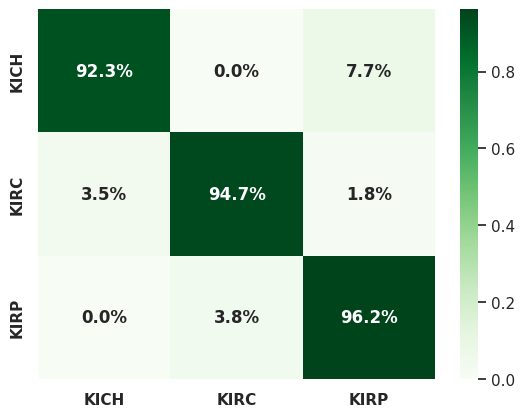

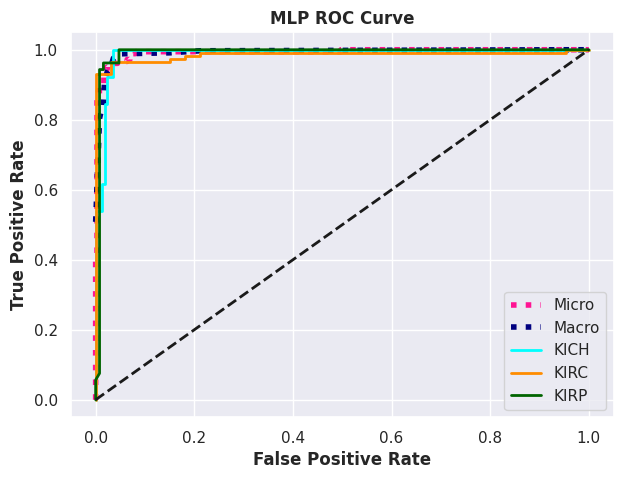

In [40]:
results = evaluate(search, "MLP", X_test, y_test)

In [41]:
filename = MODEL_DIR + '/mlp_anova.sav'

In [42]:
pickle.dump(search, open(filename, 'wb'))